In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('../../../systematic')
from utils import utils, aws_utils, db_utils
trading_conn = db_utils.get_database_connection('Trading')
redshift_conn = aws_utils.Redshift.get_redshift_connection('high_frequency_data')
import pandas as pd
import datetime
import numpy as np
from datetime import date
from time import time as now
#import pandas_redshift as pr
import psycopg2
import matplotlib.pyplot as plt


def create_table_strategy_analysis():
    
    t0_start=now()
    #gather the distinct strategies  
    query = f'''
    SELECT 
        distinct(h.strategy) AS strategy
    FROM strategy_to_hedges h
    JOIN strategy_to_quote_listing q
        ON q.strategy= h.strategy;'''
    strategies=pd.read_sql(query,redshift_conn)
    #initialize blank list for the analysis
    list_analysis_total=[]
    start_date='2021-11-01'
    today= date.today()
    trading_days=np.busday_count(start_date, today)
    #iterate over all listings
    for index in range (0,len(strategies)):
        t0=now()
        Strategy=strategies.loc[index,'strategy']
    
    # For each strategy, look up its quote and hedge listing Ids
        df_strategy_listings = get_strategy_listings (Strategy)
        number_of_listings = df_strategy_listings.shape[0]
    # from these listings, get the rows that have data at the same time from tick_fair_minute
        query = f'''
        SELECT * FROM 
            (select listing_id as quote, q.mean_fair_bid as quote_fair_bid, q.mean_fair_ask as quote_fair_ask, q.mean_bid as quote_bid, q.mean_ask as quote_ask, datetime
                FROM tick_fair_minute q
                WHERE listing_id IN
                    (SELECT listing_id 
                    FROM   strategy_to_quote_listing 
                    WHERE  strategy = '{Strategy}')),

            (select listing_id as hedge, h.mean_fair_bid as hedge_fair_bid, h.mean_fair_ask as hedge_fair_ask, h.mean_bid as hedge_bid, h.mean_ask as hedge_ask, datetime as datetime1
                FROM tick_fair_minute h
                WHERE listing_id IN
                    (select hedge_listing_id
                    FROM strategy_to_hedges
                    WHERE strategy='{Strategy}'))
        where datetime=datetime1'''
        #df is the tick_fair_minute data of quote and hedge listings for the individual strategy, indexed by datetime
        df=pd.read_sql(query,redshift_conn).set_index('datetime')
        #if no tick_fair_minute data is returned:
        if df.shape[0] ==0:
            print('                 No tick_fair_min data for {} strategy'.format(Strategy))
            df_parsed_fair_tick_min=df
            #how many minutesof data should we have each day?
            df_strategy_local_exchange_hours=get_strategy_exchange_hours_local (Strategy)
            trading_minutes_per_day = min(df_strategy_local_exchange_hours['TotalMinutes'])
            #trading_minutes_per_day =0
            days_with_data, data_count,avg_data_count=0,0,0
            expected_minutes = trading_minutes_per_day*trading_days
            
        # but if tick_fair_min data does exist for the strategy
        else:
            #Get the trading times and dates accounting for DST, for the listings, using the minimum trading window with all listings
            df_dates = get_strategy_trading_times (Strategy)
            df_total=[]

            # create a series of dataframes of the tick_fair_min data for the trading windows (time and date) and then concantenate them together
            if df_dates.shape[1]==5 : #df_dates['TotalMinutes'].min()>0:
                trading_minutes_per_day = min(df_dates['TotalMinutes'])
                for index, row in df_dates.iterrows():
                    start_date=df_dates.loc[index,'Date']
                    start_time=time_str_to_hour_minute(df_dates.loc[index,'AmTradingStart'])
                    end_date=df_dates.loc[index,'EndDate']
                    end_time=time_str_to_hour_minute(df_dates.loc[index,'PmTradingEnd'])

                    #  parse the tick_fair_minute dataframe over the date/time windows
                    df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)
                    #append the parsed data to the total series
                    df_total.append(df_slice)
                #concanteante all the slices of the tick_fair_min data
                df_parsed_fair_tick_min = pd.concat(df_total)
            else: 
                #df_parsed_fair_tick_min = df.reset_index().drop(range(0,len(df)))
                df_parsed_fair_tick_min = df
                trading_minutes_per_day=0
                print('        No valid trading times for {} strategy'.format(Strategy)) 

        #Conduct aggregate analysis

        #total minutes between start_time and end_time, multiplied by X to account for each listing id
        #expected_minutes = trading_minutes_per_day*trading_days*number_of_listings
        
        if df_parsed_fair_tick_min.shape[0]!=0:
            df_days=df_parsed_fair_tick_min.resample('D').count()
            df_days_with_data=df_days[(df_days['quote']>0)]
            days_with_data=df_days_with_data.shape[0]
            data_count=np.sum(df_days_with_data.quote)
            avg_data_count=np.mean(df_days_with_data.quote)    
            expected_minutes = trading_minutes_per_day*trading_days#*number_of_listings
            print('{} completed, time elapsed {:.2f} sec'.format(Strategy, now()-t0 ))

        else:
            days_with_data, data_count,avg_data_count=0,0,0
            expected_minutes = 1

        df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])
        list_analysis_total.append(df_analysis_slice)
        print('total time {:.2f} sec, {:.2f}% Complete)'.format(now()-t0_start,100*(now()-t0_start)/(len(strategies)*1.25)))   
        df_strategy_analysis=pd.concat(list_analysis_total,ignore_index=True)
    
    #save the table to Redshift
    #table_name='strategy_analysis'
    #redshift_engine = aws_utils.Redshift.get_redshift_engine('high_frequency_data')
    #conn=psycopg2.connect(dbname = 'high_frequency_data',
    #                host = aws_utils.Redshift.cluster_endpoint,
    #                port = aws_utils.Redshift.port,
    #                user = aws_utils.Redshift.user,
    #cursor.execute("begin")
    #command = "create table {} from '{}' credentials '{}' ".format(
    #            table_name, df_strategy_analysis, aws_utils.AWS.get_access_string())
    #cursor.close()
    #conn.commit()
    #conn.close()

    
    print('Strategy analysis complete, results below')
    return df_strategy_analysis

############ the following functions are utlized by the functions above ##########

# This query takes the longest ~17.9 s ± 954 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# So I store the query results as df_exchange_hours and use it multiple times later
print('preparing the Exchange and listings trading time window table')
time0=now()
query = f'''    
    SELECT 
        Date, 
        secm.ExchangeHoursUTC.ExchangeID, 
        Listings.ListingID,
        AmTradingStart, 
        PmTradingEnd,
        DATEDIFF(MINUTE, AmTradingStart , PmTradingEnd) as TotalMinutes 
    FROM secm.ExchangeHoursUTC
    JOIN secm.Listings
    ON ExchangeHoursUTC.ExchangeID = Listings.ExchangeID 
    WHERE ExchangeHoursUTC.InstrumentID IS NULL
    AND Date >= '2021-11-01'
    ORDER BY Date'''
df_exchange_hours=pd.read_sql(query,trading_conn)
print('Time taken: {:.2f} seconds'.format(now() - time0))

def get_strategy_listings (Strategy):
    listings_query = f'''
        SELECT a.listing_id, instrument_id, bbg_name, role
        FROM high_frequency_data.public.listings a
        
        JOIN
        
            (SELECT listing_id AS listing_id, 'quote' as role
            FROM   strategy_to_quote_listing 
            WHERE  strategy = '{Strategy}'
            UNION
            SELECT hedge_listing_id AS listing_id, 'hedge' as role
            FROM  strategy_to_hedges 
            WHERE strategy = '{Strategy}') b
        ON a.listing_id = b.listing_id'''
    return pd.read_sql(listings_query,redshift_conn)

def get_strategy_exchange_hours_UTC (Strategy):
    #returns a df of the strategy's exchanges trading times for all dates later than 11-1-2021

    #check for valid data in exchange hours local
    df_strategy_exchange_hours_local = get_strategy_exchange_hours_local (Strategy)
    if df_strategy_exchange_hours_local.shape[0]==0:
        print('        No Exchange hours data for {} Strategy'.format(Strategy))
        df_strategy_exchange_hours=pd.DataFrame([[Strategy,0,0,0,0,0]], columns=['Strategy','ExchangeID', 'ListingID','AmTradingStart','PmTradingEnd','TotalMinutes'])
    elif df_strategy_exchange_hours_local['TotalMinutes'].max()>0:
        #get the strategy's listing IDs first:
        df_strategy_listings = get_strategy_listings (Strategy)
        # filter out all exchange trading times for just the given strategy's exchanges
        df_strategy_exchange_hours=df_exchange_hours.merge(df_strategy_listings, left_on='ListingID', right_on='listing_id')
    else:
        df_strategy_exchange_hours_local.loc[:,'Date']='2021-11-01'
        df_strategy_exchange_hours_local.loc[:,'EndDate']=date.today()
        df_strategy_exchange_hours=df_strategy_exchange_hours_local
    return df_strategy_exchange_hours

def get_strategy_trading_times (Strategy):
    #get the strategy's exchange trading times in UTC
    df_strategy_exchange_hours_UTC=get_strategy_exchange_hours_UTC (Strategy)
    df_strategy_exchange_hours_UTC=df_strategy_exchange_hours_UTC.dropna()
    #check for valid data in exchange hours local
    df_strategy_exchange_hours_local = get_strategy_exchange_hours_local (Strategy)
    if df_strategy_exchange_hours_local.shape[0]==0:
        print('        No strategy_trading_times data for {} Strategy'.format(Strategy))
        df_times=pd.DataFrame([[Strategy,0,0,0,0,0]], columns=['Strategy','ExchangeID', 'ListingID','AmTradingStart','PmTradingEnd','TotalMinutes'])
    elif df_strategy_exchange_hours_local['TotalMinutes'].max()>0:
        # group the exchange trading times by start, end, and total minutes
        df_date_hours=df_strategy_exchange_hours_UTC.groupby('Date',as_index=False).agg({'AmTradingStart':'max','PmTradingEnd':'min','TotalMinutes':'min'})
        df_times=df_date_hours.groupby(['AmTradingStart','PmTradingEnd']).agg({'Date':'min'})
        df_times['EndDate']=df_date_hours.groupby(['AmTradingStart','PmTradingEnd']).agg({'Date':'max'})
        df_times=df_times.reset_index()
        if len(df_times)>1 and df_times.loc[0,'EndDate']>df_times.loc[1,'EndDate']:
            df_times.loc[len(df_times.index)]=[df_times.loc[0,'AmTradingStart'],df_times.loc[0,'PmTradingEnd'],df_times.loc[1,'EndDate'],df_times.loc[0,'EndDate']]
            df_times.loc[0,'EndDate']=df_times.loc[1,'Date']
        else:
            df_times=df_times
        df_times['TotalMinutes']=df_strategy_exchange_hours_local['TotalMinutes'].min()
    else:
        df_strategy_exchange_hours_local.loc[:,'Date']='2021-11-01'
        df_strategy_exchange_hours_local.loc[:,'EndDate']=date.today()
        df_times = df_strategy_exchange_hours_local
        print('        No valid start and end times for {} Strategy'.format(Strategy))
    return df_times

def get_strategy_exchange_hours_local (Strategy):
    df_strategy_listings = get_strategy_listings (Strategy)
    query = f'''
        SELECT  
            secm.ExchangeHours.ExchangeID, 
            ListingID,
            AmTradingStart, 
            PmTradingEnd, 
            DATEDIFF(MINUTE, AmTradingStart , PmTradingEnd) as TotalMinutes 
        FROM secm.ExchangeHours
        JOIN secm.Listings
        ON ExchangeHours.ExchangeID = Listings.ExchangeID 
        WHERE ExchangeHours.InstrumentID IS NULL'''
    df_exchange_hours_local = pd.read_sql(query,trading_conn)
    df_strategy_exchange_hours_local=df_exchange_hours_local.merge(df_strategy_listings, left_on='ListingID', right_on='listing_id')
    return df_strategy_exchange_hours_local

###### The function below can be run independantly to gather the tick_fair_min data for a single Strategy
def strategy_listing_data_overlap (Strategy):
    # Given a strategy, look up its quote and hedge listings
    # from these listings, get the rows that have data at the same time from tick_fair_minute
    query = f'''
        SELECT * FROM 
            (select listing_id as quote, q.mean_fair_bid as quote_fair_bid, q.mean_fair_ask as quote_fair_ask, q.mean_bid as quote_bid, q.mean_ask as quote_ask, datetime
                FROM tick_fair_minute q
                WHERE listing_id IN
                    (SELECT listing_id 
                    FROM   strategy_to_quote_listing 
                    WHERE  strategy = '{Strategy}')),

            (select listing_id as hedge, h.mean_fair_bid as hedge_fair_bid, h.mean_fair_ask as hedge_fair_ask, h.mean_bid as hedge_bid, h.mean_ask as hedge_ask, datetime as datetime1
                FROM tick_fair_minute h
                WHERE listing_id IN
                    (select hedge_listing_id
                    FROM strategy_to_hedges
                    WHERE strategy='{Strategy}'))
        where datetime=datetime1'''
    #df is the tick_fair_minute data of quote and hedge listings for the individual strategy, indexed by datetime
    df=pd.read_sql(query,redshift_conn).set_index('datetime')
    
    #if no tick_fair_minute data is returned:
    if df.shape[0] ==0:
        print('                 No tick_fair_min data for {} strategy'.format(Strategy))
        df_parsed_fair_tick_min=df
        #how many minutes of data should we have each day?
        df_strategy_local_exchange_hours=get_strategy_exchange_hours_local (Strategy)
        trading_minutes_per_day = min(df_strategy_local_exchange_hours['TotalMinutes'])
        
    #but if tick_fair_min data does exist for the strategy
    else:
      
        #Get the trading times and dates accounting for DST, for the listings, using the minimum trading window with all listings
        df_dates = get_strategy_trading_times (Strategy)

        # create a series of dataframes and then concantenate them together
        df_total=[]
        if df_dates.shape[1]==5 : # or df_dates['TotalMinutes'].max()!=0 
            for index, row in df_dates.iterrows():
                start_date=df_dates.loc[index,'Date']
                start_time=time_str_to_hour_minute(df_dates.loc[index,'AmTradingStart'])
                end_date=df_dates.loc[index,'EndDate']
                end_time=time_str_to_hour_minute(df_dates.loc[index,'PmTradingEnd'])

                # parse the tick_fair_minute dataframe over the date/time windows
                df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)
                
                #append the parsed data to the total series
                df_total.append(df_slice)
            
            #concanteante all the slices of the tick_fair_min data
            df_parsed_fair_tick_min = pd.concat(df_total)
        else: 
            df_parsed_fair_tick_min = df#.reset_index().drop(range(0,len(df)))
    
    #Conduct aggregate analysis
    df_strategy_exchange_hours=get_strategy_exchange_hours_UTC (Strategy)
    trading_min_count = min(df_strategy_exchange_hours['TotalMinutes'])
       
    start_date='2021-11-01'
    today= date.today()
    trading_days=np.busday_count(start_date, today)
    #total minutes between start_time and end_time, multiplied by X to account for each listing id
    df_strategy_listings = get_strategy_listings (Strategy)
    number_of_listings = df_strategy_listings.shape[0]
    expected_minutes = trading_min_count*trading_days*number_of_listings
    print('There are {} trading days between {} and {}, '.format(trading_days, start_date, today))
    print('with {} minutes of total trading data possible'.format(expected_minutes))
    #print('between {} and {} from {} to {}'.format(start_time1,end_time1,start_date1,end_date1))
    #print('& between {} and {} from {} to {}'.format(start_time2,end_time2,start_date2,end_date2))
    if df_parsed_fair_tick_min.shape[0]!=0:
        df_days=df_parsed_fair_tick_min.resample('D').count()
        df_days_with_data=df_days[(df_days['quote']>0)]
        days_with_data=df_days_with_data.shape[0]
        data_count=np.sum(df_days_with_data.quote)
        avg_data_count=np.mean(df_days_with_data.quote)
    else:
        days_with_data, data_count,avg_data_count=0,0,0
    print('For {} strategy '.format(Strategy))
    print('We have a total of {} days with at least one minute of data '.format(days_with_data))

    print('with  {} minutes of data total'.format(data_count))
    print('and a mean of {:.2f} minutes of trading data  per day'.format(avg_data_count))
    return df_parsed_fair_tick_min

# The two functions below are utilities to massage the dates and time into format required for functions above

def time_str_to_hour_minute(time_str):
    time_str_components = time_str.split(':')
    hour = int(time_str_components[0])
    minute = int(time_str_components[1])
    return ('{}:{}').format(hour,minute)

def datetime_to_date_string(date):
    year = datetime.date.today().year
    month = datetime.date.today().month
    day = datetime.date.today().day
    return ('{}-{}-{}').format(year,month,day)

preparing the Exchange and listings trading time window table
Time taken: 28.90 seconds


In [347]:
%%timeit
df_strategy_exchange_hours=get_strategy_exchange_hours_UTC (Strategy)
min(df_strategy_exchange_hours['TotalMinutes'])

624 ms ± 97.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [348]:
%%timeit
df_strategy_local_exchange_hours=get_strategy_exchange_hours_local (Strategy)
min(df_strategy_local_exchange_hours['TotalMinutes'])

318 ms ± 97.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [260]:
#this function took 4 hr 25mins to complete
df_strategy_analysis=create_table_strategy_analysis()
df_strategy_analysis.describe()

                 No tick_fair_min data for 21XB_BTC.21XB GT Equity strategy
total time 0.04 sec, 0.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


4BRZ.4BRZ GT Equity completed, time elapsed 0.94 sec
total time 0.97 sec, 0.01% Complete)
                 No tick_fair_min data for ABTC.21XB GY Equity strategy
total time 0.99 sec, 0.01% Complete)
                 No tick_fair_min data for ABTC.ABTC SE Equity strategy
total time 1.00 sec, 0.01% Complete)
                 No tick_fair_min data for ABTC.ABTCEUR SE Equity strategy
total time 1.01 sec, 0.01% Complete)
                 No tick_fair_min data for ABTC_BTC.21XB GT Equity strategy
total time 1.02 sec, 0.01% Complete)
                 No tick_fair_min data for ABTC_BTC.ABTCGBP SE Equity strategy
total time 1.03 sec, 0.01% Complete)
                 No tick_fair_min data for ACWD_ZWP.SPYY GT Equity strategy
total time 1.05 sec, 0.01% Complete)
                 No tick_fair_min data for ACWX_EEM_EFA_EWC.ACWX UN Equity strategy
total time 1.06 sec, 0.01% Complete)
                 No tick_fair_min data for ACWX_IXUS_Snap.ACWX UP Equity.ARCX strategy
total time 1.07 sec, 0.01% Com

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CNDX_NQ.CSNDX IM Equity completed, time elapsed 0.74 sec
total time 2.11 sec, 0.02% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CNDX_NQ.CSNDX SE Equity completed, time elapsed 0.71 sec
total time 2.83 sec, 0.03% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSKR.CSKR LN Equity completed, time elapsed 0.79 sec
total time 3.63 sec, 0.04% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSKR.CSKR SE Equity completed, time elapsed 1.32 sec
total time 4.95 sec, 0.06% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSMXCP .CEBG GT Equity completed, time elapsed 0.91 sec
total time 5.87 sec, 0.07% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSPX_ES.CSSPX SE Equity completed, time elapsed 0.72 sec
total time 6.59 sec, 0.08% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


D5BK.D5BK GT Equity completed, time elapsed 0.71 sec
total time 7.32 sec, 0.08% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


D5BM.XSPU LN Equity completed, time elapsed 0.97 sec
total time 8.30 sec, 0.09% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


D5BM_ES.D5BM GT Equity completed, time elapsed 0.72 sec
total time 9.04 sec, 0.10% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


D5BM_ES.XSPX IM Equity completed, time elapsed 0.82 sec
total time 9.87 sec, 0.11% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


D5BM_PB.D5BM GT Equity completed, time elapsed 1.14 sec
total time 11.03 sec, 0.13% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EDM2_MES.EDM2 GT Equity completed, time elapsed 0.95 sec
total time 11.99 sec, 0.14% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EDOC_EDOC_US.EDOC IM Equity completed, time elapsed 1.34 sec
total time 13.35 sec, 0.15% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EDOC_EDOC_US.EDOC LN Equity completed, time elapsed 1.15 sec
total time 14.52 sec, 0.17% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EDOG_EDOC_US.EDOG LN Equity completed, time elapsed 0.96 sec
total time 15.49 sec, 0.18% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EDOG_PB.EDOG LN Equity completed, time elapsed 0.78 sec
total time 16.29 sec, 0.19% Complete)
                 No tick_fair_min data for EEM.EEM UF Equity.BATS strategy
total time 16.31 sec, 0.19% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EEM_AAXJ_ILF_RSX_KSA_EZA_EWH.EEM UP Equity completed, time elapsed 38.70 sec
total time 55.03 sec, 0.63% Complete)
                 No tick_fair_min data for EEM_IEMG.EEM UF Equity.BATS strategy
total time 55.06 sec, 0.63% Complete)
                 No tick_fair_min data for EEM_IEMG.EEM UN Equity strategy
total time 55.09 sec, 0.63% Complete)
                 No tick_fair_min data for EEM_IEMG.EEM UP Equity.ARCX strategy
total time 55.11 sec, 0.63% Complete)
                 No tick_fair_min data for EEM_IEMG_Snap.EEM UP Equity strategy
total time 55.14 sec, 0.63% Complete)
                 No tick_fair_min data for EEM_MES.EEM UF Equity strategy
total time 55.16 sec, 0.63% Complete)
                 No tick_fair_min data for EFA.EFA UP Equity strategy
total time 55.19 sec, 0.63% Complete)
                 No tick_fair_min data for EFA_IEFA.EFA UP Equity strategy
total time 55.21 sec, 0.63% Complete)
                 No tick_fair_min data for EFA_IEFA_Snap.EFA UP Equity.ARCX strategy


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EIMU_MES.IBC3 GT Equity completed, time elapsed 0.91 sec
total time 56.19 sec, 0.64% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMMV_PB.EUNZ GT Equity completed, time elapsed 0.88 sec
total time 57.09 sec, 0.65% Complete)
                 No tick_fair_min data for EMRD_MES.EMRG SE Equity strategy
total time 57.11 sec, 0.65% Complete)
                 No tick_fair_min data for EPI_INDA.EPI UF Equity strategy
total time 57.14 sec, 0.65% Complete)
                 No tick_fair_min data for EPI_INDA.EPI UN Equity.XNYS strategy
total time 57.17 sec, 0.65% Complete)
                 No tick_fair_min data for EPI_INDA_Snap.EPI UN Equity strategy
total time 57.19 sec, 0.65% Complete)
                 No tick_fair_min data for EPP_VPL_EWJ_EWY.EPP UP Equity strategy
total time 57.22 sec, 0.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ERO.SPYE GT Equity completed, time elapsed 0.76 sec
total time 58.00 sec, 0.66% Complete)
                 No tick_fair_min data for ERUS_RSX.ERUS UF Equity strategy
total time 58.04 sec, 0.66% Complete)
                 No tick_fair_min data for ES_VG.ESH0 Index strategy
total time 58.07 sec, 0.66% Complete)
                 No tick_fair_min data for ES_VG.ESH1 Index.XCME strategy
total time 58.09 sec, 0.66% Complete)
                 No tick_fair_min data for ES_VG.ESH2 Index strategy
total time 58.12 sec, 0.66% Complete)
                 No tick_fair_min data for ES_VG.ESH2 Index.XCME strategy
total time 58.16 sec, 0.66% Complete)
                 No tick_fair_min data for ES_VG.ESM0 Index.XCME strategy
total time 58.19 sec, 0.66% Complete)
                 No tick_fair_min data for ES_VG.ESM1 Index strategy
total time 58.23 sec, 0.66% Complete)
                 No tick_fair_min data for ES_VG.ESM9 Index strategy
total time 58.26 sec, 0.66% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ES_VG.ESZ1 Index.XCME completed, time elapsed 0.79 sec
total time 59.07 sec, 0.67% Complete)
                 No tick_fair_min data for EWA.EWA UN Equity strategy
total time 59.11 sec, 0.67% Complete)
                 No tick_fair_min data for EWH.EWH UF Equity strategy
total time 59.16 sec, 0.67% Complete)
                 No tick_fair_min data for EWH.EWH UN Equity strategy
total time 59.20 sec, 0.67% Complete)
                 No tick_fair_min data for EWH.EWH UP Equity strategy
total time 59.23 sec, 0.67% Complete)
                 No tick_fair_min data for EWJ.EWJ UF Equity.BATY strategy
total time 59.26 sec, 0.68% Complete)
                 No tick_fair_min data for EWJ.EWJ UN Equity.XNYS strategy
total time 59.30 sec, 0.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWJ.EWJ UP Equity completed, time elapsed 1.00 sec
total time 60.32 sec, 0.69% Complete)
                 No tick_fair_min data for EWT.EWT UF Equity.BATY strategy
total time 60.37 sec, 0.69% Complete)
                 No tick_fair_min data for EWT.EWT UN Equity strategy
total time 60.42 sec, 0.69% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EZU_EWG_EWQ_EWN_EWI_EWP.EZU UF Equity.BATS completed, time elapsed 13.82 sec
total time 74.27 sec, 0.85% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLX5_ES.USPA IM Equity completed, time elapsed 1.01 sec
total time 75.30 sec, 0.86% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXB.FLXB NA Equity completed, time elapsed 1.13 sec
total time 76.48 sec, 0.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXB_EWZ.FLXB NA Equity completed, time elapsed 1.26 sec
total time 77.81 sec, 0.89% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXC.FLXC NA Equity completed, time elapsed 1.49 sec
total time 79.35 sec, 0.90% Complete)
                 No tick_fair_min data for FLXI.FRIN LN Equity strategy
total time 79.38 sec, 0.90% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXK.FLXK SE Equity completed, time elapsed 1.10 sec
total time 80.51 sec, 0.92% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXP.EUPA LN Equity completed, time elapsed 0.73 sec
total time 81.26 sec, 0.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXP_SXO.PARI NA Equity completed, time elapsed 0.70 sec
total time 81.99 sec, 0.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FXC.FXC NA Equity completed, time elapsed 0.77 sec
total time 82.78 sec, 0.94% Complete)
                 No tick_fair_min data for FXI.FXI UN Equity.XNYS strategy
total time 82.82 sec, 0.94% Complete)
                 No tick_fair_min data for GLRE_PB.GLRE IM Equity strategy
total time 82.86 sec, 0.94% Complete)
                 No tick_fair_min data for GLRE_PB.GLRE LN Equity strategy
total time 82.89 sec, 0.94% Complete)
                 No tick_fair_min data for GLRE_PB.SPYJ GT Equity strategy
total time 82.93 sec, 0.94% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


H50E.H4ZA GT Equity completed, time elapsed 0.76 sec
total time 83.73 sec, 0.95% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


H50E.H50E LN Equity completed, time elapsed 0.72 sec
total time 84.47 sec, 0.96% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HCAN.HCANCAD SE Equity completed, time elapsed 0.99 sec
total time 85.49 sec, 0.97% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HERU_HERO_US.HERU LN Equity completed, time elapsed 0.82 sec
total time 86.33 sec, 0.98% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HERU_HERO_US.HERU SE Equity completed, time elapsed 0.72 sec
total time 87.07 sec, 0.99% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HERU_PB.HERU IM Equity completed, time elapsed 0.71 sec
total time 87.81 sec, 1.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HIDR.HIDD LN Equity completed, time elapsed 0.70 sec
total time 88.53 sec, 1.01% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMBR.HBRL SE Equity completed, time elapsed 0.88 sec
total time 89.44 sec, 1.02% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMBR_EWZ.HBRL SE Equity completed, time elapsed 0.94 sec
total time 90.40 sec, 1.03% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMCH.H4ZP GT Equity completed, time elapsed 7.52 sec
total time 97.94 sec, 1.12% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMCH.HMCH IM Equity completed, time elapsed 1.67 sec
total time 99.65 sec, 1.14% Complete)
                 No tick_fair_min data for HMCX_PB.HMCX LN Equity strategy
total time 99.69 sec, 1.14% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEM_MES.HMEF SE Equity completed, time elapsed 0.80 sec
total time 100.52 sec, 1.15% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEU.HEU FP Equity completed, time elapsed 1.22 sec
total time 101.77 sec, 1.16% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEU.HMEU SE Equity completed, time elapsed 1.15 sec
total time 102.95 sec, 1.17% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEU.HMEUEUR SE Equity completed, time elapsed 1.15 sec
total time 104.13 sec, 1.19% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEX_EWW.HMEX LN Equity completed, time elapsed 1.62 sec
total time 105.79 sec, 1.21% Complete)
                 No tick_fair_min data for HMJP.H4ZC GT Equity strategy
total time 105.83 sec, 1.21% Complete)
                 No tick_fair_min data for HMYR.H4ZV GT Equity strategy
total time 105.87 sec, 1.21% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEM_MES.HSEF LN Equity completed, time elapsed 1.31 sec
total time 107.21 sec, 1.22% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEU_SXO.HSEP LN Equity completed, time elapsed 0.72 sec
total time 107.97 sec, 1.23% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEU_SXO.HSEU LN Equity completed, time elapsed 1.70 sec
total time 110.00 sec, 1.25% Complete)
                 No tick_fair_min data for HSJD.XU8Z GT Equity strategy
total time 110.04 sec, 1.25% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSUD_ES.HSUS LN Equity completed, time elapsed 1.37 sec
total time 111.44 sec, 1.27% Complete)
                 No tick_fair_min data for HSWD_ZWP.HSWO LN Equity strategy
total time 111.48 sec, 1.27% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HTRD.HTRY LN Equity completed, time elapsed 1.33 sec
total time 112.84 sec, 1.29% Complete)
                 No tick_fair_min data for HTWN.HTWD LN Equity strategy
total time 113.88 sec, 1.30% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HUKX.HUKX LN Equity completed, time elapsed 1.50 sec
total time 115.41 sec, 1.31% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HUKX_Z.HUKX SE Equity completed, time elapsed 1.21 sec
total time 116.66 sec, 1.33% Complete)
                 No tick_fair_min data for HWWA_ZWP.HWWA IM Equity strategy
total time 117.27 sec, 1.34% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IBZL.IBZL LN Equity completed, time elapsed 1.56 sec
total time 118.87 sec, 1.35% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IBZL.IBZL NA Equity completed, time elapsed 1.79 sec
total time 120.69 sec, 1.38% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IBZL.IQQB GT Equity completed, time elapsed 1.44 sec
total time 122.17 sec, 1.39% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ICHD.ICHD NA Equity completed, time elapsed 1.51 sec
total time 123.71 sec, 1.41% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ICHN.ICHN NA Equity completed, time elapsed 2.09 sec
total time 125.83 sec, 1.43% Complete)
                 No tick_fair_min data for IEFA_EFA.IEFA UN Equity.XNYS strategy
total time 126.18 sec, 1.44% Complete)
                 No tick_fair_min data for IEUR.IEUR UF Equity.BATS strategy
total time 126.52 sec, 1.44% Complete)
                 No tick_fair_min data for IEUR.IEUR UN Equity strategy
total time 126.85 sec, 1.45% Complete)
                 No tick_fair_min data for IEUR_IEV.IEUR UP Equity.ARCX strategy
total time 127.43 sec, 1.45% Complete)
                 No tick_fair_min data for IEUR_IEV_Snap.IEUR UF Equity strategy
total time 127.75 sec, 1.46% Complete)
                 No tick_fair_min data for IEUR_IEV_Snap.IEUR UN Equity strategy
total time 128.04 sec, 1.46% Complete)
                 No tick_fair_min data for IEUR_IEV_Snap.IEUR UP Equity strategy
total time 128.74 sec, 1.47% Complete)
                 No tick_fair_min data for IEUR_VGK_Snap.IEUR UF Equity strategy


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IMEU.IMEU LN Equity completed, time elapsed 1.31 sec
total time 131.53 sec, 1.50% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IMEU.IMEU NA Equity completed, time elapsed 1.24 sec
total time 132.81 sec, 1.51% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IMEU.IQQY GT Equity completed, time elapsed 1.32 sec
total time 134.17 sec, 1.53% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IMEU.ISEU LN Equity completed, time elapsed 1.48 sec
total time 135.69 sec, 1.55% Complete)
                 No tick_fair_min data for INDA.INDA UP Equity.ARCX strategy
total time 135.96 sec, 1.55% Complete)
                 No tick_fair_min data for INDY_INDA.INDY UF Equity.BATY strategy
total time 136.46 sec, 1.55% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ISF_Z.ISF SE Equity completed, time elapsed 1.27 sec
total time 137.77 sec, 1.57% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ITKY.IQQ5 GT Equity completed, time elapsed 1.36 sec
total time 139.17 sec, 1.59% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ITKY.ITKY IM Equity completed, time elapsed 2.01 sec
total time 141.22 sec, 1.61% Complete)
                 No tick_fair_min data for JPCT_ZWP.JPCT GT Equity strategy
total time 141.92 sec, 1.62% Complete)
                 No tick_fair_min data for JPCT_ZWP.JPTC LN Equity strategy
total time 142.56 sec, 1.62% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRED_SXO.JRDE LN Equity completed, time elapsed 1.27 sec
total time 143.86 sec, 1.64% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREE_SXO.JREE GT Equity completed, time elapsed 1.43 sec
total time 145.33 sec, 1.66% Complete)
                 No tick_fair_min data for JREG_ZWP.JREG LN Equity strategy
total time 145.93 sec, 1.66% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREM_MES.JREM LN Equity completed, time elapsed 1.40 sec
total time 147.37 sec, 1.68% Complete)
                 No tick_fair_min data for R2US_RTY.R2US LN Equity strategy
total time 147.73 sec, 1.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


RSX.RSX UF Equity completed, time elapsed 1.31 sec
total time 149.09 sec, 1.70% Complete)
                 No tick_fair_min data for RSX.RSX UP Equity.ARCX strategy
total time 149.43 sec, 1.70% Complete)
                 No tick_fair_min data for SDOT.SDOT SE Equity strategy
total time 150.06 sec, 1.71% Complete)
                 No tick_fair_min data for SDOT_PB.SDOT SE Equity strategy
total time 150.65 sec, 1.72% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEDM_MES.SEDM LN Equity completed, time elapsed 1.29 sec
total time 151.98 sec, 1.73% Complete)
        No valid start and end times for SEMA_MES.SEMA IM Equity Strategy
        No valid trading times for SEMA_MES.SEMA IM Equity strategy
SEMA_MES.SEMA IM Equity completed, time elapsed 0.98 sec
total time 153.00 sec, 1.74% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])
D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEMD_PB.36B5 GT Equity completed, time elapsed 1.52 sec
total time 154.56 sec, 1.76% Complete)
                 No tick_fair_min data for SETH.SETH SE Equity strategy
total time 155.16 sec, 1.77% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SMC.SMCX IM Equity completed, time elapsed 1.62 sec
total time 156.83 sec, 1.79% Complete)
                 No tick_fair_min data for SPPW_ZWP.SWRD LN Equity strategy
total time 157.50 sec, 1.79% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SPY.SPY UP Equity completed, time elapsed 1.36 sec
total time 158.94 sec, 1.81% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STK.SPYK GT Equity completed, time elapsed 1.63 sec
total time 160.62 sec, 1.83% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STP.MTRL LN Equity completed, time elapsed 1.30 sec
total time 161.96 sec, 1.85% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STP.STP FP Equity completed, time elapsed 1.28 sec
total time 163.29 sec, 1.86% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STQ.SPYQ GT Equity completed, time elapsed 1.43 sec
total time 164.77 sec, 1.88% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STR.SPYR GT Equity completed, time elapsed 1.31 sec
total time 166.13 sec, 1.89% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STR.STR FP Equity completed, time elapsed 1.39 sec
total time 167.57 sec, 1.91% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STR.STRX IM Equity completed, time elapsed 1.33 sec
total time 168.94 sec, 1.92% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STU.STU FP Equity completed, time elapsed 1.63 sec
total time 170.62 sec, 1.94% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STW.HLTH LN Equity completed, time elapsed 1.15 sec
total time 171.81 sec, 1.96% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STW.SPYH GT Equity completed, time elapsed 1.64 sec
total time 173.50 sec, 1.98% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STZ.FNCL LN Equity completed, time elapsed 1.29 sec
total time 174.87 sec, 1.99% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STZ.SPYZ GT Equity completed, time elapsed 1.29 sec
total time 176.21 sec, 2.01% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STZ.STZX SE Equity completed, time elapsed 1.31 sec
total time 177.57 sec, 2.02% Complete)
                 No tick_fair_min data for TPLT_PL.TPLT IM Equity strategy
total time 178.18 sec, 2.03% Complete)
                 No tick_fair_min data for TPLT_PL.TPLT LN Equity strategy
total time 178.92 sec, 2.04% Complete)
                 No tick_fair_min data for TPLT_PL.TPTS LN Equity strategy
total time 179.58 sec, 2.05% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


UKDV.UKDV SE Equity completed, time elapsed 1.45 sec
total time 181.08 sec, 2.06% Complete)
                 No tick_fair_min data for VEA_EFA_EWY_EWC.VEA UN Equity.XNYS strategy
total time 181.44 sec, 2.07% Complete)
                 No tick_fair_min data for VEU_ACWX.VEU UF Equity strategy
total time 181.80 sec, 2.07% Complete)
                 No tick_fair_min data for VEU_ACWX.VEU UF Equity.BATS strategy
total time 182.16 sec, 2.08% Complete)
                 No tick_fair_min data for VEU_ACWX.VEU UN Equity strategy
total time 182.50 sec, 2.08% Complete)
                 No tick_fair_min data for VEU_ACWX.VEU UP Equity strategy
total time 183.14 sec, 2.09% Complete)
                 No tick_fair_min data for VEU_IXUS.VEU UN Equity.XNYS strategy
total time 183.43 sec, 2.09% Complete)
                 No tick_fair_min data for VGK_EWU_EWQ_EWL_EWG_EWD_EWN_EWI_EWP.VGK UF Equity.BATS strategy
total time 183.76 sec, 2.09% Complete)
                 No tick_fair_min data for VGK_IEUR.VGK 

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VUSA_ES.VUSA SE Equity completed, time elapsed 1.25 sec
total time 186.44 sec, 2.12% Complete)
                 No tick_fair_min data for VXUS_ACWX.VXUS UF Equity strategy
total time 186.78 sec, 2.13% Complete)
                 No tick_fair_min data for VXUS_IXUS.VXUS UN Equity strategy
total time 187.13 sec, 2.13% Complete)
                 No tick_fair_min data for VXUS_IXUS.VXUS UN Equity.XNYS strategy
total time 187.51 sec, 2.14% Complete)
                 No tick_fair_min data for VXUS_IXUS.VXUS UP Equity strategy
total time 187.81 sec, 2.14% Complete)
                 No tick_fair_min data for VXUS_VEU_Snap.VXUS UP Equity.ARCX strategy
total time 188.12 sec, 2.14% Complete)
                 No tick_fair_min data for WETH.ETHW SE Equity strategy
total time 188.78 sec, 2.15% Complete)
                 No tick_fair_min data for WETH.WETH FP Equity strategy
total time 189.39 sec, 2.16% Complete)
                 No tick_fair_min data for WETH_DCR.WETH FP Equity strategy
total time 18

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XASX.XASX LN Equity completed, time elapsed 1.49 sec
total time 194.72 sec, 2.22% Complete)
        No valid start and end times for XAUS.XAUS IM Equity Strategy
        No valid trading times for XAUS.XAUS IM Equity strategy
XAUS.XAUS IM Equity completed, time elapsed 1.10 sec
total time 195.87 sec, 2.23% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])


                 No tick_fair_min data for XBAS.XBAS GT Equity strategy
total time 196.54 sec, 2.24% Complete)
                 No tick_fair_min data for XCS5.XCS5 LN Equity strategy
total time 197.22 sec, 2.25% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XCS6.XCS6 GT Equity completed, time elapsed 1.53 sec
total time 198.81 sec, 2.27% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XCS6.XCS6 IM Equity completed, time elapsed 1.89 sec
total time 200.76 sec, 2.29% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD5E.XD5E LN Equity completed, time elapsed 1.52 sec
total time 202.34 sec, 2.31% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD9U_ES.XD9U IM Equity completed, time elapsed 1.45 sec
total time 203.85 sec, 2.32% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD9U_ES.XD9U LN Equity completed, time elapsed 1.85 sec
total time 205.76 sec, 2.34% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD9U_ES.XDUS LN Equity completed, time elapsed 1.32 sec
total time 207.13 sec, 2.36% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDDX.XDDX LN Equity completed, time elapsed 1.47 sec
total time 208.65 sec, 2.38% Complete)
                 No tick_fair_min data for XDEB.XDEB IM Equity strategy
total time 209.34 sec, 2.39% Complete)
                 No tick_fair_min data for XDEB.XDEB LN Equity strategy
total time 210.01 sec, 2.39% Complete)
                 No tick_fair_min data for XDEB.XDEB SE Equity strategy
total time 210.55 sec, 2.40% Complete)
                 No tick_fair_min data for XDEQ.XDEQ GT Equity strategy
total time 211.15 sec, 2.41% Complete)
                 No tick_fair_min data for XDEV_PB.XDEV IM Equity strategy
total time 211.79 sec, 2.41% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDPD_ES.XDPD GT Equity completed, time elapsed 1.23 sec
total time 213.07 sec, 2.43% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDUE_PB.XDUE SE Equity completed, time elapsed 1.15 sec
total time 214.28 sec, 2.44% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDUK.XDUK LN Equity completed, time elapsed 1.33 sec
total time 215.67 sec, 2.46% Complete)
                 No tick_fair_min data for XDW0.XDW0 GT Equity strategy
total time 216.22 sec, 2.46% Complete)
                 No tick_fair_min data for XDWC.XDWC GT Equity strategy
total time 216.84 sec, 2.47% Complete)
                 No tick_fair_min data for XDWD_ZWP.XDWD SE Equity strategy
total time 217.34 sec, 2.48% Complete)
                 No tick_fair_min data for XDWD_ZWP.XWLD LN Equity strategy
total time 218.11 sec, 2.48% Complete)
                 No tick_fair_min data for XDWG_PB.XDWG LN Equity strategy
total time 218.83 sec, 2.49% Complete)
                 No tick_fair_min data for XDWG_PB.XDWG SE Equity strategy
total time 219.22 sec, 2.50% Complete)
                 No tick_fair_min data for XDWI.XDWI LN Equity strategy
total time 219.87 sec, 2.50% Complete)
                 No tick_fair_min data for XDWT.XDWT LN Equity strategy
total time 220.52 sec, 2.51% Complete)
      

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XIEE.XIEE GT Equity completed, time elapsed 1.30 sec
total time 224.28 sec, 2.56% Complete)
                 No tick_fair_min data for XMAW_ZWP.XMAW GT Equity strategy
total time 224.88 sec, 2.56% Complete)
                 No tick_fair_min data for XMAW_ZWP.XMAW LN Equity strategy
total time 225.55 sec, 2.57% Complete)
                 No tick_fair_min data for XMAW_ZWP.XMAW SE Equity strategy
total time 226.13 sec, 2.58% Complete)
        No valid start and end times for XMEM_MES.XMEM IM Equity Strategy
        No valid trading times for XMEM_MES.XMEM IM Equity strategy
XMEM_MES.XMEM IM Equity completed, time elapsed 1.05 sec
total time 227.24 sec, 2.59% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])
D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEM_MES.XMEM SE Equity completed, time elapsed 1.31 sec
total time 228.62 sec, 2.60% Complete)
                 No tick_fair_min data for XMJP.XMJP IM Equity strategy
total time 229.31 sec, 2.61% Complete)
                 No tick_fair_min data for XMJP_TP.XMJP IM Equity strategy
total time 229.99 sec, 2.62% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMKO.XMKO GT Equity completed, time elapsed 1.84 sec
total time 231.90 sec, 2.64% Complete)
                 No tick_fair_min data for XMTW.XMTW LN Equity strategy
total time 232.65 sec, 2.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XNAS_NQ.XNAS GT Equity completed, time elapsed 1.37 sec
total time 234.09 sec, 2.67% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XNAS_NQ.XNAS IM Equity completed, time elapsed 1.65 sec
total time 235.83 sec, 2.69% Complete)
                 No tick_fair_min data for XNIF.XNIF IM Equity strategy
total time 236.49 sec, 2.69% Complete)
                 No tick_fair_min data for XPPE_PL.XPPE IM Equity strategy
total time 237.19 sec, 2.70% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XRS2_RTY.XRS2 GT Equity completed, time elapsed 1.38 sec
total time 238.68 sec, 2.72% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSDR.XSDR LN Equity completed, time elapsed 1.55 sec
total time 240.30 sec, 2.74% Complete)
                 No tick_fair_min data for XSLE_SI.XSLE IM Equity strategy
total time 240.97 sec, 2.75% Complete)
                 No tick_fair_min data for XSLR_SI.XSLR IM Equity strategy
total time 241.66 sec, 2.75% Complete)
                 No tick_fair_min data for XUEN.XSEN LN Equity strategy
total time 242.39 sec, 2.76% Complete)
                 No tick_fair_min data for XUFN.XUFN GT Equity strategy
total time 243.12 sec, 2.77% Complete)
                 No tick_fair_min data for XUTC.XUTC SE Equity strategy
total time 243.75 sec, 2.78% Complete)
                 No tick_fair_min data for XWTS.XWTS LN Equity strategy
total time 244.39 sec, 2.78% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XXSC_PB.XXSC GT Equity completed, time elapsed 1.36 sec
total time 245.87 sec, 2.80% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XXSC_PB.XXSC LN Equity completed, time elapsed 1.52 sec
total time 247.47 sec, 2.82% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZEU_SXO.XZEU GT Equity completed, time elapsed 1.26 sec
total time 249.19 sec, 2.84% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZEZ.XZEZ IM Equity completed, time elapsed 1.51 sec
total time 250.78 sec, 2.86% Complete)
                 No tick_fair_min data for XZMJ.XZMJ IM Equity strategy
total time 251.38 sec, 2.86% Complete)
                 No tick_fair_min data for 21XB_BTC.21XB GY Equity strategy
total time 251.95 sec, 2.87% Complete)
                 No tick_fair_min data for 21XB_BTC.ABTC FP Equity strategy
total time 252.51 sec, 2.88% Complete)
                 No tick_fair_min data for 21XB_BTC.ABTCCHF SE Equity strategy
total time 253.11 sec, 2.88% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


4BRZ_EWZ.4BRZ GT Equity completed, time elapsed 1.46 sec
total time 254.71 sec, 2.90% Complete)
                 No tick_fair_min data for ABTC.21XB GT Equity strategy
total time 255.04 sec, 2.91% Complete)
                 No tick_fair_min data for ABTC.ABTC FP Equity strategy
total time 255.68 sec, 2.91% Complete)
                 No tick_fair_min data for ABTC.ABTCGBP SE Equity strategy
total time 256.32 sec, 2.92% Complete)
                 No tick_fair_min data for ABTC_BTC.ABTC FP Equity strategy
total time 256.91 sec, 2.93% Complete)
                 No tick_fair_min data for ABTC_PB.ABTC SE Equity strategy
total time 257.44 sec, 2.93% Complete)
                 No tick_fair_min data for ACWI.ACWI UQ Equity strategy
total time 258.03 sec, 2.94% Complete)
                 No tick_fair_min data for ACWI.ACWI UQ Equity.XNMS strategy
total time 258.56 sec, 2.95% Complete)
                 No tick_fair_min data for ACWI_ACWX_SPY.ACWI UF Equity strategy
total time 258.87 sec, 2.95% Co

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ACWX_EEM_EFA_EWC.ACWX UQ Equity completed, time elapsed 2.29 sec
total time 261.59 sec, 2.98% Complete)
                 No tick_fair_min data for ACWX_IXUS_Snap.ACWX UF Equity.BATS strategy
total time 261.95 sec, 2.98% Complete)
                 No tick_fair_min data for ACWX_IXUS_Snap.ACWX UP Equity strategy
total time 262.65 sec, 2.99% Complete)
                 No tick_fair_min data for AETH.AETH NA Equity strategy
total time 263.41 sec, 3.00% Complete)
                 No tick_fair_min data for AETH.AETHCHF SE Equity strategy
total time 264.01 sec, 3.01% Complete)
                 No tick_fair_min data for AETH_DCR.AETH FP Equity strategy
total time 264.66 sec, 3.02% Complete)
                 No tick_fair_min data for AETH_DCR.AETH SE Equity strategy
total time 265.35 sec, 3.02% Complete)
                 No tick_fair_min data for AETH_DCR.AETHEUR SE Equity strategy
total time 265.98 sec, 3.03% Complete)
                 No tick_fair_min data for ASHR.ASHR UF Equity.BATS strategy

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CNDX_NQ.CNDX NA Equity completed, time elapsed 1.35 sec
total time 272.80 sec, 3.11% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSKR.CSKR IM Equity completed, time elapsed 1.58 sec
total time 274.47 sec, 3.13% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSMXCP .CMXC LN Equity completed, time elapsed 1.36 sec
total time 275.91 sec, 3.14% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


D5BM.XSPX LN Equity completed, time elapsed 1.86 sec
total time 277.85 sec, 3.17% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


D5BM_ES.XSPX SE Equity completed, time elapsed 1.27 sec
total time 279.27 sec, 3.18% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


DAXEX.DAXEX IM Equity completed, time elapsed 1.71 sec
total time 281.06 sec, 3.20% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EDM2_MES.EDG2 LN Equity completed, time elapsed 1.50 sec
total time 282.64 sec, 3.22% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EDOC_PB.EDOC IM Equity completed, time elapsed 1.50 sec
total time 284.22 sec, 3.24% Complete)
                 No tick_fair_min data for EEDM_MES.EEDM SW Equity strategy
total time 284.62 sec, 3.24% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EEM.EEM UP Equity.ARCX completed, time elapsed 1.83 sec
total time 286.58 sec, 3.26% Complete)
                 No tick_fair_min data for EEM_IEMG_Snap.EEM UF Equity.BATS strategy
total time 286.93 sec, 3.27% Complete)
                 No tick_fair_min data for EEM_IEMG_Snap.EEM UN Equity strategy
total time 287.33 sec, 3.27% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EEM_MES.EEM UP Equity completed, time elapsed 1.47 sec
total time 288.88 sec, 3.29% Complete)
                 No tick_fair_min data for EFA.EFA UF Equity.BATS strategy
total time 289.31 sec, 3.30% Complete)
                 No tick_fair_min data for EFA.EFA UP Equity.ARCX strategy
total time 289.95 sec, 3.30% Complete)
                 No tick_fair_min data for EFA_IEFA.EFA UN Equity.XNYS strategy
total time 290.36 sec, 3.31% Complete)
                 No tick_fair_min data for EFA_IEFA.EFA UP Equity.ARCX strategy
total time 291.11 sec, 3.32% Complete)
                 No tick_fair_min data for EFA_IEFA_Snap.EFA UF Equity strategy
total time 291.55 sec, 3.32% Complete)
                 No tick_fair_min data for EFA_IEFA_Snap.EFA UF Equity.BATS strategy
total time 291.93 sec, 3.33% Complete)
                 No tick_fair_min data for EFA_IEFA_Snap.EFA UN Equity strategy
total time 292.62 sec, 3.33% Complete)
                 No tick_fair_min data for EFA_VPL_VGK_EWY_EWJ.EFA UN Equity s

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMIM_MES.EIMI LN Equity completed, time elapsed 1.70 sec
total time 294.86 sec, 3.36% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMMV_PB.EMV LN Equity completed, time elapsed 1.96 sec
total time 296.95 sec, 3.38% Complete)
                 No tick_fair_min data for EPI_INDA.EPI UF Equity.BATS strategy
total time 297.36 sec, 3.39% Complete)
                 No tick_fair_min data for EPI_INDA.EPI UN Equity strategy
total time 297.75 sec, 3.39% Complete)
                 No tick_fair_min data for EPI_INDA_Snap.EPI UP Equity.ARCX strategy
total time 298.43 sec, 3.40% Complete)
                 No tick_fair_min data for EPP_VPL_EWJ_EWY.EPP UF Equity.BATS strategy
total time 298.87 sec, 3.40% Complete)
                 No tick_fair_min data for ERUS_RSX.ERUS UN Equity strategy
total time 299.53 sec, 3.41% Complete)
                 No tick_fair_min data for ES_VG.ESZ0 Index strategy
total time 299.92 sec, 3.42% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ES_VG.ESZ1 Index completed, time elapsed 1.66 sec
total time 301.67 sec, 3.44% Complete)
                 No tick_fair_min data for ETHE_DCR.CETH GY Equity strategy
total time 302.32 sec, 3.44% Complete)
                 No tick_fair_min data for ETHE_DCR.ETHEEUR SE Equity strategy
total time 303.07 sec, 3.45% Complete)
                 No tick_fair_min data for EURL.EURE LN Equity strategy
total time 303.50 sec, 3.46% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWA.EWA UP Equity completed, time elapsed 1.41 sec
total time 305.00 sec, 3.47% Complete)
                 No tick_fair_min data for EWG.EWG UF Equity.BATS strategy
total time 305.65 sec, 3.48% Complete)
                 No tick_fair_min data for EWH.EWH UF Equity.BATS strategy
total time 306.04 sec, 3.49% Complete)
                 No tick_fair_min data for EWH.EWH UN Equity.XNYS strategy
total time 306.42 sec, 3.49% Complete)
                 No tick_fair_min data for EWL.EWL UN Equity.XNYS strategy
total time 306.80 sec, 3.50% Complete)
                 No tick_fair_min data for EWS.EWS UF Equity.BATY strategy
total time 307.22 sec, 3.50% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EZU_EWG_EWQ_EWN_EWI_EWP.EZU UF Equity completed, time elapsed 3.19 sec
total time 310.50 sec, 3.54% Complete)
                 No tick_fair_min data for EZU_EWG_EWQ_EWN_EWI_EWP.EZU UP Equity.ARCX strategy
total time 310.93 sec, 3.54% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLX5_ES.FLX5 GT Equity completed, time elapsed 1.18 sec
total time 312.20 sec, 3.56% Complete)
                 No tick_fair_min data for FLXI_PB.FLXI NA Equity strategy
total time 312.72 sec, 3.56% Complete)
                 No tick_fair_min data for FLXI_PB.FRIN LN Equity strategy
total time 313.31 sec, 3.57% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FTAL.FTAL SE Equity completed, time elapsed 1.16 sec
total time 314.55 sec, 3.58% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FXC.IDFX LN Equity completed, time elapsed 1.50 sec
total time 316.13 sec, 3.60% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


H50E.H50E SE Equity completed, time elapsed 1.55 sec
total time 317.85 sec, 3.62% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HCAN.HCAD LN Equity completed, time elapsed 1.63 sec
total time 319.84 sec, 3.64% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HCAN.HCAN FP Equity completed, time elapsed 1.53 sec
total time 321.45 sec, 3.66% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HCAN.HCAN SE Equity completed, time elapsed 1.40 sec
total time 322.94 sec, 3.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HKOR.HKOR SE Equity completed, time elapsed 1.38 sec
total time 324.48 sec, 3.70% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMCH.HMCH LN Equity completed, time elapsed 1.68 sec
total time 326.25 sec, 3.72% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEM_MES.H410 GT Equity completed, time elapsed 1.41 sec
total time 327.75 sec, 3.73% Complete)
        No valid start and end times for HMEM_MES.HMEM IM Equity Strategy
        No valid trading times for HMEM_MES.HMEM IM Equity strategy
HMEM_MES.HMEM IM Equity completed, time elapsed 1.10 sec
total time 328.95 sec, 3.75% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])
D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEM_MES.HMEM LN Equity completed, time elapsed 1.73 sec
total time 330.77 sec, 3.77% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEX.HMEX SE Equity completed, time elapsed 1.25 sec
total time 332.11 sec, 3.78% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEX_EWW.H4ZS GT Equity completed, time elapsed 1.69 sec
total time 333.94 sec, 3.80% Complete)
                 No tick_fair_min data for HMJP.HMJP LN Equity strategy
total time 334.59 sec, 3.81% Complete)
                 No tick_fair_min data for HMJP.MJP FP Equity strategy
total time 335.58 sec, 3.82% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMUS_ES.MUS FP Equity completed, time elapsed 1.58 sec
total time 337.25 sec, 3.84% Complete)
                 No tick_fair_min data for HMWD_ZWP.HMWO SE Equity strategy
total time 337.85 sec, 3.85% Complete)
                 No tick_fair_min data for HMYR.HMYD IM Equity strategy
total time 338.53 sec, 3.86% Complete)
                 No tick_fair_min data for HMYR.HMYR SE Equity strategy
total time 339.16 sec, 3.86% Complete)
                 No tick_fair_min data for HPAW_ZWP.HPAW SE Equity strategy
total time 339.78 sec, 3.87% Complete)
                 No tick_fair_min data for HPRO_PB.HPRD LN Equity strategy
total time 340.42 sec, 3.88% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEU.H413 GT Equity completed, time elapsed 1.77 sec
total time 342.29 sec, 3.90% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEU.HSEU SE Equity completed, time elapsed 1.22 sec
total time 343.60 sec, 3.91% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEU_SXO.HSEU SE Equity completed, time elapsed 1.45 sec
total time 345.15 sec, 3.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSPX_ES.HSPX LN Equity completed, time elapsed 1.35 sec
total time 346.59 sec, 3.95% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSUK_Z.HSUK LN Equity completed, time elapsed 1.37 sec
total time 348.06 sec, 3.97% Complete)
                 No tick_fair_min data for HTWN.HTWN SE Equity strategy
total time 348.83 sec, 3.97% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HUKX_Z.HUKX LN Equity completed, time elapsed 1.74 sec
total time 350.74 sec, 4.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HUKX_Z.UKX FP Equity completed, time elapsed 1.43 sec
total time 352.26 sec, 4.01% Complete)
                 No tick_fair_min data for HWWA_ZWP.H41J GT Equity strategy
total time 353.03 sec, 4.02% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HZAR.HZAR IM Equity completed, time elapsed 1.50 sec
total time 354.63 sec, 4.04% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HZAR.HZAR LN Equity completed, time elapsed 1.48 sec
total time 356.20 sec, 4.06% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HZAR.HZAR SE Equity completed, time elapsed 1.45 sec
total time 357.75 sec, 4.08% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IBZL.IBZL IM Equity completed, time elapsed 1.53 sec
total time 359.38 sec, 4.09% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ICHN.ICGA GT Equity completed, time elapsed 1.77 sec
total time 361.25 sec, 4.12% Complete)
        No valid start and end times for IEEM_MES.IEEM IM Equity Strategy
        No valid trading times for IEEM_MES.IEEM IM Equity strategy
IEEM_MES.IEEM IM Equity completed, time elapsed 1.33 sec
total time 362.68 sec, 4.13% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])
D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEEM_MES.IQQE GT Equity completed, time elapsed 1.33 sec
total time 364.11 sec, 4.15% Complete)
                 No tick_fair_min data for IEUR_IEV.IEUR UP Equity strategy
total time 364.86 sec, 4.16% Complete)
                 No tick_fair_min data for IEUR_VGK.IEUR UF Equity strategy
total time 365.34 sec, 4.16% Complete)
                 No tick_fair_min data for IGLN_GC.SGLN LN Equity strategy
total time 366.10 sec, 4.17% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IKSA.IUSS GT Equity completed, time elapsed 1.49 sec
total time 367.69 sec, 4.19% Complete)
                 No tick_fair_min data for ILF_EWZ_EWW_ECH_EPU_GXG.ILF UF Equity strategy
total time 368.11 sec, 4.19% Complete)
                 No tick_fair_min data for ILF_EWZ_EWW_ECH_EPU_GXG.ILF UF Equity.BATS strategy
total time 368.49 sec, 4.20% Complete)
                 No tick_fair_min data for ILF_EWZ_EWW_ECH_EPU_GXG.ILF UN Equity.XNYS strategy
total time 368.98 sec, 4.20% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IMEU.IMEU SE Equity completed, time elapsed 1.41 sec
total time 370.49 sec, 4.22% Complete)
                 No tick_fair_min data for IMID_ZWP.IMID LN Equity strategy
total time 371.03 sec, 4.23% Complete)
                 No tick_fair_min data for IMID_ZWP.IMIE FP Equity strategy
total time 371.69 sec, 4.23% Complete)
                 No tick_fair_min data for IMID_ZWP.SPYI GT Equity strategy
total time 372.64 sec, 4.25% Complete)
                 No tick_fair_min data for INDA.INDA UN Equity strategy
total time 373.09 sec, 4.25% Complete)
                 No tick_fair_min data for INDA.INDA UN Equity.XNYS strategy
total time 373.55 sec, 4.26% Complete)
                 No tick_fair_min data for INDY_INDA.INDY UF Equity strategy
total time 373.93 sec, 4.26% Complete)
                 No tick_fair_min data for INDY_INDA.INDY UQ Equity strategy
total time 374.65 sec, 4.27% Complete)
                 No tick_fair_min data for ITWN.ITWN SE Equity strategy
total time 375.29 sec, 4.28% Com

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IUQA.IUQA LN Equity completed, time elapsed 1.41 sec
total time 377.60 sec, 4.30% Complete)
                 No tick_fair_min data for JPGL_ZWP.JPGL IM Equity strategy
total time 378.37 sec, 4.31% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPUS_ES.JUMF GT Equity completed, time elapsed 1.34 sec
total time 379.81 sec, 4.33% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRED_SXO.JRED GT Equity completed, time elapsed 1.81 sec
total time 381.72 sec, 4.35% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREE_SXO.JREE SE Equity completed, time elapsed 1.43 sec
total time 383.26 sec, 4.37% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREU_ES.JREU LN Equity completed, time elapsed 1.58 sec
total time 384.94 sec, 4.39% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRMD_MES.JRDM LN Equity completed, time elapsed 1.37 sec
total time 386.42 sec, 4.40% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MSE.MSE IM Equity completed, time elapsed 1.52 sec
total time 388.05 sec, 4.42% Complete)
                 No tick_fair_min data for NDIA_PB.IIND LN Equity strategy
total time 388.85 sec, 4.43% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


RSX.RSX UF Equity.BATS completed, time elapsed 1.18 sec
total time 390.14 sec, 4.44% Complete)
                 No tick_fair_min data for RSX.RSX UN Equity strategy
total time 390.56 sec, 4.45% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SAEM_MES.SAEM LN Equity completed, time elapsed 1.32 sec
total time 391.98 sec, 4.47% Complete)
                 No tick_fair_min data for SEBABTCCHF_PB.SBTCC SE Equity strategy
total time 392.66 sec, 4.47% Complete)
                 No tick_fair_min data for SEBAETH_DCR.SETH SE Equity strategy
total time 393.34 sec, 4.48% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEDM_MES.GEDM LN Equity completed, time elapsed 1.28 sec
total time 394.72 sec, 4.50% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEMD.SEMD NA Equity completed, time elapsed 1.76 sec
total time 396.59 sec, 4.52% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEMD_PB.SEMD NA Equity completed, time elapsed 1.36 sec
total time 398.56 sec, 4.54% Complete)
                 No tick_fair_min data for SMC_PB.SMC FP Equity strategy
total time 398.91 sec, 4.54% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SMC_PB.SMCX SE Equity completed, time elapsed 1.23 sec
total time 400.30 sec, 4.56% Complete)
                 No tick_fair_min data for SPPE_ES.SPPE GT Equity strategy
total time 400.68 sec, 4.56% Complete)
                 No tick_fair_min data for SPPW_ZWP.SWRD IM Equity strategy
total time 401.37 sec, 4.57% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SPY_ES.SPY UP Equity.ARCX completed, time elapsed 1.35 sec
total time 402.84 sec, 4.59% Complete)
                 No tick_fair_min data for SPY2_PB.GLRA LN Equity strategy
total time 403.54 sec, 4.60% Complete)
                 No tick_fair_min data for SPY2_PB.GLRA SE Equity strategy
total time 404.17 sec, 4.60% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STN.ENGY LN Equity completed, time elapsed 1.66 sec
total time 405.93 sec, 4.62% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STP.STPX SE Equity completed, time elapsed 1.19 sec
total time 407.23 sec, 4.64% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STU.SPYU GT Equity completed, time elapsed 1.49 sec
total time 408.84 sec, 4.66% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STU.STUX IM Equity completed, time elapsed 1.55 sec
total time 410.50 sec, 4.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STZ.STZ FP Equity completed, time elapsed 1.24 sec
total time 411.85 sec, 4.69% Complete)
                 No tick_fair_min data for TGLD_GC.TGLD SE Equity strategy
total time 412.45 sec, 4.70% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


UKDV.UKDV LN Equity completed, time elapsed 1.38 sec
total time 414.01 sec, 4.72% Complete)
                 No tick_fair_min data for VEA_EFA.VEA UN Equity strategy
total time 414.42 sec, 4.72% Complete)
                 No tick_fair_min data for VEU_IXUS.VEU UN Equity strategy
total time 414.80 sec, 4.73% Complete)
                 No tick_fair_min data for VPL_EWJ_EWA_EWY_EWS_EWH.VPL UF Equity.BATS strategy
total time 415.23 sec, 4.73% Complete)
                 No tick_fair_min data for VPL_EWJ_EWA_EWY_EWS_EWH.VPL UN Equity.XNYS strategy
total time 415.64 sec, 4.74% Complete)
                 No tick_fair_min data for VWRD_ZWP.VGWL GT Equity strategy
total time 416.37 sec, 4.74% Complete)
                 No tick_fair_min data for VWRD_ZWP.VWRL NA Equity strategy
total time 417.08 sec, 4.75% Complete)
                 No tick_fair_min data for VXUS_ACWX.VXUS UP Equity strategy
total time 417.76 sec, 4.76% Complete)
                 No tick_fair_min data for VXUS_ACWX.VXUS UP Equity

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD5D_VG.XD5D LN Equity completed, time elapsed 1.43 sec
total time 423.41 sec, 4.82% Complete)
                 No tick_fair_min data for XD5S_VG.XD5S SE Equity strategy
total time 423.83 sec, 4.83% Complete)
                 No tick_fair_min data for XDEQ.XDEQ SE Equity strategy
total time 424.45 sec, 4.84% Complete)
                 No tick_fair_min data for XDEV_PB.XDEV GT Equity strategy
total time 425.37 sec, 4.85% Complete)
                 No tick_fair_min data for XDEV_PB.XDEV LN Equity strategy
total time 426.04 sec, 4.85% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDJP_NH.XDJP GT Equity completed, time elapsed 1.34 sec
total time 427.49 sec, 4.87% Complete)
                 No tick_fair_min data for XDW0.XDW0 IM Equity strategy
total time 428.16 sec, 4.88% Complete)
                 No tick_fair_min data for XDWC.XDWC IM Equity strategy
total time 428.89 sec, 4.89% Complete)
                 No tick_fair_min data for XDWF.XDWF LN Equity strategy
total time 429.59 sec, 4.89% Complete)
                 No tick_fair_min data for XDWH.XDWH GT Equity strategy
total time 430.16 sec, 4.90% Complete)
                 No tick_fair_min data for XDWL_ZWP.XDWL GT Equity strategy
total time 430.82 sec, 4.91% Complete)
                 No tick_fair_min data for XDWM.XDWM LN Equity strategy
total time 431.55 sec, 4.92% Complete)
                 No tick_fair_min data for XDWT.XDWT GT Equity strategy
total time 432.32 sec, 4.93% Complete)
                 No tick_fair_min data for XDWU.XDWU LN Equity strategy
total time 433.08 sec, 4.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XESX.XESX IM Equity completed, time elapsed 1.26 sec
total time 434.73 sec, 4.95% Complete)
                 No tick_fair_min data for XGDG_GC.XGDG LN Equity strategy
total time 435.47 sec, 4.96% Complete)
                 No tick_fair_min data for XGDU_GC.XGDU IM Equity strategy
total time 436.21 sec, 4.97% Complete)
                 No tick_fair_min data for XGSD.XGDD LN Equity strategy
total time 436.95 sec, 4.98% Complete)
                 No tick_fair_min data for XIEE.XIEE SE Equity strategy
total time 437.33 sec, 4.98% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEU.XMEU GT Equity completed, time elapsed 1.46 sec
total time 438.92 sec, 5.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEU.XMEU LN Equity completed, time elapsed 1.23 sec
total time 440.28 sec, 5.02% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMID.XIDD LN Equity completed, time elapsed 1.43 sec
total time 441.84 sec, 5.03% Complete)
                 No tick_fair_min data for XMJP_TP.XMJP GT Equity strategy
total time 442.55 sec, 5.04% Complete)
                 No tick_fair_min data for XMJP_TP.XMJP SE Equity strategy
total time 443.20 sec, 5.05% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMKO.XKS2 LN Equity completed, time elapsed 1.90 sec
total time 445.50 sec, 5.08% Complete)
                 No tick_fair_min data for XMTW.XMTW IM Equity strategy
total time 445.99 sec, 5.08% Complete)
                 No tick_fair_min data for XMTW.XMTW SE Equity strategy
total time 446.63 sec, 5.09% Complete)
                 No tick_fair_min data for XMWO_ZWP.XMWO GT Equity strategy
total time 447.34 sec, 5.10% Complete)
                 No tick_fair_min data for XNIF.XNIF GT Equity strategy
total time 448.21 sec, 5.11% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XREA.XREA GT Equity completed, time elapsed 1.24 sec
total time 449.58 sec, 5.12% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XRS2_RTY.XRSG LN Equity completed, time elapsed 1.34 sec
total time 451.05 sec, 5.14% Complete)
                 No tick_fair_min data for XS7R.XS7R IM Equity strategy
total time 451.45 sec, 5.14% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSDR.XSDR GT Equity completed, time elapsed 1.27 sec
total time 452.85 sec, 5.16% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSER.XSER GT Equity completed, time elapsed 1.24 sec
total time 454.21 sec, 5.17% Complete)
                 No tick_fair_min data for XSIL_SI.XSIL SE Equity strategy
total time 454.88 sec, 5.18% Complete)
                 No tick_fair_min data for XSLE_SI.XSLE GY Equity strategy
total time 455.50 sec, 5.19% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSLI.XSLI SE Equity completed, time elapsed 1.23 sec
total time 456.85 sec, 5.20% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSMC.XSMC SE Equity completed, time elapsed 1.24 sec
total time 458.22 sec, 5.22% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSMC_SM.XSMC SE Equity completed, time elapsed 1.40 sec
total time 459.75 sec, 5.24% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSMI.XSMI IM Equity completed, time elapsed 1.86 sec
total time 461.74 sec, 5.26% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSMI.XSMI SE Equity completed, time elapsed 1.30 sec
total time 463.16 sec, 5.28% Complete)
                 No tick_fair_min data for XSPR.XSPR IM Equity strategy
total time 463.56 sec, 5.28% Complete)
                 No tick_fair_min data for XUCD.XUCD SE Equity strategy
total time 464.22 sec, 5.29% Complete)
                 No tick_fair_min data for XUCS.XSCS LN Equity strategy
total time 464.96 sec, 5.30% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XUEK.XUEK LN Equity completed, time elapsed 1.30 sec
total time 466.65 sec, 5.32% Complete)
                 No tick_fair_min data for XUEN.XUEN LN Equity strategy
total time 467.46 sec, 5.33% Complete)
                 No tick_fair_min data for XUHC.XUHC SE Equity strategy
total time 468.17 sec, 5.33% Complete)
                 No tick_fair_min data for XWTS.XWTS GT Equity strategy
total time 468.88 sec, 5.34% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XX25.XX25 GT Equity completed, time elapsed 1.63 sec
total time 470.65 sec, 5.36% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XX25.XXXI SE Equity completed, time elapsed 1.40 sec
total time 472.19 sec, 5.38% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZEU_SXO.XZEU LN Equity completed, time elapsed 1.29 sec
total time 473.63 sec, 5.40% Complete)
                 No tick_fair_min data for XZW0_ZWP.XZW0 GT Equity strategy
total time 474.26 sec, 5.40% Complete)
                 No tick_fair_min data for XZW0_ZWP.XZW0 LN Equity strategy
total time 474.97 sec, 5.41% Complete)
                 No tick_fair_min data for ZETH_DCR.ZETH FP Equity strategy
total time 475.95 sec, 5.42% Complete)
                 No tick_fair_min data for ZETH_DCR.ZETH GY Equity strategy
total time 476.63 sec, 5.43% Complete)
                 No tick_fair_min data for ZPDW_TP.ZPDW GT Equity strategy
total time 477.15 sec, 5.44% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


5MVL_PB.5MVL GT Equity completed, time elapsed 1.39 sec
total time 478.77 sec, 5.45% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


5MVL_PB.EMVL LN Equity completed, time elapsed 1.71 sec
total time 480.61 sec, 5.48% Complete)
                 No tick_fair_min data for AAXJ_EEMA_EWH_EWS.AAXJ UF Equity.BATY strategy
total time 481.05 sec, 5.48% Complete)
                 No tick_fair_min data for AAXJ_EEMA_EWH_EWS.AAXJ UN Equity.XNYS strategy
total time 481.46 sec, 5.49% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


AAXJ_EEMA_EWH_EWS.AAXJ UQ Equity.XNMS completed, time elapsed 2.65 sec
total time 484.28 sec, 5.52% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


AAXJ_Parts.AAXJ UQ Equity.XNMS completed, time elapsed 4.49 sec
total time 488.91 sec, 5.57% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BRIC.BR50 IM Equity completed, time elapsed 1.66 sec
total time 490.72 sec, 5.59% Complete)
                 No tick_fair_min data for CNYA.CNYA SE Equity strategy
total time 491.42 sec, 5.60% Complete)
                 No tick_fair_min data for CSEMAS.CEMA LN Equity strategy
total time 492.08 sec, 5.61% Complete)
                 No tick_fair_min data for CSEMAS.CSEMAS IM Equity strategy
total time 492.85 sec, 5.61% Complete)
                 No tick_fair_min data for CSEMAS.CSEMAS SE Equity strategy
total time 493.62 sec, 5.62% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


D5BL.D5BL GT Equity completed, time elapsed 1.61 sec
total time 495.36 sec, 5.64% Complete)
                 No tick_fair_min data for EEM_Parts.EEM UN Equity.XNYS strategy
total time 496.11 sec, 5.65% Complete)
                 No tick_fair_min data for EFA_Parts.EFA UN Equity.XNYS strategy
total time 496.57 sec, 5.66% Complete)
                 No tick_fair_min data for EMSD_PB.EMSM LN Equity strategy
total time 497.13 sec, 5.66% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EPP_EWA_EWS_EWH.EPP UP Equity completed, time elapsed 2.36 sec
total time 499.61 sec, 5.69% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EXCH_PB.EXCH NA Equity completed, time elapsed 1.39 sec
total time 501.14 sec, 5.71% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EXCH_PB.EXCH SE Equity completed, time elapsed 1.17 sec
total time 502.46 sec, 5.72% Complete)
                 No tick_fair_min data for FEZ_EWG_EWQ_EWN_EWP_EWI.FEZ UF Equity.BATS strategy
total time 502.85 sec, 5.73% Complete)
                 No tick_fair_min data for HMAD_PB.HMAF IM Equity strategy
total time 503.60 sec, 5.74% Complete)
                 No tick_fair_min data for HMCA.HMCT LN Equity strategy
total time 504.36 sec, 5.75% Complete)
                 No tick_fair_min data for HMFD.HMFE SE Equity strategy
total time 505.34 sec, 5.76% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMLD.HMLD LN Equity completed, time elapsed 1.32 sec
total time 506.80 sec, 5.77% Complete)
                 No tick_fair_min data for HMXJ.H4ZH GT Equity strategy
total time 507.54 sec, 5.78% Complete)
                 No tick_fair_min data for HMXJ_PB.HMXJ IM Equity strategy
total time 508.33 sec, 5.79% Complete)
                 No tick_fair_min data for HMXJ_PB.HMXJ LN Equity strategy
total time 509.10 sec, 5.80% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAE.HPAE GT Equity completed, time elapsed 1.58 sec
total time 510.91 sec, 5.82% Complete)
                 No tick_fair_min data for XZMJ.XZMJ LN Equity strategy
total time 511.68 sec, 5.83% Complete)
                 No tick_fair_min data for XZMJ.XZMJ SE Equity strategy
total time 512.39 sec, 5.84% Complete)
                 No tick_fair_min data for ZETH_DCR.ZETHGBP SE Equity strategy
total time 513.08 sec, 5.85% Complete)
                 No tick_fair_min data for ZPDW_PB.JPEH IM Equity strategy
total time 514.11 sec, 5.86% Complete)
                 No tick_fair_min data for ZPDW_TP.JPEH IM Equity strategy
total time 514.94 sec, 5.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ZPRD_Z.FTAD LN Equity completed, time elapsed 1.51 sec
total time 516.61 sec, 5.89% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ZPRD_Z.FTAD SE Equity completed, time elapsed 1.25 sec
total time 518.00 sec, 5.90% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ZPRE.ZPRE GT Equity completed, time elapsed 1.58 sec
total time 519.72 sec, 5.92% Complete)
                 No tick_fair_min data for AAXJ_EEMA_EWH_EWS.AAXJ UF Equity strategy
total time 520.17 sec, 5.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BRIC.BRIC SE Equity completed, time elapsed 1.33 sec
total time 521.65 sec, 5.94% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CEMG_PB.CEMG LN Equity completed, time elapsed 1.29 sec
total time 523.08 sec, 5.96% Complete)
                 No tick_fair_min data for CEMG_PB.CEMG SE Equity strategy
total time 523.53 sec, 5.96% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSRU.CRU1 LN Equity completed, time elapsed 1.78 sec
total time 525.74 sec, 5.99% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSRU.CSRU LN Equity completed, time elapsed 1.29 sec
total time 527.17 sec, 6.01% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSRU.CSRU NA Equity completed, time elapsed 1.22 sec
total time 528.53 sec, 6.02% Complete)
                 No tick_fair_min data for DJCHOEX.DJCHOEX GT Equity strategy
total time 529.30 sec, 6.03% Complete)
                 No tick_fair_min data for EEM_Parts.EEM UF Equity strategy
total time 529.78 sec, 6.04% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMHD_PB.EMHD LN Equity completed, time elapsed 1.61 sec
total time 531.53 sec, 6.06% Complete)
                 No tick_fair_min data for EMSD_PB.EMSD LN Equity strategy
total time 532.29 sec, 6.06% Complete)
                 No tick_fair_min data for EPP_EWA_EWS_EWH.EPP UN Equity.XNYS strategy
total time 532.74 sec, 6.07% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FEZ_EWG_EWQ_EWN_EWP_EWI.FEZ UP Equity completed, time elapsed 3.37 sec
total time 536.26 sec, 6.11% Complete)
                 No tick_fair_min data for HIDR_PB.HIDD IM Equity strategy
total time 537.04 sec, 6.12% Complete)
                 No tick_fair_min data for HIDR_PB.HIDR SE Equity strategy
total time 537.75 sec, 6.13% Complete)
                 No tick_fair_min data for HMAD.HMAF IM Equity strategy
total time 538.55 sec, 6.14% Complete)
                 No tick_fair_min data for HMAD.HMAF LN Equity strategy
total time 539.25 sec, 6.14% Complete)
                 No tick_fair_min data for HMAD_PB.HMAD LN Equity strategy
total time 539.97 sec, 6.15% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMLD.HMLA IM Equity completed, time elapsed 1.57 sec
total time 541.69 sec, 6.17% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAU.HPAU IM Equity completed, time elapsed 1.22 sec
total time 543.05 sec, 6.19% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HRUD.HRUD LN Equity completed, time elapsed 1.41 sec
total time 544.61 sec, 6.20% Complete)
                 No tick_fair_min data for HSTE_HCT.HSTC LN Equity strategy
total time 545.64 sec, 6.22% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSXD.HSXD IM Equity completed, time elapsed 1.29 sec
total time 547.08 sec, 6.23% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSXD.HSXD SE Equity completed, time elapsed 1.25 sec
total time 548.47 sec, 6.25% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSXD_PB.HSXJ LN Equity completed, time elapsed 1.42 sec
total time 550.04 sec, 6.27% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IASP.IQQ4 GT Equity completed, time elapsed 1.50 sec
total time 551.69 sec, 6.29% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEER.IEER SE Equity completed, time elapsed 1.23 sec
total time 553.07 sec, 6.30% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEMI.IEMI LN Equity completed, time elapsed 1.33 sec
total time 554.86 sec, 6.32% Complete)
                 No tick_fair_min data for IEMS_PB.IEMS SE Equity strategy
total time 555.60 sec, 6.33% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IFFF.IFFF NA Equity completed, time elapsed 1.84 sec
total time 557.59 sec, 6.35% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IFFI.IFFI NA Equity completed, time elapsed 1.43 sec
total time 559.28 sec, 6.37% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ISFE_PB.ISFE LN Equity completed, time elapsed 1.53 sec
total time 560.96 sec, 6.39% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


LTAM.DLTM LN Equity completed, time elapsed 1.37 sec
total time 562.49 sec, 6.41% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


LTAM.LTAM NA Equity completed, time elapsed 1.94 sec
total time 564.59 sec, 6.43% Complete)
                 No tick_fair_min data for M9SD.GOLB LN Equity strategy
total time 565.32 sec, 6.44% Complete)
                 No tick_fair_min data for M9SD.M9SD GT Equity strategy
total time 566.14 sec, 6.45% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MODR_PB.MODR GT Equity completed, time elapsed 1.41 sec
total time 567.71 sec, 6.47% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


PSRW_PB.PSRW FP Equity completed, time elapsed 1.40 sec
total time 569.27 sec, 6.49% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEMD_MES.SEMD NA Equity completed, time elapsed 1.47 sec
total time 570.90 sec, 6.50% Complete)
                 No tick_fair_min data for TNIK_NICK_LN.TNIK IM Equity strategy
total time 571.68 sec, 6.51% Complete)
                 No tick_fair_min data for TNIK_NICK_LN.TNIK LN Equity strategy
total time 572.75 sec, 6.53% Complete)
                 No tick_fair_min data for TNIK_NICK_LN.TNIS LN Equity strategy
total time 573.57 sec, 6.53% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


V20A_PB.V20A NA Equity completed, time elapsed 1.51 sec
total time 575.24 sec, 6.55% Complete)
                 No tick_fair_min data for VGK_EZU_EWU_EWL_EWD.VGK UF Equity strategy
total time 575.72 sec, 6.56% Complete)
                 No tick_fair_min data for VT_VXUS_SPY.VT UF Equity strategy
total time 576.20 sec, 6.56% Complete)
                 No tick_fair_min data for VT_VXUS_SPY.VT UN Equity strategy
total time 576.69 sec, 6.57% Complete)
                 No tick_fair_min data for XAXJ.XAXJ GT Equity strategy
total time 577.43 sec, 6.58% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDEW.XDEW IM Equity completed, time elapsed 1.45 sec
total time 579.03 sec, 6.60% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDEW.XDWE LN Equity completed, time elapsed 1.94 sec
total time 581.12 sec, 6.62% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDGM.XDGM GT Equity completed, time elapsed 1.29 sec
total time 582.83 sec, 6.64% Complete)
                 No tick_fair_min data for XFVT.XFVT LN Equity strategy
total time 583.56 sec, 6.65% Complete)
                 No tick_fair_min data for XFVT.XVTD LN Equity strategy
total time 584.35 sec, 6.66% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMRC.XMRC IM Equity completed, time elapsed 1.43 sec
total time 585.93 sec, 6.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 587.37 sec, 6.69% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XS7W_PB.XS7W IM Equity completed, time elapsed 1.60 sec
total time 589.13 sec, 6.71% Complete)
                 No tick_fair_min data for TPAL_PA.TPAL IM Equity strategy
total time 589.99 sec, 6.72% Complete)
                 No tick_fair_min data for TSLV_SI.0IIB GT Equity strategy
total time 590.72 sec, 6.73% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XS5G_ES.XS5G LN Equity completed, time elapsed 1.40 sec
total time 592.56 sec, 6.75% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSFR_PB.XSFR GT Equity completed, time elapsed 1.25 sec
total time 593.98 sec, 6.77% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMIM_EEM.IS3N GT Equity completed, time elapsed 1.57 sec
total time 595.70 sec, 6.79% Complete)
                 No tick_fair_min data for IHYU_PB.IHYU IM Equity strategy
total time 596.51 sec, 6.80% Complete)
                 No tick_fair_min data for EEM_MCHI_EWT_EWY_INDA_ILF_RSX.EEM UF Equity strategy
total time 596.95 sec, 6.80% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EEM_MCHI_EWT_EWY_INDA_ILF_RSX.EEM UP Equity.ARCX completed, time elapsed 2.55 sec
total time 599.67 sec, 6.83% Complete)
                 No tick_fair_min data for LQDE_PB.LQDS LN Equity strategy
total time 600.44 sec, 6.84% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XS3R_PB.XS3R LN Equity completed, time elapsed 1.41 sec
total time 602.28 sec, 6.86% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XS5E_ES.XS5E IM Equity completed, time elapsed 1.28 sec
total time 603.72 sec, 6.88% Complete)
                 No tick_fair_min data for EMHG_PB.EMHG LN Equity strategy
total time 604.46 sec, 6.89% Complete)
                 No tick_fair_min data for IHYE_PB.IBC2 GT Equity strategy
total time 605.38 sec, 6.90% Complete)
                 No tick_fair_min data for LQEE_PB.LQEE LN Equity strategy
total time 606.03 sec, 6.90% Complete)
                 No tick_fair_min data for CMES_PB.CMES SE Equity strategy
total time 606.70 sec, 6.91% Complete)
                 No tick_fair_min data for JMBA_PB.JMBA IM Equity strategy
total time 607.44 sec, 6.92% Complete)
                 No tick_fair_min data for JMBE_PB.JMBE GT Equity strategy
total time 608.08 sec, 6.93% Complete)
                 No tick_fair_min data for VDCP_PB.VUCP SE Equity strategy
total time 609.07 sec, 6.94% Complete)
                 No tick_fair_min data for XEMB_PB.XEMB GT Equity strategy
total time 609.82 sec, 6.95% Com

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 640.22 sec, 7.29% Complete)
                 No tick_fair_min data for CLO_PB.CL0U LN Equity strategy
total time 640.94 sec, 7.30% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


GNOM_PB.GN0M GT Equity completed, time elapsed 1.20 sec
total time 642.42 sec, 7.32% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


GNOM_PB.GNOG LN Equity completed, time elapsed 1.32 sec
total time 643.92 sec, 7.34% Complete)
                 No tick_fair_min data for HSTE.HSTC LN Equity strategy
total time 644.72 sec, 7.35% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SNSR_PB.SNSR IM Equity completed, time elapsed 1.67 sec
total time 646.56 sec, 7.37% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CTEK_PB.CT3C GT Equity completed, time elapsed 1.25 sec
total time 647.98 sec, 7.38% Complete)
                 No tick_fair_min data for FEZ_EZU.FEZ UF Equity strategy
total time 648.69 sec, 7.39% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FEZ_EZU.FEZ UP Equity completed, time elapsed 1.59 sec
total time 650.45 sec, 7.41% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FEZ_EZU.FEZ UP Equity.ARCX completed, time elapsed 1.46 sec
total time 652.09 sec, 7.43% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EXCH_PB.EXCS LN Equity completed, time elapsed 1.51 sec
total time 653.88 sec, 7.45% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SUSM_MES.SUSM NA Equity completed, time elapsed 1.62 sec
total time 655.68 sec, 7.47% Complete)
                 No tick_fair_min data for ASDV_AM.ZPRA GT Equity strategy
total time 656.11 sec, 7.47% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BNKS_AM.BNKS LN Equity completed, time elapsed 1.28 sec
total time 657.84 sec, 7.49% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BRIC_AM.BR50 IM Equity completed, time elapsed 1.25 sec
total time 659.26 sec, 7.51% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BRIC_AM.BRIC LN Equity completed, time elapsed 1.32 sec
total time 660.77 sec, 7.53% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 662.25 sec, 7.54% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSEMAS_AM.CEA1 LN Equity completed, time elapsed 1.36 sec
total time 663.79 sec, 7.56% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMMV_PB_AM.EMV IM Equity completed, time elapsed 1.45 sec
total time 665.42 sec, 7.58% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FXC_AM.IDFX LN Equity completed, time elapsed 1.24 sec
total time 667.20 sec, 7.60% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMAD_AM.HMAF LN Equity completed, time elapsed 1.73 sec
total time 669.11 sec, 7.62% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMFD_AM.HMFE IM Equity completed, time elapsed 1.26 sec
total time 670.79 sec, 7.64% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMFD_AM.MEM FP Equity completed, time elapsed 1.32 sec
total time 672.29 sec, 7.66% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMXJ_AM.MXJ FP Equity completed, time elapsed 1.25 sec
total time 673.74 sec, 7.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSXD_AM.H4Z2 GT Equity completed, time elapsed 1.80 sec
total time 675.72 sec, 7.70% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEER_AM.IEER LN Equity completed, time elapsed 1.31 sec
total time 677.26 sec, 7.72% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEER_AM.IEER SE Equity completed, time elapsed 1.34 sec
total time 678.79 sec, 7.73% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEER_AM.IQQR GT Equity completed, time elapsed 1.47 sec
total time 680.44 sec, 7.75% Complete)
                 No tick_fair_min data for ISDE_MES_AM.ISEM LN Equity strategy
total time 680.94 sec, 7.76% Complete)
                 No tick_fair_min data for ISDE_MES_AM.ISEM SE Equity strategy
total time 681.39 sec, 7.76% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ISFE_PB_AM.ISFE LN Equity completed, time elapsed 1.42 sec
total time 682.98 sec, 7.78% Complete)
                 No tick_fair_min data for ISFE_PB_AM.ISFE SE Equity strategy
total time 683.94 sec, 7.79% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IUHC_AM.IUHC LN Equity completed, time elapsed 1.71 sec
total time 685.83 sec, 7.81% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 687.24 sec, 7.83% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SUSM_MES_AM.QDVS GT Equity completed, time elapsed 1.38 sec
total time 688.80 sec, 7.85% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SXLB_AM.SXLB LN Equity completed, time elapsed 1.60 sec
total time 690.59 sec, 7.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XAXJ_AM.XAXD SE Equity completed, time elapsed 1.50 sec
total time 692.26 sec, 7.89% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMAS_AM.XMAI SE Equity completed, time elapsed 1.14 sec
total time 693.87 sec, 7.91% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMAS_AM.XMAS IM Equity completed, time elapsed 1.62 sec
total time 695.68 sec, 7.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XUCS_AM.XUCS LN Equity completed, time elapsed 1.29 sec
total time 697.15 sec, 7.94% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XUEN_AM.XSEN LN Equity completed, time elapsed 1.32 sec
total time 698.66 sec, 7.96% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XUFN_AM.XSFN LN Equity completed, time elapsed 1.74 sec
total time 700.59 sec, 7.98% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XUHC_AM.XUHC GT Equity completed, time elapsed 1.25 sec
total time 702.52 sec, 8.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XUHC_AM.XUHC LN Equity completed, time elapsed 1.47 sec
total time 704.18 sec, 8.02% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XX25_AM.XX25 GT Equity completed, time elapsed 1.52 sec
total time 705.89 sec, 8.04% Complete)
                 No tick_fair_min data for ZPRL_AM.LOWE LN Equity strategy
total time 706.35 sec, 8.05% Complete)
                 No tick_fair_min data for IEMG_VWO_EWY.IEMG UN Equity.XNYS strategy
total time 706.80 sec, 8.05% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 708.27 sec, 8.07% Complete)
                 No tick_fair_min data for CF_EWQ.CFH1 Index strategy
total time 708.76 sec, 8.07% Complete)
                 No tick_fair_min data for CF_EWQ.CFJ0 Index strategy
total time 709.51 sec, 8.08% Complete)
                 No tick_fair_min data for CF_EWQ.CFM0 Index strategy
total time 710.00 sec, 8.09% Complete)
                 No tick_fair_min data for ES_SPY.ESH1 Index.XCME strategy
total time 710.53 sec, 8.09% Complete)
                 No tick_fair_min data for ES_SPY.ESM0 Index strategy
total time 710.99 sec, 8.10% Complete)
                 No tick_fair_min data for ES_SPY.ESZ9 Index strategy
total time 711.43 sec, 8.11% Complete)
                 No tick_fair_min data for ES_SPY.ESZ9 Index.XCME strategy
total time 711.91 sec, 8.11% Complete)
                 No tick_fair_min data for EWA_XP.EWA UF Equity.BATS strategy
total time 712.39 sec, 8.12% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWA_XP.EWA UP Equity completed, time elapsed 1.33 sec
total time 714.19 sec, 8.14% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWA_XP.EWA UP Equity.ARCX completed, time elapsed 1.41 sec
total time 715.79 sec, 8.15% Complete)
                 No tick_fair_min data for EWG_GX.EWG UF Equity.BATS strategy
total time 716.28 sec, 8.16% Complete)
                 No tick_fair_min data for EWH_HI.EWH UF Equity.BATS strategy
total time 716.96 sec, 8.17% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWH_HI.EWH UP Equity completed, time elapsed 1.39 sec
total time 718.69 sec, 8.19% Complete)
                 No tick_fair_min data for EWI_ST.EWI UF Equity strategy
total time 719.18 sec, 8.19% Complete)
                 No tick_fair_min data for EWI_ST.EWI UN Equity strategy
total time 719.63 sec, 8.20% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWI_ST.EWI UP Equity completed, time elapsed 1.27 sec
total time 721.37 sec, 8.22% Complete)
                 No tick_fair_min data for EWJ_TP.EWJ UN Equity.XNYS strategy
total time 721.94 sec, 8.22% Complete)
                 No tick_fair_min data for EWJ_TP.EWJ UP Equity.ARCX strategy
total time 722.79 sec, 8.23% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWL_SM.EWL UP Equity completed, time elapsed 1.37 sec
total time 724.36 sec, 8.25% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWL_SM.EWL UP Equity.ARCX completed, time elapsed 1.58 sec
total time 726.12 sec, 8.27% Complete)
                 No tick_fair_min data for EWN_EO.EWN UP Equity.ARCX strategy
total time 726.93 sec, 8.28% Complete)
                 No tick_fair_min data for EWP_IB.EWP UF Equity.BATS strategy
total time 727.68 sec, 8.29% Complete)
                 No tick_fair_min data for EWP_IB.EWP UN Equity.XNYS strategy
total time 728.15 sec, 8.30% Complete)
                 No tick_fair_min data for EWQ_CF.EWQ UF Equity.BATS strategy
total time 728.67 sec, 8.30% Complete)
                 No tick_fair_min data for EWT_TWT.EWT UF Equity.BATY strategy
total time 729.19 sec, 8.31% Complete)
                 No tick_fair_min data for EWT_TWT.EWT UN Equity strategy
total time 729.70 sec, 8.31% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWT_TWT.EWT UP Equity completed, time elapsed 1.36 sec
total time 731.25 sec, 8.33% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWT_TWT.EWT UP Equity.ARCX completed, time elapsed 1.71 sec
total time 733.15 sec, 8.35% Complete)
                 No tick_fair_min data for EWU_Z.EWU UN Equity strategy
total time 734.24 sec, 8.37% Complete)
                 No tick_fair_min data for EZU_VG.EZU UF Equity strategy
total time 735.02 sec, 8.37% Complete)
                 No tick_fair_min data for EZU_VG.EZU UP Equity.ARCX strategy
total time 735.50 sec, 8.38% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FXI_HC.FXI UP Equity.ARCX completed, time elapsed 1.26 sec
total time 736.94 sec, 8.40% Complete)
                 No tick_fair_min data for GX_EWG.GXU1 Index strategy
total time 737.48 sec, 8.40% Complete)
                 No tick_fair_min data for GX_EWG.GXZ0 Index strategy
total time 737.95 sec, 8.41% Complete)
                 No tick_fair_min data for HC_FXI.HCJ1 Index strategy
total time 738.72 sec, 8.42% Complete)
                 No tick_fair_min data for HC_FXI.HCM0 Index strategy
total time 739.24 sec, 8.42% Complete)
                 No tick_fair_min data for HC_FXI.HCM9 Index strategy
total time 739.75 sec, 8.43% Complete)
                 No tick_fair_min data for HC_FXI.HCQ1 Index strategy
total time 740.38 sec, 8.44% Complete)
                 No tick_fair_min data for HI_EWH.HIF0 Index strategy
total time 741.02 sec, 8.44% Complete)
                 No tick_fair_min data for HI_EWH.HIG1 Index strategy
total time 741.51 sec, 8.45% Complete)
                 No tick_fair_

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEUR_SXO.IEUR UP Equity.ARCX completed, time elapsed 1.75 sec
total time 745.68 sec, 8.50% Complete)
                 No tick_fair_min data for IH_EPI.IHG1 Index strategy
total time 746.17 sec, 8.50% Complete)
                 No tick_fair_min data for IH_EPI.IHJ0 Index strategy
total time 746.61 sec, 8.51% Complete)
                 No tick_fair_min data for IH_EPI.IHM9 Index strategy
total time 747.06 sec, 8.51% Complete)
                 No tick_fair_min data for IH_EPI.IHN0 Index strategy
total time 748.01 sec, 8.52% Complete)
                 No tick_fair_min data for IH_EPI.IHN9 Index strategy
total time 748.57 sec, 8.53% Complete)
                 No tick_fair_min data for IH_EPI.IHU1 Index strategy
total time 749.21 sec, 8.54% Complete)
                 No tick_fair_min data for IH_EPI.IHU9 Index strategy
total time 749.90 sec, 8.54% Complete)
                 No tick_fair_min data for IH_EPI.IHX0 Index strategy
total time 750.40 sec, 8.55% Complete)
                 No tick_fa

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MES_EEM.MESZ1 Index.IFUS completed, time elapsed 1.27 sec
total time 759.70 sec, 8.66% Complete)
                 No tick_fair_min data for MES_EEM.MMEH2 Index.IFUS strategy
total time 760.16 sec, 8.66% Complete)
                 No tick_fair_min data for MES_IEMG.MESM1 Index.IFUS strategy
total time 760.63 sec, 8.67% Complete)
                 No tick_fair_min data for MES_IEMG.MESU0 Index strategy
total time 761.08 sec, 8.67% Complete)
                 No tick_fair_min data for PT_EWC.PTH1 Index strategy
total time 761.56 sec, 8.68% Complete)
                 No tick_fair_min data for PT_EWC.PTM0 Index strategy
total time 762.06 sec, 8.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


PT_EWC.PTZ1 Index completed, time elapsed 1.04 sec
total time 763.68 sec, 8.70% Complete)
                 No tick_fair_min data for SM_EWL.SMH1 Index strategy
total time 764.21 sec, 8.71% Complete)
                 No tick_fair_min data for SM_EWL.SMU1 Index strategy
total time 764.90 sec, 8.71% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SNSR_PB.SNSR SE Equity completed, time elapsed 1.44 sec
total time 766.71 sec, 8.73% Complete)
                 No tick_fair_min data for ST_EWI.STH2 Index strategy
total time 767.43 sec, 8.74% Complete)
                 No tick_fair_min data for ST_EWI.STZ1 Index strategy
total time 767.89 sec, 8.75% Complete)
                 No tick_fair_min data for SXO_IEUR.SXOU1 Index strategy
total time 768.72 sec, 8.76% Complete)
                 No tick_fair_min data for SXO_IEUR.SXOZ1 Index strategy
total time 769.24 sec, 8.76% Complete)
                 No tick_fair_min data for SXO_VGK.SXOM0 Index strategy
total time 769.77 sec, 8.77% Complete)
                 No tick_fair_min data for TWT_EWT.TWTF1 Index strategy
total time 770.32 sec, 8.78% Complete)
                 No tick_fair_min data for TWT_EWT.TWTF2 Index strategy
total time 770.87 sec, 8.78% Complete)
                 No tick_fair_min data for TWT_EWT.TWTM1 Index strategy
total time 771.39 sec, 8.79% Complete)
                 No

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XP_EWA.XPZ1 Index completed, time elapsed 1.32 sec
total time 782.20 sec, 8.91% Complete)
                 No tick_fair_min data for XU_ASHR.XUF0 Index strategy
total time 782.78 sec, 8.92% Complete)
                 No tick_fair_min data for XU_ASHR.XUG0 Index strategy
total time 783.53 sec, 8.93% Complete)
                 No tick_fair_min data for XU_ASHR.XUG9 Index strategy
total time 784.02 sec, 8.93% Complete)
                 No tick_fair_min data for XU_ASHR.XUJ0 Index strategy
total time 784.57 sec, 8.94% Complete)
                 No tick_fair_min data for XU_ASHR.XUN1 Index strategy
total time 785.09 sec, 8.94% Complete)
                 No tick_fair_min data for XU_ASHR.XUZ1 Index strategy
total time 785.64 sec, 8.95% Complete)
                 No tick_fair_min data for XU_ASHR.XUZ9 Index strategy
total time 786.17 sec, 8.96% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAU.HPAU FP Equity completed, time elapsed 1.36 sec
total time 788.02 sec, 8.98% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HRUD.HRUB IM Equity completed, time elapsed 1.31 sec
total time 789.55 sec, 9.00% Complete)
                 No tick_fair_min data for HSTE_HCT.HSTE SE Equity strategy
total time 790.31 sec, 9.00% Complete)
                 No tick_fair_min data for HSTE_PB.HSTE IM Equity strategy
total time 791.14 sec, 9.01% Complete)
                 No tick_fair_min data for HSTE_PB.HSTE LN Equity strategy
total time 791.93 sec, 9.02% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSXD.HSXD LN Equity completed, time elapsed 1.33 sec
total time 793.47 sec, 9.04% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSXD_PB.H4Z2 GT Equity completed, time elapsed 1.71 sec
total time 795.74 sec, 9.07% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEER.IDEE LN Equity completed, time elapsed 1.55 sec
total time 797.51 sec, 9.09% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEER.IEER NA Equity completed, time elapsed 1.25 sec
total time 799.11 sec, 9.10% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEFA_Parts.IEFA UF Equity completed, time elapsed 2.62 sec
total time 801.95 sec, 9.14% Complete)
                 No tick_fair_min data for IEFA_Parts.IEFA UP Equity strategy
total time 802.49 sec, 9.14% Complete)
                 No tick_fair_min data for IEMI.IEMI SE Equity strategy
total time 803.28 sec, 9.15% Complete)
                 No tick_fair_min data for IEMS_PB.SEMS LN Equity strategy
total time 803.79 sec, 9.16% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IFFF.IQQF GT Equity completed, time elapsed 1.49 sec
total time 805.51 sec, 9.18% Complete)
                 No tick_fair_min data for INDY_EPI.INDY UF Equity strategy
total time 806.02 sec, 9.18% Complete)
                 No tick_fair_min data for M9SV_PB.M9SV GT Equity strategy
total time 806.82 sec, 9.19% Complete)
                 No tick_fair_min data for M9SV_PB.M9SV LN Equity strategy
total time 807.89 sec, 9.20% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MACG_PB.MACG LN Equity completed, time elapsed 1.56 sec
total time 809.68 sec, 9.22% Complete)
                 No tick_fair_min data for SEMD_MES.SEMD SE Equity strategy
total time 810.20 sec, 9.23% Complete)
                 No tick_fair_min data for SPPD_PB.SPPD GT Equity strategy
total time 810.72 sec, 9.24% Complete)
                 No tick_fair_min data for SUSM_MES.SUSM SE Equity strategy
total time 811.53 sec, 9.25% Complete)
                 No tick_fair_min data for TCOP_HG.0IIE GT Equity strategy
total time 812.27 sec, 9.25% Complete)
                 No tick_fair_min data for TCOP_HG.TCOP IM Equity strategy
total time 813.55 sec, 9.27% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


V20A_PB.V20A GT Equity completed, time elapsed 1.40 sec
total time 815.18 sec, 9.29% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 816.70 sec, 9.30% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 818.15 sec, 9.32% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 819.66 sec, 9.34% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 821.11 sec, 9.35% Complete)
                 No tick_fair_min data for VGK_EZU_EWU_EWL_EWD.VGK UN Equity strategy
total time 821.93 sec, 9.36% Complete)
                 No tick_fair_min data for VGK_EZU_EWU_EWL_EWD.VGK UN Equity.XNYS strategy
total time 822.40 sec, 9.37% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VGK_EZU_EWU_EWL_EWD.VGK UP Equity.ARCX completed, time elapsed 2.52 sec
total time 825.23 sec, 9.40% Complete)
                 No tick_fair_min data for VT_VXUS_SPY.VT UF Equity.BATS strategy
total time 825.78 sec, 9.41% Complete)
                 No tick_fair_min data for XAXJ.XAXJ LN Equity strategy
total time 826.61 sec, 9.42% Complete)
                 No tick_fair_min data for XCHA.XCHA SE Equity strategy
total time 827.68 sec, 9.43% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDEW.XDEW GT Equity completed, time elapsed 1.77 sec
total time 829.68 sec, 9.45% Complete)
                 No tick_fair_min data for XGLF_PB.XGLF GT Equity strategy
total time 830.49 sec, 9.46% Complete)
                 No tick_fair_min data for XMAS_PB.XMAS IM Equity strategy
total time 831.36 sec, 9.47% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMRC_PB.XMRC LN Equity completed, time elapsed 1.32 sec
total time 833.02 sec, 9.49% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 835.09 sec, 9.51% Complete)
                 No tick_fair_min data for TPAL_PA.TPAL SE Equity strategy
total time 835.84 sec, 9.52% Complete)
                 No tick_fair_min data for TSLV_SI.TSLV IM Equity strategy
total time 836.71 sec, 9.53% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XBAK.XBAK GT Equity completed, time elapsed 1.32 sec
total time 838.27 sec, 9.55% Complete)
                 No tick_fair_min data for XDBG_PB.XDBG LN Equity strategy
total time 839.08 sec, 9.56% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMIM_EEM.EIMI SE Equity completed, time elapsed 1.47 sec
total time 840.78 sec, 9.58% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMIM_EEM.EMIM NA Equity completed, time elapsed 1.55 sec
total time 842.85 sec, 9.60% Complete)
                 No tick_fair_min data for IHYU_PB.IS0R GT Equity strategy
total time 843.73 sec, 9.61% Complete)
                 No tick_fair_min data for IHYU_PB.SHYU LN Equity strategy
total time 844.68 sec, 9.62% Complete)
                 No tick_fair_min data for IEMB_PB.IEMB IM Equity strategy
total time 845.71 sec, 9.63% Complete)
                 No tick_fair_min data for IEMB_PB.SEMB LN Equity strategy
total time 846.55 sec, 9.64% Complete)
                 No tick_fair_min data for LQDE_PB.LQDE IM Equity strategy
total time 847.54 sec, 9.66% Complete)
                 No tick_fair_min data for XS3R.XS3R IM Equity strategy
total time 848.12 sec, 9.66% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XS3R_PB.XS3R GT Equity completed, time elapsed 1.58 sec
total time 849.93 sec, 9.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XS5E_PB.XS5E IM Equity completed, time elapsed 1.22 sec
total time 851.40 sec, 9.70% Complete)
                 No tick_fair_min data for EMCH_PB.EMCH SE Equity strategy
total time 852.43 sec, 9.71% Complete)
                 No tick_fair_min data for IHHG_PB.IHHG LN Equity strategy
total time 853.19 sec, 9.72% Complete)
                 No tick_fair_min data for IHYA_PB.IHYA LN Equity strategy
total time 854.01 sec, 9.73% Complete)
                 No tick_fair_min data for JPEA_PB.IS02 GT Equity strategy
total time 854.77 sec, 9.74% Complete)
                 No tick_fair_min data for EMBE_PB.IS3C GT Equity strategy
total time 855.58 sec, 9.75% Complete)
                 No tick_fair_min data for JMBA_PB.JMBA GT Equity strategy
total time 856.38 sec, 9.76% Complete)
                 No tick_fair_min data for JPMB_PB.JPBM LN Equity strategy
total time 857.56 sec, 9.77% Complete)
                 No tick_fair_min data for JPMB_PB.JPMB IM Equity strategy
total time 858.39 sec, 9.78% Com

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CLO_PB.CLO LN Equity completed, time elapsed 1.31 sec
total time 898.38 sec, 10.23% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CLO_PB.CLO6 LN Equity completed, time elapsed 1.47 sec
total time 900.39 sec, 10.26% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CTEK_PB.CTEK LN Equity completed, time elapsed 1.34 sec
total time 901.99 sec, 10.28% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FINX_PB.FINX IM Equity completed, time elapsed 1.29 sec
total time 903.54 sec, 10.29% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


KWEB_MCHI_FXI.KWEB UP Equity completed, time elapsed 2.08 sec
total time 905.88 sec, 10.32% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


PAVG_PB.PAVG LN Equity completed, time elapsed 1.23 sec
total time 907.66 sec, 10.34% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SNSR_PB.SNSR LN Equity completed, time elapsed 1.67 sec
total time 909.59 sec, 10.36% Complete)
                 No tick_fair_min data for XCS6_PB.XCS6 IM Equity strategy
total time 910.54 sec, 10.37% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XEWG_PB.XEWG LN Equity completed, time elapsed 1.30 sec
total time 912.10 sec, 10.39% Complete)
                 No tick_fair_min data for XMKA.XMAF LN Equity strategy
total time 912.92 sec, 10.40% Complete)
                 No tick_fair_min data for HPJP.HPJP SE Equity strategy
total time 914.15 sec, 10.41% Complete)
                 No tick_fair_min data for BNKS_AM.IUS2 GT Equity strategy
total time 914.69 sec, 10.42% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BRIC_AM.DBRC LN Equity completed, time elapsed 1.36 sec
total time 916.31 sec, 10.44% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMMV_PB_AM.EMV LN Equity completed, time elapsed 1.43 sec
total time 918.00 sec, 10.46% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FXC_AM.FXC IM Equity completed, time elapsed 1.31 sec
total time 919.56 sec, 10.48% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMCH_AM.H4ZP GT Equity completed, time elapsed 1.36 sec
total time 921.45 sec, 10.50% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMCH_AM.HMCH SE Equity completed, time elapsed 1.32 sec
total time 923.04 sec, 10.52% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMFD_AM.H4ZI GT Equity completed, time elapsed 1.55 sec
total time 924.96 sec, 10.54% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAE_AM.HPAE LN Equity completed, time elapsed 1.46 sec
total time 926.85 sec, 10.56% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 928.83 sec, 10.58% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 930.47 sec, 10.60% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 931.92 sec, 10.62% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 933.49 sec, 10.63% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ICHN_AM.ICGA GT Equity completed, time elapsed 1.49 sec
total time 935.25 sec, 10.66% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ICHN_AM.ICHN SE Equity completed, time elapsed 1.22 sec
total time 937.01 sec, 10.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEDY.EUNY GT Equity completed, time elapsed 1.44 sec
total time 938.73 sec, 10.69% Complete)
                 No tick_fair_min data for IEMI_AM.IEMI SE Equity strategy
total time 939.28 sec, 10.70% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IUIT_AM.IUIT LN Equity completed, time elapsed 1.79 sec
total time 941.34 sec, 10.72% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 943.36 sec, 10.75% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 945.26 sec, 10.77% Complete)
                 No tick_fair_min data for SEMD_MES_AM.SEMD SE Equity strategy
total time 945.82 sec, 10.78% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEA_PB_AM.XMEA GT Equity completed, time elapsed 1.31 sec
total time 947.40 sec, 10.79% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XUCD_AM.XSCD LN Equity completed, time elapsed 1.24 sec
total time 948.92 sec, 10.81% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XUCD_AM.XUCD GT Equity completed, time elapsed 1.24 sec
total time 950.72 sec, 10.83% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XUEN_AM.XUEN LN Equity completed, time elapsed 1.51 sec
total time 952.51 sec, 10.85% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XUEN_AM.XUEN SE Equity completed, time elapsed 1.17 sec
total time 953.96 sec, 10.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XX25_AM.XX2D LN Equity completed, time elapsed 1.49 sec
total time 955.73 sec, 10.89% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ZPRL_AM.ELOW IM Equity completed, time elapsed 2.00 sec
total time 958.01 sec, 10.91% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ZPRL_AM.ELOW SE Equity completed, time elapsed 1.37 sec
total time 959.65 sec, 10.93% Complete)
                 No tick_fair_min data for IEMG_VWO_EWY.IEMG UF Equity strategy
total time 960.24 sec, 10.94% Complete)
                 No tick_fair_min data for IEMG_VWO_EWY.IEMG UF Equity.BATS strategy
total time 960.81 sec, 10.95% Complete)
                 No tick_fair_min data for IEMG_VWO_EWY.IEMG UN Equity strategy
total time 961.38 sec, 10.95% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EDOC.EDOC UQ Equity.XNMS completed, time elapsed 1.42 sec
total time 963.34 sec, 10.98% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 965.24 sec, 11.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 966.86 sec, 11.02% Complete)
                 No tick_fair_min data for ASHR_XU.ASHR UF Equity.BATS strategy
total time 967.77 sec, 11.03% Complete)
                 No tick_fair_min data for CF_EWQ.CFH0 Index strategy
total time 968.36 sec, 11.03% Complete)
                 No tick_fair_min data for CF_EWQ.CFQ0 Index strategy
total time 968.92 sec, 11.04% Complete)
                 No tick_fair_min data for CF_EWQ.CFV1 Index strategy
total time 969.53 sec, 11.05% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CLO_PB.CLOU SE Equity completed, time elapsed 1.38 sec
total time 971.19 sec, 11.06% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CTEK_PB.CTEK SE Equity completed, time elapsed 1.80 sec
total time 973.54 sec, 11.09% Complete)
                 No tick_fair_min data for EPI_IH.EPI UN Equity strategy
total time 974.24 sec, 11.10% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ERUS_VE.ERUS UN Equity.XNYS completed, time elapsed 1.44 sec
total time 975.95 sec, 11.12% Complete)
                 No tick_fair_min data for ES_SPY.ESU9 Index strategy
total time 976.52 sec, 11.13% Complete)
                 No tick_fair_min data for EWA_XP.EWA UF Equity strategy
total time 977.08 sec, 11.13% Complete)
                 No tick_fair_min data for EWC_PT.EWC UF Equity.BATS strategy
total time 977.92 sec, 11.14% Complete)
                 No tick_fair_min data for EWC_PT.EWC UN Equity.XNYS strategy
total time 978.49 sec, 11.15% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWC_PT.EWC UP Equity.ARCX completed, time elapsed 1.58 sec
total time 980.33 sec, 11.17% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWG_GX.EWG UP Equity completed, time elapsed 1.37 sec
total time 981.98 sec, 11.19% Complete)
                 No tick_fair_min data for EWH_HI.EWH UN Equity strategy
total time 982.61 sec, 11.19% Complete)
                 No tick_fair_min data for EWI_ST.EWI UF Equity.BATY strategy
total time 983.45 sec, 11.20% Complete)
                 No tick_fair_min data for EWI_ST.EWI UN Equity.XNYS strategy
total time 984.02 sec, 11.21% Complete)
                 No tick_fair_min data for EWJ_TP.EWJ UF Equity.BATY strategy
total time 984.58 sec, 11.22% Complete)
                 No tick_fair_min data for EWL_SM.EWL UN Equity strategy
total time 985.09 sec, 11.22% Complete)
                 No tick_fair_min data for EZU_VG.EZU UP Equity strategy
total time 985.70 sec, 11.23% Complete)
                 No tick_fair_min data for FEZ_VG.FEZ UN Equity strategy
total time 986.53 sec, 11.24% Complete)
                 No tick_fair_min data for FEZ_VG.FEZ UN Equity.XNYS strategy
total time 987.07 sec,

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HC_FXI.HCZ1 Index completed, time elapsed 1.08 sec
total time 993.43 sec, 11.32% Complete)
                 No tick_fair_min data for HI_EWH.HIJ1 Index strategy
total time 994.01 sec, 11.32% Complete)
                 No tick_fair_min data for HI_EWH.HIK1 Index strategy
total time 994.61 sec, 11.33% Complete)
                 No tick_fair_min data for HI_EWH.HIU1 Index strategy
total time 995.16 sec, 11.34% Complete)
                 No tick_fair_min data for HI_EWH.HIU9 Index strategy
total time 995.70 sec, 11.34% Complete)
                 No tick_fair_min data for HI_EWH.HIX0 Index strategy
total time 996.53 sec, 11.35% Complete)
                 No tick_fair_min data for HI_EWH.HIZ0 Index strategy
total time 997.08 sec, 11.36% Complete)
                 No tick_fair_min data for IB_EWP.IBX0 Index strategy
total time 997.65 sec, 11.37% Complete)
                 No tick_fair_min data for IEFA_MFS.IEFA UP Equity strategy
total time 998.28 sec, 11.37% Complete)
                 No tic

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


INDY_IH.INDY UQ Equity.XNMS completed, time elapsed 1.71 sec
total time 1013.04 sec, 11.54% Complete)
                 No tick_fair_min data for MES_EEM.MESH0 Index.IFUS strategy
total time 1014.00 sec, 11.55% Complete)
                 No tick_fair_min data for MES_EEM.MESM1 Index.IFUS strategy
total time 1014.56 sec, 11.56% Complete)
                 No tick_fair_min data for MES_EEM.MESM9 Index strategy
total time 1015.12 sec, 11.57% Complete)
                 No tick_fair_min data for MES_EEM.MESU1 Index.IFUS strategy
total time 1015.74 sec, 11.57% Complete)
                 No tick_fair_min data for MES_IEMG.MESH1 Index strategy
total time 1016.34 sec, 11.58% Complete)
                 No tick_fair_min data for MES_IEMG.MESH1 Index.IFUS strategy
total time 1017.22 sec, 11.59% Complete)
                 No tick_fair_min data for MES_IEMG.MESM0 Index strategy
total time 1017.89 sec, 11.60% Complete)
                 No tick_fair_min data for MES_IEMG.MESM9 Index.IFUS strategy
total 

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SM_EWL.SMM2 Index completed, time elapsed 1.05 sec
total time 1023.58 sec, 11.66% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SM_EWL.SMZ1 Index completed, time elapsed 1.17 sec
total time 1025.31 sec, 11.68% Complete)
                 No tick_fair_min data for ST_EWI.STH1 Index strategy
total time 1025.88 sec, 11.69% Complete)
                 No tick_fair_min data for ST_EWI.STM0 Index strategy
total time 1026.45 sec, 11.69% Complete)
                 No tick_fair_min data for ST_EWI.STZ0 Index strategy
total time 1027.11 sec, 11.70% Complete)
                 No tick_fair_min data for SXO_IEUR.SXOH1 Index strategy
total time 1027.98 sec, 11.71% Complete)
                 No tick_fair_min data for SXO_VGK.SXOU0 Index strategy
total time 1028.55 sec, 11.72% Complete)
                 No tick_fair_min data for SXO_VGK.SXOZ0 Index strategy
total time 1029.15 sec, 11.72% Complete)
                 No tick_fair_min data for SXO_VGK.SXOZ1 Index strategy
total time 1029.77 sec, 11.73% Complete)
                 No tick_fair_min data for TWT_EWT.TWTQ0 Index strategy
total time 1030.41 sec, 11.74% Complete)
         

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


Z_EWU.Z H2 Index completed, time elapsed 1.47 sec
total time 1045.54 sec, 11.91% Complete)
                 No tick_fair_min data for Z_EWU.Z M0 Index strategy
total time 1046.18 sec, 11.92% Complete)
                 No tick_fair_min data for Z_EWU.Z M1 Index strategy
total time 1046.75 sec, 11.93% Complete)
                 No tick_fair_min data for FEZ_EZU_Snap.FEZ UF Equity strategy
total time 1047.35 sec, 11.93% Complete)
                 No tick_fair_min data for FEZ_EZU_Snap.FEZ UN Equity strategy
total time 1048.22 sec, 11.94% Complete)
                 No tick_fair_min data for EO_EWN.EOV0 Index strategy
total time 1048.85 sec, 11.95% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ERO_SXO.ERO FP Equity completed, time elapsed 1.53 sec
total time 1050.68 sec, 11.97% Complete)
        No valid start and end times for ERO_SXO.EROX IM Equity Strategy
        No valid trading times for ERO_SXO.EROX IM Equity strategy
ERO_SXO.EROX IM Equity completed, time elapsed 0.99 sec
total time 1051.98 sec, 11.98% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])
D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPUS.JPUS LN Equity completed, time elapsed 1.38 sec
total time 1054.21 sec, 12.01% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


PAVE_PAVE_US.94VE GT Equity completed, time elapsed 1.43 sec
total time 1055.96 sec, 12.03% Complete)
                 No tick_fair_min data for BITC.BITC GT Equity strategy
total time 1056.54 sec, 12.04% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEA.XMEA IM Equity completed, time elapsed 1.41 sec
total time 1058.26 sec, 12.06% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEA.XMXD LN Equity completed, time elapsed 1.62 sec
total time 1060.47 sec, 12.08% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEA_AM.XMEA IM Equity completed, time elapsed 1.32 sec
total time 1062.16 sec, 12.10% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 1064.01 sec, 12.12% Complete)
                 No tick_fair_min data for BTCA.BTCF2 Curncy strategy
total time 1065.05 sec, 12.13% Complete)
                 No tick_fair_min data for EWH_MCHI.EWH UF Equity strategy
total time 1065.76 sec, 12.14% Complete)
                 No tick_fair_min data for EWH_MCHI.EWH UF Equity.BATS strategy
total time 1066.36 sec, 12.15% Complete)
                 No tick_fair_min data for EWH_MCHI.EWH UN Equity.XNYS strategy
total time 1066.95 sec, 12.16% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWH_MCHI.EWH UP Equity completed, time elapsed 2.31 sec
total time 1069.84 sec, 12.19% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FXI_EWH.FXI UP Equity completed, time elapsed 1.66 sec
total time 1071.82 sec, 12.21% Complete)
                 No tick_fair_min data for FXI_KWEB_Snap.FXI UP Equity strategy
total time 1072.83 sec, 12.22% Complete)
                 No tick_fair_min data for MCHI_EWH_Snap.MCHI UP Equity strategy
total time 1073.43 sec, 12.23% Complete)
                 No tick_fair_min data for MCHI_KWEB.MCHI UF Equity strategy
total time 1074.30 sec, 12.24% Complete)
                 No tick_fair_min data for MCHI_KWEB_Snap.MCHI UP Equity strategy
total time 1074.92 sec, 12.25% Complete)
                 No tick_fair_min data for DAXEX.EXS1D QE Equity strategy
total time 1075.58 sec, 12.25% Complete)
                 No tick_fair_min data for ERUS_RSX_Snap.ERUS UN Equity strategy
total time 1076.53 sec, 12.26% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWH_HI_Snap.EWH UP Equity.ARCX completed, time elapsed 1.34 sec
total time 1078.45 sec, 12.29% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CLO_CLOU_US.CLOU SE Equity completed, time elapsed 1.26 sec
total time 1080.03 sec, 12.30% Complete)
                 No tick_fair_min data for EO_EWN.EOQ1 Index strategy
total time 1080.65 sec, 12.31% Complete)
                 No tick_fair_min data for EO_EWN.EOV1 Index strategy
total time 1081.25 sec, 12.32% Complete)
                 No tick_fair_min data for EO_EWN.EOZ1 Index strategy
total time 1082.09 sec, 12.33% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EXCH.EXCH NA Equity completed, time elapsed 1.23 sec
total time 1083.63 sec, 12.35% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPUS.JPUS IM Equity completed, time elapsed 1.82 sec
total time 1085.77 sec, 12.37% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


PAVE_PAVE_US.PAVE LN Equity completed, time elapsed 1.18 sec
total time 1087.27 sec, 12.39% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


PAVE_PAVE_US.PAVE SE Equity completed, time elapsed 1.26 sec
total time 1089.13 sec, 12.41% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


PAVG_PAVE_US.PAVG LN Equity completed, time elapsed 1.32 sec
total time 1090.77 sec, 12.43% Complete)
                 No tick_fair_min data for XAIX.XAIX IM Equity strategy
total time 1091.64 sec, 12.44% Complete)
                 No tick_fair_min data for XDWF_PB.XDWF GT Equity strategy
total time 1092.56 sec, 12.45% Complete)
                 No tick_fair_min data for XGLF.XGLF GT Equity strategy
total time 1093.76 sec, 12.46% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 1095.64 sec, 12.48% Complete)
                 No tick_fair_min data for FXI_MCHI.FXI UF Equity.BATS strategy
total time 1096.22 sec, 12.49% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 1098.12 sec, 12.51% Complete)
                 No tick_fair_min data for BTCA.BTCG2 Curncy.XCME strategy
total time 1099.01 sec, 12.52% Complete)
                 No tick_fair_min data for EWH_KWEB_Snap.EWH UF Equity strategy
total time 1099.57 sec, 12.53% Complete)
                 No tick_fair_min data for FXI_EWH.FXI UN Equity.XNYS strategy
total time 1100.16 sec, 12.53% Complete)
                 No tick_fair_min data for FXI_KWEB_Snap.FXI UN Equity.XNYS strategy
total time 1101.02 sec, 12.54% Complete)
                 No tick_fair_min data for FXI_MCHI_Snap.FXI UF Equity strategy
total time 1102.12 sec, 12.56% Complete)
                 No tick_fair_min data for MCHI_EWH_Snap.MCHI UN Equity.XNYS strategy
total time 1102.70 sec, 12.56% Complete)
                 No tick_fair_min data for MCHI_EWH_Snap.MCHI UP Equity.ARCX strategy
total time 1103.39 sec, 12.57% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MCHI_EWH_Snap.MCHI UQ Equity completed, time elapsed 1.89 sec
total time 1105.60 sec, 12.60% Complete)
                 No tick_fair_min data for MCHI_KWEB.MCHI UN Equity.XNYS strategy
total time 1106.53 sec, 12.61% Complete)
                 No tick_fair_min data for MCHI_KWEB_Snap.MCHI UP Equity.ARCX strategy
total time 1107.11 sec, 12.61% Complete)
                 No tick_fair_min data for VWO_MCHI_EWT_INDA_ILF_RSX.VWO UF Equity.BATS strategy
total time 1107.95 sec, 12.62% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VWO_MCHI_EWT_INDA_ILF_RSX.VWO UP Equity completed, time elapsed 1.78 sec
total time 1110.05 sec, 12.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 1112.17 sec, 12.67% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 1113.83 sec, 12.69% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 1115.74 sec, 12.71% Complete)
                 No tick_fair_min data for CF_EWQ.CFH2 Index strategy
total time 1116.76 sec, 12.72% Complete)
                 No tick_fair_min data for ISFE.ISFE SE Equity strategy
total time 1117.66 sec, 12.73% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRED.JRED LN Equity completed, time elapsed 1.58 sec
total time 1119.61 sec, 12.76% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREE.JREE GT Equity completed, time elapsed 1.40 sec
total time 1121.35 sec, 12.78% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREE_PB.JREE IM Equity completed, time elapsed 1.43 sec
total time 1123.38 sec, 12.80% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XEOU.XEOU LN Equity completed, time elapsed 1.47 sec
total time 1125.18 sec, 12.82% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XGSD_PB.XGSD GT Equity completed, time elapsed 1.41 sec
total time 1126.92 sec, 12.84% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XGSD_PB.XGSD IM Equity completed, time elapsed 1.45 sec
total time 1128.96 sec, 12.86% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XGSD_PB.XGSD SE Equity completed, time elapsed 1.69 sec
total time 1130.98 sec, 12.88% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


4BRZ_EWZ_HR.4BRZ GT Equity completed, time elapsed 2.29 sec
total time 1133.86 sec, 12.92% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BITC_ABTC_HR.BITC SE Equity completed, time elapsed 1.76 sec
total time 1136.17 sec, 12.94% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BTCE_BTC_HR.BTCE FP Equity completed, time elapsed 1.32 sec
total time 1138.10 sec, 12.97% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BTCE_BTC_HR.BTCE GY Equity completed, time elapsed 1.23 sec
total time 1139.65 sec, 12.98% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BTCE_BTC_HR.BTCE NA Equity completed, time elapsed 1.27 sec
total time 1141.24 sec, 13.00% Complete)
                 No tick_fair_min data for BUG_BUG_US_HR.BUG LN Equity strategy
total time 1142.38 sec, 13.01% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CNDX_NQ_HR.CSNDX IM Equity completed, time elapsed 1.49 sec
total time 1144.59 sec, 13.04% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSMXCP_EWW_HR.CEBG GT Equity completed, time elapsed 1.55 sec
total time 1146.47 sec, 13.06% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSPX_ES_HR.CSP1 LN Equity completed, time elapsed 1.55 sec
total time 1148.34 sec, 13.08% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSPX_ES_HR.SXR8 GT Equity completed, time elapsed 1.66 sec
total time 1150.89 sec, 13.11% Complete)
                 No tick_fair_min data for CTEK_CTEC_US_HR.CT3C GT Equity strategy
total time 1151.63 sec, 13.12% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


D5BM_ES_HR.XSPX SE Equity completed, time elapsed 1.44 sec
total time 1153.39 sec, 13.14% Complete)
                 No tick_fair_min data for DRVE_DRIV_US_HR.DRVE IM Equity strategy
total time 1154.25 sec, 13.15% Complete)
                 No tick_fair_min data for DRVE_DRIV_US_HR.DRVE LN Equity strategy
total time 1155.46 sec, 13.16% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EDOC_EDOC_US_HR.EDOC IM Equity completed, time elapsed 1.55 sec
total time 1157.35 sec, 13.19% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EEDM_MES_HR.EGDM LN Equity completed, time elapsed 1.45 sec
total time 1159.12 sec, 13.21% Complete)
        No valid start and end times for EMIM_MES_HR.EIMI IM Equity Strategy
        No valid trading times for EMIM_MES_HR.EIMI IM Equity strategy
EMIM_MES_HR.EIMI IM Equity completed, time elapsed 1.15 sec
total time 1160.88 sec, 13.23% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])


        No valid start and end times for EMRD_MES_HR.EMRG IM Equity Strategy
        No valid trading times for EMRD_MES_HR.EMRG IM Equity strategy
EMRD_MES_HR.EMRG IM Equity completed, time elapsed 1.16 sec
total time 1162.54 sec, 13.24% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])


                 No tick_fair_min data for EMRD_MES_HR.EMRG SE Equity strategy
total time 1163.14 sec, 13.25% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ERO_SXO_HR.EROX IM Equity completed, time elapsed 2.38 sec
total time 1165.85 sec, 13.28% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ERO_SXO_HR.EROX SE Equity completed, time elapsed 1.35 sec
total time 1167.55 sec, 13.30% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FINX_FINX_US_HR.FINX IM Equity completed, time elapsed 1.22 sec
total time 1169.10 sec, 13.32% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FINX_FINX_US_HR.FINX SE Equity completed, time elapsed 1.35 sec
total time 1170.80 sec, 13.34% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FINX_FINX_US_HR.XFIN GT Equity completed, time elapsed 1.22 sec
total time 1172.63 sec, 13.36% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLX5_ES_HR.USPA IM Equity completed, time elapsed 1.50 sec
total time 1174.47 sec, 13.38% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXB_EWZ_HR.FLXB GT Equity completed, time elapsed 1.59 sec
total time 1176.39 sec, 13.40% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXP_SXO_HR.EUPA IM Equity completed, time elapsed 1.29 sec
total time 1178.29 sec, 13.42% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXP_SXO_HR.FLXP GT Equity completed, time elapsed 1.70 sec
total time 1180.32 sec, 13.45% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


H50E_VG_HR.H4ZA GT Equity completed, time elapsed 1.48 sec
total time 1182.45 sec, 13.47% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


H50E_VG_HR.H50E IM Equity completed, time elapsed 1.73 sec
total time 1184.51 sec, 13.49% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


H50E_VG_HR.H50EEUR SE Equity completed, time elapsed 1.54 sec
total time 1186.39 sec, 13.52% Complete)
                 No tick_fair_min data for HC_ES_HR.HCH1 Index strategy
total time 1187.04 sec, 13.52% Complete)
                 No tick_fair_min data for HC_ES_HR.HCM1 Index strategy
total time 1187.67 sec, 13.53% Complete)
                 No tick_fair_min data for HC_ES_HR.HCX0 Index strategy
total time 1188.59 sec, 13.54% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HERG_HERO_US_HR.HERG LN Equity completed, time elapsed 1.56 sec
total time 1190.48 sec, 13.56% Complete)
                 No tick_fair_min data for HIDR_ZSR_HR.HIDD LN Equity strategy
total time 1191.47 sec, 13.57% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEM_MES_HR.HMEF LN Equity completed, time elapsed 1.49 sec
total time 1193.30 sec, 13.59% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEM_MES_HR.HMEF SE Equity completed, time elapsed 1.66 sec
total time 1195.58 sec, 13.62% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEM_MES_HR.HMEM LN Equity completed, time elapsed 1.78 sec
total time 1197.83 sec, 13.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEU_SXO_HR.HMEU IM Equity completed, time elapsed 1.48 sec
total time 1199.65 sec, 13.67% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEX_EWW_HR.HMEX LN Equity completed, time elapsed 1.35 sec
total time 1201.62 sec, 13.69% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMJP_FMI_HR.HMJP LN Equity completed, time elapsed 1.43 sec
total time 1203.40 sec, 13.71% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMJP_FMI_HR.HMJP SE Equity completed, time elapsed 1.63 sec
total time 1205.37 sec, 13.73% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMUS_ES_HR.HMUS SE Equity completed, time elapsed 1.34 sec
total time 1207.32 sec, 13.75% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMWD_ZWP_HR.HMWO LN Equity completed, time elapsed 1.32 sec
total time 1208.98 sec, 13.77% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMWD_ZWP_HR.HMWO SE Equity completed, time elapsed 1.42 sec
total time 1210.74 sec, 13.79% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAU_ES_HR.HPAU FP Equity completed, time elapsed 1.79 sec
total time 1213.16 sec, 13.82% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEM_MES_HR.HSEM LN Equity completed, time elapsed 1.60 sec
total time 1215.38 sec, 13.85% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSPX_ES_HR.H4ZF GT Equity completed, time elapsed 1.57 sec
total time 1217.30 sec, 13.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSPX_ES_HR.HSPD LN Equity completed, time elapsed 1.81 sec
total time 1219.46 sec, 13.89% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSWD_ZWP_HR.HSWD LN Equity completed, time elapsed 1.32 sec
total time 1221.12 sec, 13.91% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSWD_ZWP_HR.HSWD SE Equity completed, time elapsed 1.24 sec
total time 1222.71 sec, 13.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HUKX_Z_HR.UKX FP Equity completed, time elapsed 1.75 sec
total time 1224.82 sec, 13.95% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HWWA_ZWP_HR.HWWA LN Equity completed, time elapsed 1.32 sec
total time 1226.48 sec, 13.97% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IBZL_EWZ_HR.IBZL IM Equity completed, time elapsed 2.19 sec
total time 1229.01 sec, 14.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IBZL_EWZ_HR.IBZL SE Equity completed, time elapsed 1.68 sec
total time 1231.22 sec, 14.03% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IBZL_EWZ_HR.IQQB GT Equity completed, time elapsed 1.55 sec
total time 1233.37 sec, 14.05% Complete)
        No valid start and end times for IEEM_MES_HR.IEEM IM Equity Strategy
        No valid trading times for IEEM_MES_HR.IEEM IM Equity strategy
IEEM_MES_HR.IEEM IM Equity completed, time elapsed 1.48 sec
total time 1235.20 sec, 14.07% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])


                 No tick_fair_min data for IGLN_GC_HR.EGLN LN Equity strategy
total time 1236.16 sec, 14.08% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IH_ES_HR.IHG2 Index completed, time elapsed 1.20 sec
total time 1238.01 sec, 14.10% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IH_ES_HR.IHH2 Index completed, time elapsed 1.39 sec
total time 1239.74 sec, 14.12% Complete)
                 No tick_fair_min data for IH_ES_HR.IHK9 Index strategy
total time 1240.37 sec, 14.13% Complete)
                 No tick_fair_min data for IH_ES_HR.IHM1 Index strategy
total time 1241.22 sec, 14.14% Complete)
                 No tick_fair_min data for IH_ES_HR.IHQ0 Index strategy
total time 1241.83 sec, 14.15% Complete)
                 No tick_fair_min data for IH_ES_HR.IHU1 Index strategy
total time 1242.47 sec, 14.16% Complete)
                 No tick_fair_min data for IH_ES_HR.IHV9 Index strategy
total time 1243.15 sec, 14.16% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IH_ES_HR.IHZ1 Index completed, time elapsed 1.46 sec
total time 1245.23 sec, 14.19% Complete)
                 No tick_fair_min data for IH_ES_HR.IHZ9 Index strategy
total time 1246.06 sec, 14.20% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IMID_ZWP_HR.SPYI GT Equity completed, time elapsed 1.35 sec
total time 1247.76 sec, 14.22% Complete)
                 No tick_fair_min data for IWQU_ZWP_HR.IS3Q GT Equity strategy
total time 1248.40 sec, 14.22% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IWQU_ZWP_HR.IWQU LN Equity completed, time elapsed 1.45 sec
total time 1250.47 sec, 14.25% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPCT_ZWP_HR.JPCT LN Equity completed, time elapsed 1.29 sec
total time 1252.12 sec, 14.27% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPCT_ZWP_HR.JPCT SE Equity completed, time elapsed 1.25 sec
total time 1253.72 sec, 14.28% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPGL_ZWP_HR.JPGL GT Equity completed, time elapsed 1.58 sec
total time 1255.73 sec, 14.31% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREE_SXO_HR.JREE GT Equity completed, time elapsed 1.94 sec
total time 1258.31 sec, 14.34% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREG_ZWP_HR.JREG GT Equity completed, time elapsed 1.83 sec
total time 1260.50 sec, 14.36% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREM_MES_HR.JREM LN Equity completed, time elapsed 1.78 sec
total time 1262.86 sec, 14.39% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREM_MES_HR.JREM SE Equity completed, time elapsed 1.45 sec
total time 1264.67 sec, 14.41% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREU_ES_HR.JREU LN Equity completed, time elapsed 1.53 sec
total time 1266.55 sec, 14.43% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREU_ES_HR.JURE LN Equity completed, time elapsed 1.53 sec
total time 1268.71 sec, 14.45% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRGE_ZWP_HR.JRGE IM Equity completed, time elapsed 1.51 sec
total time 1270.58 sec, 14.48% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRUD_ES_HR.JRUD GT Equity completed, time elapsed 1.42 sec
total time 1272.36 sec, 14.50% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


LITU_LIT_US_HR.LI7U GT Equity completed, time elapsed 1.21 sec
total time 1273.94 sec, 14.51% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MVEM_MES_HR.MVEM NA Equity completed, time elapsed 1.54 sec
total time 1276.10 sec, 14.54% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


RNRG_RNRG_US_HR.R4RU GT Equity completed, time elapsed 1.50 sec
total time 1278.16 sec, 14.56% Complete)
RNRG_RNRG_US_HR.RNRG SE Equity completed, time elapsed 1.34 sec
total time 1279.86 sec, 14.58% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)
D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SAEM_MES_HR.AYEM GT Equity completed, time elapsed 1.52 sec
total time 1282.01 sec, 14.61% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SAEM_MES_HR.SAEM SE Equity completed, time elapsed 1.54 sec
total time 1283.91 sec, 14.63% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEMD_MES_HR.36B5 GT Equity completed, time elapsed 1.94 sec
total time 1286.21 sec, 14.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 1288.17 sec, 14.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 1289.90 sec, 14.70% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SNSR_SNSR_US_HR.RNRG SE Equity completed, time elapsed 1.45 sec
total time 1291.71 sec, 14.72% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SPPE_ES_HR.SPXE SE Equity completed, time elapsed 1.99 sec
total time 1294.05 sec, 14.74% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SPPW_ZWP_HR.SWRD NA Equity completed, time elapsed 1.74 sec
total time 1296.14 sec, 14.77% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SXXPIEX_SXO_HR.SXXPIEX SE Equity completed, time elapsed 1.23 sec
total time 1297.72 sec, 14.78% Complete)
                 No tick_fair_min data for TCOP_HG_HR.TCOP SE Equity strategy
total time 1298.67 sec, 14.80% Complete)
                 No tick_fair_min data for TNIK_NICK_LN_HR.TNIK IM Equity strategy
total time 1300.03 sec, 14.81% Complete)
                 No tick_fair_min data for TNIK_NICK_LN_HR.TNIK LN Equity strategy
total time 1300.96 sec, 14.82% Complete)
                 No tick_fair_min data for TPAL_PA_HR.TPAL IM Equity strategy
total time 1301.95 sec, 14.83% Complete)
                 No tick_fair_min data for TPLT_PL_HR.TPLT LN Equity strategy
total time 1303.25 sec, 14.85% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


UKDV_Z_HR.UKDV LN Equity completed, time elapsed 1.53 sec
total time 1305.14 sec, 14.87% Complete)
                 No tick_fair_min data for VG_ES_HR.VGM9 Index strategy
total time 1305.77 sec, 14.88% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VUSA_ES_HR.VUSA NA Equity completed, time elapsed 1.93 sec
total time 1308.05 sec, 14.90% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VWRD_ZWP_HR.VWRL SE Equity completed, time elapsed 1.73 sec
total time 1310.37 sec, 14.93% Complete)
                 No tick_fair_min data for WETH_DCR_HR.ETHW NA Equity strategy
total time 1311.35 sec, 14.94% Complete)
                 No tick_fair_min data for XAD2_SI_HR.XAD2 IM Equity strategy
total time 1312.47 sec, 14.95% Complete)
                 No tick_fair_min data for XAD6_SI_HR.XAD6 IM Equity strategy
total time 1313.73 sec, 14.97% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XASX_Z_HR.XASX GT Equity completed, time elapsed 1.75 sec
total time 1315.83 sec, 14.99% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD9U_ES_HR.XDUS LN Equity completed, time elapsed 1.50 sec
total time 1317.69 sec, 15.01% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDDX_GX_HR.XDDX GT Equity completed, time elapsed 1.46 sec
total time 1319.81 sec, 15.04% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDJP_NH_HR.XDJP IM Equity completed, time elapsed 1.47 sec
total time 1321.64 sec, 15.06% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDJP_NH_HR.XDJP LN Equity completed, time elapsed 1.42 sec
total time 1323.43 sec, 15.08% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDWD_ZWP_HR.XDWD IM Equity completed, time elapsed 1.80 sec
total time 1325.87 sec, 15.11% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDWD_ZWP_HR.XWLD LN Equity completed, time elapsed 1.33 sec
total time 1327.57 sec, 15.12% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDWL_ZWP_HR.XDWL GT Equity completed, time elapsed 1.37 sec
total time 1329.31 sec, 15.14% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDWL_ZWP_HR.XDWL LN Equity completed, time elapsed 1.29 sec
total time 1331.26 sec, 15.17% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDWL_ZWP_HR.XDWL SE Equity completed, time elapsed 1.24 sec
total time 1332.86 sec, 15.18% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XEOU_SXO_HR.XEOU SE Equity completed, time elapsed 1.42 sec
total time 1334.64 sec, 15.21% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XESC_VG_HR.XESC IM Equity completed, time elapsed 1.50 sec
total time 1336.78 sec, 15.23% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XESX_VG_HR.XESX IM Equity completed, time elapsed 1.49 sec
total time 1338.64 sec, 15.25% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMAW_ZWP_HR.XMAW GT Equity completed, time elapsed 1.94 sec
total time 1340.95 sec, 15.28% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMAW_ZWP_HR.XMAW LN Equity completed, time elapsed 1.44 sec
total time 1343.38 sec, 15.30% Complete)
        No valid start and end times for XMEM_MES_HR.XMEM IM Equity Strategy
        No valid trading times for XMEM_MES_HR.XMEM IM Equity strategy
XMEM_MES_HR.XMEM IM Equity completed, time elapsed 1.21 sec
total time 1344.95 sec, 15.32% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])
D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEU_SXO_HR.XMEU GT Equity completed, time elapsed 1.42 sec
total time 1346.75 sec, 15.34% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMJP_FMI_HR.XMJP LN Equity completed, time elapsed 1.41 sec
total time 1349.00 sec, 15.37% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 1350.86 sec, 15.39% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 1352.44 sec, 15.41% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMME_MES_HR.XMME SE Equity completed, time elapsed 1.61 sec
total time 1354.42 sec, 15.43% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMME_MES_HR.XMMS LN Equity completed, time elapsed 1.75 sec
total time 1356.54 sec, 15.45% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMUS_ES_HR.XMUS GT Equity completed, time elapsed 1.46 sec
total time 1358.69 sec, 15.48% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMWO_ZWP_HR.XMWO GT Equity completed, time elapsed 1.78 sec
total time 1360.86 sec, 15.50% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMWO_ZWP_HR.XMWO IM Equity completed, time elapsed 1.37 sec
total time 1362.60 sec, 15.52% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XNAS_NQ_HR.XNAQ LN Equity completed, time elapsed 1.46 sec
total time 1364.44 sec, 15.54% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XNAS_NQ_HR.XNAS LN Equity completed, time elapsed 1.58 sec
total time 1366.39 sec, 15.57% Complete)
total time 1368.15 sec, 15.59% Complete)
                 No tick_fair_min data for XSIL_SI_HR.XSIL SE Equity strategy
total time 1368.84 sec, 15.59% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSLI_SM_HR.XSLI GT Equity completed, time elapsed 1.79 sec
total time 1371.00 sec, 15.62% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSLI_SM_HR.XSLI SE Equity completed, time elapsed 1.82 sec
total time 1373.19 sec, 15.64% Complete)
                 No tick_fair_min data for XSLR_SI_HR.XSLR LN Equity strategy
total time 1374.38 sec, 15.66% Complete)
                 No tick_fair_min data for Z_ES_HR.Z H0 Index strategy
total time 1375.01 sec, 15.67% Complete)
                 No tick_fair_min data for VGK_FEZ_EWU_EWI_EWL_EWQ_EWD.VGK UF Equity strategy
total time 1375.96 sec, 15.68% Complete)
                 No tick_fair_min data for VGK_FEZ_EWU_EWI_EWL_EWQ_EWD.VGK UF Equity.BATS strategy
total time 1376.59 sec, 15.68% Complete)
                 No tick_fair_min data for VGK_VGA_EWU_EWI_EWL_EWQ_EWD.VGK UF Equity.BATS strategy
total time 1377.26 sec, 15.69% Complete)
                 No tick_fair_min data for AQWA_AQWA_US.AKWA GT Equity strategy
total time 1378.13 sec, 15.70% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BOTZ_BOTZ_US.BOTZ SE Equity completed, time elapsed 1.50 sec
total time 1380.26 sec, 15.73% Complete)
                 No tick_fair_min data for BUG_BUG_US.BUGG LN Equity strategy
total time 1381.23 sec, 15.74% Complete)
                 No tick_fair_min data for DRVE_DRIV_US.DR7E GT Equity strategy
total time 1382.06 sec, 15.75% Complete)
                 No tick_fair_min data for DRVE_DRIV_US.DRVE IM Equity strategy
total time 1383.35 sec, 15.76% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FINX_FINX_US.FINX SE Equity completed, time elapsed 1.27 sec
total time 1384.98 sec, 15.78% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FXC_PM.FXC IM Equity completed, time elapsed 1.43 sec
total time 1386.78 sec, 15.80% Complete)
                 No tick_fair_min data for GNOM_GNOM_US.GNOM SE Equity strategy
total time 1387.69 sec, 15.81% Complete)
        No valid start and end times for HMAD_PM.HMAF IM Equity Strategy
        No valid trading times for HMAD_PM.HMAF IM Equity strategy
HMAD_PM.HMAF IM Equity completed, time elapsed 1.13 sec
total time 1389.62 sec, 15.83% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])
D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMAD_PM.HMAF SE Equity completed, time elapsed 1.18 sec
total time 1391.33 sec, 15.85% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMCH_PM.CNY FP Equity completed, time elapsed 1.55 sec
total time 1393.25 sec, 15.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMFD_PM.HMFE LN Equity completed, time elapsed 1.51 sec
total time 1395.41 sec, 15.90% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMFD_PM.HMFE SE Equity completed, time elapsed 1.37 sec
total time 1397.16 sec, 15.92% Complete)
                 No tick_fair_min data for HMXJ_PM.MXJ FP Equity strategy
total time 1398.12 sec, 15.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSXD_PM.HSXD LN Equity completed, time elapsed 1.65 sec
total time 1400.51 sec, 15.96% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSXD_PM.HSXD SE Equity completed, time elapsed 1.28 sec
total time 1402.16 sec, 15.97% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IASP_PM.IASP NA Equity completed, time elapsed 1.48 sec
total time 1404.02 sec, 16.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ICHN_PM.ICHN SE Equity completed, time elapsed 1.46 sec
total time 1406.53 sec, 16.02% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEMS_PB_PM.IEMS LN Equity completed, time elapsed 1.54 sec
total time 1408.45 sec, 16.05% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IFFI_PM.IFFI NA Equity completed, time elapsed 1.77 sec
total time 1410.60 sec, 16.07% Complete)
                 No tick_fair_min data for IUIT_PM.IUIT LN Equity strategy
total time 1411.82 sec, 16.08% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MODR_PB_PM.MODR GT Equity completed, time elapsed 1.53 sec
total time 1413.72 sec, 16.11% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


RNRG_RNRG_US.RNRG LN Equity completed, time elapsed 1.33 sec
total time 1415.43 sec, 16.13% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SNSR_SNSR_US.SNSG LN Equity completed, time elapsed 1.26 sec
total time 1417.33 sec, 16.15% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SNSR_SNSR_US.SNSR IM Equity completed, time elapsed 1.23 sec
total time 1418.96 sec, 16.17% Complete)
                 No tick_fair_min data for SXLB_PM.SXLB LN Equity strategy
total time 1419.96 sec, 16.18% Complete)
                 No tick_fair_min data for XAXJ_PM.XAXD LN Equity strategy
total time 1421.61 sec, 16.20% Complete)
                 No tick_fair_min data for XAXJ_PM.XAXJ GT Equity strategy
total time 1422.65 sec, 16.21% Complete)
                 No tick_fair_min data for XMAS_PM.XMAS LN Equity strategy
total time 1423.62 sec, 16.22% Complete)
                 No tick_fair_min data for XUCS_PM.XSCS LN Equity strategy
total time 1424.56 sec, 16.23% Complete)
                 No tick_fair_min data for XUCS_PM.XUCS LN Equity strategy
total time 1425.69 sec, 16.24% Complete)
                 No tick_fair_min data for XUEN_PM.XSEN LN Equity strategy
total time 1426.63 sec, 16.25% Complete)
                 No tick_fair_min data for XUFN_PM.XUFN SE Equity strategy
total time 

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XX25_PM.XXXI SE Equity completed, time elapsed 1.65 sec
total time 1433.62 sec, 16.33% Complete)
                 No tick_fair_min data for 0IIC.TPLT LN Equity strategy
total time 1434.54 sec, 16.34% Complete)
                 No tick_fair_min data for 0IIC.TPTS LN Equity strategy
total time 1435.58 sec, 16.36% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ABTC_SE.ABTC FP Equity completed, time elapsed 2.09 sec
total time 1438.04 sec, 16.38% Complete)
                 No tick_fair_min data for ACWD_PB.ACWD LN Equity strategy
total time 1438.80 sec, 16.39% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSMXCP_PB.CMX1 LN Equity completed, time elapsed 1.46 sec
total time 1440.63 sec, 16.41% Complete)
                 No tick_fair_min data for CTEK.CT3C GT Equity strategy
total time 1441.61 sec, 16.42% Complete)
                 No tick_fair_min data for CTEK.CTEG LN Equity strategy
total time 1442.81 sec, 16.44% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EIMU.EMGU LN Equity completed, time elapsed 1.58 sec
total time 1444.76 sec, 16.46% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMRD_PB.SPYM GT Equity completed, time elapsed 1.40 sec
total time 1446.55 sec, 16.48% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLX5_PB.USPA IM Equity completed, time elapsed 1.45 sec
total time 1448.66 sec, 16.50% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXB_PB.FVUB LN Equity completed, time elapsed 1.47 sec
total time 1450.52 sec, 16.53% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXP_PB.EUPA LN Equity completed, time elapsed 1.64 sec
total time 1452.56 sec, 16.55% Complete)
                 No tick_fair_min data for FXGD_PB.FXGD RX Equity (USD) strategy
total time 1454.29 sec, 16.57% Complete)
                 No tick_fair_min data for FXGD_XAU.FXGD NA Equity strategy
total time 1455.29 sec, 16.58% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


H50E_PB.50E FP Equity completed, time elapsed 1.51 sec
total time 1457.18 sec, 16.60% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HI_EWH.HIG2 Index completed, time elapsed 1.14 sec
total time 1459.00 sec, 16.62% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEM.HMEM LN Equity completed, time elapsed 1.45 sec
total time 1460.97 sec, 16.64% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEM_PB.HMEF LN Equity completed, time elapsed 1.43 sec
total time 1462.79 sec, 16.67% Complete)
        No valid start and end times for HMEM_PB.HMEM IM Equity Strategy
        No valid trading times for HMEM_PB.HMEM IM Equity strategy
HMEM_PB.HMEM IM Equity completed, time elapsed 1.14 sec
total time 1464.63 sec, 16.69% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])
D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEM_PB.HMEM LN Equity completed, time elapsed 1.46 sec
total time 1466.47 sec, 16.71% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEU_PB.HMEU SE Equity completed, time elapsed 2.17 sec
total time 1469.04 sec, 16.74% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEU_SXO.HMEU LN Equity completed, time elapsed 1.51 sec
total time 1471.22 sec, 16.76% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEU_SXO.HMEU SE Equity completed, time elapsed 1.32 sec
total time 1472.93 sec, 16.78% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMJP_TP.HMJP LN Equity completed, time elapsed 1.54 sec
total time 1475.13 sec, 16.81% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMJP_TP.MJP FP Equity completed, time elapsed 1.42 sec
total time 1476.94 sec, 16.83% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMUS.MUS FP Equity completed, time elapsed 1.63 sec
total time 1478.95 sec, 16.85% Complete)
                 No tick_fair_min data for MCHI_KWEB_Snap.MCHI UQ Equity.XNMS strategy
total time 1480.24 sec, 16.86% Complete)
                 No tick_fair_min data for VPL_AAXJ_INDA_FXI_EWT_EWJ_EWA.VPL UF Equity strategy
total time 1480.90 sec, 16.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VPL_AAXJ_INDA_FXI_EWT_EWJ_EWA.VPL UP Equity.ARCX completed, time elapsed 1.89 sec
total time 1483.17 sec, 16.90% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VWO_MCHI_EWT_INDA_ILF_RSX.VWO UP Equity.ARCX completed, time elapsed 2.41 sec
total time 1485.98 sec, 16.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 1487.58 sec, 16.95% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 1489.19 sec, 16.97% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VPN_PB.V9N GT Equity completed, time elapsed 1.60 sec
total time 1491.35 sec, 16.99% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VPN_PB.VPN LN Equity completed, time elapsed 1.22 sec
total time 1492.96 sec, 17.01% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 1494.62 sec, 17.03% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 1496.39 sec, 17.05% Complete)
                 No tick_fair_min data for IB_EWP.IBG2 Index strategy
total time 1497.35 sec, 17.06% Complete)
                 No tick_fair_min data for ACWD.SPYY GT Equity strategy
total time 1497.99 sec, 17.07% Complete)
                 No tick_fair_min data for ZPDJ.ZPDJ GT Equity strategy
total time 1498.69 sec, 17.07% Complete)
                 No tick_fair_min data for IH_INDA.IHG2 Index strategy
total time 1499.82 sec, 17.09% Complete)
                 No tick_fair_min data for IH_INDA.IHH2 Index strategy
total time 1500.61 sec, 17.10% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IH_INDY.IHH2 Index completed, time elapsed 1.06 sec
total time 1502.29 sec, 17.12% Complete)
                 No tick_fair_min data for TWT_EWT.TWTG2 Index strategy
total time 1503.05 sec, 17.12% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HC_FXI.HCH2 Index completed, time elapsed 1.34 sec
total time 1505.05 sec, 17.15% Complete)
                 No tick_fair_min data for FLXP.PARI SE Equity strategy
total time 1505.76 sec, 17.15% Complete)
                 No tick_fair_min data for FLXP_SXO.PARI SE Equity strategy
total time 1506.41 sec, 17.16% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREE.JREE IM Equity completed, time elapsed 1.38 sec
total time 1508.47 sec, 17.19% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XEOU_PB.XEOU LN Equity completed, time elapsed 1.76 sec
total time 1510.63 sec, 17.21% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRGD_PB.JRGD LN Equity completed, time elapsed 1.48 sec
total time 1512.51 sec, 17.23% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDEX_PB.XDEX IM Equity completed, time elapsed 1.20 sec
total time 1514.42 sec, 17.25% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 1516.14 sec, 17.27% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDWY.XDWY IM Equity completed, time elapsed 1.36 sec
total time 1518.21 sec, 17.30% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


21XB_BTC_HR.ABTC SE Equity completed, time elapsed 1.63 sec
total time 1520.51 sec, 17.32% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ABTC_BTC_HR.ABTCCHF SE Equity completed, time elapsed 1.37 sec
total time 1522.28 sec, 17.34% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ABTC_BTC_HR.ABTCGBP SE Equity completed, time elapsed 1.25 sec
total time 1523.94 sec, 17.36% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ACWD_ZWP_HR.ACWI LN Equity completed, time elapsed 1.54 sec
total time 1526.18 sec, 17.39% Complete)
                 No tick_fair_min data for AETH_DCR_HR.AETH FP Equity strategy
total time 1527.15 sec, 17.40% Complete)
                 No tick_fair_min data for AQWA_AQWA_US_HR.AQWA LN Equity strategy
total time 1527.99 sec, 17.41% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BITC_ABTC_HR.BITCEUR SE Equity completed, time elapsed 1.65 sec
total time 1530.31 sec, 17.43% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BTCE_BTC_HR.BTCEGBP SE Equity completed, time elapsed 1.11 sec
total time 1531.82 sec, 17.45% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BTCW_BTC_HR.WBIT GY Equity completed, time elapsed 1.49 sec
total time 1533.78 sec, 17.47% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BTCW_BTC_HR.WBTC FP Equity completed, time elapsed 1.76 sec
total time 1536.22 sec, 17.50% Complete)
                 No tick_fair_min data for CLO_CLOU_US_HR.CLOU IM Equity strategy
total time 1537.13 sec, 17.51% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CNDX_NQ_HR.CNDX LN Equity completed, time elapsed 1.40 sec
total time 1538.91 sec, 17.53% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CNDX_NQ_HR.CNDX NA Equity completed, time elapsed 1.38 sec
total time 1540.98 sec, 17.56% Complete)
                 No tick_fair_min data for COPX_COPX_US_HR.COPX UN Equity.XNYS strategy
total time 1541.65 sec, 17.56% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSMXCP_EWW_HR.CMEX NA Equity completed, time elapsed 1.23 sec
total time 1543.27 sec, 17.58% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSPX_ES_HR.CSSPX SE Equity completed, time elapsed 1.73 sec
total time 1545.69 sec, 17.61% Complete)
                 No tick_fair_min data for CTEK_CTEC_US_HR.CTEK LN Equity strategy
total time 1546.59 sec, 17.62% Complete)
                 No tick_fair_min data for CTEK_CTEC_US_HR.CTEK SE Equity strategy
total time 1547.61 sec, 17.63% Complete)
                 No tick_fair_min data for CTEK_HCT_HR.CT3C GT Equity strategy
total time 1548.62 sec, 17.64% Complete)
                 No tick_fair_min data for CTEK_HCT_HR.CTEG LN Equity strategy
total time 1550.24 sec, 17.66% Complete)
                 No tick_fair_min data for EBIZ_EBIZ_US_HR.E61Z GT Equity strategy
total time 1551.15 sec, 17.67% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMIM_MES_HR.EIMI SE Equity completed, time elapsed 1.44 sec
total time 1552.98 sec, 17.69% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ERO_SXO_HR.SPYE GT Equity completed, time elapsed 1.52 sec
total time 1555.17 sec, 17.72% Complete)
                 No tick_fair_min data for ETHE_DCR_HR.ETHE SE Equity strategy
total time 1556.18 sec, 17.73% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FING_FINX_US_HR.FING LN Equity completed, time elapsed 1.25 sec
total time 1557.83 sec, 17.75% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXP_SXO_HR.PARI NA Equity completed, time elapsed 1.57 sec
total time 1560.20 sec, 17.78% Complete)
                 No tick_fair_min data for FXUS_ES_HR.FXUS ID Equity strategy
total time 1560.89 sec, 17.78% Complete)
                 No tick_fair_min data for GNOM_GNOM_US_HR.GNOM IM Equity strategy
total time 1561.86 sec, 17.79% Complete)
                 No tick_fair_min data for GNOM_GNOM_US_HR.GNOM LN Equity strategy
total time 1563.13 sec, 17.81% Complete)
                 No tick_fair_min data for GNOM_GNOM_US_HR.GNOM SE Equity strategy
total time 1564.09 sec, 17.82% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


H50E_VG_HR.H50E SE Equity completed, time elapsed 1.62 sec
total time 1566.32 sec, 17.84% Complete)
                 No tick_fair_min data for HC_ES_HR.HCF9 Index strategy
total time 1567.28 sec, 17.86% Complete)
                 No tick_fair_min data for HC_ES_HR.HCG9 Index strategy
total time 1567.95 sec, 17.86% Complete)
                 No tick_fair_min data for HC_ES_HR.HCJ0 Index strategy
total time 1568.64 sec, 17.87% Complete)
                 No tick_fair_min data for HC_ES_HR.HCK1 Index strategy
total time 1569.37 sec, 17.88% Complete)
                 No tick_fair_min data for HC_ES_HR.HCN9 Index strategy
total time 1570.33 sec, 17.89% Complete)
                 No tick_fair_min data for HC_ES_HR.HCU1 Index strategy
total time 1571.13 sec, 17.90% Complete)
                 No tick_fair_min data for HC_ES_HR.HCV1 Index strategy
total time 1571.80 sec, 17.91% Complete)
                 No tick_fair_min data for HC_ES_HR.HCX1 Index strategy
total time 1572.78 sec, 17.92% Comple

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HERU_HERO_US_HR.H3RO GT Equity completed, time elapsed 1.30 sec
total time 1574.48 sec, 17.94% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMBR_EWZ_HR.HBRL SE Equity completed, time elapsed 1.51 sec
total time 1576.40 sec, 17.96% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMBR_EWZ_HR.HBZ FP Equity completed, time elapsed 2.01 sec
total time 1579.12 sec, 17.99% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEU_SXO_HR.HMEUEUR SE Equity completed, time elapsed 1.83 sec
total time 1581.37 sec, 18.02% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEX_EWW_HR.HMED LN Equity completed, time elapsed 1.49 sec
total time 1583.64 sec, 18.04% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 1585.69 sec, 18.07% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 1587.44 sec, 18.09% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMWD_ZWP_HR.WRD FP Equity completed, time elapsed 1.39 sec
total time 1589.54 sec, 18.11% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAW_ZWP_HR.HPAW GT Equity completed, time elapsed 1.37 sec
total time 1591.61 sec, 18.13% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEM_MES_HR.H4Z1 GT Equity completed, time elapsed 1.38 sec
total time 1593.41 sec, 18.15% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEM_MES_HR.HSEF LN Equity completed, time elapsed 1.62 sec
total time 1595.73 sec, 18.18% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEM_MES_HR.HSEM FP Equity completed, time elapsed 1.70 sec
total time 1597.85 sec, 18.20% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEM_MES_HR.HSEM SE Equity completed, time elapsed 1.52 sec
total time 1599.79 sec, 18.23% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEU_SXO_HR.HSEU IM Equity completed, time elapsed 1.35 sec
total time 1601.85 sec, 18.25% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSPX_ES_HR.HHH FP Equity completed, time elapsed 1.55 sec
total time 1603.82 sec, 18.27% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSPX_ES_HR.HSPD IM Equity completed, time elapsed 2.01 sec
total time 1606.25 sec, 18.30% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSPX_ES_HR.HSPX SE Equity completed, time elapsed 1.45 sec
total time 1608.13 sec, 18.32% Complete)
                 No tick_fair_min data for HSTE_HCT_HR.HSTE FP Equity strategy
total time 1609.09 sec, 18.33% Complete)
                 No tick_fair_min data for HSTE_HCT_HR.HSTE SE Equity strategy
total time 1610.36 sec, 18.35% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSUD_ES_HR.HSUD IM Equity completed, time elapsed 1.56 sec
total time 1612.33 sec, 18.37% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSUD_ES_HR.HSUS LN Equity completed, time elapsed 1.54 sec
total time 1614.69 sec, 18.40% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HWWA_ZWP_HR.HWWA IM Equity completed, time elapsed 1.33 sec
total time 1616.80 sec, 18.42% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEEM_MES_HR.IEMM NA Equity completed, time elapsed 1.39 sec
total time 1618.62 sec, 18.44% Complete)
                 No tick_fair_min data for IH_ES_HR.IHG0 Index strategy
total time 1619.34 sec, 18.45% Complete)
                 No tick_fair_min data for IH_ES_HR.IHJ1 Index strategy
total time 1620.32 sec, 18.46% Complete)
                 No tick_fair_min data for IH_ES_HR.IHN1 Index strategy
total time 1621.12 sec, 18.47% Complete)
                 No tick_fair_min data for IH_ES_HR.IHV1 Index strategy
total time 1621.93 sec, 18.48% Complete)
                 No tick_fair_min data for IH_ES_HR.IHX0 Index strategy
total time 1622.66 sec, 18.49% Complete)
                 No tick_fair_min data for IH_ES_HR.IHZ0 Index strategy
total time 1623.65 sec, 18.50% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ISDE_MES_HR.ISDE LN Equity completed, time elapsed 1.81 sec
total time 1625.87 sec, 18.52% Complete)
                 No tick_fair_min data for ISDE_MES_HR.ISEM LN Equity strategy
total time 1626.90 sec, 18.53% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPGL_ZWP_HR.JPGL IM Equity completed, time elapsed 1.85 sec
total time 1629.16 sec, 18.56% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPUS_ES_HR.JPUS LN Equity completed, time elapsed 1.55 sec
total time 1631.43 sec, 18.59% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPUS_ES_HR.JPUS SE Equity completed, time elapsed 1.25 sec
total time 1633.39 sec, 18.61% Complete)
        No valid start and end times for JREM_MES_HR.JREM IM Equity Strategy
        No valid trading times for JREM_MES_HR.JREM IM Equity strategy
JREM_MES_HR.JREM IM Equity completed, time elapsed 1.38 sec
total time 1635.19 sec, 18.63% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])


                 No tick_fair_min data for PAVE_PAVE_US_HR.PAVE IM Equity strategy
total time 1636.15 sec, 18.64% Complete)
                 No tick_fair_min data for R2US_RTY_HR.R2US LN Equity strategy
total time 1637.14 sec, 18.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


RNRG_RNRG_US_HR.RNRU LN Equity completed, time elapsed 1.23 sec
total time 1638.94 sec, 18.67% Complete)
                 No tick_fair_min data for SEDM_MES_HR.SEDM SE Equity strategy
total time 1639.63 sec, 18.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEMA_MES_HR.SEMA LN Equity completed, time elapsed 1.47 sec
total time 1641.78 sec, 18.70% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEMD_MES_HR.SEMD NA Equity completed, time elapsed 1.62 sec
total time 1643.83 sec, 18.73% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SNSR_SNSR_US_HR.RNRG LN Equity completed, time elapsed 1.53 sec
total time 1645.90 sec, 18.75% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SUSM_MES_HR.SUSM SE Equity completed, time elapsed 1.36 sec
total time 1647.98 sec, 18.78% Complete)
                 No tick_fair_min data for TCOP_HG_HR.0IIE GT Equity strategy
total time 1648.94 sec, 18.79% Complete)
                 No tick_fair_min data for TCOP_HG_HR.TCOP IM Equity strategy
total time 1649.99 sec, 18.80% Complete)
                 No tick_fair_min data for TPAL_PA_HR.TPDS LN Equity strategy
total time 1651.16 sec, 18.81% Complete)
                 No tick_fair_min data for TSLV_SI_HR.TSLV IM Equity strategy
total time 1652.20 sec, 18.82% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


UKDV_Z_HR.SPYG GT Equity completed, time elapsed 1.47 sec
total time 1654.08 sec, 18.84% Complete)
                 No tick_fair_min data for VG_ES_HR.VGH1 Index strategy
total time 1655.07 sec, 18.86% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VG_ES_HR.VGH2 Index completed, time elapsed 1.55 sec
total time 1657.03 sec, 18.88% Complete)
                 No tick_fair_min data for VG_ES_HR.VGZ9 Index strategy
total time 1658.03 sec, 18.89% Complete)
                 No tick_fair_min data for WETH_DCR_HR.ETHW SE Equity strategy
total time 1658.94 sec, 18.90% Complete)
                 No tick_fair_min data for XAD1_GC_HR.XAD1 GY Equity strategy
total time 1659.85 sec, 18.91% Complete)
                 No tick_fair_min data for XAD1_GC_HR.XAD1 SE Equity strategy
total time 1660.83 sec, 18.92% Complete)
                 No tick_fair_min data for XAD3_PL_HR.XAD3 GY Equity strategy
total time 1662.26 sec, 18.94% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD5D_VG_HR.XD5D SE Equity completed, time elapsed 1.49 sec
total time 1664.16 sec, 18.96% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD5E_VG_HR.XD5E LN Equity completed, time elapsed 1.73 sec
total time 1666.32 sec, 18.98% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDNY_NH_HR.XDNS LN Equity completed, time elapsed 1.39 sec
total time 1668.14 sec, 19.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDNY_NH_HR.XDNY GT Equity completed, time elapsed 1.92 sec
total time 1670.49 sec, 19.03% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDUE_VG_HR.XDUE SE Equity completed, time elapsed 1.37 sec
total time 1672.57 sec, 19.06% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDWD_ZWP_HR.XDWD GT Equity completed, time elapsed 1.58 sec
total time 1674.58 sec, 19.08% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XESC_VG_HR.XESC GT Equity completed, time elapsed 2.25 sec
total time 1677.37 sec, 19.11% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XESX_VG_HR.XESX GT Equity completed, time elapsed 1.82 sec
total time 1679.83 sec, 19.14% Complete)
                 No tick_fair_min data for XGDE_GC_HR.XGDE IM Equity strategy
total time 1680.92 sec, 19.15% Complete)
                 No tick_fair_min data for XGDG_GC_HR.XGDG LN Equity strategy
total time 1682.27 sec, 19.17% Complete)
                 No tick_fair_min data for XGLD_GC_HR.XGLD LN Equity strategy
total time 1683.34 sec, 19.18% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMBR_EWZ_HR.XMBR SE Equity completed, time elapsed 1.57 sec
total time 1685.36 sec, 19.20% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMJP_FMI_HR.XMJD LN Equity completed, time elapsed 1.30 sec
total time 1687.40 sec, 19.22% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMJP_FMI_HR.XMJP GT Equity completed, time elapsed 1.35 sec
total time 1689.18 sec, 19.24% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 1691.02 sec, 19.27% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMME_MES_HR.XMME GT Equity completed, time elapsed 1.99 sec
total time 1693.72 sec, 19.30% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMUS_ES_HR.XMUD LN Equity completed, time elapsed 1.72 sec
total time 1695.89 sec, 19.32% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMUS_ES_HR.XMUS IM Equity completed, time elapsed 1.44 sec
total time 1698.04 sec, 19.35% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMWO_ZWP_HR.XMWO SE Equity completed, time elapsed 1.40 sec
total time 1699.87 sec, 19.37% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XNAS_NQ_HR.XNAS SE Equity completed, time elapsed 1.66 sec
total time 1701.97 sec, 19.39% Complete)
                 No tick_fair_min data for XRS2_RTY_HR.XRS2 GT Equity strategy
total time 1703.03 sec, 19.40% Complete)
XRS2_RTY_HR.XRS2 IM Equity completed, time elapsed 1.48 sec
total time 1704.94 sec, 19.42% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSX6_SXO_HR.XSX6 LN Equity completed, time elapsed 1.71 sec
total time 1707.07 sec, 19.45% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZEU_SXO_HR.XZEU GT Equity completed, time elapsed 1.98 sec
total time 1709.77 sec, 19.48% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZEU_SXO_HR.XZEU IM Equity completed, time elapsed 1.52 sec
total time 1711.77 sec, 19.50% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZEU_SXO_HR.XZEU LN Equity completed, time elapsed 1.73 sec
total time 1714.20 sec, 19.53% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZEU_SXO_HR.XZEU SE Equity completed, time elapsed 1.71 sec
total time 1716.36 sec, 19.55% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZW0_ZWP_HR.XZW0 GT Equity completed, time elapsed 1.35 sec
total time 1718.45 sec, 19.58% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZW0_ZWP_HR.XZW0 IM Equity completed, time elapsed 1.87 sec
total time 1720.76 sec, 19.60% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZW0_ZWP_HR.XZW0 LN Equity completed, time elapsed 1.88 sec
total time 1723.08 sec, 19.63% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZW0_ZWP_HR.XZW0 SE Equity completed, time elapsed 1.81 sec
total time 1725.59 sec, 19.66% Complete)
                 No tick_fair_min data for Z_ES_HR.Z M0 Index strategy
total time 1726.39 sec, 19.67% Complete)
                 No tick_fair_min data for Z_ES_HR.Z M1 Index strategy
total time 1727.05 sec, 19.68% Complete)
                 No tick_fair_min data for Z_ES_HR.Z U9 Index strategy
total time 1728.02 sec, 19.69% Complete)
                 No tick_fair_min data for ZETH_DCR_HR.ZETHCHF SE Equity strategy
total time 1728.98 sec, 19.70% Complete)
                 No tick_fair_min data for ZPDW_TP_HR.ZPDW GT Equity strategy
total time 1729.73 sec, 19.71% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VGK_FEZ_EWU_EWI_EWL_EWQ_EWD.VGK UP Equity.ARCX completed, time elapsed 2.34 sec
total time 1732.78 sec, 19.74% Complete)
                 No tick_fair_min data for VGK_VGA_EWU_EWI_EWL_EWQ_EWD.VGK UN Equity.XNYS strategy
total time 1733.52 sec, 19.75% Complete)
                 No tick_fair_min data for AQWA_AQWA_US.AQWA LN Equity strategy
total time 1734.42 sec, 19.76% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 1736.61 sec, 19.78% Complete)
                 No tick_fair_min data for BNKS_PM.BNKS LN Equity strategy
total time 1737.64 sec, 19.80% Complete)
                 No tick_fair_min data for BNKS_PM.IUS2 GT Equity strategy
total time 1738.30 sec, 19.80% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BOTG_BOTZ_US_HR.BOTG LN Equity completed, time elapsed 1.44 sec
total time 1740.45 sec, 19.83% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BOTZ_BOTZ_US.XB0T GT Equity completed, time elapsed 1.26 sec
total time 1742.48 sec, 19.85% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BOTZ_BOTZ_US_HR.BOTZ IM Equity completed, time elapsed 1.25 sec
total time 1744.18 sec, 19.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BOTZ_BOTZ_US_HR.BOTZ LN Equity completed, time elapsed 1.31 sec
total time 1746.21 sec, 19.89% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


COPX_COPX_US.COPG LN Equity completed, time elapsed 1.25 sec
total time 1747.89 sec, 19.91% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSEMAS_PM.CEMA LN Equity completed, time elapsed 1.54 sec
total time 1749.94 sec, 19.94% Complete)
                 No tick_fair_min data for CTEK_CTEC_US.CTEG LN Equity strategy
total time 1751.26 sec, 19.95% Complete)
                 No tick_fair_min data for DRVE_DRIV_US.DRVE LN Equity strategy
total time 1752.25 sec, 19.96% Complete)
                 No tick_fair_min data for EBIZ_EBIZ_US.E61Z GT Equity strategy
total time 1753.24 sec, 19.97% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FXC_PM.FXC LN Equity completed, time elapsed 1.54 sec
total time 1755.49 sec, 20.00% Complete)
                 No tick_fair_min data for GNOM_GNOM_US.GN0M GT Equity strategy
total time 1756.54 sec, 20.01% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMAD_PM.H411 GT Equity completed, time elapsed 1.41 sec
total time 1759.08 sec, 20.04% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMFD_PM.H4ZI GT Equity completed, time elapsed 1.64 sec
total time 1761.16 sec, 20.06% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMFD_PM.MEM FP Equity completed, time elapsed 1.45 sec
total time 1763.06 sec, 20.09% Complete)
                 No tick_fair_min data for HMXJ_PM.H4ZH GT Equity strategy
total time 1764.40 sec, 20.10% Complete)
                 No tick_fair_min data for HMXJ_PM.HMXJ LN Equity strategy
total time 1765.59 sec, 20.11% Complete)
                 No tick_fair_min data for HMXJ_PM.HMXJ SE Equity strategy
total time 1766.63 sec, 20.13% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IASP_PM.IASP SE Equity completed, time elapsed 1.44 sec
total time 1768.89 sec, 20.15% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IASP_PM.IDAR LN Equity completed, time elapsed 1.95 sec
total time 1771.29 sec, 20.18% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IASP_PM.IQQ4 GT Equity completed, time elapsed 2.33 sec
total time 1774.06 sec, 20.21% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IFFF_PM.IFFF NA Equity completed, time elapsed 1.87 sec
total time 1776.37 sec, 20.24% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ISFE_PB_PM.ISFE LN Equity completed, time elapsed 1.48 sec
total time 1778.30 sec, 20.26% Complete)
                 No tick_fair_min data for IUHC_PM.IUHC LN Equity strategy
total time 1779.64 sec, 20.28% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


LITU_LIT_US.LITG LN Equity completed, time elapsed 1.27 sec
total time 1781.35 sec, 20.29% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MAGR_PB_PM.MAGR GT Equity completed, time elapsed 1.49 sec
total time 1783.29 sec, 20.32% Complete)
                 No tick_fair_min data for SEMD_MES_PM.SEMD SE Equity strategy
total time 1784.34 sec, 20.33% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SNSR_SNSR_US.SNSR LN Equity completed, time elapsed 1.31 sec
total time 1786.11 sec, 20.35% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SUSM_MES_PM.SUSM IM Equity completed, time elapsed 1.51 sec
total time 1788.09 sec, 20.37% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VPN_VPN_US.V9N GT Equity completed, time elapsed 1.73 sec
total time 1791.03 sec, 20.40% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VPN_VPN_US.VPN LN Equity completed, time elapsed 1.20 sec
total time 1792.68 sec, 20.42% Complete)
                 No tick_fair_min data for XMAS_PM.XMAS IM Equity strategy
total time 1793.77 sec, 20.44% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEA_PM.XMXD LN Equity completed, time elapsed 1.84 sec
total time 1796.38 sec, 20.47% Complete)
                 No tick_fair_min data for XS7W_PM.XS7WEUR SE Equity strategy
total time 1797.21 sec, 20.48% Complete)
                 No tick_fair_min data for XUCM_PM.XUCM LN Equity strategy
total time 1798.24 sec, 20.49% Complete)
                 No tick_fair_min data for XUCS_PM.XUCS GT Equity strategy
total time 1799.69 sec, 20.50% Complete)
                 No tick_fair_min data for XUFN_PM.XSFN LN Equity strategy
total time 1800.84 sec, 20.52% Complete)
                 No tick_fair_min data for XUTC_PM.XUTC LN Equity strategy
total time 1802.25 sec, 20.53% Complete)
                 No tick_fair_min data for IEFA_EFA_SCZ.IEFA UP Equity strategy
total time 1803.02 sec, 20.54% Complete)
                 No tick_fair_min data for 0IIA.TGLD SE Equity strategy
total time 1804.06 sec, 20.55% Complete)
                 No tick_fair_min data for 0IIC.0IIC GT Equity strategy
total time 180

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


4BRZ_PB.4BRZ GT Equity completed, time elapsed 1.51 sec
total time 1807.71 sec, 20.59% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ABTC_SE.21XB GY Equity completed, time elapsed 1.23 sec
total time 1809.40 sec, 20.61% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ABTC_SE.ABTCEUR SE Equity completed, time elapsed 1.25 sec
total time 1811.41 sec, 20.64% Complete)
                 No tick_fair_min data for ACWD_PB.SPYY GT Equity strategy
total time 1812.12 sec, 20.65% Complete)
                 No tick_fair_min data for BTCA.BTCJ2 Curncy.XCME strategy
total time 1812.87 sec, 20.65% Complete)
                 No tick_fair_min data for COINXBT_BTC.COINXBT SS Equity strategy
total time 1813.89 sec, 20.67% Complete)
                 No tick_fair_min data for COINXBT_XBT.COINXBT SS Equity strategy
total time 1814.65 sec, 20.67% Complete)
                 No tick_fair_min data for CTEC_HCT.CTEC NA Equity strategy
total time 1815.66 sec, 20.69% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EDM2.EDM2 GT Equity completed, time elapsed 1.46 sec
total time 1817.85 sec, 20.71% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EDM2.EDM2 SE Equity completed, time elapsed 1.49 sec
total time 1819.79 sec, 20.73% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EIMU.IBC3 GT Equity completed, time elapsed 2.17 sec
total time 1822.51 sec, 20.76% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMIM.EMIM LN Equity completed, time elapsed 1.51 sec
total time 1824.48 sec, 20.79% Complete)
                 No tick_fair_min data for EMRD.EMRG SE Equity strategy
total time 1825.29 sec, 20.80% Complete)
        No valid start and end times for EMRD_PB.EMRG IM Equity Strategy
        No valid trading times for EMRD_PB.EMRG IM Equity strategy
EMRD_PB.EMRG IM Equity completed, time elapsed 1.21 sec
total time 1827.24 sec, 20.82% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])
D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ERO_PB.EROX SE Equity completed, time elapsed 1.38 sec
total time 1829.40 sec, 20.84% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLX5_PB.USPA NA Equity completed, time elapsed 1.77 sec
total time 1831.63 sec, 20.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXB_PB.FLXB GT Equity completed, time elapsed 1.51 sec
total time 1833.60 sec, 20.89% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXB_PB.FLXB IM Equity completed, time elapsed 1.56 sec
total time 1835.63 sec, 20.91% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXB_PB.FLXB LN Equity completed, time elapsed 1.57 sec
total time 1838.09 sec, 20.94% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXP_PB.PARI LN Equity completed, time elapsed 1.46 sec
total time 1840.01 sec, 20.96% Complete)
                 No tick_fair_min data for FXGD_XAU.FXGD RX Equity strategy
total time 1841.43 sec, 20.98% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


H50E_PB.H50E IM Equity completed, time elapsed 1.54 sec
total time 1843.41 sec, 21.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEM_PB.HMEF SE Equity completed, time elapsed 1.97 sec
total time 1845.83 sec, 21.03% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMJP_TP.HMJD IM Equity completed, time elapsed 1.43 sec
total time 1847.71 sec, 21.05% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMWD.HMWD LN Equity completed, time elapsed 1.36 sec
total time 1849.53 sec, 21.07% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMWD.WRD FP Equity completed, time elapsed 1.42 sec
total time 1851.69 sec, 21.10% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAU_ES.HPAU LN Equity completed, time elapsed 1.71 sec
total time 1853.89 sec, 21.12% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAU_ES.HPAU SE Equity completed, time elapsed 1.69 sec
total time 1856.32 sec, 21.15% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAU_PB.HPAU SE Equity completed, time elapsed 1.34 sec
total time 1858.14 sec, 21.17% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAW_PB.HPAW GT Equity completed, time elapsed 1.45 sec
total time 1860.05 sec, 21.19% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEM.HSEM LN Equity completed, time elapsed 1.35 sec
total time 1862.16 sec, 21.22% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEU_PB.HSEU SE Equity completed, time elapsed 1.41 sec
total time 1864.03 sec, 21.24% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSPX.HSPD LN Equity completed, time elapsed 1.60 sec
total time 1866.37 sec, 21.26% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSPX_PB.HSPX LN Equity completed, time elapsed 1.53 sec
total time 1868.36 sec, 21.29% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSUD.HSUD FP Equity completed, time elapsed 1.90 sec
total time 1871.12 sec, 21.32% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSUD_PB.HSUD LN Equity completed, time elapsed 1.43 sec
total time 1873.02 sec, 21.34% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSUD_PB.HSUD SE Equity completed, time elapsed 1.39 sec
total time 1874.86 sec, 21.36% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSWD_PB.H41C GT Equity completed, time elapsed 1.36 sec
total time 1876.97 sec, 21.38% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSWD_PB.HSWD FP Equity completed, time elapsed 1.28 sec
total time 1878.71 sec, 21.40% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HUKX_PB.UKX FP Equity completed, time elapsed 1.64 sec
total time 1880.81 sec, 21.43% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HWWA.HWWA LN Equity completed, time elapsed 1.30 sec
total time 1882.86 sec, 21.45% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HWWA_PB.HWWD SE Equity completed, time elapsed 1.53 sec
total time 1884.91 sec, 21.47% Complete)
        No valid start and end times for IEEM.IEEM IM Equity Strategy
        No valid trading times for IEEM.IEEM IM Equity strategy
IEEM.IEEM IM Equity completed, time elapsed 1.19 sec
total time 1886.91 sec, 21.50% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])
D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEEM.IEEM LN Equity completed, time elapsed 1.53 sec
total time 1889.19 sec, 21.52% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEEM.IEEM SE Equity completed, time elapsed 1.56 sec
total time 1891.23 sec, 21.55% Complete)
                 No tick_fair_min data for IGLN.EGLN LN Equity strategy
total time 1892.57 sec, 21.56% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IMID.IMIE FP Equity completed, time elapsed 1.39 sec
total time 1894.45 sec, 21.58% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IMID.IMIE IM Equity completed, time elapsed 1.41 sec
total time 1896.32 sec, 21.60% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IMID_PB.IMIE FP Equity completed, time elapsed 1.31 sec
total time 1898.54 sec, 21.63% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ISDE_PB.ISDE LN Equity completed, time elapsed 1.60 sec
total time 1900.62 sec, 21.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IWQU.IWQU LN Equity completed, time elapsed 1.59 sec
total time 1903.11 sec, 21.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMWD.HMWD IM Equity completed, time elapsed 1.21 sec
total time 1904.77 sec, 21.70% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAW.HPAW LN Equity completed, time elapsed 1.41 sec
total time 1906.65 sec, 21.72% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAW_PB.HPAW SE Equity completed, time elapsed 1.34 sec
total time 1908.74 sec, 21.75% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEM.HSEF LN Equity completed, time elapsed 1.52 sec
total time 1910.72 sec, 21.77% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEM.HSEM FP Equity completed, time elapsed 1.34 sec
total time 1912.54 sec, 21.79% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEM_PB.HSEF LN Equity completed, time elapsed 1.28 sec
total time 1914.57 sec, 21.81% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEM_PB.HSEM SE Equity completed, time elapsed 1.65 sec
total time 1916.70 sec, 21.84% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEU_PB.H413 GT Equity completed, time elapsed 1.30 sec
total time 1919.14 sec, 21.86% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSPX.HHH FP Equity completed, time elapsed 1.50 sec
total time 1921.09 sec, 21.89% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSPX.HSPX LN Equity completed, time elapsed 1.55 sec
total time 1923.41 sec, 21.91% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSPX_PB.H4ZF GT Equity completed, time elapsed 1.36 sec
total time 1925.24 sec, 21.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSUD.H412 GT Equity completed, time elapsed 1.45 sec
total time 1927.16 sec, 21.96% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSUD.HSUD LN Equity completed, time elapsed 1.54 sec
total time 1929.43 sec, 21.98% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSUK_PB.HSUK FP Equity completed, time elapsed 1.56 sec
total time 1931.47 sec, 22.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSWD_PB.HSWD SE Equity completed, time elapsed 1.53 sec
total time 1933.81 sec, 22.03% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HWWA_PB.HWWD LN Equity completed, time elapsed 1.51 sec
total time 1935.80 sec, 22.05% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IBZL_PB.IBZL SE Equity completed, time elapsed 1.49 sec
total time 1938.06 sec, 22.08% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IMID.IMID LN Equity completed, time elapsed 1.56 sec
total time 1940.08 sec, 22.10% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ISDE.ISDE LN Equity completed, time elapsed 1.34 sec
total time 1941.89 sec, 22.12% Complete)
                 No tick_fair_min data for ISDE.ISEM LN Equity strategy
total time 1942.98 sec, 22.14% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JGEP.JGEP LN Equity completed, time elapsed 1.22 sec
total time 1944.69 sec, 22.16% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPCT_PB.JPCT SE Equity completed, time elapsed 1.34 sec
total time 1946.51 sec, 22.18% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPGL_PB.JPGL LN Equity completed, time elapsed 1.74 sec
total time 1949.15 sec, 22.21% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPGL_PB.JPLG LN Equity completed, time elapsed 1.35 sec
total time 1951.28 sec, 22.23% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPUS_PB.JPUS IM Equity completed, time elapsed 1.56 sec
total time 1953.61 sec, 22.26% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREG_PB.JREG SE Equity completed, time elapsed 1.35 sec
total time 1955.45 sec, 22.28% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREM_PB.JMRE LN Equity completed, time elapsed 1.32 sec
total time 1957.35 sec, 22.30% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREU.JREU LN Equity completed, time elapsed 1.36 sec
total time 1959.48 sec, 22.32% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREU.JURE LN Equity completed, time elapsed 1.51 sec
total time 1961.48 sec, 22.35% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRGE.JRGE GT Equity completed, time elapsed 1.31 sec
total time 1963.56 sec, 22.37% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRGE.JRGE IM Equity completed, time elapsed 1.69 sec
total time 1965.74 sec, 22.40% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRUD.JRUD GT Equity completed, time elapsed 1.41 sec
total time 1967.63 sec, 22.42% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRUD_PB.JRUD GT Equity completed, time elapsed 1.54 sec
total time 1969.92 sec, 22.44% Complete)
                 No tick_fair_min data for R2US_PB.R2US LN Equity strategy
total time 1970.78 sec, 22.45% Complete)
                 No tick_fair_min data for R2US_PB.ZPRR GT Equity strategy
total time 1971.80 sec, 22.46% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SAEM.SAEM LN Equity completed, time elapsed 1.45 sec
total time 1973.73 sec, 22.49% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SAEM_PB.AYEM GT Equity completed, time elapsed 1.65 sec
total time 1975.86 sec, 22.51% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEMA.SEMA LN Equity completed, time elapsed 1.45 sec
total time 1978.09 sec, 22.54% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SJPA_TP.SJPA IM Equity completed, time elapsed 1.59 sec
total time 1980.19 sec, 22.56% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SJPA_TP.SJPA SE Equity completed, time elapsed 1.50 sec
total time 1983.03 sec, 22.59% Complete)
                 No tick_fair_min data for SPPE_PB.SPPE GT Equity strategy
total time 1983.82 sec, 22.60% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SPPW.SPPW GT Equity completed, time elapsed 1.57 sec
total time 1985.86 sec, 22.62% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SPPW.SWRD NA Equity completed, time elapsed 1.39 sec
total time 1988.05 sec, 22.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SPPW_PB.SPPW GT Equity completed, time elapsed 1.50 sec
total time 1990.03 sec, 22.67% Complete)
        No valid start and end times for SUSM.SUSM IM Equity Strategy
        No valid trading times for SUSM.SUSM IM Equity strategy
SUSM.SUSM IM Equity completed, time elapsed 1.57 sec
total time 1992.07 sec, 22.70% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])
D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SUSM_PB.SUES LN Equity completed, time elapsed 1.63 sec
total time 1994.21 sec, 22.72% Complete)
        No valid start and end times for SUSM_PB.SUSM IM Equity Strategy
        No valid trading times for SUSM_PB.SUSM IM Equity strategy
SUSM_PB.SUSM IM Equity completed, time elapsed 1.43 sec
total time 1996.12 sec, 22.74% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])


                 No tick_fair_min data for TCOP_PB.0IIE GT Equity strategy
total time 1997.96 sec, 22.76% Complete)
                 No tick_fair_min data for TNIK.TNIK SE Equity strategy
total time 1998.94 sec, 22.77% Complete)
                 No tick_fair_min data for XAD1_XAU.XAD1 SE Equity strategy
total time 2000.26 sec, 22.79% Complete)
                 No tick_fair_min data for XAD3.XAD3 GT Equity strategy
total time 2001.00 sec, 22.80% Complete)
                 No tick_fair_min data for XAD3_PB.XAD3 GT Equity strategy
total time 2001.75 sec, 22.81% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XASX_PB.XASX GT Equity completed, time elapsed 1.51 sec
total time 2004.03 sec, 22.83% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD5E_PB.XD5E GT Equity completed, time elapsed 1.72 sec
total time 2006.23 sec, 22.86% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD5E_VG.XD5E SE Equity completed, time elapsed 1.40 sec
total time 2008.13 sec, 22.88% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD5S_PB.XD5S LN Equity completed, time elapsed 1.53 sec
total time 2010.56 sec, 22.91% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD9D.XD9D GT Equity completed, time elapsed 1.81 sec
total time 2012.86 sec, 22.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD9U.XD9U SE Equity completed, time elapsed 1.62 sec
total time 2015.63 sec, 22.96% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD9U.XDUS LN Equity completed, time elapsed 1.59 sec
total time 2017.71 sec, 22.99% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD9U_PB.XD9U GT Equity completed, time elapsed 1.48 sec
total time 2019.68 sec, 23.01% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD9U_PB.XD9U LN Equity completed, time elapsed 1.43 sec
total time 2021.86 sec, 23.03% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDJE.XDJE GT Equity completed, time elapsed 1.45 sec
total time 2023.80 sec, 23.06% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDWD.XDWD IM Equity completed, time elapsed 1.64 sec
total time 2026.20 sec, 23.08% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDWD.XWLD LN Equity completed, time elapsed 1.53 sec
total time 2028.23 sec, 23.11% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDWL.XDWL GT Equity completed, time elapsed 1.69 sec
total time 2031.19 sec, 23.14% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDWL.XDWL SE Equity completed, time elapsed 1.35 sec
total time 2033.03 sec, 23.16% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XESC_PB.XESC GT Equity completed, time elapsed 1.52 sec
total time 2035.04 sec, 23.18% Complete)
                 No tick_fair_min data for XGDE_XAU.XGDE GY Equity strategy
total time 2036.31 sec, 23.20% Complete)
                 No tick_fair_min data for XGDU.XGDU LN Equity strategy
total time 2037.41 sec, 23.21% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMBR_PB.XMBD LN Equity completed, time elapsed 1.56 sec
total time 2039.75 sec, 23.24% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMBR_PB.XMBR GT Equity completed, time elapsed 1.65 sec
total time 2041.97 sec, 23.26% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMBR_PB.XMBR IM Equity completed, time elapsed 1.83 sec
total time 2044.29 sec, 23.29% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEM.XMEM GT Equity completed, time elapsed 1.43 sec
total time 2046.50 sec, 23.32% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEU_PB.XMEU IM Equity completed, time elapsed 1.44 sec
total time 2048.43 sec, 23.34% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEU_PB.XMEU LN Equity completed, time elapsed 1.77 sec
total time 2050.97 sec, 23.37% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMME.XMME GT Equity completed, time elapsed 1.50 sec
total time 2052.96 sec, 23.39% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMME.XMME SE Equity completed, time elapsed 1.61 sec
total time 2055.34 sec, 23.42% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMUS.XMUD LN Equity completed, time elapsed 1.44 sec
total time 2057.27 sec, 23.44% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMUS.XMUS IM Equity completed, time elapsed 1.50 sec
total time 2059.55 sec, 23.46% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMUS.XMUS LN Equity completed, time elapsed 1.90 sec
total time 2061.95 sec, 23.49% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XNAS.XNAS SE Equity completed, time elapsed 1.72 sec
total time 2064.17 sec, 23.52% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XNKY_PB.XNKY GT Equity completed, time elapsed 1.66 sec
total time 2066.33 sec, 23.54% Complete)
total time 2068.84 sec, 23.57% Complete)
                 No tick_fair_min data for XSLE_XAG.XSLE IM Equity strategy
total time 2070.36 sec, 23.59% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSLI_PB.XSLI GT Equity completed, time elapsed 1.42 sec
total time 2072.29 sec, 23.61% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSMC_PB.XSMC SE Equity completed, time elapsed 1.40 sec
total time 2074.49 sec, 23.63% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSX6_PB.XSX6 IM Equity completed, time elapsed 1.81 sec
total time 2076.80 sec, 23.66% Complete)
                 No tick_fair_min data for XU_ASHR.XUJ2 Index strategy
total time 2077.89 sec, 23.67% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XWD1_PB.XWD1 GT Equity completed, time elapsed 1.33 sec
total time 2080.00 sec, 23.70% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZEU_PB.XZEU IM Equity completed, time elapsed 1.57 sec
total time 2082.07 sec, 23.72% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZW0.XZW0 LN Equity completed, time elapsed 1.38 sec
total time 2084.23 sec, 23.75% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZW0_PB.XZW0 LN Equity completed, time elapsed 1.29 sec
total time 2086.02 sec, 23.77% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ZPRD_PB.FTAD LN Equity completed, time elapsed 1.65 sec
total time 2088.17 sec, 23.79% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPCE.JPCE GT Equity completed, time elapsed 1.20 sec
total time 2089.88 sec, 23.81% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPCE_ZWP_HR.JPCE GT Equity completed, time elapsed 1.13 sec
total time 2091.51 sec, 23.83% Complete)
                 No tick_fair_min data for ACWI_ES_MES_MFS_EWC.ACWI UN Equity strategy
total time 2092.66 sec, 23.84% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ACWI_ES_MES_MFS_EWC.ACWI UQ Equity completed, time elapsed 2.23 sec
total time 2095.67 sec, 23.88% Complete)
                 No tick_fair_min data for HC_ES.HCF0 Index strategy
total time 2096.57 sec, 23.89% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HC_ES.HCF2 Index completed, time elapsed 1.01 sec
total time 2098.34 sec, 23.91% Complete)
                 No tick_fair_min data for HC_ES.HCG0 Index strategy
total time 2099.13 sec, 23.91% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HC_ES.HCG2 Index completed, time elapsed 1.14 sec
total time 2101.12 sec, 23.94% Complete)
                 No tick_fair_min data for HC_ES.HCH1 Index strategy
total time 2101.87 sec, 23.95% Complete)
                 No tick_fair_min data for HC_ES.HCK1 Index strategy
total time 2102.63 sec, 23.95% Complete)
                 No tick_fair_min data for HC_ES.HCN0 Index strategy
total time 2103.67 sec, 23.97% Complete)
                 No tick_fair_min data for HC_ES.HCN9 Index strategy
total time 2104.44 sec, 23.98% Complete)
                 No tick_fair_min data for HC_ES.HCQ1 Index strategy
total time 2105.23 sec, 23.98% Complete)
                 No tick_fair_min data for HC_ES.HCU9 Index strategy
total time 2106.32 sec, 24.00% Complete)
                 No tick_fair_min data for HC_ES.HCV1 Index strategy
total time 2107.19 sec, 24.01% Complete)
                 No tick_fair_min data for HC_ES.HCZ0 Index strategy
total time 2108.40 sec, 24.02% Complete)
                 No tick_fair

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HI_ES.HIZ1 Index completed, time elapsed 0.99 sec
total time 2117.28 sec, 24.12% Complete)
                 No tick_fair_min data for IH_ES.IHF0 Index strategy
total time 2118.06 sec, 24.13% Complete)
                 No tick_fair_min data for IH_ES.IHG0 Index strategy
total time 2118.83 sec, 24.14% Complete)
                 No tick_fair_min data for IH_ES.IHH1 Index strategy
total time 2119.95 sec, 24.15% Complete)
                 No tick_fair_min data for IH_ES.IHM0 Index strategy
total time 2120.75 sec, 24.16% Complete)
                 No tick_fair_min data for IH_ES.IHQ9 Index strategy
total time 2121.85 sec, 24.17% Complete)
                 No tick_fair_min data for IH_ES.IHX1 Index strategy
total time 2122.65 sec, 24.18% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IH_ES.IHZ1 Index completed, time elapsed 1.04 sec
total time 2124.23 sec, 24.20% Complete)
                 No tick_fair_min data for IXUS_IEFA_IEMG_EWC.IXUS UN Equity strategy
total time 2125.70 sec, 24.22% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MES_ES.MESH2 Index.IFUS completed, time elapsed 1.57 sec
total time 2127.85 sec, 24.24% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MES_ES.MESM2 Index.IFUS completed, time elapsed 1.05 sec
total time 2129.42 sec, 24.26% Complete)
                 No tick_fair_min data for MES_ES.MESU0 Index.IFUS strategy
total time 2130.59 sec, 24.27% Complete)
                 No tick_fair_min data for MES_ES.MESU1 Index strategy
total time 2131.45 sec, 24.28% Complete)
                 No tick_fair_min data for NH_ES.NHH0 Index.XCME strategy
total time 2132.57 sec, 24.30% Complete)
                 No tick_fair_min data for NH_ES.NHM9 Index strategy
total time 2133.36 sec, 24.30% Complete)
                 No tick_fair_min data for NH_ES.NHU0 Index.XCME strategy
total time 2134.16 sec, 24.31% Complete)
                 No tick_fair_min data for NH_ES.NHZ1 Index.XCME strategy
total time 2135.34 sec, 24.33% Complete)
                 No tick_fair_min data for SCZ_IEFA_EFA.SCZ UN Equity strategy
total time 2136.19 sec, 24.34% Complete)
                 No tick_fair_min data for SCZ_IEFA_EFA.SCZ UP Equity strategy
total time 2137.01 

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SXO_ES.SXOH2 Index completed, time elapsed 1.49 sec
total time 2139.29 sec, 24.37% Complete)
                 No tick_fair_min data for SXO_ES.SXOU1 Index strategy
total time 2140.06 sec, 24.38% Complete)
                 No tick_fair_min data for TWT_ES.TWTU0 Index strategy
total time 2141.58 sec, 24.40% Complete)
                 No tick_fair_min data for VG_ES.VGH0 Index strategy
total time 2142.49 sec, 24.41% Complete)
                 No tick_fair_min data for VG_ES.VGH9 Index strategy
total time 2143.35 sec, 24.42% Complete)
                 No tick_fair_min data for VG_ES.VGU9 Index strategy
total time 2144.43 sec, 24.43% Complete)
                 No tick_fair_min data for XU_ES.XUF1 Index strategy
total time 2145.24 sec, 24.44% Complete)
                 No tick_fair_min data for XU_ES.XUH1 Index strategy
total time 2146.00 sec, 24.45% Complete)
                 No tick_fair_min data for XU_ES.XUJ9 Index strategy
total time 2147.11 sec, 24.46% Complete)
                 No tic

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEUR_IEUS_IEV.IEUR UP Equity completed, time elapsed 1.69 sec
total time 2161.97 sec, 24.63% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VE_ERUS.VEM2 Index completed, time elapsed 1.09 sec
total time 2163.59 sec, 24.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XP_EWA.XPM2 Index completed, time elapsed 1.10 sec
total time 2165.21 sec, 24.67% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


COPX_COPX_US.COPX IM Equity completed, time elapsed 1.15 sec
total time 2167.18 sec, 24.69% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ES_SPY.ESM2 Index completed, time elapsed 1.07 sec
total time 2168.76 sec, 24.71% Complete)
                 No tick_fair_min data for Z_ES.Z U2 Index strategy
total time 2169.62 sec, 24.72% Complete)
                 No tick_fair_min data for MFSA_TP_HI_SXO_XP_Z.MFSH1 Index strategy
total time 2170.75 sec, 24.73% Complete)
                 No tick_fair_min data for MFSA_TP_HI_SXO_XP_Z.MFSM0 Index.IFUS strategy
total time 2171.61 sec, 24.74% Complete)
                 No tick_fair_min data for MFSA_TP_HI_SXO_XP_Z.MFSU0 Index strategy
total time 2172.86 sec, 24.75% Complete)
                 No tick_fair_min data for SPEM_VWO.SPEM UN Equity.ARCX strategy
total time 2173.99 sec, 24.77% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


TWT_ES.TWTJ2 Index completed, time elapsed 1.38 sec
total time 2175.88 sec, 24.79% Complete)
                 No tick_fair_min data for TWT_ES.TWTK2 Index strategy
total time 2177.01 sec, 24.80% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IH_ES.IHJ2 Index completed, time elapsed 1.08 sec
total time 2178.61 sec, 24.82% Complete)
                 No tick_fair_min data for IH_INDA.IHK2 Index strategy
total time 2179.47 sec, 24.83% Complete)
                 No tick_fair_min data for IH_INDY.IHK2 Index strategy
total time 2180.56 sec, 24.84% Complete)
                 No tick_fair_min data for AQWA_AQWA_US.AQWA SE Equity strategy
total time 2181.50 sec, 24.85% Complete)
                 No tick_fair_min data for AAXJ_Unadj_ES.AAXJ UF Equity.BATY strategy
total time 2182.59 sec, 24.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ACWV_Unadj.ACWV UF Equity completed, time elapsed 1.83 sec
total time 2184.96 sec, 24.89% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ACWV_Unadj_ES.ACWV UF Equity.BATS completed, time elapsed 1.87 sec
total time 2187.37 sec, 24.92% Complete)
                 No tick_fair_min data for ACWX_Unadj.ACWX UF Equity.BATS strategy
total time 2188.92 sec, 24.94% Complete)
                 No tick_fair_min data for ACWX_Unadj.ACWX UN Equity strategy
total time 2190.16 sec, 24.95% Complete)
                 No tick_fair_min data for ACWX_Unadj_ES.ACWX UP Equity.ARCX strategy
total time 2191.39 sec, 24.97% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


AFTY_Unadj.AFTY UP Equity completed, time elapsed 1.77 sec
total time 2193.68 sec, 24.99% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


AFTY_Unadj_ES.AFTY UP Equity.ARCX completed, time elapsed 2.18 sec
total time 2196.40 sec, 25.02% Complete)
                 No tick_fair_min data for AIA_Unadj.AIA UN Equity strategy
total time 2197.22 sec, 25.03% Complete)
                 No tick_fair_min data for ASHR_Unadj.ASHR UN Equity strategy
total time 2198.04 sec, 25.04% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ASHR_Unadj_ES.ASHR UP Equity.ARCX completed, time elapsed 2.19 sec
total time 2201.07 sec, 25.08% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


DEM_Unadj.DEM UP Equity.ARCX completed, time elapsed 1.70 sec
total time 2203.30 sec, 25.10% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


DGS_Unadj_ES.DGS UP Equity.ARCX completed, time elapsed 2.04 sec
total time 2206.17 sec, 25.13% Complete)
                 No tick_fair_min data for DXJ_Unadj.DXJ UF Equity strategy
total time 2206.99 sec, 25.14% Complete)
                 No tick_fair_min data for EEM_Unadj.EEM UF Equity.BATS strategy
total time 2207.79 sec, 25.15% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EEM_Unadj.EEM UP Equity completed, time elapsed 2.66 sec
total time 2211.26 sec, 25.19% Complete)
                 No tick_fair_min data for EEM_Unadj_ES.EEM UF Equity strategy
total time 2212.09 sec, 25.20% Complete)
                 No tick_fair_min data for EEM_Unadj_ES.EEM UN Equity.XNYS strategy
total time 2213.23 sec, 25.21% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EEM_Unadj_ES.EEM UP Equity.ARCX completed, time elapsed 2.30 sec
total time 2216.04 sec, 25.25% Complete)
                 No tick_fair_min data for EEMA_Unadj.EEMA UP Equity.ARCX strategy
total time 2216.85 sec, 25.26% Complete)
                 No tick_fair_min data for EEMA_Unadj_ES.EEMA UF Equity.BATS strategy
total time 2217.96 sec, 25.27% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EEMA_Unadj_ES.EEMA UQ Equity completed, time elapsed 2.22 sec
total time 2220.71 sec, 25.30% Complete)
                 No tick_fair_min data for EFA_Unadj.EFA UN Equity strategy
total time 2222.33 sec, 25.32% Complete)
                 No tick_fair_min data for EFA_Unadj_ES.EFA UF Equity.BATS strategy
total time 2223.10 sec, 25.33% Complete)
                 No tick_fair_min data for EFA_Unadj_ES.EFA UN Equity.XNYS strategy
total time 2223.93 sec, 25.34% Complete)
                 No tick_fair_min data for EIDO_Unadj_ES.EIDO UN Equity.XNYS strategy
total time 2225.01 sec, 25.35% Complete)
                 No tick_fair_min data for ENZL_Unadj.ENZL UF Equity.BATS strategy
total time 2225.84 sec, 25.36% Complete)
                 No tick_fair_min data for ENZL_Unadj_ES.ENZL UP Equity.ARCX strategy
total time 2226.97 sec, 25.37% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EPHE_Unadj.EPHE UP Equity.ARCX completed, time elapsed 1.68 sec
total time 2229.25 sec, 25.40% Complete)
                 No tick_fair_min data for EPHE_Unadj_ES.EPHE UN Equity strategy
total time 2230.12 sec, 25.41% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EPHE_Unadj_ES.EPHE UP Equity completed, time elapsed 1.73 sec
total time 2232.67 sec, 25.44% Complete)
                 No tick_fair_min data for EPI_Unadj.EPI UF Equity strategy
total time 2233.50 sec, 25.45% Complete)
                 No tick_fair_min data for EPI_Unadj_ES.EPI UN Equity strategy
total time 2234.56 sec, 25.46% Complete)
                 No tick_fair_min data for EPOL_Unadj.EPOL UF Equity strategy
total time 2235.35 sec, 25.47% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EPOL_Unadj.EPOL UP Equity.ARCX completed, time elapsed 2.35 sec
total time 2238.22 sec, 25.50% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EPP_Unadj.EPP UP Equity.ARCX completed, time elapsed 1.97 sec
total time 2240.73 sec, 25.53% Complete)
                 No tick_fair_min data for EPP_Unadj_ES.EPP UF Equity.BATS strategy
total time 2241.54 sec, 25.54% Complete)
                 No tick_fair_min data for ERUS_Unadj_ES.ERUS UF Equity.BATY strategy
total time 2242.61 sec, 25.55% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ERUS_Unadj_ES.ERUS UN Equity completed, time elapsed 1.83 sec
total time 2245.02 sec, 25.58% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ESGE_Unadj.ESGE UQ Equity.XNMS completed, time elapsed 1.60 sec
total time 2247.46 sec, 25.60% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ESGE_Unadj_ES.ESGE UQ Equity completed, time elapsed 1.84 sec
total time 2249.86 sec, 25.63% Complete)
                 No tick_fair_min data for EWA_Unadj.EWA UF Equity.BATS strategy
total time 2250.93 sec, 25.64% Complete)
                 No tick_fair_min data for EWA_Unadj.EWA UN Equity.XNYS strategy
total time 2251.71 sec, 25.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWA_Unadj_ES.EWA UP Equity.ARCX completed, time elapsed 2.15 sec
total time 2254.55 sec, 25.69% Complete)
                 No tick_fair_min data for EWG_Unadj_ES.EWG UF Equity.BATS strategy
total time 2255.63 sec, 25.70% Complete)
                 No tick_fair_min data for EWG_Unadj_ES.EWG UN Equity.XNYS strategy
total time 2256.44 sec, 25.71% Complete)
                 No tick_fair_min data for EWH_Unadj_ES.EWH UN Equity.XNYS strategy
total time 2257.50 sec, 25.72% Complete)
                 No tick_fair_min data for EWJ_Unadj.EWJ UN Equity strategy
total time 2258.37 sec, 25.73% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWJ_Unadj_ES.EWJ UP Equity completed, time elapsed 2.17 sec
total time 2261.09 sec, 25.76% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWL_Unadj.EWL UP Equity.ARCX completed, time elapsed 2.06 sec
total time 2264.19 sec, 25.80% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWM_Unadj_ES.EWM UP Equity completed, time elapsed 1.76 sec
total time 2266.52 sec, 25.82% Complete)
                 No tick_fair_min data for EWM_Unadj_ES.EWM US Equity (EDGX) strategy
total time 2267.62 sec, 25.83% Complete)
                 No tick_fair_min data for EWN_Unadj.EWN UF Equity strategy
total time 2268.48 sec, 25.84% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWN_Unadj.EWN UP Equity completed, time elapsed 2.10 sec
total time 2271.88 sec, 25.88% Complete)
                 No tick_fair_min data for EWP_Unadj.EWP UF Equity strategy
total time 2272.78 sec, 25.89% Complete)
                 No tick_fair_min data for EWP_Unadj_ES.EWP UF Equity.BATS strategy
total time 2273.91 sec, 25.91% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWQ_Unadj.EWQ UP Equity completed, time elapsed 1.99 sec
total time 2276.43 sec, 25.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWQ_Unadj.EWQ UP Equity.ARCX completed, time elapsed 2.01 sec
total time 2279.02 sec, 25.96% Complete)
                 No tick_fair_min data for EWS_Unadj_ES.EWS UN Equity strategy
total time 2280.17 sec, 25.98% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWS_Unadj_ES.EWS UP Equity.ARCX completed, time elapsed 2.19 sec
total time 2282.92 sec, 26.01% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWT_Unadj.EWT UP Equity completed, time elapsed 2.39 sec
total time 2286.18 sec, 26.05% Complete)
                 No tick_fair_min data for EWT_Unadj_ES.EWT UN Equity strategy
total time 2286.98 sec, 26.06% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWT_Unadj_ES.EWT UP Equity completed, time elapsed 1.87 sec
total time 2289.72 sec, 26.09% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWU_Unadj_ES.EWU UP Equity completed, time elapsed 1.97 sec
total time 2292.25 sec, 26.12% Complete)
                 No tick_fair_min data for EWY_Unadj.EWY UN Equity strategy
total time 2293.43 sec, 26.13% Complete)
                 No tick_fair_min data for EWY_Unadj.EWY UN Equity.XNYS strategy
total time 2294.22 sec, 26.14% Complete)
                 No tick_fair_min data for EZA_Unadj.EZA UN Equity.XNYS strategy
total time 2295.47 sec, 26.15% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EZA_Unadj_ES.EZA UP Equity.ARCX completed, time elapsed 1.80 sec
total time 2298.09 sec, 26.18% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EZU_Unadj.EZU UF Equity completed, time elapsed 2.16 sec
total time 2300.79 sec, 26.21% Complete)
                 No tick_fair_min data for EZU_Unadj.EZU UP Equity.ARCX strategy
total time 2302.28 sec, 26.23% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EZU_Unadj_ES.EZU UF Equity completed, time elapsed 1.85 sec
total time 2304.66 sec, 26.26% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EZU_Unadj_ES.EZU UF Equity.BATS completed, time elapsed 1.96 sec
total time 2307.47 sec, 26.29% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FEZ_Unadj.FEZ UP Equity completed, time elapsed 1.82 sec
total time 2310.14 sec, 26.32% Complete)
                 No tick_fair_min data for FEZ_Unadj_ES.FEZ UN Equity.XNYS strategy
total time 2311.01 sec, 26.33% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FEZ_Unadj_ES.FEZ UP Equity.ARCX completed, time elapsed 1.92 sec
total time 2313.74 sec, 26.36% Complete)
                 No tick_fair_min data for FNDE_Unadj_ES.FNDE UN Equity strategy
total time 2314.61 sec, 26.37% Complete)
                 No tick_fair_min data for FXI_Unadj_ES.FXI UN Equity.XNYS strategy
total time 2315.71 sec, 26.38% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FXI_Unadj_ES.FXI UP Equity.ARCX completed, time elapsed 2.05 sec
total time 2318.37 sec, 26.41% Complete)
                 No tick_fair_min data for GREK_Unadj.GREK UN Equity strategy
total time 2319.48 sec, 26.43% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


GREK_Unadj.GREK UP Equity.ARCX completed, time elapsed 1.69 sec
total time 2321.72 sec, 26.45% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


GREK_Unadj_ES.GREK UP Equity.ARCX completed, time elapsed 1.73 sec
total time 2324.01 sec, 26.48% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


GXC_Unadj.GXC UP Equity completed, time elapsed 1.69 sec
total time 2326.53 sec, 26.51% Complete)
                 No tick_fair_min data for GXC_Unadj_ES.GXC UN Equity.XNYS strategy
total time 2327.36 sec, 26.52% Complete)
                 No tick_fair_min data for IEFA_Unadj.IEFA UP Equity strategy
total time 2328.54 sec, 26.53% Complete)
                 No tick_fair_min data for IEFA_Unadj_ES.IEFA UN Equity strategy
total time 2329.36 sec, 26.54% Complete)
                 No tick_fair_min data for IEMG_Unadj.IEMG UF Equity.BATS strategy
total time 2330.47 sec, 26.55% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEMG_Unadj.IEMG UP Equity.ARCX completed, time elapsed 2.21 sec
total time 2333.25 sec, 26.58% Complete)
                 No tick_fair_min data for IEMG_Unadj_ES.IEMG UF Equity strategy
total time 2334.59 sec, 26.60% Complete)
                 No tick_fair_min data for IEMG_Unadj_ES.IEMG UN Equity.XNYS strategy
total time 2335.86 sec, 26.61% Complete)
                 No tick_fair_min data for IEUR_Unadj_ES.IEUR UF Equity strategy
total time 2336.70 sec, 26.62% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


INDA_Unadj.INDA UF Equity completed, time elapsed 1.94 sec
total time 2339.47 sec, 26.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


INDA_Unadj.INDA UF Equity.BATS completed, time elapsed 2.01 sec
total time 2342.10 sec, 26.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


INDA_Unadj_ES.INDA UF Equity.BATS completed, time elapsed 2.10 sec
total time 2345.08 sec, 26.72% Complete)
                 No tick_fair_min data for INDA_Unadj_ES.INDA UN Equity.XNYS strategy
total time 2345.98 sec, 26.73% Complete)
                 No tick_fair_min data for INDY_Unadj.INDY UP Equity strategy
total time 2346.80 sec, 26.74% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


INDY_Unadj.INDY UQ Equity.XNMS completed, time elapsed 2.44 sec
total time 2350.08 sec, 26.77% Complete)
                 No tick_fair_min data for IXUS_Unadj.IXUS UN Equity strategy
total time 2350.94 sec, 26.78% Complete)
                 No tick_fair_min data for IXUS_Unadj_ES.IXUS UF Equity strategy
total time 2352.13 sec, 26.80% Complete)
                 No tick_fair_min data for IXUS_Unadj_ES.IXUS UN Equity strategy
total time 2352.97 sec, 26.81% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


KBA_Unadj_ES.KBA UN Equity.XNYS completed, time elapsed 1.03 sec
total time 2354.54 sec, 26.82% Complete)
                 No tick_fair_min data for KSA_Unadj.KSA UF Equity.BATS strategy
total time 2355.68 sec, 26.84% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


KSA_Unadj.KSA UP Equity completed, time elapsed 1.80 sec
total time 2358.01 sec, 26.86% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


KSA_Unadj.KSA UP Equity.ARCX completed, time elapsed 2.04 sec
total time 2360.90 sec, 26.90% Complete)
                 No tick_fair_min data for MCHI_Unadj_ES.MCHI UF Equity strategy
total time 2361.77 sec, 26.91% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MCHI_Unadj_ES.MCHI UQ Equity completed, time elapsed 2.15 sec
total time 2364.77 sec, 26.94% Complete)
                 No tick_fair_min data for QAT_Unadj_ES.QAT UN Equity.XNYS strategy
total time 2366.13 sec, 26.96% Complete)
                 No tick_fair_min data for QAT_Unadj_ES.QAT UP Equity.ARCX strategy
total time 2367.30 sec, 26.97% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


RSX_Unadj_ES.RSX UF Equity.BATS completed, time elapsed 1.77 sec
total time 2369.62 sec, 27.00% Complete)
                 No tick_fair_min data for SCHE_Unadj.SCHE UF Equity.BATS strategy
total time 2370.50 sec, 27.01% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SCHE_Unadj_ES.SCHE UP Equity completed, time elapsed 1.52 sec
total time 2372.85 sec, 27.03% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SCHF_Unadj_ES.SCHF UP Equity completed, time elapsed 1.62 sec
total time 2375.03 sec, 27.06% Complete)
                 No tick_fair_min data for THD_Unadj_ES.THD UF Equity strategy
total time 2376.15 sec, 27.07% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


THD_Unadj_ES.THD UP Equity completed, time elapsed 2.41 sec
total time 2379.11 sec, 27.10% Complete)
                 No tick_fair_min data for UAE_Unadj_ES.UAE UP Equity.ARCX strategy
total time 2380.25 sec, 27.12% Complete)
                 No tick_fair_min data for VEA_Unadj.VEA UN Equity.XNYS strategy
total time 2381.46 sec, 27.13% Complete)
                 No tick_fair_min data for VEA_Unadj_ES.VEA UN Equity strategy
total time 2382.40 sec, 27.14% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VEA_Unadj_ES.VEA UP Equity.ARCX completed, time elapsed 1.65 sec
total time 2384.89 sec, 27.17% Complete)
                 No tick_fair_min data for VEU_Unadj.VEU UN Equity strategy
total time 2385.77 sec, 27.18% Complete)
                 No tick_fair_min data for VEU_Unadj_ES.VEU UF Equity strategy
total time 2386.90 sec, 27.19% Complete)
                 No tick_fair_min data for VEU_Unadj_ES.VEU UF Equity.BATS strategy
total time 2387.78 sec, 27.20% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VEU_Unadj_ES.VEU UP Equity.ARCX completed, time elapsed 1.92 sec
total time 2390.54 sec, 27.23% Complete)
                 No tick_fair_min data for VGK_Unadj.VGK UF Equity.BATS strategy
total time 2391.61 sec, 27.25% Complete)
                 No tick_fair_min data for VGK_Unadj.VGK UN Equity strategy
total time 2392.93 sec, 27.26% Complete)
                 No tick_fair_min data for VNM_Unadj_ES.VNM UP Equity strategy
total time 2393.75 sec, 27.27% Complete)
                 No tick_fair_min data for VPL_Unadj_ES.VPL UN Equity.XNYS strategy
total time 2394.57 sec, 27.28% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VSGX_Unadj.VSGX UF Equity.BATS completed, time elapsed 1.45 sec
total time 2396.88 sec, 27.31% Complete)
                 No tick_fair_min data for VSGX_Unadj.VSGX UN Equity strategy
total time 2398.20 sec, 27.32% Complete)
                 No tick_fair_min data for VSGX_Unadj_ES.VSGX UN Equity strategy
total time 2399.51 sec, 27.34% Complete)
                 No tick_fair_min data for VT_Unadj_ES.VT UF Equity strategy
total time 2400.35 sec, 27.35% Complete)
                 No tick_fair_min data for VT_Unadj_ES.VT UF Equity.BATS strategy
total time 2401.19 sec, 27.36% Complete)
                 No tick_fair_min data for VT_Unadj_ES.VT UN Equity strategy
total time 2402.31 sec, 27.37% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VT_Unadj_ES.VT UP Equity completed, time elapsed 1.66 sec
total time 2404.53 sec, 27.39% Complete)
                 No tick_fair_min data for VWO_Unadj.VWO UN Equity strategy
total time 2405.83 sec, 27.41% Complete)
                 No tick_fair_min data for VWO_Unadj_ES.VWO UF Equity.BATS strategy
total time 2406.65 sec, 27.42% Complete)
                 No tick_fair_min data for VWO_Unadj_ES.VWO UN Equity strategy
total time 2407.49 sec, 27.43% Complete)
                 No tick_fair_min data for VXUS_Unadj.VXUS UP Equity.ARCX strategy
total time 2408.62 sec, 27.44% Complete)
                 No tick_fair_min data for VXUS_Unadj_ES.VXUS UF Equity.BATS strategy
total time 2409.44 sec, 27.45% Complete)
                 No tick_fair_min data for VXUS_Unadj_ES.VXUS UP Equity strategy
total time 2410.65 sec, 27.46% Complete)
                 No tick_fair_min data for ACWI_ACWX_ES_MSFT.ACWI UF Equity.BATY strategy
total time 2411.45 sec, 27.47% Complete)
                 No tick_fair_min d

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWP_IB_EC.EWP UP Equity.ARCX completed, time elapsed 1.51 sec
total time 2490.20 sec, 28.37% Complete)
                 No tick_fair_min data for IB_EWP.IBM2 Index strategy
total time 2491.42 sec, 28.38% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VGK_SXO_EC.VGK UP Equity completed, time elapsed 1.91 sec
total time 2493.91 sec, 28.41% Complete)
                 No tick_fair_min data for EEM_AAXJ_ILF_EZA_EWH_KSA.EEM UN Equity strategy
total time 2495.20 sec, 28.43% Complete)
                 No tick_fair_min data for EEM_MCHI_EWT_EWY_INDA_ILF.EEM UN Equity.XNYS strategy
total time 2496.14 sec, 28.44% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EEM_MCHI_EWT_EWY_INDA_ILF.EEM UP Equity completed, time elapsed 3.08 sec
total time 2500.10 sec, 28.48% Complete)
                 No tick_fair_min data for SDOT_DOT.SDOT FP Equity strategy
total time 2501.10 sec, 28.49% Complete)
                 No tick_fair_min data for SDOT_PB.SDOT FP Equity strategy
total time 2502.37 sec, 28.51% Complete)
                 No tick_fair_min data for SEBABTC_PB.SBTCU NA Equity strategy
total time 2503.22 sec, 28.52% Complete)
                 No tick_fair_min data for SEBAETH_DCR_HR.SETH FP Equity strategy
total time 2504.09 sec, 28.53% Complete)
                 No tick_fair_min data for SEBAETH_DCR_HR.SETH NA Equity strategy
total time 2505.24 sec, 28.54% Complete)
                 No tick_fair_min data for SETH.SETH FP Equity strategy
total time 2506.06 sec, 28.55% Complete)
                 No tick_fair_min data for BTCW_BTC.BTCWCHF SE Equity strategy
total time 2507.23 sec, 28.56% Complete)
                 No tick_fair_min data for WETH.WETH G

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPCT.JPCT LN Equity completed, time elapsed 1.34 sec
total time 2514.73 sec, 28.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPCT.JPTC LN Equity completed, time elapsed 1.30 sec
total time 2516.98 sec, 28.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPCT_PB.JPCT GT Equity completed, time elapsed 1.31 sec
total time 2518.88 sec, 28.70% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPUS_PB.JPSU LN Equity completed, time elapsed 1.56 sec
total time 2521.35 sec, 28.73% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREG.JREG GT Equity completed, time elapsed 1.46 sec
total time 2523.40 sec, 28.75% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREG.JREG LN Equity completed, time elapsed 1.88 sec
total time 2526.02 sec, 28.78% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREG.JREG SE Equity completed, time elapsed 1.27 sec
total time 2528.16 sec, 28.80% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREM.JMRE LN Equity completed, time elapsed 1.42 sec
total time 2530.18 sec, 28.83% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREM.JREM LN Equity completed, time elapsed 1.40 sec
total time 2532.48 sec, 28.85% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREU.JREU IM Equity completed, time elapsed 1.44 sec
total time 2534.52 sec, 28.88% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREU_PB.JREU GT Equity completed, time elapsed 1.50 sec
total time 2536.92 sec, 28.90% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRMD_PB.JRDM LN Equity completed, time elapsed 1.46 sec
total time 2539.02 sec, 28.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRMD_PB.JRMD LN Equity completed, time elapsed 2.27 sec
total time 2542.18 sec, 28.96% Complete)
                 No tick_fair_min data for R2US_PB.R2US FP Equity strategy
total time 2543.32 sec, 28.98% Complete)
                 No tick_fair_min data for SEDM_PB.SEDM SE Equity strategy
total time 2544.49 sec, 28.99% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SJPA_TP.IJPA LN Equity completed, time elapsed 1.47 sec
total time 2546.54 sec, 29.01% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SPP1.EACW SE Equity completed, time elapsed 1.36 sec
total time 2549.02 sec, 29.04% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SPPW_PB.SWRD NA Equity completed, time elapsed 1.61 sec
total time 2551.23 sec, 29.07% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SUSM.SUSM SE Equity completed, time elapsed 1.40 sec
total time 2553.52 sec, 29.09% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SUSM_PB.SUSM NA Equity completed, time elapsed 1.46 sec
total time 2555.60 sec, 29.12% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SUSM_PB.SUSM SE Equity completed, time elapsed 1.55 sec
total time 2558.39 sec, 29.15% Complete)
                 No tick_fair_min data for TCOP_PB.TCOP SE Equity strategy
total time 2559.55 sec, 29.16% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


UKDV_PB.SPYG GT Equity completed, time elapsed 1.43 sec
total time 2561.86 sec, 29.19% Complete)
                 No tick_fair_min data for XAD1.XAD1 GY Equity strategy
total time 2562.96 sec, 29.20% Complete)
                 No tick_fair_min data for XAD3.XAD3 IM Equity strategy
total time 2564.41 sec, 29.22% Complete)
                 No tick_fair_min data for XAD6_XAG.XAD6 GY Equity strategy
total time 2565.44 sec, 29.23% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XASX_PB.XASX LN Equity completed, time elapsed 1.48 sec
total time 2567.52 sec, 29.25% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD5D.XD5D LN Equity completed, time elapsed 1.35 sec
total time 2569.85 sec, 29.28% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD5E_VG.XD5E LN Equity completed, time elapsed 1.62 sec
total time 2572.16 sec, 29.30% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD9U.XD9U IM Equity completed, time elapsed 1.63 sec
total time 2575.27 sec, 29.34% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD9U.XD9U LN Equity completed, time elapsed 1.43 sec
total time 2577.32 sec, 29.36% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD9U_PB.XD9U IM Equity completed, time elapsed 1.47 sec
total time 2579.69 sec, 29.39% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDDX_GX.XDDX LN Equity completed, time elapsed 1.40 sec
total time 2581.72 sec, 29.41% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDJP.XDJP GT Equity completed, time elapsed 1.49 sec
total time 2584.09 sec, 29.44% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDJP.XDJP IM Equity completed, time elapsed 2.15 sec
total time 2586.83 sec, 29.47% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDNY.XDNY GT Equity completed, time elapsed 1.89 sec
total time 2589.48 sec, 29.50% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDNY.XDNY LN Equity completed, time elapsed 1.71 sec
total time 2592.01 sec, 29.53% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDNY_PB.XDNY IM Equity completed, time elapsed 1.24 sec
total time 2593.87 sec, 29.55% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDUE.XDUE SE Equity completed, time elapsed 1.50 sec
total time 2596.27 sec, 29.58% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDUK_Z.XDUK GT Equity completed, time elapsed 1.41 sec
total time 2598.28 sec, 29.60% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XESX_VG.XESX SE Equity completed, time elapsed 2.36 sec
total time 2601.56 sec, 29.64% Complete)
                 No tick_fair_min data for XGDE.XGDE GY Equity strategy
total time 2602.74 sec, 29.65% Complete)
                 No tick_fair_min data for XGLD_XAU.XGLD SE Equity strategy
total time 2603.88 sec, 29.67% Complete)
                 No tick_fair_min data for XGLS_XAU.XGLS LN Equity strategy
total time 2605.79 sec, 29.69% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMAW.XMAW SE Equity completed, time elapsed 1.23 sec
total time 2607.65 sec, 29.71% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMAW_PB.XMAW IM Equity completed, time elapsed 1.41 sec
total time 2609.96 sec, 29.73% Complete)
        No valid start and end times for XMEM.XMEM IM Equity Strategy
        No valid trading times for XMEM.XMEM IM Equity strategy
XMEM.XMEM IM Equity completed, time elapsed 1.11 sec
total time 2611.68 sec, 29.75% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])
D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEU_PB.XMEU GT Equity completed, time elapsed 1.41 sec
total time 2613.99 sec, 29.78% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEU_PB.XMEU SE Equity completed, time elapsed 2.08 sec
total time 2616.68 sec, 29.81% Complete)
        No valid start and end times for XMME.XMME IM Equity Strategy
        No valid trading times for XMME.XMME IM Equity strategy
XMME.XMME IM Equity completed, time elapsed 1.19 sec
total time 2618.90 sec, 29.84% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])
D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMME.XMME LN Equity completed, time elapsed 2.01 sec
total time 2621.53 sec, 29.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMME.XMMS LN Equity completed, time elapsed 2.42 sec
total time 2625.04 sec, 29.91% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMUS.XMUS SE Equity completed, time elapsed 1.80 sec
total time 2628.16 sec, 29.94% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMUS_PB.XMUS GT Equity completed, time elapsed 1.88 sec
total time 2630.66 sec, 29.97% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMUS_PB.XMUS LN Equity completed, time elapsed 1.49 sec
total time 2633.22 sec, 30.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XNKY.XNKY GT Equity completed, time elapsed 1.56 sec
total time 2635.41 sec, 30.02% Complete)
                 No tick_fair_min data for XPPE.XPPE IM Equity strategy
total time 2637.12 sec, 30.04% Complete)
                 No tick_fair_min data for XPPT.XPPT LN Equity strategy
total time 2638.42 sec, 30.06% Complete)
XRS2.XRS2 IM Equity completed, time elapsed 1.36 sec
total time 2640.39 sec, 30.08% Complete)
                 No tick_fair_min data for XSIL_XAG.XSIL LN Equity strategy
total time 2641.52 sec, 30.09% Complete)
                 No tick_fair_min data for XSIL_XAG.XSIL SE Equity strategy
total time 2642.42 sec, 30.10% Complete)
                 No tick_fair_min data for XSLR_XAG.XSLR GY Equity strategy
total time 2643.87 sec, 30.12% Complete)
                 No tick_fair_min data for XSLR_XAG.XSLR LN Equity strategy
total time 2645.02 sec, 30.13% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSMI_SM.XSMI SE Equity completed, time elapsed 2.51 sec
total time 2648.25 sec, 30.17% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZEU_PB.XZEU GT Equity completed, time elapsed 1.73 sec
total time 2650.62 sec, 30.20% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZW0.XZW0 GT Equity completed, time elapsed 1.88 sec
total time 2653.43 sec, 30.23% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZW0.XZW0 SE Equity completed, time elapsed 1.46 sec
total time 2655.72 sec, 30.26% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZW0_PB.XESW LN Equity completed, time elapsed 1.29 sec
total time 2657.63 sec, 30.28% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPCE_PB.JPCE GT Equity completed, time elapsed 1.17 sec
total time 2659.85 sec, 30.30% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPCE_PB.JPCE IM Equity completed, time elapsed 1.21 sec
total time 2661.69 sec, 30.32% Complete)
                 No tick_fair_min data for HC_ES.HCG1 Index strategy
total time 2662.87 sec, 30.34% Complete)
                 No tick_fair_min data for HC_ES.HCK0 Index strategy
total time 2663.85 sec, 30.35% Complete)
                 No tick_fair_min data for HC_ES.HCM9 Index strategy
total time 2665.01 sec, 30.36% Complete)
                 No tick_fair_min data for HC_ES.HCU1 Index strategy
total time 2665.93 sec, 30.37% Complete)
                 No tick_fair_min data for HC_ES.HCX1 Index strategy
total time 2667.19 sec, 30.39% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HI_ES.HIF2 Index completed, time elapsed 1.58 sec
total time 2669.78 sec, 30.42% Complete)
                 No tick_fair_min data for HI_ES.HIH1 Index strategy
total time 2670.94 sec, 30.43% Complete)
                 No tick_fair_min data for HI_ES.HIH9 Index strategy
total time 2672.10 sec, 30.44% Complete)
                 No tick_fair_min data for HI_ES.HIM9 Index strategy
total time 2673.02 sec, 30.45% Complete)
                 No tick_fair_min data for HI_ES.HIU1 Index strategy
total time 2674.26 sec, 30.47% Complete)
                 No tick_fair_min data for HI_ES.HIV1 Index strategy
total time 2675.16 sec, 30.48% Complete)
                 No tick_fair_min data for HI_ES.HIX9 Index strategy
total time 2676.64 sec, 30.49% Complete)
                 No tick_fair_min data for IH_ES.IHF1 Index strategy
total time 2677.56 sec, 30.50% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IH_ES.IHG2 Index completed, time elapsed 1.23 sec
total time 2679.81 sec, 30.53% Complete)
                 No tick_fair_min data for IH_ES.IHU1 Index strategy
total time 2680.77 sec, 30.54% Complete)
                 No tick_fair_min data for IH_ES.IHZ9 Index strategy
total time 2681.64 sec, 30.55% Complete)
                 No tick_fair_min data for IXUS_IEFA_IEMG_EWC.IXUS UF Equity.BATS strategy
total time 2682.77 sec, 30.56% Complete)
                 No tick_fair_min data for IXUS_IEFA_IEMG_EWC.IXUS UN Equity.XNYS strategy
total time 2683.65 sec, 30.57% Complete)
                 No tick_fair_min data for IXUS_MFS_MES_SCZ_EEMS_EWC.IXUS UF Equity strategy
total time 2685.18 sec, 30.59% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IXUS_MFS_MES_SCZ_EEMS_EWC.IXUS UQ Equity.XNMS completed, time elapsed 1.41 sec
total time 2687.61 sec, 30.62% Complete)
                 No tick_fair_min data for MES_ES.MESH1 Index.IFUS strategy
total time 2688.85 sec, 30.63% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MES_ES.MESH2 Index completed, time elapsed 1.66 sec
total time 2691.12 sec, 30.66% Complete)
                 No tick_fair_min data for MES_ES.MESM0 Index strategy
total time 2692.38 sec, 30.67% Complete)
                 No tick_fair_min data for MES_ES.MESU9 Index.IFUS strategy
total time 2693.27 sec, 30.68% Complete)
                 No tick_fair_min data for MES_ES.MESZ0 Index.IFUS strategy
total time 2694.48 sec, 30.70% Complete)
                 No tick_fair_min data for NH_ES.NHH0 Index strategy
total time 2695.40 sec, 30.71% Complete)
                 No tick_fair_min data for NH_ES.NHM0 Index.XCME strategy
total time 2696.34 sec, 30.72% Complete)
                 No tick_fair_min data for NH_ES.NHM9 Index.XCME strategy
total time 2697.53 sec, 30.73% Complete)
                 No tick_fair_min data for NH_ES.NHU1 Index strategy
total time 2698.42 sec, 30.74% Complete)
                 No tick_fair_min data for NH_ES.NHZ0 Index.XCME strategy
total time 2699.62 sec, 30.76% Comple

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SCZ_IEFA_EFA.SCZ UQ Equity completed, time elapsed 1.33 sec
total time 2704.23 sec, 30.81% Complete)
                 No tick_fair_min data for TWT_ES.TWTH1 Index strategy
total time 2705.83 sec, 30.83% Complete)
                 No tick_fair_min data for TWT_ES.TWTQ0 Index strategy
total time 2706.79 sec, 30.84% Complete)
                 No tick_fair_min data for TWT_ES.TWTV1 Index strategy
total time 2708.00 sec, 30.85% Complete)
                 No tick_fair_min data for VG_ES.VGH1 Index strategy
total time 2709.10 sec, 30.86% Complete)
                 No tick_fair_min data for VG_ES.VGU0 Index strategy
total time 2709.99 sec, 30.87% Complete)
                 No tick_fair_min data for XU_ES.XUG9 Index strategy
total time 2711.17 sec, 30.89% Complete)
                 No tick_fair_min data for XU_ES.XUH0 Index strategy
total time 2712.04 sec, 30.90% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XU_ES.XUH2 Index completed, time elapsed 1.26 sec
total time 2714.22 sec, 30.92% Complete)
                 No tick_fair_min data for XU_ES.XUJ1 Index strategy
total time 2715.15 sec, 30.93% Complete)
                 No tick_fair_min data for XU_ES.XUX1 Index strategy
total time 2716.38 sec, 30.95% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XU_ES.XUZ1 Index completed, time elapsed 1.01 sec
total time 2718.44 sec, 30.97% Complete)
                 No tick_fair_min data for Z_ES.Z Z0 Index strategy
total time 2719.97 sec, 30.99% Complete)
                 No tick_fair_min data for ACWI_ACWX_ES.ACWI UN Equity.XNYS strategy
total time 2720.89 sec, 31.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


NH_ES.NHM2 Index completed, time elapsed 1.06 sec
total time 2722.57 sec, 31.02% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


NH_ES.NHM2 Index.XCME completed, time elapsed 1.03 sec
total time 2724.58 sec, 31.04% Complete)
                 No tick_fair_min data for IEMB_EMB.IEMB IM Equity strategy
total time 2725.88 sec, 31.06% Complete)
                 No tick_fair_min data for IHYU_HYG.IHYU IM Equity strategy
total time 2727.51 sec, 31.07% Complete)
                 No tick_fair_min data for IEUR_IEUS_IEV.IEUR UF Equity.BATS strategy
total time 2728.40 sec, 31.08% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEUR_IEUS_IEV.IEUR UP Equity.ARCX completed, time elapsed 1.61 sec
total time 2730.94 sec, 31.11% Complete)
                 No tick_fair_min data for CF_EWQ.CFJ2 Index strategy
total time 2731.87 sec, 31.12% Complete)
                 No tick_fair_min data for GX_EWG.GXU2 Index strategy
total time 2733.91 sec, 31.15% Complete)
                 No tick_fair_min data for IB_EWP.IBJ2 Index strategy
total time 2734.82 sec, 31.16% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VG_ES.VGM2 Index completed, time elapsed 0.99 sec
total time 2736.43 sec, 31.18% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VG_ES_HR.VGM2 Index completed, time elapsed 1.04 sec
total time 2738.39 sec, 31.20% Complete)
                 No tick_fair_min data for VG_ES_HR.VGU2 Index strategy
total time 2739.50 sec, 31.21% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VG_EZU.VGM2 Index completed, time elapsed 0.99 sec
total time 2741.39 sec, 31.23% Complete)
                 No tick_fair_min data for VG_FEZ.VGU2 Index strategy
total time 2742.28 sec, 31.24% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VPN_VPN_US.VPN IM Equity completed, time elapsed 1.01 sec
total time 2744.20 sec, 31.26% Complete)
                 No tick_fair_min data for Z_ES_HR.Z U2 Index strategy
total time 2745.12 sec, 31.27% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 2747.67 sec, 31.30% Complete)
                 No tick_fair_min data for MFSA_TP_HI_SXO_XP_Z.MFSM1 Index.IFUS strategy
total time 2749.05 sec, 31.32% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 2751.88 sec, 31.35% Complete)
                 No tick_fair_min data for MFSA_TP_HI_SXO_XP_Z.MFSU1 Index strategy
total time 2753.11 sec, 31.37% Complete)
                 No tick_fair_min data for MFSA_TP_HI_SXO_XP_Z.MFSU1 Index.IFUS strategy
total time 2754.79 sec, 31.38% Complete)
                 No tick_fair_min data for MFSA_TP_HI_SXO_XP_Z.MFSU2 Index strategy
total time 2755.92 sec, 31.40% Complete)
                 No tick_fair_min data for SPEM_VWO.SPEM UN Equity strategy
total time 2757.57 sec, 31.42% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HI_EWH.HIJ2 Index completed, time elapsed 1.30 sec
total time 2759.83 sec, 31.44% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


COPX_COPX_US_HR.COPX SE Equity completed, time elapsed 1.24 sec
total time 2762.32 sec, 31.47% Complete)
                 No tick_fair_min data for AAXJ_Unadj.AAXJ UN Equity strategy
total time 2763.38 sec, 31.48% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


AAXJ_Unadj_ES.AAXJ UQ Equity completed, time elapsed 3.08 sec
total time 2767.43 sec, 31.53% Complete)
                 No tick_fair_min data for ACWI_Unadj.ACWI UN Equity strategy
total time 2768.91 sec, 31.55% Complete)
                 No tick_fair_min data for ACWI_Unadj_ES.ACWI UN Equity strategy
total time 2770.08 sec, 31.56% Complete)
                 No tick_fair_min data for ACWI_Unadj_ES.ACWI UN Equity.XNYS strategy
total time 2771.82 sec, 31.58% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ACWV_Unadj.ACWV UF Equity.BATS completed, time elapsed 2.18 sec
total time 2774.94 sec, 31.61% Complete)
                 No tick_fair_min data for ACWV_Unadj.ACWV UN Equity.XNYS strategy
total time 2776.74 sec, 31.63% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ACWV_Unadj_ES.ACWV UF Equity completed, time elapsed 2.20 sec
total time 2779.64 sec, 31.67% Complete)
                 No tick_fair_min data for ACWX_Unadj.ACWX UP Equity strategy
total time 2781.42 sec, 31.69% Complete)
                 No tick_fair_min data for AIA_Unadj_ES.AIA UN Equity.XNYS strategy
total time 2782.76 sec, 31.70% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


AIA_Unadj_ES.AIA UQ Equity completed, time elapsed 2.39 sec
total time 2786.43 sec, 31.75% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ASHR_Unadj.ASHR UP Equity completed, time elapsed 2.68 sec
total time 2790.68 sec, 31.79% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


DEM_Unadj.DEM UP Equity completed, time elapsed 2.12 sec
total time 2793.82 sec, 31.83% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


DEM_Unadj_ES.DEM UP Equity.ARCX completed, time elapsed 2.49 sec
total time 2797.72 sec, 31.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


DGS_Unadj_ES.DGS UP Equity completed, time elapsed 2.01 sec
total time 2800.82 sec, 31.91% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


DXJ_Unadj_ES.DXJ UP Equity.ARCX completed, time elapsed 1.66 sec
total time 2803.49 sec, 31.94% Complete)
                 No tick_fair_min data for EEM_Unadj.EEM UN Equity strategy
total time 2804.39 sec, 31.95% Complete)
                 No tick_fair_min data for EEMV_Unadj.EEMV UN Equity strategy
total time 2805.56 sec, 31.96% Complete)
                 No tick_fair_min data for EEMV_Unadj.EEMV UN Equity.ARCX strategy
total time 2806.87 sec, 31.98% Complete)
                 No tick_fair_min data for EEMV_Unadj_ES.EEMV UN Equity.ARCX strategy
total time 2807.77 sec, 31.99% Complete)
                 No tick_fair_min data for EFA_Unadj.EFA UF Equity strategy
total time 2808.94 sec, 32.00% Complete)
                 No tick_fair_min data for EFA_Unadj.EFA UN Equity.XNYS strategy
total time 2809.82 sec, 32.01% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EFA_Unadj.EFA UP Equity completed, time elapsed 2.51 sec
total time 2813.24 sec, 32.05% Complete)
                 No tick_fair_min data for ENZL_Unadj.ENZL UN Equity strategy
total time 2814.49 sec, 32.06% Complete)
                 No tick_fair_min data for ENZL_Unadj.ENZL UP Equity.ARCX strategy
total time 2815.73 sec, 32.08% Complete)
                 No tick_fair_min data for ENZL_Unadj_ES.ENZL UF Equity.BATS strategy
total time 2816.66 sec, 32.09% Complete)
                 No tick_fair_min data for ENZL_Unadj_ES.ENZL UP Equity strategy
total time 2817.90 sec, 32.10% Complete)
                 No tick_fair_min data for EPHE_Unadj.EPHE UF Equity strategy
total time 2818.79 sec, 32.11% Complete)
                 No tick_fair_min data for EPI_Unadj_ES.EPI UF Equity.BATS strategy
total time 2820.28 sec, 32.13% Complete)
                 No tick_fair_min data for EPOL_Unadj.EPOL UN Equity strategy
total time 2821.29 sec, 32.14% Complete)
                 No tick_fair_min data for EPOL

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EPP_Unadj.EPP UP Equity completed, time elapsed 1.72 sec
total time 2827.06 sec, 32.21% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EPP_Unadj_ES.EPP UP Equity.ARCX completed, time elapsed 2.56 sec
total time 2830.28 sec, 32.24% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ERUS_Unadj_ES.ERUS UN Equity.XNYS completed, time elapsed 1.78 sec
total time 2833.03 sec, 32.28% Complete)
                 No tick_fair_min data for ESGE_Unadj.ESGE UN Equity strategy
total time 2834.32 sec, 32.29% Complete)
                 No tick_fair_min data for EWA_Unadj.EWA UF Equity strategy
total time 2835.56 sec, 32.30% Complete)
                 No tick_fair_min data for EWD_Unadj.EWD UF Equity strategy
total time 2836.46 sec, 32.32% Complete)
                 No tick_fair_min data for EWD_Unadj.EWD UF Equity.BATS strategy
total time 2837.67 sec, 32.33% Complete)
                 No tick_fair_min data for EWD_Unadj.EWD UN Equity.XNYS strategy
total time 2838.55 sec, 32.34% Complete)
                 No tick_fair_min data for EWD_Unadj_ES.EWD UF Equity strategy
total time 2840.04 sec, 32.36% Complete)
                 No tick_fair_min data for EWG_Unadj.EWG UN Equity.XNYS strategy
total time 2840.94 sec, 32.37% Complete)
                 No tick_fair_min data for EWH_Unadj_

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWJ_Unadj.EWJ UP Equity completed, time elapsed 2.24 sec
total time 2847.71 sec, 32.44% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWJ_Unadj_ES.EWJ UP Equity.ARCX completed, time elapsed 2.65 sec
total time 2851.29 sec, 32.48% Complete)
                 No tick_fair_min data for EWL_Unadj.EWL UF Equity strategy
total time 2852.20 sec, 32.49% Complete)
                 No tick_fair_min data for EWL_Unadj_ES.EWL UF Equity.BATS strategy
total time 2853.48 sec, 32.51% Complete)
                 No tick_fair_min data for EWL_Unadj_ES.EWL UN Equity strategy
total time 2854.43 sec, 32.52% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWL_Unadj_ES.EWL UP Equity completed, time elapsed 2.00 sec
total time 2857.38 sec, 32.55% Complete)
                 No tick_fair_min data for EWM_Unadj.EWM US Equity (EDGX).EDGX strategy
total time 2858.35 sec, 32.56% Complete)
                 No tick_fair_min data for EWM_Unadj_ES.EWM UF Equity strategy
total time 2859.56 sec, 32.58% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWM_Unadj_ES.EWM UP Equity.ARCX completed, time elapsed 2.09 sec
total time 2862.32 sec, 32.61% Complete)
                 No tick_fair_min data for EWM_Unadj_ES.EWM US Equity (EDGX).EDGX strategy
total time 2863.59 sec, 32.62% Complete)
                 No tick_fair_min data for EWN_Unadj_ES.EWN UN Equity strategy
total time 2864.52 sec, 32.63% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWN_Unadj_ES.EWN UP Equity.ARCX completed, time elapsed 2.25 sec
total time 2867.40 sec, 32.67% Complete)
                 No tick_fair_min data for EWP_Unadj_ES.EWP UN Equity.XNYS strategy
total time 2868.30 sec, 32.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWP_Unadj_ES.EWP UP Equity completed, time elapsed 2.15 sec
total time 2871.38 sec, 32.71% Complete)
                 No tick_fair_min data for EWQ_Unadj.EWQ UN Equity strategy
total time 2872.33 sec, 32.72% Complete)
                 No tick_fair_min data for EWQ_Unadj_ES.EWQ UN Equity.XNYS strategy
total time 2873.21 sec, 32.73% Complete)
                 No tick_fair_min data for EWS_Unadj.EWS UN Equity strategy
total time 2874.45 sec, 32.75% Complete)
                 No tick_fair_min data for EWT_Unadj_ES.EWT UF Equity.BATY strategy
total time 2875.38 sec, 32.76% Complete)
                 No tick_fair_min data for EWU_Unadj_ES.EWU UF Equity.BATS strategy
total time 2877.05 sec, 32.78% Complete)
                 No tick_fair_min data for EWU_Unadj_ES.EWU UN Equity strategy
total time 2878.20 sec, 32.79% Complete)
                 No tick_fair_min data for EWY_Unadj_ES.EWY UF Equity.BATS strategy
total time 2879.41 sec, 32.80% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWY_Unadj_ES.EWY UP Equity completed, time elapsed 1.88 sec
total time 2881.93 sec, 32.83% Complete)
                 No tick_fair_min data for EZA_Unadj_ES.EZA UN Equity.XNYS strategy
total time 2883.15 sec, 32.85% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EZA_Unadj_ES.EZA UP Equity completed, time elapsed 2.29 sec
total time 2886.09 sec, 32.88% Complete)
                 No tick_fair_min data for EZU_Unadj.EZU UN Equity strategy
total time 2887.02 sec, 32.89% Complete)
                 No tick_fair_min data for EZU_Unadj_ES.EZU UP Equity strategy
total time 2888.40 sec, 32.91% Complete)
                 No tick_fair_min data for EZU_Unadj_ES.EZU UP Equity.ARCX strategy
total time 2889.34 sec, 32.92% Complete)
                 No tick_fair_min data for FEZ_Unadj_ES.FEZ UF Equity.BATS strategy
total time 2890.25 sec, 32.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FEZ_Unadj_ES.FEZ UP Equity completed, time elapsed 2.49 sec
total time 2893.84 sec, 32.97% Complete)
                 No tick_fair_min data for FNDE_Unadj.FNDE UF Equity.BATS strategy
total time 2894.77 sec, 32.98% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FNDE_Unadj.FNDE UP Equity.ARCX completed, time elapsed 2.01 sec
total time 2897.72 sec, 33.01% Complete)
                 No tick_fair_min data for FNDE_Unadj_ES.FNDE UF Equity strategy
total time 2898.92 sec, 33.03% Complete)
                 No tick_fair_min data for FXI_Unadj.FXI UF Equity.BATS strategy
total time 2899.85 sec, 33.04% Complete)
                 No tick_fair_min data for FXI_Unadj.FXI UN Equity strategy
total time 2900.78 sec, 33.05% Complete)
                 No tick_fair_min data for GREK_Unadj.GREK UF Equity strategy
total time 2902.01 sec, 33.06% Complete)
                 No tick_fair_min data for GREK_Unadj_ES.GREK UF Equity strategy
total time 2902.96 sec, 33.07% Complete)
                 No tick_fair_min data for GREK_Unadj_ES.GREK UN Equity strategy
total time 2904.23 sec, 33.09% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


GREK_Unadj_ES.GREK UP Equity completed, time elapsed 2.11 sec
total time 2907.09 sec, 33.12% Complete)
                 No tick_fair_min data for GXC_Unadj.GXC UN Equity.XNYS strategy
total time 2908.76 sec, 33.14% Complete)
                 No tick_fair_min data for IEFA_Unadj.IEFA UP Equity.ARCX strategy
total time 2910.09 sec, 33.15% Complete)
                 No tick_fair_min data for IEFA_Unadj_ES.IEFA UP Equity.ARCX strategy
total time 2911.38 sec, 33.17% Complete)
                 No tick_fair_min data for IEMG_Unadj.IEMG UN Equity.XNYS strategy
total time 2912.32 sec, 33.18% Complete)
                 No tick_fair_min data for IEMG_Unadj_ES.IEMG UF Equity.BATS strategy
total time 2913.51 sec, 33.19% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEUR_Unadj_ES.IEUR UP Equity.ARCX completed, time elapsed 2.63 sec
total time 2916.76 sec, 33.23% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEUS_Unadj.IEUS UQ Equity completed, time elapsed 1.05 sec
total time 2918.76 sec, 33.25% Complete)
                 No tick_fair_min data for IEV_Unadj_ES.IEV UN Equity strategy
total time 2920.02 sec, 33.27% Complete)
                 No tick_fair_min data for IEV_Unadj_ES.IEV UN Equity.XNYS strategy
total time 2921.18 sec, 33.28% Complete)
                 No tick_fair_min data for INDA_Unadj.INDA UN Equity strategy
total time 2922.18 sec, 33.29% Complete)
                 No tick_fair_min data for INDA_Unadj.INDA UP Equity strategy
total time 2923.48 sec, 33.31% Complete)
                 No tick_fair_min data for INDY_Unadj.INDY UN Equity strategy
total time 2924.46 sec, 33.32% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


INDY_Unadj.INDY UQ Equity completed, time elapsed 2.04 sec
total time 2927.57 sec, 33.35% Complete)
                 No tick_fair_min data for INDY_Unadj_ES.INDY UF Equity strategy
total time 2928.52 sec, 33.36% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


INDY_Unadj_ES.INDY UQ Equity completed, time elapsed 1.81 sec
total time 2931.30 sec, 33.40% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IXUS_Unadj.IXUS UQ Equity completed, time elapsed 1.56 sec
total time 2933.50 sec, 33.42% Complete)
                 No tick_fair_min data for IXUS_Unadj_ES.IXUS UN Equity.XNYS strategy
total time 2934.97 sec, 33.44% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IXUS_Unadj_ES.IXUS UQ Equity completed, time elapsed 1.41 sec
total time 2937.04 sec, 33.46% Complete)
                 No tick_fair_min data for MCHI_Unadj_ES.MCHI UN Equity strategy
total time 2938.30 sec, 33.48% Complete)
                 No tick_fair_min data for MCHI_Unadj_ES.MCHI UN Equity.XNYS strategy
total time 2939.17 sec, 33.49% Complete)
                 No tick_fair_min data for MCHI_Unadj_ES.MCHI UP Equity strategy
total time 2940.43 sec, 33.50% Complete)
                 No tick_fair_min data for MCHI_Unadj_ES.MCHI UP Equity.ARCX strategy
total time 2941.73 sec, 33.51% Complete)
                 No tick_fair_min data for QAT_Unadj.QAT UN Equity strategy
total time 2942.68 sec, 33.53% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


QAT_Unadj.QAT UQ Equity completed, time elapsed 2.09 sec
total time 2945.71 sec, 33.56% Complete)
                 No tick_fair_min data for QAT_Unadj_ES.QAT UP Equity strategy
total time 2946.99 sec, 33.57% Complete)
                 No tick_fair_min data for RSX_Unadj.RSX UP Equity strategy
total time 2947.91 sec, 33.58% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


RSX_Unadj_ES.RSX UF Equity completed, time elapsed 2.73 sec
total time 2951.29 sec, 33.62% Complete)
                 No tick_fair_min data for RSX_Unadj_ES.RSX UP Equity.ARCX strategy
total time 2952.34 sec, 33.64% Complete)
                 No tick_fair_min data for SCHE_Unadj.SCHE UN Equity strategy
total time 2953.29 sec, 33.65% Complete)
                 No tick_fair_min data for SCHF_Unadj.SCHF UN Equity.XNYS strategy
total time 2954.64 sec, 33.66% Complete)
                 No tick_fair_min data for SCHF_Unadj_ES.SCHF UN Equity.XNYS strategy
total time 2955.87 sec, 33.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SCZ_Unadj_ES.SCZ UQ Equity completed, time elapsed 1.49 sec
total time 2958.24 sec, 33.70% Complete)
                 No tick_fair_min data for TUR_Unadj.TUR UN Equity.XNYS strategy
total time 2959.43 sec, 33.72% Complete)
                 No tick_fair_min data for TUR_Unadj.TUR UP Equity.ARCX strategy
total time 2960.28 sec, 33.73% Complete)
                 No tick_fair_min data for UAE_Unadj_ES.UAE UN Equity strategy
total time 2961.17 sec, 33.74% Complete)
                 No tick_fair_min data for UAE_Unadj_ES.UAE UP Equity strategy
total time 2962.37 sec, 33.75% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


URTH_Unadj.URTH UP Equity completed, time elapsed 1.63 sec
total time 2964.65 sec, 33.78% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VEA_Unadj.VEA UP Equity completed, time elapsed 1.58 sec
total time 2967.34 sec, 33.81% Complete)
                 No tick_fair_min data for VEA_Unadj_ES.VEA UF Equity strategy
total time 2968.67 sec, 33.82% Complete)
                 No tick_fair_min data for VEA_Unadj_ES.VEA UN Equity.XNYS strategy
total time 2969.62 sec, 33.83% Complete)
                 No tick_fair_min data for VEU_Unadj.VEU UF Equity strategy
total time 2970.56 sec, 33.84% Complete)
                 No tick_fair_min data for VGK_Unadj_ES.VGK UN Equity strategy
total time 2971.73 sec, 33.86% Complete)
                 No tick_fair_min data for VNM_Unadj.VNM UN Equity.XNYS strategy
total time 2972.86 sec, 33.87% Complete)
                 No tick_fair_min data for VPL_Unadj.VPL UN Equity.XNYS strategy
total time 2974.34 sec, 33.89% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VPL_Unadj.VPL UP Equity completed, time elapsed 1.77 sec
total time 2976.76 sec, 33.91% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VPL_Unadj_ES.VPL UP Equity.ARCX completed, time elapsed 1.71 sec
total time 2979.40 sec, 33.94% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VSGX_Unadj.VSGX UF Equity completed, time elapsed 1.29 sec
total time 2981.67 sec, 33.97% Complete)
                 No tick_fair_min data for VSGX_Unadj.VSGX UN Equity.XNYS strategy
total time 2982.74 sec, 33.98% Complete)
                 No tick_fair_min data for VT_Unadj.VT UF Equity.BATS strategy
total time 2983.99 sec, 34.00% Complete)
                 No tick_fair_min data for VWO_Unadj_ES.VWO UF Equity strategy
total time 2984.94 sec, 34.01% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VWO_Unadj_ES.VWO UP Equity.ARCX completed, time elapsed 1.79 sec
total time 2987.37 sec, 34.03% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VXUS_Unadj.VXUS UQ Equity completed, time elapsed 2.24 sec
total time 2990.28 sec, 34.07% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VXUS_Unadj_ES.VXUS UQ Equity completed, time elapsed 1.72 sec
total time 2992.98 sec, 34.10% Complete)
                 No tick_fair_min data for XT_Unadj.XT UN Equity strategy
total time 2993.96 sec, 34.11% Complete)
                 No tick_fair_min data for XT_Unadj.XT UP Equity.ARCX strategy
total time 2995.43 sec, 34.13% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ACWI_ACWX_ES_MSFT.ACWI UQ Equity.XNMS completed, time elapsed 1.44 sec
total time 2997.51 sec, 34.15% Complete)
                 No tick_fair_min data for CTEC_US_ICLN_HR.CTEC UQ Equity.XNMS strategy
total time 2998.74 sec, 34.16% Complete)
                 No tick_fair_min data for ST_EWI.STM2 Index strategy
total time 2999.65 sec, 34.17% Complete)
                 No tick_fair_min data for FEZ_VG_EC.FEZ UN Equity strategy
total time 3000.56 sec, 34.18% Complete)
                 No tick_fair_min data for BB3M.BBM3 LN Equity strategy
total time 3002.05 sec, 34.20% Complete)
                 No tick_fair_min data for DHYG.DHYG LN Equity strategy
total time 3003.55 sec, 34.22% Complete)
                 No tick_fair_min data for EMSA.EMSA IM Equity strategy
total time 3004.85 sec, 34.23% Complete)
                 No tick_fair_min data for FEZ_EZU_EWN_EWP_EWG_EWQ_EWL_EWI_EWU.FEZ UF Equity.BATS strategy
total time 3006.23 sec, 34.25% Complete)
                 No tick_fair_min data for G

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWI_ST_EC.EWI UP Equity.ARCX completed, time elapsed 1.45 sec
total time 3093.49 sec, 35.24% Complete)
                 No tick_fair_min data for EWN_EO_EC.EWN UF Equity strategy
total time 3094.79 sec, 35.26% Complete)
                 No tick_fair_min data for VGK_SXO_EC.VGK UN Equity strategy
total time 3095.78 sec, 35.27% Complete)
                 No tick_fair_min data for VGK_SXO_EC.VGK UN Equity.XNYS strategy
total time 3096.73 sec, 35.28% Complete)
                 No tick_fair_min data for EEM_AAXJ_ILF_EZA_EWH_KSA.EEM UF Equity.BATS strategy
total time 3098.00 sec, 35.29% Complete)
                 No tick_fair_min data for SDOT.SDOT NA Equity strategy
total time 3098.91 sec, 35.31% Complete)
                 No tick_fair_min data for SEBABTC_BTC_HR.SBTCU FP Equity strategy
total time 3100.13 sec, 35.32% Complete)
                 No tick_fair_min data for SEBAX.SEBAX FP Equity strategy
total time 3102.07 sec, 35.34% Complete)
                 No tick_fair_min data for BTCW_BT

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CNDX_NQ.CNDX LN Equity completed, time elapsed 0.96 sec
total time 3137.73 sec, 35.75% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CNDX_NQ.CNX1 LN Equity completed, time elapsed 1.06 sec
total time 3139.79 sec, 35.77% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSMXCP .CMX1 LN Equity completed, time elapsed 1.04 sec
total time 3141.54 sec, 35.79% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSMXCP .CSMXCP SE Equity completed, time elapsed 1.07 sec
total time 3143.66 sec, 35.82% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSMXCP_EWW.CEBG GT Equity completed, time elapsed 1.30 sec
total time 3145.66 sec, 35.84% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSPX_ES.CSPX LN Equity completed, time elapsed 1.33 sec
total time 3148.03 sec, 35.86% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


D5BM_PB.XSPU LN Equity completed, time elapsed 1.99 sec
total time 3151.16 sec, 35.90% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


D5BM_PB.XSPX IM Equity completed, time elapsed 1.40 sec
total time 3153.57 sec, 35.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EDOC_EDOC_US.EDOC SE Equity completed, time elapsed 1.17 sec
total time 3155.45 sec, 35.95% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EEDM_MES.EGDM LN Equity completed, time elapsed 1.02 sec
total time 3157.46 sec, 35.97% Complete)
                 No tick_fair_min data for EEM.EEM UF Equity strategy
total time 3158.32 sec, 35.98% Complete)
                 No tick_fair_min data for EEM_AAXJ_ILF_RSX_KSA_EZA_EWH.EEM UF Equity.BATS strategy
total time 3159.48 sec, 36.00% Complete)
                 No tick_fair_min data for EEM_IEMG.EEM UP Equity strategy
total time 3160.52 sec, 36.01% Complete)
                 No tick_fair_min data for EEM_MES.EEM UN Equity strategy
total time 3161.66 sec, 36.02% Complete)
                 No tick_fair_min data for EEM_VWO_EWY.EEM UP Equity strategy
total time 3162.75 sec, 36.03% Complete)
                 No tick_fair_min data for EFA_IEFA.EFA UF Equity.BATS strategy
total time 3163.91 sec, 36.05% Complete)
                 No tick_fair_min data for EFA_IEFA_Snap.EFA UN Equity.XNYS strategy
total time 3165.14 sec, 36.06% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EFA_VPL_VGK_EWY_EWJ.EFA UP Equity.ARCX completed, time elapsed 1.80 sec
total time 3168.30 sec, 36.10% Complete)
                 No tick_fair_min data for EPI_INDA_Snap.EPI UF Equity strategy
total time 3169.18 sec, 36.11% Complete)
                 No tick_fair_min data for EPI_INDA_Snap.EPI UF Equity.BATS strategy
total time 3170.35 sec, 36.12% Complete)
                 No tick_fair_min data for EPP_VPL_EWJ_EWY.EPP UN Equity strategy
total time 3171.21 sec, 36.13% Complete)
                 No tick_fair_min data for EPP_VPL_EWJ_EWY.EPP UP Equity.ARCX strategy
total time 3172.63 sec, 36.15% Complete)
                 No tick_fair_min data for ES_VG.ESH0 Index.XCME strategy
total time 3173.49 sec, 36.15% Complete)
                 No tick_fair_min data for ES_VG.ESH1 Index strategy
total time 3174.65 sec, 36.17% Complete)
                 No tick_fair_min data for ES_VG.ESU0 Index strategy
total time 3175.68 sec, 36.18% Complete)
                 No tick_fair_min data for ES_VG.ESU1 

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EURL.ZPRP GT Equity completed, time elapsed 1.29 sec
total time 3183.75 sec, 36.27% Complete)
                 No tick_fair_min data for EWA.EWA UF Equity.BATS strategy
total time 3184.60 sec, 36.28% Complete)
                 No tick_fair_min data for EWG.EWG UF Equity strategy
total time 3185.75 sec, 36.29% Complete)
                 No tick_fair_min data for EWJ.EWJ UN Equity strategy
total time 3186.60 sec, 36.30% Complete)
                 No tick_fair_min data for EWJ.EWJ US Equity (JPMX).JPMX strategy
total time 3187.78 sec, 36.32% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWL.EWL UP Equity completed, time elapsed 1.00 sec
total time 3189.48 sec, 36.34% Complete)
                 No tick_fair_min data for EWS.EWS UN Equity strategy
total time 3190.66 sec, 36.35% Complete)
                 No tick_fair_min data for EWU.EWU UF Equity strategy
total time 3191.52 sec, 36.36% Complete)
                 No tick_fair_min data for FEZ.FEZ UF Equity strategy
total time 3192.68 sec, 36.37% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLX5.FLX5 GT Equity completed, time elapsed 1.03 sec
total time 3194.41 sec, 36.39% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLX5.USPA LN Equity completed, time elapsed 1.44 sec
total time 3196.85 sec, 36.42% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLX5_ES.500P LN Equity completed, time elapsed 0.99 sec
total time 3199.06 sec, 36.45% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXB.FLXB SE Equity completed, time elapsed 1.34 sec
total time 3201.11 sec, 36.47% Complete)
                 No tick_fair_min data for FLXI_PB.FLXI GT Equity strategy
total time 3202.13 sec, 36.48% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXK.FLXK GT Equity completed, time elapsed 1.11 sec
total time 3204.24 sec, 36.51% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXK.FLXK LN Equity completed, time elapsed 1.22 sec
total time 3206.18 sec, 36.53% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXP.PARI LN Equity completed, time elapsed 1.03 sec
total time 3208.21 sec, 36.55% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXP_SXO.FLXP GT Equity completed, time elapsed 1.12 sec
total time 3210.04 sec, 36.57% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FTAL.FTAL LN Equity completed, time elapsed 0.99 sec
total time 3212.09 sec, 36.59% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FTAL_Z.FTAL LN Equity completed, time elapsed 1.03 sec
total time 3214.34 sec, 36.62% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FXC.FXC LN Equity completed, time elapsed 1.07 sec
total time 3216.43 sec, 36.64% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FXC.IQQC GT Equity completed, time elapsed 1.07 sec
total time 3218.23 sec, 36.66% Complete)
                 No tick_fair_min data for FXI.FXI UP Equity.ARCX strategy
total time 3219.55 sec, 36.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


H50E_VG.50E FP Equity completed, time elapsed 1.02 sec
total time 3221.59 sec, 36.70% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


H50E_VG.H50E IM Equity completed, time elapsed 1.00 sec
total time 3223.32 sec, 36.72% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HERG_HERO_US.HERG LN Equity completed, time elapsed 1.11 sec
total time 3225.46 sec, 36.75% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HERU_HERO_US.HERU IM Equity completed, time elapsed 1.10 sec
total time 3227.28 sec, 36.77% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HERU_PB.HERU SE Equity completed, time elapsed 1.34 sec
total time 3229.79 sec, 36.80% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HKOR.HKOD LN Equity completed, time elapsed 1.12 sec
total time 3231.62 sec, 36.82% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMBR.H4ZG GT Equity completed, time elapsed 1.11 sec
total time 3234.32 sec, 36.85% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMCH.CNY FP Equity completed, time elapsed 1.24 sec
total time 3236.28 sec, 36.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMCH.HMCD LN Equity completed, time elapsed 1.11 sec
total time 3238.41 sec, 36.89% Complete)
                 No tick_fair_min data for HMCX.HMCX LN Equity strategy
total time 3239.42 sec, 36.91% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEU.HMEU IM Equity completed, time elapsed 0.98 sec
total time 3241.54 sec, 36.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEX.H4ZS GT Equity completed, time elapsed 1.02 sec
total time 3243.28 sec, 36.95% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEX_EWW.HMED LN Equity completed, time elapsed 1.46 sec
total time 3245.83 sec, 36.98% Complete)
                 No tick_fair_min data for HMJP.HMJP SE Equity strategy
total time 3246.83 sec, 36.99% Complete)
                 No tick_fair_min data for HMJP.HMJPJPY SE Equity strategy
total time 3248.08 sec, 37.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMUS_ES.HMUD LN Equity completed, time elapsed 0.97 sec
total time 3249.75 sec, 37.02% Complete)
                 No tick_fair_min data for HMYR.HMYD LN Equity strategy
total time 3251.03 sec, 37.04% Complete)
                 No tick_fair_min data for HMYR.HMYR LN Equity strategy
total time 3252.33 sec, 37.05% Complete)
                 No tick_fair_min data for HPAW_ZWP.HPAO LN Equity strategy
total time 3253.31 sec, 37.06% Complete)
                 No tick_fair_min data for HPAW_ZWP.HPAW FP Equity strategy
total time 3254.63 sec, 37.08% Complete)
                 No tick_fair_min data for HPRO.H4ZL GT Equity strategy
total time 3255.63 sec, 37.09% Complete)
                 No tick_fair_min data for HPRO.HPRD IM Equity strategy
total time 3256.63 sec, 37.10% Complete)
                 No tick_fair_min data for HPRO.HPRD LN Equity strategy
total time 3258.01 sec, 37.12% Complete)
                 No tick_fair_min data for HPRO_PB.HPRD IM Equity strategy
total time 3259.31 sec, 37.13

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEM_MES.HSEM FP Equity completed, time elapsed 1.44 sec
total time 3261.47 sec, 37.16% Complete)
        No valid start and end times for HSEM_MES.HSEM IM Equity Strategy
        No valid trading times for HSEM_MES.HSEM IM Equity strategy
HSEM_MES.HSEM IM Equity completed, time elapsed 0.71 sec
total time 3263.30 sec, 37.18% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])
D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEM_MES.HSEM LN Equity completed, time elapsed 1.13 sec
total time 3265.14 sec, 37.20% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEU.HSEU IM Equity completed, time elapsed 0.96 sec
total time 3267.14 sec, 37.22% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEU_SXO.H413 GT Equity completed, time elapsed 1.08 sec
total time 3269.34 sec, 37.25% Complete)
                 No tick_fair_min data for HSJD.HSJD IM Equity strategy
total time 3270.83 sec, 37.26% Complete)
                 No tick_fair_min data for HSJD.HSJD SE Equity strategy
total time 3271.84 sec, 37.28% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSPX_ES.HSPX SE Equity completed, time elapsed 1.00 sec
total time 3273.90 sec, 37.30% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSUD_ES.HSUD SE Equity completed, time elapsed 1.34 sec
total time 3276.00 sec, 37.32% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSUK.HSUK LN Equity completed, time elapsed 1.17 sec
total time 3278.66 sec, 37.35% Complete)
                 No tick_fair_min data for HSWD_ZWP.HSWD LN Equity strategy
total time 3279.82 sec, 37.37% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HTRD.HTR FP Equity completed, time elapsed 1.19 sec
total time 3282.08 sec, 37.39% Complete)
                 No tick_fair_min data for HTWN.H4ZU GT Equity strategy
total time 3283.25 sec, 37.41% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HUKX.H4ZB GT Equity completed, time elapsed 1.30 sec
total time 3285.58 sec, 37.43% Complete)
                 No tick_fair_min data for HWWA_ZWP.HWWD LN Equity strategy
total time 3286.74 sec, 37.45% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HZAR.HZAD LN Equity completed, time elapsed 1.30 sec
total time 3289.38 sec, 37.48% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HZAR.HZAR FP Equity completed, time elapsed 1.16 sec
total time 3291.40 sec, 37.50% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IBZL.IBZL SE Equity completed, time elapsed 1.43 sec
total time 3294.12 sec, 37.53% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IBZL.IDBZ LN Equity completed, time elapsed 1.37 sec
total time 3296.22 sec, 37.55% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IBZL_EWZ.IBZL IM Equity completed, time elapsed 1.27 sec
total time 3298.54 sec, 37.58% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IBZL_EWZ.IBZL LN Equity completed, time elapsed 1.40 sec
total time 3300.69 sec, 37.60% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IBZL_EWZ.IQQB GT Equity completed, time elapsed 1.32 sec
total time 3303.05 sec, 37.63% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEEM_MES.IEEM LN Equity completed, time elapsed 1.59 sec
total time 3305.38 sec, 37.66% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEEM_MES.IEEM SE Equity completed, time elapsed 1.07 sec
total time 3307.17 sec, 37.68% Complete)
                 No tick_fair_min data for IEFA_EFA.IEFA UP Equity.ARCX strategy
total time 3308.47 sec, 37.69% Complete)
                 No tick_fair_min data for IEUR_IEV.IEUR UN Equity.XCHI strategy
total time 3309.92 sec, 37.71% Complete)
                 No tick_fair_min data for IEUR_IEV_Snap.IEUR UP Equity.ARCX strategy
total time 3311.35 sec, 37.73% Complete)
                 No tick_fair_min data for IEUR_VGK_Snap.IEUR UF Equity.BATS strategy
total time 3312.30 sec, 37.74% Complete)
                 No tick_fair_min data for IEUR_VGK_Snap.IEUR UN Equity strategy
total time 3313.60 sec, 37.75% Complete)
                 No tick_fair_min data for IEUR_VGK_Snap.IEUR UP Equity.ARCX strategy
total time 3314.79 sec, 37.76% Complete)
                 No tick_fair_min data for IGLN_GC.EGLN LN Equity strategy
total time 3316.21 sec, 37.78% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IKOR.IQQK GT Equity completed, time elapsed 1.48 sec
total time 3318.41 sec, 37.81% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ILF_EWZ_EWW_ECH_EPU_GXG.ILF UP Equity completed, time elapsed 2.86 sec
total time 3322.29 sec, 37.85% Complete)
                 No tick_fair_min data for INDY_INDA.INDY UP Equity strategy
total time 3323.28 sec, 37.86% Complete)
                 No tick_fair_min data for IPOL.SPOL SE Equity strategy
total time 3324.64 sec, 37.88% Complete)
                 No tick_fair_min data for ITWN.IDTW LN Equity strategy
total time 3326.21 sec, 37.89% Complete)
                 No tick_fair_min data for ITWN.ITWN IM Equity strategy
total time 3327.69 sec, 37.91% Complete)
                 No tick_fair_min data for ITWN.ITWN NA Equity strategy
total time 3328.83 sec, 37.92% Complete)
                 No tick_fair_min data for IUIT.IUIT LN Equity strategy
total time 3330.26 sec, 37.94% Complete)
                 No tick_fair_min data for IWQU_ZWP.IWQU LN Equity strategy
total time 3331.41 sec, 37.95% Complete)
                 No tick_fair_min data for JPCT_ZWP.JPCT SE Equity strategy
total time 3

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPUS_ES.JPSU LN Equity completed, time elapsed 1.15 sec
total time 3334.82 sec, 37.99% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPUS_ES.JPUS SE Equity completed, time elapsed 1.09 sec
total time 3336.96 sec, 38.02% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRED_SXO.JRED LN Equity completed, time elapsed 1.11 sec
total time 3338.84 sec, 38.04% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREE_SXO.JREE LN Equity completed, time elapsed 1.56 sec
total time 3341.46 sec, 38.07% Complete)
                 No tick_fair_min data for JREG_ZWP.JGRE LN Equity strategy
total time 3342.98 sec, 38.09% Complete)
                 No tick_fair_min data for JREG_ZWP.JREG GT Equity strategy
total time 3344.50 sec, 38.10% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREM_MES.JREM GT Equity completed, time elapsed 1.26 sec
total time 3346.80 sec, 38.13% Complete)
        No valid start and end times for JREM_MES.JREM IM Equity Strategy
        No valid trading times for JREM_MES.JREM IM Equity strategy
JREM_MES.JREM IM Equity completed, time elapsed 0.99 sec
total time 3348.53 sec, 38.15% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])


                 No tick_fair_min data for JRGD_ZWP.JRDG LN Equity strategy
total time 3350.05 sec, 38.17% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRUD_ES.JRUD LN Equity completed, time elapsed 1.10 sec
total time 3351.88 sec, 38.19% Complete)
                 No tick_fair_min data for NDIA_PB.NDIA LN Equity strategy
total time 3353.39 sec, 38.20% Complete)
                 No tick_fair_min data for NDIA_PB.QDV5 GT Equity strategy
total time 3354.55 sec, 38.22% Complete)
                 No tick_fair_min data for SEBABTC_PB.SBTCU SE Equity strategy
total time 3356.05 sec, 38.23% Complete)
                 No tick_fair_min data for SEDM_MES.SEDM SE Equity strategy
total time 3357.60 sec, 38.25% Complete)
SEMA_MES.EUNM GT Equity completed, time elapsed 1.13 sec
total time 3359.87 sec, 38.28% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)
D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEMA_MES.IEMA LN Equity completed, time elapsed 1.11 sec
total time 3361.73 sec, 38.30% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEMA_MES.IEMA NA Equity completed, time elapsed 1.03 sec
total time 3363.82 sec, 38.32% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEMA_MES.SEMA LN Equity completed, time elapsed 1.24 sec
total time 3365.78 sec, 38.35% Complete)
                 No tick_fair_min data for SEMD_PB.SEMD SE Equity strategy
total time 3367.02 sec, 38.36% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SJPA.SJPA IM Equity completed, time elapsed 1.06 sec
total time 3368.85 sec, 38.38% Complete)
                 No tick_fair_min data for SMC.SMC FP Equity strategy
total time 3370.14 sec, 38.40% Complete)
                 No tick_fair_min data for SPP1_ZWP.EACW SE Equity strategy
total time 3371.34 sec, 38.41% Complete)
                 No tick_fair_min data for SPP1_ZWP.SPP1 GT Equity strategy
total time 3372.74 sec, 38.42% Complete)
                 No tick_fair_min data for SPPW_ZWP.SWRD NA Equity strategy
total time 3374.29 sec, 38.44% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SPY.SPY UP Equity.ARCX completed, time elapsed 1.19 sec
total time 3376.52 sec, 38.47% Complete)
                 No tick_fair_min data for SPY2_PB.SPY2 GT Equity strategy
total time 3377.74 sec, 38.48% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STK.STKX IM Equity completed, time elapsed 1.16 sec
total time 3380.04 sec, 38.51% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STK.STKX SE Equity completed, time elapsed 1.32 sec
total time 3382.10 sec, 38.53% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STP.SPYP GT Equity completed, time elapsed 1.14 sec
total time 3384.28 sec, 38.56% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STR.CDIS LN Equity completed, time elapsed 1.42 sec
total time 3386.44 sec, 38.58% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STU.UTIL LN Equity completed, time elapsed 1.80 sec
total time 3389.58 sec, 38.62% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STW.STW FP Equity completed, time elapsed 1.39 sec
total time 3392.16 sec, 38.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STW.STWX SE Equity completed, time elapsed 1.30 sec
total time 3394.51 sec, 38.67% Complete)
                 No tick_fair_min data for VEA_EFA_EWY_EWC.VEA UP Equity strategy
total time 3395.93 sec, 38.69% Complete)
                 No tick_fair_min data for VEU_ACWX.VEU UN Equity.XNYS strategy
total time 3397.25 sec, 38.70% Complete)
                 No tick_fair_min data for VEU_IXUS.VEU UP Equity.ARCX strategy
total time 3398.65 sec, 38.72% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VGK_EWU_EWQ_EWL_EWG_EWD_EWN_EWI_EWP.VGK UP Equity.ARCX completed, time elapsed 3.26 sec
total time 3403.03 sec, 38.77% Complete)
                 No tick_fair_min data for VPL_EWJ_EWA_EWY_EWS_EWH.VPL UF Equity strategy
total time 3404.11 sec, 38.78% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VUSA_ES.VUSA GT Equity completed, time elapsed 1.28 sec
total time 3407.06 sec, 38.82% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VUSA_ES.VUSA IM Equity completed, time elapsed 1.45 sec
total time 3409.64 sec, 38.85% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VUSA_ES.VUSA NA Equity completed, time elapsed 1.32 sec
total time 3411.73 sec, 38.87% Complete)
                 No tick_fair_min data for VWRD_ZWP.VWRL SE Equity strategy
total time 3413.32 sec, 38.89% Complete)
                 No tick_fair_min data for VXUS_ACWX.VXUS UN Equity strategy
total time 3414.36 sec, 38.90% Complete)
                 No tick_fair_min data for VXUS_IXUS.VXUS UF Equity strategy
total time 3415.98 sec, 38.92% Complete)
                 No tick_fair_min data for VXUS_IXUS.VXUS UP Equity.ARCX strategy
total time 3417.05 sec, 38.93% Complete)
                 No tick_fair_min data for VXUS_IXUS.VXUS UQ Equity strategy
total time 3418.69 sec, 38.95% Complete)
                 No tick_fair_min data for VXUS_IXUS.VXUS UQ Equity.XNMS strategy
total time 3420.27 sec, 38.97% Complete)
                 No tick_fair_min data for VXUS_VEU.VXUS UN Equity.XNYS strategy
total time 3422.21 sec, 38.99% Complete)
                 No tick_fair_min data for VXUS_VEU.VXUS UP Equi

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XAUS.XAUS LN Equity completed, time elapsed 2.00 sec
total time 3439.97 sec, 39.19% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD5E.XD5E IM Equity completed, time elapsed 1.39 sec
total time 3442.11 sec, 39.22% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDDX.XDDX GT Equity completed, time elapsed 1.77 sec
total time 3445.00 sec, 39.25% Complete)
                 No tick_fair_min data for XDEM.XDEM SE Equity strategy
total time 3446.37 sec, 39.26% Complete)
                 No tick_fair_min data for XDEQ.XDEQ LN Equity strategy
total time 3448.14 sec, 39.28% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDJP_NH.XDJP IM Equity completed, time elapsed 1.61 sec
total time 3450.48 sec, 39.31% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDJP_NH.XDJP LN Equity completed, time elapsed 1.69 sec
total time 3453.32 sec, 39.34% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 3455.61 sec, 39.37% Complete)
                 No tick_fair_min data for XDWH.XDWH IM Equity strategy
total time 3457.35 sec, 39.39% Complete)
                 No tick_fair_min data for XDWH.XDWH LN Equity strategy
total time 3458.78 sec, 39.41% Complete)
                 No tick_fair_min data for XDWI.XDWI SE Equity strategy
total time 3460.40 sec, 39.42% Complete)
                 No tick_fair_min data for XDWL_ZWP.XDWL SE Equity strategy
total time 3461.66 sec, 39.44% Complete)
                 No tick_fair_min data for XDWM.XDWM GT Equity strategy
total time 3463.33 sec, 39.46% Complete)
                 No tick_fair_min data for XDWS.XDWS IM Equity strategy
total time 3464.94 sec, 39.48% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XESX.XESX GT Equity completed, time elapsed 2.53 sec
total time 3468.56 sec, 39.52% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XESX.XESX LN Equity completed, time elapsed 1.89 sec
total time 3471.76 sec, 39.55% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XEUM.XEUM LN Equity completed, time elapsed 1.32 sec
total time 3473.84 sec, 39.58% Complete)
                 No tick_fair_min data for XGLD_GC.XGLD SE Equity strategy
total time 3475.42 sec, 39.59% Complete)
                 No tick_fair_min data for XGSD.XGSD LN Equity strategy
total time 3476.72 sec, 39.61% Complete)
                 No tick_fair_min data for XMAW_ZWP.XMAW IM Equity strategy
total time 3478.40 sec, 39.63% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMBR.XMBD LN Equity completed, time elapsed 1.42 sec
total time 3480.58 sec, 39.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMBR.XMBR IM Equity completed, time elapsed 1.43 sec
total time 3483.10 sec, 39.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMBR_EWZ.XMBR SE Equity completed, time elapsed 1.82 sec
total time 3485.67 sec, 39.71% Complete)
                 No tick_fair_min data for XMCX.XMCX LN Equity strategy
total time 3487.14 sec, 39.73% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMID_PB.XIDD LN Equity completed, time elapsed 1.00 sec
total time 3489.19 sec, 39.75% Complete)
                 No tick_fair_min data for XMJP.XMJD LN Equity strategy
total time 3491.34 sec, 39.78% Complete)
                 No tick_fair_min data for XMJP_TP.XMJD LN Equity strategy
total time 3492.85 sec, 39.79% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMUS_ES.XMUS GT Equity completed, time elapsed 0.98 sec
total time 3494.58 sec, 39.81% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMUS_ES.XMUS LN Equity completed, time elapsed 0.97 sec
total time 3496.61 sec, 39.84% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMUS_ES.XMUS SE Equity completed, time elapsed 0.94 sec
total time 3498.36 sec, 39.86% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XNAS_NQ.XNAQ LN Equity completed, time elapsed 1.53 sec
total time 3501.09 sec, 39.89% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XNAS_NQ.XNAS LN Equity completed, time elapsed 0.99 sec
total time 3503.26 sec, 39.91% Complete)
                 No tick_fair_min data for XNIF.XNIF LN Equity strategy
total time 3504.60 sec, 39.93% Complete)
                 No tick_fair_min data for XNIF.XNIF SE Equity strategy
total time 3505.60 sec, 39.94% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XNKY_NH.XNKY GT Equity completed, time elapsed 1.21 sec
total time 3507.85 sec, 39.96% Complete)
                 No tick_fair_min data for XPPE_PL.XPPE GY Equity strategy
total time 3509.30 sec, 39.98% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XS6R.XS6R GT Equity completed, time elapsed 1.00 sec
total time 3511.41 sec, 40.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XS7R.XS7R LN Equity completed, time elapsed 0.94 sec
total time 3513.15 sec, 40.02% Complete)
                 No tick_fair_min data for XSGI.XSGI SE Equity strategy
total time 3514.44 sec, 40.04% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSKR.XSKR LN Equity completed, time elapsed 1.33 sec
total time 3516.83 sec, 40.07% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSPR.XSPR GT Equity completed, time elapsed 0.98 sec
total time 3519.30 sec, 40.09% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSX6.XSX6 GT Equity completed, time elapsed 1.03 sec
total time 3521.40 sec, 40.12% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XUCM_PB.XUCM LN Equity completed, time elapsed 0.98 sec
total time 3523.16 sec, 40.14% Complete)
                 No tick_fair_min data for XUTC.XUTC GT Equity strategy
total time 3524.49 sec, 40.15% Complete)
                 No tick_fair_min data for XUTC.XUTC LN Equity strategy
total time 3525.52 sec, 40.17% Complete)
                 No tick_fair_min data for XWTS.XWTS SE Equity strategy
total time 3526.81 sec, 40.18% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XXSC.XXSC GT Equity completed, time elapsed 0.95 sec
total time 3528.53 sec, 40.20% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZEU.XZEU GT Equity completed, time elapsed 1.24 sec
total time 3530.85 sec, 40.23% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZEU.XZEU LN Equity completed, time elapsed 1.47 sec
total time 3533.43 sec, 40.26% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZEZ.XZEZ LN Equity completed, time elapsed 0.98 sec
total time 3535.65 sec, 40.28% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZEZ.XZEZ SE Equity completed, time elapsed 0.92 sec
total time 3537.32 sec, 40.30% Complete)
                 No tick_fair_min data for XZWE_ZWP.XZWE IM Equity strategy
total time 3538.62 sec, 40.31% Complete)
                 No tick_fair_min data for ZETH_DCR.ZETH NA Equity strategy
total time 3539.96 sec, 40.33% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


AAXJ_EEMA_EWH_EWS.AAXJ UQ Equity completed, time elapsed 2.18 sec
total time 3542.89 sec, 40.36% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 3544.92 sec, 40.39% Complete)
                 No tick_fair_min data for ASDV.ZPRA GT Equity strategy
total time 3545.86 sec, 40.40% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CEMG_PB.CEMG NA Equity completed, time elapsed 0.94 sec
total time 3547.86 sec, 40.42% Complete)
                 No tick_fair_min data for CEMG_PB.IEMG LN Equity strategy
total time 3549.29 sec, 40.44% Complete)
                 No tick_fair_min data for CNYA.CNYA LN Equity strategy
total time 3550.84 sec, 40.45% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EFA_Parts.EFA UP Equity completed, time elapsed 6.58 sec
total time 3558.17 sec, 40.54% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMHD_PB.EHDL GT Equity completed, time elapsed 1.27 sec
total time 3560.52 sec, 40.56% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMHD_PB.HDEM LN Equity completed, time elapsed 0.96 sec
total time 3562.69 sec, 40.59% Complete)
                 No tick_fair_min data for EMSD_PB.SPYX GT Equity strategy
total time 3563.78 sec, 40.60% Complete)
                 No tick_fair_min data for EPP_EWA_EWS_EWH.EPP UF Equity strategy
total time 3565.52 sec, 40.62% Complete)
                 No tick_fair_min data for FEZ_EWG_EWQ_EWN_EWP_EWI.FEZ UF Equity strategy
total time 3566.50 sec, 40.63% Complete)
                 No tick_fair_min data for HIDR_PB.H4ZT GT Equity strategy
total time 3567.90 sec, 40.65% Complete)
                 No tick_fair_min data for HMAD.H411 GT Equity strategy
total time 3568.95 sec, 40.66% Complete)
                 No tick_fair_min data for HMAD_PB.HMAF LN Equity strategy
total time 3570.27 sec, 40.68% Complete)
                 No tick_fair_min data for HMCA.HMCA IM Equity strategy
total time 3571.30 sec, 40.69% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMLD.HMLA LN Equity completed, time elapsed 0.93 sec
total time 3573.33 sec, 40.71% Complete)
                 No tick_fair_min data for HMXJ_PB.HMXJ SE Equity strategy
total time 3574.66 sec, 40.73% Complete)
                 No tick_fair_min data for HMXJ_PB.MXJ FP Equity strategy
total time 3575.70 sec, 40.74% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAU.HPAU GT Equity completed, time elapsed 0.95 sec
total time 3577.71 sec, 40.76% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HRUD.H4ZM GT Equity completed, time elapsed 0.96 sec
total time 3579.44 sec, 40.78% Complete)
                 No tick_fair_min data for HSTE_HCT.H4ZX GT Equity strategy
total time 3581.12 sec, 40.80% Complete)
                 No tick_fair_min data for HSTE_HCT.HSTE IM Equity strategy
total time 3582.40 sec, 40.81% Complete)
                 No tick_fair_min data for HSTE_PB.HSTC LN Equity strategy
total time 3583.73 sec, 40.83% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSXD.H4Z2 GT Equity completed, time elapsed 1.04 sec
total time 3585.84 sec, 40.85% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEDY_PB.EUNY GT Equity completed, time elapsed 0.96 sec
total time 3587.59 sec, 40.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEER.IEER LN Equity completed, time elapsed 1.11 sec
total time 3589.80 sec, 40.90% Complete)
                 No tick_fair_min data for IEFA_Parts.IEFA UP Equity.ARCX strategy
total time 3590.75 sec, 40.91% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEMI.IUS8 GT Equity completed, time elapsed 0.96 sec
total time 3592.97 sec, 40.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IFFF.IFFF IM Equity completed, time elapsed 1.31 sec
total time 3595.08 sec, 40.96% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IFFF.IFFF LN Equity completed, time elapsed 1.45 sec
total time 3597.61 sec, 40.99% Complete)
                 No tick_fair_min data for INDY_EPI.INDY UF Equity.BATY strategy
total time 3598.65 sec, 41.00% Complete)
                 No tick_fair_min data for INDY_EPI.INDY UN Equity.XNYS strategy
total time 3599.86 sec, 41.01% Complete)
                 No tick_fair_min data for INDY_EPI.INDY UP Equity strategy
total time 3601.07 sec, 41.03% Complete)
                 No tick_fair_min data for ISFE_PB.ISFE SE Equity strategy
total time 3602.01 sec, 41.04% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


LTAM.IUSC GT Equity completed, time elapsed 1.32 sec
total time 3604.46 sec, 41.06% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


LTAM.LTAM IM Equity completed, time elapsed 1.56 sec
total time 3606.88 sec, 41.09% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


LTAM.LTAM SE Equity completed, time elapsed 1.14 sec
total time 3609.21 sec, 41.12% Complete)
                 No tick_fair_min data for M9SV_PB.M9SV SE Equity strategy
total time 3610.56 sec, 41.13% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


PSRW_PB.PSWD GT Equity completed, time elapsed 1.27 sec
total time 3612.60 sec, 41.16% Complete)
                 No tick_fair_min data for SPPD_PB.USDE SE Equity strategy
total time 3614.36 sec, 41.18% Complete)
                 No tick_fair_min data for TCOP_HG.TCOP LN Equity strategy
total time 3615.42 sec, 41.19% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 3617.47 sec, 41.21% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 3619.22 sec, 41.23% Complete)
                 No tick_fair_min data for VT_VXUS_SPY.VT UN Equity.XNYS strategy
total time 3620.51 sec, 41.25% Complete)
                 No tick_fair_min data for XAXJ.XAXD LN Equity strategy
total time 3621.58 sec, 41.26% Complete)
                 No tick_fair_min data for XAXJ.XAXD SE Equity strategy
total time 3623.06 sec, 41.28% Complete)
                 No tick_fair_min data for XAXJ_PB.XAXJ LN Equity strategy
total time 3624.17 sec, 41.29% Complete)
                 No tick_fair_min data for XCHA.XCHA IM Equity strategy
total time 3625.51 sec, 41.30% Complete)
                 No tick_fair_min data for XMAS.XMAS GT Equity strategy
total time 3626.99 sec, 41.32% Complete)
                 No tick_fair_min data for XMAS.XMAS LN Equity strategy
total time 3628.48 sec, 41.34% Complete)
                 No tick_fair_min data for XMKA_PB.XMAF LN Equity strategy
total time 3630.84 sec, 41.37% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMRC.XMRC GT Equity completed, time elapsed 1.13 sec
total time 3632.78 sec, 41.39% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMRC.XMRD LN Equity completed, time elapsed 1.42 sec
total time 3635.30 sec, 41.42% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMRC_PB.XMRD LN Equity completed, time elapsed 1.09 sec
total time 3637.19 sec, 41.44% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 3639.41 sec, 41.46% Complete)
                 No tick_fair_min data for XS7W.XS7WEUR SE Equity strategy
total time 3640.43 sec, 41.47% Complete)
                 No tick_fair_min data for XS7W_PB.XS7WEUR SE Equity strategy
total time 3641.68 sec, 41.49% Complete)
                 No tick_fair_min data for BGX_PB.BGX BU Equity strategy
total time 3642.68 sec, 41.50% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BGX_PB.BGX GT Equity completed, time elapsed 1.66 sec
total time 3645.50 sec, 41.53% Complete)
                 No tick_fair_min data for TSLV_SI.TSLV LN Equity strategy
total time 3647.22 sec, 41.55% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XBAK.XBAK LN Equity completed, time elapsed 1.06 sec
total time 3649.08 sec, 41.57% Complete)
        No valid start and end times for XSFR_PB.XSFR IM Equity Strategy
        No valid trading times for XSFR_PB.XSFR IM Equity strategy
XSFR_PB.XSFR IM Equity completed, time elapsed 1.01 sec
total time 3651.23 sec, 41.60% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])
D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMIM_EEM.EIMI IM Equity completed, time elapsed 1.31 sec
total time 3653.49 sec, 41.62% Complete)
                 No tick_fair_min data for EEM_MCHI_EWT_EWY_INDA_ILF_RSX.EEM UN Equity.XNYS strategy
total time 3654.84 sec, 41.64% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EEM_MCHI_EWT_EWY_INDA_ILF_RSX.EEM UP Equity completed, time elapsed 2.41 sec
total time 3658.13 sec, 41.68% Complete)
                 No tick_fair_min data for XS3R_PB.XS3R IM Equity strategy
total time 3659.41 sec, 41.69% Complete)
                 No tick_fair_min data for IHYC_PB.IHYC SE Equity strategy
total time 3661.07 sec, 41.71% Complete)
                 No tick_fair_min data for LQCE_PB.LQCE SE Equity strategy
total time 3662.56 sec, 41.73% Complete)
                 No tick_fair_min data for LQGH_PB.LQGH LN Equity strategy
total time 3664.19 sec, 41.75% Complete)
                 No tick_fair_min data for EMBE_PB.EMBE SE Equity strategy
total time 3665.39 sec, 41.76% Complete)
                 No tick_fair_min data for EMSA_PB.EMSA LN Equity strategy
total time 3666.88 sec, 41.78% Complete)
                 No tick_fair_min data for JMBE_PB.JMBE IM Equity strategy
total time 3668.18 sec, 41.79% Complete)
                 No tick_fair_min data for VDCE_PB.VDCE IM Equity stra

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 3744.94 sec, 42.67% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CTEK_PB.CTEK IM Equity completed, time elapsed 1.52 sec
total time 3747.61 sec, 42.70% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


GNOM_PB.GNOM LN Equity completed, time elapsed 1.24 sec
total time 3750.13 sec, 42.72% Complete)
                 No tick_fair_min data for HPJP.HPJP LN Equity strategy
total time 3751.67 sec, 42.74% Complete)
                 No tick_fair_min data for HSTE.H4ZX GT Equity strategy
total time 3752.90 sec, 42.76% Complete)
                 No tick_fair_min data for HSTE.HSTE IM Equity strategy
total time 3754.43 sec, 42.77% Complete)
                 No tick_fair_min data for HSTE.HSTE LN Equity strategy
total time 3755.97 sec, 42.79% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


KWEB_MCHI_FXI.KWEB LN Equity completed, time elapsed 1.04 sec
total time 3758.28 sec, 42.82% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


NDIA_PB.NDIA NA Equity completed, time elapsed 1.44 sec
total time 3760.85 sec, 42.85% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


5MVL_PB_AM.5MVL GT Equity completed, time elapsed 1.26 sec
total time 3762.91 sec, 42.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 3765.30 sec, 42.90% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 3767.92 sec, 42.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSEMAS_AM.CEBL GT Equity completed, time elapsed 1.48 sec
total time 3770.25 sec, 42.95% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSEMAS_AM.CSEMAS IM Equity completed, time elapsed 1.76 sec
total time 3773.12 sec, 42.99% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMMV_PB_AM.EUNZ GT Equity completed, time elapsed 1.52 sec
total time 3776.07 sec, 43.02% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FINX_PB_AM.FINX LN Equity completed, time elapsed 1.37 sec
total time 3778.57 sec, 43.05% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FINX_PB_AM.XFIN GT Equity completed, time elapsed 1.47 sec
total time 3781.17 sec, 43.08% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FXC_AM.FXC LN Equity completed, time elapsed 1.36 sec
total time 3783.36 sec, 43.10% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FXC_AM.IQQC GT Equity completed, time elapsed 1.67 sec
total time 3786.14 sec, 43.13% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMAD_AM.H411 GT Equity completed, time elapsed 2.23 sec
total time 3789.17 sec, 43.17% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMCH_AM.CNY FP Equity completed, time elapsed 1.44 sec
total time 3791.71 sec, 43.20% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMFD_AM.HMFE LN Equity completed, time elapsed 1.48 sec
total time 3794.28 sec, 43.23% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAE_AM.HPAE GT Equity completed, time elapsed 1.54 sec
total time 3796.64 sec, 43.25% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 3799.27 sec, 43.28% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSXD_AM.HSXD IM Equity completed, time elapsed 1.55 sec
total time 3801.95 sec, 43.31% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSXD_AM.HSXJ LN Equity completed, time elapsed 1.38 sec
total time 3804.14 sec, 43.34% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ICHD_AM.ICHD NA Equity completed, time elapsed 1.39 sec
total time 3807.37 sec, 43.38% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ICHN_AM.ICHN NA Equity completed, time elapsed 1.42 sec
total time 3809.61 sec, 43.40% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEER_AM.IEER NA Equity completed, time elapsed 1.45 sec
total time 3812.17 sec, 43.43% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IFFF_AM.IFFF IM Equity completed, time elapsed 1.39 sec
total time 3814.37 sec, 43.46% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IFFF_AM.IQQF GT Equity completed, time elapsed 1.43 sec
total time 3816.89 sec, 43.48% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 3819.36 sec, 43.51% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 3821.84 sec, 43.54% Complete)
                 No tick_fair_min data for VPL_EPP_EWJ_EWY.VPL UF Equity strategy
total time 3823.36 sec, 43.56% Complete)
                 No tick_fair_min data for VPL_EPP_EWJ_EWY.VPL UF Equity.BATS strategy
total time 3824.50 sec, 43.57% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VPL_EPP_EWJ_EWY.VPL UP Equity completed, time elapsed 1.63 sec
total time 3827.21 sec, 43.60% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XAXJ_AM.XAXD LN Equity completed, time elapsed 1.68 sec
total time 3830.14 sec, 43.64% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XAXJ_AM.XAXJ IM Equity completed, time elapsed 1.58 sec
total time 3832.53 sec, 43.66% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMAS_AM.XMAD LN Equity completed, time elapsed 1.48 sec
total time 3835.12 sec, 43.69% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMAS_AM.XMAS GT Equity completed, time elapsed 1.66 sec
total time 3838.13 sec, 43.73% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 3840.71 sec, 43.76% Complete)
                 No tick_fair_min data for XS7W_AM.XS7WEUR SE Equity strategy
total time 3842.07 sec, 43.77% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XUCD_AM.XUCD LN Equity completed, time elapsed 1.22 sec
total time 3844.42 sec, 43.80% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XUCD_AM.XUCD SE Equity completed, time elapsed 1.45 sec
total time 3846.70 sec, 43.82% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XUCS_AM.XSCS LN Equity completed, time elapsed 0.98 sec
total time 3848.80 sec, 43.85% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XUCS_AM.XUCS SE Equity completed, time elapsed 1.50 sec
total time 3851.12 sec, 43.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XUEN_AM.XUEN GT Equity completed, time elapsed 1.74 sec
total time 3854.00 sec, 43.91% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XUTC_AM.XSTC LN Equity completed, time elapsed 1.07 sec
total time 3856.21 sec, 43.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XX25_AM.XX25 LN Equity completed, time elapsed 0.91 sec
total time 3857.95 sec, 43.95% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XX25_AM.XXXI SE Equity completed, time elapsed 1.03 sec
total time 3860.09 sec, 43.98% Complete)
                 No tick_fair_min data for IEMG_VWO_EWY.IEMG UP Equity.ARCX strategy
total time 3861.14 sec, 43.99% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EDOG.EDOG LN Equity completed, time elapsed 1.00 sec
total time 3863.27 sec, 44.01% Complete)
                 No tick_fair_min data for ASHR_XU.ASHR UN Equity.XNYS strategy
total time 3864.25 sec, 44.02% Complete)
                 No tick_fair_min data for CF_EWQ.CFF1 Index strategy
total time 3865.52 sec, 44.04% Complete)
                 No tick_fair_min data for CF_EWQ.CFJ1 Index strategy
total time 3866.82 sec, 44.05% Complete)
                 No tick_fair_min data for CF_EWQ.CFK1 Index strategy
total time 3868.15 sec, 44.07% Complete)
                 No tick_fair_min data for CF_EWQ.CFX1 Index strategy
total time 3870.05 sec, 44.09% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 3872.47 sec, 44.12% Complete)
                 No tick_fair_min data for EFA_MFS.EFA UF Equity strategy
total time 3873.46 sec, 44.13% Complete)
                 No tick_fair_min data for EPI_IH.EPI UF Equity strategy
total time 3874.72 sec, 44.14% Complete)
                 No tick_fair_min data for EPI_IH.EPI UF Equity.BATS strategy
total time 3875.66 sec, 44.15% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ES_SPY.ESH2 Index.XCME completed, time elapsed 1.24 sec
total time 3877.98 sec, 44.18% Complete)
                 No tick_fair_min data for ES_SPY.ESH9 Index.XCME strategy
total time 3879.30 sec, 44.20% Complete)
                 No tick_fair_min data for ES_SPY.ESM1 Index strategy
total time 3880.26 sec, 44.21% Complete)
                 No tick_fair_min data for EWG_GX.EWG UN Equity.XNYS strategy
total time 3881.51 sec, 44.22% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWG_GX.EWG UP Equity.ARCX completed, time elapsed 1.01 sec
total time 3883.34 sec, 44.24% Complete)
                 No tick_fair_min data for EWJ_TP.EWJ UF Equity strategy
total time 3884.81 sec, 44.26% Complete)
                 No tick_fair_min data for EWJ_TP.EWJ UP Equity strategy
total time 3886.27 sec, 44.28% Complete)
                 No tick_fair_min data for EWL_SM.EWL UF Equity.BATS strategy
total time 3887.50 sec, 44.29% Complete)
                 No tick_fair_min data for EWN_EO.EWN UN Equity.XNYS strategy
total time 3888.75 sec, 44.30% Complete)
                 No tick_fair_min data for EWP_IB.EWP UN Equity strategy
total time 3889.70 sec, 44.31% Complete)
                 No tick_fair_min data for EWQ_CF.EWQ UN Equity.XNYS strategy
total time 3890.96 sec, 44.33% Complete)
                 No tick_fair_min data for EZU_VG.EZU UF Equity.BATS strategy
total time 3892.15 sec, 44.34% Complete)
                 No tick_fair_min data for EZU_VG.EZU UN Equity strategy
total tim

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FXI_HC.FXI UP Equity completed, time elapsed 1.17 sec
total time 3896.74 sec, 44.39% Complete)
                 No tick_fair_min data for GX_EWG.GXH1 Index strategy
total time 3898.17 sec, 44.41% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HC_FXI.HCF2 Index completed, time elapsed 0.85 sec
total time 3899.83 sec, 44.43% Complete)
                 No tick_fair_min data for HC_FXI.HCH1 Index strategy
total time 3901.60 sec, 44.45% Complete)
                 No tick_fair_min data for HC_FXI.HCK1 Index strategy
total time 3902.68 sec, 44.46% Complete)
                 No tick_fair_min data for HC_FXI.HCM1 Index strategy
total time 3903.92 sec, 44.48% Complete)
                 No tick_fair_min data for HC_FXI.HCN9 Index strategy
total time 3905.18 sec, 44.49% Complete)
                 No tick_fair_min data for HC_FXI.HCU1 Index strategy
total time 3906.14 sec, 44.50% Complete)
                 No tick_fair_min data for HC_FXI.HCU9 Index strategy
total time 3907.47 sec, 44.52% Complete)
                 No tick_fair_min data for HC_FXI.HCX0 Index strategy
total time 3908.49 sec, 44.53% Complete)
                 No tick_fair_min data for HI_EWH.HIG0 Index strategy
total time 3909.75 sec, 44.54% Complete)
                 No 

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEMG_MES.IEMG UP Equity.ARCX completed, time elapsed 1.03 sec
total time 3930.44 sec, 44.78% Complete)
                 No tick_fair_min data for IEUR_SXO.IEUR UF Equity.BATS strategy
total time 3931.73 sec, 44.79% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEUR_SXO.IEUR UP Equity completed, time elapsed 1.35 sec
total time 3934.21 sec, 44.82% Complete)
                 No tick_fair_min data for IH_EPI.IHH1 Index strategy
total time 3935.50 sec, 44.84% Complete)
                 No tick_fair_min data for IH_EPI.IHK0 Index strategy
total time 3936.47 sec, 44.85% Complete)
                 No tick_fair_min data for IH_EPI.IHM1 Index strategy
total time 3937.73 sec, 44.86% Complete)
                 No tick_fair_min data for IH_EPI.IHX1 Index strategy
total time 3938.71 sec, 44.87% Complete)
                 No tick_fair_min data for IH_INDA.IHF0 Index strategy
total time 3939.97 sec, 44.89% Complete)
                 No tick_fair_min data for IH_INDA.IHF1 Index strategy
total time 3941.27 sec, 44.90% Complete)
                 No tick_fair_min data for IH_INDA.IHF2 Index strategy
total time 3942.26 sec, 44.91% Complete)
                 No tick_fair_min data for IH_INDA.IHH0 Index strategy
total time 3943.52 sec, 44.93% Complete)
          

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IH_INDY.IHZ1 Index completed, time elapsed 0.91 sec
total time 3958.79 sec, 45.10% Complete)
                 No tick_fair_min data for INDY_IH.INDY UN Equity strategy
total time 3960.09 sec, 45.12% Complete)
                 No tick_fair_min data for MES_EEM.MESH1 Index.IFUS strategy
total time 3961.07 sec, 45.13% Complete)
                 No tick_fair_min data for MES_EEM.MESH9 Index.IFUS strategy
total time 3962.33 sec, 45.14% Complete)
                 No tick_fair_min data for MES_EEM.MESM0 Index.IFUS strategy
total time 3963.29 sec, 45.15% Complete)
                 No tick_fair_min data for MES_EEM.MESM1 Index strategy
total time 3964.74 sec, 45.17% Complete)
                 No tick_fair_min data for MES_EEM.MESU0 Index strategy
total time 3966.42 sec, 45.19% Complete)
                 No tick_fair_min data for MES_IEMG.MESH0 Index strategy
total time 3967.38 sec, 45.20% Complete)
                 No tick_fair_min data for MES_IEMG.MESH9 Index.IFUS strategy
total time 3968.66 

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SM_EWL.SMH2 Index completed, time elapsed 1.35 sec
total time 3974.47 sec, 45.28% Complete)
                 No tick_fair_min data for SM_EWL.SMU0 Index strategy
total time 3975.85 sec, 45.30% Complete)
                 No tick_fair_min data for SM_EWL.SMZ0 Index strategy
total time 3976.84 sec, 45.31% Complete)
                 No tick_fair_min data for SXO_IEUR.SXOH2 Index strategy
total time 3978.19 sec, 45.32% Complete)
                 No tick_fair_min data for SXO_IEUR.SXOU0 Index strategy
total time 3979.51 sec, 45.34% Complete)
                 No tick_fair_min data for TWT_EWT.TWTV0 Index strategy
total time 3980.68 sec, 45.35% Complete)
                 No tick_fair_min data for VE_ERUS.VEU9 Index strategy
total time 3982.38 sec, 45.37% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VE_ERUS.VEZ1 Index completed, time elapsed 0.84 sec
total time 3984.10 sec, 45.39% Complete)
                 No tick_fair_min data for VE_RSX.VEZ9 Index strategy
total time 3985.46 sec, 45.41% Complete)
                 No tick_fair_min data for VG_EZU.VGU1 Index strategy
total time 3986.51 sec, 45.42% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VG_EZU.VGZ1 Index completed, time elapsed 1.32 sec
total time 3989.31 sec, 45.45% Complete)
                 No tick_fair_min data for VG_FEZ.VGH9 Index strategy
total time 3990.86 sec, 45.47% Complete)
                 No tick_fair_min data for VGK_SXO.VGK UF Equity strategy
total time 3991.97 sec, 45.48% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VGK_SXO.VGK UP Equity completed, time elapsed 1.23 sec
total time 3994.34 sec, 45.51% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VGK_SXO.VGK UP Equity.ARCX completed, time elapsed 1.59 sec
total time 3996.79 sec, 45.53% Complete)
                 No tick_fair_min data for XP_EWA.XPH0 Index strategy
total time 3998.50 sec, 45.55% Complete)
                 No tick_fair_min data for XP_EWA.XPM1 Index strategy
total time 4000.04 sec, 45.57% Complete)
                 No tick_fair_min data for XU_ASHR.XUG1 Index strategy
total time 4001.08 sec, 45.58% Complete)
                 No tick_fair_min data for XU_ASHR.XUH9 Index strategy
total time 4002.43 sec, 45.60% Complete)
                 No tick_fair_min data for XU_ASHR.XUJ9 Index strategy
total time 4003.46 sec, 45.61% Complete)
                 No tick_fair_min data for XU_ASHR.XUK1 Index strategy
total time 4004.77 sec, 45.63% Complete)
                 No tick_fair_min data for XU_ASHR.XUM9 Index strategy
total time 4006.17 sec, 45.64% Complete)
                 No tick_fair_min data for XU_ASHR.XUQ9 Index strategy
total time 4007.21 sec, 45.65% Complete)
     

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CLO_CLOU_US.CLO6 LN Equity completed, time elapsed 1.71 sec
total time 4019.83 sec, 45.80% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 4022.74 sec, 45.83% Complete)
                 No tick_fair_min data for EO_EWN.EOF1 Index strategy
total time 4023.86 sec, 45.84% Complete)
                 No tick_fair_min data for EO_EWN.EOU0 Index strategy
total time 4025.20 sec, 45.86% Complete)
                 No tick_fair_min data for EO_EWN.EOU1 Index strategy
total time 4026.60 sec, 45.87% Complete)
                 No tick_fair_min data for EO_EWN.EOX0 Index strategy
total time 4027.69 sec, 45.89% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPUS.JPSU LN Equity completed, time elapsed 1.50 sec
total time 4030.91 sec, 45.92% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MES_EEM.MESH2 Index completed, time elapsed 1.55 sec
total time 4033.32 sec, 45.95% Complete)
                 No tick_fair_min data for MES_IEMG.MESH2 Index.IFUS strategy
total time 4034.83 sec, 45.97% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


PAVE_PAVE_US.9AVE GT Equity completed, time elapsed 1.43 sec
total time 4037.42 sec, 46.00% Complete)
                 No tick_fair_min data for XAIX.XAIX SE Equity strategy
total time 4038.66 sec, 46.01% Complete)
                 No tick_fair_min data for FXI_MCHI.FXI UN Equity strategy
total time 4040.21 sec, 46.03% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEA_AM.XMEA GT Equity completed, time elapsed 1.14 sec
total time 4042.23 sec, 46.05% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 4045.06 sec, 46.08% Complete)
                 No tick_fair_min data for EWH_KWEB_Snap.EWH UN Equity.XNYS strategy
total time 4046.98 sec, 46.11% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWH_MCHI.EWH UP Equity.ARCX completed, time elapsed 1.60 sec
total time 4049.45 sec, 46.13% Complete)
                 No tick_fair_min data for FXI_EWH.FXI UF Equity.BATS strategy
total time 4050.90 sec, 46.15% Complete)
                 No tick_fair_min data for FXI_EWH_Snap.FXI UF Equity strategy
total time 4051.95 sec, 46.16% Complete)
                 No tick_fair_min data for FXI_EWH_Snap.FXI UF Equity.BATS strategy
total time 4053.31 sec, 46.18% Complete)
                 No tick_fair_min data for FXI_KWEB_Snap.FXI UF Equity strategy
total time 4054.70 sec, 46.19% Complete)
                 No tick_fair_min data for FXI_KWEB_Snap.FXI UF Equity.BATS strategy
total time 4055.81 sec, 46.21% Complete)
                 No tick_fair_min data for FXI_MCHI_Snap.FXI UN Equity strategy
total time 4057.16 sec, 46.22% Complete)
                 No tick_fair_min data for MCHI_KWEB.MCHI UN Equity strategy
total time 4058.28 sec, 46.24% Complete)
                 No tick_fair_min data for MCHI

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 4065.68 sec, 46.32% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VPN_PB.VPNG LN Equity completed, time elapsed 1.08 sec
total time 4067.63 sec, 46.34% Complete)
                 No tick_fair_min data for HUDC_PB.HUDC SE Equity strategy
total time 4069.16 sec, 46.36% Complete)
                 No tick_fair_min data for IB_EWP.IBH2 Index strategy
total time 4070.52 sec, 46.37% Complete)
                 No tick_fair_min data for ACWD.ACWD LN Equity strategy
total time 4071.55 sec, 46.39% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 4074.33 sec, 46.42% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IH_INDY.IHG2 Index completed, time elapsed 1.28 sec
total time 4076.47 sec, 46.44% Complete)
                 No tick_fair_min data for TWT_EWT.TWTH2 Index strategy
total time 4078.43 sec, 46.46% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRED.JRDE LN Equity completed, time elapsed 1.72 sec
total time 4081.34 sec, 46.50% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRED_PB.JRED GT Equity completed, time elapsed 1.38 sec
total time 4083.60 sec, 46.52% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREE.JREE SE Equity completed, time elapsed 1.70 sec
total time 4086.44 sec, 46.56% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XEOU_PB.XEOU SE Equity completed, time elapsed 1.30 sec
total time 4088.93 sec, 46.58% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XGSD_PB.XGDD LN Equity completed, time elapsed 1.53 sec
total time 4091.34 sec, 46.61% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XGSD_PB.XGSD LN Equity completed, time elapsed 1.48 sec
total time 4094.25 sec, 46.64% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XIEE_PB.XIEE GT Equity completed, time elapsed 2.07 sec
total time 4097.59 sec, 46.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRGD_PB.JRDG LN Equity completed, time elapsed 1.30 sec
total time 4099.74 sec, 46.71% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRGE_ZWP.JRGE GT Equity completed, time elapsed 1.04 sec
total time 4101.95 sec, 46.73% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


21XB_BTC_HR.ABTCGBP SE Equity completed, time elapsed 1.11 sec
total time 4103.94 sec, 46.76% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


4BRZ_EWZ_HR.4BRZ SE Equity completed, time elapsed 1.24 sec
total time 4106.33 sec, 46.78% Complete)
                 No tick_fair_min data for AETH_DCR_HR.AETHGBP SE Equity strategy
total time 4108.17 sec, 46.80% Complete)
                 No tick_fair_min data for AQWA_AQWA_US_HR.AKWA GT Equity strategy
total time 4109.97 sec, 46.82% Complete)
                 No tick_fair_min data for AQWA_AQWA_US_HR.AQWG LN Equity strategy
total time 4111.92 sec, 46.85% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BITC_BTC_HR.BITC GY Equity completed, time elapsed 1.20 sec
total time 4114.29 sec, 46.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BITC_BTC_HR.BITCCHF SE Equity completed, time elapsed 1.67 sec
total time 4116.83 sec, 46.90% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BITC_BTC_HR.BITCEUR SE Equity completed, time elapsed 1.58 sec
total time 4119.58 sec, 46.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BITC_BTC_HR.BITCGBP SE Equity completed, time elapsed 1.86 sec
total time 4122.29 sec, 46.96% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BTCW_BTC_HR.WBTC SE Equity completed, time elapsed 1.86 sec
total time 4125.33 sec, 47.00% Complete)
                 No tick_fair_min data for BUG_BUG_US_HR.BUG IM Equity strategy
total time 4127.24 sec, 47.02% Complete)
                 No tick_fair_min data for BUG_BUG_US_HR.BUGG LN Equity strategy
total time 4128.65 sec, 47.04% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CNDX_NQ_HR.CSNDX SE Equity completed, time elapsed 1.89 sec
total time 4131.70 sec, 47.07% Complete)
                 No tick_fair_min data for COPX_COPX_US_HR.COPX UN Equity strategy
total time 4133.05 sec, 47.09% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


COPX_COPX_US_HR.COPX UP Equity completed, time elapsed 1.59 sec
total time 4135.79 sec, 47.12% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


COPX_COPX_US_HR.COPX UP Equity.ARCX completed, time elapsed 1.54 sec
total time 4138.52 sec, 47.15% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSMXCP_EWW_HR.CSMXCP SE Equity completed, time elapsed 1.90 sec
total time 4141.29 sec, 47.18% Complete)
                 No tick_fair_min data for CTEK_HCT_HR.CTEK LN Equity strategy
total time 4143.49 sec, 47.21% Complete)
                 No tick_fair_min data for DRVE_DRIV_US_HR.DRVE SE Equity strategy
total time 4145.23 sec, 47.23% Complete)
                 No tick_fair_min data for EBIZ_EBIZ_US_HR.EBIZ LN Equity strategy
total time 4146.74 sec, 47.24% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EDOC_EDOC_US_HR.DDOC GT Equity completed, time elapsed 1.43 sec
total time 4149.31 sec, 47.27% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMIM_MES_HR.EMIM NA Equity completed, time elapsed 1.79 sec
total time 4151.97 sec, 47.30% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMIM_MES_HR.IS3N GT Equity completed, time elapsed 1.48 sec
total time 4154.34 sec, 47.33% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ERO_SXO_HR.ERO LN Equity completed, time elapsed 2.11 sec
total time 4157.65 sec, 47.37% Complete)
                 No tick_fair_min data for ETHE_DCR_HR.CETH GY Equity strategy
total time 4159.50 sec, 47.39% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLX5_ES_HR.FLX5 GT Equity completed, time elapsed 1.53 sec
total time 4161.92 sec, 47.42% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXB_EWZ_HR.FLXB LN Equity completed, time elapsed 1.62 sec
total time 4164.74 sec, 47.45% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXB_EWZ_HR.FLXB SE Equity completed, time elapsed 1.76 sec
total time 4167.37 sec, 47.48% Complete)
                 No tick_fair_min data for FLXP_SXO_HR.PARI SE Equity strategy
total time 4168.58 sec, 47.49% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FTAL_Z_HR.FTAL LN Equity completed, time elapsed 1.80 sec
total time 4171.55 sec, 47.53% Complete)
                 No tick_fair_min data for FXGD_GC_HR.FXGD RX Equity (USD) strategy
total time 4173.75 sec, 47.55% Complete)
                 No tick_fair_min data for GNOM_GNOM_US_HR.GN0M GT Equity strategy
total time 4175.21 sec, 47.57% Complete)
                 No tick_fair_min data for GNOM_GNOM_US_HR.GNOG LN Equity strategy
total time 4177.13 sec, 47.59% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


H50E_VG_HR.H50E LN Equity completed, time elapsed 1.72 sec
total time 4179.71 sec, 47.62% Complete)
                 No tick_fair_min data for HC_ES_HR.HCF0 Index strategy
total time 4181.21 sec, 47.64% Complete)
                 No tick_fair_min data for HC_ES_HR.HCF1 Index strategy
total time 4182.38 sec, 47.65% Complete)
                 No tick_fair_min data for HC_ES_HR.HCH9 Index strategy
total time 4184.10 sec, 47.67% Complete)
                 No tick_fair_min data for HC_ES_HR.HCZ0 Index strategy
total time 4185.63 sec, 47.69% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HERU_HERO_US_HR.HERU LN Equity completed, time elapsed 1.68 sec
total time 4188.19 sec, 47.72% Complete)
                 No tick_fair_min data for HIDR_ZSR_HR.H4ZT GT Equity strategy
total time 4190.56 sec, 47.74% Complete)
                 No tick_fair_min data for HIDR_ZSR_HR.HIDR LN Equity strategy
total time 4192.49 sec, 47.76% Complete)
                 No tick_fair_min data for HIDR_ZSR_HR.HIDR SE Equity strategy
total time 4193.96 sec, 47.78% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEM_MES_HR.H410 GT Equity completed, time elapsed 1.51 sec
total time 4196.67 sec, 47.81% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEU_SXO_HR.HMEU SE Equity completed, time elapsed 1.74 sec
total time 4199.29 sec, 47.84% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEX_EWW_HR.H4ZS GT Equity completed, time elapsed 1.66 sec
total time 4201.82 sec, 47.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMJP_FMI_HR.HMJPJPY SE Equity completed, time elapsed 1.84 sec
total time 4204.85 sec, 47.90% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMJP_FMI_HR.MJP FP Equity completed, time elapsed 1.16 sec
total time 4207.68 sec, 47.94% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 4209.73 sec, 47.96% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMWD_ZWP_HR.HMWD IM Equity completed, time elapsed 1.19 sec
total time 4212.12 sec, 47.99% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAU_ES_HR.HPAU GT Equity completed, time elapsed 1.43 sec
total time 4214.43 sec, 48.01% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAU_ES_HR.HPAU IM Equity completed, time elapsed 1.22 sec
total time 4216.84 sec, 48.04% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAW_ZWP_HR.HPAO LN Equity completed, time elapsed 1.01 sec
total time 4219.02 sec, 48.07% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAW_ZWP_HR.HPAW IM Equity completed, time elapsed 1.53 sec
total time 4221.43 sec, 48.09% Complete)
        No valid start and end times for HSEM_MES_HR.HSEM IM Equity Strategy
        No valid trading times for HSEM_MES_HR.HSEM IM Equity strategy
HSEM_MES_HR.HSEM IM Equity completed, time elapsed 0.80 sec
total time 4223.48 sec, 48.12% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])
D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSUD_ES_HR.HSUD SE Equity completed, time elapsed 1.23 sec
total time 4225.93 sec, 48.14% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSWD_ZWP_HR.HSWD FP Equity completed, time elapsed 1.37 sec
total time 4228.20 sec, 48.17% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HUKX_Z_HR.H4ZB GT Equity completed, time elapsed 1.47 sec
total time 4231.33 sec, 48.21% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HWWA_ZWP_HR.H41J GT Equity completed, time elapsed 1.02 sec
total time 4233.56 sec, 48.23% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HWWA_ZWP_HR.HWWD SE Equity completed, time elapsed 1.20 sec
total time 4235.79 sec, 48.26% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IBZL_EWZ_HR.IBZL LN Equity completed, time elapsed 1.15 sec
total time 4238.53 sec, 48.29% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IBZL_EWZ_HR.IBZL NA Equity completed, time elapsed 1.30 sec
total time 4241.03 sec, 48.32% Complete)
                 No tick_fair_min data for IGLN_GC_HR.IGLN LN Equity strategy
total time 4242.34 sec, 48.33% Complete)
                 No tick_fair_min data for IH_ES_HR.IHF0 Index strategy
total time 4243.65 sec, 48.35% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IH_ES_HR.IHF2 Index completed, time elapsed 0.91 sec
total time 4245.73 sec, 48.37% Complete)
                 No tick_fair_min data for IH_ES_HR.IHJ9 Index strategy
total time 4246.76 sec, 48.38% Complete)
                 No tick_fair_min data for IH_ES_HR.IHK0 Index strategy
total time 4248.07 sec, 48.40% Complete)
                 No tick_fair_min data for IH_ES_HR.IHN0 Index strategy
total time 4249.41 sec, 48.41% Complete)
                 No tick_fair_min data for IH_ES_HR.IHN9 Index strategy
total time 4250.43 sec, 48.42% Complete)
                 No tick_fair_min data for IH_ES_HR.IHQ1 Index strategy
total time 4251.76 sec, 48.44% Complete)
                 No tick_fair_min data for IH_ES_HR.IHQ9 Index strategy
total time 4253.28 sec, 48.46% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPCT_ZWP_HR.JPCT IM Equity completed, time elapsed 1.18 sec
total time 4255.86 sec, 48.49% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPGL_ZWP_HR.JPGL SE Equity completed, time elapsed 1.12 sec
total time 4258.19 sec, 48.51% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPUS_ES_HR.JPUS IM Equity completed, time elapsed 1.17 sec
total time 4260.26 sec, 48.54% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRED_SXO_HR.JRED GT Equity completed, time elapsed 1.08 sec
total time 4262.52 sec, 48.56% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRED_SXO_HR.JRED LN Equity completed, time elapsed 1.16 sec
total time 4264.87 sec, 48.59% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREE_SXO_HR.JERE LN Equity completed, time elapsed 1.06 sec
total time 4266.80 sec, 48.61% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREG_ZWP_HR.JREG LN Equity completed, time elapsed 1.42 sec
total time 4269.39 sec, 48.64% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREU_ES_HR.JREU SE Equity completed, time elapsed 1.38 sec
total time 4272.20 sec, 48.67% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRMD_MES_HR.JRDM LN Equity completed, time elapsed 1.09 sec
total time 4274.17 sec, 48.69% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRMD_MES_HR.JRMD LN Equity completed, time elapsed 1.49 sec
total time 4276.85 sec, 48.73% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


LITU_LIT_US_HR.LITG LN Equity completed, time elapsed 0.97 sec
total time 4279.01 sec, 48.75% Complete)
                 No tick_fair_min data for PAVE_PAVE_US_HR.PAVE SE Equity strategy
total time 4280.15 sec, 48.76% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


PSRU_Z_HR.PSRU LN Equity completed, time elapsed 1.10 sec
total time 4282.44 sec, 48.79% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


RNRG_RNRG_US_HR.RNRG LN Equity completed, time elapsed 1.28 sec
total time 4285.01 sec, 48.82% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEBABTCCHF_BTC_HR.SBTCC SE Equity completed, time elapsed 1.00 sec
total time 4287.28 sec, 48.84% Complete)
        No valid start and end times for SEMA_MES_HR.SEMA IM Equity Strategy
        No valid trading times for SEMA_MES_HR.SEMA IM Equity strategy
SEMA_MES_HR.SEMA IM Equity completed, time elapsed 1.11 sec
total time 4289.64 sec, 48.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])
D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEMA_MES_HR.SEMA SE Equity completed, time elapsed 1.79 sec
total time 4292.33 sec, 48.90% Complete)
                 No tick_fair_min data for SEMD_MES_HR.SEMD SE Equity strategy
total time 4293.36 sec, 48.91% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SJPA_FMI_HR.EUNN GT Equity completed, time elapsed 1.44 sec
total time 4296.13 sec, 48.94% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SJPA_FMI_HR.SJPA IM Equity completed, time elapsed 1.11 sec
total time 4298.47 sec, 48.97% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SUSM_MES_HR.QDVS GT Equity completed, time elapsed 1.40 sec
total time 4300.77 sec, 49.00% Complete)
                 No tick_fair_min data for TGLD_GC_HR.TAUS LN Equity strategy
total time 4302.57 sec, 49.02% Complete)
                 No tick_fair_min data for TGLD_GC_HR.TGLD IM Equity strategy
total time 4304.06 sec, 49.04% Complete)
                 No tick_fair_min data for TNIK_NICK_LN_HR.TNIK SE Equity strategy
total time 4305.17 sec, 49.05% Complete)
                 No tick_fair_min data for TPAL_PA_HR.TPAL LN Equity strategy
total time 4306.64 sec, 49.06% Complete)
                 No tick_fair_min data for TPLT_PL_HR.0IIC GT Equity strategy
total time 4307.77 sec, 49.08% Complete)
                 No tick_fair_min data for TPLT_PL_HR.TPTS LN Equity strategy
total time 4309.21 sec, 49.09% Complete)
                 No tick_fair_min data for TSLV_SI_HR.TSLV SE Equity strategy
total time 4310.79 sec, 49.11% Complete)
                 No tick_fair_min data for VG_ES_HR.VGH9 Inde

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VPN_VPN_US_HR.V9N GT Equity completed, time elapsed 1.32 sec
total time 4316.73 sec, 49.18% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VWRD_ZWP_HR.VWRL IM Equity completed, time elapsed 1.06 sec
total time 4319.44 sec, 49.21% Complete)
                 No tick_fair_min data for XAD5_GC_HR.XAD5 GY Equity strategy
total time 4320.60 sec, 49.22% Complete)
                 No tick_fair_min data for XAD5_GC_HR.XAD5 IM Equity strategy
total time 4322.06 sec, 49.24% Complete)
                 No tick_fair_min data for XAD6_SI_HR.XAD6 GY Equity strategy
total time 4323.20 sec, 49.25% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD9D_ES_HR.XD9D GT Equity completed, time elapsed 1.45 sec
total time 4325.84 sec, 49.28% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD9U_ES_HR.XD9U GT Equity completed, time elapsed 1.18 sec
total time 4328.25 sec, 49.31% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDDX_GX_HR.XDDX LN Equity completed, time elapsed 1.46 sec
total time 4330.62 sec, 49.34% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDUK_Z_HR.XDUK GT Equity completed, time elapsed 1.45 sec
total time 4332.97 sec, 49.36% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDWD_ZWP_HR.XDWD LN Equity completed, time elapsed 1.04 sec
total time 4335.54 sec, 49.39% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDWD_ZWP_HR.XDWD SE Equity completed, time elapsed 1.06 sec
total time 4337.92 sec, 49.42% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XESC_VG_HR.XESC SE Equity completed, time elapsed 1.50 sec
total time 4340.31 sec, 49.45% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XESX_VG_HR.XESX SE Equity completed, time elapsed 1.35 sec
total time 4342.56 sec, 49.47% Complete)
                 No tick_fair_min data for XGDU_GC_HR.XGDU GY Equity strategy
total time 4344.05 sec, 49.49% Complete)
                 No tick_fair_min data for XGDU_GC_HR.XGDU IM Equity strategy
total time 4345.52 sec, 49.51% Complete)
                 No tick_fair_min data for XGLD_GC_HR.XGLD SE Equity strategy
total time 4346.71 sec, 49.52% Complete)
                 No tick_fair_min data for XGLS_GC_HR.XGLS LN Equity strategy
total time 4349.01 sec, 49.55% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMAW_ZWP_HR.XMAW IM Equity completed, time elapsed 1.42 sec
total time 4351.94 sec, 49.58% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMBR_EWZ_HR.XMBR LN Equity completed, time elapsed 1.33 sec
total time 4354.44 sec, 49.61% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEM_MES_HR.XMEM LN Equity completed, time elapsed 1.26 sec
total time 4357.02 sec, 49.64% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEU_SXO_HR.XMED LN Equity completed, time elapsed 1.61 sec
total time 4359.53 sec, 49.67% Complete)
                 No tick_fair_min data for XMID_ZSR_HR.XIDD LN Equity strategy
total time 4360.87 sec, 49.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMUS_ES_HR.XMUS SE Equity completed, time elapsed 1.29 sec
total time 4363.36 sec, 49.71% Complete)
                 No tick_fair_min data for XPPE_PL_HR.XPPE IM Equity strategy
total time 4365.46 sec, 49.73% Complete)
                 No tick_fair_min data for XPPT_PL_HR.XPPT GY Equity strategy
total time 4366.80 sec, 49.75% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XS5E_ES_HR.XS5E GT Equity completed, time elapsed 1.24 sec
total time 4369.28 sec, 49.78% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XS5G_ES_HR.XS5G LN Equity completed, time elapsed 1.36 sec
total time 4371.55 sec, 49.80% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSMC_SM_HR.XSMC SE Equity completed, time elapsed 1.38 sec
total time 4374.12 sec, 49.83% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSMI_SM_HR.XSMI GT Equity completed, time elapsed 1.63 sec
total time 4377.20 sec, 49.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSX6_SXO_HR.XSX6 IM Equity completed, time elapsed 1.50 sec
total time 4379.93 sec, 49.90% Complete)
                 No tick_fair_min data for Z_ES_HR.Z U1 Index strategy
total time 4381.51 sec, 49.92% Complete)
                 No tick_fair_min data for ZETH_DCR_HR.ZETH FP Equity strategy
total time 4383.25 sec, 49.94% Complete)
                 No tick_fair_min data for ZETH_DCR_HR.ZETH NA Equity strategy
total time 4384.97 sec, 49.96% Complete)
                 No tick_fair_min data for ZETH_DCR_HR.ZETH SE Equity strategy
total time 4386.30 sec, 49.97% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 4388.60 sec, 50.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ZPRD_Z_HR.FTAD SE Equity completed, time elapsed 1.34 sec
total time 4390.85 sec, 50.02% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ZPRE_VG_HR.EURO SE Equity completed, time elapsed 1.51 sec
total time 4393.58 sec, 50.06% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VGK_FEZ_EWU_EWI_EWL_EWQ_EWD.VGK UP Equity completed, time elapsed 2.83 sec
total time 4397.65 sec, 50.10% Complete)
                 No tick_fair_min data for VGK_VGA_EWU_EWI_EWL_EWQ_EWD.VGK UN Equity strategy
total time 4399.12 sec, 50.12% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VGK_VGA_EWU_EWI_EWL_EWQ_EWD.VGK UP Equity.ARCX completed, time elapsed 2.30 sec
total time 4402.32 sec, 50.15% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BOTZ_BOTZ_US.BOTZ IM Equity completed, time elapsed 1.00 sec
total time 4404.59 sec, 50.18% Complete)
                 No tick_fair_min data for BUG_BUG_US.BUG IM Equity strategy
total time 4405.82 sec, 50.19% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSEMAS_PM.CEBL GT Equity completed, time elapsed 1.44 sec
total time 4408.48 sec, 50.22% Complete)
                 No tick_fair_min data for CTEK_CTEC_US.CT3C GT Equity strategy
total time 4410.03 sec, 50.24% Complete)
                 No tick_fair_min data for CTEK_CTEC_US.CTEK IM Equity strategy
total time 4411.28 sec, 50.26% Complete)
                 No tick_fair_min data for DRVE_DRIV_US.DRVE SE Equity strategy
total time 4413.08 sec, 50.28% Complete)
                 No tick_fair_min data for EBIZ_EBIZ_US.EBIZ IM Equity strategy
total time 4414.91 sec, 50.30% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FINX_FINX_US.FINX LN Equity completed, time elapsed 1.60 sec
total time 4417.58 sec, 50.33% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FXC_PM.FXC NA Equity completed, time elapsed 1.40 sec
total time 4420.27 sec, 50.36% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMAD_PM.HMAD LN Equity completed, time elapsed 1.34 sec
total time 4422.85 sec, 50.39% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMCH_PM.H4ZP GT Equity completed, time elapsed 1.35 sec
total time 4425.13 sec, 50.41% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMFD_PM.HMFD LN Equity completed, time elapsed 1.33 sec
total time 4427.71 sec, 50.44% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMFD_PM.HMFE IM Equity completed, time elapsed 1.32 sec
total time 4430.29 sec, 50.47% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSXD_PM.HSXD FP Equity completed, time elapsed 1.29 sec
total time 4432.82 sec, 50.50% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSXD_PM.HSXJ LN Equity completed, time elapsed 1.35 sec
total time 4435.45 sec, 50.53% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IASP_PM.IASP LN Equity completed, time elapsed 1.26 sec
total time 4437.97 sec, 50.56% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ICHD_PM.ICHD NA Equity completed, time elapsed 1.16 sec
total time 4440.04 sec, 50.58% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ICHN_PM.ICGA GT Equity completed, time elapsed 1.35 sec
total time 4442.62 sec, 50.61% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEMS_PB_PM.EUNI GT Equity completed, time elapsed 1.86 sec
total time 4445.72 sec, 50.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IFFF_PM.IDFF LN Equity completed, time elapsed 1.43 sec
total time 4448.25 sec, 50.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IFFF_PM.IFFF LN Equity completed, time elapsed 1.75 sec
total time 4451.25 sec, 50.71% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IFFF_PM.IQQF GT Equity completed, time elapsed 1.60 sec
total time 4454.09 sec, 50.74% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


LITU_LIT_US.LITU LN Equity completed, time elapsed 1.22 sec
total time 4456.24 sec, 50.77% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MAGG_PB_PM.MAGG LN Equity completed, time elapsed 1.30 sec
total time 4458.86 sec, 50.80% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MAMG_PB_PM.MAMG LN Equity completed, time elapsed 1.96 sec
total time 4462.07 sec, 50.84% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MVEM_PM.MVEM NA Equity completed, time elapsed 1.32 sec
total time 4464.69 sec, 50.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEMD_MES_PM.36B5 GT Equity completed, time elapsed 1.38 sec
total time 4466.98 sec, 50.89% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMA1_PM.XMA1 GT Equity completed, time elapsed 1.48 sec
total time 4470.34 sec, 50.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEA_PM.XMEA GT Equity completed, time elapsed 1.23 sec
total time 4472.86 sec, 50.96% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XS7W_PM.XS7W IM Equity completed, time elapsed 1.18 sec
total time 4475.08 sec, 50.98% Complete)
                 No tick_fair_min data for XUCM_PM.XUCM GT Equity strategy
total time 4476.81 sec, 51.00% Complete)
                 No tick_fair_min data for XUEN_PM.XUEN LN Equity strategy
total time 4478.82 sec, 51.03% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XX25_PM.XX25 GT Equity completed, time elapsed 1.29 sec
total time 4481.03 sec, 51.05% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XX25_PM.XX25 IM Equity completed, time elapsed 1.53 sec
total time 4483.79 sec, 51.08% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XX25_PM.XX25 LN Equity completed, time elapsed 1.27 sec
total time 4486.32 sec, 51.11% Complete)
                 No tick_fair_min data for 0IIA.TGLD LN Equity strategy
total time 4487.65 sec, 51.13% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ABTC_SE.ABTC NA Equity completed, time elapsed 1.23 sec
total time 4490.08 sec, 51.15% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ABTC_SE.ABTCCHF SE Equity completed, time elapsed 1.51 sec
total time 4492.84 sec, 51.19% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSMXCP_PB.CMEX NA Equity completed, time elapsed 1.42 sec
total time 4495.79 sec, 51.22% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSMXCP_PB.CSMXCP IM Equity completed, time elapsed 1.23 sec
total time 4498.27 sec, 51.25% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSMXCP_PB.CSMXCP SE Equity completed, time elapsed 1.41 sec
total time 4500.92 sec, 51.28% Complete)
                 No tick_fair_min data for CTEC_PB.CTEC NA Equity strategy
total time 4502.27 sec, 51.29% Complete)
                 No tick_fair_min data for CTEK.CTEK IM Equity strategy
total time 4503.90 sec, 51.31% Complete)
                 No tick_fair_min data for CTEK.CTEK LN Equity strategy
total time 4505.54 sec, 51.33% Complete)
                 No tick_fair_min data for CTEK_HCT.CTEG LN Equity strategy
total time 4506.91 sec, 51.35% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EEDM.EGDM LN Equity completed, time elapsed 1.76 sec
total time 4509.93 sec, 51.38% Complete)
        No valid start and end times for EMIM.EIMI IM Equity Strategy
        No valid trading times for EMIM.EIMI IM Equity strategy
EMIM.EIMI IM Equity completed, time elapsed 0.97 sec
total time 4511.88 sec, 51.40% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])
D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMIM.EMIM NA Equity completed, time elapsed 1.61 sec
total time 4514.70 sec, 51.43% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMIM.IS3N GT Equity completed, time elapsed 1.45 sec
total time 4517.40 sec, 51.47% Complete)
                 No tick_fair_min data for EMRD.EMRD LN Equity strategy
total time 4518.93 sec, 51.48% Complete)
                 No tick_fair_min data for EMRD_PB.EMRD LN Equity strategy
total time 4520.17 sec, 51.50% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLX5_PB.USPA LN Equity completed, time elapsed 1.57 sec
total time 4522.97 sec, 51.53% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXB_PB.FLXB NA Equity completed, time elapsed 2.05 sec
total time 4525.99 sec, 51.56% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FTAL_PB.FTAL SE Equity completed, time elapsed 1.41 sec
total time 4528.62 sec, 51.59% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FTAL_PB.SPYF GT Equity completed, time elapsed 1.55 sec
total time 4531.39 sec, 51.63% Complete)
                 No tick_fair_min data for FXGD_XAU.FXGD RX Equity (USD) strategy
total time 4533.23 sec, 51.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMBR_PB.H4ZG GT Equity completed, time elapsed 1.66 sec
total time 4535.80 sec, 51.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMBR_PB.HBRL LN Equity completed, time elapsed 1.43 sec
total time 4538.56 sec, 51.71% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMBR_PB.HBZ FP Equity completed, time elapsed 1.98 sec
total time 4541.80 sec, 51.74% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEM.H410 GT Equity completed, time elapsed 1.51 sec
total time 4544.23 sec, 51.77% Complete)
        No valid start and end times for HMEM.HMEM IM Equity Strategy
        No valid trading times for HMEM.HMEM IM Equity strategy
HMEM.HMEM IM Equity completed, time elapsed 1.26 sec
total time 4546.70 sec, 51.80% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])
D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEU_PB.H4ZE GT Equity completed, time elapsed 1.57 sec
total time 4549.53 sec, 51.83% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEU_PB.HMEU IM Equity completed, time elapsed 1.54 sec
total time 4552.03 sec, 51.86% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEX_PB.HMED LN Equity completed, time elapsed 1.40 sec
total time 4554.67 sec, 51.89% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMJP_TP.HMJD LN Equity completed, time elapsed 1.98 sec
total time 4557.89 sec, 51.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMJP_TP.HMJP SE Equity completed, time elapsed 1.60 sec
total time 4560.76 sec, 51.96% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMWD.H4ZJ GT Equity completed, time elapsed 1.41 sec
total time 4563.11 sec, 51.99% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMWD.HMWO SE Equity completed, time elapsed 1.54 sec
total time 4565.93 sec, 52.02% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAU_ES.HPAU IM Equity completed, time elapsed 1.46 sec
total time 4568.65 sec, 52.05% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAU_PB.HPAU IM Equity completed, time elapsed 1.51 sec
total time 4571.11 sec, 52.08% Complete)
        No valid start and end times for HSEM.HSEM IM Equity Strategy
        No valid trading times for HSEM.HSEM IM Equity strategy
HSEM.HSEM IM Equity completed, time elapsed 1.27 sec
total time 4573.92 sec, 52.11% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])
D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEU_PB.HSEU FP Equity completed, time elapsed 1.42 sec
total time 4577.28 sec, 52.15% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSPX.H4ZF GT Equity completed, time elapsed 1.87 sec
total time 4580.21 sec, 52.18% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSPX.HSPD IM Equity completed, time elapsed 1.59 sec
total time 4583.01 sec, 52.21% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSPX_PB.HHH FP Equity completed, time elapsed 1.58 sec
total time 4585.84 sec, 52.25% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSUD_PB.H412 GT Equity completed, time elapsed 1.99 sec
total time 4589.08 sec, 52.28% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSWD_PB.HSWD IM Equity completed, time elapsed 1.29 sec
total time 4592.02 sec, 52.32% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HWWA.H41J GT Equity completed, time elapsed 1.35 sec
total time 4594.60 sec, 52.35% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HWWA.HWWA IM Equity completed, time elapsed 1.19 sec
total time 4597.06 sec, 52.37% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HWWA.HWWD SE Equity completed, time elapsed 1.11 sec
total time 4599.26 sec, 52.40% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HWWA_PB.HWWA IM Equity completed, time elapsed 1.11 sec
total time 4601.64 sec, 52.43% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEEM.IDEM LN Equity completed, time elapsed 2.79 sec
total time 4605.71 sec, 52.47% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEEM.IEMM NA Equity completed, time elapsed 1.31 sec
total time 4608.06 sec, 52.50% Complete)
                 No tick_fair_min data for IGLN.SGLN LN Equity strategy
total time 4609.69 sec, 52.52% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IMID_PB.SPYI GT Equity completed, time elapsed 1.12 sec
total time 4612.08 sec, 52.54% Complete)
                 No tick_fair_min data for ISDE_MES_PM.ISEM LN Equity strategy
total time 4613.32 sec, 52.56% Complete)
                 No tick_fair_min data for ISDE_PB.ISEM SE Equity strategy
total time 4614.72 sec, 52.57% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPGL.JPGL LN Equity completed, time elapsed 1.00 sec
total time 4616.68 sec, 52.60% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPGL.JPGL SE Equity completed, time elapsed 0.97 sec
total time 4618.91 sec, 52.62% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPGL_PB.JPGL SE Equity completed, time elapsed 1.43 sec
total time 4621.59 sec, 52.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPUS_PB.JPUS SE Equity completed, time elapsed 1.30 sec
total time 4624.20 sec, 52.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREG_PB.JGRE LN Equity completed, time elapsed 1.23 sec
total time 4626.36 sec, 52.71% Complete)
        No valid start and end times for JREM.JREM IM Equity Strategy
        No valid trading times for JREM.JREM IM Equity strategy
JREM.JREM IM Equity completed, time elapsed 0.81 sec
total time 4628.42 sec, 52.73% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])
D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREM.JREM SE Equity completed, time elapsed 1.16 sec
total time 4630.88 sec, 52.76% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREM_PB.JREM SE Equity completed, time elapsed 1.10 sec
total time 4632.92 sec, 52.78% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREU_PB.JREU SE Equity completed, time elapsed 1.58 sec
total time 4635.76 sec, 52.81% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


PSRU_Z.PSRU LN Equity completed, time elapsed 1.01 sec
total time 4638.63 sec, 52.85% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SAEM.SEGM LN Equity completed, time elapsed 1.27 sec
total time 4640.88 sec, 52.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SAEM_PB.SAEM LN Equity completed, time elapsed 1.23 sec
total time 4643.69 sec, 52.90% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEDM.OM3Y GT Equity completed, time elapsed 1.40 sec
total time 4646.37 sec, 52.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEDM_PB.OM3Y GT Equity completed, time elapsed 1.16 sec
total time 4648.87 sec, 52.96% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEDM_PB.SEDM LN Equity completed, time elapsed 1.35 sec
total time 4651.17 sec, 52.99% Complete)
        No valid start and end times for SEMA.SEMA IM Equity Strategy
        No valid trading times for SEMA.SEMA IM Equity strategy
SEMA.SEMA IM Equity completed, time elapsed 1.12 sec
total time 4653.77 sec, 53.02% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])
D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEMA.SEMA SE Equity completed, time elapsed 1.18 sec
total time 4656.26 sec, 53.05% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SPPE_PB.SPXE SE Equity completed, time elapsed 1.36 sec
total time 4658.56 sec, 53.07% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SPPW.SWLD LN Equity completed, time elapsed 1.01 sec
total time 4660.91 sec, 53.10% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SPPW.SWRD LN Equity completed, time elapsed 1.02 sec
total time 4663.20 sec, 53.13% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SUSM.SUSM LN Equity completed, time elapsed 1.28 sec
total time 4665.41 sec, 53.15% Complete)
                 No tick_fair_min data for TCOP.0IIE GT Equity strategy
total time 4666.91 sec, 53.17% Complete)
                 No tick_fair_min data for TCOP.TCUS LN Equity strategy
total time 4668.41 sec, 53.19% Complete)
                 No tick_fair_min data for TCOP_PB.TCOP IM Equity strategy
total time 4670.47 sec, 53.21% Complete)
                 No tick_fair_min data for TNIK.0IIF GT Equity strategy
total time 4671.64 sec, 53.22% Complete)
                 No tick_fair_min data for TNIK.TNIK IM Equity strategy
total time 4673.14 sec, 53.24% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


UKDV_PB.UKDV SE Equity completed, time elapsed 1.18 sec
total time 4675.26 sec, 53.26% Complete)
                 No tick_fair_min data for XAD2.XAD2 GY Equity strategy
total time 4676.76 sec, 53.28% Complete)
                 No tick_fair_min data for XAD2_XAG.XAD2 IM Equity strategy
total time 4678.30 sec, 53.30% Complete)
                 No tick_fair_min data for XAD3_PB.XAD3 GY Equity strategy
total time 4679.49 sec, 53.31% Complete)
                 No tick_fair_min data for XAD5.XAD5 GY Equity strategy
total time 4680.99 sec, 53.33% Complete)
                 No tick_fair_min data for XAD5.XAD5 IM Equity strategy
total time 4682.51 sec, 53.35% Complete)
                 No tick_fair_min data for XAD5_XAU.XAD5 IM Equity strategy
total time 4684.05 sec, 53.36% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XASX_Z.XASX LN Equity completed, time elapsed 1.08 sec
total time 4686.74 sec, 53.39% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD5D_PB.XD5D SE Equity completed, time elapsed 1.32 sec
total time 4689.35 sec, 53.42% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD5E_VG.XD5E GT Equity completed, time elapsed 1.24 sec
total time 4691.95 sec, 53.45% Complete)
                 No tick_fair_min data for XD5S.XD5S SE Equity strategy
total time 4693.07 sec, 53.47% Complete)
                 No tick_fair_min data for XD5S_PB.XD5S SE Equity strategy
total time 4694.49 sec, 53.48% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDDX_PB.XDDX GT Equity completed, time elapsed 1.17 sec
total time 4697.05 sec, 53.51% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDJP.XDJP LN Equity completed, time elapsed 1.14 sec
total time 4699.15 sec, 53.54% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDNY.XDNS LN Equity completed, time elapsed 1.39 sec
total time 4701.97 sec, 53.57% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDNY_PB.XDNY GT Equity completed, time elapsed 1.14 sec
total time 4704.42 sec, 53.60% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDNY_PB.XDNY LN Equity completed, time elapsed 1.34 sec
total time 4706.72 sec, 53.62% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDPD_PB.XDPD GT Equity completed, time elapsed 1.57 sec
total time 4709.57 sec, 53.66% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDUK_Z.XDUK LN Equity completed, time elapsed 1.16 sec
total time 4711.98 sec, 53.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XESC_PB.XESC SE Equity completed, time elapsed 1.21 sec
total time 4714.46 sec, 53.71% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XESC_VG.XESC IM Equity completed, time elapsed 1.86 sec
total time 4717.27 sec, 53.74% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XESC_VG.XESC LN Equity completed, time elapsed 1.36 sec
total time 4719.82 sec, 53.77% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XESC_VG.XESC SE Equity completed, time elapsed 1.21 sec
total time 4722.27 sec, 53.80% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XESX_PB.XESX IM Equity completed, time elapsed 1.27 sec
total time 4724.80 sec, 53.83% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XESX_PB.XESX LN Equity completed, time elapsed 1.17 sec
total time 4727.24 sec, 53.86% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XESX_VG.XESX IM Equity completed, time elapsed 1.21 sec
total time 4729.39 sec, 53.88% Complete)
                 No tick_fair_min data for XGDU.XGDU IM Equity strategy
total time 4730.92 sec, 53.90% Complete)
                 No tick_fair_min data for XGLD.XGLD LN Equity strategy
total time 4732.49 sec, 53.92% Complete)
                 No tick_fair_min data for XGLS.XGLS LN Equity strategy
total time 4734.20 sec, 53.94% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMAW.XMAW IM Equity completed, time elapsed 1.05 sec
total time 4736.53 sec, 53.96% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMAW_PB.XMAW GT Equity completed, time elapsed 1.36 sec
total time 4738.84 sec, 53.99% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMBR_PB.XMBR LN Equity completed, time elapsed 1.78 sec
total time 4741.59 sec, 54.02% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEM.XMMD LN Equity completed, time elapsed 1.25 sec
total time 4744.31 sec, 54.05% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEU_PB.XMED LN Equity completed, time elapsed 1.36 sec
total time 4746.96 sec, 54.08% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEU_SXO.XMEU LN Equity completed, time elapsed 1.84 sec
total time 4749.78 sec, 54.11% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMWO.XMWO GT Equity completed, time elapsed 1.17 sec
total time 4752.30 sec, 54.14% Complete)
                 No tick_fair_min data for XRS2.XRSG LN Equity strategy
total time 4754.01 sec, 54.16% Complete)
total time 4756.43 sec, 54.19% Complete)
total time 4758.36 sec, 54.21% Complete)
                 No tick_fair_min data for XRS2_PB.XRSG LN Equity strategy
total time 4760.02 sec, 54.23% Complete)
                 No tick_fair_min data for XSLE_XAG.XSLE GY Equity strategy
total time 4761.38 sec, 54.25% Complete)
                 No tick_fair_min data for XSLR.XSLR IM Equity strategy
total time 4763.06 sec, 54.26% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSMI_PB.XSMI IM Equity completed, time elapsed 1.61 sec
total time 4766.15 sec, 54.30% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSMI_PB.XSMI SE Equity completed, time elapsed 1.34 sec
total time 4768.78 sec, 54.33% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSMI_SM.XSMI GT Equity completed, time elapsed 1.29 sec
total time 4771.05 sec, 54.36% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSX6_PB.XSX6 GT Equity completed, time elapsed 1.22 sec
total time 4773.55 sec, 54.38% Complete)
                 No tick_fair_min data for XU_ASHR.XUH2 Index strategy
total time 4775.15 sec, 54.40% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZW0.XESW LN Equity completed, time elapsed 1.18 sec
total time 4777.29 sec, 54.43% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZW0_PB.XZW0 IM Equity completed, time elapsed 1.40 sec
total time 4780.08 sec, 54.46% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZW0_PB.XZW0 SE Equity completed, time elapsed 1.15 sec
total time 4783.14 sec, 54.49% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ZPRD_PB.ZPRD GT Equity completed, time elapsed 1.52 sec
total time 4785.63 sec, 54.52% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ZPRE_PB.EURO SE Equity completed, time elapsed 1.24 sec
total time 4788.12 sec, 54.55% Complete)
                 No tick_fair_min data for ACWI_ES_MES_MFS_EWC.ACWI UF Equity strategy
total time 4789.73 sec, 54.57% Complete)
                 No tick_fair_min data for HC_ES.HCU0 Index strategy
total time 4791.22 sec, 54.59% Complete)
                 No tick_fair_min data for HC_ES.HCX9 Index strategy
total time 4792.43 sec, 54.60% Complete)
                 No tick_fair_min data for HI_ES.HIF0 Index strategy
total time 4793.87 sec, 54.62% Complete)
                 No tick_fair_min data for HI_ES.HIG1 Index strategy
total time 4795.01 sec, 54.63% Complete)
                 No tick_fair_min data for HI_ES.HIJ0 Index strategy
total time 4796.54 sec, 54.65% Complete)
                 No tick_fair_min data for HI_ES.HIK0 Index strategy
total time 4798.44 sec, 54.67% Complete)
                 No tick_fair_min data for HI_ES.HIK9 Index strategy
total time 4800.00 sec, 54.69% Complete)
     

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IH_ES.IHF2 Index completed, time elapsed 0.96 sec
total time 4803.36 sec, 54.72% Complete)
                 No tick_fair_min data for IH_ES.IHF9 Index strategy
total time 4804.53 sec, 54.74% Complete)
                 No tick_fair_min data for IH_ES.IHG1 Index strategy
total time 4805.98 sec, 54.75% Complete)
                 No tick_fair_min data for IH_ES.IHG9 Index strategy
total time 4807.50 sec, 54.77% Complete)
                 No tick_fair_min data for IH_ES.IHJ1 Index strategy
total time 4808.69 sec, 54.78% Complete)
                 No tick_fair_min data for IH_ES.IHJ9 Index strategy
total time 4810.17 sec, 54.80% Complete)
                 No tick_fair_min data for IH_ES.IHM1 Index strategy
total time 4811.64 sec, 54.82% Complete)
                 No tick_fair_min data for IH_ES.IHM9 Index strategy
total time 4813.63 sec, 54.84% Complete)
                 No tick_fair_min data for IH_ES.IHQ1 Index strategy
total time 4815.09 sec, 54.86% Complete)
                 No tick_fair

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IXUS_IEFA_IEMG_EWC.IXUS UQ Equity completed, time elapsed 1.43 sec
total time 4820.70 sec, 54.92% Complete)
                 No tick_fair_min data for IXUS_MFS_MES_SCZ_EEMS_EWC.IXUS UN Equity strategy
total time 4822.23 sec, 54.94% Complete)
                 No tick_fair_min data for MES_ES.MESM1 Index.IFUS strategy
total time 4823.42 sec, 54.95% Complete)
                 No tick_fair_min data for MES_ES.MESZ9 Index strategy
total time 4824.89 sec, 54.97% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


NH_ES.NHH2 Index.XCME completed, time elapsed 1.56 sec
total time 4827.71 sec, 55.00% Complete)
                 No tick_fair_min data for NH_ES.NHH9 Index strategy
total time 4829.90 sec, 55.03% Complete)
                 No tick_fair_min data for NH_ES.NHM1 Index strategy
total time 4831.58 sec, 55.05% Complete)
                 No tick_fair_min data for NH_ES.NHZ0 Index strategy
total time 4833.06 sec, 55.06% Complete)
                 No tick_fair_min data for SXO_ES.SXOH1 Index strategy
total time 4834.54 sec, 55.08% Complete)
                 No tick_fair_min data for SXO_ES.SXOM1 Index strategy
total time 4835.72 sec, 55.09% Complete)
                 No tick_fair_min data for SXO_ES.SXOZ1 Index strategy
total time 4837.27 sec, 55.11% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


TWT_ES.TWTH2 Index completed, time elapsed 1.06 sec
total time 4839.60 sec, 55.14% Complete)
                 No tick_fair_min data for TWT_ES.TWTJ1 Index strategy
total time 4840.77 sec, 55.15% Complete)
                 No tick_fair_min data for TWT_ES.TWTZ0 Index strategy
total time 4842.24 sec, 55.17% Complete)
                 No tick_fair_min data for XU_ES.XUF0 Index strategy
total time 4843.87 sec, 55.19% Complete)
                 No tick_fair_min data for XU_ES.XUF9 Index strategy
total time 4845.53 sec, 55.20% Complete)
                 No tick_fair_min data for XU_ES.XUK1 Index strategy
total time 4847.07 sec, 55.22% Complete)
                 No tick_fair_min data for XU_ES.XUK9 Index strategy
total time 4848.25 sec, 55.24% Complete)
                 No tick_fair_min data for XU_ES.XUV9 Index strategy
total time 4849.75 sec, 55.25% Complete)
                 No tick_fair_min data for Z_ES.Z H0 Index strategy
total time 4851.32 sec, 55.27% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ACWI_ACWX_ES.ACWI UQ Equity completed, time elapsed 1.62 sec
total time 4853.96 sec, 55.30% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ACWI_ACWX_ES.ACWI UQ Equity.XNMS completed, time elapsed 1.26 sec
total time 4856.17 sec, 55.33% Complete)
                 No tick_fair_min data for NH_ES.NHU2 Index strategy
total time 4857.64 sec, 55.34% Complete)
                 No tick_fair_min data for IEMB_EMB.IEMB SE Equity strategy
total time 4859.34 sec, 55.36% Complete)
                 No tick_fair_min data for IEMB_EMB.SEMB LN Equity strategy
total time 4860.97 sec, 55.38% Complete)
                 No tick_fair_min data for IHYU_HYG.IHYU SE Equity strategy
total time 4862.80 sec, 55.40% Complete)
                 No tick_fair_min data for IHYU_HYG.IS0R GT Equity strategy
total time 4864.53 sec, 55.42% Complete)
                 No tick_fair_min data for LQDE_LQD.LQDE IM Equity strategy
total time 4865.95 sec, 55.44% Complete)
                 No tick_fair_min data for FEZ_fx_test.FEZ UF Equity strategy
total time 4867.43 sec, 55.45% Complete)
                 No tick_fair_min data for FEZ_fx_test.FEZ UF Equity.BATS strat

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VPN_PB.VPN IM Equity completed, time elapsed 1.34 sec
total time 4877.39 sec, 55.57% Complete)
                 No tick_fair_min data for Z_ES.Z M2 Index strategy
total time 4879.28 sec, 55.59% Complete)
                 No tick_fair_min data for Z_EWU.Z U2 Index strategy
total time 4880.62 sec, 55.60% Complete)
                 No tick_fair_min data for MFSA_TP_HI_SXO_XP_Z.MFSH0 Index.IFUS strategy
total time 4882.21 sec, 55.62% Complete)
                 No tick_fair_min data for MFSA_TP_HI_SXO_XP_Z.MFSZ0 Index.IFUS strategy
total time 4883.94 sec, 55.64% Complete)
                 No tick_fair_min data for VT_ACWX_ES.VT UF Equity strategy
total time 4885.27 sec, 55.66% Complete)
                 No tick_fair_min data for IH_ES.IHK2 Index strategy
total time 4886.91 sec, 55.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IH_ES_HR.IHJ2 Index completed, time elapsed 1.02 sec
total time 4889.21 sec, 55.70% Complete)
                 No tick_fair_min data for IH_INDA.IHJ2 Index strategy
total time 4890.57 sec, 55.72% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


LITU_LIT_US.LITU SE Equity completed, time elapsed 1.46 sec
total time 4893.30 sec, 55.75% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


LITU_PB.LITU SE Equity completed, time elapsed 1.14 sec
total time 4895.98 sec, 55.78% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VPN_VPN_US_HR.VPNU SE Equity completed, time elapsed 0.98 sec
total time 4897.93 sec, 55.80% Complete)
                 No tick_fair_min data for AAXJ_Unadj_ES.AAXJ UN Equity strategy
total time 4899.65 sec, 55.82% Complete)
                 No tick_fair_min data for AAXJ_Unadj_ES.AAXJ UN Equity.XNYS strategy
total time 4901.30 sec, 55.84% Complete)
                 No tick_fair_min data for ACWI_Unadj.ACWI UN Equity.XNYS strategy
total time 4902.59 sec, 55.85% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ACWI_Unadj.ACWI UQ Equity.XNMS completed, time elapsed 2.05 sec
total time 4906.01 sec, 55.89% Complete)
                 No tick_fair_min data for ACWI_Unadj_ES.ACWI UF Equity strategy
total time 4907.65 sec, 55.91% Complete)
                 No tick_fair_min data for ACWX_Unadj_ES.ACWX UF Equity.BATS strategy
total time 4909.27 sec, 55.93% Complete)
                 No tick_fair_min data for ACWX_Unadj_ES.ACWX UN Equity.XNYS strategy
total time 4910.96 sec, 55.95% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


AFTY_Unadj.AFTY UP Equity.ARCX completed, time elapsed 1.83 sec
total time 4914.07 sec, 55.98% Complete)
                 No tick_fair_min data for AIA_Unadj.AIA UN Equity.XNYS strategy
total time 4915.75 sec, 56.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


AIA_Unadj.AIA UQ Equity completed, time elapsed 1.81 sec
total time 4918.52 sec, 56.04% Complete)
                 No tick_fair_min data for AIA_Unadj_ES.AIA UF Equity.BATY strategy
total time 4920.10 sec, 56.05% Complete)
                 No tick_fair_min data for ASHR_Unadj.ASHR UF Equity.BATS strategy
total time 4921.76 sec, 56.07% Complete)
                 No tick_fair_min data for ASHR_Unadj.ASHR UN Equity.XNYS strategy
total time 4923.12 sec, 56.09% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ASHR_Unadj_ES.ASHR UP Equity completed, time elapsed 1.96 sec
total time 4926.47 sec, 56.13% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


DGS_Unadj.DGS UP Equity completed, time elapsed 1.60 sec
total time 4929.39 sec, 56.16% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


DXJ_Unadj.DXJ UP Equity completed, time elapsed 1.86 sec
total time 4932.24 sec, 56.19% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EEM_Unadj_ES.EEM UP Equity completed, time elapsed 2.40 sec
total time 4935.94 sec, 56.23% Complete)
                 No tick_fair_min data for EEMA_Unadj.EEMA UF Equity.BATS strategy
total time 4937.54 sec, 56.25% Complete)
                 No tick_fair_min data for EEMA_Unadj.EEMA UP Equity strategy
total time 4939.22 sec, 56.27% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EEMA_Unadj.EEMA UQ Equity completed, time elapsed 1.98 sec
total time 4942.43 sec, 56.31% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EEMA_Unadj.EEMA UQ Equity.XNMS completed, time elapsed 2.15 sec
total time 4945.87 sec, 56.35% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EEMV_Unadj.EEMV UF Equity.BATS completed, time elapsed 2.24 sec
total time 4949.48 sec, 56.39% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EEMV_Unadj_ES.EEMV UF Equity.BATS completed, time elapsed 2.03 sec
total time 4952.84 sec, 56.43% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EFA_Unadj_ES.EFA UP Equity.ARCX completed, time elapsed 2.08 sec
total time 4955.90 sec, 56.46% Complete)
                 No tick_fair_min data for EIDO_Unadj.EIDO UF Equity strategy
total time 4958.02 sec, 56.49% Complete)
                 No tick_fair_min data for EIDO_Unadj.EIDO UF Equity.BATS strategy
total time 4959.49 sec, 56.50% Complete)
                 No tick_fair_min data for EIDO_Unadj.EIDO UN Equity strategy
total time 4960.70 sec, 56.52% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EIDO_Unadj.EIDO UP Equity completed, time elapsed 1.53 sec
total time 4963.53 sec, 56.55% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EIDO_Unadj.EIDO UP Equity.ARCX completed, time elapsed 1.51 sec
total time 4966.50 sec, 56.58% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EIDO_Unadj_ES.EIDO UP Equity completed, time elapsed 2.01 sec
total time 4969.50 sec, 56.62% Complete)
                 No tick_fair_min data for EPHE_Unadj_ES.EPHE UF Equity.BATS strategy
total time 4970.69 sec, 56.63% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EPHE_Unadj_ES.EPHE UP Equity.ARCX completed, time elapsed 2.03 sec
total time 4974.01 sec, 56.67% Complete)
                 No tick_fair_min data for EPI_Unadj.EPI UN Equity.XNYS strategy
total time 4975.54 sec, 56.69% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EPI_Unadj.EPI UP Equity completed, time elapsed 1.57 sec
total time 4978.09 sec, 56.71% Complete)
                 No tick_fair_min data for EPI_Unadj_ES.EPI UN Equity.XNYS strategy
total time 4979.56 sec, 56.73% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EPI_Unadj_ES.EPI UP Equity.ARCX completed, time elapsed 1.56 sec
total time 4982.42 sec, 56.76% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EPOL_Unadj_ES.EPOL UP Equity completed, time elapsed 1.63 sec
total time 4985.40 sec, 56.80% Complete)
                 No tick_fair_min data for EPP_Unadj.EPP UN Equity.XNYS strategy
total time 4986.73 sec, 56.81% Complete)
                 No tick_fair_min data for EPP_Unadj_ES.EPP UN Equity strategy
total time 4988.18 sec, 56.83% Complete)
                 No tick_fair_min data for EPP_Unadj_ES.EPP UN Equity.XNYS strategy
total time 4990.27 sec, 56.85% Complete)
                 No tick_fair_min data for EWA_Unadj.EWA UN Equity strategy
total time 4991.41 sec, 56.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWA_Unadj.EWA UP Equity.ARCX completed, time elapsed 1.74 sec
total time 4994.45 sec, 56.90% Complete)
                 No tick_fair_min data for EWA_Unadj_ES.EWA UN Equity.XNYS strategy
total time 4996.09 sec, 56.92% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWD_Unadj.EWD UP Equity completed, time elapsed 1.82 sec
total time 4998.88 sec, 56.95% Complete)
                 No tick_fair_min data for EWD_Unadj_ES.EWD UN Equity.XNYS strategy
total time 5000.33 sec, 56.97% Complete)
                 No tick_fair_min data for EWG_Unadj.EWG UF Equity.BATS strategy
total time 5001.78 sec, 56.98% Complete)
                 No tick_fair_min data for EWG_Unadj.EWG UN Equity strategy
total time 5002.93 sec, 57.00% Complete)
                 No tick_fair_min data for EWH_Unadj.EWH UF Equity strategy
total time 5004.49 sec, 57.01% Complete)
                 No tick_fair_min data for EWH_Unadj.EWH UF Equity.BATS strategy
total time 5006.39 sec, 57.04% Complete)
                 No tick_fair_min data for EWH_Unadj.EWH UN Equity strategy
total time 5007.52 sec, 57.05% Complete)
                 No tick_fair_min data for EWI_Unadj_ES.EWI UF Equity.BATY strategy
total time 5008.96 sec, 57.07% Complete)
                 No tick_fair_min data for EWI_Unadj_ES.E

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWM_Unadj.EWM UP Equity completed, time elapsed 1.52 sec
total time 5023.18 sec, 57.23% Complete)
                 No tick_fair_min data for EWM_Unadj_ES.EWM UF Equity.BATY strategy
total time 5024.67 sec, 57.24% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWN_Unadj.EWN UP Equity.ARCX completed, time elapsed 1.81 sec
total time 5027.63 sec, 57.28% Complete)
                 No tick_fair_min data for EWP_Unadj.EWP UN Equity strategy
total time 5029.07 sec, 57.30% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWP_Unadj.EWP UP Equity completed, time elapsed 1.80 sec
total time 5032.17 sec, 57.33% Complete)
                 No tick_fair_min data for EWQ_Unadj_ES.EWQ UF Equity.BATS strategy
total time 5033.74 sec, 57.35% Complete)
                 No tick_fair_min data for EWS_Unadj.EWS UF Equity strategy
total time 5034.87 sec, 57.36% Complete)
                 No tick_fair_min data for EWS_Unadj_ES.EWS UF Equity strategy
total time 5036.32 sec, 57.38% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWS_Unadj_ES.EWS UP Equity completed, time elapsed 1.73 sec
total time 5039.89 sec, 57.42% Complete)
                 No tick_fair_min data for EWT_Unadj.EWT UF Equity.BATY strategy
total time 5041.10 sec, 57.43% Complete)
                 No tick_fair_min data for EWT_Unadj.EWT UN Equity strategy
total time 5042.53 sec, 57.45% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWT_Unadj.EWT UP Equity.ARCX completed, time elapsed 1.85 sec
total time 5045.70 sec, 57.48% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWU_Unadj.EWU UP Equity completed, time elapsed 2.06 sec
total time 5048.75 sec, 57.52% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWU_Unadj_ES.EWU UP Equity.ARCX completed, time elapsed 1.83 sec
total time 5051.58 sec, 57.55% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWY_Unadj.EWY UP Equity completed, time elapsed 1.70 sec
total time 5055.01 sec, 57.59% Complete)
                 No tick_fair_min data for EWY_Unadj_ES.EWY UF Equity strategy
total time 5056.63 sec, 57.61% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EZA_Unadj.EZA UP Equity.ARCX completed, time elapsed 1.57 sec
total time 5059.55 sec, 57.64% Complete)
                 No tick_fair_min data for EZA_Unadj_ES.EZA UF Equity strategy
total time 5060.73 sec, 57.66% Complete)
                 No tick_fair_min data for EZA_Unadj_ES.EZA UF Equity.BATS strategy
total time 5062.19 sec, 57.67% Complete)
                 No tick_fair_min data for EZU_Unadj.EZU UN Equity.XNYS strategy
total time 5063.70 sec, 57.69% Complete)
                 No tick_fair_min data for FEZ_Unadj.FEZ UF Equity strategy
total time 5064.82 sec, 57.70% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FEZ_Unadj.FEZ UP Equity.ARCX completed, time elapsed 1.98 sec
total time 5068.12 sec, 57.74% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FNDE_Unadj_ES.FNDE UP Equity completed, time elapsed 1.55 sec
total time 5072.33 sec, 57.79% Complete)
                 No tick_fair_min data for FXI_Unadj.FXI UN Equity.XNYS strategy
total time 5073.50 sec, 57.80% Complete)
                 No tick_fair_min data for GREK_Unadj.GREK UN Equity.XNYS strategy
total time 5074.95 sec, 57.82% Complete)
                 No tick_fair_min data for GXC_Unadj.GXC UF Equity strategy
total time 5076.42 sec, 57.83% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEFA_Unadj.IEFA UF Equity.BATS completed, time elapsed 1.41 sec
total time 5078.81 sec, 57.86% Complete)
                 No tick_fair_min data for IEMG_Unadj_ES.IEMG UN Equity strategy
total time 5079.97 sec, 57.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEUS_Unadj_ES.IEUS UQ Equity.XNMS completed, time elapsed 0.85 sec
total time 5082.09 sec, 57.90% Complete)
                 No tick_fair_min data for IEV_Unadj.IEV UN Equity strategy
total time 5083.58 sec, 57.92% Complete)
                 No tick_fair_min data for IEV_Unadj.IEV UN Equity.XNYS strategy
total time 5084.99 sec, 57.93% Complete)
                 No tick_fair_min data for IEV_Unadj_ES.IEV UF Equity strategy
total time 5086.84 sec, 57.95% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEV_Unadj_ES.IEV UP Equity.ARCX completed, time elapsed 1.72 sec
total time 5089.88 sec, 57.99% Complete)
                 No tick_fair_min data for INDA_Unadj.INDA UN Equity.XNYS strategy
total time 5091.06 sec, 58.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


INDA_Unadj_ES.INDA UF Equity completed, time elapsed 1.69 sec
total time 5094.06 sec, 58.04% Complete)
                 No tick_fair_min data for INDY_Unadj_ES.INDY UN Equity strategy
total time 5095.62 sec, 58.05% Complete)
                 No tick_fair_min data for INDY_Unadj_ES.INDY UP Equity.ARCX strategy
total time 5097.14 sec, 58.07% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


INDY_Unadj_ES.INDY UQ Equity.XNMS completed, time elapsed 1.64 sec
total time 5099.77 sec, 58.10% Complete)
                 No tick_fair_min data for IXUS_Unadj_ES.IXUS UF Equity.BATS strategy
total time 5101.76 sec, 58.12% Complete)
                 No tick_fair_min data for KBA_Unadj.KBA UF Equity strategy
total time 5103.36 sec, 58.14% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


KBA_Unadj.KBA UN Equity completed, time elapsed 1.26 sec
total time 5105.64 sec, 58.17% Complete)
                 No tick_fair_min data for KSA_Unadj.KSA UN Equity strategy
total time 5107.20 sec, 58.19% Complete)
                 No tick_fair_min data for KSA_Unadj_ES.KSA UN Equity strategy
total time 5108.74 sec, 58.20% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


KSA_Unadj_ES.KSA UP Equity.ARCX completed, time elapsed 1.65 sec
total time 5111.76 sec, 58.24% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


KWEB_Unadj_ES.KWEB LN Equity completed, time elapsed 0.96 sec
total time 5113.73 sec, 58.26% Complete)
                 No tick_fair_min data for MCHI_Unadj.MCHI UN Equity strategy
total time 5115.27 sec, 58.28% Complete)
                 No tick_fair_min data for MCHI_Unadj.MCHI UP Equity strategy
total time 5117.18 sec, 58.30% Complete)
                 No tick_fair_min data for MCHI_Unadj_ES.MCHI UF Equity.BATS strategy
total time 5118.68 sec, 58.32% Complete)
                 No tick_fair_min data for QAT_Unadj.QAT UP Equity.ARCX strategy
total time 5120.21 sec, 58.33% Complete)
                 No tick_fair_min data for QAT_Unadj_ES.QAT UN Equity strategy
total time 5121.82 sec, 58.35% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


QAT_Unadj_ES.QAT UQ Equity completed, time elapsed 1.80 sec
total time 5124.65 sec, 58.38% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


RSX_Unadj.RSX UF Equity completed, time elapsed 1.68 sec
total time 5127.34 sec, 58.41% Complete)
                 No tick_fair_min data for RSX_Unadj.RSX UN Equity.XNYS strategy
total time 5128.84 sec, 58.43% Complete)
                 No tick_fair_min data for SCHE_Unadj.SCHE UN Equity.XNYS strategy
total time 5130.38 sec, 58.45% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SCHE_Unadj.SCHE UP Equity.ARCX completed, time elapsed 1.77 sec
total time 5133.16 sec, 58.48% Complete)
                 No tick_fair_min data for SCHF_Unadj.SCHF UN Equity strategy
total time 5135.05 sec, 58.50% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SCHF_Unadj.SCHF UP Equity completed, time elapsed 1.46 sec
total time 5137.84 sec, 58.53% Complete)
                 No tick_fair_min data for SCZ_Unadj.SCZ UN Equity strategy
total time 5139.43 sec, 58.55% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SCZ_Unadj.SCZ UQ Equity completed, time elapsed 1.21 sec
total time 5141.79 sec, 58.58% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SCZ_Unadj.SCZ UQ Equity.XNMS completed, time elapsed 1.36 sec
total time 5144.52 sec, 58.61% Complete)
                 No tick_fair_min data for SCZ_Unadj_ES.SCZ UN Equity.XNYS strategy
total time 5146.11 sec, 58.63% Complete)
                 No tick_fair_min data for SCZ_Unadj_ES.SCZ UP Equity strategy
total time 5147.37 sec, 58.64% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


THD_Unadj.THD UP Equity.ARCX completed, time elapsed 1.82 sec
total time 5150.82 sec, 58.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


THD_Unadj_ES.THD UP Equity.ARCX completed, time elapsed 1.61 sec
total time 5153.76 sec, 58.72% Complete)
                 No tick_fair_min data for UAE_Unadj.UAE UN Equity.XNYS strategy
total time 5155.37 sec, 58.73% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


UAE_Unadj.UAE UQ Equity.XNMS completed, time elapsed 1.49 sec
total time 5157.86 sec, 58.76% Complete)
                 No tick_fair_min data for UAE_Unadj_ES.UAE UN Equity.XNYS strategy
total time 5159.39 sec, 58.78% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


URTH_Unadj_ES.URTH UP Equity.ARCX completed, time elapsed 1.49 sec
total time 5162.21 sec, 58.81% Complete)
                 No tick_fair_min data for VEA_Unadj.VEA UF Equity strategy
total time 5163.79 sec, 58.83% Complete)
                 No tick_fair_min data for VEA_Unadj.VEA UF Equity.BATS strategy
total time 5165.47 sec, 58.85% Complete)
                 No tick_fair_min data for VEA_Unadj_ES.VEA UF Equity.BATS strategy
total time 5167.09 sec, 58.87% Complete)
                 No tick_fair_min data for VEU_Unadj_ES.VEU UN Equity.XNYS strategy
total time 5168.75 sec, 58.89% Complete)
                 No tick_fair_min data for VGK_Unadj_ES.VGK UN Equity.XNYS strategy
total time 5170.00 sec, 58.90% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VNM_Unadj.VNM UF Equity completed, time elapsed 1.54 sec
total time 5173.02 sec, 58.94% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VNM_Unadj.VNM UF Equity.BATS completed, time elapsed 1.68 sec
total time 5176.04 sec, 58.97% Complete)
                 No tick_fair_min data for VNM_Unadj.VNM UP Equity strategy
total time 5177.28 sec, 58.98% Complete)
                 No tick_fair_min data for VNM_Unadj.VNM UP Equity.ARCX strategy
total time 5178.89 sec, 59.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VPL_Unadj_ES.VPL UP Equity completed, time elapsed 2.02 sec
total time 5182.26 sec, 59.04% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VSGX_Unadj_ES.VSGX UF Equity completed, time elapsed 1.17 sec
total time 5184.88 sec, 59.07% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VSGX_Unadj_ES.VSGX UF Equity.BATS completed, time elapsed 1.12 sec
total time 5187.03 sec, 59.09% Complete)
                 No tick_fair_min data for VT_Unadj.VT UF Equity strategy
total time 5189.35 sec, 59.12% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VT_Unadj.VT UP Equity.ARCX completed, time elapsed 1.37 sec
total time 5192.20 sec, 59.15% Complete)
                 No tick_fair_min data for VWO_Unadj.VWO UF Equity.BATS strategy
total time 5193.47 sec, 59.17% Complete)
                 No tick_fair_min data for VWO_Unadj.VWO UN Equity.XNYS strategy
total time 5195.03 sec, 59.19% Complete)
                 No tick_fair_min data for VXUS_Unadj.VXUS UF Equity strategy
total time 5196.74 sec, 59.21% Complete)
                 No tick_fair_min data for VXUS_Unadj.VXUS UP Equity strategy
total time 5198.70 sec, 59.23% Complete)
                 No tick_fair_min data for VXUS_Unadj_ES.VXUS UF Equity strategy
total time 5199.97 sec, 59.24% Complete)
                 No tick_fair_min data for VXUS_Unadj_ES.VXUS UN Equity.XNYS strategy
total time 5201.46 sec, 59.26% Complete)
                 No tick_fair_min data for XT_Unadj.XT UN Equity.XNYS strategy
total time 5203.05 sec, 59.28% Complete)
                 No tick_fair_min data for XT_Un

                 No tick_fair_min data for XUHY.XUHY GT Equity strategy
total time 5325.16 sec, 60.67% Complete)
                 No tick_fair_min data for XUHY.XUHY IM Equity strategy
total time 5327.01 sec, 60.69% Complete)
                 No tick_fair_min data for XYLD.XYLD LN Equity strategy
total time 5330.08 sec, 60.72% Complete)
                 No tick_fair_min data for EWG_GX_EC.EWG UF Equity strategy
total time 5331.37 sec, 60.74% Complete)
                 No tick_fair_min data for EWI_ST_EC.EWI UF Equity.BATY strategy
total time 5332.91 sec, 60.76% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWN_EO_EC.EWN UP Equity completed, time elapsed 1.41 sec
total time 5335.73 sec, 60.79% Complete)
                 No tick_fair_min data for EWP_IB_EC.EWP UF Equity strategy
total time 5337.28 sec, 60.81% Complete)
                 No tick_fair_min data for EWP_IB_EC.EWP UN Equity strategy
total time 5338.84 sec, 60.82% Complete)
                 No tick_fair_min data for EWQ_CF_EC.EWQ UN Equity.XNYS strategy
total time 5340.42 sec, 60.84% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWQ_CF_EC.EWQ UP Equity completed, time elapsed 0.97 sec
total time 5343.30 sec, 60.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


KWEB_HC.KWEB LN Equity completed, time elapsed 1.04 sec
total time 5345.74 sec, 60.90% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


KWEB_HC.KWEB NA Equity completed, time elapsed 0.82 sec
total time 5347.63 sec, 60.92% Complete)
                 No tick_fair_min data for VGK_SXO_EC.VGK UF Equity strategy
total time 5349.16 sec, 60.94% Complete)
                 No tick_fair_min data for VGK_SXO_EC.VGK UF Equity.BATS strategy
total time 5350.71 sec, 60.96% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VGK_SXO_EC.VGK UP Equity.ARCX completed, time elapsed 1.07 sec
total time 5352.81 sec, 60.98% Complete)
                 No tick_fair_min data for EEM_AAXJ_ILF_EZA_EWH_KSA.EEM UF Equity strategy
total time 5354.30 sec, 61.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EEM_AAXJ_ILF_EZA_EWH_KSA.EEM UP Equity.ARCX completed, time elapsed 3.54 sec
total time 5359.20 sec, 61.06% Complete)
                 No tick_fair_min data for SBTCU.SBTCU NA Equity strategy
total time 5360.89 sec, 61.08% Complete)
                 No tick_fair_min data for SDOT_DOT.SDOT NA Equity strategy
total time 5362.07 sec, 61.09% Complete)
                 No tick_fair_min data for SEBABTC_BTC.SBTCU NA Equity strategy
total time 5363.63 sec, 61.11% Complete)
                 No tick_fair_min data for 21XB_BTC.ABTC SE Equity strategy
total time 5365.25 sec, 61.13% Complete)
                 No tick_fair_min data for ABTC_PB.21XB GY Equity strategy
total time 5366.54 sec, 61.14% Complete)
                 No tick_fair_min data for ACWI_VT.ACWI UN Equity strategy
total time 5368.07 sec, 61.16% Complete)
                 No tick_fair_min data for ACWX_EEM_EFA_EWC.ACWX UF Equity.BATS strategy
total time 5369.61 sec, 61.17% Complete)
                 No tick_fair_min data for ACWX_EE

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ACWX_EEM_EFA_EWC.ACWX UQ Equity.XNMS completed, time elapsed 2.41 sec
total time 5374.63 sec, 61.23% Complete)
                 No tick_fair_min data for ACWX_IXUS.ACWX UF Equity.BATS strategy
total time 5376.16 sec, 61.25% Complete)
                 No tick_fair_min data for ACWX_IXUS.ACWX UP Equity strategy
total time 5377.66 sec, 61.27% Complete)
                 No tick_fair_min data for ACWX_IXUS_Snap.ACWX UN Equity strategy
total time 5379.18 sec, 61.28% Complete)
                 No tick_fair_min data for ACWX_IXUS_Snap.ACWX UQ Equity strategy
total time 5380.49 sec, 61.30% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


AEME_MES.AEME FP Equity completed, time elapsed 0.94 sec
total time 5382.79 sec, 61.32% Complete)
                 No tick_fair_min data for AETH.21XE GY Equity strategy
total time 5384.46 sec, 61.34% Complete)
                 No tick_fair_min data for ASHR.ASHR UN Equity strategy
total time 5386.03 sec, 61.36% Complete)
                 No tick_fair_min data for ASHR.ASHR UP Equity.ARCX strategy
total time 5387.33 sec, 61.38% Complete)
                 No tick_fair_min data for BITC.BITC GY Equity strategy
total time 5389.38 sec, 61.40% Complete)
                 No tick_fair_min data for BITC.BITC SE Equity strategy
total time 5391.31 sec, 61.42% Complete)
                 No tick_fair_min data for BITC.BITCGBP SE Equity strategy
total time 5392.59 sec, 61.44% Complete)
                 No tick_fair_min data for BTCA.BTCG1 Curncy strategy
total time 5394.11 sec, 61.45% Complete)
                 No tick_fair_min data for BTCA.BTCM1 Curncy strategy
total time 5395.61 sec, 61.47% Comp

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSMXCP .CMEX NA Equity completed, time elapsed 1.00 sec
total time 5408.54 sec, 61.62% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSMXCP_EWW.CMX1 LN Equity completed, time elapsed 1.12 sec
total time 5411.05 sec, 61.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSPX_ES.CSP1 LN Equity completed, time elapsed 0.98 sec
total time 5413.42 sec, 61.67% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSPX_ES.SXR8 GT Equity completed, time elapsed 1.08 sec
total time 5415.93 sec, 61.70% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


D5BM_ES.XSPX LN Equity completed, time elapsed 1.06 sec
total time 5418.07 sec, 61.73% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EDOC_EDOC_US.DDOC GT Equity completed, time elapsed 1.47 sec
total time 5420.92 sec, 61.76% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EEDM_MES.EEDM LN Equity completed, time elapsed 1.00 sec
total time 5423.89 sec, 61.79% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EEM.EEM UP Equity completed, time elapsed 1.30 sec
total time 5426.24 sec, 61.82% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EEM_AAXJ_ILF_RSX_KSA_EZA_EWH.EEM UP Equity.ARCX completed, time elapsed 3.87 sec
total time 5431.26 sec, 61.88% Complete)
                 No tick_fair_min data for EEM_IEMG.EEM UF Equity strategy
total time 5432.81 sec, 61.89% Complete)
                 No tick_fair_min data for EEM_IEMG_Snap.EEM UF Equity strategy
total time 5434.31 sec, 61.91% Complete)
                 No tick_fair_min data for EEM_MES.EEM UF Equity.BATS strategy
total time 5435.84 sec, 61.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EEM_MES.EEM UP Equity.ARCX completed, time elapsed 1.02 sec
total time 5438.46 sec, 61.96% Complete)
                 No tick_fair_min data for EEM_VWO_EWY.EEM UN Equity.XNYS strategy
total time 5440.02 sec, 61.98% Complete)
                 No tick_fair_min data for EFA.EFA UN Equity strategy
total time 5441.56 sec, 61.99% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EIMU_MES.EMGU LN Equity completed, time elapsed 0.99 sec
total time 5443.60 sec, 62.02% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMIM_MES.EMIM LN Equity completed, time elapsed 1.02 sec
total time 5446.00 sec, 62.05% Complete)
        No valid start and end times for EMRD_MES.EMRG IM Equity Strategy
        No valid trading times for EMRD_MES.EMRG IM Equity strategy
EMRD_MES.EMRG IM Equity completed, time elapsed 0.66 sec
total time 5448.25 sec, 62.07% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])
D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMRD_MES.SPYM GT Equity completed, time elapsed 1.33 sec
total time 5451.01 sec, 62.10% Complete)
                 No tick_fair_min data for EPI_INDA.EPI UP Equity.ARCX strategy
total time 5452.47 sec, 62.12% Complete)
                 No tick_fair_min data for EPI_INDA_Snap.EPI UP Equity strategy
total time 5454.74 sec, 62.14% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ERO.ERO FP Equity completed, time elapsed 0.97 sec
total time 5457.08 sec, 62.17% Complete)
                 No tick_fair_min data for ERUS_RSX.ERUS UF Equity.BATY strategy
total time 5458.28 sec, 62.18% Complete)
                 No tick_fair_min data for ERUS_RSX.ERUS UN Equity.XNYS strategy
total time 5459.91 sec, 62.20% Complete)
                 No tick_fair_min data for ES_VG.ESH9 Index strategy
total time 5461.45 sec, 62.22% Complete)
                 No tick_fair_min data for ES_VG.ESM1 Index.XCME strategy
total time 5463.00 sec, 62.24% Complete)
                 No tick_fair_min data for ES_VG.ESZ9 Index strategy
total time 5464.22 sec, 62.25% Complete)
                 No tick_fair_min data for ETHE_DCR.ETHE SE Equity strategy
total time 5465.84 sec, 62.27% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EURL.EURE SE Equity completed, time elapsed 0.92 sec
total time 5468.14 sec, 62.30% Complete)
                 No tick_fair_min data for EURL.EURL LN Equity strategy
total time 5470.18 sec, 62.32% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWA.EWA UP Equity.ARCX completed, time elapsed 1.30 sec
total time 5472.89 sec, 62.35% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWG.EWG UP Equity.ARCX completed, time elapsed 1.47 sec
total time 5475.76 sec, 62.38% Complete)
                 No tick_fair_min data for EWH.EWH UP Equity.ARCX strategy
total time 5477.62 sec, 62.41% Complete)
                 No tick_fair_min data for EWJ.EWJ UF Equity strategy
total time 5478.90 sec, 62.42% Complete)
                 No tick_fair_min data for EWJ.EWJ US Equity (JPMX) strategy
total time 5480.54 sec, 62.44% Complete)
                 No tick_fair_min data for EWL.EWL UN Equity strategy
total time 5482.30 sec, 62.46% Complete)
                 No tick_fair_min data for EWT.EWT UP Equity.ARCX strategy
total time 5483.90 sec, 62.48% Complete)
                 No tick_fair_min data for EWU.EWU UN Equity.XNYS strategy
total time 5486.13 sec, 62.50% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWU.EWU UP Equity completed, time elapsed 1.18 sec
total time 5488.67 sec, 62.53% Complete)
                 No tick_fair_min data for EZU_EWG_EWQ_EWN_EWI_EWP.EZU UN Equity strategy
total time 5490.29 sec, 62.55% Complete)
                 No tick_fair_min data for EZU_EWG_EWQ_EWN_EWI_EWP.EZU UN Equity.XNYS strategy
total time 5491.55 sec, 62.56% Complete)
                 No tick_fair_min data for FEZ.FEZ UN Equity strategy
total time 5493.15 sec, 62.58% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FEZ.FEZ UP Equity.ARCX completed, time elapsed 1.26 sec
total time 5495.80 sec, 62.61% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLX5.USPA NA Equity completed, time elapsed 1.08 sec
total time 5498.31 sec, 62.64% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLX5_ES.USPA LN Equity completed, time elapsed 1.74 sec
total time 5501.13 sec, 62.67% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXB.FLXB GT Equity completed, time elapsed 1.26 sec
total time 5504.21 sec, 62.71% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXB.FLXB IM Equity completed, time elapsed 1.26 sec
total time 5506.88 sec, 62.74% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXB_EWZ.FLXB IM Equity completed, time elapsed 1.25 sec
total time 5509.55 sec, 62.77% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXB_EWZ.FLXB SE Equity completed, time elapsed 1.37 sec
total time 5511.99 sec, 62.80% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXB_EWZ.FVUB LN Equity completed, time elapsed 1.50 sec
total time 5514.88 sec, 62.83% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXC.FLXC IM Equity completed, time elapsed 1.57 sec
total time 5517.97 sec, 62.86% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXP_SXO.EUPA IM Equity completed, time elapsed 1.46 sec
total time 5520.84 sec, 62.90% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXP_SXO.EUPA LN Equity completed, time elapsed 1.16 sec
total time 5523.07 sec, 62.92% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FXC.FXC IM Equity completed, time elapsed 1.40 sec
total time 5525.87 sec, 62.95% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FXC.FXC SE Equity completed, time elapsed 1.16 sec
total time 5528.42 sec, 62.98% Complete)
                 No tick_fair_min data for FXI.FXI UF Equity.BATS strategy
total time 5530.14 sec, 63.00% Complete)
                 No tick_fair_min data for FXI.FXI UN Equity strategy
total time 5531.44 sec, 63.02% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


H50E.50E FP Equity completed, time elapsed 1.12 sec
total time 5534.40 sec, 63.05% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


H50E_VG.H50E LN Equity completed, time elapsed 1.30 sec
total time 5537.14 sec, 63.08% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


H50E_VG.H50E SE Equity completed, time elapsed 1.35 sec
total time 5539.95 sec, 63.12% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HCAN.HCAN LN Equity completed, time elapsed 1.32 sec
total time 5542.37 sec, 63.14% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HERU_HERO_US.H3RO GT Equity completed, time elapsed 1.39 sec
total time 5545.29 sec, 63.18% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HERU_PB.HERU LN Equity completed, time elapsed 1.40 sec
total time 5548.11 sec, 63.21% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HIDR.HIDR LN Equity completed, time elapsed 1.26 sec
total time 5551.73 sec, 63.25% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HKOR.H4Z9 GT Equity completed, time elapsed 1.24 sec
total time 5554.08 sec, 63.28% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMBR_EWZ.H4ZG GT Equity completed, time elapsed 1.26 sec
total time 5556.73 sec, 63.31% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMBR_EWZ.HBZ FP Equity completed, time elapsed 1.25 sec
total time 5559.36 sec, 63.34% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEX.HMED LN Equity completed, time elapsed 1.13 sec
total time 5561.88 sec, 63.37% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEX.HMEX LN Equity completed, time elapsed 1.71 sec
total time 5565.02 sec, 63.40% Complete)
                 No tick_fair_min data for HMJP.HMJD IM Equity strategy
total time 5566.84 sec, 63.42% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMUS_ES.H4ZD GT Equity completed, time elapsed 1.11 sec
total time 5569.32 sec, 63.45% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMUS_ES.HMUS LN Equity completed, time elapsed 1.16 sec
total time 5571.87 sec, 63.48% Complete)
                 No tick_fair_min data for HMWD_ZWP.H4ZJ GT Equity strategy
total time 5573.59 sec, 63.50% Complete)
                 No tick_fair_min data for HMWD_ZWP.HMWD IM Equity strategy
total time 5575.37 sec, 63.52% Complete)
                 No tick_fair_min data for HMWD_ZWP.HMWD LN Equity strategy
total time 5577.14 sec, 63.54% Complete)
                 No tick_fair_min data for HMWD_ZWP.HMWO LN Equity strategy
total time 5579.16 sec, 63.56% Complete)
                 No tick_fair_min data for HMWD_ZWP.WRD FP Equity strategy
total time 5580.77 sec, 63.58% Complete)
                 No tick_fair_min data for HPAW_ZWP.HPAW LN Equity strategy
total time 5582.91 sec, 63.60% Complete)
                 No tick_fair_min data for HPRO_PB.HPRD SE Equity strategy
total time 5584.74 sec, 63.63% Complete)
                 No tick_fair_min data for HPRO_PB.HPRO LN Equity strategy
total time 

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEM_MES.H4Z1 GT Equity completed, time elapsed 1.13 sec
total time 5588.80 sec, 63.67% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEU.HSEU FP Equity completed, time elapsed 1.23 sec
total time 5591.46 sec, 63.70% Complete)
                 No tick_fair_min data for HSJD.HSJD FP Equity strategy
total time 5593.31 sec, 63.72% Complete)
                 No tick_fair_min data for HSJD.HSJP LN Equity strategy
total time 5594.82 sec, 63.74% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSPX_ES.H4ZF GT Equity completed, time elapsed 1.54 sec
total time 5597.74 sec, 63.77% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSUD_ES.H412 GT Equity completed, time elapsed 1.57 sec
total time 5600.70 sec, 63.81% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSUD_ES.HSUD IM Equity completed, time elapsed 1.38 sec
total time 5603.54 sec, 63.84% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSUK.HSUK FP Equity completed, time elapsed 1.41 sec
total time 5606.03 sec, 63.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSUK_Z.HSUK FP Equity completed, time elapsed 1.34 sec
total time 5608.77 sec, 63.90% Complete)
                 No tick_fair_min data for HTWN.HTWN LN Equity strategy
total time 5610.96 sec, 63.92% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HUKX.UKX FP Equity completed, time elapsed 1.52 sec
total time 5614.08 sec, 63.96% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HUKX_Z.H4ZB GT Equity completed, time elapsed 1.34 sec
total time 5616.55 sec, 63.99% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HZAR.H4ZQ GT Equity completed, time elapsed 1.57 sec
total time 5619.55 sec, 64.02% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IBZL_EWZ.IBZL SE Equity completed, time elapsed 1.48 sec
total time 5622.53 sec, 64.06% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IBZL_EWZ.IDBZ LN Equity completed, time elapsed 1.60 sec
total time 5625.66 sec, 64.09% Complete)
                 No tick_fair_min data for IEFA_EFA.IEFA UF Equity.BATS strategy
total time 5627.38 sec, 64.11% Complete)
                 No tick_fair_min data for IEFA_EFA.IEFA UN Equity strategy
total time 5629.56 sec, 64.14% Complete)
                 No tick_fair_min data for IEUR.IEUR UF Equity strategy
total time 5631.27 sec, 64.16% Complete)
                 No tick_fair_min data for IEUR.IEUR UN Equity.XCHI strategy
total time 5633.14 sec, 64.18% Complete)
                 No tick_fair_min data for IEUR_IEV.IEUR UF Equity strategy
total time 5634.50 sec, 64.19% Complete)
                 No tick_fair_min data for IEUR_IEV.IEUR UN Equity strategy
total time 5636.36 sec, 64.21% Complete)
                 No tick_fair_min data for IEUR_VGK.IEUR UN Equity.XCHI strategy
total time 5638.15 sec, 64.23% Complete)
                 No tick_fair_min data for IEUR_VGK.IEUR UP Equity.ARCX stra

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IKOR.IDKO LN Equity completed, time elapsed 2.01 sec
total time 5645.40 sec, 64.32% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IKOR.IKOR LN Equity completed, time elapsed 1.81 sec
total time 5648.47 sec, 64.35% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IKSA.IKSA LN Equity completed, time elapsed 1.38 sec
total time 5650.94 sec, 64.38% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IKSD.IUSW GT Equity completed, time elapsed 1.47 sec
total time 5653.79 sec, 64.41% Complete)
                 No tick_fair_min data for ILF_EWZ_EWW.ILF UF Equity strategy
total time 5655.51 sec, 64.43% Complete)
                 No tick_fair_min data for ILF_EWZ_EWW.ILF UN Equity strategy
total time 5657.28 sec, 64.45% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ILF_EWZ_EWW_ECH_EPU_GXG.ILF UP Equity.ARCX completed, time elapsed 3.69 sec
total time 5662.02 sec, 64.51% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IMEU.IMEU IM Equity completed, time elapsed 1.35 sec
total time 5665.03 sec, 64.54% Complete)
                 No tick_fair_min data for INDA.INDA UP Equity strategy
total time 5666.83 sec, 64.56% Complete)
                 No tick_fair_min data for INDY_INDA.INDY UP Equity.ARCX strategy
total time 5669.31 sec, 64.59% Complete)
                 No tick_fair_min data for ITKY.ITKY SE Equity strategy
total time 5670.95 sec, 64.61% Complete)
                 No tick_fair_min data for ITWN.ITWN LN Equity strategy
total time 5672.84 sec, 64.63% Complete)
                 No tick_fair_min data for IUQA.IUQF LN Equity strategy
total time 5674.45 sec, 64.65% Complete)
                 No tick_fair_min data for JPGL_ZWP.JPGL LN Equity strategy
total time 5676.21 sec, 64.67% Complete)
                 No tick_fair_min data for JPGL_ZWP.JPLG LN Equity strategy
total time 5678.93 sec, 64.70% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREE_SXO.JREE IM Equity completed, time elapsed 1.07 sec
total time 5681.52 sec, 64.73% Complete)
                 No tick_fair_min data for JREG_ZWP.JREG SE Equity strategy
total time 5683.68 sec, 64.75% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREU_ES.JREU IM Equity completed, time elapsed 1.14 sec
total time 5686.23 sec, 64.78% Complete)
                 No tick_fair_min data for JRGD_ZWP.JRGD LN Equity strategy
total time 5687.58 sec, 64.80% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRMD_MES.JRMD LN Equity completed, time elapsed 1.00 sec
total time 5689.98 sec, 64.82% Complete)
                 No tick_fair_min data for NDIA.NDIA LN Equity strategy
total time 5691.67 sec, 64.84% Complete)
                 No tick_fair_min data for NDIA.QDV5 GT Equity strategy
total time 5693.47 sec, 64.86% Complete)
                 No tick_fair_min data for R2US_RTY.ZPRR GT Equity strategy
total time 5695.21 sec, 64.88% Complete)
                 No tick_fair_min data for RSX.RSX UN Equity.XNYS strategy
total time 5696.77 sec, 64.90% Complete)
                 No tick_fair_min data for RSX.RSX UP Equity strategy
total time 5697.98 sec, 64.92% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SAEM_MES.SAEM SE Equity completed, time elapsed 1.09 sec
total time 5700.46 sec, 64.94% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SAEM_MES.SEGM LN Equity completed, time elapsed 0.94 sec
total time 5702.81 sec, 64.97% Complete)
                 No tick_fair_min data for SEBABTC_BTC.SBTCU SE Equity strategy
total time 5704.49 sec, 64.99% Complete)
                 No tick_fair_min data for SEBAX.SEBAX SE Equity strategy
total time 5705.80 sec, 65.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEDM_MES.OM3Y GT Equity completed, time elapsed 0.93 sec
total time 5708.13 sec, 65.03% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEMD.36B5 GT Equity completed, time elapsed 1.09 sec
total time 5711.30 sec, 65.07% Complete)
                 No tick_fair_min data for SEMD.SEMD SE Equity strategy
total time 5712.84 sec, 65.09% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SRSA.IRSA IM Equity completed, time elapsed 1.17 sec
total time 5715.08 sec, 65.11% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STQ.STQ FP Equity completed, time elapsed 0.94 sec
total time 5717.43 sec, 65.14% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STT.STT FP Equity completed, time elapsed 1.02 sec
total time 5719.86 sec, 65.17% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STT.TELE LN Equity completed, time elapsed 0.93 sec
total time 5722.21 sec, 65.19% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STU.STUX SE Equity completed, time elapsed 1.31 sec
total time 5724.99 sec, 65.22% Complete)
                 No tick_fair_min data for SXLB.ZPDM GT Equity strategy
total time 5726.84 sec, 65.24% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SXXPIEX_SXO.SXXPIEX GT Equity completed, time elapsed 0.95 sec
total time 5729.19 sec, 65.27% Complete)
                 No tick_fair_min data for TGLD_GC.TGLD IM Equity strategy
total time 5730.91 sec, 65.29% Complete)
                 No tick_fair_min data for VEA_EFA.VEA UP Equity strategy
total time 5732.27 sec, 65.31% Complete)
                 No tick_fair_min data for VEA_EFA.VEA UP Equity.ARCX strategy
total time 5733.94 sec, 65.33% Complete)
                 No tick_fair_min data for VEA_EFA_EWY_EWC.VEA UF Equity strategy
total time 5735.51 sec, 65.34% Complete)
                 No tick_fair_min data for VEA_EFA_EWY_EWC.VEA UN Equity strategy
total time 5737.12 sec, 65.36% Complete)
                 No tick_fair_min data for VEU_ACWX.VEU UP Equity.ARCX strategy
total time 5738.49 sec, 65.38% Complete)
                 No tick_fair_min data for VEU_IXUS.VEU UF Equity.BATS strategy
total time 5740.05 sec, 65.40% Complete)
                 No tick_fair_min data for VGK_EWU_EWQ_EW

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VPL_EWJ_EWA_EWY_EWS_EWH.VPL UP Equity completed, time elapsed 2.46 sec
total time 5747.58 sec, 65.48% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VPL_EWJ_EWA_EWY_EWS_EWH.VPL UP Equity.ARCX completed, time elapsed 2.45 sec
total time 5751.47 sec, 65.53% Complete)
                 No tick_fair_min data for VXUS_ACWX.VXUS UQ Equity strategy
total time 5753.21 sec, 65.54% Complete)
                 No tick_fair_min data for VXUS_VEU.VXUS UQ Equity.XNMS strategy
total time 5754.92 sec, 65.56% Complete)
                 No tick_fair_min data for WDSC_PB.WOSC SE Equity strategy
total time 5756.31 sec, 65.58% Complete)
                 No tick_fair_min data for XAD1_GC.XAD1 SE Equity strategy
total time 5758.52 sec, 65.61% Complete)
                 No tick_fair_min data for XAD3_PL.XAD3 IM Equity strategy
total time 5760.27 sec, 65.63% Complete)
                 No tick_fair_min data for XAIX_PB.XAIX GT Equity strategy
total time 5761.62 sec, 65.64% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XASX.XASX GT Equity completed, time elapsed 1.09 sec
total time 5764.20 sec, 65.67% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XAUS.XAUS GT Equity completed, time elapsed 0.93 sec
total time 5766.57 sec, 65.70% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XCS6.XCS6 LN Equity completed, time elapsed 1.16 sec
total time 5769.19 sec, 65.73% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD5S_VG.XD5S LN Equity completed, time elapsed 1.07 sec
total time 5771.38 sec, 65.75% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD9D_ES.XD9D GT Equity completed, time elapsed 1.11 sec
total time 5774.31 sec, 65.79% Complete)
                 No tick_fair_min data for XDEM.XDEM IM Equity strategy
total time 5776.04 sec, 65.81% Complete)
                 No tick_fair_min data for XDEM.XDEM LN Equity strategy
total time 5777.79 sec, 65.83% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDJE_NH.XDJE GT Equity completed, time elapsed 1.01 sec
total time 5779.88 sec, 65.85% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 5782.24 sec, 65.88% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 5784.70 sec, 65.90% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDUE_VG.XDUE SE Equity completed, time elapsed 1.33 sec
total time 5787.30 sec, 65.93% Complete)
                 No tick_fair_min data for XDW0.XDW0 LN Equity strategy
total time 5789.54 sec, 65.96% Complete)
                 No tick_fair_min data for XDWD_ZWP.XDWD GT Equity strategy
total time 5791.96 sec, 65.99% Complete)
                 No tick_fair_min data for XDWD_ZWP.XDWD IM Equity strategy
total time 5793.76 sec, 66.01% Complete)
                 No tick_fair_min data for XDWD_ZWP.XDWD LN Equity strategy
total time 5795.57 sec, 66.03% Complete)
                 No tick_fair_min data for XDWI.XDWI GT Equity strategy
total time 5797.01 sec, 66.04% Complete)
                 No tick_fair_min data for XDWM.XDWM SE Equity strategy
total time 5798.73 sec, 66.06% Complete)
                 No tick_fair_min data for XDWU.XDWU IM Equity strategy
total time 5800.51 sec, 66.08% Complete)
                 No tick_fair_min data for XDWY.XDWY LN Equity strategy
total time 5802.28 sec, 66.1

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XESC.XESC LN Equity completed, time elapsed 1.09 sec
total time 5804.48 sec, 66.13% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XESX.XESX SE Equity completed, time elapsed 0.95 sec
total time 5807.39 sec, 66.16% Complete)
                 No tick_fair_min data for XGDE_GC.XGDE IM Equity strategy
total time 5809.08 sec, 66.18% Complete)
                 No tick_fair_min data for XGDU_GC.XGDU LN Equity strategy
total time 5810.45 sec, 66.20% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMBR.XMBR GT Equity completed, time elapsed 1.12 sec
total time 5812.97 sec, 66.23% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMBR.XMBR SE Equity completed, time elapsed 1.35 sec
total time 5815.72 sec, 66.26% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMBR_EWZ.XMBD LN Equity completed, time elapsed 1.10 sec
total time 5818.27 sec, 66.29% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMBR_EWZ.XMBR IM Equity completed, time elapsed 1.97 sec
total time 5821.70 sec, 66.33% Complete)
                 No tick_fair_min data for XMCX.XMCX GT Equity strategy
total time 5823.68 sec, 66.35% Complete)
                 No tick_fair_min data for XMCX_PB.XMCX GT Equity strategy
total time 5825.34 sec, 66.37% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEM_MES.XMEM LN Equity completed, time elapsed 1.16 sec
total time 5827.93 sec, 66.40% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEU.XMED LN Equity completed, time elapsed 1.18 sec
total time 5830.56 sec, 66.43% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEU.XMEU SE Equity completed, time elapsed 1.12 sec
total time 5833.16 sec, 66.46% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMID.XMIN GT Equity completed, time elapsed 1.55 sec
total time 5835.82 sec, 66.49% Complete)
                 No tick_fair_min data for XMJP.XMJP LN Equity strategy
total time 5838.41 sec, 66.52% Complete)
                 No tick_fair_min data for XMJP_TP.XMJP LN Equity strategy
total time 5840.46 sec, 66.54% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMKO.XMKO IM Equity completed, time elapsed 1.30 sec
total time 5843.40 sec, 66.57% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMME_MES.XMME GT Equity completed, time elapsed 1.46 sec
total time 5846.00 sec, 66.60% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMME_MES.XMMS LN Equity completed, time elapsed 1.32 sec
total time 5848.77 sec, 66.63% Complete)
                 No tick_fair_min data for XMOV_PB.XMOV SE Equity strategy
total time 5850.65 sec, 66.66% Complete)
                 No tick_fair_min data for XMWO_ZWP.XMWO SE Equity strategy
total time 5852.56 sec, 66.68% Complete)
                 No tick_fair_min data for XNIF.XNID LN Equity strategy
total time 5854.91 sec, 66.70% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XS5G_PB.XS5G LN Equity completed, time elapsed 1.10 sec
total time 5857.12 sec, 66.73% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XS8R.XS8R GT Equity completed, time elapsed 1.07 sec
total time 5859.64 sec, 66.76% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSER.XSER LN Equity completed, time elapsed 1.13 sec
total time 5862.24 sec, 66.79% Complete)
                 No tick_fair_min data for XSGI.XSGI GT Equity strategy
total time 5864.14 sec, 66.81% Complete)
                 No tick_fair_min data for XSKR.XSKR IM Equity strategy
total time 5865.60 sec, 66.83% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSNR.XSNR GT Equity completed, time elapsed 1.15 sec
total time 5868.21 sec, 66.86% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSPR.XSPR LN Equity completed, time elapsed 1.08 sec
total time 5871.48 sec, 66.89% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSX6.XSX6 LN Equity completed, time elapsed 1.10 sec
total time 5873.70 sec, 66.92% Complete)
                 No tick_fair_min data for XUCD.XSCD LN Equity strategy
total time 5875.53 sec, 66.94% Complete)
                 No tick_fair_min data for XUCD.XUCD GT Equity strategy
total time 5877.56 sec, 66.96% Complete)
                 No tick_fair_min data for XUCM.XUCM GT Equity strategy
total time 5879.41 sec, 66.98% Complete)
                 No tick_fair_min data for XUCS.XUCS LN Equity strategy
total time 5880.96 sec, 67.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XUEK.XUEK GT Equity completed, time elapsed 1.53 sec
total time 5883.90 sec, 67.03% Complete)
                 No tick_fair_min data for XUEN.XUEN SE Equity strategy
total time 5886.76 sec, 67.07% Complete)
                 No tick_fair_min data for XUFN.XSFN LN Equity strategy
total time 5888.70 sec, 67.09% Complete)
                 No tick_fair_min data for XUFN.XUFN LN Equity strategy
total time 5890.65 sec, 67.11% Complete)
                 No tick_fair_min data for XUFN.XUFN SE Equity strategy
total time 5892.15 sec, 67.13% Complete)
                 No tick_fair_min data for XUHC.XSHC LN Equity strategy
total time 5894.01 sec, 67.15% Complete)
                 No tick_fair_min data for XUTC.XSTC LN Equity strategy
total time 5895.85 sec, 67.17% Complete)
                 No tick_fair_min data for XUTC.XUTC IM Equity strategy
total time 5897.46 sec, 67.19% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XX25.XX25 LN Equity completed, time elapsed 1.47 sec
total time 5900.35 sec, 67.22% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XXSC.XXSC IM Equity completed, time elapsed 1.18 sec
total time 5903.54 sec, 67.26% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XXSC.XXSC LN Equity completed, time elapsed 1.42 sec
total time 5906.53 sec, 67.29% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZEU.XZEU SE Equity completed, time elapsed 1.38 sec
total time 5909.79 sec, 67.33% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZEU_SXO.XZEU SE Equity completed, time elapsed 1.09 sec
total time 5912.33 sec, 67.36% Complete)
                 No tick_fair_min data for XZMJ.XZMJ GT Equity strategy
total time 5914.24 sec, 67.38% Complete)
                 No tick_fair_min data for XZW0_ZWP.XZW0 IM Equity strategy
total time 5916.11 sec, 67.40% Complete)
                 No tick_fair_min data for XZW0_ZWP.XZW0 SE Equity strategy
total time 5918.72 sec, 67.43% Complete)
                 No tick_fair_min data for ZETH.ZETH FP Equity strategy
total time 5920.60 sec, 67.45% Complete)
                 No tick_fair_min data for ZETH.ZETH GY Equity strategy
total time 5922.77 sec, 67.48% Complete)
                 No tick_fair_min data for ZETH.ZETH NA Equity strategy
total time 5924.86 sec, 67.50% Complete)
                 No tick_fair_min data for ZETH.ZETHCHF SE Equity strategy
total time 5926.73 sec, 67.52% Complete)
                 No tick_fair_min data for ZETH.ZETHGBP SE Equity strategy
total time 5928.21 sec, 6

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ZPRD.FTAD LN Equity completed, time elapsed 1.60 sec
total time 5933.62 sec, 67.60% Complete)
                 No tick_fair_min data for AAXJ_EEMA_EWH_EWS.AAXJ UN Equity strategy
total time 5935.40 sec, 67.62% Complete)
                 No tick_fair_min data for AAXJ_Parts.AAXJ UN Equity.XNYS strategy
total time 5936.72 sec, 67.64% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


AAXJ_Parts.AAXJ UQ Equity completed, time elapsed 4.45 sec
total time 5942.70 sec, 67.70% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 5945.63 sec, 67.74% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BRIC.DBRC LN Equity completed, time elapsed 1.25 sec
total time 5948.34 sec, 67.77% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BRIC.IQQ9 GT Equity completed, time elapsed 1.11 sec
total time 5951.57 sec, 67.80% Complete)
                 No tick_fair_min data for CNYA.IASH LN Equity strategy
total time 5953.16 sec, 67.82% Complete)
                 No tick_fair_min data for CSEMAS.CEA1 LN Equity strategy
total time 5955.38 sec, 67.85% Complete)
                 No tick_fair_min data for CSEMAS.CEBL GT Equity strategy
total time 5957.43 sec, 67.87% Complete)
                 No tick_fair_min data for EEM_Parts.EEM UN Equity strategy
total time 5958.82 sec, 67.89% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EEM_Parts.EEM UP Equity.ARCX completed, time elapsed 8.32 sec
total time 5968.58 sec, 68.00% Complete)
                 No tick_fair_min data for EFA_Parts.EFA UF Equity strategy
total time 5970.33 sec, 68.02% Complete)
                 No tick_fair_min data for EFA_Parts.EFA UF Equity.BATS strategy
total time 5972.11 sec, 68.04% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMHD_PB.EMHD FP Equity completed, time elapsed 1.57 sec
total time 5975.17 sec, 68.07% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMHD_PB.EMHD IM Equity completed, time elapsed 1.46 sec
total time 5977.79 sec, 68.10% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EPP_EWA_EWS_EWH.EPP UP Equity.ARCX completed, time elapsed 2.98 sec
total time 5982.25 sec, 68.15% Complete)
                 No tick_fair_min data for FEZ_EWG_EWQ_EWN_EWP_EWI.FEZ UN Equity.XNYS strategy
total time 5984.12 sec, 68.18% Complete)
                 No tick_fair_min data for HIDR_PB.HIDD LN Equity strategy
total time 5986.30 sec, 68.20% Complete)
                 No tick_fair_min data for HMAD_PB.H411 GT Equity strategy
total time 5988.08 sec, 68.22% Complete)
                 No tick_fair_min data for HMAD_PB.HMAF SE Equity strategy
total time 5990.28 sec, 68.25% Complete)
                 No tick_fair_min data for HMCA.HMCA LN Equity strategy
total time 5992.45 sec, 68.27% Complete)
                 No tick_fair_min data for HMCA.HMCT SE Equity strategy
total time 5994.56 sec, 68.29% Complete)
                 No tick_fair_min data for HMFD.HMFD LN Equity strategy
total time 5996.37 sec, 68.32% Complete)
                 No tick_fair_min data for HMFD.HMFE IM Equity strat

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMLD.H4ZW GT Equity completed, time elapsed 1.42 sec
total time 6002.06 sec, 68.38% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMLD.HMLA FP Equity completed, time elapsed 1.46 sec
total time 6005.01 sec, 68.41% Complete)
                 No tick_fair_min data for HMXJ.MXJ FP Equity strategy
total time 6006.88 sec, 68.44% Complete)
                 No tick_fair_min data for HMXJ_PB.H4ZH GT Equity strategy
total time 6009.10 sec, 68.46% Complete)
                 No tick_fair_min data for HMXJ_PB.HMXD LN Equity strategy
total time 6011.21 sec, 68.48% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAE.HPAE LN Equity completed, time elapsed 1.40 sec
total time 6014.47 sec, 68.52% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAU.HPAU LN Equity completed, time elapsed 1.35 sec
total time 6016.97 sec, 68.55% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAU.HPAU SE Equity completed, time elapsed 1.25 sec
total time 6019.67 sec, 68.58% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HRUD.HRUB SE Equity completed, time elapsed 1.36 sec
total time 6022.47 sec, 68.61% Complete)
                 No tick_fair_min data for HSTE_PB.HSTE SE Equity strategy
total time 6024.64 sec, 68.64% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSXD.HSXJ LN Equity completed, time elapsed 1.61 sec
total time 6027.51 sec, 68.67% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSXD_PB.HSXD FP Equity completed, time elapsed 1.88 sec
total time 6031.59 sec, 68.72% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEER.IQQR GT Equity completed, time elapsed 1.11 sec
total time 6034.22 sec, 68.75% Complete)
                 No tick_fair_min data for IEFA_Parts.IEFA UN Equity strategy
total time 6035.96 sec, 68.77% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IFFF.IFFF SE Equity completed, time elapsed 1.02 sec
total time 6038.12 sec, 68.79% Complete)
                 No tick_fair_min data for INDY_EPI.INDY UP Equity.ARCX strategy
total time 6039.77 sec, 68.81% Complete)
                 No tick_fair_min data for INDY_EPI.INDY UQ Equity strategy
total time 6041.61 sec, 68.83% Complete)
                 No tick_fair_min data for ISDE_MES.ISEM LN Equity strategy
total time 6042.97 sec, 68.85% Complete)
                 No tick_fair_min data for M9SD_PB.M9SD GT Equity strategy
total time 6044.90 sec, 68.87% Complete)
                 No tick_fair_min data for M9SD_PB.MAGB SE Equity strategy
total time 6046.90 sec, 68.89% Complete)
                 No tick_fair_min data for M9SV.M9SV LN Equity strategy
total time 6048.62 sec, 68.91% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MACV_PB.MACV GT Equity completed, time elapsed 1.11 sec
total time 6051.23 sec, 68.94% Complete)
                 No tick_fair_min data for TNIK_NICK_LN.0IIF GT Equity strategy
total time 6052.63 sec, 68.96% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


V20A_PB.VNGA20 IM Equity completed, time elapsed 1.17 sec
total time 6055.25 sec, 68.99% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


V20D_PB.V20D NA Equity completed, time elapsed 0.93 sec
total time 6057.68 sec, 69.01% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 6060.38 sec, 69.04% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 6063.20 sec, 69.08% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 6065.80 sec, 69.11% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 6068.24 sec, 69.13% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VGK_EZU_EWU_EWL_EWD.VGK UP Equity completed, time elapsed 2.15 sec
total time 6071.87 sec, 69.18% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VT_VXUS_SPY.VT UP Equity.ARCX completed, time elapsed 1.31 sec
total time 6074.73 sec, 69.21% Complete)
                 No tick_fair_min data for XAXJ_PB.XAXD SE Equity strategy
total time 6076.13 sec, 69.22% Complete)
                 No tick_fair_min data for XAXJ_PB.XAXJ GT Equity strategy
total time 6078.53 sec, 69.25% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDND.XDND GT Equity completed, time elapsed 1.06 sec
total time 6081.06 sec, 69.28% Complete)
                 No tick_fair_min data for XFVT.XFVI SE Equity strategy
total time 6082.82 sec, 69.30% Complete)
                 No tick_fair_min data for XGLF_PB.XGLF LN Equity strategy
total time 6084.30 sec, 69.32% Complete)
                 No tick_fair_min data for XMAS.XMAS IM Equity strategy
total time 6086.02 sec, 69.34% Complete)
                 No tick_fair_min data for XMAS_PB.XMAS GT Equity strategy
total time 6087.77 sec, 69.36% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMRC_PB.XMRC GT Equity completed, time elapsed 1.06 sec
total time 6090.31 sec, 69.39% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMRC_PB.XMRC IM Equity completed, time elapsed 1.42 sec
total time 6093.24 sec, 69.42% Complete)
                 No tick_fair_min data for XMVU.XMVU IM Equity strategy
total time 6094.92 sec, 69.44% Complete)
                 No tick_fair_min data for XMVU.XMVU LN Equity strategy
total time 6096.67 sec, 69.46% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 6099.08 sec, 69.49% Complete)
                 No tick_fair_min data for M9SA_PB.M9SA GT Equity strategy
total time 6100.85 sec, 69.51% Complete)
                 No tick_fair_min data for TPAL_PA.0IID GT Equity strategy
total time 6102.26 sec, 69.52% Complete)
                 No tick_fair_min data for TPAL_PA.TPAL LN Equity strategy
total time 6104.00 sec, 69.54% Complete)
                 No tick_fair_min data for TPAL_PA.TPDS LN Equity strategy
total time 6105.74 sec, 69.56% Complete)
                 No tick_fair_min data for TSLV_SI.TAGS LN Equity strategy
total time 6107.50 sec, 69.58% Complete)
                 No tick_fair_min data for XBCU_PB.XBCU SE Equity strategy
total time 6109.21 sec, 69.60% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSFR_PB.XSFR LN Equity completed, time elapsed 0.95 sec
total time 6111.77 sec, 69.63% Complete)
                 No tick_fair_min data for TNIK_PB.0IIF GT Equity strategy
total time 6113.50 sec, 69.65% Complete)
                 No tick_fair_min data for TNIK_PB.TNIK IM Equity strategy
total time 6115.25 sec, 69.67% Complete)
                 No tick_fair_min data for TNIK_PB.TNIS LN Equity strategy
total time 6117.02 sec, 69.69% Complete)
                 No tick_fair_min data for XCBE_PB.XCBE GT Equity strategy
total time 6118.42 sec, 69.71% Complete)
                 No tick_fair_min data for XDBC_PB.XDBC IM Equity strategy
total time 6120.16 sec, 69.73% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMIM_EEM.EIMI LN Equity completed, time elapsed 1.16 sec
total time 6122.78 sec, 69.76% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMIM_EEM.EMIM LN Equity completed, time elapsed 1.56 sec
total time 6126.09 sec, 69.79% Complete)
                 No tick_fair_min data for IHYU_PB.IHYU LN Equity strategy
total time 6127.53 sec, 69.81% Complete)
                 No tick_fair_min data for EEM_MCHI_EWT_EWY_INDA_ILF_RSX.EEM UF Equity.BATS strategy
total time 6129.14 sec, 69.83% Complete)
                 No tick_fair_min data for 3SUD_PB.3SUD GT Equity strategy
total time 6130.89 sec, 69.85% Complete)
                 No tick_fair_min data for IHYA_PB.IHYA SE Equity strategy
total time 6132.62 sec, 69.87% Complete)
                 No tick_fair_min data for IHYE_PB.IHYE IM Equity strategy
total time 6134.39 sec, 69.89% Complete)
                 No tick_fair_min data for JPEA_PB.JPEA LN Equity strategy
total time 6135.98 sec, 69.91% Complete)
                 No tick_fair_min data for LQDA_PB.LQDA LN Equity strategy
total time 6137.72 sec, 69.93% Complete)
                 No tick_fair_min data for EMSA_PB.EMSA NA Equit

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 6231.42 sec, 70.99% Complete)
                 No tick_fair_min data for BTC_PB.BTC FP Equity strategy
total time 6233.65 sec, 71.02% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CLO_PB.CLOU IM Equity completed, time elapsed 1.11 sec
total time 6236.22 sec, 71.05% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 6239.42 sec, 71.08% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 6242.02 sec, 71.11% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FING_PB.FING LN Equity completed, time elapsed 1.08 sec
total time 6244.64 sec, 71.14% Complete)
                 No tick_fair_min data for HSTE.HSTE SE Equity strategy
total time 6246.36 sec, 71.16% Complete)
                 No tick_fair_min data for KWEB_MCHI_FXI.KWEB UF Equity strategy
total time 6248.04 sec, 71.18% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


KWEB_MCHI_FXI.KWEB UP Equity.ARCX completed, time elapsed 1.83 sec
total time 6251.35 sec, 71.22% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


PAVE_PB.9AVE GT Equity completed, time elapsed 1.06 sec
total time 6254.55 sec, 71.26% Complete)
                 No tick_fair_min data for XCS6_PB.XCX6 LN Equity strategy
total time 6256.49 sec, 71.28% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDEE_PB.XDEE GT Equity completed, time elapsed 1.10 sec
total time 6258.78 sec, 71.30% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 6261.50 sec, 71.34% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 6264.14 sec, 71.37% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 6267.00 sec, 71.40% Complete)
                 No tick_fair_min data for HPJP.HJAP GT Equity strategy
total time 6269.29 sec, 71.42% Complete)
                 No tick_fair_min data for FEZ_EZU.FEZ UN Equity strategy
total time 6271.88 sec, 71.45% Complete)
                 No tick_fair_min data for FEZ_EZU.FEZ UN Equity.XNYS strategy
total time 6273.64 sec, 71.47% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


NDIA.NDIA NA Equity completed, time elapsed 1.15 sec
total time 6276.32 sec, 71.50% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BRIC_AM.BRIC NA Equity completed, time elapsed 1.20 sec
total time 6279.07 sec, 71.54% Complete)
                 No tick_fair_min data for CEMG_PB_AM.IEMG LN Equity strategy
total time 6280.54 sec, 71.55% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSEMAS_AM.CEMA LN Equity completed, time elapsed 1.19 sec
total time 6283.23 sec, 71.58% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMSD.EMSD LN Equity completed, time elapsed 1.32 sec
total time 6286.59 sec, 71.62% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMSD.EMSM LN Equity completed, time elapsed 1.37 sec
total time 6289.51 sec, 71.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FING_PB_AM.FING LN Equity completed, time elapsed 1.24 sec
total time 6292.28 sec, 71.69% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FXC_AM.FXC NA Equity completed, time elapsed 1.20 sec
total time 6295.03 sec, 71.72% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FXC_AM.FXC SE Equity completed, time elapsed 1.27 sec
total time 6297.48 sec, 71.75% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMAD_AM.HMAD LN Equity completed, time elapsed 1.34 sec
total time 6300.33 sec, 71.78% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMCH_AM.HMCH IM Equity completed, time elapsed 1.33 sec
total time 6303.77 sec, 71.82% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMFD_AM.HMFE SE Equity completed, time elapsed 1.42 sec
total time 6306.71 sec, 71.85% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMXJ_AM.H4ZH GT Equity completed, time elapsed 1.47 sec
total time 6309.73 sec, 71.89% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMXJ_AM.HMXD LN Equity completed, time elapsed 1.44 sec
total time 6312.35 sec, 71.92% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMXJ_AM.HMXJ IM Equity completed, time elapsed 1.50 sec
total time 6315.37 sec, 71.95% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMXJ_AM.HMXJ LN Equity completed, time elapsed 1.47 sec
total time 6318.84 sec, 71.99% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAE_AM.HPAE SE Equity completed, time elapsed 1.22 sec
total time 6321.58 sec, 72.02% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 6324.57 sec, 72.05% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 6327.59 sec, 72.09% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 6330.80 sec, 72.13% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 6334.12 sec, 72.16% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 6338.12 sec, 72.21% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEDY.IEDY LN Equity completed, time elapsed 1.58 sec
total time 6342.41 sec, 72.26% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEDY.SEDY LN Equity completed, time elapsed 1.68 sec
total time 6345.90 sec, 72.30% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ISDE_MES_AM.ISDE LN Equity completed, time elapsed 2.18 sec
total time 6349.39 sec, 72.34% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEMD_MES_AM.36B5 GT Equity completed, time elapsed 1.90 sec
total time 6352.75 sec, 72.38% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SUSM_MES_AM.SUSM IM Equity completed, time elapsed 1.66 sec
total time 6355.62 sec, 72.41% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SXLB_AM.ZPDM GT Equity completed, time elapsed 1.53 sec
total time 6358.67 sec, 72.44% Complete)
                 No tick_fair_min data for VPL_EPP_EWJ_EWY.VPL UN Equity.XNYS strategy
total time 6360.50 sec, 72.46% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XAXJ_AM.XAXJ LN Equity completed, time elapsed 1.46 sec
total time 6363.42 sec, 72.50% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMAS_AM.XMAS LN Equity completed, time elapsed 1.40 sec
total time 6366.76 sec, 72.53% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XUCS_AM.XUCS GT Equity completed, time elapsed 1.32 sec
total time 6369.78 sec, 72.57% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XUFN_AM.XUFN LN Equity completed, time elapsed 1.40 sec
total time 6372.70 sec, 72.60% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XUHC_AM.XSHC LN Equity completed, time elapsed 1.72 sec
total time 6375.63 sec, 72.64% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XUHC_AM.XUHC SE Equity completed, time elapsed 1.28 sec
total time 6378.42 sec, 72.67% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XUIN_AM.XUIN GT Equity completed, time elapsed 1.72 sec
total time 6381.62 sec, 72.70% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XUTC_AM.XUTC SE Equity completed, time elapsed 1.26 sec
total time 6384.45 sec, 72.74% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 6388.44 sec, 72.78% Complete)
                 No tick_fair_min data for ASHR_XU.ASHR UF Equity strategy
total time 6390.55 sec, 72.81% Complete)
                 No tick_fair_min data for ASHR_XU.ASHR UN Equity strategy
total time 6392.31 sec, 72.83% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ASHR_XU.ASHR UP Equity completed, time elapsed 1.34 sec
total time 6395.20 sec, 72.86% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 6398.48 sec, 72.90% Complete)
                 No tick_fair_min data for CF_EWQ.CFG0 Index strategy
total time 6400.24 sec, 72.92% Complete)
                 No tick_fair_min data for CF_EWQ.CFU0 Index strategy
total time 6401.66 sec, 72.93% Complete)
                 No tick_fair_min data for CF_EWQ.CFX0 Index strategy
total time 6403.44 sec, 72.95% Complete)
                 No tick_fair_min data for ERUS_VE.ERUS UF Equity strategy
total time 6405.21 sec, 72.97% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ERUS_VE.ERUS UN Equity completed, time elapsed 1.12 sec
total time 6407.82 sec, 73.00% Complete)
                 No tick_fair_min data for ES_SPY.ESM9 Index.XCME strategy
total time 6409.57 sec, 73.02% Complete)
                 No tick_fair_min data for ES_SPY.ESU1 Index strategy
total time 6411.19 sec, 73.04% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ES_SPY.ESZ1 Index.XCME completed, time elapsed 0.99 sec
total time 6414.46 sec, 73.08% Complete)
                 No tick_fair_min data for EWA_XP.EWA UN Equity strategy
total time 6416.13 sec, 73.10% Complete)
                 No tick_fair_min data for EWC_PT.EWC UF Equity strategy
total time 6417.79 sec, 73.12% Complete)
                 No tick_fair_min data for EWG_GX.EWG UF Equity strategy
total time 6419.44 sec, 73.14% Complete)
                 No tick_fair_min data for EWJ_TP.EWJ US Equity (JPMX) strategy
total time 6420.75 sec, 73.15% Complete)
                 No tick_fair_min data for EWJ_TP.EWJ US Equity (JPMX).JPMX strategy
total time 6422.35 sec, 73.17% Complete)
                 No tick_fair_min data for EWL_SM.EWL UF Equity strategy
total time 6424.01 sec, 73.19% Complete)
                 No tick_fair_min data for EWN_EO.EWN UF Equity.BATS strategy
total time 6425.67 sec, 73.21% Complete)
                 No tick_fair_min data for EWN_EO.EWN UN Equity strategy
total ti

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWU_Z.EWU UP Equity.ARCX completed, time elapsed 1.00 sec
total time 6441.88 sec, 73.39% Complete)
                 No tick_fair_min data for FEZ_VG.FEZ UF Equity strategy
total time 6443.60 sec, 73.41% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


GX_EWG.GXH2 Index completed, time elapsed 1.24 sec
total time 6447.04 sec, 73.45% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


GX_EWG.GXZ1 Index completed, time elapsed 0.88 sec
total time 6449.14 sec, 73.47% Complete)
                 No tick_fair_min data for HC_FXI.HCH0 Index strategy
total time 6450.81 sec, 73.49% Complete)
                 No tick_fair_min data for HC_FXI.HCJ9 Index strategy
total time 6452.44 sec, 73.51% Complete)
                 No tick_fair_min data for HC_FXI.HCQ0 Index strategy
total time 6454.10 sec, 73.53% Complete)
                 No tick_fair_min data for HC_FXI.HCV0 Index strategy
total time 6455.82 sec, 73.55% Complete)
                 No tick_fair_min data for HC_FXI.HCV9 Index strategy
total time 6457.17 sec, 73.57% Complete)
                 No tick_fair_min data for HC_FXI.HCX9 Index strategy
total time 6458.98 sec, 73.59% Complete)
                 No tick_fair_min data for HC_FXI.HCZ9 Index strategy
total time 6460.91 sec, 73.61% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HI_EWH.HIF2 Index completed, time elapsed 0.87 sec
total time 6463.59 sec, 73.64% Complete)
                 No tick_fair_min data for HI_EWH.HIH9 Index strategy
total time 6465.32 sec, 73.66% Complete)
                 No tick_fair_min data for HI_EWH.HIK9 Index strategy
total time 6466.68 sec, 73.67% Complete)
                 No tick_fair_min data for HI_EWH.HIM9 Index strategy
total time 6468.42 sec, 73.69% Complete)
                 No tick_fair_min data for HI_EWH.HIN0 Index strategy
total time 6470.09 sec, 73.71% Complete)
                 No tick_fair_min data for HI_EWH.HIQ0 Index strategy
total time 6471.75 sec, 73.73% Complete)
                 No tick_fair_min data for HI_EWH.HIQ9 Index strategy
total time 6473.07 sec, 73.75% Complete)
                 No tick_fair_min data for IB_EWP.IBF1 Index strategy
total time 6474.70 sec, 73.76% Complete)
                 No tick_fair_min data for IB_EWP.IBJ1 Index strategy
total time 6476.37 sec, 73.78% Complete)
                 No 

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEMG_MES.IEMG UP Equity completed, time elapsed 1.30 sec
total time 6486.52 sec, 73.90% Complete)
                 No tick_fair_min data for IEUR_SXO.IEUR UN Equity strategy
total time 6488.20 sec, 73.92% Complete)
                 No tick_fair_min data for IEUR_SXO.IEUR UN Equity.XCHI strategy
total time 6490.02 sec, 73.94% Complete)
                 No tick_fair_min data for IH_EPI.IHF1 Index strategy
total time 6491.71 sec, 73.96% Complete)
                 No tick_fair_min data for IH_EPI.IHG9 Index strategy
total time 6493.66 sec, 73.98% Complete)
                 No tick_fair_min data for IH_EPI.IHJ1 Index strategy
total time 6495.31 sec, 74.00% Complete)
                 No tick_fair_min data for IH_EPI.IHK1 Index strategy
total time 6496.97 sec, 74.02% Complete)
                 No tick_fair_min data for IH_EPI.IHN1 Index strategy
total time 6498.69 sec, 74.04% Complete)
                 No tick_fair_min data for IH_EPI.IHQ0 Index strategy
total time 6500.03 sec, 74.05% Complet

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


INDA_IH.INDA UF Equity completed, time elapsed 1.03 sec
total time 6523.89 sec, 74.33% Complete)
                 No tick_fair_min data for INDA_IH.INDA UP Equity strategy
total time 6526.31 sec, 74.35% Complete)
                 No tick_fair_min data for INDA_IH.INDA UP Equity.ARCX strategy
total time 6528.00 sec, 74.37% Complete)
                 No tick_fair_min data for MES_EEM.MESU0 Index.IFUS strategy
total time 6529.68 sec, 74.39% Complete)
                 No tick_fair_min data for MES_EEM.MESU9 Index strategy
total time 6531.41 sec, 74.41% Complete)
                 No tick_fair_min data for MES_EEM.MESZ0 Index strategy
total time 6533.17 sec, 74.43% Complete)
                 No tick_fair_min data for MES_EEM.MESZ9 Index strategy
total time 6534.53 sec, 74.45% Complete)
                 No tick_fair_min data for MES_IEMG.MESH9 Index strategy
total time 6536.25 sec, 74.47% Complete)
                 No tick_fair_min data for MES_IEMG.MESM9 Index strategy
total time 6537.98 sec

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FEZ_EZU_Snap.FEZ UP Equity completed, time elapsed 1.75 sec
total time 6596.47 sec, 75.15% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CLO_CLOU_US.CL0U GT Equity completed, time elapsed 1.18 sec
total time 6598.89 sec, 75.18% Complete)
                 No tick_fair_min data for CLO_CLOU_US.CL0U LN Equity strategy
total time 6600.68 sec, 75.20% Complete)
                 No tick_fair_min data for EO_EWN.EOK1 Index strategy
total time 6602.42 sec, 75.22% Complete)
                 No tick_fair_min data for EO_EWN.EON1 Index strategy
total time 6604.19 sec, 75.24% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EXCH.EXCH SE Equity completed, time elapsed 1.09 sec
total time 6607.40 sec, 75.28% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MVEM.MVEM NA Equity completed, time elapsed 1.47 sec
total time 6610.46 sec, 75.31% Complete)
                 No tick_fair_min data for XAIX.XAIX GT Equity strategy
total time 6612.11 sec, 75.33% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 6614.97 sec, 75.36% Complete)
                 No tick_fair_min data for FXI_MCHI.FXI UF Equity strategy
total time 6616.77 sec, 75.38% Complete)
                 No tick_fair_min data for FXI_MCHI.FXI UN Equity.XNYS strategy
total time 6618.54 sec, 75.40% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FXI_MCHI.FXI UP Equity.ARCX completed, time elapsed 1.90 sec
total time 6621.66 sec, 75.44% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 6624.46 sec, 75.47% Complete)
                 No tick_fair_min data for BTCA.BTCG2 Curncy strategy
total time 6626.36 sec, 75.49% Complete)
                 No tick_fair_min data for EWH_KWEB_Snap.EWH UP Equity strategy
total time 6629.05 sec, 75.52% Complete)
                 No tick_fair_min data for FXI_EWH_Snap.FXI UN Equity.XNYS strategy
total time 6631.22 sec, 75.55% Complete)
                 No tick_fair_min data for FXI_KWEB_Snap.FXI UN Equity strategy
total time 6633.03 sec, 75.57% Complete)
                 No tick_fair_min data for MCHI_KWEB.MCHI UQ Equity strategy
total time 6634.66 sec, 75.59% Complete)
                 No tick_fair_min data for MCHI_KWEB_Snap.MCHI UF Equity.BATS strategy
total time 6636.47 sec, 75.61% Complete)
                 No tick_fair_min data for MCHI_KWEB_Snap.MCHI UQ Equity strategy
total time 6638.90 sec, 75.64% Complete)
                 No tick_fair_min data for VPL_AAXJ_INDA_FXI_EWT_EWJ_EWA.VPL UF Equity.BATS strategy
total time 

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 6645.15 sec, 75.71% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 6647.87 sec, 75.74% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 6650.57 sec, 75.77% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 6653.66 sec, 75.80% Complete)
                 No tick_fair_min data for EO_EWN.EOG2 Index strategy
total time 6655.51 sec, 75.82% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 6658.62 sec, 75.86% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 6661.28 sec, 75.89% Complete)
                 No tick_fair_min data for IH_EPI.IHH2 Index strategy
total time 6662.80 sec, 75.91% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRED.JRED GT Equity completed, time elapsed 1.38 sec
total time 6665.73 sec, 75.94% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREE.JREE LN Equity completed, time elapsed 1.61 sec
total time 6668.91 sec, 75.98% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XEOU.XEOU SE Equity completed, time elapsed 1.24 sec
total time 6672.37 sec, 76.02% Complete)
                 No tick_fair_min data for XIEE_PB.XIEE SE Equity strategy
total time 6674.21 sec, 76.04% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JGEP_ZWP.JGEP LN Equity completed, time elapsed 1.18 sec
total time 6676.62 sec, 76.07% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRGD_PB.JRGD GT Equity completed, time elapsed 1.22 sec
total time 6679.42 sec, 76.10% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


21XB_BTC_HR.21XB GY Equity completed, time elapsed 1.05 sec
total time 6682.05 sec, 76.13% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


21XB_BTC_HR.ABTC NA Equity completed, time elapsed 2.03 sec
total time 6685.72 sec, 76.17% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


21XB_BTC_HR.ABTCEUR SE Equity completed, time elapsed 1.30 sec
total time 6688.60 sec, 76.20% Complete)
                 No tick_fair_min data for ABTC_BTC_HR.21XB GT Equity strategy
total time 6690.14 sec, 76.22% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ABTC_BTC_HR.21XB GY Equity completed, time elapsed 1.22 sec
total time 6692.89 sec, 76.25% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ABTC_BTC_HR.ABTC FP Equity completed, time elapsed 1.46 sec
total time 6695.92 sec, 76.29% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ABTC_BTC_HR.ABTC SE Equity completed, time elapsed 1.38 sec
total time 6698.87 sec, 76.32% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ABTC_BTC_HR.ABTCEUR SE Equity completed, time elapsed 1.45 sec
total time 6702.16 sec, 76.36% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


AEME_MES_HR.AEME NA Equity completed, time elapsed 1.67 sec
total time 6705.46 sec, 76.39% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BTCE_BTC_HR.BTCEUSD SE Equity completed, time elapsed 1.35 sec
total time 6708.42 sec, 76.43% Complete)
                 No tick_fair_min data for CLO_CLOU_US_HR.CL0U GT Equity strategy
total time 6710.35 sec, 76.45% Complete)
                 No tick_fair_min data for CLO_CLOU_US_HR.CL0U LN Equity strategy
total time 6712.30 sec, 76.47% Complete)
                 No tick_fair_min data for CLO_CLOU_US_HR.CLO6 LN Equity strategy
total time 6714.51 sec, 76.50% Complete)
                 No tick_fair_min data for CLO_CLOU_US_HR.CLOU SE Equity strategy
total time 6716.67 sec, 76.52% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSMXCP_EWW_HR.CMXC LN Equity completed, time elapsed 1.41 sec
total time 6720.04 sec, 76.56% Complete)
                 No tick_fair_min data for CTEC_HCT_HR.CTEC NA Equity strategy
total time 6721.89 sec, 76.58% Complete)
                 No tick_fair_min data for EBIZ_EBIZ_US_HR.EBIZ IM Equity strategy
total time 6724.05 sec, 76.61% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EDM2_MES_HR.EDM2 SE Equity completed, time elapsed 1.57 sec
total time 6727.16 sec, 76.64% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EDOC_EDOC_US_HR.EDOC LN Equity completed, time elapsed 1.52 sec
total time 6730.22 sec, 76.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EDOC_EDOC_US_HR.EDOC SE Equity completed, time elapsed 1.76 sec
total time 6733.68 sec, 76.72% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EEDM_MES_HR.EEDM LN Equity completed, time elapsed 1.69 sec
total time 6736.96 sec, 76.75% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EIMU_MES_HR.IBC3 GT Equity completed, time elapsed 1.83 sec
total time 6740.40 sec, 76.79% Complete)
                 No tick_fair_min data for ETHE_DCR_HR.ETHECHF SE Equity strategy
total time 6742.31 sec, 76.81% Complete)
                 No tick_fair_min data for ETHE_DCR_HR.ETHEEUR SE Equity strategy
total time 6744.63 sec, 76.84% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLX5_ES_HR.USPA LN Equity completed, time elapsed 1.62 sec
total time 6747.80 sec, 76.88% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXP_SXO_HR.PARI LN Equity completed, time elapsed 1.89 sec
total time 6752.01 sec, 76.92% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FTAL_Z_HR.FTAL SE Equity completed, time elapsed 1.60 sec
total time 6755.22 sec, 76.96% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FXDE_GX_HR.FXDE RX Equity (RUB) completed, time elapsed 1.41 sec
total time 6758.22 sec, 76.99% Complete)
                 No tick_fair_min data for FXGD_GC_HR.FXGD NA Equity strategy
total time 6762.92 sec, 77.05% Complete)
                 No tick_fair_min data for FXGD_GC_HR.FXGD RX Equity strategy
total time 6765.02 sec, 77.07% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FXUS_ES_HR.FXUS RX Equity completed, time elapsed 1.42 sec
total time 6768.18 sec, 77.11% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


H50E_VG_HR.50E FP Equity completed, time elapsed 3.51 sec
total time 6773.25 sec, 77.17% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HC_ES_HR.HCF2 Index completed, time elapsed 1.33 sec
total time 6776.18 sec, 77.20% Complete)
                 No tick_fair_min data for HC_ES_HR.HCG0 Index strategy
total time 6778.10 sec, 77.22% Complete)
                 No tick_fair_min data for HC_ES_HR.HCJ1 Index strategy
total time 6779.57 sec, 77.24% Complete)
                 No tick_fair_min data for HC_ES_HR.HCJ9 Index strategy
total time 6781.99 sec, 77.27% Complete)
                 No tick_fair_min data for HC_ES_HR.HCK0 Index strategy
total time 6783.76 sec, 77.29% Complete)
                 No tick_fair_min data for HC_ES_HR.HCM0 Index strategy
total time 6785.52 sec, 77.31% Complete)
                 No tick_fair_min data for HC_ES_HR.HCN0 Index strategy
total time 6787.33 sec, 77.33% Complete)
                 No tick_fair_min data for HC_ES_HR.HCN1 Index strategy
total time 6788.94 sec, 77.34% Complete)
                 No tick_fair_min data for HC_ES_HR.HCV9 Index strategy
total time 6790.83 sec, 77.37% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMJP_FMI_HR.H4ZC GT Equity completed, time elapsed 1.71 sec
total time 6794.23 sec, 77.41% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMJP_FMI_HR.HMJD LN Equity completed, time elapsed 2.01 sec
total time 6797.81 sec, 77.45% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMUS_ES_HR.HMUD LN Equity completed, time elapsed 1.68 sec
total time 6801.06 sec, 77.48% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMUS_ES_HR.HMUS LN Equity completed, time elapsed 1.58 sec
total time 6804.28 sec, 77.52% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEU_SXO_HR.H413 GT Equity completed, time elapsed 1.40 sec
total time 6807.29 sec, 77.55% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEU_SXO_HR.HSEU LN Equity completed, time elapsed 1.76 sec
total time 6810.29 sec, 77.59% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEU_SXO_HR.HSEU SE Equity completed, time elapsed 1.87 sec
total time 6813.71 sec, 77.63% Complete)
                 No tick_fair_min data for HSTE_HCT_HR.HSTE LN Equity strategy
total time 6816.42 sec, 77.66% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSUD_ES_HR.H412 GT Equity completed, time elapsed 1.93 sec
total time 6819.90 sec, 77.70% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSUD_ES_HR.HSUD FP Equity completed, time elapsed 1.61 sec
total time 6823.08 sec, 77.73% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSUD_ES_HR.HSUD LN Equity completed, time elapsed 1.77 sec
total time 6826.46 sec, 77.77% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSUK_Z_HR.HSUK FP Equity completed, time elapsed 1.87 sec
total time 6829.94 sec, 77.81% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSUK_Z_HR.HSUK LN Equity completed, time elapsed 1.66 sec
total time 6832.84 sec, 77.84% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSWD_ZWP_HR.HSWO LN Equity completed, time elapsed 1.91 sec
total time 6836.33 sec, 77.88% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IBZL_EWZ_HR.IDBZ LN Equity completed, time elapsed 1.76 sec
total time 6839.66 sec, 77.92% Complete)
                 No tick_fair_min data for IGLN_GC_HR.SGLN LN Equity strategy
total time 6842.23 sec, 77.95% Complete)
                 No tick_fair_min data for IH_ES_HR.IHF9 Index strategy
total time 6844.33 sec, 77.98% Complete)
                 No tick_fair_min data for IH_ES_HR.IHG1 Index strategy
total time 6847.07 sec, 78.01% Complete)
                 No tick_fair_min data for IH_ES_HR.IHX1 Index strategy
total time 6849.20 sec, 78.03% Complete)
                 No tick_fair_min data for IH_ES_HR.IHX9 Index strategy
total time 6850.83 sec, 78.05% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IMID_ZWP_HR.IMIE FP Equity completed, time elapsed 2.08 sec
total time 6854.65 sec, 78.09% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ISF_Z_HR.ISF SE Equity completed, time elapsed 1.80 sec
total time 6858.01 sec, 78.13% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPCT_ZWP_HR.JPTC LN Equity completed, time elapsed 2.12 sec
total time 6861.70 sec, 78.17% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRED_SXO_HR.JRDE LN Equity completed, time elapsed 1.93 sec
total time 6865.23 sec, 78.21% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREG_ZWP_HR.JREG IM Equity completed, time elapsed 1.89 sec
total time 6868.74 sec, 78.25% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREG_ZWP_HR.JREG SE Equity completed, time elapsed 1.89 sec
total time 6872.80 sec, 78.30% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREU_ES_HR.JREU GT Equity completed, time elapsed 2.49 sec
total time 6876.59 sec, 78.34% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRGE_ZWP_HR.JRGE GT Equity completed, time elapsed 1.45 sec
total time 6879.85 sec, 78.38% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRUD_ES_HR.JRUD LN Equity completed, time elapsed 2.01 sec
total time 6883.47 sec, 78.42% Complete)
                 No tick_fair_min data for PAVG_PAVE_US_HR.PAVG LN Equity strategy
total time 6886.32 sec, 78.45% Complete)
                 No tick_fair_min data for R2US_RTY_HR.R2US FP Equity strategy
total time 6888.90 sec, 78.48% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEBABTC_BTC_HR.SBTCU SE Equity completed, time elapsed 1.57 sec
total time 6892.05 sec, 78.52% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEMA_MES_HR.EUNM GT Equity completed, time elapsed 1.96 sec
total time 6896.45 sec, 78.57% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEMA_MES_HR.IEMA LN Equity completed, time elapsed 1.93 sec
total time 6900.03 sec, 78.61% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEMA_MES_HR.IEMA NA Equity completed, time elapsed 1.84 sec
total time 6903.15 sec, 78.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SPPW_ZWP_HR.SPPW GT Equity completed, time elapsed 1.88 sec
total time 6906.65 sec, 78.69% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SPPW_ZWP_HR.SWRD LN Equity completed, time elapsed 2.06 sec
total time 6910.36 sec, 78.73% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SUSM_MES_HR.SUES LN Equity completed, time elapsed 1.93 sec
total time 6913.88 sec, 78.77% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SXXPIEX_SXO_HR.SXXPIEX GT Equity completed, time elapsed 1.77 sec
total time 6917.26 sec, 78.81% Complete)
                 No tick_fair_min data for TGLD_GC_HR.TGLD SE Equity strategy
total time 6919.63 sec, 78.83% Complete)
                 No tick_fair_min data for TNIK_NICK_LN_HR.TNIS LN Equity strategy
total time 6922.15 sec, 78.86% Complete)
                 No tick_fair_min data for TPAL_PA_HR.TPAL SE Equity strategy
total time 6924.42 sec, 78.89% Complete)
                 No tick_fair_min data for TPLT_PL_HR.TPLT IM Equity strategy
total time 6927.51 sec, 78.92% Complete)
                 No tick_fair_min data for TSLV_SI_HR.0IIB GT Equity strategy
total time 6929.58 sec, 78.95% Complete)
                 No tick_fair_min data for VG_ES_HR.VGM0 Index strategy
total time 6931.53 sec, 78.97% Complete)
                 No tick_fair_min data for VG_ES_HR.VGU9 Index strategy
total time 6933.48 sec, 78.99% Complete)
                 No tick_fair_min data for VG_ES_HR.VGZ0 Index stra

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VUSA_ES_HR.VUSA LN Equity completed, time elapsed 1.65 sec
total time 6938.87 sec, 79.05% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VUSA_ES_HR.VUSD LN Equity completed, time elapsed 1.81 sec
total time 6942.61 sec, 79.10% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VWRD_ZWP_HR.VWRL LN Equity completed, time elapsed 1.62 sec
total time 6945.65 sec, 79.13% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VWRD_ZWP_HR.VWRL NA Equity completed, time elapsed 2.08 sec
total time 6949.31 sec, 79.17% Complete)
                 No tick_fair_min data for WETH_DCR_HR.WETH GY Equity strategy
total time 6951.65 sec, 79.20% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


WLD_ZWP_HR.WLD IM Equity completed, time elapsed 1.66 sec
total time 6954.87 sec, 79.24% Complete)
                 No tick_fair_min data for XAD2_SI_HR.XAD2 GY Equity strategy
total time 6957.23 sec, 79.26% Complete)
                 No tick_fair_min data for XAD3_PL_HR.XAD3 GT Equity strategy
total time 6959.56 sec, 79.29% Complete)
                 No tick_fair_min data for XAD3_PL_HR.XAD3 IM Equity strategy
total time 6962.05 sec, 79.32% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD5E_VG_HR.XD5E GT Equity completed, time elapsed 1.78 sec
total time 6965.42 sec, 79.36% Complete)
                 No tick_fair_min data for XD5S_VG_HR.XD5S SE Equity strategy
total time 6967.46 sec, 79.38% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDJE_NH_HR.XDJE GT Equity completed, time elapsed 2.13 sec
total time 6971.22 sec, 79.42% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDUK_Z_HR.XDUK LN Equity completed, time elapsed 2.19 sec
total time 6974.92 sec, 79.46% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XESX_VG_HR.XESX LN Equity completed, time elapsed 2.02 sec
total time 6978.21 sec, 79.50% Complete)
                 No tick_fair_min data for XIEE_SXO_HR.XIEE SE Equity strategy
total time 6979.93 sec, 79.52% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMBR_EWZ_HR.XMBR IM Equity completed, time elapsed 1.82 sec
total time 6983.30 sec, 79.56% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEM_MES_HR.XMEM SE Equity completed, time elapsed 1.60 sec
total time 6986.59 sec, 79.60% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 6990.67 sec, 79.64% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMWO_ZWP_HR.XMWD LN Equity completed, time elapsed 1.78 sec
total time 6994.48 sec, 79.69% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XNAS_NQ_HR.XNAS IM Equity completed, time elapsed 1.95 sec
total time 6998.14 sec, 79.73% Complete)
                 No tick_fair_min data for XPPE_PL_HR.XPPE GY Equity strategy
total time 7000.46 sec, 79.75% Complete)
                 No tick_fair_min data for XPPT_PL_HR.XPPT LN Equity strategy
total time 7002.82 sec, 79.78% Complete)
                 No tick_fair_min data for XRS2_RTY_HR.XRSG LN Equity strategy
total time 7005.63 sec, 79.81% Complete)
                 No tick_fair_min data for XSIL_SI_HR.XSIL LN Equity strategy
total time 7007.21 sec, 79.83% Complete)
                 No tick_fair_min data for XSLR_SI_HR.XSLR GY Equity strategy
total time 7009.52 sec, 79.86% Complete)
                 No tick_fair_min data for XSLR_SI_HR.XSLR IM Equity strategy
total time 7011.95 sec, 79.89% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSMI_SM_HR.XSMI SE Equity completed, time elapsed 1.63 sec
total time 7015.20 sec, 79.92% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSX6_SXO_HR.XSX6 GT Equity completed, time elapsed 1.73 sec
total time 7018.60 sec, 79.96% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XWD1_ZWP_HR.XWD1 GT Equity completed, time elapsed 1.84 sec
total time 7022.16 sec, 80.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZWE_ZWP_HR.XZWE GT Equity completed, time elapsed 1.67 sec
total time 7025.12 sec, 80.04% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZWE_ZWP_HR.XZWE IM Equity completed, time elapsed 1.37 sec
total time 7028.10 sec, 80.07% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


Z_ES_HR.Z H2 Index completed, time elapsed 1.67 sec
total time 7031.40 sec, 80.11% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ZPDW_FMI_HR.JPEH LN Equity completed, time elapsed 1.77 sec
total time 7034.78 sec, 80.15% Complete)
                 No tick_fair_min data for ZPDW_FMI_HR.ZPDW GT Equity strategy
total time 7037.02 sec, 80.17% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


COPX_COPX_US_HR.4COP GT Equity completed, time elapsed 1.67 sec
total time 7040.88 sec, 80.22% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


COPX_COPX_US_HR.COPX LN Equity completed, time elapsed 1.45 sec
total time 7043.99 sec, 80.25% Complete)
                 No tick_fair_min data for ADOT.ADOT NA Equity strategy
total time 7045.78 sec, 80.27% Complete)
                 No tick_fair_min data for ADOT.ADOT SE Equity strategy
total time 7047.72 sec, 80.29% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BOTG_BOTZ_US.BOTG LN Equity completed, time elapsed 1.90 sec
total time 7051.25 sec, 80.33% Complete)
                 No tick_fair_min data for EBIZ_EBIZ_US.EBIG LN Equity strategy
total time 7054.17 sec, 80.37% Complete)
                 No tick_fair_min data for EBIZ_EBIZ_US.EBIZ SE Equity strategy
total time 7056.51 sec, 80.39% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FING_FINX_US.FING LN Equity completed, time elapsed 1.41 sec
total time 7059.20 sec, 80.42% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FINX_FINX_US.XFIN GT Equity completed, time elapsed 1.47 sec
total time 7062.31 sec, 80.46% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FXC_PM.FXC SE Equity completed, time elapsed 1.94 sec
total time 7065.89 sec, 80.50% Complete)
                 No tick_fair_min data for GNOM_GNOM_US.GNOG LN Equity strategy
total time 7068.22 sec, 80.53% Complete)
                 No tick_fair_min data for HMXJ_PM.HMXD LN Equity strategy
total time 7071.38 sec, 80.56% Complete)
                 No tick_fair_min data for HMXJ_PM.HMXJ IM Equity strategy
total time 7073.87 sec, 80.59% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSXD_PM.H4Z2 GT Equity completed, time elapsed 1.87 sec
total time 7077.43 sec, 80.63% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IASP_PM.IASP IM Equity completed, time elapsed 2.05 sec
total time 7080.76 sec, 80.67% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IFFF_PM.IFFF IM Equity completed, time elapsed 2.09 sec
total time 7084.47 sec, 80.71% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MACG_PB_PM.MACG LN Equity completed, time elapsed 1.51 sec
total time 7088.10 sec, 80.75% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


RNRG_RNRG_US.RNRG IM Equity completed, time elapsed 1.64 sec
total time 7091.37 sec, 80.79% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


RNRG_RNRG_US.RNRG SE Equity completed, time elapsed 1.45 sec
total time 7094.46 sec, 80.83% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SUSM_MES_PM.SUES LN Equity completed, time elapsed 1.56 sec
total time 7097.82 sec, 80.86% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SUSM_MES_PM.SUSM SE Equity completed, time elapsed 2.11 sec
total time 7101.62 sec, 80.91% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VPN_VPN_US.VPNG LN Equity completed, time elapsed 1.41 sec
total time 7104.43 sec, 80.94% Complete)
                 No tick_fair_min data for XAXJ_PM.XAXD SE Equity strategy
total time 7106.65 sec, 80.96% Complete)
                 No tick_fair_min data for XAXJ_PM.XAXJ IM Equity strategy
total time 7109.68 sec, 81.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEA_PM.XMEA IM Equity completed, time elapsed 1.60 sec
total time 7112.93 sec, 81.04% Complete)
                 No tick_fair_min data for XUCD_PM.XUCD LN Equity strategy
total time 7115.54 sec, 81.07% Complete)
                 No tick_fair_min data for XUCS_PM.XUCS SE Equity strategy
total time 7118.55 sec, 81.10% Complete)
                 No tick_fair_min data for XUEN_PM.XUEN GT Equity strategy
total time 7121.06 sec, 81.13% Complete)
                 No tick_fair_min data for XUEN_PM.XUEN SE Equity strategy
total time 7123.03 sec, 81.15% Complete)
                 No tick_fair_min data for XUFN_PM.XUFN LN Equity strategy
total time 7125.44 sec, 81.18% Complete)
                 No tick_fair_min data for XUHC_PM.XUHC LN Equity strategy
total time 7127.77 sec, 81.21% Complete)
                 No tick_fair_min data for XUTC_PM.XUTC IM Equity strategy
total time 7130.10 sec, 81.23% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XX25_PM.XX2D LN Equity completed, time elapsed 2.03 sec
total time 7133.78 sec, 81.27% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ABTC_SE.ABTC SE Equity completed, time elapsed 1.53 sec
total time 7136.99 sec, 81.31% Complete)
                 No tick_fair_min data for BTCA.BTCH2 Curncy.XCME strategy
total time 7138.65 sec, 81.33% Complete)
                 No tick_fair_min data for EEDM.EEDM SW Equity strategy
total time 7140.77 sec, 81.35% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EIMU.EIMU LN Equity completed, time elapsed 1.82 sec
total time 7144.20 sec, 81.39% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMRD.SPYM GT Equity completed, time elapsed 1.71 sec
total time 7147.54 sec, 81.43% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXB_PB.FLXB SE Equity completed, time elapsed 1.92 sec
total time 7151.86 sec, 81.48% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FTAL_PB.FTAL LN Equity completed, time elapsed 1.59 sec
total time 7155.16 sec, 81.52% Complete)
                 No tick_fair_min data for FXGD_GC.FXGD NA Equity strategy
total time 7157.67 sec, 81.55% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


H50E_PB.H4ZA GT Equity completed, time elapsed 2.13 sec
total time 7161.09 sec, 81.58% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


H50E_PB.H50E SE Equity completed, time elapsed 1.83 sec
total time 7164.56 sec, 81.62% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HC_ES_HR.HCG2 Index completed, time elapsed 1.26 sec
total time 7168.08 sec, 81.66% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMBR_PB.HBRL SE Equity completed, time elapsed 3.59 sec
total time 7173.27 sec, 81.72% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEM.HMEF SE Equity completed, time elapsed 1.62 sec
total time 7176.55 sec, 81.76% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEU_PB.HMEUEUR SE Equity completed, time elapsed 3.70 sec
total time 7181.92 sec, 81.82% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEU_SXO.H4ZE GT Equity completed, time elapsed 1.42 sec
total time 7185.07 sec, 81.86% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEX_PB.HMEX SE Equity completed, time elapsed 1.18 sec
total time 7188.07 sec, 81.89% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMJP_TP.H4ZC GT Equity completed, time elapsed 1.45 sec
total time 7190.83 sec, 81.92% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMUS.H4ZD GT Equity completed, time elapsed 1.40 sec
total time 7193.84 sec, 81.96% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMUS.HMUS SE Equity completed, time elapsed 2.01 sec
total time 7197.51 sec, 82.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMUS_PB.HMUS LN Equity completed, time elapsed 1.68 sec
total time 7200.69 sec, 82.04% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMUS_PB.HMUS SE Equity completed, time elapsed 1.64 sec
total time 7203.64 sec, 82.07% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAU_ES.HPAU FP Equity completed, time elapsed 1.40 sec
total time 7206.33 sec, 82.10% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAW_PB.HPAW LN Equity completed, time elapsed 1.14 sec
total time 7209.08 sec, 82.13% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEM_PB.H4Z1 GT Equity completed, time elapsed 1.24 sec
total time 7211.97 sec, 82.16% Complete)
        No valid start and end times for HSEM_PB.HSEM IM Equity Strategy
        No valid trading times for HSEM_PB.HSEM IM Equity strategy
HSEM_PB.HSEM IM Equity completed, time elapsed 1.23 sec
total time 7215.50 sec, 82.20% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])
D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEU_PB.HSEU IM Equity completed, time elapsed 1.28 sec
total time 7218.53 sec, 82.24% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEU_PB.HSEU LN Equity completed, time elapsed 2.07 sec
total time 7222.27 sec, 82.28% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSPX.HSPX SE Equity completed, time elapsed 1.53 sec
total time 7225.54 sec, 82.32% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSPX_PB.HSPD IM Equity completed, time elapsed 1.91 sec
total time 7229.38 sec, 82.36% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSPX_PB.HSPD LN Equity completed, time elapsed 1.39 sec
total time 7233.39 sec, 82.41% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSUD.HSUD SE Equity completed, time elapsed 1.36 sec
total time 7236.58 sec, 82.44% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSUD_PB.HSUS LN Equity completed, time elapsed 1.28 sec
total time 7239.16 sec, 82.47% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSWD_PB.HSWD LN Equity completed, time elapsed 1.32 sec
total time 7242.12 sec, 82.51% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSWD_PB.HSWO LN Equity completed, time elapsed 1.90 sec
total time 7245.66 sec, 82.55% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HUKX_PB.H4ZB GT Equity completed, time elapsed 1.22 sec
total time 7248.41 sec, 82.58% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HWWA.HWWD LN Equity completed, time elapsed 1.18 sec
total time 7251.22 sec, 82.61% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HWWA_PB.HWWA LN Equity completed, time elapsed 1.06 sec
total time 7253.92 sec, 82.64% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IBZL_PB.IBZL NA Equity completed, time elapsed 1.23 sec
total time 7256.83 sec, 82.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IBZL_PB.IDBZ LN Equity completed, time elapsed 1.16 sec
total time 7259.62 sec, 82.71% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IMID_PB.IMID LN Equity completed, time elapsed 1.10 sec
total time 7262.91 sec, 82.74% Complete)
                 No tick_fair_min data for ISDE.ISEM SE Equity strategy
total time 7264.69 sec, 82.76% Complete)
                 No tick_fair_min data for IWQU.IS3Q GT Equity strategy
total time 7266.45 sec, 82.78% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPCT.JPCT GT Equity completed, time elapsed 1.08 sec
total time 7269.28 sec, 82.82% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPCT_PB.JPCT LN Equity completed, time elapsed 1.06 sec
total time 7272.06 sec, 82.85% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREG.JGRE LN Equity completed, time elapsed 1.19 sec
total time 7274.56 sec, 82.88% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREG_PB.JREG LN Equity completed, time elapsed 1.48 sec
total time 7277.72 sec, 82.91% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREM.JREM GT Equity completed, time elapsed 1.64 sec
total time 7281.20 sec, 82.95% Complete)
        No valid start and end times for JREM_PB.JREM IM Equity Strategy
        No valid trading times for JREM_PB.JREM IM Equity strategy
JREM_PB.JREM IM Equity completed, time elapsed 0.90 sec
total time 7283.76 sec, 82.98% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])
D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREU.JREU SE Equity completed, time elapsed 1.47 sec
total time 7286.91 sec, 83.02% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREU_PB.JURE LN Equity completed, time elapsed 1.18 sec
total time 7289.78 sec, 83.05% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRUD_PB.JRUD LN Equity completed, time elapsed 1.39 sec
total time 7292.80 sec, 83.09% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MVEM_MES.MVEM NA Equity completed, time elapsed 1.30 sec
total time 7296.20 sec, 83.12% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SAEM.SAEM SE Equity completed, time elapsed 1.26 sec
total time 7299.16 sec, 83.16% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEDM.GEDM LN Equity completed, time elapsed 1.19 sec
total time 7302.07 sec, 83.19% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEMA.IEMA NA Equity completed, time elapsed 1.69 sec
total time 7305.10 sec, 83.23% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SJPA_TP.EUNN GT Equity completed, time elapsed 1.25 sec
total time 7308.05 sec, 83.26% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SPPE.SPXE SE Equity completed, time elapsed 1.24 sec
total time 7311.55 sec, 83.30% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SPPW.SWRD IM Equity completed, time elapsed 1.11 sec
total time 7314.31 sec, 83.33% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SPPW_PB.SWRD IM Equity completed, time elapsed 1.10 sec
total time 7317.20 sec, 83.36% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SUSM.SUES LN Equity completed, time elapsed 1.36 sec
total time 7320.21 sec, 83.40% Complete)
                 No tick_fair_min data for TCOP.TCOP SE Equity strategy
total time 7322.12 sec, 83.42% Complete)
                 No tick_fair_min data for TCOP_PB.TCUS LN Equity strategy
total time 7324.02 sec, 83.44% Complete)
                 No tick_fair_min data for TNIK.TNIK LN Equity strategy
total time 7326.64 sec, 83.47% Complete)
                 No tick_fair_min data for TNIK.TNIS LN Equity strategy
total time 7328.20 sec, 83.49% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


UKDV_Z.UKDV LN Equity completed, time elapsed 1.34 sec
total time 7331.18 sec, 83.52% Complete)
                 No tick_fair_min data for XAD1.XAD1 SE Equity strategy
total time 7333.06 sec, 83.54% Complete)
                 No tick_fair_min data for XAD1_XAU.XAD1 GY Equity strategy
total time 7334.96 sec, 83.57% Complete)
                 No tick_fair_min data for XAD1_XAU.XAD1 IM Equity strategy
total time 7336.97 sec, 83.59% Complete)
                 No tick_fair_min data for XAD2.XAD2 IM Equity strategy
total time 7338.89 sec, 83.61% Complete)
                 No tick_fair_min data for XAD6.XAD6 IM Equity strategy
total time 7340.69 sec, 83.63% Complete)
                 No tick_fair_min data for XAD6_XAG.XAD6 IM Equity strategy
total time 7342.94 sec, 83.66% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD5D.XD5D SE Equity completed, time elapsed 1.50 sec
total time 7346.11 sec, 83.69% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD5E_VG.XD5E IM Equity completed, time elapsed 1.68 sec
total time 7349.88 sec, 83.74% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD5S.XD5S LN Equity completed, time elapsed 1.28 sec
total time 7352.99 sec, 83.77% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD9D.XD9D SE Equity completed, time elapsed 1.42 sec
total time 7356.11 sec, 83.81% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD9U_PB.XDUS LN Equity completed, time elapsed 1.38 sec
total time 7359.90 sec, 83.85% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDDX_GX.XDDX GT Equity completed, time elapsed 1.28 sec
total time 7362.51 sec, 83.88% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDDX_PB.XDDX LN Equity completed, time elapsed 1.43 sec
total time 7365.59 sec, 83.91% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDJP.XNJP SE Equity completed, time elapsed 1.25 sec
total time 7368.49 sec, 83.95% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDUK_PB.XDUK LN Equity completed, time elapsed 1.31 sec
total time 7371.44 sec, 83.98% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDWD.XDWD LN Equity completed, time elapsed 1.10 sec
total time 7374.83 sec, 84.02% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDWD.XDWD SE Equity completed, time elapsed 1.23 sec
total time 7377.72 sec, 84.05% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XESC_PB.XESC IM Equity completed, time elapsed 1.53 sec
total time 7380.92 sec, 84.09% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XESC_VG.XESC GT Equity completed, time elapsed 1.27 sec
total time 7383.86 sec, 84.12% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XESX_PB.XESX SE Equity completed, time elapsed 1.34 sec
total time 7386.84 sec, 84.16% Complete)
                 No tick_fair_min data for XGDG_XAU.XGDG LN Equity strategy
total time 7389.04 sec, 84.18% Complete)
                 No tick_fair_min data for XGDU_XAU.XGDU IM Equity strategy
total time 7391.25 sec, 84.21% Complete)
                 No tick_fair_min data for XGLD.XGLD SE Equity strategy
total time 7393.15 sec, 84.23% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMAW_PB.XMAW LN Equity completed, time elapsed 1.76 sec
total time 7396.20 sec, 84.26% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMAW_PB.XMAW SE Equity completed, time elapsed 1.10 sec
total time 7398.61 sec, 84.29% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMBR_PB.XMBR SE Equity completed, time elapsed 1.18 sec
total time 7401.46 sec, 84.32% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEM.XMEM SE Equity completed, time elapsed 1.44 sec
total time 7404.56 sec, 84.36% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEU_SXO.XMED LN Equity completed, time elapsed 1.22 sec
total time 7407.86 sec, 84.40% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEU_SXO.XMEU SE Equity completed, time elapsed 1.45 sec
total time 7410.97 sec, 84.43% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMWO.XMWD LN Equity completed, time elapsed 1.10 sec
total time 7413.74 sec, 84.46% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMWO.XMWO SE Equity completed, time elapsed 1.19 sec
total time 7416.63 sec, 84.50% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XNAS.XNAS IM Equity completed, time elapsed 1.23 sec
total time 7419.56 sec, 84.53% Complete)
                 No tick_fair_min data for XPPE.XPPE GY Equity strategy
total time 7422.18 sec, 84.56% Complete)
                 No tick_fair_min data for XRS2.XRS2 GT Equity strategy
total time 7423.74 sec, 84.58% Complete)
total time 7426.56 sec, 84.61% Complete)
                 No tick_fair_min data for XRS2_PB.XRS2 GT Equity strategy
total time 7428.44 sec, 84.63% Complete)
                 No tick_fair_min data for XSLR_XAG.XSLR IM Equity strategy
total time 7430.33 sec, 84.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSMI_PB.XSMI GT Equity completed, time elapsed 1.26 sec
total time 7433.35 sec, 84.69% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSMI_SM.XSMI IM Equity completed, time elapsed 1.38 sec
total time 7436.43 sec, 84.72% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSX6_PB.XSX6 LN Equity completed, time elapsed 1.34 sec
total time 7439.99 sec, 84.76% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSXE.XSXE GT Equity completed, time elapsed 1.14 sec
total time 7442.85 sec, 84.79% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSXE_PB.XSXE GT Equity completed, time elapsed 1.34 sec
total time 7445.51 sec, 84.82% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XWD1.XWD1 GT Equity completed, time elapsed 1.10 sec
total time 7448.24 sec, 84.86% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZW0.XZW0 IM Equity completed, time elapsed 1.15 sec
total time 7451.04 sec, 84.89% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ZPRE_PB.ZPRE GT Equity completed, time elapsed 1.43 sec
total time 7454.54 sec, 84.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ZPRE_VG.EURO IM Equity completed, time elapsed 1.33 sec
total time 7457.53 sec, 84.96% Complete)
                 No tick_fair_min data for HC_ES.HCH0 Index strategy
total time 7459.35 sec, 84.98% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HC_ES.HCH2 Index completed, time elapsed 1.07 sec
total time 7462.18 sec, 85.01% Complete)
                 No tick_fair_min data for HC_ES.HCH9 Index strategy
total time 7464.06 sec, 85.04% Complete)
                 No tick_fair_min data for HC_ES.HCM1 Index strategy
total time 7465.88 sec, 85.06% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HC_ES.HCZ1 Index completed, time elapsed 1.56 sec
total time 7469.49 sec, 85.10% Complete)
                 No tick_fair_min data for HC_ES.HCZ9 Index strategy
total time 7472.23 sec, 85.13% Complete)
                 No tick_fair_min data for HI_ES.HIF1 Index strategy
total time 7474.09 sec, 85.15% Complete)
                 No tick_fair_min data for HI_ES.HIG0 Index strategy
total time 7475.54 sec, 85.17% Complete)
                 No tick_fair_min data for HI_ES.HIK1 Index strategy
total time 7477.33 sec, 85.19% Complete)
                 No tick_fair_min data for HI_ES.HIQ1 Index strategy
total time 7479.12 sec, 85.21% Complete)
                 No tick_fair_min data for HI_ES.HIU0 Index strategy
total time 7480.90 sec, 85.23% Complete)
                 No tick_fair_min data for HI_ES.HIU9 Index strategy
total time 7482.69 sec, 85.25% Complete)
                 No tick_fair_min data for IH_ES.IHJ0 Index strategy
total time 7484.62 sec, 85.27% Complete)
                 No tick_fair

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MES_ES.MESM2 Index completed, time elapsed 0.94 sec
total time 7502.60 sec, 85.48% Complete)
                 No tick_fair_min data for MES_ES.MESZ1 Index strategy
total time 7504.08 sec, 85.49% Complete)
                 No tick_fair_min data for MES_ES.MESZ1 Index.IFUS strategy
total time 7505.87 sec, 85.51% Complete)
                 No tick_fair_min data for NH_ES.NHH9 Index.XCME strategy
total time 7507.66 sec, 85.53% Complete)
                 No tick_fair_min data for NH_ES.NHU9 Index strategy
total time 7509.45 sec, 85.55% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SCZ_IEFA_EFA.SCZ UQ Equity.XNMS completed, time elapsed 1.10 sec
total time 7512.20 sec, 85.58% Complete)
                 No tick_fair_min data for SXO_ES.SXOU0 Index strategy
total time 7514.01 sec, 85.61% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


TWT_ES.TWTF2 Index completed, time elapsed 1.16 sec
total time 7516.81 sec, 85.64% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


TWT_ES.TWTG2 Index completed, time elapsed 1.26 sec
total time 7520.12 sec, 85.67% Complete)
                 No tick_fair_min data for TWT_ES.TWTK1 Index strategy
total time 7522.06 sec, 85.70% Complete)
                 No tick_fair_min data for TWT_ES.TWTX1 Index strategy
total time 7523.92 sec, 85.72% Complete)
                 No tick_fair_min data for VG_ES.VGU1 Index strategy
total time 7525.73 sec, 85.74% Complete)
                 No tick_fair_min data for XU_ES.XUJ0 Index strategy
total time 7527.55 sec, 85.76% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XU_ES.XUJ2 Index completed, time elapsed 1.06 sec
total time 7529.92 sec, 85.79% Complete)
                 No tick_fair_min data for XU_ES.XUM0 Index strategy
total time 7531.75 sec, 85.81% Complete)
                 No tick_fair_min data for XU_ES.XUM1 Index strategy
total time 7534.20 sec, 85.84% Complete)
                 No tick_fair_min data for XU_ES.XUZ9 Index strategy
total time 7536.04 sec, 85.86% Complete)
                 No tick_fair_min data for Z_ES.Z M0 Index strategy
total time 7537.88 sec, 85.88% Complete)
                 No tick_fair_min data for Z_ES.Z M1 Index strategy
total time 7539.73 sec, 85.90% Complete)
                 No tick_fair_min data for NH_ES.NHU2 Index.XCME strategy
total time 7541.18 sec, 85.91% Complete)
                 No tick_fair_min data for IEMB_EMB.IUS7 GT Equity strategy
total time 7543.12 sec, 85.94% Complete)
                 No tick_fair_min data for LQDE_LQD.LQDA NA Equity strategy
total time 7545.00 sec, 85.96% Complete)
            

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


COPX_COPX_US_HR.COPX IM Equity completed, time elapsed 0.92 sec
total time 7559.27 sec, 86.12% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ES_SPY.ESM2 Index.XCME completed, time elapsed 1.02 sec
total time 7561.97 sec, 86.15% Complete)
                 No tick_fair_min data for ES_SPY.ESU2 Index strategy
total time 7563.79 sec, 86.17% Complete)
                 No tick_fair_min data for VG_FEZ.VGM2 Index strategy
total time 7566.24 sec, 86.20% Complete)
                 No tick_fair_min data for MFSA_TP_HI_SXO_XP_Z.MFSH1 Index.IFUS strategy
total time 7568.08 sec, 86.22% Complete)
                 No tick_fair_min data for MFSA_TP_HI_SXO_XP_Z.MFSU0 Index.IFUS strategy
total time 7569.95 sec, 86.24% Complete)
                 No tick_fair_min data for MFSA_TP_HI_SXO_XP_Z.MFSZ0 Index strategy
total time 7571.44 sec, 86.26% Complete)
                 No tick_fair_min data for VT_ACWX_ES.VT UF Equity.BATS strategy
total time 7573.21 sec, 86.28% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HC_ES.HCJ2 Index completed, time elapsed 1.00 sec
total time 7575.88 sec, 86.31% Complete)
                 No tick_fair_min data for TWT_EWT.TWTJ2 Index strategy
total time 7577.73 sec, 86.33% Complete)
                 No tick_fair_min data for IH_EPI.IHJ2 Index strategy
total time 7579.63 sec, 86.35% Complete)
                 No tick_fair_min data for IH_EPI.IHK2 Index strategy
total time 7582.09 sec, 86.38% Complete)
                 No tick_fair_min data for AQWA_AQWA_US_HR.AQWA SE Equity strategy
total time 7583.78 sec, 86.40% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


AQWA_PB.AQWA SE Equity completed, time elapsed 0.99 sec
total time 7586.40 sec, 86.43% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


COPX_COPX_US.COPX SE Equity completed, time elapsed 1.23 sec
total time 7589.86 sec, 86.47% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


LITU_LIT_US_HR.LITU SE Equity completed, time elapsed 0.95 sec
total time 7592.68 sec, 86.50% Complete)
                 No tick_fair_min data for AAXJ_Unadj.AAXJ UF Equity strategy
total time 7594.52 sec, 86.52% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


AAXJ_Unadj_ES.AAXJ UQ Equity.XNMS completed, time elapsed 2.17 sec
total time 7598.39 sec, 86.57% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ACWI_Unadj.ACWI UQ Equity completed, time elapsed 1.70 sec
total time 7601.80 sec, 86.61% Complete)
                 No tick_fair_min data for ACWV_Unadj.ACWV UN Equity strategy
total time 7603.63 sec, 86.63% Complete)
                 No tick_fair_min data for ACWX_Unadj.ACWX UF Equity strategy
total time 7605.46 sec, 86.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ACWX_Unadj.ACWX UQ Equity.XNMS completed, time elapsed 1.65 sec
total time 7608.80 sec, 86.69% Complete)
                 No tick_fair_min data for ACWX_Unadj_ES.ACWX UF Equity strategy
total time 7610.66 sec, 86.71% Complete)
                 No tick_fair_min data for ACWX_Unadj_ES.ACWX UN Equity strategy
total time 7612.67 sec, 86.73% Complete)
                 No tick_fair_min data for ACWX_Unadj_ES.ACWX UP Equity strategy
total time 7614.76 sec, 86.75% Complete)
                 No tick_fair_min data for AIA_Unadj_ES.AIA UN Equity strategy
total time 7616.59 sec, 86.77% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ASHR_Unadj.ASHR UP Equity.ARCX completed, time elapsed 1.74 sec
total time 7619.98 sec, 86.81% Complete)
                 No tick_fair_min data for ASHR_Unadj_ES.ASHR UN Equity.XNYS strategy
total time 7621.80 sec, 86.83% Complete)
                 No tick_fair_min data for DXJ_Unadj.DXJ UN Equity.XNYS strategy
total time 7623.61 sec, 86.85% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


DXJ_Unadj.DXJ UP Equity.ARCX completed, time elapsed 1.59 sec
total time 7626.86 sec, 86.89% Complete)
                 No tick_fair_min data for DXJ_Unadj_ES.DXJ UF Equity strategy
total time 7629.21 sec, 86.92% Complete)
                 No tick_fair_min data for EEMA_Unadj.EEMA UF Equity strategy
total time 7631.27 sec, 86.94% Complete)
                 No tick_fair_min data for EEMA_Unadj.EEMA UN Equity strategy
total time 7632.73 sec, 86.96% Complete)
                 No tick_fair_min data for EEMA_Unadj.EEMA UN Equity.XNYS strategy
total time 7634.54 sec, 86.98% Complete)
                 No tick_fair_min data for EEMA_Unadj_ES.EEMA UF Equity strategy
total time 7636.35 sec, 87.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EEMA_Unadj_ES.EEMA UQ Equity.XNMS completed, time elapsed 1.78 sec
total time 7639.79 sec, 87.04% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EEMV_Unadj.EEMV UF Equity completed, time elapsed 1.85 sec
total time 7643.46 sec, 87.08% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EEMV_Unadj_ES.EEMV UF Equity completed, time elapsed 1.71 sec
total time 7647.72 sec, 87.13% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EFA_Unadj_ES.EFA UP Equity completed, time elapsed 2.03 sec
total time 7651.50 sec, 87.17% Complete)
                 No tick_fair_min data for EIDO_Unadj_ES.EIDO UF Equity strategy
total time 7653.45 sec, 87.19% Complete)
                 No tick_fair_min data for EIDO_Unadj_ES.EIDO UF Equity.BATS strategy
total time 7654.95 sec, 87.21% Complete)
                 No tick_fair_min data for ENZL_Unadj.ENZL UP Equity strategy
total time 7656.80 sec, 87.23% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ENZL_Unadj_ES.ENZL UQ Equity.XNMS completed, time elapsed 1.60 sec
total time 7660.10 sec, 87.27% Complete)
                 No tick_fair_min data for EPHE_Unadj.EPHE UF Equity.BATS strategy
total time 7662.71 sec, 87.30% Complete)
                 No tick_fair_min data for EPHE_Unadj.EPHE UN Equity strategy
total time 7664.54 sec, 87.32% Complete)
                 No tick_fair_min data for EPI_Unadj_ES.EPI UF Equity strategy
total time 7666.38 sec, 87.34% Complete)
                 No tick_fair_min data for EPOL_Unadj.EPOL UN Equity.XNYS strategy
total time 7668.24 sec, 87.36% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EPOL_Unadj.EPOL UP Equity completed, time elapsed 1.60 sec
total time 7671.54 sec, 87.40% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EPP_Unadj_ES.EPP UP Equity completed, time elapsed 1.75 sec
total time 7675.02 sec, 87.44% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ERUS_Unadj.ERUS UN Equity.XNYS completed, time elapsed 1.67 sec
total time 7679.03 sec, 87.49% Complete)
                 No tick_fair_min data for ESGE_Unadj_ES.ESGE UN Equity strategy
total time 7680.94 sec, 87.51% Complete)
                 No tick_fair_min data for ESGE_Unadj_ES.ESGE UN Equity.XNYS strategy
total time 7682.44 sec, 87.52% Complete)
                 No tick_fair_min data for EWA_Unadj_ES.EWA UF Equity strategy
total time 7684.26 sec, 87.54% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWA_Unadj_ES.EWA UP Equity completed, time elapsed 1.83 sec
total time 7687.77 sec, 87.58% Complete)
                 No tick_fair_min data for EWD_Unadj.EWD UN Equity strategy
total time 7689.61 sec, 87.61% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWD_Unadj.EWD UP Equity.ARCX completed, time elapsed 2.36 sec
total time 7693.65 sec, 87.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWD_Unadj_ES.EWD UP Equity completed, time elapsed 1.87 sec
total time 7697.32 sec, 87.69% Complete)
                 No tick_fair_min data for EWG_Unadj.EWG UF Equity strategy
total time 7699.21 sec, 87.72% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWG_Unadj.EWG UP Equity.ARCX completed, time elapsed 1.91 sec
total time 7702.81 sec, 87.76% Complete)
                 No tick_fair_min data for EWG_Unadj_ES.EWG UN Equity strategy
total time 7704.91 sec, 87.78% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWG_Unadj_ES.EWG UP Equity.ARCX completed, time elapsed 2.59 sec
total time 7709.23 sec, 87.83% Complete)
                 No tick_fair_min data for EWH_Unadj_ES.EWH UN Equity strategy
total time 7711.59 sec, 87.86% Complete)
                 No tick_fair_min data for EWI_Unadj.EWI UN Equity.XNYS strategy
total time 7713.83 sec, 87.88% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWI_Unadj.EWI UP Equity completed, time elapsed 2.19 sec
total time 7717.91 sec, 87.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWI_Unadj.EWI UP Equity.ARCX completed, time elapsed 1.94 sec
total time 7721.59 sec, 87.97% Complete)
                 No tick_fair_min data for EWI_Unadj_ES.EWI UN Equity.XNYS strategy
total time 7723.43 sec, 87.99% Complete)
                 No tick_fair_min data for EWJ_Unadj_ES.EWJ US Equity (JPMX).JPMX strategy
total time 7725.81 sec, 88.02% Complete)
                 No tick_fair_min data for EWL_Unadj_ES.EWL UF Equity strategy
total time 7727.69 sec, 88.04% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWL_Unadj_ES.EWL UP Equity.ARCX completed, time elapsed 2.09 sec
total time 7731.49 sec, 88.08% Complete)
                 No tick_fair_min data for EWM_Unadj.EWM UF Equity.BATY strategy
total time 7733.43 sec, 88.11% Complete)
                 No tick_fair_min data for EWM_Unadj_ES.EWM UN Equity.XNYS strategy
total time 7735.48 sec, 88.13% Complete)
                 No tick_fair_min data for EWN_Unadj.EWN UN Equity.XNYS strategy
total time 7736.98 sec, 88.15% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWN_Unadj_ES.EWN UP Equity completed, time elapsed 2.27 sec
total time 7740.93 sec, 88.19% Complete)
                 No tick_fair_min data for EWP_Unadj.EWP UF Equity.BATS strategy
total time 7743.23 sec, 88.22% Complete)
                 No tick_fair_min data for EWP_Unadj.EWP UN Equity.XNYS strategy
total time 7745.07 sec, 88.24% Complete)
                 No tick_fair_min data for EWP_Unadj_ES.EWP UN Equity strategy
total time 7746.89 sec, 88.26% Complete)
                 No tick_fair_min data for EWQ_Unadj.EWQ UN Equity.XNYS strategy
total time 7748.74 sec, 88.28% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWQ_Unadj_ES.EWQ UP Equity.ARCX completed, time elapsed 1.93 sec
total time 7752.38 sec, 88.32% Complete)
                 No tick_fair_min data for EWS_Unadj.EWS UF Equity.BATY strategy
total time 7754.30 sec, 88.34% Complete)
                 No tick_fair_min data for EWS_Unadj.EWS UN Equity.XASE strategy
total time 7755.79 sec, 88.36% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWS_Unadj.EWS UP Equity completed, time elapsed 1.80 sec
total time 7759.87 sec, 88.41% Complete)
                 No tick_fair_min data for EWS_Unadj_ES.EWS UN Equity.XASE strategy
total time 7762.10 sec, 88.43% Complete)
                 No tick_fair_min data for EWT_Unadj.EWT UN Equity.XNYS strategy
total time 7763.66 sec, 88.45% Complete)
                 No tick_fair_min data for EWT_Unadj_ES.EWT UF Equity strategy
total time 7765.72 sec, 88.47% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWT_Unadj_ES.EWT UP Equity.ARCX completed, time elapsed 1.73 sec
total time 7769.16 sec, 88.51% Complete)
                 No tick_fair_min data for EWU_Unadj.EWU UN Equity.XNYS strategy
total time 7771.02 sec, 88.53% Complete)
                 No tick_fair_min data for EWU_Unadj_ES.EWU UF Equity strategy
total time 7773.28 sec, 88.56% Complete)
                 No tick_fair_min data for EZA_Unadj.EZA UF Equity strategy
total time 7775.35 sec, 88.58% Complete)
                 No tick_fair_min data for EZA_Unadj_ES.EZA UN Equity strategy
total time 7777.22 sec, 88.60% Complete)
                 No tick_fair_min data for FEZ_Unadj.FEZ UN Equity.XNYS strategy
total time 7779.10 sec, 88.63% Complete)
                 No tick_fair_min data for FNDE_Unadj.FNDE UF Equity strategy
total time 7781.00 sec, 88.65% Complete)
                 No tick_fair_min data for FNDE_Unadj.FNDE UN Equity strategy
total time 7782.47 sec, 88.66% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FNDE_Unadj.FNDE UP Equity completed, time elapsed 2.14 sec
total time 7786.30 sec, 88.71% Complete)
                 No tick_fair_min data for FXI_Unadj.FXI UF Equity strategy
total time 7787.83 sec, 88.72% Complete)
                 No tick_fair_min data for FXI_Unadj_ES.FXI UF Equity strategy
total time 7790.26 sec, 88.75% Complete)
                 No tick_fair_min data for FXI_Unadj_ES.FXI UF Equity.BATS strategy
total time 7792.10 sec, 88.77% Complete)
                 No tick_fair_min data for FXI_Unadj_ES.FXI UN Equity strategy
total time 7793.95 sec, 88.79% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FXI_Unadj_ES.FXI UP Equity completed, time elapsed 1.90 sec
total time 7797.69 sec, 88.84% Complete)
                 No tick_fair_min data for GREK_Unadj_ES.GREK UN Equity.XNYS strategy
total time 7799.55 sec, 88.86% Complete)
                 No tick_fair_min data for GXC_Unadj.GXC UN Equity strategy
total time 7801.38 sec, 88.88% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


GXC_Unadj.GXC UP Equity.ARCX completed, time elapsed 1.73 sec
total time 7804.80 sec, 88.92% Complete)
                 No tick_fair_min data for GXC_Unadj_ES.GXC UN Equity strategy
total time 7807.07 sec, 88.94% Complete)
                 No tick_fair_min data for IEFA_Unadj.IEFA UN Equity.XNYS strategy
total time 7808.94 sec, 88.97% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEFA_Unadj_ES.IEFA UF Equity completed, time elapsed 1.19 sec
total time 7811.85 sec, 89.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEUR_Unadj.IEUR UP Equity.ARCX completed, time elapsed 2.16 sec
total time 7815.75 sec, 89.04% Complete)
                 No tick_fair_min data for IEUR_Unadj_ES.IEUR UN Equity strategy
total time 7817.65 sec, 89.06% Complete)
                 No tick_fair_min data for IEV_Unadj.IEV UF Equity.BATS strategy
total time 7819.52 sec, 89.09% Complete)
                 No tick_fair_min data for INDA_Unadj_ES.INDA UN Equity strategy
total time 7821.56 sec, 89.11% Complete)
                 No tick_fair_min data for INDA_Unadj_ES.INDA UP Equity strategy
total time 7823.43 sec, 89.13% Complete)
                 No tick_fair_min data for INDA_Unadj_ES.INDA UP Equity.ARCX strategy
total time 7825.35 sec, 89.15% Complete)
                 No tick_fair_min data for IXUS_Unadj.IXUS UF Equity strategy
total time 7827.20 sec, 89.17% Complete)
                 No tick_fair_min data for IXUS_Unadj.IXUS UN Equity.XNYS strategy
total time 7829.91 sec, 89.20% Complete)
                 No tick_fair_min dat

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


KWEB_Unadj.KWEB LN Equity completed, time elapsed 1.27 sec
total time 7840.90 sec, 89.33% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MCHI_Unadj.MCHI UQ Equity.XNMS completed, time elapsed 1.93 sec
total time 7844.54 sec, 89.37% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MCHI_Unadj_ES.MCHI UQ Equity.XNMS completed, time elapsed 1.92 sec
total time 7848.18 sec, 89.41% Complete)
                 No tick_fair_min data for QAT_Unadj.QAT UN Equity.XNYS strategy
total time 7850.03 sec, 89.43% Complete)
                 No tick_fair_min data for QAT_Unadj.QAT UP Equity strategy
total time 7851.86 sec, 89.45% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


QAT_Unadj_ES.QAT UQ Equity.XNMS completed, time elapsed 1.82 sec
total time 7855.95 sec, 89.50% Complete)
                 No tick_fair_min data for RSX_Unadj.RSX UN Equity strategy
total time 7857.81 sec, 89.52% Complete)
                 No tick_fair_min data for RSX_Unadj.RSX UP Equity.ARCX strategy
total time 7859.67 sec, 89.54% Complete)
                 No tick_fair_min data for RSX_Unadj_ES.RSX UN Equity strategy
total time 7861.55 sec, 89.56% Complete)
                 No tick_fair_min data for RSX_Unadj_ES.RSX UP Equity strategy
total time 7863.40 sec, 89.59% Complete)
                 No tick_fair_min data for SCHE_Unadj_ES.SCHE UF Equity strategy
total time 7865.27 sec, 89.61% Complete)
                 No tick_fair_min data for SCHE_Unadj_ES.SCHE UN Equity.XNYS strategy
total time 7867.15 sec, 89.63% Complete)
                 No tick_fair_min data for SCHF_Unadj_ES.SCHF UF Equity strategy
total time 7868.88 sec, 89.65% Complete)
                 No tick_fair_min data for S

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


UAE_Unadj_ES.UAE UQ Equity.XNMS completed, time elapsed 1.59 sec
total time 7887.97 sec, 89.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


URTH_Unadj.URTH UP Equity.ARCX completed, time elapsed 1.71 sec
total time 7891.40 sec, 89.90% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VEU_Unadj.VEU UP Equity completed, time elapsed 1.52 sec
total time 7894.65 sec, 89.94% Complete)
                 No tick_fair_min data for VEU_Unadj_ES.VEU UN Equity strategy
total time 7896.58 sec, 89.96% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VEU_Unadj_ES.VEU UP Equity completed, time elapsed 1.65 sec
total time 7899.94 sec, 90.00% Complete)
                 No tick_fair_min data for VGK_Unadj.VGK UN Equity.XNYS strategy
total time 7902.56 sec, 90.03% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VGK_Unadj.VGK UP Equity.ARCX completed, time elapsed 1.73 sec
total time 7906.02 sec, 90.07% Complete)
                 No tick_fair_min data for VGK_Unadj_ES.VGK UF Equity strategy
total time 7907.93 sec, 90.09% Complete)
                 No tick_fair_min data for VNM_Unadj.VNM UN Equity strategy
total time 7909.78 sec, 90.11% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VNM_Unadj_ES.VNM UF Equity completed, time elapsed 1.70 sec
total time 7913.21 sec, 90.15% Complete)
                 No tick_fair_min data for VNM_Unadj_ES.VNM UN Equity.XNYS strategy
total time 7915.10 sec, 90.17% Complete)
                 No tick_fair_min data for VNM_Unadj_ES.VNM UP Equity.ARCX strategy
total time 7917.39 sec, 90.20% Complete)
                 No tick_fair_min data for VPL_Unadj.VPL UF Equity strategy
total time 7919.62 sec, 90.23% Complete)
                 No tick_fair_min data for VPL_Unadj.VPL UF Equity.BATS strategy
total time 7921.48 sec, 90.25% Complete)
                 No tick_fair_min data for VPL_Unadj.VPL UN Equity strategy
total time 7923.40 sec, 90.27% Complete)
                 No tick_fair_min data for VT_Unadj.VT UN Equity strategy
total time 7925.27 sec, 90.29% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VT_Unadj.VT UP Equity completed, time elapsed 1.39 sec
total time 7928.37 sec, 90.33% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VWO_Unadj.VWO UP Equity.ARCX completed, time elapsed 1.47 sec
total time 7931.60 sec, 90.36% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VWO_Unadj_ES.VWO UP Equity completed, time elapsed 1.57 sec
total time 7935.01 sec, 90.40% Complete)
                 No tick_fair_min data for VXUS_Unadj.VXUS UN Equity.XNYS strategy
total time 7937.04 sec, 90.42% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XT_Unadj.XT UQ Equity completed, time elapsed 1.93 sec
total time 7940.71 sec, 90.47% Complete)
                 No tick_fair_min data for XT_Unadj_ES.XMH2 Comdty strategy
total time 7942.59 sec, 90.49% Complete)
                 No tick_fair_min data for XT_Unadj_ES.XMZ1 Comdty strategy
total time 7944.52 sec, 90.51% Complete)
                 No tick_fair_min data for ACWI_ACWX_ES_MSFT.ACWI UF Equity strategy
total time 7946.42 sec, 90.53% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ACWI_ACWX_ES_MSFT.ACWI UQ Equity completed, time elapsed 1.81 sec
total time 7950.54 sec, 90.58% Complete)
                 No tick_fair_min data for FEZ_VG_EC.FEZ UN Equity.XNYS strategy
total time 7953.25 sec, 90.61% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FEZ_VG_EC.FEZ UP Equity completed, time elapsed 1.42 sec
total time 7956.43 sec, 90.65% Complete)
                 No tick_fair_min data for 36BD.DDBB NA Equity strategy
total time 7958.36 sec, 90.67% Complete)
                 No tick_fair_min data for 3SUD.3SUD GT Equity strategy
total time 7960.60 sec, 90.69% Complete)
                 No tick_fair_min data for BBIL.BBIL IM Equity strategy
total time 7962.71 sec, 90.72% Complete)
                 No tick_fair_min data for BBIL.BBLL GT Equity strategy
total time 7964.46 sec, 90.74% Complete)
                 No tick_fair_min data for DHYE.DHYE NA Equity strategy
total time 7966.95 sec, 90.77% Complete)
                 No tick_fair_min data for EFRN.EFRN LN Equity strategy
total time 7968.98 sec, 90.79% Complete)
                 No tick_fair_min data for EFRN.EFRN SE Equity strategy
total time 7970.87 sec, 90.81% Complete)
                 No tick_fair_min data for EMBE.EMBE LN Equity strategy
total time 7972.97 sec, 90.83% Complete

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWQ_CF_EC.EWQ UP Equity.ARCX completed, time elapsed 1.27 sec
total time 8083.96 sec, 92.10% Complete)
                 No tick_fair_min data for EEM_AAXJ_ILF_EZA_EWH_KSA.EEM UN Equity.XNYS strategy
total time 8086.02 sec, 92.12% Complete)
                 No tick_fair_min data for EEM_MCHI_EWT_EWY_INDA_ILF.EEM UF Equity.BATS strategy
total time 8087.67 sec, 92.14% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EEM_MCHI_EWT_EWY_INDA_ILF.EEM UP Equity.ARCX completed, time elapsed 2.53 sec
total time 8091.94 sec, 92.19% Complete)
                 No tick_fair_min data for SDOT.SDOT FP Equity strategy
total time 8094.47 sec, 92.22% Complete)
                 No tick_fair_min data for SEBAX.SEBAX NA Equity strategy
total time 8096.36 sec, 92.24% Complete)
                 No tick_fair_min data for BTCW_BTC_HR.WBIT GT Equity strategy
total time 8098.29 sec, 92.26% Complete)
                 No tick_fair_min data for WETH_DCR_HR.ETHWCHF SE Equity strategy
total time 8100.21 sec, 92.28% Complete)
                 No tick_fair_min data for 21XB_BTC.ABTCGBP SE Equity strategy
total time 8102.28 sec, 92.31% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


4BRZ.4BRZ SE Equity completed, time elapsed 1.40 sec
total time 8105.44 sec, 92.34% Complete)
                 No tick_fair_min data for ABTC_BTC.ABTC SE Equity strategy
total time 8107.67 sec, 92.37% Complete)
                 No tick_fair_min data for ABTC_BTC.ABTCEUR SE Equity strategy
total time 8110.01 sec, 92.40% Complete)
                 No tick_fair_min data for ABTC_PB.ABTC NA Equity strategy
total time 8112.07 sec, 92.42% Complete)
                 No tick_fair_min data for ACWD_ZWP.ACWI LN Equity strategy
total time 8114.13 sec, 92.44% Complete)
                 No tick_fair_min data for ACWI.ACWI UF Equity strategy
total time 8116.02 sec, 92.46% Complete)
                 No tick_fair_min data for ACWI.ACWI UF Equity.BATY strategy
total time 8117.97 sec, 92.49% Complete)
                 No tick_fair_min data for ACWI.ACWI UN Equity.XNYS strategy
total time 8119.87 sec, 92.51% Complete)
                 No tick_fair_min data for ACWI_ACWX_SPY.ACWI UN Equity strategy
total 

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


AEME_MES.AEME NA Equity completed, time elapsed 1.69 sec
total time 8141.45 sec, 92.75% Complete)
                 No tick_fair_min data for AETH.AETHEUR SE Equity strategy
total time 8143.62 sec, 92.78% Complete)
                 No tick_fair_min data for AETH_DCR.AETHGBP SE Equity strategy
total time 8145.66 sec, 92.80% Complete)
                 No tick_fair_min data for BITC_ABTC.BITCCHF SE Equity strategy
total time 8147.70 sec, 92.82% Complete)
                 No tick_fair_min data for BITC_ABTC.BITCGBP SE Equity strategy
total time 8149.71 sec, 92.85% Complete)
                 No tick_fair_min data for BTCA.BTCQ1 Curncy strategy
total time 8151.60 sec, 92.87% Complete)
                 No tick_fair_min data for BTCA.BTCX1 Curncy.XCME strategy
total time 8153.52 sec, 92.89% Complete)
                 No tick_fair_min data for BTCA.BTCZ1 Curncy.XCME strategy
total time 8155.51 sec, 92.91% Complete)
                 No tick_fair_min data for BTCE.BTCE NA Equity strategy
total tim

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSMXCP .CSMXCP IM Equity completed, time elapsed 1.33 sec
total time 8167.13 sec, 93.05% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSMXCP_EWW.CMXC LN Equity completed, time elapsed 1.28 sec
total time 8170.16 sec, 93.08% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSMXCP_EWW.CSMXCP IM Equity completed, time elapsed 1.54 sec
total time 8173.42 sec, 93.12% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSPX_ES.CSSPX IM Equity completed, time elapsed 1.50 sec
total time 8176.85 sec, 93.16% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


D5BK.XDER LN Equity completed, time elapsed 1.17 sec
total time 8179.79 sec, 93.19% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


D5BM.D5BM GT Equity completed, time elapsed 1.55 sec
total time 8183.10 sec, 93.23% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


D5BM.XSPX SE Equity completed, time elapsed 1.40 sec
total time 8186.28 sec, 93.26% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


D5BM_ES.XSPU LN Equity completed, time elapsed 1.63 sec
total time 8190.34 sec, 93.31% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


D5BM_PB.XSPX LN Equity completed, time elapsed 1.98 sec
total time 8194.86 sec, 93.36% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EDM2_MES.EDM2 SE Equity completed, time elapsed 2.35 sec
total time 8199.00 sec, 93.41% Complete)
                 No tick_fair_min data for EEM.EEM UN Equity strategy
total time 8201.21 sec, 93.43% Complete)
                 No tick_fair_min data for EEM_AAXJ_ILF_RSX_KSA_EZA_EWH.EEM UN Equity.XNYS strategy
total time 8203.36 sec, 93.46% Complete)
                 No tick_fair_min data for EEM_VWO_EWY.EEM UF Equity strategy
total time 8206.47 sec, 93.49% Complete)
                 No tick_fair_min data for EFA.EFA UN Equity.XNYS strategy
total time 8208.53 sec, 93.52% Complete)
                 No tick_fair_min data for EFA_IEFA.EFA UF Equity strategy
total time 8210.23 sec, 93.54% Complete)
                 No tick_fair_min data for EFA_IEFA.EFA UN Equity strategy
total time 8212.25 sec, 93.56% Complete)
                 No tick_fair_min data for EFA_IEFA_Snap.EFA UP Equity strategy
total time 8214.55 sec, 93.59% Complete)
        No valid start and end times for EMIM_MES.EIMI IM Equi

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])
D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMIM_MES.IS3N GT Equity completed, time elapsed 1.88 sec
total time 8221.08 sec, 93.66% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMMV_PB.EMMV LN Equity completed, time elapsed 2.06 sec
total time 8225.14 sec, 93.71% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMMV_PB.EMV IM Equity completed, time elapsed 1.42 sec
total time 8228.37 sec, 93.74% Complete)
                 No tick_fair_min data for EMRD_MES.EMRD LN Equity strategy
total time 8229.99 sec, 93.76% Complete)
                 No tick_fair_min data for EPP_VPL_EWJ_EWY.EPP UF Equity strategy
total time 8231.89 sec, 93.78% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ERO.ERO LN Equity completed, time elapsed 1.24 sec
total time 8234.86 sec, 93.82% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ERO.EROX SE Equity completed, time elapsed 1.32 sec
total time 8238.24 sec, 93.86% Complete)
                 No tick_fair_min data for ES_VG.ESM0 Index strategy
total time 8240.20 sec, 93.88% Complete)
                 No tick_fair_min data for ES_VG.ESM9 Index.XCME strategy
total time 8242.69 sec, 93.91% Complete)
                 No tick_fair_min data for ES_VG.ESU0 Index.XCME strategy
total time 8244.67 sec, 93.93% Complete)
                 No tick_fair_min data for ES_VG.ESU9 Index strategy
total time 8246.65 sec, 93.95% Complete)
                 No tick_fair_min data for ES_VG.ESU9 Index.XCME strategy
total time 8248.58 sec, 93.97% Complete)
                 No tick_fair_min data for ES_VG.ESZ0 Index.XCME strategy
total time 8250.52 sec, 94.00% Complete)
                 No tick_fair_min data for ES_VG.ESZ9 Index.XCME strategy
total time 8252.51 sec, 94.02% Complete)
                 No tick_fair_min data for ETHE.CETH GY Equity strategy
total time 8255.02 sec, 94.05% Complete)

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWG.EWG UP Equity completed, time elapsed 1.25 sec
total time 8262.15 sec, 94.13% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWJ.EWJ UP Equity.ARCX completed, time elapsed 1.16 sec
total time 8265.12 sec, 94.16% Complete)
                 No tick_fair_min data for EWL.EWL UF Equity strategy
total time 8267.12 sec, 94.19% Complete)
                 No tick_fair_min data for EWS.EWS UF Equity strategy
total time 8269.67 sec, 94.21% Complete)
                 No tick_fair_min data for EWS.EWS UN Equity.XASE strategy
total time 8271.67 sec, 94.24% Complete)
                 No tick_fair_min data for EWS.EWS UP Equity strategy
total time 8273.41 sec, 94.26% Complete)
                 No tick_fair_min data for EWS.EWS UP Equity.ARCX strategy
total time 8275.46 sec, 94.28% Complete)
                 No tick_fair_min data for EWT.EWT UF Equity strategy
total time 8277.39 sec, 94.30% Complete)
                 No tick_fair_min data for EWT.EWT UN Equity.XNYS strategy
total time 8279.32 sec, 94.32% Complete)
                 No tick_fair_min data for EWT.EWT UP Equity strategy
total time 8281.53 sec, 94.35% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FEZ.FEZ UP Equity completed, time elapsed 1.15 sec
total time 8292.89 sec, 94.48% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLX5.USPA IM Equity completed, time elapsed 1.41 sec
total time 8296.08 sec, 94.52% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLX5_ES.USPA NA Equity completed, time elapsed 1.14 sec
total time 8299.05 sec, 94.55% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXB.FVUB LN Equity completed, time elapsed 1.26 sec
total time 8302.69 sec, 94.59% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXB_EWZ.FLXB LN Equity completed, time elapsed 1.37 sec
total time 8305.56 sec, 94.62% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXC.FLXC SE Equity completed, time elapsed 2.04 sec
total time 8309.53 sec, 94.67% Complete)
                 No tick_fair_min data for FLXI.FLXI NA Equity strategy
total time 8311.98 sec, 94.70% Complete)
                 No tick_fair_min data for FLXI_PB.FLXI IM Equity strategy
total time 8313.77 sec, 94.72% Complete)
                 No tick_fair_min data for FLXI_PB.FLXI LN Equity strategy
total time 8315.88 sec, 94.74% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXK.FLRK LN Equity completed, time elapsed 1.22 sec
total time 8319.69 sec, 94.78% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXK.FLXK IM Equity completed, time elapsed 1.25 sec
total time 8322.86 sec, 94.82% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXP.FLXP GT Equity completed, time elapsed 1.26 sec
total time 8325.92 sec, 94.86% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXP.PARI NA Equity completed, time elapsed 1.13 sec
total time 8328.86 sec, 94.89% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXP_SXO.PARI LN Equity completed, time elapsed 1.40 sec
total time 8332.07 sec, 94.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FTAL.SPYF GT Equity completed, time elapsed 1.24 sec
total time 8336.45 sec, 94.98% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FTAL_Z.SPYF GT Equity completed, time elapsed 1.23 sec
total time 8339.53 sec, 95.01% Complete)
                 No tick_fair_min data for FXI.FXI UP Equity strategy
total time 8341.98 sec, 95.04% Complete)
                 No tick_fair_min data for GLRE_PB.GBRE SE Equity strategy
total time 8344.10 sec, 95.06% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


H50E.H50E IM Equity completed, time elapsed 1.20 sec
total time 8347.10 sec, 95.10% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


H50E_VG.H4ZA GT Equity completed, time elapsed 1.51 sec
total time 8350.30 sec, 95.13% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


H50E_VG.H50EEUR SE Equity completed, time elapsed 1.10 sec
total time 8353.19 sec, 95.17% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HERG_PB.HERG LN Equity completed, time elapsed 1.37 sec
total time 8356.36 sec, 95.20% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HIDR.H4ZT GT Equity completed, time elapsed 1.25 sec
total time 8359.81 sec, 95.24% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HIDR.HIDD IM Equity completed, time elapsed 1.21 sec
total time 8362.49 sec, 95.27% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HKOR.HKOR LN Equity completed, time elapsed 1.83 sec
total time 8366.26 sec, 95.31% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMBR.HBRL LN Equity completed, time elapsed 1.56 sec
total time 8369.65 sec, 95.35% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMBR.HMBR LN Equity completed, time elapsed 1.29 sec
total time 8372.80 sec, 95.39% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMCH.HMCH SE Equity completed, time elapsed 1.57 sec
total time 8375.84 sec, 95.42% Complete)
                 No tick_fair_min data for HMCX.HMCX FP Equity strategy
total time 8377.97 sec, 95.45% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEM_MES.HMEF LN Equity completed, time elapsed 1.55 sec
total time 8381.93 sec, 95.49% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEX_EWW.HMEX SE Equity completed, time elapsed 1.21 sec
total time 8384.59 sec, 95.52% Complete)
                 No tick_fair_min data for HMJP.HMJD LN Equity strategy
total time 8386.75 sec, 95.55% Complete)
                 No tick_fair_min data for HPRO.HPRO LN Equity strategy
total time 8388.93 sec, 95.57% Complete)
                 No tick_fair_min data for HPRO_PB.H4ZL GT Equity strategy
total time 8391.05 sec, 95.60% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEM_MES.HSEM SE Equity completed, time elapsed 1.12 sec
total time 8393.95 sec, 95.63% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEU_SXO.HSEU FP Equity completed, time elapsed 1.52 sec
total time 8397.25 sec, 95.67% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSPX_ES.HHH FP Equity completed, time elapsed 1.34 sec
total time 8400.69 sec, 95.71% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSPX_ES.HSPD IM Equity completed, time elapsed 1.16 sec
total time 8403.79 sec, 95.74% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSPX_ES.HSPD LN Equity completed, time elapsed 1.20 sec
total time 8406.80 sec, 95.78% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSUD_ES.HSUD FP Equity completed, time elapsed 1.31 sec
total time 8409.98 sec, 95.81% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSUD_ES.HSUD LN Equity completed, time elapsed 1.61 sec
total time 8413.39 sec, 95.85% Complete)
                 No tick_fair_min data for HSWD_ZWP.H41C GT Equity strategy
total time 8415.74 sec, 95.88% Complete)
                 No tick_fair_min data for HSWD_ZWP.HSWD FP Equity strategy
total time 8417.49 sec, 95.90% Complete)
                 No tick_fair_min data for HSWD_ZWP.HSWD IM Equity strategy
total time 8419.63 sec, 95.92% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HTRD.HTRD LN Equity completed, time elapsed 1.53 sec
total time 8422.89 sec, 95.96% Complete)
                 No tick_fair_min data for HTWN.HTWN IM Equity strategy
total time 8425.12 sec, 95.99% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ICHN.ICHN SE Equity completed, time elapsed 1.71 sec
total time 8428.30 sec, 96.02% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEEM_MES.IDEM LN Equity completed, time elapsed 1.43 sec
total time 8432.91 sec, 96.07% Complete)
                 No tick_fair_min data for IEFA_EFA.IEFA UF Equity strategy
total time 8434.73 sec, 96.09% Complete)
                 No tick_fair_min data for IEFA_EFA.IEFA UP Equity strategy
total time 8436.72 sec, 96.12% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEUR.IEUR UP Equity completed, time elapsed 1.33 sec
total time 8440.02 sec, 96.16% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEUR.IEUR UP Equity.ARCX completed, time elapsed 1.30 sec
total time 8443.25 sec, 96.19% Complete)
                 No tick_fair_min data for IEUR_IEV_Snap.IEUR UF Equity.BATS strategy
total time 8445.71 sec, 96.22% Complete)
                 No tick_fair_min data for IEUR_IEV_Snap.IEUR UN Equity.XCHI strategy
total time 8447.68 sec, 96.24% Complete)
                 No tick_fair_min data for IEUR_VGK.IEUR UP Equity strategy
total time 8449.80 sec, 96.27% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IKOR.IKOR IM Equity completed, time elapsed 1.34 sec
total time 8452.90 sec, 96.30% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IKOR.IKOR SE Equity completed, time elapsed 1.27 sec
total time 8455.94 sec, 96.34% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ILF_EWZ_EWW.ILF UP Equity completed, time elapsed 2.01 sec
total time 8459.73 sec, 96.38% Complete)
                 No tick_fair_min data for ILF_EWZ_EWW_ECH_EPU_GXG.ILF UN Equity strategy
total time 8462.36 sec, 96.41% Complete)
                 No tick_fair_min data for IMID_ZWP.IMIE IM Equity strategy
total time 8464.51 sec, 96.43% Complete)
                 No tick_fair_min data for INDA.INDA UF Equity strategy
total time 8466.66 sec, 96.46% Complete)
                 No tick_fair_min data for INDA.INDA UF Equity.BATS strategy
total time 8468.84 sec, 96.48% Complete)
                 No tick_fair_min data for INDY_INDA.INDY UN Equity strategy
total time 8471.02 sec, 96.51% Complete)
                 No tick_fair_min data for INDY_INDA.INDY UQ Equity.XNMS strategy
total time 8473.26 sec, 96.53% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ITKY.ITKY LN Equity completed, time elapsed 1.42 sec
total time 8476.46 sec, 96.57% Complete)
                 No tick_fair_min data for ITWN.IQQT GT Equity strategy
total time 8479.14 sec, 96.60% Complete)
                 No tick_fair_min data for IWQU_ZWP.IS3Q GT Equity strategy
total time 8481.14 sec, 96.62% Complete)
                 No tick_fair_min data for JPCT_ZWP.JPCT IM Equity strategy
total time 8483.32 sec, 96.65% Complete)
                 No tick_fair_min data for JPCT_ZWP.JPCT LN Equity strategy
total time 8485.52 sec, 96.67% Complete)
                 No tick_fair_min data for JPGL_ZWP.JPGL SE Equity strategy
total time 8487.62 sec, 96.70% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPUS_ES.JPUS LN Equity completed, time elapsed 1.46 sec
total time 8490.90 sec, 96.73% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREM_MES.JREM SE Equity completed, time elapsed 1.36 sec
total time 8493.88 sec, 96.77% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREU_ES.JREU GT Equity completed, time elapsed 1.42 sec
total time 8497.08 sec, 96.81% Complete)
                 No tick_fair_min data for JRGD_ZWP.JRGD GT Equity strategy
total time 8499.25 sec, 96.83% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MSE.MSE SE Equity completed, time elapsed 1.39 sec
total time 8502.56 sec, 96.87% Complete)
                 No tick_fair_min data for MVOL_PB.MVOL LN Equity strategy
total time 8504.71 sec, 96.89% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


PSRU.PSRU LN Equity completed, time elapsed 1.41 sec
total time 8507.87 sec, 96.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


R2US_RTY.R2US FP Equity completed, time elapsed 1.65 sec
total time 8511.92 sec, 96.97% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SAEM_MES.AYEM GT Equity completed, time elapsed 1.43 sec
total time 8515.14 sec, 97.01% Complete)
                 No tick_fair_min data for SDOT_DOT.SDOT SE Equity strategy
total time 8517.64 sec, 97.04% Complete)
                 No tick_fair_min data for SEBAETH_PB.SETH SE Equity strategy
total time 8519.39 sec, 97.06% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEMA_MES.SEMA SE Equity completed, time elapsed 1.17 sec
total time 8522.33 sec, 97.09% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SJPA.EUNN GT Equity completed, time elapsed 1.58 sec
total time 8525.70 sec, 97.13% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SJPA.SJPA LN Equity completed, time elapsed 1.27 sec
total time 8528.76 sec, 97.17% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SMC_PB.SMCX IM Equity completed, time elapsed 1.30 sec
total time 8531.85 sec, 97.20% Complete)
                 No tick_fair_min data for SPPW_ZWP.SPPW GT Equity strategy
total time 8534.01 sec, 97.23% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SRSA.IBC4 GT Equity completed, time elapsed 1.36 sec
total time 8537.24 sec, 97.26% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STN.STN FP Equity completed, time elapsed 1.46 sec
total time 8540.51 sec, 97.30% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STQ.STQX IM Equity completed, time elapsed 1.19 sec
total time 8543.96 sec, 97.34% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STR.STRX SE Equity completed, time elapsed 1.15 sec
total time 8546.91 sec, 97.37% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STS.CSTP LN Equity completed, time elapsed 1.45 sec
total time 8550.94 sec, 97.42% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STS.STSX SE Equity completed, time elapsed 1.49 sec
total time 8554.66 sec, 97.46% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STZ.STZX IM Equity completed, time elapsed 1.90 sec
total time 8558.03 sec, 97.50% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SXXPIEX_SXO.SXXPIEX IM Equity completed, time elapsed 1.82 sec
total time 8561.65 sec, 97.54% Complete)
                 No tick_fair_min data for TGLD_GC.TAUS LN Equity strategy
total time 8564.36 sec, 97.57% Complete)
                 No tick_fair_min data for VEA_EFA.VEA UF Equity.BATS strategy
total time 8566.46 sec, 97.60% Complete)
                 No tick_fair_min data for VEU_IXUS.VEU UF Equity strategy
total time 8568.39 sec, 97.62% Complete)
                 No tick_fair_min data for VGK_EWU_EWQ_EWL_EWG_EWD_EWN_EWI_EWP.VGK UN Equity strategy
total time 8570.41 sec, 97.64% Complete)
                 No tick_fair_min data for VGK_EWU_EWQ_EWL_EWG_EWD_EWN_EWI_EWP.VGK UN Equity.XNYS strategy
total time 8572.44 sec, 97.66% Complete)
                 No tick_fair_min data for VGK_IEUR.VGK UF Equity strategy
total time 8574.95 sec, 97.69% Complete)
                 No tick_fair_min data for VGK_IEUR.VGK UN Equity strategy
total time 8577.07 sec, 97.72% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VUSA_ES.VUSD LN Equity completed, time elapsed 1.60 sec
total time 8580.49 sec, 97.76% Complete)
                 No tick_fair_min data for VXUS_ACWX.VXUS UQ Equity.XNMS strategy
total time 8582.70 sec, 97.78% Complete)
                 No tick_fair_min data for VXUS_VEU.VXUS UF Equity.BATS strategy
total time 8584.69 sec, 97.80% Complete)
                 No tick_fair_min data for VXUS_VEU.VXUS UN Equity strategy
total time 8586.67 sec, 97.83% Complete)
                 No tick_fair_min data for VXUS_VEU_Snap.VXUS UF Equity.BATS strategy
total time 8588.81 sec, 97.85% Complete)
                 No tick_fair_min data for WDSC_PB.WOSC LN Equity strategy
total time 8591.35 sec, 97.88% Complete)
                 No tick_fair_min data for WETH.WETH GY Equity strategy
total time 8593.70 sec, 97.91% Complete)
                 No tick_fair_min data for WLD_ZWP.WLD FP Equity strategy
total time 8595.92 sec, 97.93% Complete)
                 No tick_fair_min data for XCS5.XCX5 LN Equity strateg

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XCS6.XCX6 LN Equity completed, time elapsed 1.47 sec
total time 8603.69 sec, 98.02% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XCS6.XMCH SE Equity completed, time elapsed 1.45 sec
total time 8607.58 sec, 98.06% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD5E.XD5E GT Equity completed, time elapsed 1.49 sec
total time 8610.92 sec, 98.10% Complete)
                 No tick_fair_min data for XDEB.XDEB GT Equity strategy
total time 8612.81 sec, 98.12% Complete)
                 No tick_fair_min data for XDEM.XDEM GT Equity strategy
total time 8614.95 sec, 98.15% Complete)
                 No tick_fair_min data for XDEQ.XDEQ IM Equity strategy
total time 8617.11 sec, 98.17% Complete)
                 No tick_fair_min data for XDEV_PB.XDEV SE Equity strategy
total time 8619.26 sec, 98.20% Complete)
                 No tick_fair_min data for XDWF.XDWF GT Equity strategy
total time 8621.90 sec, 98.23% Complete)
                 No tick_fair_min data for XDWF.XDWF IM Equity strategy
total time 8624.56 sec, 98.26% Complete)
                 No tick_fair_min data for XDWI.XDWI IM Equity strategy
total time 8626.43 sec, 98.28% Complete)
                 No tick_fair_min data for XDWL_ZWP.XDWL LN Equity strategy
total time 8628.61 sec, 98.30% Compl

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XEOU_SXO.XEOU LN Equity completed, time elapsed 1.29 sec
total time 8638.91 sec, 98.42% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XESC.XESC IM Equity completed, time elapsed 1.28 sec
total time 8642.17 sec, 98.46% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XESC.XESC SE Equity completed, time elapsed 1.50 sec
total time 8645.51 sec, 98.50% Complete)
                 No tick_fair_min data for XGDE_GC.XGDE GY Equity strategy
total time 8647.63 sec, 98.52% Complete)
                 No tick_fair_min data for XGDU_GC.XGDU GY Equity strategy
total time 8649.76 sec, 98.54% Complete)
                 No tick_fair_min data for XGLD_GC.XGLD LN Equity strategy
total time 8651.97 sec, 98.57% Complete)
                 No tick_fair_min data for XGLS_GC.XGLS LN Equity strategy
total time 8655.14 sec, 98.61% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEM_MES.XMMD LN Equity completed, time elapsed 1.23 sec
total time 8658.21 sec, 98.64% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMID.XMIN IM Equity completed, time elapsed 1.53 sec
total time 8661.21 sec, 98.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMID_PB.XMIN IM Equity completed, time elapsed 1.48 sec
total time 8664.93 sec, 98.72% Complete)
                 No tick_fair_min data for XMJP.XMJP GT Equity strategy
total time 8666.72 sec, 98.74% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMKO.XKSD LN Equity completed, time elapsed 2.11 sec
total time 8671.58 sec, 98.79% Complete)
                 No tick_fair_min data for XMOV_PB.XMOV IM Equity strategy
total time 8674.12 sec, 98.82% Complete)
                 No tick_fair_min data for XMTW.XMTW GT Equity strategy
total time 8676.57 sec, 98.85% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMUS_ES.XMUD LN Equity completed, time elapsed 1.46 sec
total time 8679.86 sec, 98.89% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMUS_ES.XMUS IM Equity completed, time elapsed 1.90 sec
total time 8683.60 sec, 98.93% Complete)
                 No tick_fair_min data for XPPT_PL.XPPT GY Equity strategy
total time 8686.49 sec, 98.96% Complete)
                 No tick_fair_min data for XPPT_PL.XPPT LN Equity strategy
total time 8688.35 sec, 98.98% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XRS2_RTY.XRS2 IM Equity completed, time elapsed 1.33 sec
total time 8691.46 sec, 99.02% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XRS2_RTY.XRS2 SE Equity completed, time elapsed 1.46 sec
total time 8694.72 sec, 99.06% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XS6R.XS6R LN Equity completed, time elapsed 1.32 sec
total time 8697.90 sec, 99.09% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XS7R.XS7R GT Equity completed, time elapsed 1.71 sec
total time 8701.82 sec, 99.14% Complete)
                 No tick_fair_min data for XSGI.XGID LN Equity strategy
total time 8703.74 sec, 99.16% Complete)
                 No tick_fair_min data for XSGI.XSGI IM Equity strategy
total time 8705.95 sec, 99.18% Complete)
                 No tick_fair_min data for XSIL_SI.XSIL LN Equity strategy
total time 8708.02 sec, 99.21% Complete)
                 No tick_fair_min data for XSLR_SI.XSLR GY Equity strategy
total time 8710.25 sec, 99.23% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSMI.XSMI GT Equity completed, time elapsed 1.49 sec
total time 8713.52 sec, 99.27% Complete)
                 No tick_fair_min data for XSNR.XSNR IM Equity strategy
total time 8715.59 sec, 99.29% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSXE_SXO.XSXE GT Equity completed, time elapsed 1.50 sec
total time 8719.61 sec, 99.34% Complete)
                 No tick_fair_min data for XUCD.XUCD LN Equity strategy
total time 8721.96 sec, 99.37% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XUCM_PB.XUCM GT Equity completed, time elapsed 1.59 sec
total time 8725.41 sec, 99.41% Complete)
                 No tick_fair_min data for XUCS.XUCS GT Equity strategy
total time 8727.78 sec, 99.43% Complete)
                 No tick_fair_min data for XUCS.XUCS SE Equity strategy
total time 8730.06 sec, 99.46% Complete)
                 No tick_fair_min data for XUHC.XUHC GT Equity strategy
total time 8732.27 sec, 99.48% Complete)
                 No tick_fair_min data for XUIN.XUIN GT Equity strategy
total time 8735.18 sec, 99.52% Complete)
                 No tick_fair_min data for XUIN.XUIN LN Equity strategy
total time 8737.42 sec, 99.54% Complete)
                 No tick_fair_min data for XWTS.XWTS IM Equity strategy
total time 8740.09 sec, 99.57% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XX25.XX25 IM Equity completed, time elapsed 1.46 sec
total time 8743.04 sec, 99.61% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XX25.XX2D LN Equity completed, time elapsed 1.49 sec
total time 8746.50 sec, 99.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZEU_SXO.XZEU IM Equity completed, time elapsed 1.85 sec
total time 8750.28 sec, 99.69% Complete)
                 No tick_fair_min data for XZMJ.XESJ LN Equity strategy
total time 8752.60 sec, 99.72% Complete)
                 No tick_fair_min data for XZW0_ZWP.XESW LN Equity strategy
total time 8754.74 sec, 99.74% Complete)
                 No tick_fair_min data for XZWE_ZWP.XZWE GT Equity strategy
total time 8757.22 sec, 99.77% Complete)
                 No tick_fair_min data for ZETH_DCR.ZETH SE Equity strategy
total time 8759.09 sec, 99.79% Complete)
                 No tick_fair_min data for ZETH_DCR.ZETHCHF SE Equity strategy
total time 8761.24 sec, 99.81% Complete)
                 No tick_fair_min data for ZPDW_PB.ZPDW GT Equity strategy
total time 8763.31 sec, 99.84% Complete)
                 No tick_fair_min data for ZPDW_TP.JPEH LN Equity strategy
total time 8765.97 sec, 99.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ZPRE.EURO IM Equity completed, time elapsed 1.21 sec
total time 8768.95 sec, 99.90% Complete)
                 No tick_fair_min data for AAXJ_Parts.AAXJ UF Equity strategy
total time 8770.94 sec, 99.93% Complete)
                 No tick_fair_min data for AAXJ_Parts.AAXJ UN Equity strategy
total time 8772.90 sec, 99.95% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BRIC.BRIC LN Equity completed, time elapsed 1.25 sec
total time 8776.08 sec, 99.98% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BRIC.BRIC NA Equity completed, time elapsed 1.19 sec
total time 8779.09 sec, 100.02% Complete)
                 No tick_fair_min data for CNYA.36BZ GT Equity strategy
total time 8782.32 sec, 100.05% Complete)
                 No tick_fair_min data for CNYA.CNYA NA Equity strategy
total time 8784.26 sec, 100.08% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSRU.CEBB GT Equity completed, time elapsed 1.35 sec
total time 8787.40 sec, 100.11% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSRU.CSRU IM Equity completed, time elapsed 1.26 sec
total time 8791.58 sec, 100.16% Complete)
                 No tick_fair_min data for EEM_Parts.EEM UF Equity.BATS strategy
total time 8793.67 sec, 100.18% Complete)
                 No tick_fair_min data for EPP_EWA_EWS_EWH.EPP UN Equity strategy
total time 8796.12 sec, 100.21% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FEZ_EWG_EWQ_EWN_EWP_EWI.FEZ UP Equity.ARCX completed, time elapsed 3.25 sec
total time 8801.55 sec, 100.27% Complete)
                 No tick_fair_min data for HIDR_PB.HIDR LN Equity strategy
total time 8804.21 sec, 100.30% Complete)
                 No tick_fair_min data for HMFD.H4ZI GT Equity strategy
total time 8806.21 sec, 100.33% Complete)
                 No tick_fair_min data for HMFD.HMFE LN Equity strategy
total time 8808.45 sec, 100.35% Complete)
                 No tick_fair_min data for HMFD.MEM FP Equity strategy
total time 8810.54 sec, 100.38% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMLD.HMLA SE Equity completed, time elapsed 1.27 sec
total time 8814.35 sec, 100.42% Complete)
                 No tick_fair_min data for HMXJ.HMXJ IM Equity strategy
total time 8816.40 sec, 100.44% Complete)
                 No tick_fair_min data for HMXJ.HMXJ LN Equity strategy
total time 8818.62 sec, 100.47% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAU.HPAS LN Equity completed, time elapsed 1.25 sec
total time 8822.06 sec, 100.51% Complete)
                 No tick_fair_min data for HSTE_HCT.HSTE FP Equity strategy
total time 8824.01 sec, 100.53% Complete)
                 No tick_fair_min data for HSTE_HCT.HSTE LN Equity strategy
total time 8826.22 sec, 100.56% Complete)
                 No tick_fair_min data for HSTE_PB.H4ZX GT Equity strategy
total time 8828.41 sec, 100.58% Complete)
                 No tick_fair_min data for HSTE_PB.HSTE FP Equity strategy
total time 8831.68 sec, 100.62% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSXD.HSXD FP Equity completed, time elapsed 1.30 sec
total time 8834.45 sec, 100.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSXD_PB.HSXD IM Equity completed, time elapsed 1.75 sec
total time 8838.02 sec, 100.69% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IASP.IASP IM Equity completed, time elapsed 1.50 sec
total time 8841.44 sec, 100.73% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IASP.IASP LN Equity completed, time elapsed 2.05 sec
total time 8844.98 sec, 100.77% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IASP.IASP SE Equity completed, time elapsed 1.34 sec
total time 8848.64 sec, 100.81% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IASP.IDAR LN Equity completed, time elapsed 1.34 sec
total time 8851.89 sec, 100.85% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEDY_PB.IEDY LN Equity completed, time elapsed 1.62 sec
total time 8855.02 sec, 100.88% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEDY_PB.SEDY LN Equity completed, time elapsed 1.20 sec
total time 8858.05 sec, 100.92% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEFA_Parts.IEFA UF Equity.BATS completed, time elapsed 3.36 sec
total time 8863.28 sec, 100.98% Complete)
                 No tick_fair_min data for IEFA_Parts.IEFA UN Equity.XNYS strategy
total time 8865.54 sec, 101.00% Complete)
                 No tick_fair_min data for IEMS_PB.EUNI GT Equity strategy
total time 8867.44 sec, 101.02% Complete)
                 No tick_fair_min data for INDY_EPI.INDY UN Equity strategy
total time 8869.49 sec, 101.05% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ISDE_MES.ISDE LN Equity completed, time elapsed 1.47 sec
total time 8873.19 sec, 101.09% Complete)
                 No tick_fair_min data for ISDE_MES.ISEM SE Equity strategy
total time 8874.89 sec, 101.11% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


LTAM.LTAM LN Equity completed, time elapsed 1.83 sec
total time 8878.96 sec, 101.16% Complete)
                 No tick_fair_min data for M9SV.M9SV GT Equity strategy
total time 8881.31 sec, 101.18% Complete)
                 No tick_fair_min data for M9SV.M9SV SE Equity strategy
total time 8883.18 sec, 101.20% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MAGG_PB.MAGG LN Equity completed, time elapsed 1.44 sec
total time 8886.45 sec, 101.24% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MAGR_PB.MAGR GT Equity completed, time elapsed 1.28 sec
total time 8889.59 sec, 101.28% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MAMG_PB.MAMG LN Equity completed, time elapsed 1.51 sec
total time 8892.92 sec, 101.31% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


PSRW_PB.PSRW IM Equity completed, time elapsed 1.45 sec
total time 8896.70 sec, 101.36% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEMD_MES.36B5 GT Equity completed, time elapsed 1.36 sec
total time 8899.88 sec, 101.39% Complete)
                 No tick_fair_min data for SUSM_MES.QDVS GT Equity strategy
total time 8902.45 sec, 101.42% Complete)
                 No tick_fair_min data for TCOP_HG.TCUS LN Equity strategy
total time 8904.46 sec, 101.45% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


V20D_PB.V20D GT Equity completed, time elapsed 1.30 sec
total time 8907.57 sec, 101.48% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


V20D_PB.VNGD20 IM Equity completed, time elapsed 1.46 sec
total time 8912.40 sec, 101.54% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 8915.99 sec, 101.58% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 8918.79 sec, 101.61% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 8921.90 sec, 101.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 8926.21 sec, 101.69% Complete)
                 No tick_fair_min data for VGK_EZU_EWU_EWL_EWD.VGK UF Equity.BATS strategy
total time 8928.03 sec, 101.71% Complete)
                 No tick_fair_min data for XAXJ.XAXJ IM Equity strategy
total time 8930.46 sec, 101.74% Complete)
                 No tick_fair_min data for XAXJ_PB.XAXD LN Equity strategy
total time 8932.87 sec, 101.77% Complete)
                 No tick_fair_min data for XAXJ_PB.XAXJ IM Equity strategy
total time 8935.63 sec, 101.80% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDEW.XDEW SE Equity completed, time elapsed 1.47 sec
total time 8938.58 sec, 101.84% Complete)
                 No tick_fair_min data for XDN0.XDN0 GT Equity strategy
total time 8941.31 sec, 101.87% Complete)
                 No tick_fair_min data for XDN0.XDN0 LN Equity strategy
total time 8943.94 sec, 101.90% Complete)
                 No tick_fair_min data for XFVT.XFVT GT Equity strategy
total time 8946.40 sec, 101.92% Complete)
                 No tick_fair_min data for XMAS.XMAI SE Equity strategy
total time 8948.54 sec, 101.95% Complete)
                 No tick_fair_min data for XMAS_PB.XMAD LN Equity strategy
total time 8951.11 sec, 101.98% Complete)
                 No tick_fair_min data for XMAS_PB.XMAI SE Equity strategy
total time 8952.92 sec, 102.00% Complete)
                 No tick_fair_min data for XMAS_PB.XMAS LN Equity strategy
total time 8955.08 sec, 102.02% Complete)
                 No tick_fair_min data for XMEA_PB.XMEA GT Equity strategy
total time 8958.04 sec,

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XRSM.XRMU LN Equity completed, time elapsed 1.45 sec
total time 8963.57 sec, 102.12% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XRSM.XRSM GT Equity completed, time elapsed 1.82 sec
total time 8967.25 sec, 102.16% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XRSM.XRSM IM Equity completed, time elapsed 1.48 sec
total time 8970.96 sec, 102.20% Complete)
                 No tick_fair_min data for XBCU_PB.XBCU LN Equity strategy
total time 8973.07 sec, 102.23% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSFR_PB.XSFD LN Equity completed, time elapsed 1.22 sec
total time 8976.42 sec, 102.27% Complete)
                 No tick_fair_min data for TNIK_PB.TNIK LN Equity strategy
total time 8979.10 sec, 102.30% Complete)
                 No tick_fair_min data for TNIK_PB.TNIK SE Equity strategy
total time 8980.99 sec, 102.32% Complete)
                 No tick_fair_min data for IEMB_PB.IEMB LN Equity strategy
total time 8983.28 sec, 102.34% Complete)
                 No tick_fair_min data for IEMB_PB.IEMB SE Equity strategy
total time 8985.65 sec, 102.37% Complete)
                 No tick_fair_min data for LQDE_PB.IBCD GT Equity strategy
total time 8987.94 sec, 102.40% Complete)
                 No tick_fair_min data for LQDE_PB.LQDE SE Equity strategy
total time 8990.81 sec, 102.43% Complete)
                 No tick_fair_min data for XESD_PB.XESD GT Equity strategy
total time 8993.12 sec, 102.46% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XS3R.XS3R GT Equity completed, time elapsed 1.43 sec
total time 8996.77 sec, 102.50% Complete)
                 No tick_fair_min data for ZPRL.LOWE LN Equity strategy
total time 8998.50 sec, 102.52% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ZPRL.ZPRL GT Equity completed, time elapsed 1.69 sec
total time 9002.03 sec, 102.56% Complete)
                 No tick_fair_min data for IHYE_PB.IHYE LN Equity strategy
total time 9004.91 sec, 102.59% Complete)
                 No tick_fair_min data for LQEE_PB.LQEE SE Equity strategy
total time 9006.92 sec, 102.61% Complete)
                 No tick_fair_min data for EMBE_PB.EMBE IM Equity strategy
total time 9009.55 sec, 102.64% Complete)
                 No tick_fair_min data for EMES_PB.EMES LN Equity strategy
total time 9011.42 sec, 102.67% Complete)
                 No tick_fair_min data for EMSA_PB.EMSA IM Equity strategy
total time 9013.63 sec, 102.69% Complete)
                 No tick_fair_min data for EMSA_PB.EMSA SE Equity strategy
total time 9015.79 sec, 102.71% Complete)
                 No tick_fair_min data for JMBA_PB.JMAB LN Equity strategy
total time 9018.46 sec, 102.75% Complete)
                 No tick_fair_min data for JMBA_PB.JMBA LN Equity strategy
total time 

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 9134.92 sec, 104.07% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CLO_PB.CL0U GT Equity completed, time elapsed 1.41 sec
total time 9138.31 sec, 104.11% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 9141.57 sec, 104.15% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 9144.65 sec, 104.18% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


GNOM_PB.GNOM IM Equity completed, time elapsed 1.93 sec
total time 9148.47 sec, 104.23% Complete)
                 No tick_fair_min data for KWEB_MCHI_FXI.KWEB UN Equity strategy
total time 9152.07 sec, 104.27% Complete)
                 No tick_fair_min data for KWEB_MCHI_FXI.KWEB UN Equity.XNYS strategy
total time 9154.11 sec, 104.29% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


PAVE_PB.PAVE IM Equity completed, time elapsed 1.26 sec
total time 9157.24 sec, 104.33% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SNSR_PB.SNSG LN Equity completed, time elapsed 1.86 sec
total time 9160.93 sec, 104.37% Complete)
                 No tick_fair_min data for XCS6_PB.XCS6 LN Equity strategy
total time 9163.26 sec, 104.39% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SNSR_PB.SN5R GT Equity completed, time elapsed 1.36 sec
total time 9166.89 sec, 104.44% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BRIC_AM.IQQ9 GT Equity completed, time elapsed 1.38 sec
total time 9170.75 sec, 104.48% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 9174.10 sec, 104.52% Complete)
                 No tick_fair_min data for CEMG_PB_AM.CEMG SE Equity strategy
total time 9176.27 sec, 104.54% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSEMAS_AM.CSEMAS SE Equity completed, time elapsed 1.26 sec
total time 9179.07 sec, 104.57% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMMV_PB_AM.EMMV LN Equity completed, time elapsed 1.65 sec
total time 9183.65 sec, 104.63% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMSD.SPYX GT Equity completed, time elapsed 1.81 sec
total time 9187.02 sec, 104.67% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FINX_PB_AM.FINX IM Equity completed, time elapsed 1.41 sec
total time 9190.37 sec, 104.70% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMAD_AM.HMAF IM Equity completed, time elapsed 1.60 sec
total time 9193.50 sec, 104.74% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMAD_AM.HMAF SE Equity completed, time elapsed 1.47 sec
total time 9196.89 sec, 104.78% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMCH_AM.HMCH LN Equity completed, time elapsed 1.53 sec
total time 9200.91 sec, 104.82% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMXJ_AM.HMXJ SE Equity completed, time elapsed 1.31 sec
total time 9203.77 sec, 104.86% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSXD_AM.HSXD FP Equity completed, time elapsed 1.35 sec
total time 9207.50 sec, 104.90% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSXD_AM.HSXD LN Equity completed, time elapsed 1.26 sec
total time 9210.30 sec, 104.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEER_AM.IDEE LN Equity completed, time elapsed 1.39 sec
total time 9214.19 sec, 104.98% Complete)
                 No tick_fair_min data for IEER_AM.IEER IM Equity strategy
total time 9215.98 sec, 105.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEMI_AM.IEMI LN Equity completed, time elapsed 1.38 sec
total time 9219.65 sec, 105.04% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEMI_AM.IUS8 GT Equity completed, time elapsed 1.72 sec
total time 9222.91 sec, 105.07% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEMS_PB_AM.IEMS LN Equity completed, time elapsed 1.69 sec
total time 9226.60 sec, 105.12% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IFFF_AM.IDFF LN Equity completed, time elapsed 2.15 sec
total time 9230.32 sec, 105.16% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IFFF_AM.IFFF LN Equity completed, time elapsed 1.43 sec
total time 9233.70 sec, 105.20% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SUSM_MES_AM.SUSM NA Equity completed, time elapsed 1.31 sec
total time 9236.98 sec, 105.23% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SUSM_MES_AM.SUSM SE Equity completed, time elapsed 1.34 sec
total time 9240.29 sec, 105.27% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SXLB_AM.SXLB IM Equity completed, time elapsed 1.73 sec
total time 9243.59 sec, 105.31% Complete)
                 No tick_fair_min data for VPL_EPP_EWJ_EWY.VPL UN Equity strategy
total time 9246.52 sec, 105.34% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMA1_AM.XMA1 GT Equity completed, time elapsed 1.64 sec
total time 9249.69 sec, 105.38% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XUFN_AM.XUFN SE Equity completed, time elapsed 1.14 sec
total time 9252.76 sec, 105.41% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XUIN_AM.XUIN LN Equity completed, time elapsed 1.20 sec
total time 9255.50 sec, 105.45% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XUTC_AM.XUTC IM Equity completed, time elapsed 1.22 sec
total time 9258.95 sec, 105.49% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ZPRL_AM.ZPRL GT Equity completed, time elapsed 1.73 sec
total time 9262.76 sec, 105.53% Complete)
                 No tick_fair_min data for IEMG_VWO_EWY.IEMG UP Equity strategy
total time 9265.11 sec, 105.56% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EDOC.EDOC UQ Equity completed, time elapsed 1.62 sec
total time 9268.24 sec, 105.59% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 9273.97 sec, 105.66% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ASHR_XU.ASHR UP Equity.ARCX completed, time elapsed 4.53 sec
total time 9280.05 sec, 105.73% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 9283.14 sec, 105.76% Complete)
                 No tick_fair_min data for CF_EWQ.CFF2 Index strategy
total time 9285.24 sec, 105.78% Complete)
                 No tick_fair_min data for CF_EWQ.CFM1 Index strategy
total time 9286.92 sec, 105.80% Complete)
                 No tick_fair_min data for CF_EWQ.CFN0 Index strategy
total time 9288.98 sec, 105.83% Complete)
                 No tick_fair_min data for CF_EWQ.CFN1 Index strategy
total time 9291.59 sec, 105.86% Complete)
                 No tick_fair_min data for CF_EWQ.CFV0 Index strategy
total time 9293.99 sec, 105.88% Complete)
                 No tick_fair_min data for CF_EWQ.CFZ1 Index strategy
total time 9296.07 sec, 105.91% Complete)
                 No tick_fair_min data for EFA_MFS.EFA UN Equity strategy
total time 9298.52 sec, 105.94% Complete)
                 No tick_fair_min data for EFA_MFS.EFA UP Equity strategy
total time 9300.39 sec, 105.96% Complete)
                 No tick_fair_min data for EFA_MFS.EFA

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ES_SPY.ESH2 Index completed, time elapsed 2.04 sec
total time 9310.97 sec, 106.08% Complete)
                 No tick_fair_min data for ES_SPY.ESH9 Index strategy
total time 9313.10 sec, 106.10% Complete)
                 No tick_fair_min data for ES_SPY.ESM0 Index.XCME strategy
total time 9314.84 sec, 106.12% Complete)
                 No tick_fair_min data for ES_SPY.ESM1 Index.XCME strategy
total time 9316.89 sec, 106.15% Complete)
                 No tick_fair_min data for ES_SPY.ESU0 Index strategy
total time 9319.34 sec, 106.17% Complete)
                 No tick_fair_min data for ES_SPY.ESZ0 Index strategy
total time 9321.22 sec, 106.19% Complete)
                 No tick_fair_min data for ES_SPY.ESZ0 Index.XCME strategy
total time 9323.54 sec, 106.22% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ES_SPY.ESZ1 Index completed, time elapsed 1.39 sec
total time 9327.99 sec, 106.27% Complete)
                 No tick_fair_min data for EWC_PT.EWC UN Equity strategy
total time 9329.74 sec, 106.29% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWC_PT.EWC UP Equity completed, time elapsed 1.23 sec
total time 9332.87 sec, 106.33% Complete)
                 No tick_fair_min data for EWG_GX.EWG UN Equity strategy
total time 9335.37 sec, 106.36% Complete)
                 No tick_fair_min data for EWJ_TP.EWJ UN Equity strategy
total time 9337.12 sec, 106.38% Complete)
                 No tick_fair_min data for EWL_SM.EWL UN Equity.XNYS strategy
total time 9339.59 sec, 106.40% Complete)
                 No tick_fair_min data for EWN_EO.EWN UF Equity strategy
total time 9341.95 sec, 106.43% Complete)
                 No tick_fair_min data for EWN_EO.EWN UP Equity strategy
total time 9344.15 sec, 106.46% Complete)
                 No tick_fair_min data for EWP_IB.EWP UP Equity.ARCX strategy
total time 9346.85 sec, 106.49% Complete)
                 No tick_fair_min data for EWU_Z.EWU UF Equity strategy
total time 9348.59 sec, 106.51% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWU_Z.EWU UP Equity completed, time elapsed 1.80 sec
total time 9352.25 sec, 106.55% Complete)
                 No tick_fair_min data for EZU_VG.EZU UN Equity.XNYS strategy
total time 9354.41 sec, 106.57% Complete)
                 No tick_fair_min data for FEZ_VG.FEZ UF Equity.BATS strategy
total time 9356.14 sec, 106.59% Complete)
                 No tick_fair_min data for FEZ_VG.FEZ UP Equity.ARCX strategy
total time 9359.50 sec, 106.63% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FINX_PB_AM.FINX SE Equity completed, time elapsed 1.21 sec
total time 9362.27 sec, 106.66% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


GNOM_PB.GNOM SE Equity completed, time elapsed 1.41 sec
total time 9365.97 sec, 106.70% Complete)
                 No tick_fair_min data for GX_EWG.GXM1 Index strategy
total time 9367.83 sec, 106.73% Complete)
                 No tick_fair_min data for HC_FXI.HCF0 Index strategy
total time 9370.32 sec, 106.75% Complete)
                 No tick_fair_min data for HC_FXI.HCF1 Index strategy
total time 9372.13 sec, 106.77% Complete)
                 No tick_fair_min data for HC_FXI.HCF9 Index strategy
total time 9375.16 sec, 106.81% Complete)
                 No tick_fair_min data for HC_FXI.HCH9 Index strategy
total time 9378.15 sec, 106.84% Complete)
                 No tick_fair_min data for HC_FXI.HCK0 Index strategy
total time 9380.63 sec, 106.87% Complete)
                 No tick_fair_min data for HC_FXI.HCN0 Index strategy
total time 9383.47 sec, 106.90% Complete)
                 No tick_fair_min data for HC_FXI.HCQ9 Index strategy
total time 9386.32 sec, 106.94% Complete)
      

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HI_EWH.HIZ1 Index completed, time elapsed 1.12 sec
total time 9414.42 sec, 107.26% Complete)
                 No tick_fair_min data for IB_EWP.IBF2 Index strategy
total time 9416.22 sec, 107.28% Complete)
                 No tick_fair_min data for IB_EWP.IBQ0 Index strategy
total time 9418.77 sec, 107.31% Complete)
                 No tick_fair_min data for IEFA_MFS.IEFA UF Equity strategy
total time 9420.86 sec, 107.33% Complete)
                 No tick_fair_min data for IEFA_MFS.IEFA UF Equity.BATS strategy
total time 9423.80 sec, 107.36% Complete)
                 No tick_fair_min data for IEUR_SXO.IEUR UF Equity strategy
total time 9425.59 sec, 107.38% Complete)
                 No tick_fair_min data for IH_EPI.IHF2 Index strategy
total time 9428.15 sec, 107.41% Complete)
                 No tick_fair_min data for IH_EPI.IHG0 Index strategy
total time 9429.90 sec, 107.43% Complete)
                 No tick_fair_min data for IH_EPI.IHH0 Index strategy
total time 9432.50 sec, 107.46

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IH_INDY.IHF2 Index completed, time elapsed 1.62 sec
total time 9458.86 sec, 107.76% Complete)
                 No tick_fair_min data for IH_INDY.IHG0 Index strategy
total time 9461.07 sec, 107.79% Complete)
                 No tick_fair_min data for IH_INDY.IHJ0 Index strategy
total time 9463.27 sec, 107.81% Complete)
                 No tick_fair_min data for IH_INDY.IHM1 Index strategy
total time 9465.50 sec, 107.84% Complete)
                 No tick_fair_min data for IH_INDY.IHN1 Index strategy
total time 9468.11 sec, 107.87% Complete)
                 No tick_fair_min data for IH_INDY.IHQ1 Index strategy
total time 9470.68 sec, 107.90% Complete)
                 No tick_fair_min data for IH_INDY.IHQ9 Index strategy
total time 9473.37 sec, 107.93% Complete)
                 No tick_fair_min data for IH_INDY.IHV1 Index strategy
total time 9475.21 sec, 107.95% Complete)
                 No tick_fair_min data for INDY_IH.INDY UP Equity strategy
total time 9477.74 sec, 107.98% Complete

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MES_EEM.MESZ1 Index completed, time elapsed 1.40 sec
total time 9487.88 sec, 108.09% Complete)
                 No tick_fair_min data for MES_IEMG.MESH0 Index.IFUS strategy
total time 9490.48 sec, 108.12% Complete)
                 No tick_fair_min data for MES_IEMG.MMEH2 Index.IFUS strategy
total time 9492.33 sec, 108.14% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


PAVE_PB.PAVE SE Equity completed, time elapsed 1.61 sec
total time 9496.24 sec, 108.19% Complete)
                 No tick_fair_min data for PT_EWC.PTM1 Index strategy
total time 9498.08 sec, 108.21% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


RSX_VE.RSX UF Equity completed, time elapsed 1.79 sec
total time 9501.77 sec, 108.25% Complete)
                 No tick_fair_min data for SM_EWL.SMM1 Index strategy
total time 9504.51 sec, 108.28% Complete)
                 No tick_fair_min data for ST_EWI.STM1 Index strategy
total time 9506.38 sec, 108.30% Complete)
                 No tick_fair_min data for ST_EWI.STU0 Index strategy
total time 9509.71 sec, 108.34% Complete)
                 No tick_fair_min data for ST_EWI.STU1 Index strategy
total time 9511.87 sec, 108.37% Complete)
                 No tick_fair_min data for SXO_VGK.SXOM1 Index strategy
total time 9514.01 sec, 108.39% Complete)
                 No tick_fair_min data for SXO_VGK.SXOU1 Index strategy
total time 9516.61 sec, 108.42% Complete)
                 No tick_fair_min data for TWT_EWT.TWTG1 Index strategy
total time 9518.86 sec, 108.45% Complete)
                 No tick_fair_min data for TWT_EWT.TWTK1 Index strategy
total time 9521.04 sec, 108.47% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VE_ERUS.VEH2 Index completed, time elapsed 1.37 sec
total time 9529.09 sec, 108.56% Complete)
                 No tick_fair_min data for VE_RSX.VEH1 Index strategy
total time 9530.98 sec, 108.58% Complete)
                 No tick_fair_min data for VG_EZU.VGH0 Index strategy
total time 9534.42 sec, 108.62% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VG_EZU.VGH2 Index completed, time elapsed 1.83 sec
total time 9537.80 sec, 108.66% Complete)
                 No tick_fair_min data for VG_EZU.VGM0 Index strategy
total time 9540.05 sec, 108.69% Complete)
                 No tick_fair_min data for VG_EZU.VGZ9 Index strategy
total time 9541.91 sec, 108.71% Complete)
                 No tick_fair_min data for VG_FEZ.VGH2 Index strategy
total time 9544.65 sec, 108.74% Complete)
                 No tick_fair_min data for VG_FEZ.VGU9 Index strategy
total time 9546.50 sec, 108.76% Complete)
                 No tick_fair_min data for VG_FEZ.VGZ1 Index strategy
total time 9549.31 sec, 108.79% Complete)
                 No tick_fair_min data for VG_FEZ.VGZ9 Index strategy
total time 9551.35 sec, 108.82% Complete)
                 No tick_fair_min data for VGK_SXO.VGK UN Equity.XNYS strategy
total time 9553.49 sec, 108.84% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XP_EWA.XPH2 Index completed, time elapsed 1.44 sec
total time 9557.20 sec, 108.88% Complete)
                 No tick_fair_min data for XP_EWA.XPU0 Index strategy
total time 9559.47 sec, 108.91% Complete)
                 No tick_fair_min data for XP_EWA.XPZ0 Index strategy
total time 9561.32 sec, 108.93% Complete)
                 No tick_fair_min data for XU_ASHR.XUF1 Index strategy
total time 9563.96 sec, 108.96% Complete)
                 No tick_fair_min data for XU_ASHR.XUH0 Index strategy
total time 9566.67 sec, 108.99% Complete)
                 No tick_fair_min data for XU_ASHR.XUK9 Index strategy
total time 9569.23 sec, 109.02% Complete)
                 No tick_fair_min data for XU_ASHR.XUM0 Index strategy
total time 9571.04 sec, 109.04% Complete)
                 No tick_fair_min data for XU_ASHR.XUN0 Index strategy
total time 9573.21 sec, 109.07% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


Z_EWU.Z Z1 Index completed, time elapsed 1.26 sec
total time 9576.77 sec, 109.11% Complete)
                 No tick_fair_min data for EWH_HI_Snap.EWH UN Equity strategy
total time 9579.01 sec, 109.13% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWH_HI_Snap.EWH UP Equity completed, time elapsed 1.46 sec
total time 9582.33 sec, 109.17% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CLO_CLOU_US.CLOU IM Equity completed, time elapsed 1.48 sec
total time 9585.72 sec, 109.21% Complete)
                 No tick_fair_min data for EO_EWN.EOF2 Index strategy
total time 9588.29 sec, 109.24% Complete)
                 No tick_fair_min data for EO_EWN.EOG1 Index strategy
total time 9590.53 sec, 109.26% Complete)
                 No tick_fair_min data for EO_EWN.EOJ1 Index strategy
total time 9592.44 sec, 109.28% Complete)
                 No tick_fair_min data for EO_EWN.EOX1 Index strategy
total time 9594.64 sec, 109.31% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ERO_SXO.ERO LN Equity completed, time elapsed 1.36 sec
total time 9599.03 sec, 109.36% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ERO_SXO.EROX SE Equity completed, time elapsed 1.31 sec
total time 9602.31 sec, 109.40% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ERO_SXO.SPYE GT Equity completed, time elapsed 1.43 sec
total time 9605.31 sec, 109.43% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPUS.JPUS SE Equity completed, time elapsed 1.77 sec
total time 9608.98 sec, 109.47% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPUS.JUMF GT Equity completed, time elapsed 1.53 sec
total time 9612.48 sec, 109.51% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MES_EEM.MESM2 Index completed, time elapsed 1.38 sec
total time 9616.42 sec, 109.56% Complete)
                 No tick_fair_min data for MES_IEMG.MESM2 Index strategy
total time 9618.31 sec, 109.58% Complete)
                 No tick_fair_min data for MES_IEMG.MESM2 Index.IFUS strategy
total time 9620.54 sec, 109.60% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MVEM_AM.MVEM NA Equity completed, time elapsed 1.75 sec
total time 9624.17 sec, 109.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


PAVE_PAVE_US.PAVE IM Equity completed, time elapsed 1.70 sec
total time 9628.02 sec, 109.69% Complete)
                 No tick_fair_min data for XDWF_PB.XDWF IM Equity strategy
total time 9631.59 sec, 109.73% Complete)
                 No tick_fair_min data for XDWF_PB.XDWF LN Equity strategy
total time 9634.15 sec, 109.76% Complete)
                 No tick_fair_min data for HUDC_PB.HUSC GT Equity strategy
total time 9636.91 sec, 109.79% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 9640.35 sec, 109.83% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 9643.91 sec, 109.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 9648.02 sec, 109.92% Complete)
                 No tick_fair_min data for BTCA.BTCF2 Curncy.XCME strategy
total time 9650.03 sec, 109.94% Complete)
                 No tick_fair_min data for EWH_KWEB_Snap.EWH UN Equity strategy
total time 9652.57 sec, 109.97% Complete)
                 No tick_fair_min data for EWH_MCHI.EWH UN Equity strategy
total time 9654.45 sec, 109.99% Complete)
                 No tick_fair_min data for FXI_EWH.FXI UF Equity strategy
total time 9656.75 sec, 110.02% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FXI_EWH.FXI UP Equity.ARCX completed, time elapsed 2.22 sec
total time 9661.25 sec, 110.07% Complete)
                 No tick_fair_min data for FXI_EWH_Snap.FXI UN Equity strategy
total time 9663.36 sec, 110.09% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FXI_EWH_Snap.FXI UP Equity completed, time elapsed 1.70 sec
total time 9667.34 sec, 110.14% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FXI_EWH_Snap.FXI UP Equity.ARCX completed, time elapsed 2.18 sec
total time 9671.11 sec, 110.18% Complete)
                 No tick_fair_min data for FXI_KWEB_Snap.FXI UP Equity.ARCX strategy
total time 9673.60 sec, 110.21% Complete)
                 No tick_fair_min data for FXI_MCHI_Snap.FXI UN Equity.XNYS strategy
total time 9675.85 sec, 110.23% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FXI_MCHI_Snap.FXI UP Equity.ARCX completed, time elapsed 1.78 sec
total time 9679.85 sec, 110.28% Complete)
                 No tick_fair_min data for MCHI_EWH_Snap.MCHI UF Equity.BATS strategy
total time 9682.50 sec, 110.31% Complete)
                 No tick_fair_min data for MCHI_EWH_Snap.MCHI UN Equity strategy
total time 9684.39 sec, 110.33% Complete)
                 No tick_fair_min data for MCHI_KWEB.MCHI UP Equity.ARCX strategy
total time 9687.09 sec, 110.36% Complete)
                 No tick_fair_min data for MCHI_KWEB.MCHI UQ Equity.XNMS strategy
total time 9689.20 sec, 110.39% Complete)
                 No tick_fair_min data for MCHI_KWEB_Snap.MCHI UF Equity strategy
total time 9691.44 sec, 110.41% Complete)
                 No tick_fair_min data for VPL_AAXJ_INDA_FXI_EWT_EWJ_EWA.VPL UN Equity strategy
total time 9694.55 sec, 110.45% Complete)
                 No tick_fair_min data for VPL_AAXJ_INDA_FXI_EWT_EWJ_EWA.VPL UN Equity.XNYS strategy
total time 9696.37 sec, 110.47

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VPL_AAXJ_INDA_FXI_EWT_EWJ_EWA.VPL UP Equity completed, time elapsed 2.23 sec
total time 9700.90 sec, 110.52% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 9704.26 sec, 110.56% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 9707.82 sec, 110.60% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 9713.66 sec, 110.67% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 9716.85 sec, 110.70% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 9721.03 sec, 110.75% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CTEC.CTEC NA Equity completed, time elapsed 1.28 sec
total time 9723.90 sec, 110.78% Complete)
                 No tick_fair_min data for CF_EWQ.CFG2 Index strategy
total time 9727.13 sec, 110.82% Complete)
                 No tick_fair_min data for EO_EWN.EOH2 Index strategy
total time 9728.93 sec, 110.84% Complete)
                 No tick_fair_min data for ISFE_AM.ISFE SE Equity strategy
total time 9731.62 sec, 110.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRED_PB.JRDE LN Equity completed, time elapsed 1.73 sec
total time 9734.92 sec, 110.91% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRED_PB.JRED LN Equity completed, time elapsed 1.49 sec
total time 9738.72 sec, 110.95% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREE_PB.JERE LN Equity completed, time elapsed 1.46 sec
total time 9742.54 sec, 110.99% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREE_PB.JREE GT Equity completed, time elapsed 1.83 sec
total time 9746.39 sec, 111.04% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREE_PB.JREE LN Equity completed, time elapsed 1.87 sec
total time 9751.07 sec, 111.09% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XIEE_SXO.XIEE GT Equity completed, time elapsed 1.86 sec
total time 9754.55 sec, 111.13% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FXAC.FXAC NA Equity completed, time elapsed 1.49 sec
total time 9758.27 sec, 111.17% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRGE_ZWP.JRGE IM Equity completed, time elapsed 1.34 sec
total time 9761.63 sec, 111.21% Complete)
                 No tick_fair_min data for 21XB_BTC_HR.21XB GT Equity strategy
total time 9763.53 sec, 111.23% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


21XB_BTC_HR.ABTC FP Equity completed, time elapsed 1.37 sec
total time 9767.22 sec, 111.28% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


21XB_BTC_HR.ABTCCHF SE Equity completed, time elapsed 1.79 sec
total time 9770.64 sec, 111.31% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ABTC_BTC_HR.ABTC NA Equity completed, time elapsed 1.49 sec
total time 9774.49 sec, 111.36% Complete)
                 No tick_fair_min data for ACWD_ZWP_HR.ACWD LN Equity strategy
total time 9776.37 sec, 111.38% Complete)
                 No tick_fair_min data for AETH_DCR_HR.AETH NA Equity strategy
total time 9779.22 sec, 111.41% Complete)
                 No tick_fair_min data for AETH_DCR_HR.AETH SE Equity strategy
total time 9781.84 sec, 111.44% Complete)
                 No tick_fair_min data for AETH_DCR_HR.AETHCHF SE Equity strategy
total time 9783.93 sec, 111.47% Complete)
                 No tick_fair_min data for AETH_DCR_HR.AETHEUR SE Equity strategy
total time 9786.34 sec, 111.49% Complete)
                 No tick_fair_min data for BITC_BTC_HR.BITC GT Equity strategy
total time 9789.29 sec, 111.53% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BITC_BTC_HR.BITC SE Equity completed, time elapsed 1.34 sec
total time 9792.40 sec, 111.56% Complete)
                 No tick_fair_min data for BTCW_BTC_HR.BTCW SE Equity strategy
total time 9795.14 sec, 111.59% Complete)
                 No tick_fair_min data for CLO_CLOU_US_HR.CLO LN Equity strategy
total time 9797.26 sec, 111.62% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSMXCP_EWW_HR.CMX1 LN Equity completed, time elapsed 1.77 sec
total time 9801.38 sec, 111.66% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSPX_ES_HR.CSSPX IM Equity completed, time elapsed 2.03 sec
total time 9805.39 sec, 111.71% Complete)
                 No tick_fair_min data for CTEK_HCT_HR.CTEK SE Equity strategy
total time 9808.08 sec, 111.74% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


D5BM_ES_HR.D5BM GT Equity completed, time elapsed 1.91 sec
total time 9811.72 sec, 111.78% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


D5BM_ES_HR.XSPU LN Equity completed, time elapsed 1.84 sec
total time 9815.88 sec, 111.83% Complete)
                 No tick_fair_min data for DRVG_DRIV_US_HR.DRVG LN Equity strategy
total time 9818.40 sec, 111.86% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EDM2_MES_HR.EDM2 GT Equity completed, time elapsed 2.87 sec
total time 9822.86 sec, 111.91% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EDOG_EDOC_US_HR.EDOG LN Equity completed, time elapsed 1.60 sec
total time 9826.41 sec, 111.95% Complete)
                 No tick_fair_min data for EEDM_MES_HR.EEDM SW Equity strategy
total time 9828.69 sec, 111.98% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EIMU_MES_HR.EIMU LN Equity completed, time elapsed 2.00 sec
total time 9832.26 sec, 112.02% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMIM_MES_HR.EIMI LN Equity completed, time elapsed 1.85 sec
total time 9836.14 sec, 112.06% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ERO_SXO_HR.ERO FP Equity completed, time elapsed 1.91 sec
total time 9840.82 sec, 112.11% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXB_EWZ_HR.FLXB NA Equity completed, time elapsed 1.61 sec
total time 9844.46 sec, 112.16% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXB_EWZ_HR.FVUB LN Equity completed, time elapsed 1.75 sec
total time 9847.85 sec, 112.19% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXP_SXO_HR.EUPA LN Equity completed, time elapsed 1.53 sec
total time 9851.83 sec, 112.24% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FXUS_ES_HR.FXUS RX Equity (USD) completed, time elapsed 1.50 sec
total time 9855.96 sec, 112.29% Complete)
                 No tick_fair_min data for HC_ES_HR.HCG1 Index strategy
total time 9858.25 sec, 112.31% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HC_ES_HR.HCH2 Index completed, time elapsed 1.67 sec
total time 9861.53 sec, 112.35% Complete)
                 No tick_fair_min data for HC_ES_HR.HCK9 Index strategy
total time 9864.18 sec, 112.38% Complete)
                 No tick_fair_min data for HC_ES_HR.HCM9 Index strategy
total time 9866.50 sec, 112.41% Complete)
                 No tick_fair_min data for HC_ES_HR.HCU9 Index strategy
total time 9869.11 sec, 112.44% Complete)
                 No tick_fair_min data for HC_ES_HR.HCX9 Index strategy
total time 9872.93 sec, 112.48% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HC_ES_HR.HCZ1 Index completed, time elapsed 1.48 sec
total time 9876.03 sec, 112.52% Complete)
                 No tick_fair_min data for HC_ES_HR.HCZ9 Index strategy
total time 9878.87 sec, 112.55% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HERU_HERO_US_HR.HERU IM Equity completed, time elapsed 1.51 sec
total time 9881.99 sec, 112.58% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HERU_HERO_US_HR.HERU SE Equity completed, time elapsed 1.98 sec
total time 9886.42 sec, 112.63% Complete)
                 No tick_fair_min data for HIDR_ZSR_HR.HIDD IM Equity strategy
total time 9888.56 sec, 112.66% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMBR_EWZ_HR.H4ZG GT Equity completed, time elapsed 1.57 sec
total time 9892.51 sec, 112.70% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMBR_EWZ_HR.HBRL LN Equity completed, time elapsed 1.56 sec
total time 9896.10 sec, 112.74% Complete)
        No valid start and end times for HMEM_MES_HR.HMEM IM Equity Strategy
        No valid trading times for HMEM_MES_HR.HMEM IM Equity strategy
HMEM_MES_HR.HMEM IM Equity completed, time elapsed 1.14 sec
total time 9898.85 sec, 112.78% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])
D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEU_SXO_HR.H4ZE GT Equity completed, time elapsed 1.76 sec
total time 9903.53 sec, 112.83% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEU_SXO_HR.HEU FP Equity completed, time elapsed 1.84 sec
total time 9907.41 sec, 112.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEU_SXO_HR.HMEU LN Equity completed, time elapsed 2.21 sec
total time 9911.25 sec, 112.92% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEX_EWW_HR.HMEX SE Equity completed, time elapsed 1.47 sec
total time 9914.73 sec, 112.96% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMJP_FMI_HR.HMJD IM Equity completed, time elapsed 1.66 sec
total time 9918.65 sec, 113.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 9922.06 sec, 113.04% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 9925.15 sec, 113.07% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 9929.00 sec, 113.12% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMWD_ZWP_HR.H4ZJ GT Equity completed, time elapsed 1.55 sec
total time 9932.26 sec, 113.16% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAU_ES_HR.HPAU LN Equity completed, time elapsed 1.68 sec
total time 9937.07 sec, 113.21% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAU_ES_HR.HPAU SE Equity completed, time elapsed 1.71 sec
total time 9940.80 sec, 113.25% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAW_ZWP_HR.HPAW LN Equity completed, time elapsed 1.57 sec
total time 9943.97 sec, 113.29% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAW_ZWP_HR.HPAW SE Equity completed, time elapsed 1.36 sec
total time 9947.69 sec, 113.33% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEU_SXO_HR.HSEU FP Equity completed, time elapsed 1.81 sec
total time 9951.83 sec, 113.38% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSPX_ES_HR.HSPX LN Equity completed, time elapsed 1.64 sec
total time 9955.47 sec, 113.42% Complete)
                 No tick_fair_min data for HSTE_HCT_HR.H4ZX GT Equity strategy
total time 9957.99 sec, 113.45% Complete)
                 No tick_fair_min data for HSTE_HCT_HR.HSTC LN Equity strategy
total time 9960.04 sec, 113.47% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSWD_ZWP_HR.H41C GT Equity completed, time elapsed 1.44 sec
total time 9963.78 sec, 113.52% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSWD_ZWP_HR.HSWD IM Equity completed, time elapsed 1.40 sec
total time 9968.02 sec, 113.56% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HUKX_Z_HR.HUKX LN Equity completed, time elapsed 2.00 sec
total time 9971.63 sec, 113.60% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HWWA_ZWP_HR.HWWD LN Equity completed, time elapsed 1.78 sec
total time 9975.39 sec, 113.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEEM_MES_HR.IDEM LN Equity completed, time elapsed 1.52 sec
total time 9978.96 sec, 113.69% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEEM_MES_HR.IEEM LN Equity completed, time elapsed 1.57 sec
total time 9983.12 sec, 113.74% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEEM_MES_HR.IEEM SE Equity completed, time elapsed 1.63 sec
total time 9986.85 sec, 113.78% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEEM_MES_HR.IQQE GT Equity completed, time elapsed 2.38 sec
total time 9991.62 sec, 113.83% Complete)
                 No tick_fair_min data for IH_ES_HR.IHH0 Index strategy
total time 9993.96 sec, 113.86% Complete)
                 No tick_fair_min data for IH_ES_HR.IHH1 Index strategy
total time 9996.22 sec, 113.88% Complete)
                 No tick_fair_min data for IH_ES_HR.IHH9 Index strategy
total time 9999.14 sec, 113.92% Complete)
                 No tick_fair_min data for IH_ES_HR.IHK1 Index strategy
total time 10001.01 sec, 113.94% Complete)
                 No tick_fair_min data for IH_ES_HR.IHM9 Index strategy
total time 10003.57 sec, 113.97% Complete)
                 No tick_fair_min data for IH_ES_HR.IHU0 Index strategy
total time 10005.41 sec, 113.99% Complete)
                 No tick_fair_min data for IH_ES_HR.IHU9 Index strategy
total time 10007.96 sec, 114.02% Complete)
                 No tick_fair_min data for IH_ES_HR.IHV0 Index strategy
total time 10010.17 sec,

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JGEP_ZWP_HR.JGEP LN Equity completed, time elapsed 1.34 sec
total time 10016.40 sec, 114.11% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPCT_ZWP_HR.JPCT GT Equity completed, time elapsed 1.50 sec
total time 10019.90 sec, 114.15% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREE_SXO_HR.JREE IM Equity completed, time elapsed 2.08 sec
total time 10023.60 sec, 114.20% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREE_SXO_HR.JREE LN Equity completed, time elapsed 1.64 sec
total time 10027.23 sec, 114.24% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREE_SXO_HR.JREE SE Equity completed, time elapsed 1.52 sec
total time 10031.52 sec, 114.29% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREG_ZWP_HR.JGRE LN Equity completed, time elapsed 1.78 sec
total time 10035.30 sec, 114.33% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREM_MES_HR.JREM GT Equity completed, time elapsed 1.78 sec
total time 10039.07 sec, 114.37% Complete)
                 No tick_fair_min data for R2US_RTY_HR.ZPRR GT Equity strategy
total time 10041.15 sec, 114.40% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SAEM_MES_HR.SAEM LN Equity completed, time elapsed 2.32 sec
total time 10045.78 sec, 114.45% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SAEM_MES_HR.SEGM LN Equity completed, time elapsed 1.73 sec
total time 10049.69 sec, 114.49% Complete)
                 No tick_fair_min data for SEBAETH_DCR_HR.SETH SE Equity strategy
total time 10052.30 sec, 114.52% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SJPA_FMI_HR.SJPA LN Equity completed, time elapsed 2.27 sec
total time 10056.16 sec, 114.57% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 10059.85 sec, 114.61% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 10064.08 sec, 114.66% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SNSR_SNSR_US_HR.RNRU LN Equity completed, time elapsed 1.63 sec
total time 10067.36 sec, 114.70% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SPP1_ZWP_HR.EACW SE Equity completed, time elapsed 1.54 sec
total time 10071.68 sec, 114.74% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SPPW_ZWP_HR.SWLD LN Equity completed, time elapsed 1.83 sec
total time 10075.53 sec, 114.79% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SPPW_ZWP_HR.SWRD IM Equity completed, time elapsed 1.91 sec
total time 10079.80 sec, 114.84% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SXXPIEX_SXO_HR.SXXPIEX IM Equity completed, time elapsed 1.70 sec
total time 10083.55 sec, 114.88% Complete)
                 No tick_fair_min data for TGLD_GC_HR.TGLD LN Equity strategy
total time 10086.28 sec, 114.91% Complete)
                 No tick_fair_min data for TPAL_PA_HR.0IID GT Equity strategy
total time 10088.41 sec, 114.93% Complete)
                 No tick_fair_min data for TSLV_SI_HR.TAGS LN Equity strategy
total time 10091.48 sec, 114.97% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


UKDV_Z_HR.UKDV SE Equity completed, time elapsed 1.77 sec
total time 10095.90 sec, 115.02% Complete)
                 No tick_fair_min data for VG_ES_HR.VGH0 Index strategy
total time 10098.28 sec, 115.05% Complete)
                 No tick_fair_min data for VG_ES_HR.VGU0 Index strategy
total time 10100.22 sec, 115.07% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VPN_VPN_US_HR.VPNG LN Equity completed, time elapsed 1.56 sec
total time 10103.72 sec, 115.11% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VUSA_ES_HR.VUSA GT Equity completed, time elapsed 2.03 sec
total time 10108.14 sec, 115.16% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VUSA_ES_HR.VUSA IM Equity completed, time elapsed 1.74 sec
total time 10113.48 sec, 115.22% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VWRD_ZWP_HR.VWRD LN Equity completed, time elapsed 1.68 sec
total time 10117.20 sec, 115.26% Complete)
                 No tick_fair_min data for WETH_DCR_HR.WETH FP Equity strategy
total time 10120.00 sec, 115.29% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


WLD_ZWP_HR.WLD FP Equity completed, time elapsed 1.57 sec
total time 10123.92 sec, 115.34% Complete)
                 No tick_fair_min data for XAD2_SI_HR.XAD2 SE Equity strategy
total time 10127.08 sec, 115.38% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XASX_Z_HR.XASX LN Equity completed, time elapsed 1.93 sec
total time 10131.39 sec, 115.42% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD5D_VG_HR.XD5D LN Equity completed, time elapsed 1.92 sec
total time 10135.82 sec, 115.47% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD5E_VG_HR.XD5E SE Equity completed, time elapsed 1.63 sec
total time 10139.47 sec, 115.52% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD9U_ES_HR.XD9U IM Equity completed, time elapsed 2.03 sec
total time 10143.65 sec, 115.56% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDJP_NH_HR.XNJP SE Equity completed, time elapsed 1.65 sec
total time 10147.32 sec, 115.61% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDNY_NH_HR.XDNY IM Equity completed, time elapsed 1.64 sec
total time 10151.14 sec, 115.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDNY_NH_HR.XDNY LN Equity completed, time elapsed 1.56 sec
total time 10154.71 sec, 115.69% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDPD_ES_HR.XDPD GT Equity completed, time elapsed 1.76 sec
total time 10158.78 sec, 115.74% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XEOU_SXO_HR.XEOU LN Equity completed, time elapsed 1.68 sec
total time 10162.53 sec, 115.78% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XESC_VG_HR.XESC LN Equity completed, time elapsed 1.98 sec
total time 10166.57 sec, 115.83% Complete)
                 No tick_fair_min data for XGDE_GC_HR.XGDE GY Equity strategy
total time 10169.23 sec, 115.86% Complete)
                 No tick_fair_min data for XGDU_GC_HR.XGDU LN Equity strategy
total time 10171.49 sec, 115.88% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XIEE_SXO_HR.XIEE GT Equity completed, time elapsed 1.80 sec
total time 10176.32 sec, 115.94% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMAW_ZWP_HR.XMAW SE Equity completed, time elapsed 1.49 sec
total time 10179.81 sec, 115.98% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEU_SXO_HR.XMEU LN Equity completed, time elapsed 1.73 sec
total time 10183.56 sec, 116.02% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEU_SXO_HR.XMEU SE Equity completed, time elapsed 1.57 sec
total time 10187.16 sec, 116.06% Complete)
                 No tick_fair_min data for XMID_ZSR_HR.XMID LN Equity strategy
total time 10189.86 sec, 116.09% Complete)
                 No tick_fair_min data for XMID_ZSR_HR.XMIN GT Equity strategy
total time 10193.10 sec, 116.13% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMJP_FMI_HR.XMJP IM Equity completed, time elapsed 1.66 sec
total time 10196.73 sec, 116.17% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMME_MES_HR.XMME LN Equity completed, time elapsed 2.02 sec
total time 10200.77 sec, 116.21% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMUS_ES_HR.XMUS LN Equity completed, time elapsed 1.79 sec
total time 10204.57 sec, 116.26% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XNKY_NH_HR.XNKY GT Equity completed, time elapsed 1.67 sec
total time 10208.77 sec, 116.31% Complete)
total time 10212.16 sec, 116.34% Complete)
                 No tick_fair_min data for XSLE_SI_HR.XSLE GY Equity strategy
total time 10214.87 sec, 116.38% Complete)
                 No tick_fair_min data for XSLE_SI_HR.XSLE IM Equity strategy
total time 10217.58 sec, 116.41% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSMI_SM_HR.XSMI IM Equity completed, time elapsed 2.65 sec
total time 10221.83 sec, 116.45% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSXE_SXO_HR.XSXE GT Equity completed, time elapsed 1.83 sec
total time 10225.85 sec, 116.50% Complete)
                 No tick_fair_min data for Z_ES_HR.Z H1 Index strategy
total time 10228.62 sec, 116.53% Complete)
                 No tick_fair_min data for Z_ES_HR.Z M9 Index strategy
total time 10232.22 sec, 116.57% Complete)
                 No tick_fair_min data for Z_ES_HR.Z U0 Index strategy
total time 10234.25 sec, 116.60% Complete)
                 No tick_fair_min data for Z_ES_HR.Z Z9 Index strategy
total time 10237.18 sec, 116.63% Complete)
                 No tick_fair_min data for ZETH_DCR_HR.ZETH GY Equity strategy
total time 10240.22 sec, 116.66% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 10243.32 sec, 116.70% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ZPRE_VG_HR.EURO IM Equity completed, time elapsed 1.77 sec
total time 10247.48 sec, 116.75% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD9D_ES.XD9D SE Equity completed, time elapsed 2.18 sec
total time 10251.31 sec, 116.79% Complete)
                 No tick_fair_min data for VGK_VGA_EWU_EWI_EWL_EWQ_EWD.VGK UF Equity strategy
total time 10254.35 sec, 116.83% Complete)
                 No tick_fair_min data for AQWA_AQWA_US.AQWG LN Equity strategy
total time 10256.96 sec, 116.86% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BOTZ_BOTZ_US_HR.BOTZ SE Equity completed, time elapsed 1.80 sec
total time 10260.76 sec, 116.90% Complete)
                 No tick_fair_min data for BUG_BUG_US.BUGU SE Equity strategy
total time 10263.41 sec, 116.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


COPX_COPX_US.4COP GT Equity completed, time elapsed 1.62 sec
total time 10266.64 sec, 116.97% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSEMAS_PM.CEA1 LN Equity completed, time elapsed 2.42 sec
total time 10271.25 sec, 117.02% Complete)
                 No tick_fair_min data for CTEK_CTEC_US.CTEK LN Equity strategy
total time 10273.96 sec, 117.05% Complete)
                 No tick_fair_min data for CTEK_CTEC_US.CTEK SE Equity strategy
total time 10276.55 sec, 117.08% Complete)
                 No tick_fair_min data for DRVG_DRIV_US.DRVG LN Equity strategy
total time 10278.77 sec, 117.10% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FXC_PM.IDFX LN Equity completed, time elapsed 1.74 sec
total time 10282.89 sec, 117.15% Complete)
                 No tick_fair_min data for GNOM_GNOM_US.GNOM IM Equity strategy
total time 10286.28 sec, 117.19% Complete)
                 No tick_fair_min data for GNOM_GNOM_US.GNOM LN Equity strategy
total time 10288.95 sec, 117.22% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMCH_PM.HMCH IM Equity completed, time elapsed 1.64 sec
total time 10292.62 sec, 117.26% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMCH_PM.HMCH LN Equity completed, time elapsed 1.66 sec
total time 10296.45 sec, 117.31% Complete)
                 No tick_fair_min data for IEMS_PB_PM.SEMS LN Equity strategy
total time 10298.69 sec, 117.33% Complete)
                 No tick_fair_min data for ISFE_PB_PM.ISFE SE Equity strategy
total time 10300.63 sec, 117.35% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ISFE_PM.ISFE LN Equity completed, time elapsed 1.49 sec
total time 10304.99 sec, 117.40% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MACV_PB_PM.MACV GT Equity completed, time elapsed 1.34 sec
total time 10308.39 sec, 117.44% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


RNRG_RNRG_US.R4RU GT Equity completed, time elapsed 1.77 sec
total time 10312.23 sec, 117.48% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


RNRG_RNRG_US.RNRU LN Equity completed, time elapsed 1.68 sec
total time 10315.56 sec, 117.52% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEMD_MES_PM.SEMD NA Equity completed, time elapsed 1.93 sec
total time 10320.58 sec, 117.58% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SNSR_SNSR_US.SNSR SE Equity completed, time elapsed 1.46 sec
total time 10324.12 sec, 117.62% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SUSM_MES_PM.SUSM LN Equity completed, time elapsed 1.67 sec
total time 10327.81 sec, 117.66% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SUSM_MES_PM.SUSM NA Equity completed, time elapsed 1.58 sec
total time 10331.44 sec, 117.70% Complete)
                 No tick_fair_min data for SXLB_PM.SXLB IM Equity strategy
total time 10335.43 sec, 117.75% Complete)
                 No tick_fair_min data for SXLB_PM.ZPDM GT Equity strategy
total time 10337.79 sec, 117.78% Complete)
                 No tick_fair_min data for XMAS_PM.XMAD LN Equity strategy
total time 10341.25 sec, 117.82% Complete)
                 No tick_fair_min data for XMAS_PM.XMAS GT Equity strategy
total time 10343.93 sec, 117.85% Complete)
                 No tick_fair_min data for XUCD_PM.XUCD GT Equity strategy
total time 10347.02 sec, 117.88% Complete)
                 No tick_fair_min data for XUFN_PM.XUFN GT Equity strategy
total time 10350.64 sec, 117.92% Complete)
                 No tick_fair_min data for XUIN_PM.XUIN LN Equity strategy
total time 10354.75 sec, 117.97% Complete)
                 No tick_fair_min data for XUTC_PM.XSTC LN Equity strat

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEFA_EFA_SCZ.IEFA UF Equity.BATS completed, time elapsed 2.29 sec
total time 10361.93 sec, 118.05% Complete)
                 No tick_fair_min data for IEFA_EFA_SCZ.IEFA UP Equity.ARCX strategy
total time 10364.64 sec, 118.08% Complete)
                 No tick_fair_min data for 0IIA.0IIA GT Equity strategy
total time 10367.90 sec, 118.12% Complete)
                 No tick_fair_min data for 0IIA.TGLD IM Equity strategy
total time 10370.46 sec, 118.15% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ABTC_SE.ABTCGBP SE Equity completed, time elapsed 1.63 sec
total time 10374.47 sec, 118.19% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ACWD_PB.ACWI LN Equity completed, time elapsed 2.17 sec
total time 10378.35 sec, 118.24% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ACWD_PB.ACWI SE Equity completed, time elapsed 2.05 sec
total time 10382.59 sec, 118.29% Complete)
                 No tick_fair_min data for BTCA.BTCJ2 Curncy strategy
total time 10385.02 sec, 118.31% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSMXCP_PB.CEBG GT Equity completed, time elapsed 2.00 sec
total time 10389.04 sec, 118.36% Complete)
                 No tick_fair_min data for CTEK_HCT.CT3C GT Equity strategy
total time 10391.77 sec, 118.39% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EDM2.EDG2 LN Equity completed, time elapsed 2.71 sec
total time 10396.26 sec, 118.44% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EEDM.EEDM LN Equity completed, time elapsed 2.20 sec
total time 10401.17 sec, 118.50% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMIM.EIMI LN Equity completed, time elapsed 1.78 sec
total time 10405.01 sec, 118.54% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ERO_PB.ERO FP Equity completed, time elapsed 1.85 sec
total time 10408.96 sec, 118.59% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ERO_PB.ERO LN Equity completed, time elapsed 2.01 sec
total time 10413.04 sec, 118.63% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLX5_PB.500P LN Equity completed, time elapsed 1.90 sec
total time 10417.46 sec, 118.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXP_PB.EUPA IM Equity completed, time elapsed 1.90 sec
total time 10421.43 sec, 118.73% Complete)
                 No tick_fair_min data for FXGD_GC.FXGD RX Equity strategy
total time 10426.51 sec, 118.79% Complete)
                 No tick_fair_min data for FXGD_PB.FXGD NA Equity strategy
total time 10431.30 sec, 118.84% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


H50E_PB.H50EEUR SE Equity completed, time elapsed 1.86 sec
total time 10435.68 sec, 118.89% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMBR_PB.HMBR LN Equity completed, time elapsed 1.50 sec
total time 10439.25 sec, 118.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEU_PB.HEU FP Equity completed, time elapsed 1.40 sec
total time 10442.74 sec, 118.97% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEU_PB.HMEU LN Equity completed, time elapsed 2.07 sec
total time 10446.58 sec, 119.02% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEX_PB.H4ZS GT Equity completed, time elapsed 1.18 sec
total time 10449.81 sec, 119.05% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEX_PB.HMEX LN Equity completed, time elapsed 1.15 sec
total time 10453.02 sec, 119.09% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMJP_TP.HMJPJPY SE Equity completed, time elapsed 1.44 sec
total time 10456.70 sec, 119.13% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMUS_PB.H4ZD GT Equity completed, time elapsed 1.60 sec
total time 10460.33 sec, 119.17% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAU_ES.HPAU GT Equity completed, time elapsed 2.43 sec
total time 10465.10 sec, 119.23% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAU_PB.HPAU FP Equity completed, time elapsed 2.28 sec
total time 10469.47 sec, 119.28% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAW.HPAO LN Equity completed, time elapsed 2.07 sec
total time 10473.93 sec, 119.33% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAW.HPAW IM Equity completed, time elapsed 1.95 sec
total time 10477.93 sec, 119.37% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAW_PB.HPAO LN Equity completed, time elapsed 1.75 sec
total time 10481.37 sec, 119.41% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAW_PB.HPAW IM Equity completed, time elapsed 1.84 sec
total time 10485.86 sec, 119.46% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEM.H4Z1 GT Equity completed, time elapsed 1.68 sec
total time 10489.66 sec, 119.51% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEM.HSEM SE Equity completed, time elapsed 2.04 sec
total time 10493.83 sec, 119.55% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEM_PB.HSEM FP Equity completed, time elapsed 1.75 sec
total time 10497.75 sec, 119.60% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEM_PB.HSEM LN Equity completed, time elapsed 1.59 sec
total time 10501.42 sec, 119.64% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEU_PB.HSEP LN Equity completed, time elapsed 1.38 sec
total time 10504.88 sec, 119.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSUD_PB.HSUD FP Equity completed, time elapsed 1.55 sec
total time 10508.48 sec, 119.72% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSUD_PB.HSUD IM Equity completed, time elapsed 1.43 sec
total time 10512.48 sec, 119.77% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSUK_PB.HSUK LN Equity completed, time elapsed 1.54 sec
total time 10516.21 sec, 119.81% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HUKX_PB.HUKX SE Equity completed, time elapsed 1.38 sec
total time 10519.63 sec, 119.85% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IBZL_PB.IBZL IM Equity completed, time elapsed 1.42 sec
total time 10523.11 sec, 119.89% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IBZL_PB.IBZL LN Equity completed, time elapsed 1.39 sec
total time 10527.27 sec, 119.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEEM.IQQE GT Equity completed, time elapsed 1.77 sec
total time 10531.10 sec, 119.98% Complete)
                 No tick_fair_min data for IGLN.IGLN LN Equity strategy
total time 10533.55 sec, 120.01% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IMID.SPYI GT Equity completed, time elapsed 1.28 sec
total time 10536.97 sec, 120.05% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ISDE_MES_PM.ISDE LN Equity completed, time elapsed 1.69 sec
total time 10540.72 sec, 120.09% Complete)
                 No tick_fair_min data for ISDE_MES_PM.ISEM SE Equity strategy
total time 10544.65 sec, 120.13% Complete)
                 No tick_fair_min data for ISDE_PB.ISEM LN Equity strategy
total time 10547.61 sec, 120.17% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IWQU_PB.IWQU LN Equity completed, time elapsed 4.29 sec
total time 10553.52 sec, 120.23% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPCT.JPCT IM Equity completed, time elapsed 2.03 sec
total time 10557.94 sec, 120.28% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPCT.JPCT SE Equity completed, time elapsed 1.59 sec
total time 10561.60 sec, 120.33% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPCT_PB.JPCT IM Equity completed, time elapsed 1.37 sec
total time 10565.03 sec, 120.36% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPCT_PB.JPTC LN Equity completed, time elapsed 1.59 sec
total time 10568.28 sec, 120.40% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPGL.JPGL GT Equity completed, time elapsed 1.82 sec
total time 10572.48 sec, 120.45% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPGL.JPGL IM Equity completed, time elapsed 1.77 sec
total time 10576.99 sec, 120.50% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPGL.JPLG LN Equity completed, time elapsed 1.91 sec
total time 10580.96 sec, 120.55% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPGL_PB.JPGL GT Equity completed, time elapsed 2.10 sec
total time 10585.14 sec, 120.59% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPGL_PB.JPGL IM Equity completed, time elapsed 2.76 sec
total time 10589.57 sec, 120.64% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPUS_PB.JPUS LN Equity completed, time elapsed 1.97 sec
total time 10595.14 sec, 120.71% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREG_PB.JREG GT Equity completed, time elapsed 2.04 sec
total time 10599.27 sec, 120.75% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREG_PB.JREG IM Equity completed, time elapsed 1.85 sec
total time 10603.20 sec, 120.80% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREM_PB.JREM GT Equity completed, time elapsed 1.99 sec
total time 10607.89 sec, 120.85% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREU_PB.JREU IM Equity completed, time elapsed 1.83 sec
total time 10611.84 sec, 120.90% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRUD.JRUD LN Equity completed, time elapsed 2.26 sec
total time 10616.18 sec, 120.95% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


PSRU_PB.PSRU LN Equity completed, time elapsed 2.07 sec
total time 10620.35 sec, 121.00% Complete)
                 No tick_fair_min data for R2US.R2US FP Equity strategy
total time 10623.79 sec, 121.03% Complete)
                 No tick_fair_min data for SEDM.SEDM SE Equity strategy
total time 10626.16 sec, 121.06% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEMA.EUNM GT Equity completed, time elapsed 2.08 sec
total time 10629.88 sec, 121.10% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEMA.IEMA LN Equity completed, time elapsed 1.90 sec
total time 10633.86 sec, 121.15% Complete)
                 No tick_fair_min data for SPP1.SPP1 GT Equity strategy
total time 10636.22 sec, 121.18% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SPP1_PB.EACW SE Equity completed, time elapsed 2.03 sec
total time 10640.97 sec, 121.23% Complete)
                 No tick_fair_min data for SPPE.SPPE GT Equity strategy
total time 10643.60 sec, 121.26% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SPPW_PB.SWLD LN Equity completed, time elapsed 1.73 sec
total time 10647.41 sec, 121.30% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SPPW_PB.SWRD LN Equity completed, time elapsed 1.80 sec
total time 10651.30 sec, 121.35% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SUSM_PB.QDVS GT Equity completed, time elapsed 1.95 sec
total time 10655.93 sec, 121.40% Complete)
                 No tick_fair_min data for TCOP.TCOP IM Equity strategy
total time 10658.74 sec, 121.43% Complete)
                 No tick_fair_min data for TCOP.TCOP LN Equity strategy
total time 10660.95 sec, 121.46% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


UKDV_PB.UKDV LN Equity completed, time elapsed 1.63 sec
total time 10665.04 sec, 121.50% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


UKDV_Z.SPYG GT Equity completed, time elapsed 2.32 sec
total time 10669.19 sec, 121.55% Complete)
                 No tick_fair_min data for XAD2.XAD2 SE Equity strategy
total time 10672.10 sec, 121.58% Complete)
                 No tick_fair_min data for XAD3.XAD3 GY Equity strategy
total time 10674.64 sec, 121.61% Complete)
                 No tick_fair_min data for XAD5_XAU.XAD5 GY Equity strategy
total time 10676.80 sec, 121.64% Complete)
                 No tick_fair_min data for XAD6.XAD6 GY Equity strategy
total time 10679.66 sec, 121.67% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XASX_Z.XASX GT Equity completed, time elapsed 1.65 sec
total time 10683.36 sec, 121.71% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD5E_PB.XD5E LN Equity completed, time elapsed 1.66 sec
total time 10687.72 sec, 121.76% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD5E_PB.XD5E SE Equity completed, time elapsed 1.62 sec
total time 10691.41 sec, 121.80% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD9U.XD9U GT Equity completed, time elapsed 1.85 sec
total time 10695.35 sec, 121.85% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD9U_PB.XD9U SE Equity completed, time elapsed 1.54 sec
total time 10699.21 sec, 121.89% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDJE_PB.XDJE GT Equity completed, time elapsed 2.04 sec
total time 10703.37 sec, 121.94% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDNY.XDNY IM Equity completed, time elapsed 1.56 sec
total time 10707.08 sec, 121.98% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDUK_PB.XDUK GT Equity completed, time elapsed 1.73 sec
total time 10711.89 sec, 122.04% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDWD.XDWD GT Equity completed, time elapsed 1.61 sec
total time 10715.64 sec, 122.08% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDWL.XDWL LN Equity completed, time elapsed 1.46 sec
total time 10719.84 sec, 122.13% Complete)
                 No tick_fair_min data for XGDE.XGDE IM Equity strategy
total time 10723.04 sec, 122.17% Complete)
                 No tick_fair_min data for XGDE_XAU.XGDE IM Equity strategy
total time 10725.69 sec, 122.20% Complete)
                 No tick_fair_min data for XGDU_XAU.XGDU LN Equity strategy
total time 10728.48 sec, 122.23% Complete)
                 No tick_fair_min data for XGLD_XAU.XGLD LN Equity strategy
total time 10730.72 sec, 122.25% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMAW.XMAW GT Equity completed, time elapsed 1.85 sec
total time 10736.15 sec, 122.31% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEU_SXO.XMEU IM Equity completed, time elapsed 1.55 sec
total time 10739.79 sec, 122.36% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMUS_PB.XMUS SE Equity completed, time elapsed 1.65 sec
total time 10743.51 sec, 122.40% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMWO.XMWO IM Equity completed, time elapsed 1.50 sec
total time 10747.08 sec, 122.44% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XNAS.XNAS GT Equity completed, time elapsed 1.78 sec
total time 10751.51 sec, 122.49% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XNAS.XNAS LN Equity completed, time elapsed 2.01 sec
total time 10755.20 sec, 122.53% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSLI_PB.XSLI SE Equity completed, time elapsed 1.67 sec
total time 10759.00 sec, 122.57% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSLI_SM.XSLI SE Equity completed, time elapsed 1.65 sec
total time 10762.69 sec, 122.62% Complete)
                 No tick_fair_min data for XSLR.XSLR GY Equity strategy
total time 10765.73 sec, 122.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSX6_SXO.XSX6 GT Equity completed, time elapsed 1.59 sec
total time 10769.42 sec, 122.69% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSX6_SXO.XSX6 IM Equity completed, time elapsed 1.71 sec
total time 10773.23 sec, 122.74% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSX6_SXO.XSX6 LN Equity completed, time elapsed 1.78 sec
total time 10777.11 sec, 122.78% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZW0_PB.XZW0 GT Equity completed, time elapsed 2.24 sec
total time 10781.46 sec, 122.83% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZWE_PB.XZWE GT Equity completed, time elapsed 1.65 sec
total time 10785.40 sec, 122.88% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ZPRE_VG.EURO SE Equity completed, time elapsed 1.90 sec
total time 10788.99 sec, 122.92% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ZPRE_VG.ZPRE GT Equity completed, time elapsed 1.68 sec
total time 10792.77 sec, 122.96% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPCE_ZWP.JPCE GT Equity completed, time elapsed 1.58 sec
total time 10796.49 sec, 123.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPCE_ZWP_HR.JPCE IM Equity completed, time elapsed 1.52 sec
total time 10800.76 sec, 123.05% Complete)
                 No tick_fair_min data for ACWI_ES_MES_MFS_EWC.ACWI UN Equity.XNYS strategy
total time 10803.10 sec, 123.08% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ACWI_ES_MES_MFS_EWC.ACWI UQ Equity.XNMS completed, time elapsed 2.53 sec
total time 10807.28 sec, 123.12% Complete)
                 No tick_fair_min data for HC_ES.HCF1 Index strategy
total time 10809.61 sec, 123.15% Complete)
                 No tick_fair_min data for HC_ES.HCJ9 Index strategy
total time 10811.94 sec, 123.18% Complete)
                 No tick_fair_min data for HC_ES.HCK9 Index strategy
total time 10814.96 sec, 123.21% Complete)
                 No tick_fair_min data for HC_ES.HCM0 Index strategy
total time 10817.02 sec, 123.24% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HI_ES.HIG2 Index completed, time elapsed 1.51 sec
total time 10821.13 sec, 123.28% Complete)
                 No tick_fair_min data for HI_ES.HIM0 Index strategy
total time 10823.56 sec, 123.31% Complete)
                 No tick_fair_min data for HI_ES.HIM1 Index strategy
total time 10825.52 sec, 123.33% Complete)
                 No tick_fair_min data for HI_ES.HIQ0 Index strategy
total time 10828.92 sec, 123.37% Complete)
                 No tick_fair_min data for IH_ES.IHH0 Index strategy
total time 10832.54 sec, 123.41% Complete)
                 No tick_fair_min data for IH_ES.IHK1 Index strategy
total time 10835.09 sec, 123.44% Complete)
                 No tick_fair_min data for IH_ES.IHK9 Index strategy
total time 10837.50 sec, 123.47% Complete)
                 No tick_fair_min data for IH_ES.IHN0 Index strategy
total time 10840.20 sec, 123.50% Complete)
                 No tick_fair_min data for IH_ES.IHN1 Index strategy
total time 10842.15 sec, 123.52% Complete)
           

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IXUS_MFS_MES_SCZ_EEMS_EWC.IXUS UQ Equity completed, time elapsed 1.85 sec
total time 10856.37 sec, 123.68% Complete)
                 No tick_fair_min data for MES_ES.MESH0 Index strategy
total time 10858.82 sec, 123.71% Complete)
                 No tick_fair_min data for MES_ES.MESM0 Index.IFUS strategy
total time 10861.57 sec, 123.74% Complete)
                 No tick_fair_min data for MES_ES.MESM1 Index strategy
total time 10863.58 sec, 123.77% Complete)
                 No tick_fair_min data for MES_ES.MESM9 Index strategy
total time 10866.21 sec, 123.80% Complete)
                 No tick_fair_min data for MES_ES.MESM9 Index.IFUS strategy
total time 10868.62 sec, 123.82% Complete)
                 No tick_fair_min data for MES_ES.MESU0 Index strategy
total time 10870.56 sec, 123.85% Complete)
                 No tick_fair_min data for MES_ES.MESZ9 Index.IFUS strategy
total time 10873.25 sec, 123.88% Complete)
                 No tick_fair_min data for NH_ES.NHH1 Index.XCME strat

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


NH_ES.NHH2 Index completed, time elapsed 2.02 sec
total time 10879.95 sec, 123.95% Complete)
                 No tick_fair_min data for NH_ES.NHM0 Index strategy
total time 10882.31 sec, 123.98% Complete)
                 No tick_fair_min data for NH_ES.NHU1 Index.XCME strategy
total time 10884.79 sec, 124.01% Complete)
                 No tick_fair_min data for SCZ_IEFA_EFA.SCZ UN Equity.XNYS strategy
total time 10887.19 sec, 124.04% Complete)
                 No tick_fair_min data for SXO_ES.SXOM0 Index strategy
total time 10889.15 sec, 124.06% Complete)
                 No tick_fair_min data for SXO_ES.SXOZ0 Index strategy
total time 10891.77 sec, 124.09% Complete)
                 No tick_fair_min data for TWT_ES.TWTF1 Index strategy
total time 10894.85 sec, 124.12% Complete)
                 No tick_fair_min data for TWT_ES.TWTG1 Index strategy
total time 10897.25 sec, 124.15% Complete)
                 No tick_fair_min data for TWT_ES.TWTN1 Index strategy
total time 10899.24 sec,

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VG_ES.VGH2 Index completed, time elapsed 1.73 sec
total time 10908.12 sec, 124.27% Complete)
                 No tick_fair_min data for VG_ES.VGM0 Index strategy
total time 10911.30 sec, 124.31% Complete)
                 No tick_fair_min data for VG_ES.VGM1 Index strategy
total time 10913.72 sec, 124.34% Complete)
                 No tick_fair_min data for VG_ES.VGM9 Index strategy
total time 10916.00 sec, 124.36% Complete)
                 No tick_fair_min data for VG_ES.VGZ0 Index strategy
total time 10918.34 sec, 124.39% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XU_ES.XUG2 Index completed, time elapsed 1.34 sec
total time 10921.71 sec, 124.43% Complete)
                 No tick_fair_min data for XU_ES.XUN0 Index strategy
total time 10924.13 sec, 124.46% Complete)
                 No tick_fair_min data for XU_ES.XUQ9 Index strategy
total time 10927.09 sec, 124.49% Complete)
                 No tick_fair_min data for XU_ES.XUV0 Index strategy
total time 10929.04 sec, 124.51% Complete)
                 No tick_fair_min data for XU_ES.XUV1 Index strategy
total time 10931.72 sec, 124.54% Complete)
                 No tick_fair_min data for XU_ES.XUX0 Index strategy
total time 10934.07 sec, 124.57% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


Z_ES.Z H2 Index completed, time elapsed 1.96 sec
total time 10938.07 sec, 124.61% Complete)
                 No tick_fair_min data for Z_ES.Z Z1 Index strategy
total time 10940.84 sec, 124.65% Complete)
                 No tick_fair_min data for Z_ES.Z Z9 Index strategy
total time 10943.88 sec, 124.68% Complete)
                 No tick_fair_min data for IEMB_EMB.IEMB LN Equity strategy
total time 10947.73 sec, 124.72% Complete)
                 No tick_fair_min data for IHYU_HYG.IHYU LN Equity strategy
total time 10951.51 sec, 124.77% Complete)
                 No tick_fair_min data for FEZ_fx_test.FEZ UN Equity.XNYS strategy
total time 10953.98 sec, 124.80% Complete)
                 No tick_fair_min data for IEUR_IEUS_IEV.IEUR UN Equity.XCHI strategy
total time 10955.91 sec, 124.82% Complete)
                 No tick_fair_min data for VE_RSX.VEM2 Index strategy
total time 10959.22 sec, 124.86% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 10962.60 sec, 124.89% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


LITU_LIT_US_HR.LITU IM Equity completed, time elapsed 1.36 sec
total time 10966.04 sec, 124.93% Complete)
                 No tick_fair_min data for VG_ES.VGU2 Index strategy
total time 10968.44 sec, 124.96% Complete)
                 No tick_fair_min data for Z_EWU.Z M2 Index strategy
total time 10970.84 sec, 124.99% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 10974.78 sec, 125.03% Complete)
                 No tick_fair_min data for MFSA_TP_HI_SXO_XP_Z.MFSM0 Index strategy
total time 10977.22 sec, 125.06% Complete)
                 No tick_fair_min data for MFSA_TP_HI_SXO_XP_Z.MFSM1 Index strategy
total time 10979.59 sec, 125.09% Complete)
                 No tick_fair_min data for MFSA_TP_HI_SXO_XP_Z.MFSU2 Index.IFUS strategy
total time 10981.57 sec, 125.11% Complete)
                 No tick_fair_min data for MFSA_TP_HI_SXO_XP_Z.MFSZ1 Index.IFUS strategy
total time 10984.28 sec, 125.14% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VT_ACWX_ES.VT UP Equity completed, time elapsed 3.44 sec
total time 10989.79 sec, 125.20% Complete)
                 No tick_fair_min data for SPEM_VWO.SPEM UF Equity strategy
total time 10992.19 sec, 125.23% Complete)
                 No tick_fair_min data for TWT_EWT.TWTK2 Index strategy
total time 10994.56 sec, 125.26% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IH_INDY.IHJ2 Index completed, time elapsed 1.16 sec
total time 10997.78 sec, 125.30% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 11001.23 sec, 125.33% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VPN_PB.VPNU SE Equity completed, time elapsed 1.22 sec
total time 11004.18 sec, 125.37% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VPN_VPN_US.VPNU SE Equity completed, time elapsed 1.17 sec
total time 11008.49 sec, 125.42% Complete)
                 No tick_fair_min data for AAXJ_Unadj_ES.AAXJ UF Equity strategy
total time 11010.91 sec, 125.44% Complete)
                 No tick_fair_min data for ACWI_Unadj.ACWI UF Equity strategy
total time 11013.40 sec, 125.47% Complete)
                 No tick_fair_min data for ACWI_Unadj.ACWI UF Equity.BATY strategy
total time 11015.40 sec, 125.50% Complete)
                 No tick_fair_min data for ACWI_Unadj_ES.ACWI UF Equity.BATY strategy
total time 11018.37 sec, 125.53% Complete)
                 No tick_fair_min data for ACWV_Unadj_ES.ACWV UN Equity.XNYS strategy
total time 11020.98 sec, 125.56% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ACWX_Unadj.ACWX UQ Equity completed, time elapsed 4.60 sec
total time 11027.57 sec, 125.63% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ACWX_Unadj_ES.ACWX UQ Equity.XNMS completed, time elapsed 2.16 sec
total time 11031.83 sec, 125.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


AIA_Unadj.AIA UQ Equity.XNMS completed, time elapsed 2.28 sec
total time 11036.83 sec, 125.74% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


AIA_Unadj_ES.AIA UQ Equity.XNMS completed, time elapsed 2.44 sec
total time 11041.91 sec, 125.80% Complete)
                 No tick_fair_min data for ASHR_Unadj_ES.ASHR UF Equity.BATS strategy
total time 11044.37 sec, 125.83% Complete)
                 No tick_fair_min data for ASHR_Unadj_ES.ASHR UN Equity strategy
total time 11046.80 sec, 125.85% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


DEM_Unadj_ES.DEM UP Equity completed, time elapsed 2.36 sec
total time 11050.86 sec, 125.90% Complete)
                 No tick_fair_min data for DXJ_Unadj.DXJ UF Equity.BATS strategy
total time 11053.91 sec, 125.93% Complete)
                 No tick_fair_min data for DXJ_Unadj_ES.DXJ UF Equity.BATS strategy
total time 11056.29 sec, 125.96% Complete)
                 No tick_fair_min data for DXJ_Unadj_ES.DXJ UN Equity strategy
total time 11058.77 sec, 125.99% Complete)
                 No tick_fair_min data for DXJ_Unadj_ES.DXJ UN Equity.XNYS strategy
total time 11061.21 sec, 126.02% Complete)
                 No tick_fair_min data for EEM_Unadj.EEM UF Equity strategy
total time 11063.74 sec, 126.05% Complete)
                 No tick_fair_min data for EEM_Unadj.EEM UN Equity.XNYS strategy
total time 11066.11 sec, 126.07% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EEM_Unadj.EEM UP Equity.ARCX completed, time elapsed 3.78 sec
total time 11072.19 sec, 126.14% Complete)
                 No tick_fair_min data for EEMA_Unadj_ES.EEMA UN Equity.XNYS strategy
total time 11074.65 sec, 126.17% Complete)
                 No tick_fair_min data for EEMA_Unadj_ES.EEMA UP Equity strategy
total time 11077.08 sec, 126.20% Complete)
                 No tick_fair_min data for EEMA_Unadj_ES.EEMA UP Equity.ARCX strategy
total time 11079.47 sec, 126.23% Complete)
                 No tick_fair_min data for EEMV_Unadj_ES.EEMV UN Equity strategy
total time 11081.44 sec, 126.25% Complete)
                 No tick_fair_min data for EFA_Unadj.EFA UF Equity.BATS strategy
total time 11084.19 sec, 126.28% Complete)
                 No tick_fair_min data for EFA_Unadj_ES.EFA UN Equity strategy
total time 11087.18 sec, 126.31% Complete)
                 No tick_fair_min data for EIDO_Unadj.EIDO UN Equity.XNYS strategy
total time 11089.62 sec, 126.34% Complete)
                 

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ENZL_Unadj.ENZL UQ Equity completed, time elapsed 2.46 sec
total time 11099.36 sec, 126.45% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ENZL_Unadj.ENZL UQ Equity.XNMS completed, time elapsed 2.17 sec
total time 11104.23 sec, 126.51% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ENZL_Unadj_ES.ENZL UQ Equity completed, time elapsed 1.99 sec
total time 11108.36 sec, 126.55% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EPHE_Unadj.EPHE UP Equity completed, time elapsed 1.97 sec
total time 11112.46 sec, 126.60% Complete)
                 No tick_fair_min data for EPHE_Unadj_ES.EPHE UF Equity strategy
total time 11114.48 sec, 126.62% Complete)
                 No tick_fair_min data for EPHE_Unadj_ES.EPHE UN Equity.XNYS strategy
total time 11117.82 sec, 126.66% Complete)
                 No tick_fair_min data for EPI_Unadj.EPI UF Equity.BATS strategy
total time 11120.49 sec, 126.69% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EPI_Unadj.EPI UP Equity.ARCX completed, time elapsed 2.02 sec
total time 11124.79 sec, 126.74% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EPI_Unadj_ES.EPI UP Equity completed, time elapsed 2.44 sec
total time 11128.94 sec, 126.79% Complete)
                 No tick_fair_min data for EPOL_Unadj_ES.EPOL UF Equity.BATS strategy
total time 11131.38 sec, 126.82% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EPOL_Unadj_ES.EPOL UP Equity.ARCX completed, time elapsed 2.09 sec
total time 11136.10 sec, 126.87% Complete)
                 No tick_fair_min data for EPP_Unadj.EPP UF Equity strategy
total time 11138.50 sec, 126.90% Complete)
                 No tick_fair_min data for EPP_Unadj_ES.EPP UF Equity strategy
total time 11140.91 sec, 126.93% Complete)
                 No tick_fair_min data for ERUS_Unadj.ERUS UF Equity strategy
total time 11143.37 sec, 126.95% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ERUS_Unadj.ERUS UN Equity completed, time elapsed 2.10 sec
total time 11147.55 sec, 127.00% Complete)
                 No tick_fair_min data for ESGE_Unadj.ESGE UN Equity.XNYS strategy
total time 11150.56 sec, 127.04% Complete)
                 No tick_fair_min data for EWA_Unadj_ES.EWA UF Equity.BATS strategy
total time 11153.19 sec, 127.07% Complete)
                 No tick_fair_min data for EWA_Unadj_ES.EWA UN Equity strategy
total time 11155.65 sec, 127.09% Complete)
                 No tick_fair_min data for EWD_Unadj_ES.EWD UF Equity.BATS strategy
total time 11158.16 sec, 127.12% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWG_Unadj.EWG UP Equity completed, time elapsed 2.84 sec
total time 11162.70 sec, 127.17% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWH_Unadj.EWH UP Equity completed, time elapsed 2.30 sec
total time 11167.93 sec, 127.23% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWH_Unadj.EWH UP Equity.ARCX completed, time elapsed 2.55 sec
total time 11172.62 sec, 127.29% Complete)
                 No tick_fair_min data for EWH_Unadj_ES.EWH UF Equity strategy
total time 11175.07 sec, 127.31% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWH_Unadj_ES.EWH UP Equity.ARCX completed, time elapsed 2.69 sec
total time 11179.87 sec, 127.37% Complete)
                 No tick_fair_min data for EWI_Unadj.EWI UF Equity strategy
total time 11183.18 sec, 127.41% Complete)
                 No tick_fair_min data for EWI_Unadj_ES.EWI UF Equity strategy
total time 11185.59 sec, 127.43% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWI_Unadj_ES.EWI UP Equity completed, time elapsed 2.80 sec
total time 11191.17 sec, 127.50% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWJ_Unadj.EWJ UP Equity.ARCX completed, time elapsed 2.57 sec
total time 11195.89 sec, 127.55% Complete)
                 No tick_fair_min data for EWJ_Unadj.EWJ US Equity (JPMX) strategy
total time 11199.28 sec, 127.59% Complete)
                 No tick_fair_min data for EWJ_Unadj_ES.EWJ UF Equity.BATY strategy
total time 11201.73 sec, 127.62% Complete)
                 No tick_fair_min data for EWJ_Unadj_ES.EWJ US Equity (JPMX) strategy
total time 11204.12 sec, 127.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWL_Unadj.EWL UP Equity completed, time elapsed 2.22 sec
total time 11208.43 sec, 127.70% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWM_Unadj.EWM UP Equity.ARCX completed, time elapsed 2.17 sec
total time 11212.73 sec, 127.74% Complete)
                 No tick_fair_min data for EWM_Unadj.EWM US Equity (EDGX) strategy
total time 11216.10 sec, 127.78% Complete)
                 No tick_fair_min data for EWM_Unadj_ES.EWM UN Equity strategy
total time 11218.59 sec, 127.81% Complete)
                 No tick_fair_min data for EWN_Unadj.EWN UN Equity strategy
total time 11220.96 sec, 127.84% Complete)
                 No tick_fair_min data for EWN_Unadj_ES.EWN UN Equity.XNYS strategy
total time 11223.32 sec, 127.86% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWP_Unadj.EWP UP Equity.ARCX completed, time elapsed 2.54 sec
total time 11227.53 sec, 127.91% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWP_Unadj_ES.EWP UP Equity.ARCX completed, time elapsed 2.20 sec
total time 11232.45 sec, 127.97% Complete)
                 No tick_fair_min data for EWQ_Unadj.EWQ UF Equity strategy
total time 11234.88 sec, 128.00% Complete)
                 No tick_fair_min data for EWQ_Unadj_ES.EWQ UF Equity strategy
total time 11237.34 sec, 128.02% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWQ_Unadj_ES.EWQ UP Equity completed, time elapsed 2.27 sec
total time 11241.81 sec, 128.08% Complete)
                 No tick_fair_min data for EWS_Unadj_ES.EWS UF Equity.BATY strategy
total time 11244.36 sec, 128.10% Complete)
                 No tick_fair_min data for EWU_Unadj.EWU UN Equity strategy
total time 11247.52 sec, 128.14% Complete)
                 No tick_fair_min data for EWY_Unadj.EWY UF Equity strategy
total time 11249.90 sec, 128.17% Complete)
                 No tick_fair_min data for EWY_Unadj.EWY UF Equity.BATS strategy
total time 11252.29 sec, 128.19% Complete)
                 No tick_fair_min data for EWY_Unadj_ES.EWY UN Equity strategy
total time 11254.71 sec, 128.22% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWY_Unadj_ES.EWY UP Equity.ARCX completed, time elapsed 2.53 sec
total time 11258.93 sec, 128.27% Complete)
                 No tick_fair_min data for EZA_Unadj.EZA UF Equity.BATS strategy
total time 11262.32 sec, 128.31% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EZU_Unadj.EZU UF Equity.BATS completed, time elapsed 2.15 sec
total time 11266.57 sec, 128.36% Complete)
                 No tick_fair_min data for EZU_Unadj.EZU UP Equity strategy
total time 11268.95 sec, 128.38% Complete)
                 No tick_fair_min data for EZU_Unadj_ES.EZU UN Equity strategy
total time 11271.31 sec, 128.41% Complete)
                 No tick_fair_min data for EZU_Unadj_ES.EZU UN Equity.XNYS strategy
total time 11273.75 sec, 128.44% Complete)
                 No tick_fair_min data for FEZ_Unadj.FEZ UN Equity strategy
total time 11276.21 sec, 128.47% Complete)
                 No tick_fair_min data for FEZ_Unadj_ES.FEZ UF Equity strategy
total time 11279.36 sec, 128.50% Complete)
                 No tick_fair_min data for FEZ_Unadj_ES.FEZ UN Equity strategy
total time 11281.75 sec, 128.53% Complete)
                 No tick_fair_min data for FNDE_Unadj.FNDE UN Equity.XCHI strategy
total time 11284.19 sec, 128.56% Complete)
                 No tick_fair_min data

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FNDE_Unadj_ES.FNDE UP Equity.ARCX completed, time elapsed 2.36 sec
total time 11293.51 sec, 128.66% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FXI_Unadj.FXI UP Equity completed, time elapsed 2.08 sec
total time 11298.01 sec, 128.72% Complete)
                 No tick_fair_min data for GREK_Unadj.GREK UF Equity.BATS strategy
total time 11300.52 sec, 128.74% Complete)
                 No tick_fair_min data for GREK_Unadj_ES.GREK UF Equity.BATS strategy
total time 11302.94 sec, 128.77% Complete)
                 No tick_fair_min data for GXC_Unadj_ES.GXC UF Equity strategy
total time 11305.44 sec, 128.80% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


GXC_Unadj_ES.GXC UP Equity completed, time elapsed 2.51 sec
total time 11310.77 sec, 128.86% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


GXC_Unadj_ES.GXC UP Equity.ARCX completed, time elapsed 2.18 sec
total time 11315.75 sec, 128.92% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEFA_Unadj.IEFA UF Equity completed, time elapsed 1.47 sec
total time 11319.38 sec, 128.96% Complete)
                 No tick_fair_min data for IEFA_Unadj.IEFA UN Equity strategy
total time 11321.74 sec, 128.99% Complete)
                 No tick_fair_min data for IEFA_Unadj_ES.IEFA UN Equity.XNYS strategy
total time 11324.24 sec, 129.01% Complete)
                 No tick_fair_min data for IEFA_Unadj_ES.IEFA UP Equity strategy
total time 11327.31 sec, 129.05% Complete)
                 No tick_fair_min data for IEMG_Unadj.IEMG UN Equity strategy
total time 11329.74 sec, 129.08% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEMG_Unadj_ES.IEMG UP Equity completed, time elapsed 2.11 sec
total time 11333.71 sec, 129.12% Complete)
                 No tick_fair_min data for IEUR_Unadj.IEUR UF Equity strategy
total time 11336.18 sec, 129.15% Complete)
                 No tick_fair_min data for IEUR_Unadj.IEUR UF Equity.BATS strategy
total time 11338.80 sec, 129.18% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEUR_Unadj.IEUR UP Equity completed, time elapsed 2.15 sec
total time 11343.53 sec, 129.23% Complete)
                 No tick_fair_min data for IEUR_Unadj_ES.IEUR UN Equity.XCHI strategy
total time 11345.98 sec, 129.26% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEUR_Unadj_ES.IEUR UP Equity completed, time elapsed 2.48 sec
total time 11350.60 sec, 129.31% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEUS_Unadj.IEUS UQ Equity.XNMS completed, time elapsed 1.30 sec
total time 11354.02 sec, 129.35% Complete)
                 No tick_fair_min data for IEV_Unadj.IEV UF Equity strategy
total time 11356.50 sec, 129.38% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEV_Unadj.IEV UP Equity.ARCX completed, time elapsed 2.39 sec
total time 11361.42 sec, 129.44% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEV_Unadj_ES.IEV UP Equity completed, time elapsed 2.26 sec
total time 11365.89 sec, 129.49% Complete)
                 No tick_fair_min data for INDA_Unadj.INDA UP Equity.ARCX strategy
total time 11368.50 sec, 129.52% Complete)
                 No tick_fair_min data for INDY_Unadj.INDY UF Equity strategy
total time 11370.96 sec, 129.55% Complete)
                 No tick_fair_min data for INDY_Unadj.INDY UN Equity.XNYS strategy
total time 11373.97 sec, 129.58% Complete)
                 No tick_fair_min data for INDY_Unadj.INDY UP Equity.ARCX strategy
total time 11376.34 sec, 129.61% Complete)
                 No tick_fair_min data for INDY_Unadj_ES.INDY UF Equity.BATY strategy
total time 11378.69 sec, 129.63% Complete)
                 No tick_fair_min data for INDY_Unadj_ES.INDY UP Equity strategy
total time 11381.20 sec, 129.66% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IXUS_Unadj_ES.IXUS UQ Equity.XNMS completed, time elapsed 1.47 sec
total time 11384.76 sec, 129.70% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


KBA_Unadj.KBA UN Equity.XNYS completed, time elapsed 1.15 sec
total time 11388.00 sec, 129.74% Complete)
                 No tick_fair_min data for KBA_Unadj_ES.KBA UF Equity strategy
total time 11391.03 sec, 129.78% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


KBA_Unadj_ES.KBA UN Equity completed, time elapsed 1.16 sec
total time 11394.26 sec, 129.81% Complete)
                 No tick_fair_min data for KSA_Unadj_ES.KSA UN Equity.XNYS strategy
total time 11396.60 sec, 129.84% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


KSA_Unadj_ES.KSA UP Equity completed, time elapsed 1.99 sec
total time 11400.76 sec, 129.89% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


KWEB_Unadj_ES.KWEB NA Equity completed, time elapsed 1.74 sec
total time 11404.57 sec, 129.93% Complete)
                 No tick_fair_min data for MCHI_Unadj.MCHI UF Equity strategy
total time 11408.06 sec, 129.97% Complete)
                 No tick_fair_min data for MCHI_Unadj.MCHI UF Equity.BATS strategy
total time 11410.82 sec, 130.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MCHI_Unadj.MCHI UQ Equity completed, time elapsed 2.23 sec
total time 11415.15 sec, 130.05% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


QAT_Unadj.QAT UQ Equity.XNMS completed, time elapsed 1.85 sec
total time 11419.15 sec, 130.10% Complete)
                 No tick_fair_min data for SCHE_Unadj_ES.SCHE UN Equity strategy
total time 11422.42 sec, 130.13% Complete)
                 No tick_fair_min data for SCHF_Unadj.SCHF UF Equity strategy
total time 11425.01 sec, 130.16% Complete)
                 No tick_fair_min data for SCHF_Unadj.SCHF UF Equity.BATS strategy
total time 11427.20 sec, 130.19% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SCHF_Unadj.SCHF UP Equity.ARCX completed, time elapsed 1.72 sec
total time 11432.61 sec, 130.25% Complete)
                 No tick_fair_min data for SCZ_Unadj.SCZ UP Equity strategy
total time 11434.97 sec, 130.28% Complete)
                 No tick_fair_min data for SCZ_Unadj.SCZ UP Equity.ARCX strategy
total time 11437.94 sec, 130.31% Complete)
                 No tick_fair_min data for SCZ_Unadj_ES.SCZ UN Equity strategy
total time 11440.23 sec, 130.34% Complete)
                 No tick_fair_min data for THD_Unadj.THD UF Equity strategy
total time 11442.49 sec, 130.36% Complete)
                 No tick_fair_min data for THD_Unadj_ES.THD UN Equity strategy
total time 11444.78 sec, 130.39% Complete)
                 No tick_fair_min data for TUR_Unadj.TUR UF Equity strategy
total time 11446.66 sec, 130.41% Complete)
                 No tick_fair_min data for TUR_Unadj_ES.TUR UF Equity.BATS strategy
total time 11449.28 sec, 130.44% Complete)
                 No tick_fair_min data fo

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


UAE_Unadj_ES.UAE UQ Equity completed, time elapsed 1.50 sec
total time 11458.17 sec, 130.54% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


URTH_Unadj_ES.URTH UP Equity completed, time elapsed 1.65 sec
total time 11461.97 sec, 130.58% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VEA_Unadj.VEA UP Equity.ARCX completed, time elapsed 1.47 sec
total time 11465.62 sec, 130.63% Complete)
                 No tick_fair_min data for VGK_Unadj.VGK UF Equity strategy
total time 11467.99 sec, 130.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VGK_Unadj.VGK UP Equity completed, time elapsed 1.47 sec
total time 11472.20 sec, 130.70% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VGK_Unadj_ES.VGK UP Equity completed, time elapsed 1.69 sec
total time 11476.05 sec, 130.74% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VPL_Unadj.VPL UP Equity.ARCX completed, time elapsed 1.58 sec
total time 11479.81 sec, 130.79% Complete)
                 No tick_fair_min data for VPL_Unadj_ES.VPL UF Equity strategy
total time 11482.25 sec, 130.81% Complete)
                 No tick_fair_min data for VT_Unadj.VT UN Equity.XNYS strategy
total time 11484.83 sec, 130.84% Complete)
                 No tick_fair_min data for VWO_Unadj.VWO UF Equity strategy
total time 11487.61 sec, 130.88% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VXUS_Unadj.VXUS UQ Equity.XNMS completed, time elapsed 2.03 sec
total time 11491.80 sec, 130.92% Complete)
                 No tick_fair_min data for VXUS_Unadj_ES.VXUS UN Equity strategy
total time 11494.27 sec, 130.95% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VXUS_Unadj_ES.VXUS UQ Equity.XNMS completed, time elapsed 1.86 sec
total time 11498.24 sec, 131.00% Complete)
                 No tick_fair_min data for XT_Unadj_ES.XMU1 Comdty strategy
total time 11500.66 sec, 131.02% Complete)
                 No tick_fair_min data for XT_Unadj_ES.XMZ0 Comdty strategy
total time 11503.44 sec, 131.06% Complete)
                 No tick_fair_min data for KWEB_LN_KWEB_US_HR.KWEB NA Equity strategy
total time 11505.75 sec, 131.08% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FEZ_VG_EC.FEZ UP Equity.ARCX completed, time elapsed 1.30 sec
total time 11509.14 sec, 131.12% Complete)
                 No tick_fair_min data for BBIL.BBIL LN Equity strategy
total time 11511.56 sec, 131.15% Complete)
                 No tick_fair_min data for BBIL.BBIL SE Equity strategy
total time 11513.87 sec, 131.17% Complete)
                 No tick_fair_min data for DHYD.DHYD NA Equity strategy
total time 11516.63 sec, 131.21% Complete)
                 No tick_fair_min data for DHYE.DHYA LN Equity strategy
total time 11519.87 sec, 131.24% Complete)
                 No tick_fair_min data for EMBE.EMBE IM Equity strategy
total time 11522.41 sec, 131.27% Complete)
                 No tick_fair_min data for EMES.36B1 GT Equity strategy
total time 11524.81 sec, 131.30% Complete)
                 No tick_fair_min data for EMES.EMES LN Equity strategy
total time 11527.22 sec, 131.33% Complete)
                 No tick_fair_min data for EMHE.ZPR6 GT Equity strategy
total time 11529.5

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FEZ_EZU_EWN_EWP_EWG_EWQ_EWL_EWI_EWU.FEZ UP Equity completed, time elapsed 4.20 sec
total time 11546.06 sec, 131.54% Complete)
                 No tick_fair_min data for FLOT.QDVY GT Equity strategy
total time 11549.43 sec, 131.58% Complete)
                 No tick_fair_min data for GMES.GMES SE Equity strategy
total time 11552.96 sec, 131.62% Complete)
                 No tick_fair_min data for HUDC.HUDC LN Equity strategy
total time 11556.17 sec, 131.66% Complete)
                 No tick_fair_min data for IGLT.IGLT IM Equity strategy
total time 11558.76 sec, 131.69% Complete)
                 No tick_fair_min data for IHYA.IHYA LN Equity strategy
total time 11561.66 sec, 131.72% Complete)
                 No tick_fair_min data for IHYE.IHYE LN Equity strategy
total time 11564.68 sec, 131.75% Complete)
                 No tick_fair_min data for IMBS.IMBS LN Equity strategy
total time 11567.71 sec, 131.79% Complete)
                 No tick_fair_min data for IS15.IS15 SE Equity strate

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWG_GX_EC.EWG UP Equity.ARCX completed, time elapsed 2.55 sec
total time 11698.34 sec, 133.28% Complete)
                 No tick_fair_min data for EWI_ST_EC.EWI UN Equity.XNYS strategy
total time 11700.99 sec, 133.31% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWI_ST_EC.EWI UP Equity completed, time elapsed 1.88 sec
total time 11705.05 sec, 133.35% Complete)
                 No tick_fair_min data for EWP_IB_EC.EWP UN Equity.XNYS strategy
total time 11707.59 sec, 133.38% Complete)
                 No tick_fair_min data for IB_EWP.IBK2 Index strategy
total time 11711.25 sec, 133.42% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EEM_AAXJ_ILF_EZA_EWH_KSA.EEM UP Equity completed, time elapsed 3.58 sec
total time 11717.04 sec, 133.49% Complete)
                 No tick_fair_min data for SEBABTC_BTC_HR.SBTCU NA Equity strategy
total time 11719.49 sec, 133.52% Complete)
                 No tick_fair_min data for SEBAETH_DCR.SETH NA Equity strategy
total time 11721.81 sec, 133.54% Complete)
                 No tick_fair_min data for SEBAETH_PB.SETH NA Equity strategy
total time 11724.27 sec, 133.57% Complete)
                 No tick_fair_min data for SETH.SETH NA Equity strategy
total time 11727.26 sec, 133.61% Complete)
                 No tick_fair_min data for BTCW.BTCWCHF SE Equity strategy
total time 11729.57 sec, 133.63% Complete)
                 No tick_fair_min data for BTCW.WBIT GT Equity strategy
total time 11731.89 sec, 133.66% Complete)
                 No tick_fair_min data for BTCW_BTC.WBIT GT Equity strategy
total time 11734.23 sec, 133.69% Complete)
                 No tick_fair_min data for 21XB_B

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


4BRZ_EWZ.4BRZ SE Equity completed, time elapsed 1.24 sec
total time 11743.17 sec, 133.79% Complete)
                 No tick_fair_min data for ABTC_BTC.ABTC NA Equity strategy
total time 11745.70 sec, 133.82% Complete)
                 No tick_fair_min data for ABTC_BTC.ABTCCHF SE Equity strategy
total time 11748.15 sec, 133.84% Complete)
                 No tick_fair_min data for ABTC_PB.ABTC FP Equity strategy
total time 11750.76 sec, 133.87% Complete)
                 No tick_fair_min data for ABTC_PB.ABTCGBP SE Equity strategy
total time 11752.77 sec, 133.90% Complete)
                 No tick_fair_min data for ACWI.ACWI UN Equity strategy
total time 11755.57 sec, 133.93% Complete)
                 No tick_fair_min data for ACWI_ACWX_SPY.ACWI UN Equity.XNYS strategy
total time 11758.72 sec, 133.96% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ACWI_ACWX_SPY.ACWI UQ Equity completed, time elapsed 1.82 sec
total time 11762.67 sec, 134.01% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ACWI_ACWX_SPY.ACWI UQ Equity.XNMS completed, time elapsed 1.69 sec
total time 11766.53 sec, 134.05% Complete)
                 No tick_fair_min data for ACWI_VT.ACWI UF Equity.BATY strategy
total time 11768.85 sec, 134.08% Complete)
                 No tick_fair_min data for ACWI_VT.ACWI UN Equity.XNYS strategy
total time 11771.14 sec, 134.11% Complete)
                 No tick_fair_min data for ACWI_VT_Snap.ACWI UN Equity strategy
total time 11774.14 sec, 134.14% Complete)
                 No tick_fair_min data for ACWI_VT_Snap.ACWI UN Equity.XNYS strategy
total time 11776.43 sec, 134.17% Complete)
                 No tick_fair_min data for ACWI_VT_Snap.ACWI UQ Equity strategy
total time 11778.99 sec, 134.20% Complete)
                 No tick_fair_min data for ACWX_EEM_EFA_EWC.ACWX UF Equity strategy
total time 11781.29 sec, 134.22% Complete)
                 No tick_fair_min data for ACWX_IXUS.ACWX UF Equity strategy
total time 11783.84 sec, 134.25% Complete)
                 No tic

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSMXCP_EWW.CMEX NA Equity completed, time elapsed 1.38 sec
total time 11843.47 sec, 134.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSMXCP_EWW.CSMXCP SE Equity completed, time elapsed 1.13 sec
total time 11846.88 sec, 134.97% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


D5BK.XDER IM Equity completed, time elapsed 1.09 sec
total time 11850.19 sec, 135.01% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


D5BM.XSPX IM Equity completed, time elapsed 1.80 sec
total time 11854.29 sec, 135.05% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


D5BM_PB.XSPX SE Equity completed, time elapsed 2.28 sec
total time 11858.93 sec, 135.11% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


DAXEX.DAXEX GT Equity completed, time elapsed 4.33 sec
total time 11865.63 sec, 135.18% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EDOC_PB.DDOC GT Equity completed, time elapsed 1.53 sec
total time 11869.36 sec, 135.22% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EDOC_PB.EDOC LN Equity completed, time elapsed 1.33 sec
total time 11873.09 sec, 135.27% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EDOC_PB.EDOC SE Equity completed, time elapsed 1.27 sec
total time 11876.55 sec, 135.31% Complete)
                 No tick_fair_min data for EEM.EEM UN Equity.XNYS strategy
total time 11878.93 sec, 135.33% Complete)
                 No tick_fair_min data for EEM_AAXJ_ILF_RSX_KSA_EZA_EWH.EEM UF Equity strategy
total time 11881.25 sec, 135.36% Complete)
                 No tick_fair_min data for EEM_AAXJ_ILF_RSX_KSA_EZA_EWH.EEM UN Equity strategy
total time 11883.28 sec, 135.38% Complete)
                 No tick_fair_min data for EEM_IEMG.EEM UN Equity.XNYS strategy
total time 11886.52 sec, 135.42% Complete)
                 No tick_fair_min data for EEM_IEMG_Snap.EEM UN Equity.XNYS strategy
total time 11889.00 sec, 135.45% Complete)
                 No tick_fair_min data for EEM_IEMG_Snap.EEM UP Equity.ARCX strategy
total time 11891.51 sec, 135.48% Complete)
                 No tick_fair_min data for EEM_MES.EEM UN Equity.XNYS strategy
total time 11893.96 sec, 135.51% Complete)
      

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EFA_VPL_VGK_EWY_EWJ.EFA UP Equity completed, time elapsed 1.93 sec
total time 11914.78 sec, 135.74% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EIMU_MES.EIMU LN Equity completed, time elapsed 1.29 sec
total time 11918.66 sec, 135.79% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMIM_MES.EIMI SE Equity completed, time elapsed 1.22 sec
total time 11922.06 sec, 135.83% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMIM_MES.EMIM NA Equity completed, time elapsed 1.12 sec
total time 11925.35 sec, 135.86% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMMV_PB.EMLV SE Equity completed, time elapsed 1.24 sec
total time 11928.79 sec, 135.90% Complete)
                 No tick_fair_min data for EPI_INDA.EPI UP Equity strategy
total time 11931.39 sec, 135.93% Complete)
                 No tick_fair_min data for EPI_INDA_Snap.EPI UN Equity.XNYS strategy
total time 11934.41 sec, 135.97% Complete)
                 No tick_fair_min data for EPP_VPL_EWJ_EWY.EPP UN Equity.XNYS strategy
total time 11936.76 sec, 135.99% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ERO.EROX IM Equity completed, time elapsed 1.09 sec
total time 11940.04 sec, 136.03% Complete)
                 No tick_fair_min data for ES_VG.ESH9 Index.XCME strategy
total time 11942.37 sec, 136.06% Complete)
                 No tick_fair_min data for EWA.EWA UF Equity strategy
total time 11944.74 sec, 136.08% Complete)
                 No tick_fair_min data for EWG.EWG UN Equity strategy
total time 11947.11 sec, 136.11% Complete)
                 No tick_fair_min data for EWG.EWG UN Equity.XNYS strategy
total time 11950.23 sec, 136.15% Complete)
                 No tick_fair_min data for EWL.EWL UF Equity.BATS strategy
total time 11952.56 sec, 136.17% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWL.EWL UP Equity.ARCX completed, time elapsed 1.35 sec
total time 11956.08 sec, 136.21% Complete)
                 No tick_fair_min data for EWU.EWU UN Equity strategy
total time 11958.43 sec, 136.24% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWU.EWU UP Equity.ARCX completed, time elapsed 1.41 sec
total time 11962.01 sec, 136.28% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLX5.500P LN Equity completed, time elapsed 1.68 sec
total time 11966.04 sec, 136.33% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXB.FLXB LN Equity completed, time elapsed 4.51 sec
total time 11972.77 sec, 136.40% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXB_EWZ.FLXB GT Equity completed, time elapsed 1.45 sec
total time 11976.43 sec, 136.44% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXC.FLXC GT Equity completed, time elapsed 1.27 sec
total time 11980.06 sec, 136.49% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXC.FLXC LN Equity completed, time elapsed 1.21 sec
total time 11984.06 sec, 136.53% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXC.FRCH LN Equity completed, time elapsed 1.22 sec
total time 11987.42 sec, 136.57% Complete)
                 No tick_fair_min data for FLXI.FLXI GT Equity strategy
total time 11989.90 sec, 136.60% Complete)
                 No tick_fair_min data for FLXI.FLXI IM Equity strategy
total time 11992.33 sec, 136.63% Complete)
                 No tick_fair_min data for FLXI.FLXI LN Equity strategy
total time 11994.77 sec, 136.65% Complete)
                 No tick_fair_min data for FLXI.FLXI SE Equity strategy
total time 11997.59 sec, 136.69% Complete)
                 No tick_fair_min data for FLXI_PB.FLXI SE Equity strategy
total time 12000.09 sec, 136.71% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXK.FLXK NA Equity completed, time elapsed 1.24 sec
total time 12003.46 sec, 136.75% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXP.EUPA IM Equity completed, time elapsed 1.08 sec
total time 12006.65 sec, 136.79% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FTAL_Z.FTAL SE Equity completed, time elapsed 1.22 sec
total time 12010.53 sec, 136.83% Complete)
                 No tick_fair_min data for FXI.FXI UF Equity strategy
total time 12013.36 sec, 136.87% Complete)
                 No tick_fair_min data for GLRE_PB.GBRE LN Equity strategy
total time 12015.96 sec, 136.90% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


H50E.H50EEUR SE Equity completed, time elapsed 1.07 sec
total time 12019.37 sec, 136.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HCAN.H4ZR GT Equity completed, time elapsed 1.34 sec
total time 12022.89 sec, 136.97% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HERU_PB.H3RO GT Equity completed, time elapsed 1.38 sec
total time 12026.63 sec, 137.02% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HIDR.HIDR SE Equity completed, time elapsed 1.87 sec
total time 12032.13 sec, 137.08% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HKOR.HKOR IM Equity completed, time elapsed 1.68 sec
total time 12036.74 sec, 137.13% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMBR.HBZ FP Equity completed, time elapsed 1.31 sec
total time 12040.38 sec, 137.17% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMBR_EWZ.HBRL LN Equity completed, time elapsed 1.28 sec
total time 12043.85 sec, 137.21% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMBR_EWZ.HMBR LN Equity completed, time elapsed 1.20 sec
total time 12047.78 sec, 137.26% Complete)
                 No tick_fair_min data for HMCX_PB.HMCX FP Equity strategy
total time 12050.32 sec, 137.29% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEU.H4ZE GT Equity completed, time elapsed 1.19 sec
total time 12053.73 sec, 137.33% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEU.HMEU LN Equity completed, time elapsed 1.16 sec
total time 12057.11 sec, 137.36% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMUS_ES.HMUS SE Equity completed, time elapsed 1.26 sec
total time 12060.56 sec, 137.40% Complete)
                 No tick_fair_min data for HPAW_ZWP.HPAW GT Equity strategy
total time 12063.64 sec, 137.44% Complete)
                 No tick_fair_min data for HPAW_ZWP.HPAW IM Equity strategy
total time 12066.14 sec, 137.47% Complete)
                 No tick_fair_min data for HPRO.HPRD SE Equity strategy
total time 12068.60 sec, 137.49% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEU.HSEP LN Equity completed, time elapsed 1.39 sec
total time 12072.45 sec, 137.54% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEU.HSEU LN Equity completed, time elapsed 1.49 sec
total time 12076.14 sec, 137.58% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEU_SXO.HSEU IM Equity completed, time elapsed 1.85 sec
total time 12080.81 sec, 137.63% Complete)
                 No tick_fair_min data for HSJD.HSJD LN Equity strategy
total time 12083.35 sec, 137.66% Complete)
                 No tick_fair_min data for HSWD_ZWP.HSWD SE Equity strategy
total time 12085.81 sec, 137.69% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HTRD.H4ZK GT Equity completed, time elapsed 1.30 sec
total time 12089.27 sec, 137.73% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HTRD.HTRY SE Equity completed, time elapsed 1.38 sec
total time 12092.87 sec, 137.77% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HUKX.HUKX SE Equity completed, time elapsed 1.17 sec
total time 12096.73 sec, 137.82% Complete)
                 No tick_fair_min data for HWWA_ZWP.HWWA LN Equity strategy
total time 12099.28 sec, 137.84% Complete)
                 No tick_fair_min data for HWWA_ZWP.HWWD SE Equity strategy
total time 12101.94 sec, 137.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IBZL_EWZ.IBZL NA Equity completed, time elapsed 1.24 sec
total time 12105.47 sec, 137.91% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEEM_MES.IEMM NA Equity completed, time elapsed 1.42 sec
total time 12109.12 sec, 137.96% Complete)
                 No tick_fair_min data for IEUR_IEV.IEUR UF Equity.BATS strategy
total time 12111.85 sec, 137.99% Complete)
                 No tick_fair_min data for IEUR_VGK.IEUR UF Equity.BATS strategy
total time 12114.20 sec, 138.01% Complete)
                 No tick_fair_min data for IEUR_VGK.IEUR UN Equity strategy
total time 12116.59 sec, 138.04% Complete)
                 No tick_fair_min data for IEUR_VGK_Snap.IEUR UN Equity.XCHI strategy
total time 12118.96 sec, 138.07% Complete)
                 No tick_fair_min data for IEUR_VGK_Snap.IEUR UP Equity strategy
total time 12121.45 sec, 138.10% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IKOR.IKRA NA Equity completed, time elapsed 1.62 sec
total time 12125.40 sec, 138.14% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IKSD.IKSD LN Equity completed, time elapsed 1.25 sec
total time 12129.15 sec, 138.18% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ILF_EWZ_EWW.ILF UP Equity.ARCX completed, time elapsed 2.01 sec
total time 12133.70 sec, 138.24% Complete)
                 No tick_fair_min data for INDY_INDA.INDY UN Equity.XNYS strategy
total time 12136.38 sec, 138.27% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IPOL.IBCJ GT Equity completed, time elapsed 1.36 sec
total time 12139.96 sec, 138.31% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IPOL.IPOL LN Equity completed, time elapsed 1.40 sec
total time 12144.24 sec, 138.36% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IPOL.SPOL LN Equity completed, time elapsed 1.60 sec
total time 12148.13 sec, 138.40% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ISF_Z.ISF LN Equity completed, time elapsed 1.13 sec
total time 12152.66 sec, 138.45% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ISF_Z.ISFA NA Equity completed, time elapsed 1.45 sec
total time 12156.40 sec, 138.50% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ITKY.IDTK LN Equity completed, time elapsed 1.40 sec
total time 12160.53 sec, 138.54% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ITKY.ITKY NA Equity completed, time elapsed 1.28 sec
total time 12164.08 sec, 138.58% Complete)
                 No tick_fair_min data for JPGL_ZWP.JPGL GT Equity strategy
total time 12166.73 sec, 138.61% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPUS_ES.JPUS IM Equity completed, time elapsed 1.15 sec
total time 12170.09 sec, 138.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREE_SXO.JERE LN Equity completed, time elapsed 1.42 sec
total time 12173.89 sec, 138.69% Complete)
                 No tick_fair_min data for JREG_ZWP.JREG IM Equity strategy
total time 12176.45 sec, 138.72% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREM_MES.JMRE LN Equity completed, time elapsed 2.14 sec
total time 12180.79 sec, 138.77% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREU_ES.JREU SE Equity completed, time elapsed 3.40 sec
total time 12186.78 sec, 138.84% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREU_ES.JURE LN Equity completed, time elapsed 1.26 sec
total time 12190.96 sec, 138.89% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRUD_ES.JRUD GT Equity completed, time elapsed 1.08 sec
total time 12194.27 sec, 138.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MSE.LYSX GT Equity completed, time elapsed 1.14 sec
total time 12197.62 sec, 138.96% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MSE.MSE FP Equity completed, time elapsed 1.33 sec
total time 12201.16 sec, 139.00% Complete)
                 No tick_fair_min data for NDIA.IIND LN Equity strategy
total time 12203.87 sec, 139.04% Complete)
                 No tick_fair_min data for SBTCU.SBTCU SE Equity strategy
total time 12206.95 sec, 139.07% Complete)
                 No tick_fair_min data for SEBABTCCHF_BTC.SBTCC SE Equity strategy
total time 12209.42 sec, 139.10% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SJPA.IJPA LN Equity completed, time elapsed 1.07 sec
total time 12212.73 sec, 139.14% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SJPA.SJPA SE Equity completed, time elapsed 1.26 sec
total time 12216.19 sec, 139.18% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SMC.SMCX SE Equity completed, time elapsed 1.04 sec
total time 12219.53 sec, 139.21% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SPPE_ES.SPXE SE Equity completed, time elapsed 1.09 sec
total time 12223.58 sec, 139.26% Complete)
                 No tick_fair_min data for SPPW_ZWP.SWLD LN Equity strategy
total time 12226.18 sec, 139.29% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SPY_ES.SPY UP Equity completed, time elapsed 1.17 sec
total time 12229.51 sec, 139.33% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SRSA.IRSA LN Equity completed, time elapsed 1.20 sec
total time 12232.91 sec, 139.37% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SRSA.SRSA LN Equity completed, time elapsed 1.40 sec
total time 12236.49 sec, 139.41% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SRSA.SRSA SE Equity completed, time elapsed 1.44 sec
total time 12241.03 sec, 139.46% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STK.ITEC LN Equity completed, time elapsed 1.15 sec
total time 12244.40 sec, 139.50% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STK.STK FP Equity completed, time elapsed 1.24 sec
total time 12247.86 sec, 139.54% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STN.SPYN GT Equity completed, time elapsed 1.31 sec
total time 12251.39 sec, 139.58% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STN.STNX IM Equity completed, time elapsed 1.30 sec
total time 12255.71 sec, 139.63% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STN.STNX SE Equity completed, time elapsed 1.19 sec
total time 12259.10 sec, 139.67% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STP.STPX IM Equity completed, time elapsed 1.13 sec
total time 12262.44 sec, 139.70% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STQ.NDUS LN Equity completed, time elapsed 1.34 sec
total time 12266.06 sec, 139.74% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STQ.STQX SE Equity completed, time elapsed 1.49 sec
total time 12271.20 sec, 139.80% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STS.SPYC GT Equity completed, time elapsed 1.34 sec
total time 12275.64 sec, 139.85% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STS.STS FP Equity completed, time elapsed 1.10 sec
total time 12279.65 sec, 139.90% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STS.STSX IM Equity completed, time elapsed 1.21 sec
total time 12283.06 sec, 139.94% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STT.SPYT GT Equity completed, time elapsed 1.40 sec
total time 12287.43 sec, 139.99% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STT.STTX IM Equity completed, time elapsed 2.30 sec
total time 12292.52 sec, 140.05% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STT.STTX SE Equity completed, time elapsed 2.44 sec
total time 12297.20 sec, 140.10% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


STW.STWX IM Equity completed, time elapsed 2.37 sec
total time 12301.84 sec, 140.15% Complete)
                 No tick_fair_min data for SXLB.SXLB IM Equity strategy
total time 12304.80 sec, 140.19% Complete)
                 No tick_fair_min data for SXLB.SXLB LN Equity strategy
total time 12307.47 sec, 140.22% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SXXPIEX_SXO.SXXPIEX SE Equity completed, time elapsed 2.68 sec
total time 12312.37 sec, 140.27% Complete)
                 No tick_fair_min data for TGLD_GC.0IIA GT Equity strategy
total time 12315.06 sec, 140.30% Complete)
                 No tick_fair_min data for TGLD_GC.TGLD LN Equity strategy
total time 12318.27 sec, 140.34% Complete)
                 No tick_fair_min data for TPLT_PL.0IIC GT Equity strategy
total time 12320.83 sec, 140.37% Complete)
                 No tick_fair_min data for TPLT_PL.TPLT SE Equity strategy
total time 12323.40 sec, 140.40% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


UKDV.SPYG GT Equity completed, time elapsed 1.32 sec
total time 12326.98 sec, 140.44% Complete)
                 No tick_fair_min data for VEA_EFA.VEA UF Equity strategy
total time 12329.39 sec, 140.47% Complete)
                 No tick_fair_min data for VEA_EFA.VEA UN Equity.XNYS strategy
total time 12331.75 sec, 140.49% Complete)
                 No tick_fair_min data for VEA_EFA_EWY_EWC.VEA UF Equity.BATS strategy
total time 12334.70 sec, 140.53% Complete)
                 No tick_fair_min data for VEA_EFA_EWY_EWC.VEA UP Equity.ARCX strategy
total time 12337.21 sec, 140.55% Complete)
                 No tick_fair_min data for VEU_IXUS.VEU UP Equity strategy
total time 12339.71 sec, 140.58% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VGK_EWU_EWQ_EWL_EWG_EWD_EWN_EWI_EWP.VGK UP Equity completed, time elapsed 3.51 sec
total time 12345.50 sec, 140.65% Complete)
                 No tick_fair_min data for VGK_IEUR.VGK UF Equity.BATS strategy
total time 12347.92 sec, 140.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VUSA_ES.VUSA LN Equity completed, time elapsed 1.21 sec
total time 12351.93 sec, 140.72% Complete)
                 No tick_fair_min data for VWRD_ZWP.VWRD LN Equity strategy
total time 12354.50 sec, 140.75% Complete)
                 No tick_fair_min data for VWRD_ZWP.VWRL IM Equity strategy
total time 12357.24 sec, 140.78% Complete)
                 No tick_fair_min data for VWRD_ZWP.VWRL LN Equity strategy
total time 12359.89 sec, 140.81% Complete)
                 No tick_fair_min data for VXUS_ACWX.VXUS UF Equity.BATS strategy
total time 12362.34 sec, 140.84% Complete)
                 No tick_fair_min data for VXUS_ACWX.VXUS UN Equity.XNYS strategy
total time 12365.05 sec, 140.87% Complete)
                 No tick_fair_min data for VXUS_VEU.VXUS UF Equity strategy
total time 12367.83 sec, 140.90% Complete)
                 No tick_fair_min data for VXUS_VEU.VXUS UQ Equity strategy
total time 12370.40 sec, 140.93% Complete)
                 No tick_fair_min data for VXUS_VEU_Snap

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD5D_VG.XD5D SE Equity completed, time elapsed 1.96 sec
total time 12410.54 sec, 141.39% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD5E.XD5E SE Equity completed, time elapsed 3.16 sec
total time 12416.36 sec, 141.46% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD9U_ES.XD9U GT Equity completed, time elapsed 1.11 sec
total time 12419.72 sec, 141.49% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD9U_ES.XD9U SE Equity completed, time elapsed 1.06 sec
total time 12422.95 sec, 141.53% Complete)
                 No tick_fair_min data for XDEX_PB.XDEX LN Equity strategy
total time 12425.84 sec, 141.56% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDJP_NH.XNJP SE Equity completed, time elapsed 1.38 sec
total time 12429.45 sec, 141.61% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDUK.XDUK GT Equity completed, time elapsed 1.11 sec
total time 12433.00 sec, 141.65% Complete)
                 No tick_fair_min data for XDWC.XDWC LN Equity strategy
total time 12435.70 sec, 141.68% Complete)
                 No tick_fair_min data for XDWM.XDWM IM Equity strategy
total time 12438.38 sec, 141.71% Complete)
                 No tick_fair_min data for XDWT.XDWT IM Equity strategy
total time 12440.92 sec, 141.74% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XEOU_SXO.XEOU SE Equity completed, time elapsed 1.16 sec
total time 12444.29 sec, 141.77% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XESC.XESC GT Equity completed, time elapsed 1.21 sec
total time 12448.56 sec, 141.82% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XEUM.XEUM GT Equity completed, time elapsed 1.56 sec
total time 12452.51 sec, 141.87% Complete)
                 No tick_fair_min data for XGSD.XGSD IM Equity strategy
total time 12455.36 sec, 141.90% Complete)
                 No tick_fair_min data for XGSD.XGSD SE Equity strategy
total time 12458.15 sec, 141.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMBR.XMBR LN Equity completed, time elapsed 1.70 sec
total time 12462.28 sec, 141.98% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMBR_EWZ.XMBR GT Equity completed, time elapsed 1.97 sec
total time 12466.53 sec, 142.03% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMBR_EWZ.XMBR LN Equity completed, time elapsed 3.00 sec
total time 12471.81 sec, 142.09% Complete)
                 No tick_fair_min data for XMCX_PB.XMCX LN Equity strategy
total time 12474.67 sec, 142.12% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEM_MES.XMEM GT Equity completed, time elapsed 1.57 sec
total time 12478.86 sec, 142.17% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEU.XMEU IM Equity completed, time elapsed 1.21 sec
total time 12482.31 sec, 142.21% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMID.XMID LN Equity completed, time elapsed 1.66 sec
total time 12486.14 sec, 142.25% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMID_PB.XMID LN Equity completed, time elapsed 2.21 sec
total time 12490.97 sec, 142.31% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMID_PB.XMIN GT Equity completed, time elapsed 1.68 sec
total time 12495.49 sec, 142.36% Complete)
                 No tick_fair_min data for XMJP.XMJP SE Equity strategy
total time 12498.36 sec, 142.39% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMKO.XMKO SE Equity completed, time elapsed 1.40 sec
total time 12502.00 sec, 142.43% Complete)
        No valid start and end times for XMME_MES.XMME IM Equity Strategy
        No valid trading times for XMME_MES.XMME IM Equity strategy
XMME_MES.XMME IM Equity completed, time elapsed 1.48 sec
total time 12505.87 sec, 142.48% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])
D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMME_MES.XMME LN Equity completed, time elapsed 1.88 sec
total time 12510.71 sec, 142.53% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMME_MES.XMME SE Equity completed, time elapsed 1.37 sec
total time 12515.12 sec, 142.58% Complete)
                 No tick_fair_min data for XMOV_PB.XMOV GT Equity strategy
total time 12517.99 sec, 142.61% Complete)
                 No tick_fair_min data for XMTW.XMTD LN Equity strategy
total time 12520.83 sec, 142.65% Complete)
                 No tick_fair_min data for XMWO_ZWP.XMWD LN Equity strategy
total time 12523.71 sec, 142.68% Complete)
                 No tick_fair_min data for XMWO_ZWP.XMWO IM Equity strategy
total time 12527.37 sec, 142.72% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XNAS_NQ.XNAS SE Equity completed, time elapsed 1.61 sec
total time 12531.24 sec, 142.77% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XRS2_RTY.XRSU LN Equity completed, time elapsed 1.58 sec
total time 12535.18 sec, 142.81% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XS5E_PB.XS5E GT Equity completed, time elapsed 1.61 sec
total time 12539.15 sec, 142.86% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XS8R.XS8R LN Equity completed, time elapsed 2.41 sec
total time 12544.47 sec, 142.92% Complete)
                 No tick_fair_min data for XSGI.XSGI LN Equity strategy
total time 12547.80 sec, 142.95% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSKR.XSKR GT Equity completed, time elapsed 1.40 sec
total time 12551.49 sec, 143.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSLI.XSLI GT Equity completed, time elapsed 1.68 sec
total time 12555.43 sec, 143.04% Complete)
                 No tick_fair_min data for XSLR_SI.XSLR LN Equity strategy
total time 12558.71 sec, 143.08% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSNR.XSNR LN Equity completed, time elapsed 1.10 sec
total time 12562.04 sec, 143.12% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSX6.XSX6 IM Equity completed, time elapsed 1.21 sec
total time 12565.61 sec, 143.16% Complete)
                 No tick_fair_min data for XUCM.XUCM LN Equity strategy
total time 12568.34 sec, 143.19% Complete)
                 No tick_fair_min data for XUEN.XUEN GT Equity strategy
total time 12570.87 sec, 143.22% Complete)
                 No tick_fair_min data for XUHC.XUHC LN Equity strategy
total time 12574.04 sec, 143.25% Complete)
                 No tick_fair_min data for XWD1_ZWP.XWD1 GT Equity strategy
total time 12576.57 sec, 143.28% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XXSC_PB.XXSC IM Equity completed, time elapsed 1.08 sec
total time 12579.90 sec, 143.32% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZEU.XZEU IM Equity completed, time elapsed 1.12 sec
total time 12583.31 sec, 143.36% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZEZ.XZEZ GT Equity completed, time elapsed 1.32 sec
total time 12586.91 sec, 143.40% Complete)
                 No tick_fair_min data for ZETH.ZETH SE Equity strategy
total time 12590.33 sec, 143.44% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ZPRD.FTAD SE Equity completed, time elapsed 1.11 sec
total time 12593.72 sec, 143.48% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ZPRD.ZPRD GT Equity completed, time elapsed 1.16 sec
total time 12597.29 sec, 143.52% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ZPRD_Z.ZPRD GT Equity completed, time elapsed 1.42 sec
total time 12601.00 sec, 143.56% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ZPRE.EURO SE Equity completed, time elapsed 1.22 sec
total time 12604.51 sec, 143.60% Complete)
                 No tick_fair_min data for AAXJ_Parts.AAXJ UF Equity.BATY strategy
total time 12607.48 sec, 143.63% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CEMG_PB.CEMG GT Equity completed, time elapsed 1.37 sec
total time 12611.14 sec, 143.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSRU.CSRU SE Equity completed, time elapsed 1.12 sec
total time 12614.53 sec, 143.71% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EEM_Parts.EEM UP Equity completed, time elapsed 8.39 sec
total time 12625.20 sec, 143.84% Complete)
                 No tick_fair_min data for EFA_Parts.EFA UN Equity strategy
total time 12628.14 sec, 143.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EFA_Parts.EFA UP Equity.ARCX completed, time elapsed 7.87 sec
total time 12639.61 sec, 144.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMHD_PB.EMHD SE Equity completed, time elapsed 1.20 sec
total time 12643.01 sec, 144.04% Complete)
                 No tick_fair_min data for EPP_EWA_EWS_EWH.EPP UF Equity.BATS strategy
total time 12645.46 sec, 144.07% Complete)
                 No tick_fair_min data for FEZ_EWG_EWQ_EWN_EWP_EWI.FEZ UN Equity strategy
total time 12647.82 sec, 144.09% Complete)
                 No tick_fair_min data for FXAC_PB.FXAC NA Equity strategy
total time 12650.50 sec, 144.12% Complete)
                 No tick_fair_min data for HMAD.HMAD LN Equity strategy
total time 12653.90 sec, 144.16% Complete)
                 No tick_fair_min data for HMAD.HMAF SE Equity strategy
total time 12656.41 sec, 144.19% Complete)
                 No tick_fair_min data for HMCA.H41K GT Equity strategy
total time 12659.58 sec, 144.23% Complete)
                 No tick_fair_min data for HMXJ.HMXD LN Equity strategy
total time 12662.15 sec, 144.26% Complete)
                 No tick_fair_min data for HMXJ.HMXJ SE Equi

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAE.HPAE FP Equity completed, time elapsed 1.14 sec
total time 12668.13 sec, 144.33% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAE.HPAE IM Equity completed, time elapsed 1.12 sec
total time 12672.14 sec, 144.37% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAE.HPAE SE Equity completed, time elapsed 1.28 sec
total time 12675.70 sec, 144.41% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HRUD.HRUB LN Equity completed, time elapsed 1.40 sec
total time 12679.36 sec, 144.45% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSXD_PB.HSXD LN Equity completed, time elapsed 4.66 sec
total time 12686.44 sec, 144.53% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSXD_PB.HSXD SE Equity completed, time elapsed 1.12 sec
total time 12689.88 sec, 144.57% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IASP.IASP NA Equity completed, time elapsed 1.19 sec
total time 12693.40 sec, 144.61% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEDY_PB.IEDY SE Equity completed, time elapsed 1.10 sec
total time 12696.73 sec, 144.65% Complete)
                 No tick_fair_min data for IEER.IEER IM Equity strategy
total time 12699.10 sec, 144.68% Complete)
                 No tick_fair_min data for IEMS_PB.IEMS LN Equity strategy
total time 12702.63 sec, 144.72% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IFFF.IDFF LN Equity completed, time elapsed 1.57 sec
total time 12706.45 sec, 144.76% Complete)
                 No tick_fair_min data for INDY_EPI.INDY UQ Equity.XNMS strategy
total time 12709.13 sec, 144.79% Complete)
                 No tick_fair_min data for M9SD.MAGB SE Equity strategy
total time 12711.79 sec, 144.82% Complete)
                 No tick_fair_min data for M9SD_PB.GOLB LN Equity strategy
total time 12714.40 sec, 144.85% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


PSRW_PB.PSRW LN Equity completed, time elapsed 1.29 sec
total time 12718.39 sec, 144.90% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


PSRW_PB.PSRW SE Equity completed, time elapsed 1.33 sec
total time 12722.04 sec, 144.94% Complete)
                 No tick_fair_min data for SUSM_MES.SUES LN Equity strategy
total time 12724.67 sec, 144.97% Complete)
                 No tick_fair_min data for SUSM_MES.SUSM IM Equity strategy
total time 12727.25 sec, 145.00% Complete)
                 No tick_fair_min data for SUSM_MES.SUSM LN Equity strategy
total time 12729.80 sec, 145.03% Complete)
                 No tick_fair_min data for TCOP_HG.TCOP SE Equity strategy
total time 12732.55 sec, 145.06% Complete)
                 No tick_fair_min data for TNIK_NICK_LN.TNIK SE Equity strategy
total time 12735.62 sec, 145.09% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 12739.24 sec, 145.14% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 12742.76 sec, 145.18% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 12746.65 sec, 145.22% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 12752.37 sec, 145.28% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VT_VXUS_SPY.VT UP Equity completed, time elapsed 1.66 sec
total time 12756.41 sec, 145.33% Complete)
                 No tick_fair_min data for XCHA.XCHA GT Equity strategy
total time 12759.00 sec, 145.36% Complete)
                 No tick_fair_min data for XCHA.XCHA LN Equity strategy
total time 12761.55 sec, 145.39% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDEW.XDEW LN Equity completed, time elapsed 1.73 sec
total time 12765.55 sec, 145.43% Complete)
                 No tick_fair_min data for XDN0.XDN0 SE Equity strategy
total time 12768.68 sec, 145.47% Complete)
                 No tick_fair_min data for XFVT.XFVT IM Equity strategy
total time 12771.38 sec, 145.50% Complete)
                 No tick_fair_min data for XMA1_PB.XMA1 GT Equity strategy
total time 12773.97 sec, 145.53% Complete)
                 No tick_fair_min data for XMAS.XMAD LN Equity strategy
total time 12776.95 sec, 145.56% Complete)
                 No tick_fair_min data for XMEA_PB.XMXD LN Equity strategy
total time 12779.60 sec, 145.59% Complete)
                 No tick_fair_min data for XMKA_PB.XMKA GT Equity strategy
total time 12782.83 sec, 145.63% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMRC.XMRC LN Equity completed, time elapsed 2.66 sec
total time 12787.80 sec, 145.69% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XRSM.XRSS LN Equity completed, time elapsed 1.89 sec
total time 12791.99 sec, 145.74% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XS7W.XS7W GT Equity completed, time elapsed 1.10 sec
total time 12795.40 sec, 145.77% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XS7W.XS7W IM Equity completed, time elapsed 1.07 sec
total time 12799.35 sec, 145.82% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XS7W_PB.XS7W GT Equity completed, time elapsed 1.13 sec
total time 12802.93 sec, 145.86% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BGX_PB.BGX LN Equity completed, time elapsed 1.49 sec
total time 12806.84 sec, 145.91% Complete)
                 No tick_fair_min data for M9SA_PB.MRIC SE Equity strategy
total time 12809.50 sec, 145.94% Complete)
                 No tick_fair_min data for M9SA_PB.RICI LN Equity strategy
total time 12812.10 sec, 145.97% Complete)
                 No tick_fair_min data for TSLV_SI.TSLV SE Equity strategy
total time 12815.26 sec, 146.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XS5E_ES.XS5E GT Equity completed, time elapsed 1.12 sec
total time 12818.65 sec, 146.04% Complete)
                 No tick_fair_min data for XDBC_PB.XDBC GT Equity strategy
total time 12821.29 sec, 146.07% Complete)
                 No tick_fair_min data for IHYU_PB.IHYU SE Equity strategy
total time 12823.87 sec, 146.10% Complete)
                 No tick_fair_min data for EEM_MCHI_EWT_EWY_INDA_ILF_RSX.EEM UN Equity strategy
total time 12826.25 sec, 146.13% Complete)
                 No tick_fair_min data for IEMB_PB.IUS7 GT Equity strategy
total time 12829.24 sec, 146.16% Complete)
                 No tick_fair_min data for LQDE_PB.LQDA NA Equity strategy
total time 12832.04 sec, 146.19% Complete)
                 No tick_fair_min data for LQDE_PB.LQDE LN Equity strategy
total time 12835.03 sec, 146.23% Complete)
                 No tick_fair_min data for XESD.XESD GT Equity strategy
total time 12837.66 sec, 146.26% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XS3R.XS3R LN Equity completed, time elapsed 1.50 sec
total time 12841.41 sec, 146.30% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ZPRL.ELOW IM Equity completed, time elapsed 1.48 sec
total time 12845.17 sec, 146.34% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ZPRL.ELOW SE Equity completed, time elapsed 1.31 sec
total time 12849.03 sec, 146.39% Complete)
                 No tick_fair_min data for JPEA_PB.JPEA SE Equity strategy
total time 12851.69 sec, 146.42% Complete)
                 No tick_fair_min data for JPEA_PB.JPEE LN Equity strategy
total time 12854.48 sec, 146.45% Complete)
                 No tick_fair_min data for LQDA_PB.LQDA SE Equity strategy
total time 12857.50 sec, 146.48% Complete)
                 No tick_fair_min data for EMBC_PB.EMBC SE Equity strategy
total time 12860.11 sec, 146.51% Complete)
                 No tick_fair_min data for EMBE_PB.EMBE LN Equity strategy
total time 12863.54 sec, 146.55% Complete)
                 No tick_fair_min data for EMES_PB.36B1 GT Equity strategy
total time 12866.15 sec, 146.58% Complete)
                 No tick_fair_min data for EMES_PB.EMES SE Equity strategy
total time 12869.51 sec, 146.62% Complete)
                 No tick_fair_min data for GMES_PB.GMES SE Equity strategy
tot

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 12990.32 sec, 148.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 12995.06 sec, 148.05% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CTEK_PB.CTEG LN Equity completed, time elapsed 1.21 sec
total time 12998.96 sec, 148.09% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 13002.54 sec, 148.13% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 13007.07 sec, 148.19% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FINX_PB.FINX LN Equity completed, time elapsed 1.32 sec
total time 13010.68 sec, 148.23% Complete)
                 No tick_fair_min data for HPJP.HPJP FP Equity strategy
total time 13013.33 sec, 148.26% Complete)
                 No tick_fair_min data for HPJP.HPJS LN Equity strategy
total time 13016.11 sec, 148.29% Complete)
                 No tick_fair_min data for HSTE.HSTE FP Equity strategy
total time 13018.70 sec, 148.32% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


KWEB_MCHI_FXI.KWEB NA Equity completed, time elapsed 1.02 sec
total time 13022.58 sec, 148.36% Complete)
                 No tick_fair_min data for KWEB_MCHI_FXI.KWEB UF Equity.BATS strategy
total time 13025.11 sec, 148.39% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MVEM_PB.MVEM NA Equity completed, time elapsed 1.16 sec
total time 13028.56 sec, 148.43% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


PAVE_PB.PAVE LN Equity completed, time elapsed 1.21 sec
total time 13032.10 sec, 148.47% Complete)
                 No tick_fair_min data for XCS6_PB.XCS6 GT Equity strategy
total time 13034.74 sec, 148.50% Complete)
                 No tick_fair_min data for XCS6_PB.XMCH SE Equity strategy
total time 13038.12 sec, 148.54% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDEE_PB.XDEE IM Equity completed, time elapsed 1.19 sec
total time 13041.56 sec, 148.58% Complete)
                 No tick_fair_min data for XMA1.XMA1 GT Equity strategy
total time 13044.24 sec, 148.61% Complete)
                 No tick_fair_min data for XMKA.XMKA GT Equity strategy
total time 13047.43 sec, 148.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 13050.94 sec, 148.69% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FINX_PB.XFIN GT Equity completed, time elapsed 1.95 sec
total time 13056.28 sec, 148.75% Complete)
                 No tick_fair_min data for FEZ_EZU.FEZ UF Equity.BATS strategy
total time 13058.88 sec, 148.78% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


5MVL_PB_AM.EMVL LN Equity completed, time elapsed 1.61 sec
total time 13062.80 sec, 148.82% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BRIC_AM.BRIC SE Equity completed, time elapsed 2.23 sec
total time 13067.34 sec, 148.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 13074.08 sec, 148.95% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMMV_PB_AM.EMLV SE Equity completed, time elapsed 1.56 sec
total time 13077.97 sec, 148.99% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMCH_AM.HMCD LN Equity completed, time elapsed 1.43 sec
total time 13081.73 sec, 149.04% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMFD_AM.HMFD LN Equity completed, time elapsed 1.95 sec
total time 13085.99 sec, 149.09% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAE_AM.HPAE FP Equity completed, time elapsed 1.54 sec
total time 13089.83 sec, 149.13% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAE_AM.HPAE IM Equity completed, time elapsed 1.39 sec
total time 13093.51 sec, 149.17% Complete)
                 No tick_fair_min data for HPJP.HPJP IM Equity strategy
total time 13096.35 sec, 149.20% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 13100.21 sec, 149.25% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSXD_AM.HSXD SE Equity completed, time elapsed 1.69 sec
total time 13105.30 sec, 149.31% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 13110.21 sec, 149.36% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEDY.IEDY SE Equity completed, time elapsed 1.69 sec
total time 13114.81 sec, 149.41% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEMS_PB_AM.EUNI GT Equity completed, time elapsed 1.67 sec
total time 13119.49 sec, 149.47% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEMS_PB_AM.IEMS SE Equity completed, time elapsed 1.67 sec
total time 13123.46 sec, 149.51% Complete)
                 No tick_fair_min data for IEMS_PB_AM.SEMS LN Equity strategy
total time 13126.15 sec, 149.54% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IFFF_AM.IFFF NA Equity completed, time elapsed 1.55 sec
total time 13129.99 sec, 149.59% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IFFF_AM.IFFF SE Equity completed, time elapsed 1.75 sec
total time 13135.47 sec, 149.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IFFI_AM.IFFI NA Equity completed, time elapsed 1.96 sec
total time 13139.87 sec, 149.70% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 13143.98 sec, 149.75% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEMD_MES_AM.SEMD NA Equity completed, time elapsed 1.66 sec
total time 13147.98 sec, 149.79% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SUSM_MES_AM.SUES LN Equity completed, time elapsed 1.62 sec
total time 13152.52 sec, 149.84% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SUSM_MES_AM.SUSM LN Equity completed, time elapsed 1.93 sec
total time 13156.77 sec, 149.89% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VPL_EPP_EWJ_EWY.VPL UP Equity.ARCX completed, time elapsed 1.88 sec
total time 13161.04 sec, 149.94% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XAXJ_AM.XAXJ GT Equity completed, time elapsed 2.14 sec
total time 13165.96 sec, 150.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEA_PB_AM.XMEA IM Equity completed, time elapsed 1.53 sec
total time 13170.02 sec, 150.04% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEA_PB_AM.XMXD LN Equity completed, time elapsed 1.48 sec
total time 13173.79 sec, 150.09% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 13177.79 sec, 150.13% Complete)
                 No tick_fair_min data for XS7W_AM.XS7W GT Equity strategy
total time 13180.68 sec, 150.16% Complete)
                 No tick_fair_min data for XS7W_AM.XS7W IM Equity strategy
total time 13184.33 sec, 150.21% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XUCM_AM.XUCM GT Equity completed, time elapsed 1.54 sec
total time 13188.17 sec, 150.25% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XUCM_AM.XUCM LN Equity completed, time elapsed 1.84 sec
total time 13192.33 sec, 150.30% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XUFN_AM.XUFN GT Equity completed, time elapsed 1.86 sec
total time 13196.63 sec, 150.35% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XUTC_AM.XUTC GT Equity completed, time elapsed 1.63 sec
total time 13201.20 sec, 150.40% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XUTC_AM.XUTC LN Equity completed, time elapsed 3.17 sec
total time 13206.72 sec, 150.46% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XX25_AM.XX25 IM Equity completed, time elapsed 3.58 sec
total time 13212.61 sec, 150.53% Complete)
                 No tick_fair_min data for CF_EWQ.CFF0 Index strategy
total time 13215.74 sec, 150.56% Complete)
                 No tick_fair_min data for CF_EWQ.CFG1 Index strategy
total time 13218.41 sec, 150.59% Complete)
                 No tick_fair_min data for CF_EWQ.CFK0 Index strategy
total time 13221.05 sec, 150.62% Complete)
                 No tick_fair_min data for CF_EWQ.CFQ1 Index strategy
total time 13224.94 sec, 150.67% Complete)
                 No tick_fair_min data for CF_EWQ.CFU1 Index strategy
total time 13228.06 sec, 150.70% Complete)
                 No tick_fair_min data for CF_EWQ.CFZ0 Index strategy
total time 13232.78 sec, 150.76% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 13237.33 sec, 150.81% Complete)
                 No tick_fair_min data for EFA_MFS.EFA UF Equity.BATS strategy
total time 13239.98 sec, 150.84% Complete)
                 No tick_fair_min data for EFA_MFS.EFA UN Equity.XNYS strategy
total time 13242.62 sec, 150.87% Complete)
                 No tick_fair_min data for EPI_IH.EPI UN Equity.XNYS strategy
total time 13246.20 sec, 150.91% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EPI_IH.EPI UP Equity completed, time elapsed 1.90 sec
total time 13250.50 sec, 150.96% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EPI_IH.EPI UP Equity.ARCX completed, time elapsed 1.60 sec
total time 13254.42 sec, 151.00% Complete)
                 No tick_fair_min data for ERUS_VE.ERUS UF Equity.BATY strategy
total time 13257.13 sec, 151.04% Complete)
                 No tick_fair_min data for ES_SPY.ESH0 Index strategy
total time 13259.67 sec, 151.06% Complete)
                 No tick_fair_min data for ES_SPY.ESM9 Index strategy
total time 13262.86 sec, 151.10% Complete)
                 No tick_fair_min data for ES_SPY.ESU0 Index.XCME strategy
total time 13265.83 sec, 151.13% Complete)
                 No tick_fair_min data for ES_SPY.ESU1 Index.XCME strategy
total time 13268.48 sec, 151.16% Complete)
                 No tick_fair_min data for ES_SPY.ESU9 Index.XCME strategy
total time 13271.15 sec, 151.20% Complete)
                 No tick_fair_min data for EWA_XP.EWA UN Equity.XNYS strategy
total time 13273.78 sec, 151.23% Complete)
                 No tick_fair_min data for EWH_HI.EWH UF Equity strategy
t

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWH_HI.EWH UP Equity.ARCX completed, time elapsed 1.72 sec
total time 13283.60 sec, 151.34% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWI_ST.EWI UP Equity.ARCX completed, time elapsed 1.87 sec
total time 13287.80 sec, 151.38% Complete)
                 No tick_fair_min data for EWQ_CF.EWQ UF Equity strategy
total time 13290.52 sec, 151.42% Complete)
                 No tick_fair_min data for EWQ_CF.EWQ UN Equity strategy
total time 13293.47 sec, 151.45% Complete)
                 No tick_fair_min data for EWQ_CF.EWQ UP Equity strategy
total time 13296.96 sec, 151.49% Complete)
                 No tick_fair_min data for FEZ_VG.FEZ UP Equity strategy
total time 13299.89 sec, 151.52% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FINX_PB.FINX SE Equity completed, time elapsed 1.75 sec
total time 13303.93 sec, 151.57% Complete)
                 No tick_fair_min data for FXI_HC.FXI UF Equity strategy
total time 13306.53 sec, 151.60% Complete)
                 No tick_fair_min data for FXI_HC.FXI UF Equity.BATS strategy
total time 13309.65 sec, 151.63% Complete)
                 No tick_fair_min data for FXI_HC.FXI UN Equity strategy
total time 13312.26 sec, 151.66% Complete)
                 No tick_fair_min data for GX_EWG.GXH0 Index strategy
total time 13314.98 sec, 151.69% Complete)
                 No tick_fair_min data for GX_EWG.GXH9 Index strategy
total time 13317.60 sec, 151.72% Complete)
                 No tick_fair_min data for GX_EWG.GXM9 Index strategy
total time 13320.26 sec, 151.75% Complete)
                 No tick_fair_min data for GX_EWG.GXU9 Index strategy
total time 13323.37 sec, 151.79% Complete)
                 No tick_fair_min data for GX_EWG.GXZ9 Index strategy
total time 13326.74 sec, 1

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


INDA_IH.INDA UF Equity.BATS completed, time elapsed 1.81 sec
total time 13416.13 sec, 152.85% Complete)
                 No tick_fair_min data for INDA_IH.INDA UN Equity strategy
total time 13418.79 sec, 152.88% Complete)
                 No tick_fair_min data for INDY_IH.INDY UF Equity strategy
total time 13421.96 sec, 152.91% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


INDY_IH.INDY UQ Equity completed, time elapsed 1.75 sec
total time 13426.08 sec, 152.96% Complete)
                 No tick_fair_min data for MES_EEM.MESH1 Index strategy
total time 13428.83 sec, 152.99% Complete)
                 No tick_fair_min data for MES_EEM.MESH9 Index strategy
total time 13431.42 sec, 153.02% Complete)
                 No tick_fair_min data for MES_EEM.MESU1 Index strategy
total time 13434.25 sec, 153.05% Complete)
                 No tick_fair_min data for MES_EEM.MESZ0 Index.IFUS strategy
total time 13437.06 sec, 153.09% Complete)
                 No tick_fair_min data for MES_EEM.MESZ9 Index.IFUS strategy
total time 13440.37 sec, 153.12% Complete)
                 No tick_fair_min data for MES_EEM.MMEH2 Index strategy
total time 13443.01 sec, 153.15% Complete)
                 No tick_fair_min data for MES_IEMG.MESM0 Index.IFUS strategy
total time 13445.82 sec, 153.19% Complete)
                 No tick_fair_min data for MES_IEMG.MESU0 Index.IFUS strategy
to

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


PT_EWC.PTH2 Index completed, time elapsed 1.33 sec
total time 13458.11 sec, 153.33% Complete)
                 No tick_fair_min data for PT_EWC.PTU1 Index strategy
total time 13460.78 sec, 153.36% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


RSX_VE.RSX UF Equity.BATS completed, time elapsed 1.62 sec
total time 13464.72 sec, 153.40% Complete)
                 No tick_fair_min data for RSX_VE.RSX UN Equity strategy
total time 13467.49 sec, 153.43% Complete)
                 No tick_fair_min data for RSX_VE.RSX UP Equity strategy
total time 13472.18 sec, 153.49% Complete)
                 No tick_fair_min data for RSX_VE.RSX UP Equity.ARCX strategy
total time 13475.48 sec, 153.52% Complete)
                 No tick_fair_min data for SXO_IEUR.SXOM0 Index strategy
total time 13478.12 sec, 153.55% Complete)
                 No tick_fair_min data for SXO_IEUR.SXOM1 Index strategy
total time 13481.05 sec, 153.59% Complete)
                 No tick_fair_min data for SXO_IEUR.SXOM2 Index strategy
total time 13483.85 sec, 153.62% Complete)
                 No tick_fair_min data for SXO_IEUR.SXOZ0 Index strategy
total time 13487.15 sec, 153.66% Complete)
                 No tick_fair_min data for SXO_VGK.SXOH2 Index strategy
total tim

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FEZ_EZU_Snap.FEZ UP Equity.ARCX completed, time elapsed 1.96 sec
total time 13560.04 sec, 154.49% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CLO_CLOU_US.CLO LN Equity completed, time elapsed 1.59 sec
total time 13564.01 sec, 154.53% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 13569.06 sec, 154.59% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 13573.80 sec, 154.64% Complete)
                 No tick_fair_min data for EO_EWN.EOH1 Index strategy
total time 13576.45 sec, 154.67% Complete)
                 No tick_fair_min data for EO_EWN.EOM1 Index strategy
total time 13579.07 sec, 154.70% Complete)
                 No tick_fair_min data for EO_EWN.EOQ0 Index strategy
total time 13582.42 sec, 154.74% Complete)
                 No tick_fair_min data for EO_EWN.EOZ0 Index strategy
total time 13585.20 sec, 154.77% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EXCH.EXCS LN Equity completed, time elapsed 1.75 sec
total time 13589.53 sec, 154.82% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MES_EEM.MESH2 Index.IFUS completed, time elapsed 1.71 sec
total time 13594.53 sec, 154.88% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MES_EEM.MESM2 Index.IFUS completed, time elapsed 1.37 sec
total time 13598.88 sec, 154.93% Complete)
                 No tick_fair_min data for MES_IEMG.MESH2 Index strategy
total time 13601.73 sec, 154.96% Complete)
                 No tick_fair_min data for XGLF.XGLF LN Equity strategy
total time 13604.72 sec, 155.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


PAVE_PB.94VE GT Equity completed, time elapsed 1.51 sec
total time 13608.56 sec, 155.04% Complete)
                 No tick_fair_min data for BITC_ABTC.BITC GT Equity strategy
total time 13611.25 sec, 155.07% Complete)
                 No tick_fair_min data for BITC_BTC.BITC GT Equity strategy
total time 13614.60 sec, 155.11% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FXI_MCHI.FXI UP Equity completed, time elapsed 2.08 sec
total time 13619.03 sec, 155.16% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEA.XMEA GT Equity completed, time elapsed 1.78 sec
total time 13623.15 sec, 155.21% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEA_AM.XMXD LN Equity completed, time elapsed 1.66 sec
total time 13627.15 sec, 155.25% Complete)
                 No tick_fair_min data for EWH_KWEB_Snap.EWH UF Equity.BATS strategy
total time 13630.97 sec, 155.29% Complete)
                 No tick_fair_min data for EWH_KWEB_Snap.EWH UP Equity.ARCX strategy
total time 13633.89 sec, 155.33% Complete)
                 No tick_fair_min data for FXI_EWH.FXI UN Equity strategy
total time 13636.64 sec, 155.36% Complete)
                 No tick_fair_min data for FXI_MCHI_Snap.FXI UF Equity.BATS strategy
total time 13639.31 sec, 155.39% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FXI_MCHI_Snap.FXI UP Equity completed, time elapsed 1.87 sec
total time 13643.65 sec, 155.44% Complete)
                 No tick_fair_min data for MCHI_EWH_Snap.MCHI UF Equity strategy
total time 13647.08 sec, 155.48% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


MCHI_EWH_Snap.MCHI UQ Equity.XNMS completed, time elapsed 2.06 sec
total time 13651.89 sec, 155.53% Complete)
                 No tick_fair_min data for MCHI_KWEB.MCHI UF Equity.BATS strategy
total time 13654.69 sec, 155.56% Complete)
                 No tick_fair_min data for MCHI_KWEB.MCHI UP Equity strategy
total time 13657.56 sec, 155.60% Complete)
                 No tick_fair_min data for VWO_MCHI_EWT_INDA_ILF_RSX.VWO UN Equity strategy
total time 13660.36 sec, 155.63% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 13665.12 sec, 155.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 13669.20 sec, 155.73% Complete)
                 No tick_fair_min data for IH_EPI.IHG2 Index strategy
total time 13672.02 sec, 155.76% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HI_EWH.HIH2 Index completed, time elapsed 1.84 sec
total time 13676.62 sec, 155.81% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ISFE.ISFE LN Equity completed, time elapsed 2.11 sec
total time 13681.70 sec, 155.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ISFE_AM.ISFE LN Equity completed, time elapsed 1.67 sec
total time 13685.84 sec, 155.92% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREE.JERE LN Equity completed, time elapsed 2.30 sec
total time 13690.54 sec, 155.97% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREE_PB.JREE SE Equity completed, time elapsed 1.70 sec
total time 13695.06 sec, 156.02% Complete)
                 No tick_fair_min data for XIEE_SXO.XIEE SE Equity strategy
total time 13697.79 sec, 156.06% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XEUM.XEUM IM Equity completed, time elapsed 2.07 sec
total time 13702.16 sec, 156.11% Complete)
                 No tick_fair_min data for HUDC_PB.HUDC IM Equity strategy
total time 13705.12 sec, 156.14% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ACWD_ZWP_HR.ACWI SE Equity completed, time elapsed 1.99 sec
total time 13710.00 sec, 156.19% Complete)
                 No tick_fair_min data for ACWD_ZWP_HR.SPYY GT Equity strategy
total time 13713.69 sec, 156.24% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


AEME_MES_HR.AEME FP Equity completed, time elapsed 1.86 sec
total time 13718.05 sec, 156.29% Complete)
                 No tick_fair_min data for AETH_DCR_HR.21XE GY Equity strategy
total time 13721.12 sec, 156.32% Complete)
                 No tick_fair_min data for BITC_ABTC_HR.BITC GT Equity strategy
total time 13724.16 sec, 156.36% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BITC_ABTC_HR.BITC GY Equity completed, time elapsed 1.78 sec
total time 13729.00 sec, 156.41% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BITC_ABTC_HR.BITCCHF SE Equity completed, time elapsed 1.73 sec
total time 13733.14 sec, 156.46% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BITC_ABTC_HR.BITCGBP SE Equity completed, time elapsed 1.74 sec
total time 13738.10 sec, 156.51% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BTCE_BTC_HR.BTCECHF SE Equity completed, time elapsed 1.71 sec
total time 13742.38 sec, 156.56% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BTCW_BTC_HR.BTCW NA Equity completed, time elapsed 1.71 sec
total time 13746.51 sec, 156.61% Complete)
                 No tick_fair_min data for BUG_BUG_US_HR.BUG GT Equity strategy
total time 13749.47 sec, 156.64% Complete)
                 No tick_fair_min data for BUG_BUG_US_HR.BUGU SE Equity strategy
total time 13752.29 sec, 156.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CNDX_NQ_HR.CNX1 LN Equity completed, time elapsed 2.08 sec
total time 13757.19 sec, 156.73% Complete)
                 No tick_fair_min data for COINXBT_BTC_HR.COINXBT SS Equity strategy
total time 13760.36 sec, 156.77% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSMXCP_EWW_HR.CSMXCP IM Equity completed, time elapsed 2.16 sec
total time 13764.87 sec, 156.82% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSPX_ES_HR.CSPX LN Equity completed, time elapsed 1.97 sec
total time 13769.29 sec, 156.87% Complete)
                 No tick_fair_min data for CTEK_CTEC_US_HR.CTEG LN Equity strategy
total time 13772.13 sec, 156.90% Complete)
                 No tick_fair_min data for CTEK_CTEC_US_HR.CTEK IM Equity strategy
total time 13775.95 sec, 156.95% Complete)
                 No tick_fair_min data for CTEK_HCT_HR.CTEK IM Equity strategy
total time 13778.86 sec, 156.98% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


D5BM_ES_HR.XSPX IM Equity completed, time elapsed 1.70 sec
total time 13783.07 sec, 157.03% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


D5BM_ES_HR.XSPX LN Equity completed, time elapsed 1.89 sec
total time 13787.43 sec, 157.08% Complete)
                 No tick_fair_min data for DRVE_DRIV_US_HR.DR7E GT Equity strategy
total time 13791.10 sec, 157.12% Complete)
                 No tick_fair_min data for EBIZ_EBIZ_US_HR.EBIG LN Equity strategy
total time 13794.66 sec, 157.16% Complete)
                 No tick_fair_min data for EBIZ_EBIZ_US_HR.EBIZ SE Equity strategy
total time 13797.91 sec, 157.20% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EDM2_MES_HR.EDG2 LN Equity completed, time elapsed 2.06 sec
total time 13802.60 sec, 157.25% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EIMU_MES_HR.EMGU LN Equity completed, time elapsed 1.93 sec
total time 13807.52 sec, 157.31% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMIM_MES_HR.EMIM LN Equity completed, time elapsed 2.11 sec
total time 13812.20 sec, 157.36% Complete)
                 No tick_fair_min data for EMRD_MES_HR.EMRD LN Equity strategy
total time 13814.88 sec, 157.39% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMRD_MES_HR.SPYM GT Equity completed, time elapsed 1.96 sec
total time 13819.20 sec, 157.44% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FINX_FINX_US_HR.FINX LN Equity completed, time elapsed 1.71 sec
total time 13823.90 sec, 157.49% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLX5_ES_HR.500P LN Equity completed, time elapsed 4.18 sec
total time 13830.90 sec, 157.57% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLX5_ES_HR.USPA NA Equity completed, time elapsed 1.81 sec
total time 13835.14 sec, 157.62% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXB_EWZ_HR.FLXB IM Equity completed, time elapsed 2.25 sec
total time 13840.56 sec, 157.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FTAL_Z_HR.SPYF GT Equity completed, time elapsed 2.17 sec
total time 13845.08 sec, 157.73% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FXDE_GX_HR.FXDE RX Equity completed, time elapsed 1.95 sec
total time 13849.42 sec, 157.78% Complete)
                 No tick_fair_min data for HC_ES_HR.HCH0 Index strategy
total time 13852.11 sec, 157.81% Complete)
                 No tick_fair_min data for HC_ES_HR.HCQ0 Index strategy
total time 13855.47 sec, 157.85% Complete)
                 No tick_fair_min data for HC_ES_HR.HCQ1 Index strategy
total time 13858.12 sec, 157.88% Complete)
                 No tick_fair_min data for HC_ES_HR.HCQ9 Index strategy
total time 13860.83 sec, 157.91% Complete)
                 No tick_fair_min data for HC_ES_HR.HCU0 Index strategy
total time 13863.64 sec, 157.95% Complete)
                 No tick_fair_min data for HC_ES_HR.HCV0 Index strategy
total time 13866.81 sec, 157.98% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMBR_EWZ_HR.HMBR LN Equity completed, time elapsed 1.96 sec
total time 13871.89 sec, 158.04% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 13876.17 sec, 158.09% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMUS_ES_HR.H4ZD GT Equity completed, time elapsed 1.65 sec
total time 13880.28 sec, 158.13% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMUS_ES_HR.MUS FP Equity completed, time elapsed 2.05 sec
total time 13884.73 sec, 158.19% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMWD_ZWP_HR.HMWD LN Equity completed, time elapsed 1.64 sec
total time 13889.69 sec, 158.24% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAU_ES_HR.HPAS LN Equity completed, time elapsed 1.57 sec
total time 13893.64 sec, 158.29% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAW_ZWP_HR.HPAW FP Equity completed, time elapsed 1.47 sec
total time 13897.44 sec, 158.33% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSEU_SXO_HR.HSEP LN Equity completed, time elapsed 2.17 sec
total time 13902.43 sec, 158.39% Complete)
                 No tick_fair_min data for HSTE_HCT_HR.HSTE IM Equity strategy
total time 13905.53 sec, 158.42% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HUKX_Z_HR.HUKX SE Equity completed, time elapsed 2.02 sec
total time 13910.07 sec, 158.47% Complete)
                 No tick_fair_min data for IH_ES_HR.IHF1 Index strategy
total time 13912.93 sec, 158.51% Complete)
                 No tick_fair_min data for IH_ES_HR.IHG9 Index strategy
total time 13915.88 sec, 158.54% Complete)
                 No tick_fair_min data for IH_ES_HR.IHJ0 Index strategy
total time 13919.12 sec, 158.58% Complete)
                 No tick_fair_min data for IH_ES_HR.IHM0 Index strategy
total time 13922.26 sec, 158.61% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IMID_ZWP_HR.IMID LN Equity completed, time elapsed 1.82 sec
total time 13927.26 sec, 158.67% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IMID_ZWP_HR.IMIE IM Equity completed, time elapsed 1.87 sec
total time 13931.49 sec, 158.72% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ISF_Z_HR.ISF LN Equity completed, time elapsed 1.79 sec
total time 13936.33 sec, 158.77% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ISF_Z_HR.ISFA NA Equity completed, time elapsed 1.88 sec
total time 13940.55 sec, 158.82% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPGL_ZWP_HR.JPGL LN Equity completed, time elapsed 1.52 sec
total time 13944.91 sec, 158.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPGL_ZWP_HR.JPLG LN Equity completed, time elapsed 1.86 sec
total time 13949.37 sec, 158.92% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPUS_ES_HR.JPSU LN Equity completed, time elapsed 1.68 sec
total time 13954.99 sec, 158.99% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPUS_ES_HR.JUMF GT Equity completed, time elapsed 1.56 sec
total time 13959.11 sec, 159.03% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREM_MES_HR.JMRE LN Equity completed, time elapsed 1.81 sec
total time 13963.52 sec, 159.08% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREU_ES_HR.JREU IM Equity completed, time elapsed 3.28 sec
total time 13969.89 sec, 159.16% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRGD_ZWP_HR.JRDG LN Equity completed, time elapsed 4.39 sec
total time 13977.11 sec, 159.24% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRGD_ZWP_HR.JRGD GT Equity completed, time elapsed 2.06 sec
total time 13981.61 sec, 159.29% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JRGD_ZWP_HR.JRGD LN Equity completed, time elapsed 1.88 sec
total time 13986.19 sec, 159.34% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


LITU_LIT_US_HR.LITU LN Equity completed, time elapsed 1.53 sec
total time 13990.15 sec, 159.39% Complete)
                 No tick_fair_min data for PAVE_PAVE_US_HR.94VE GT Equity strategy
total time 13993.31 sec, 159.42% Complete)
                 No tick_fair_min data for PAVE_PAVE_US_HR.PAVE LN Equity strategy
total time 13996.26 sec, 159.46% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


RNRG_RNRG_US_HR.RNRG IM Equity completed, time elapsed 1.63 sec
total time 14000.81 sec, 159.51% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEDM_MES_HR.GEDM LN Equity completed, time elapsed 1.69 sec
total time 14005.34 sec, 159.56% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEDM_MES_HR.OM3Y GT Equity completed, time elapsed 1.62 sec
total time 14009.42 sec, 159.61% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEDM_MES_HR.SEDM LN Equity completed, time elapsed 2.07 sec
total time 14014.09 sec, 159.66% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SJPA_FMI_HR.IJPA LN Equity completed, time elapsed 1.68 sec
total time 14018.12 sec, 159.71% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SJPA_FMI_HR.SJPA SE Equity completed, time elapsed 1.78 sec
total time 14022.70 sec, 159.76% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 14026.73 sec, 159.80% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SNSR_SNSR_US_HR.R4RU GT Equity completed, time elapsed 1.56 sec
total time 14031.43 sec, 159.86% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SNSR_SNSR_US_HR.RNRG IM Equity completed, time elapsed 1.61 sec
total time 14035.55 sec, 159.90% Complete)
                 No tick_fair_min data for SPP1_ZWP_HR.SPP1 GT Equity strategy
total time 14038.45 sec, 159.94% Complete)
                 No tick_fair_min data for SPPE_ES_HR.SPPE GT Equity strategy
total time 14041.25 sec, 159.97% Complete)
        No valid start and end times for SUSM_MES_HR.SUSM IM Equity Strategy
        No valid trading times for SUSM_MES_HR.SUSM IM Equity strategy
SUSM_MES_HR.SUSM IM Equity completed, time elapsed 2.94 sec
total time 14046.55 sec, 160.03% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])
D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SUSM_MES_HR.SUSM LN Equity completed, time elapsed 2.21 sec
total time 14051.59 sec, 160.09% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SUSM_MES_HR.SUSM NA Equity completed, time elapsed 2.19 sec
total time 14056.41 sec, 160.14% Complete)
                 No tick_fair_min data for TCOP_HG_HR.TCOP LN Equity strategy
total time 14059.55 sec, 160.18% Complete)
                 No tick_fair_min data for TCOP_HG_HR.TCUS LN Equity strategy
total time 14063.30 sec, 160.22% Complete)
                 No tick_fair_min data for TGLD_GC_HR.0IIA GT Equity strategy
total time 14066.26 sec, 160.25% Complete)
                 No tick_fair_min data for TNIK_NICK_LN_HR.0IIF GT Equity strategy
total time 14070.08 sec, 160.30% Complete)
                 No tick_fair_min data for TPLT_PL_HR.TPLT SE Equity strategy
total time 14073.53 sec, 160.34% Complete)
                 No tick_fair_min data for TSLV_SI_HR.TSLV LN Equity strategy
total time 14076.52 sec, 160.37% Complete)
                 No tick_fair_min data for VG_ES_HR.VGU1 Index strategy
total time 14080.26 sec, 160.41% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VPN_VPN_US_HR.VPN LN Equity completed, time elapsed 1.42 sec
total time 14084.20 sec, 160.46% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VUSA_ES_HR.VUSA SE Equity completed, time elapsed 1.80 sec
total time 14088.43 sec, 160.51% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VWRD_ZWP_HR.VGWL GT Equity completed, time elapsed 1.92 sec
total time 14092.78 sec, 160.56% Complete)
                 No tick_fair_min data for WETH_DCR_HR.ETHWEUR SE Equity strategy
total time 14096.23 sec, 160.59% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


WLD_ZWP_HR.LYXWLD GT Equity completed, time elapsed 1.70 sec
total time 14100.34 sec, 160.64% Complete)
                 No tick_fair_min data for XAD1_GC_HR.XAD1 IM Equity strategy
total time 14103.37 sec, 160.68% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD5E_VG_HR.XD5E IM Equity completed, time elapsed 1.91 sec
total time 14107.65 sec, 160.73% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD5S_VG_HR.XD5S LN Equity completed, time elapsed 3.39 sec
total time 14114.45 sec, 160.80% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD9U_ES_HR.XD9U LN Equity completed, time elapsed 4.99 sec
total time 14121.92 sec, 160.89% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD9U_ES_HR.XD9U SE Equity completed, time elapsed 2.51 sec
total time 14127.01 sec, 160.95% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDJP_NH_HR.XDJP GT Equity completed, time elapsed 4.12 sec
total time 14133.55 sec, 161.02% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMBR_EWZ_HR.XMBD LN Equity completed, time elapsed 2.00 sec
total time 14137.98 sec, 161.07% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMBR_EWZ_HR.XMBR GT Equity completed, time elapsed 2.56 sec
total time 14143.83 sec, 161.14% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEM_MES_HR.XMEM GT Equity completed, time elapsed 1.87 sec
total time 14148.15 sec, 161.19% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEM_MES_HR.XMMD LN Equity completed, time elapsed 1.87 sec
total time 14152.42 sec, 161.24% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEU_SXO_HR.XMEU IM Equity completed, time elapsed 2.47 sec
total time 14157.32 sec, 161.29% Complete)
                 No tick_fair_min data for XMID_ZSR_HR.XMIN IM Equity strategy
total time 14160.96 sec, 161.33% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMJP_FMI_HR.XMJP SE Equity completed, time elapsed 1.60 sec
total time 14165.33 sec, 161.38% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 14169.34 sec, 161.43% Complete)
        No valid start and end times for XMME_MES_HR.XMME IM Equity Strategy
        No valid trading times for XMME_MES_HR.XMME IM Equity strategy
XMME_MES_HR.XMME IM Equity completed, time elapsed 1.72 sec
total time 14173.51 sec, 161.48% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])
D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XNAS_NQ_HR.XNAS GT Equity completed, time elapsed 1.74 sec
total time 14178.08 sec, 161.53% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XS5E_ES_HR.XS5E IM Equity completed, time elapsed 2.01 sec
total time 14182.50 sec, 161.58% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZW0_ZWP_HR.XESW LN Equity completed, time elapsed 1.91 sec
total time 14187.37 sec, 161.63% Complete)
                 No tick_fair_min data for Z_ES_HR.Z Z0 Index strategy
total time 14192.19 sec, 161.69% Complete)
                 No tick_fair_min data for Z_ES_HR.Z Z1 Index strategy
total time 14195.98 sec, 161.73% Complete)
                 No tick_fair_min data for ZETH_DCR_HR.ZETHGBP SE Equity strategy
total time 14199.13 sec, 161.77% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ZPDW_FMI_HR.JPEH IM Equity completed, time elapsed 1.60 sec
total time 14203.17 sec, 161.81% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ZPRD_Z_HR.FTAD LN Equity completed, time elapsed 1.61 sec
total time 14208.06 sec, 161.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ZPRD_Z_HR.ZPRD GT Equity completed, time elapsed 1.94 sec
total time 14212.61 sec, 161.92% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ZPRE_VG_HR.ZPRE GT Equity completed, time elapsed 2.14 sec
total time 14217.65 sec, 161.98% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


COPX_COPX_US_HR.COPG LN Equity completed, time elapsed 2.04 sec
total time 14222.18 sec, 162.03% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD9D_ES_HR.XD9D SE Equity completed, time elapsed 1.63 sec
total time 14226.29 sec, 162.08% Complete)
                 No tick_fair_min data for VGK_FEZ_EWU_EWI_EWL_EWQ_EWD.VGK UN Equity strategy
total time 14229.07 sec, 162.11% Complete)
                 No tick_fair_min data for VGK_FEZ_EWU_EWI_EWL_EWQ_EWD.VGK UN Equity.XNYS strategy
total time 14231.83 sec, 162.14% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VGK_VGA_EWU_EWI_EWL_EWQ_EWD.VGK UP Equity completed, time elapsed 3.63 sec
total time 14237.96 sec, 162.21% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 14242.30 sec, 162.26% Complete)
                 No tick_fair_min data for ASDV_PM.ZPRA GT Equity strategy
total time 14245.71 sec, 162.30% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BOTZ_BOTZ_US.BOTZ LN Equity completed, time elapsed 1.93 sec
total time 14250.13 sec, 162.35% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


BOTZ_BOTZ_US_HR.XB0T GT Equity completed, time elapsed 1.61 sec
total time 14254.44 sec, 162.40% Complete)
                 No tick_fair_min data for BUG_BUG_US.BUG GT Equity strategy
total time 14257.83 sec, 162.44% Complete)
                 No tick_fair_min data for BUG_BUG_US.BUG LN Equity strategy
total time 14261.21 sec, 162.47% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


COPX_COPX_US.COPX LN Equity completed, time elapsed 1.79 sec
total time 14265.65 sec, 162.53% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSEMAS_PM.CSEMAS IM Equity completed, time elapsed 2.17 sec
total time 14270.49 sec, 162.58% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSEMAS_PM.CSEMAS SE Equity completed, time elapsed 2.16 sec
total time 14275.12 sec, 162.63% Complete)
                 No tick_fair_min data for EBIZ_EBIZ_US.EBIZ LN Equity strategy
total time 14278.71 sec, 162.67% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FINX_FINX_US.FINX IM Equity completed, time elapsed 2.17 sec
total time 14283.34 sec, 162.73% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FXC_PM.IQQC GT Equity completed, time elapsed 2.19 sec
total time 14288.62 sec, 162.79% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMAD_PM.HMAF LN Equity completed, time elapsed 2.10 sec
total time 14293.11 sec, 162.84% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMCH_PM.HMCD LN Equity completed, time elapsed 2.36 sec
total time 14297.87 sec, 162.89% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMCH_PM.HMCH SE Equity completed, time elapsed 2.32 sec
total time 14302.64 sec, 162.95% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSXD_PM.HSXD IM Equity completed, time elapsed 2.40 sec
total time 14307.55 sec, 163.00% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ICHN_PM.ICHN NA Equity completed, time elapsed 2.22 sec
total time 14313.37 sec, 163.07% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEMS_PB_PM.IEMS SE Equity completed, time elapsed 2.33 sec
total time 14318.15 sec, 163.12% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IFFF_PM.IFFF SE Equity completed, time elapsed 2.11 sec
total time 14323.18 sec, 163.18% Complete)
                 No tick_fair_min data for ISFE_PM.ISFE SE Equity strategy
total time 14326.14 sec, 163.21% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


LITU_LIT_US.LI7U GT Equity completed, time elapsed 1.90 sec
total time 14330.53 sec, 163.26% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SNSR_SNSR_US.SN5R GT Equity completed, time elapsed 1.61 sec
total time 14335.21 sec, 163.32% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SUSM_MES_PM.QDVS GT Equity completed, time elapsed 1.72 sec
total time 14339.72 sec, 163.37% Complete)
                 No tick_fair_min data for XAXJ_PM.XAXJ LN Equity strategy
total time 14342.82 sec, 163.40% Complete)
                 No tick_fair_min data for XMAS_PM.XMAI SE Equity strategy
total time 14345.69 sec, 163.44% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 14350.17 sec, 163.49% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 14354.33 sec, 163.54% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XS7W_PM.XS7W GT Equity completed, time elapsed 1.76 sec
total time 14358.47 sec, 163.58% Complete)
                 No tick_fair_min data for XUCD_PM.XSCD LN Equity strategy
total time 14361.96 sec, 163.62% Complete)
                 No tick_fair_min data for XUCD_PM.XUCD SE Equity strategy
total time 14365.15 sec, 163.66% Complete)
                 No tick_fair_min data for XUHC_PM.XUHC GT Equity strategy
total time 14368.61 sec, 163.70% Complete)
                 No tick_fair_min data for XUTC_PM.XUTC GT Equity strategy
total time 14372.42 sec, 163.74% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEFA_EFA_SCZ.IEFA UF Equity completed, time elapsed 2.81 sec
total time 14377.75 sec, 163.80% Complete)
                 No tick_fair_min data for IEFA_EFA_SCZ.IEFA UN Equity strategy
total time 14380.53 sec, 163.83% Complete)
                 No tick_fair_min data for IEFA_EFA_SCZ.IEFA UN Equity.XNYS strategy
total time 14383.73 sec, 163.87% Complete)
                 No tick_fair_min data for 0IIA.TAUS LN Equity strategy
total time 14386.70 sec, 163.90% Complete)
                 No tick_fair_min data for 0IIC.TPLT IM Equity strategy
total time 14390.25 sec, 163.94% Complete)
                 No tick_fair_min data for 0IIC.TPLT SE Equity strategy
total time 14393.23 sec, 163.98% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


4BRZ_PB.4BRZ SE Equity completed, time elapsed 2.15 sec
total time 14397.80 sec, 164.03% Complete)
                 No tick_fair_min data for ABTC_SE.21XB GT Equity strategy
total time 14400.71 sec, 164.06% Complete)
                 No tick_fair_min data for BTCA.BTCH2 Curncy strategy
total time 14403.46 sec, 164.10% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


CSMXCP_PB.CMXC LN Equity completed, time elapsed 1.57 sec
total time 14407.45 sec, 164.14% Complete)
                 No tick_fair_min data for CTEK.CTEK SE Equity strategy
total time 14410.43 sec, 164.17% Complete)
                 No tick_fair_min data for CTEK_HCT.CTEK IM Equity strategy
total time 14414.30 sec, 164.22% Complete)
                 No tick_fair_min data for CTEK_HCT.CTEK LN Equity strategy
total time 14417.35 sec, 164.25% Complete)
                 No tick_fair_min data for CTEK_HCT.CTEK SE Equity strategy
total time 14420.32 sec, 164.29% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EMIM.EIMI SE Equity completed, time elapsed 1.81 sec
total time 14424.76 sec, 164.34% Complete)
        No valid start and end times for EMRD.EMRG IM Equity Strategy
        No valid trading times for EMRD.EMRG IM Equity strategy
EMRD.EMRG IM Equity completed, time elapsed 1.56 sec
total time 14428.78 sec, 164.38% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:117: RuntimeWarning: divide by zero encountered in longlong_scalars
  df_analysis_slice=pd.DataFrame([[Strategy,number_of_listings,trading_days,expected_minutes,days_with_data,data_count,(data_count/expected_minutes)*100,avg_data_count]], columns=['Strategy','# of Listings','# trading days','expected minutes','days w/ data','data count','% Complete','avg data points on days with data'])


                 No tick_fair_min data for EMRD_PB.EMRG SE Equity strategy
total time 14432.96 sec, 164.43% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ERO_PB.EROX IM Equity completed, time elapsed 1.96 sec
total time 14438.12 sec, 164.49% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ERO_PB.SPYE GT Equity completed, time elapsed 1.59 sec
total time 14442.19 sec, 164.54% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLX5_PB.FLX5 GT Equity completed, time elapsed 1.96 sec
total time 14446.85 sec, 164.59% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXP_PB.FLXP GT Equity completed, time elapsed 2.36 sec
total time 14451.75 sec, 164.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FLXP_PB.PARI NA Equity completed, time elapsed 3.56 sec
total time 14457.72 sec, 164.71% Complete)
                 No tick_fair_min data for FLXP_PB.PARI SE Equity strategy
total time 14461.24 sec, 164.75% Complete)
                 No tick_fair_min data for FXGD_GC.FXGD RX Equity (USD) strategy
total time 14464.62 sec, 164.79% Complete)
                 No tick_fair_min data for FXGD_PB.FXGD RX Equity strategy
total time 14467.55 sec, 164.83% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


H50E_PB.H50E LN Equity completed, time elapsed 2.02 sec
total time 14471.97 sec, 164.88% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HC_FXI.HCG2 Index completed, time elapsed 1.36 sec
total time 14475.79 sec, 164.92% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEM.HMEF LN Equity completed, time elapsed 2.05 sec
total time 14481.38 sec, 164.98% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEM_PB.H410 GT Equity completed, time elapsed 1.65 sec
total time 14485.55 sec, 165.03% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEU_SXO.HEU FP Equity completed, time elapsed 1.59 sec
total time 14489.70 sec, 165.08% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEU_SXO.HMEU IM Equity completed, time elapsed 2.11 sec
total time 14494.23 sec, 165.13% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMEU_SXO.HMEUEUR SE Equity completed, time elapsed 1.62 sec
total time 14498.23 sec, 165.17% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMUS.HMUD LN Equity completed, time elapsed 1.85 sec
total time 14502.84 sec, 165.23% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMUS.HMUS LN Equity completed, time elapsed 2.06 sec
total time 14507.37 sec, 165.28% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMUS_PB.HMUD LN Equity completed, time elapsed 1.96 sec
total time 14512.56 sec, 165.34% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMUS_PB.MUS FP Equity completed, time elapsed 1.91 sec
total time 14516.93 sec, 165.39% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HMWD.HMWO LN Equity completed, time elapsed 3.16 sec
total time 14522.52 sec, 165.45% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAU_ES.HPAS LN Equity completed, time elapsed 1.91 sec
total time 14527.87 sec, 165.51% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAU_PB.HPAS LN Equity completed, time elapsed 1.81 sec
total time 14532.11 sec, 165.56% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAU_PB.HPAU GT Equity completed, time elapsed 1.82 sec
total time 14536.35 sec, 165.61% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAU_PB.HPAU LN Equity completed, time elapsed 2.15 sec
total time 14540.88 sec, 165.66% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAW.HPAW FP Equity completed, time elapsed 1.59 sec
total time 14545.56 sec, 165.71% Complete)
HPAW.HPAW GT Equity completed, time elapsed 2.07 sec
total time 14550.75 sec, 165.77% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)
D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAW.HPAW SE Equity completed, time elapsed 1.56 sec
total time 14554.96 sec, 165.82% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HPAW_PB.HPAW FP Equity completed, time elapsed 1.73 sec
total time 14559.82 sec, 165.88% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSPX_PB.HSPX SE Equity completed, time elapsed 1.78 sec
total time 14564.44 sec, 165.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSUD.HSUD IM Equity completed, time elapsed 1.75 sec
total time 14568.66 sec, 165.98% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HSUD.HSUS LN Equity completed, time elapsed 2.55 sec
total time 14573.67 sec, 166.03% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HUKX_PB.HUKX LN Equity completed, time elapsed 2.31 sec
total time 14578.88 sec, 166.09% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HWWA_PB.H41J GT Equity completed, time elapsed 2.01 sec
total time 14583.38 sec, 166.15% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IBZL_PB.IQQB GT Equity completed, time elapsed 2.01 sec
total time 14587.88 sec, 166.20% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IMID_PB.IMIE IM Equity completed, time elapsed 1.66 sec
total time 14592.61 sec, 166.25% Complete)
                 No tick_fair_min data for IWQU_PB.IS3Q GT Equity strategy
total time 14595.81 sec, 166.29% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPUS_PB.JUMF GT Equity completed, time elapsed 1.88 sec
total time 14600.11 sec, 166.34% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREG.JREG IM Equity completed, time elapsed 2.47 sec
total time 14605.56 sec, 166.40% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREM_PB.JREM LN Equity completed, time elapsed 1.58 sec
total time 14609.99 sec, 166.45% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREU.JREU GT Equity completed, time elapsed 1.64 sec
total time 14614.22 sec, 166.50% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JREU_PB.JREU LN Equity completed, time elapsed 1.69 sec
total time 14618.33 sec, 166.54% Complete)
                 No tick_fair_min data for JRUP_PB.JRUP LN Equity strategy
total time 14622.11 sec, 166.59% Complete)
                 No tick_fair_min data for R2US.R2US LN Equity strategy
total time 14624.94 sec, 166.62% Complete)
                 No tick_fair_min data for R2US.ZPRR GT Equity strategy
total time 14627.68 sec, 166.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SAEM.AYEM GT Equity completed, time elapsed 1.78 sec
total time 14631.89 sec, 166.70% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SAEM_PB.SAEM SE Equity completed, time elapsed 1.61 sec
total time 14636.19 sec, 166.75% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SAEM_PB.SEGM LN Equity completed, time elapsed 1.93 sec
total time 14641.27 sec, 166.80% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEDM.SEDM LN Equity completed, time elapsed 1.71 sec
total time 14645.35 sec, 166.85% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SEDM_PB.GEDM LN Equity completed, time elapsed 1.61 sec
total time 14649.77 sec, 166.90% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SJPA_TP.SJPA LN Equity completed, time elapsed 1.94 sec
total time 14654.13 sec, 166.95% Complete)
                 No tick_fair_min data for SPP1_PB.SPP1 GT Equity strategy
total time 14656.87 sec, 166.98% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SUSM.QDVS GT Equity completed, time elapsed 1.94 sec
total time 14661.24 sec, 167.03% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SUSM.SUSM NA Equity completed, time elapsed 1.86 sec
total time 14666.25 sec, 167.09% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SUSM_PB.SUSM LN Equity completed, time elapsed 3.02 sec
total time 14672.84 sec, 167.16% Complete)
                 No tick_fair_min data for TCOP_PB.TCOP LN Equity strategy
total time 14675.94 sec, 167.20% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


UKDV_Z.UKDV SE Equity completed, time elapsed 1.68 sec
total time 14680.05 sec, 167.25% Complete)
                 No tick_fair_min data for XAD1.XAD1 IM Equity strategy
total time 14683.27 sec, 167.28% Complete)
                 No tick_fair_min data for XAD2_XAG.XAD2 GY Equity strategy
total time 14686.96 sec, 167.33% Complete)
                 No tick_fair_min data for XAD2_XAG.XAD2 SE Equity strategy
total time 14690.28 sec, 167.36% Complete)
                 No tick_fair_min data for XAD3_PB.XAD3 IM Equity strategy
total time 14693.41 sec, 167.40% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD5D_PB.XD5D LN Equity completed, time elapsed 1.80 sec
total time 14697.67 sec, 167.45% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XD5E_PB.XD5E IM Equity completed, time elapsed 1.97 sec
total time 14702.11 sec, 167.50% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDNY_PB.XDNS LN Equity completed, time elapsed 1.81 sec
total time 14706.33 sec, 167.55% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XDPD.XDPD GT Equity completed, time elapsed 1.65 sec
total time 14710.80 sec, 167.60% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XESC_PB.XESC LN Equity completed, time elapsed 2.07 sec
total time 14715.34 sec, 167.65% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XESX_PB.XESX GT Equity completed, time elapsed 1.90 sec
total time 14720.35 sec, 167.71% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XESX_VG.XESX GT Equity completed, time elapsed 2.09 sec
total time 14724.93 sec, 167.76% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XESX_VG.XESX LN Equity completed, time elapsed 2.05 sec
total time 14730.18 sec, 167.82% Complete)
                 No tick_fair_min data for XGDG.XGDG LN Equity strategy
total time 14733.92 sec, 167.86% Complete)
                 No tick_fair_min data for XGDU.XGDU GY Equity strategy
total time 14736.86 sec, 167.89% Complete)
                 No tick_fair_min data for XGDU_XAU.XGDU GY Equity strategy
total time 14740.05 sec, 167.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMAW.XMAW LN Equity completed, time elapsed 1.78 sec
total time 14744.20 sec, 167.98% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEM.XMEM LN Equity completed, time elapsed 1.57 sec
total time 14748.27 sec, 168.02% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMEU_SXO.XMEU GT Equity completed, time elapsed 2.89 sec
total time 14754.16 sec, 168.09% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMUS.XMUS GT Equity completed, time elapsed 2.41 sec
total time 14759.04 sec, 168.15% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMUS_PB.XMUD LN Equity completed, time elapsed 1.57 sec
total time 14763.21 sec, 168.19% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XMUS_PB.XMUS IM Equity completed, time elapsed 1.79 sec
total time 14768.11 sec, 168.25% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XNAS.XNAQ LN Equity completed, time elapsed 1.77 sec
total time 14772.73 sec, 168.30% Complete)
                 No tick_fair_min data for XPPT.XPPT GY Equity strategy
total time 14775.61 sec, 168.34% Complete)
XRS2_PB.XRS2 IM Equity completed, time elapsed 1.54 sec
total time 14779.55 sec, 168.38% Complete)
                 No tick_fair_min data for XSLE.XSLE GY Equity strategy
total time 14783.47 sec, 168.42% Complete)
                 No tick_fair_min data for XSLE.XSLE IM Equity strategy
total time 14786.98 sec, 168.46% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XSLI_SM.XSLI GT Equity completed, time elapsed 2.02 sec
total time 14792.49 sec, 168.53% Complete)
                 No tick_fair_min data for XSLR.XSLR LN Equity strategy
total time 14795.89 sec, 168.57% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZEU_PB.XZEU LN Equity completed, time elapsed 1.65 sec
total time 14800.59 sec, 168.62% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZEU_PB.XZEU SE Equity completed, time elapsed 1.56 sec
total time 14804.70 sec, 168.67% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZWE.XZWE GT Equity completed, time elapsed 1.35 sec
total time 14808.46 sec, 168.71% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZWE.XZWE IM Equity completed, time elapsed 1.43 sec
total time 14812.32 sec, 168.75% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XZWE_PB.XZWE IM Equity completed, time elapsed 1.71 sec
total time 14817.56 sec, 168.81% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ZPRD_PB.FTAD SE Equity completed, time elapsed 1.97 sec
total time 14822.01 sec, 168.86% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ZPRE_PB.EURO IM Equity completed, time elapsed 1.72 sec
total time 14826.16 sec, 168.91% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPCE.JPCE IM Equity completed, time elapsed 1.49 sec
total time 14830.87 sec, 168.96% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


JPCE_ZWP.JPCE IM Equity completed, time elapsed 1.50 sec
total time 14835.06 sec, 169.01% Complete)
                 No tick_fair_min data for ACWI_ES_MES_MFS_EWC.ACWI UF Equity.BATY strategy
total time 14837.89 sec, 169.04% Complete)
                 No tick_fair_min data for HC_ES.HCF9 Index strategy
total time 14840.44 sec, 169.07% Complete)
                 No tick_fair_min data for HC_ES.HCG9 Index strategy
total time 14843.37 sec, 169.11% Complete)
                 No tick_fair_min data for HC_ES.HCJ0 Index strategy
total time 14846.93 sec, 169.15% Complete)
                 No tick_fair_min data for HC_ES.HCJ1 Index strategy
total time 14850.11 sec, 169.18% Complete)
                 No tick_fair_min data for HC_ES.HCN1 Index strategy
total time 14852.75 sec, 169.21% Complete)
                 No tick_fair_min data for HC_ES.HCQ0 Index strategy
total time 14855.81 sec, 169.25% Complete)
                 No tick_fair_min data for HC_ES.HCQ9 Index strategy
total time 14858.68 sec,

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HI_ES.HIH2 Index completed, time elapsed 1.44 sec
total time 14875.07 sec, 169.47% Complete)
                 No tick_fair_min data for HI_ES.HIN1 Index strategy
total time 14878.93 sec, 169.51% Complete)
                 No tick_fair_min data for HI_ES.HIV0 Index strategy
total time 14881.66 sec, 169.54% Complete)
                 No tick_fair_min data for HI_ES.HIX0 Index strategy
total time 14884.54 sec, 169.58% Complete)
                 No tick_fair_min data for HI_ES.HIZ9 Index strategy
total time 14887.48 sec, 169.61% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IH_ES.IHH2 Index completed, time elapsed 2.25 sec
total time 14892.17 sec, 169.66% Complete)
                 No tick_fair_min data for IH_ES.IHH9 Index strategy
total time 14895.53 sec, 169.70% Complete)
                 No tick_fair_min data for IH_ES.IHN9 Index strategy
total time 14898.16 sec, 169.73% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IXUS_IEFA_IEMG_EWC.IXUS UQ Equity.XNMS completed, time elapsed 2.03 sec
total time 14902.61 sec, 169.78% Complete)
                 No tick_fair_min data for IXUS_MFS_MES_SCZ_EEMS_EWC.IXUS UN Equity.XNYS strategy
total time 14905.66 sec, 169.82% Complete)
                 No tick_fair_min data for MES_ES.MESH1 Index strategy
total time 14909.50 sec, 169.86% Complete)
                 No tick_fair_min data for MES_ES.MESH9 Index strategy
total time 14913.57 sec, 169.91% Complete)
                 No tick_fair_min data for MES_ES.MESU1 Index.IFUS strategy
total time 14916.33 sec, 169.94% Complete)
                 No tick_fair_min data for MES_ES.MESU9 Index strategy
total time 14919.35 sec, 169.97% Complete)
                 No tick_fair_min data for MES_ES.MESZ0 Index strategy
total time 14922.49 sec, 170.01% Complete)
                 No tick_fair_min data for NH_ES.NHH1 Index strategy
total time 14925.79 sec, 170.05% Complete)
                 No tick_fair_min data for NH_ES.NHM1 Ind

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SXO_ES.SXOM2 Index completed, time elapsed 1.51 sec
total time 14944.78 sec, 170.26% Complete)
                 No tick_fair_min data for TWT_ES.TWTM1 Index strategy
total time 14947.52 sec, 170.29% Complete)
                 No tick_fair_min data for TWT_ES.TWTU1 Index strategy
total time 14950.70 sec, 170.33% Complete)
                 No tick_fair_min data for TWT_ES.TWTX0 Index strategy
total time 14953.47 sec, 170.36% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


TWT_ES.TWTZ1 Index completed, time elapsed 1.79 sec
total time 14957.73 sec, 170.41% Complete)
                 No tick_fair_min data for VG_ES.VGZ1 Index strategy
total time 14960.42 sec, 170.44% Complete)
                 No tick_fair_min data for VG_ES.VGZ9 Index strategy
total time 14963.03 sec, 170.47% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XU_ES.XUF2 Index completed, time elapsed 1.53 sec
total time 14967.02 sec, 170.52% Complete)
                 No tick_fair_min data for XU_ES.XUG0 Index strategy
total time 14970.22 sec, 170.55% Complete)
                 No tick_fair_min data for XU_ES.XUG1 Index strategy
total time 14973.37 sec, 170.59% Complete)
                 No tick_fair_min data for XU_ES.XUH9 Index strategy
total time 14976.21 sec, 170.62% Complete)
                 No tick_fair_min data for XU_ES.XUM9 Index strategy
total time 14979.12 sec, 170.65% Complete)
                 No tick_fair_min data for XU_ES.XUN1 Index strategy
total time 14982.41 sec, 170.69% Complete)
                 No tick_fair_min data for XU_ES.XUN9 Index strategy
total time 14985.31 sec, 170.72% Complete)
                 No tick_fair_min data for XU_ES.XUQ0 Index strategy
total time 14988.31 sec, 170.76% Complete)
                 No tick_fair_min data for XU_ES.XUQ1 Index strategy
total time 14991.72 sec, 170.80% Complete)
           

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


AQWA_PB.AQWA IM Equity completed, time elapsed 1.66 sec
total time 15022.53 sec, 171.15% Complete)
                 No tick_fair_min data for EO_EWN.EOJ2 Index strategy
total time 15025.48 sec, 171.18% Complete)
                 No tick_fair_min data for ES_SPY.ESU2 Index.XCME strategy
total time 15028.81 sec, 171.22% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


GX_EWG.GXM2 Index completed, time elapsed 1.14 sec
total time 15033.60 sec, 171.27% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


LITU_LIT_US.LITU IM Equity completed, time elapsed 1.44 sec
total time 15038.40 sec, 171.33% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


LITU_PB.LITU IM Equity completed, time elapsed 1.71 sec
total time 15042.65 sec, 171.38% Complete)
                 No tick_fair_min data for VG_EZU.VGU2 Index strategy
total time 15045.43 sec, 171.41% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VPN_VPN_US_HR.VPN IM Equity completed, time elapsed 1.49 sec
total time 15049.41 sec, 171.45% Complete)
                 No tick_fair_min data for Z_ES_HR.Z M2 Index strategy
total time 15052.33 sec, 171.49% Complete)
                 No tick_fair_min data for MFSA_TP_HI_SXO_XP_Z.MFSH0 Index strategy
total time 15056.02 sec, 171.53% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


total time 15059.70 sec, 171.57% Complete)
                 No tick_fair_min data for MFSA_TP_HI_SXO_XP_Z.MFSZ1 Index strategy
total time 15063.12 sec, 171.61% Complete)
                 No tick_fair_min data for VT_ACWX_ES.VT UN Equity strategy
total time 15066.44 sec, 171.65% Complete)
                 No tick_fair_min data for VT_ACWX_ES.VT UN Equity.XNYS strategy
total time 15070.50 sec, 171.69% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VT_ACWX_ES.VT UP Equity.ARCX completed, time elapsed 2.21 sec
total time 15075.22 sec, 171.75% Complete)
                 No tick_fair_min data for SPEM_VWO.SPEM UF Equity.BATY strategy
total time 15078.05 sec, 171.78% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HC_ES_HR.HCJ2 Index completed, time elapsed 1.76 sec
total time 15082.23 sec, 171.83% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HC_FXI.HCJ2 Index completed, time elapsed 1.59 sec
total time 15087.27 sec, 171.89% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


HI_ES.HIJ2 Index completed, time elapsed 1.51 sec
total time 15091.30 sec, 171.93% Complete)
                 No tick_fair_min data for IH_ES_HR.IHK2 Index strategy
total time 15094.14 sec, 171.96% Complete)
                 No tick_fair_min data for AAXJ_Unadj.AAXJ UF Equity.BATY strategy
total time 15097.30 sec, 172.00% Complete)
                 No tick_fair_min data for AAXJ_Unadj.AAXJ UN Equity.XNYS strategy
total time 15100.08 sec, 172.03% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


AAXJ_Unadj.AAXJ UQ Equity completed, time elapsed 2.34 sec
total time 15105.57 sec, 172.09% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


AAXJ_Unadj.AAXJ UQ Equity.XNMS completed, time elapsed 2.84 sec
total time 15110.87 sec, 172.15% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ACWI_Unadj_ES.ACWI UQ Equity completed, time elapsed 2.76 sec
total time 15116.54 sec, 172.22% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ACWI_Unadj_ES.ACWI UQ Equity.XNMS completed, time elapsed 3.07 sec
total time 15122.60 sec, 172.29% Complete)
                 No tick_fair_min data for ACWV_Unadj_ES.ACWV UN Equity strategy
total time 15125.60 sec, 172.32% Complete)
                 No tick_fair_min data for ACWX_Unadj.ACWX UN Equity.XNYS strategy
total time 15128.70 sec, 172.36% Complete)
                 No tick_fair_min data for ACWX_Unadj.ACWX UP Equity.ARCX strategy
total time 15131.76 sec, 172.39% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ACWX_Unadj_ES.ACWX UQ Equity completed, time elapsed 2.33 sec
total time 15137.44 sec, 172.46% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


AFTY_Unadj_ES.AFTY UP Equity completed, time elapsed 2.69 sec
total time 15142.61 sec, 172.52% Complete)
                 No tick_fair_min data for AIA_Unadj.AIA UF Equity strategy
total time 15145.66 sec, 172.55% Complete)
                 No tick_fair_min data for AIA_Unadj.AIA UF Equity.BATY strategy
total time 15149.79 sec, 172.60% Complete)
                 No tick_fair_min data for AIA_Unadj_ES.AIA UF Equity strategy
total time 15154.49 sec, 172.65% Complete)
                 No tick_fair_min data for ASHR_Unadj.ASHR UF Equity strategy
total time 15157.83 sec, 172.69% Complete)
                 No tick_fair_min data for ASHR_Unadj_ES.ASHR UF Equity strategy
total time 15160.65 sec, 172.72% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


DGS_Unadj.DGS UP Equity.ARCX completed, time elapsed 2.99 sec
total time 15166.16 sec, 172.78% Complete)
                 No tick_fair_min data for DXJ_Unadj.DXJ UN Equity strategy
total time 15168.97 sec, 172.82% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


DXJ_Unadj_ES.DXJ UP Equity completed, time elapsed 2.33 sec
total time 15173.77 sec, 172.87% Complete)
                 No tick_fair_min data for EEM_Unadj_ES.EEM UF Equity.BATS strategy
total time 15177.13 sec, 172.91% Complete)
                 No tick_fair_min data for EEM_Unadj_ES.EEM UN Equity strategy
total time 15180.18 sec, 172.94% Complete)
                 No tick_fair_min data for EEMA_Unadj_ES.EEMA UN Equity strategy
total time 15183.86 sec, 172.99% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EFA_Unadj.EFA UP Equity.ARCX completed, time elapsed 2.57 sec
total time 15188.90 sec, 173.04% Complete)
                 No tick_fair_min data for EFA_Unadj_ES.EFA UF Equity strategy
total time 15191.75 sec, 173.08% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EIDO_Unadj_ES.EIDO UP Equity.ARCX completed, time elapsed 3.11 sec
total time 15197.75 sec, 173.14% Complete)
                 No tick_fair_min data for ENZL_Unadj.ENZL UN Equity.XNYS strategy
total time 15200.79 sec, 173.18% Complete)
                 No tick_fair_min data for ENZL_Unadj_ES.ENZL UF Equity strategy
total time 15203.83 sec, 173.21% Complete)
                 No tick_fair_min data for ENZL_Unadj_ES.ENZL UN Equity strategy
total time 15206.81 sec, 173.25% Complete)
                 No tick_fair_min data for ENZL_Unadj_ES.ENZL UN Equity.XNYS strategy
total time 15209.82 sec, 173.28% Complete)
                 No tick_fair_min data for EPHE_Unadj.EPHE UN Equity.XNYS strategy
total time 15213.50 sec, 173.32% Complete)
                 No tick_fair_min data for EPI_Unadj.EPI UN Equity strategy
total time 15216.39 sec, 173.36% Complete)
                 No tick_fair_min data for EPOL_Unadj.EPOL UF Equity.BATS strategy
total time 15219.83 sec, 173.40% Complete)
                

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ESGE_Unadj.ESGE UQ Equity completed, time elapsed 2.84 sec
total time 15238.32 sec, 173.61% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


ESGE_Unadj_ES.ESGE UQ Equity.XNMS completed, time elapsed 2.87 sec
total time 15243.70 sec, 173.67% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWA_Unadj.EWA UP Equity completed, time elapsed 2.48 sec
total time 15249.35 sec, 173.73% Complete)
                 No tick_fair_min data for EWD_Unadj_ES.EWD UN Equity strategy
total time 15252.44 sec, 173.77% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWD_Unadj_ES.EWD UP Equity.ARCX completed, time elapsed 2.57 sec
total time 15257.90 sec, 173.83% Complete)
                 No tick_fair_min data for EWG_Unadj_ES.EWG UF Equity strategy
total time 15261.08 sec, 173.87% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWG_Unadj_ES.EWG UP Equity completed, time elapsed 3.18 sec
total time 15267.05 sec, 173.93% Complete)
                 No tick_fair_min data for EWH_Unadj.EWH UN Equity.XNYS strategy
total time 15271.28 sec, 173.98% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWH_Unadj_ES.EWH UP Equity completed, time elapsed 3.65 sec
total time 15278.01 sec, 174.06% Complete)
                 No tick_fair_min data for EWI_Unadj.EWI UN Equity strategy
total time 15281.11 sec, 174.09% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWI_Unadj_ES.EWI UP Equity.ARCX completed, time elapsed 3.67 sec
total time 15287.27 sec, 174.16% Complete)
                 No tick_fair_min data for EWJ_Unadj.EWJ UF Equity strategy
total time 15290.82 sec, 174.20% Complete)
                 No tick_fair_min data for EWJ_Unadj_ES.EWJ UF Equity strategy
total time 15294.60 sec, 174.25% Complete)
                 No tick_fair_min data for EWJ_Unadj_ES.EWJ UN Equity strategy
total time 15297.55 sec, 174.28% Complete)
                 No tick_fair_min data for EWL_Unadj.EWL UF Equity.BATS strategy
total time 15300.60 sec, 174.32% Complete)
                 No tick_fair_min data for EWL_Unadj.EWL UN Equity strategy
total time 15303.61 sec, 174.35% Complete)
                 No tick_fair_min data for EWL_Unadj.EWL UN Equity.XNYS strategy
total time 15306.79 sec, 174.39% Complete)
                 No tick_fair_min data for EWN_Unadj.EWN UF Equity.BATS strategy
total time 15310.77 sec, 174.43% Complete)
                 No tick_fair_min data

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWS_Unadj.EWS UP Equity.ARCX completed, time elapsed 2.84 sec
total time 15332.83 sec, 174.68% Complete)
                 No tick_fair_min data for EWT_Unadj.EWT UF Equity strategy
total time 15335.82 sec, 174.72% Complete)
                 No tick_fair_min data for EWT_Unadj_ES.EWT UN Equity.XNYS strategy
total time 15338.76 sec, 174.75% Complete)
                 No tick_fair_min data for EWU_Unadj.EWU UF Equity strategy
total time 15342.73 sec, 174.80% Complete)
                 No tick_fair_min data for EWU_Unadj.EWU UF Equity.BATS strategy
total time 15345.66 sec, 174.83% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWU_Unadj.EWU UP Equity.ARCX completed, time elapsed 3.11 sec
total time 15351.26 sec, 174.89% Complete)
                 No tick_fair_min data for EWU_Unadj_ES.EWU UN Equity.XNYS strategy
total time 15354.49 sec, 174.93% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWY_Unadj.EWY UP Equity.ARCX completed, time elapsed 2.56 sec
total time 15360.03 sec, 174.99% Complete)
                 No tick_fair_min data for EWY_Unadj_ES.EWY UN Equity.XNYS strategy
total time 15363.64 sec, 175.03% Complete)
                 No tick_fair_min data for EZA_Unadj.EZA UN Equity strategy
total time 15366.59 sec, 175.07% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EZA_Unadj.EZA UP Equity completed, time elapsed 2.66 sec
total time 15371.92 sec, 175.13% Complete)
                 No tick_fair_min data for FEZ_Unadj.FEZ UF Equity.BATS strategy
total time 15375.49 sec, 175.17% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FXI_Unadj.FXI UP Equity.ARCX completed, time elapsed 2.38 sec
total time 15380.37 sec, 175.22% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


GREK_Unadj.GREK UP Equity completed, time elapsed 2.27 sec
total time 15385.25 sec, 175.28% Complete)
                 No tick_fair_min data for GXC_Unadj.GXC UF Equity.BATS strategy
total time 15389.35 sec, 175.33% Complete)
                 No tick_fair_min data for GXC_Unadj_ES.GXC UF Equity.BATS strategy
total time 15393.68 sec, 175.38% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEFA_Unadj_ES.IEFA UF Equity.BATS completed, time elapsed 2.33 sec
total time 15398.59 sec, 175.43% Complete)
                 No tick_fair_min data for IEMG_Unadj.IEMG UF Equity strategy
total time 15401.62 sec, 175.47% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEMG_Unadj.IEMG UP Equity completed, time elapsed 2.73 sec
total time 15406.86 sec, 175.53% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEMG_Unadj_ES.IEMG UP Equity.ARCX completed, time elapsed 2.46 sec
total time 15412.22 sec, 175.59% Complete)
                 No tick_fair_min data for IEUR_Unadj.IEUR UN Equity strategy
total time 15415.16 sec, 175.62% Complete)
                 No tick_fair_min data for IEUR_Unadj.IEUR UN Equity.XCHI strategy
total time 15417.97 sec, 175.65% Complete)
                 No tick_fair_min data for IEUR_Unadj_ES.IEUR UF Equity.BATS strategy
total time 15420.83 sec, 175.69% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEUS_Unadj_ES.IEUS UQ Equity completed, time elapsed 1.54 sec
total time 15425.22 sec, 175.74% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IEV_Unadj.IEV UP Equity completed, time elapsed 2.68 sec
total time 15430.36 sec, 175.79% Complete)
                 No tick_fair_min data for IEV_Unadj_ES.IEV UF Equity.BATS strategy
total time 15433.75 sec, 175.83% Complete)
                 No tick_fair_min data for INDY_Unadj.INDY UF Equity.BATY strategy
total time 15436.92 sec, 175.87% Complete)
                 No tick_fair_min data for INDY_Unadj_ES.INDY UN Equity.XNYS strategy
total time 15440.22 sec, 175.91% Complete)
                 No tick_fair_min data for IXUS_Unadj.IXUS UF Equity.BATS strategy
total time 15443.27 sec, 175.94% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


IXUS_Unadj.IXUS UQ Equity.XNMS completed, time elapsed 1.68 sec
total time 15447.89 sec, 175.99% Complete)
                 No tick_fair_min data for KSA_Unadj.KSA UF Equity strategy
total time 15451.12 sec, 176.03% Complete)
                 No tick_fair_min data for KSA_Unadj.KSA UN Equity.XNYS strategy
total time 15454.78 sec, 176.07% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


KWEB_Unadj.KWEB NA Equity completed, time elapsed 1.51 sec
total time 15458.75 sec, 176.12% Complete)
                 No tick_fair_min data for MCHI_Unadj.MCHI UN Equity.XNYS strategy
total time 15461.61 sec, 176.15% Complete)
                 No tick_fair_min data for MCHI_Unadj.MCHI UP Equity.ARCX strategy
total time 15464.47 sec, 176.18% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


RSX_Unadj.RSX UF Equity.BATS completed, time elapsed 3.21 sec
total time 15470.55 sec, 176.25% Complete)
                 No tick_fair_min data for RSX_Unadj_ES.RSX UN Equity.XNYS strategy
total time 15473.48 sec, 176.29% Complete)
                 No tick_fair_min data for SCHE_Unadj.SCHE UF Equity strategy
total time 15476.34 sec, 176.32% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SCHE_Unadj.SCHE UP Equity completed, time elapsed 1.89 sec
total time 15480.70 sec, 176.37% Complete)
                 No tick_fair_min data for SCHE_Unadj_ES.SCHE UF Equity.BATS strategy
total time 15483.96 sec, 176.41% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SCHE_Unadj_ES.SCHE UP Equity.ARCX completed, time elapsed 2.51 sec
total time 15489.72 sec, 176.47% Complete)
                 No tick_fair_min data for SCHF_Unadj_ES.SCHF UN Equity strategy
total time 15492.71 sec, 176.50% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SCHF_Unadj_ES.SCHF UP Equity.ARCX completed, time elapsed 2.31 sec
total time 15497.52 sec, 176.56% Complete)
                 No tick_fair_min data for SCZ_Unadj.SCZ UN Equity.XNYS strategy
total time 15500.46 sec, 176.59% Complete)
                 No tick_fair_min data for SCZ_Unadj_ES.SCZ UP Equity.ARCX strategy
total time 15503.93 sec, 176.63% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


SCZ_Unadj_ES.SCZ UQ Equity.XNMS completed, time elapsed 2.62 sec
total time 15509.51 sec, 176.70% Complete)
                 No tick_fair_min data for THD_Unadj.THD UN Equity.XNYS strategy
total time 15513.41 sec, 176.74% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


THD_Unadj.THD UP Equity completed, time elapsed 2.77 sec
total time 15518.73 sec, 176.80% Complete)
                 No tick_fair_min data for THD_Unadj_ES.THD UF Equity.BATS strategy
total time 15521.65 sec, 176.83% Complete)
                 No tick_fair_min data for THD_Unadj_ES.THD UN Equity.XNYS strategy
total time 15524.60 sec, 176.87% Complete)
                 No tick_fair_min data for TUR_Unadj.TUR UF Equity.BATS strategy
total time 15527.93 sec, 176.91% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


TUR_Unadj.TUR UQ Equity completed, time elapsed 3.15 sec
total time 15533.60 sec, 176.97% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


TUR_Unadj.TUR UQ Equity.XNMS completed, time elapsed 2.20 sec
total time 15538.45 sec, 177.03% Complete)
                 No tick_fair_min data for TUR_Unadj_ES.TUR UN Equity.XNYS strategy
total time 15541.42 sec, 177.06% Complete)
                 No tick_fair_min data for TUR_Unadj_ES.TUR UP Equity strategy
total time 15544.79 sec, 177.10% Complete)
                 No tick_fair_min data for TUR_Unadj_ES.TUR UP Equity.ARCX strategy
total time 15547.87 sec, 177.13% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


TUR_Unadj_ES.TUR UQ Equity completed, time elapsed 2.51 sec
total time 15553.60 sec, 177.20% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


TUR_Unadj_ES.TUR UQ Equity.XNMS completed, time elapsed 2.26 sec
total time 15558.41 sec, 177.25% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


UAE_Unadj.UAE UQ Equity completed, time elapsed 2.76 sec
total time 15563.67 sec, 177.31% Complete)
                 No tick_fair_min data for VEA_Unadj.VEA UN Equity strategy
total time 15567.51 sec, 177.36% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VEA_Unadj_ES.VEA UP Equity completed, time elapsed 2.83 sec
total time 15572.80 sec, 177.42% Complete)
                 No tick_fair_min data for VEU_Unadj.VEU UF Equity.BATS strategy
total time 15575.80 sec, 177.45% Complete)
                 No tick_fair_min data for VEU_Unadj.VEU UN Equity.XNYS strategy
total time 15578.65 sec, 177.48% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VEU_Unadj.VEU UP Equity.ARCX completed, time elapsed 2.31 sec
total time 15583.96 sec, 177.54% Complete)
                 No tick_fair_min data for VGK_Unadj_ES.VGK UF Equity.BATS strategy
total time 15587.21 sec, 177.58% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VGK_Unadj_ES.VGK UP Equity.ARCX completed, time elapsed 2.82 sec
total time 15592.59 sec, 177.64% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VNM_Unadj_ES.VNM UF Equity.BATS completed, time elapsed 2.47 sec
total time 15597.61 sec, 177.70% Complete)
                 No tick_fair_min data for VNM_Unadj_ES.VNM UN Equity strategy
total time 15600.88 sec, 177.74% Complete)
                 No tick_fair_min data for VPL_Unadj_ES.VPL UF Equity.BATS strategy
total time 15603.91 sec, 177.77% Complete)
                 No tick_fair_min data for VPL_Unadj_ES.VPL UN Equity strategy
total time 15606.98 sec, 177.81% Complete)
                 No tick_fair_min data for VSGX_Unadj_ES.VSGX UN Equity.XNYS strategy
total time 15610.44 sec, 177.85% Complete)
                 No tick_fair_min data for VT_Unadj_ES.VT UN Equity.XNYS strategy
total time 15614.31 sec, 177.89% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VT_Unadj_ES.VT UP Equity.ARCX completed, time elapsed 2.23 sec
total time 15619.00 sec, 177.94% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


VWO_Unadj.VWO UP Equity completed, time elapsed 2.06 sec
total time 15623.50 sec, 177.99% Complete)
                 No tick_fair_min data for VWO_Unadj_ES.VWO UN Equity.XNYS strategy
total time 15626.92 sec, 178.03% Complete)
                 No tick_fair_min data for VXUS_Unadj.VXUS UF Equity.BATS strategy
total time 15630.95 sec, 178.08% Complete)
                 No tick_fair_min data for VXUS_Unadj.VXUS UN Equity strategy
total time 15634.73 sec, 178.12% Complete)
                 No tick_fair_min data for VXUS_Unadj_ES.VXUS UP Equity.ARCX strategy
total time 15637.65 sec, 178.16% Complete)
                 No tick_fair_min data for XT_Unadj.XT UP Equity strategy
total time 15640.87 sec, 178.19% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


XT_Unadj.XT UQ Equity.XNMS completed, time elapsed 2.48 sec
total time 15645.98 sec, 178.25% Complete)
                 No tick_fair_min data for XT_Unadj_ES.XMM2 Comdty strategy
total time 15648.99 sec, 178.29% Complete)
                 No tick_fair_min data for ACWI_ACWX_ES_MSFT.ACWI UN Equity.XNYS strategy
total time 15651.96 sec, 178.32% Complete)
                 No tick_fair_min data for KWEB_LN_KWEB_US_HR.KWEB LN Equity strategy
total time 15654.96 sec, 178.35% Complete)
                 No tick_fair_min data for SPY_AAPL.SPY UP Equity.ARCX strategy
total time 15657.75 sec, 178.39% Complete)
                 No tick_fair_min data for ST_EWI.STU2 Index strategy
total time 15661.28 sec, 178.43% Complete)
                 No tick_fair_min data for EFRN.EFRN GT Equity strategy
total time 15664.30 sec, 178.46% Complete)
                 No tick_fair_min data for EMBC.EMBC SE Equity strategy
total time 15667.66 sec, 178.50% Complete)
                 No tick_fair_min data for EMHE.EM

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


FEZ_EZU_EWN_EWP_EWG_EWQ_EWL_EWI_EWU.FEZ UP Equity.ARCX completed, time elapsed 4.59 sec
total time 15698.24 sec, 178.85% Complete)
                 No tick_fair_min data for FLOE.FLOE LN Equity strategy
total time 15701.24 sec, 178.88% Complete)
                 No tick_fair_min data for FLOE.FLOE SE Equity strategy
total time 15704.36 sec, 178.92% Complete)
                 No tick_fair_min data for FLOE.SXRR GT Equity strategy
total time 15707.50 sec, 178.95% Complete)
                 No tick_fair_min data for HUDC.HUDC SE Equity strategy
total time 15711.36 sec, 179.00% Complete)
                 No tick_fair_min data for IBTS.IBTS LN Equity strategy
total time 15714.93 sec, 179.04% Complete)
                 No tick_fair_min data for IDTL.IBTL LN Equity strategy
total time 15717.62 sec, 179.07% Complete)
                 No tick_fair_min data for IDTL.IDTL LN Equity strategy
total time 15720.45 sec, 179.10% Complete)
                 No tick_fair_min data for IEMB.IEMB SE Equity s

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWG_GX_EC.EWG UP Equity completed, time elapsed 2.07 sec
total time 15861.88 sec, 180.71% Complete)
                 No tick_fair_min data for EWN_EO_EC.EWN UN Equity.XNYS strategy
total time 15864.91 sec, 180.75% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWN_EO_EC.EWN UP Equity.ARCX completed, time elapsed 1.67 sec
total time 15870.14 sec, 180.80% Complete)
                 No tick_fair_min data for EWP_IB_EC.EWP UF Equity.BATS strategy
total time 15874.50 sec, 180.85% Complete)


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1420056891.py:88: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_slice=df.loc[start_date:end_date].between_time(start_time, end_time)


EWP_IB_EC.EWP UP Equity completed, time elapsed 1.96 sec
total time 15879.56 sec, 180.91% Complete)
                 No tick_fair_min data for EWQ_CF_EC.EWQ UF Equity.BATS strategy
total time 15882.44 sec, 180.94% Complete)
                 No tick_fair_min data for EWQ_CF_EC.EWQ UN Equity strategy
total time 15885.82 sec, 180.98% Complete)
                 No tick_fair_min data for EEM_MCHI_EWT_EWY_INDA_ILF.EEM UF Equity strategy
total time 15889.00 sec, 181.02% Complete)
                 No tick_fair_min data for EEM_MCHI_EWT_EWY_INDA_ILF.EEM UN Equity strategy
total time 15892.34 sec, 181.06% Complete)
                 No tick_fair_min data for SBTCU.SBTCU FP Equity strategy
total time 15895.79 sec, 181.10% Complete)
                 No tick_fair_min data for SDOT_PB.SDOT NA Equity strategy
total time 15900.39 sec, 181.15% Complete)
                 No tick_fair_min data for SEBABTC_BTC.SBTCU FP Equity strategy
total time 15905.01 sec, 181.20% Complete)
                 No tick_fair

# of Listings  # trading days  expected minutes  days w/ data  \
count    7022.000000          7022.0       7022.000000   7022.000000   
mean        2.482056           103.0      20729.329678     11.676873   
std         1.459672             0.0      28837.188036     18.980255   
min         1.000000           103.0          0.000000      0.000000   
25%         2.000000           103.0          1.000000      0.000000   
50%         2.000000           103.0          1.000000      0.000000   
75%         2.000000           103.0      40170.000000     17.000000   
max        17.000000           103.0     128235.000000     65.000000   

          data count   % Complete  avg data points on days with data  
count    7022.000000  7022.000000                        7022.000000  
mean     4410.484620          inf                         142.920723  
std     11967.634349          NaN                         245.796291  
min         0.000000     0.000000                           0.000000  
25%         0.000000     0.000000                           0.000000  
50%         0.000000     0.000000                           0.000000  
75%      4240.000000     8.455974                         322.555556  
max    313577.000000          inf                        4899.640625

In [435]:
df_strategy_analysis.sort_values('% Complete').tail(10)

Strategy  # of Listings  # trading days  \
6538  SUSM_MES_HR.SUSM IM Equity              2             103   
1314      HMEM_PB.HMEM IM Equity              2             103   
1266      HMAD_PM.HMAF IM Equity              3             103   
1237  XMEM_MES_HR.XMEM IM Equity              2             103   
1172  IEEM_MES_HR.IEEM IM Equity              2             103   
1131  EMIM_MES_HR.EIMI IM Equity              2             103   
347      HMEM_MES.HMEM IM Equity              2             103   
2010         XMME.XMME IM Equity              2             103   
2631      XSFR_PB.XSFR IM Equity              2             103   
2986  SEMA_MES_HR.SEMA IM Equity              2             103   

      expected minutes  days w/ data  data count  % Complete  \
6538               0.0            36       16475         inf   
1314               0.0            36       15619         inf   
1266               0.0             7        2634         inf   
1237               0.0            36       16680         inf   
1172               0.0            36       17207         inf   
1131               0.0            36       17079         inf   
347                0.0            18        4775         inf   
2010               0.0            36       16765         inf   
2631               0.0            18        3467         inf   
2986               0.0            36       17149         inf   

      avg data points on days with data  
6538                         457.638889  
1314                         433.861111  
1266                         376.285714  
1237                         463.333333  
1172                         477.972222  
1131                         474.416667  
347                          265.277778  
2010                         465.694444  
2631                         192.611111  
2986                         476.361111

In [3]:
#Strategy='FXUS_ES_HR.FXUS RX Equity' #Best results on 2022-02-21
#Strategy='EUNH_PB.SEGA LN Equity'
#Strategy='XUT3.D5BE GT Equity'
#Strategy='ACWI_VT.ACWI UQ Equity'
#Strategy='ACWI_VT.ACWI UQ Equity'
#Strategy='KWEB_MCHI_FXI.KWEB LN Equity'
#Strategy= 'EEM_VWO_EWY.EEM UP Equity'
#Strategy='STW.HLTH LN Equity'
#Strategy='EWJ.EWJ UP Equity'
#Strategy= 'ACWI_ACWX_ES.ACWI UN Equity'
#Strategy= 'EWL_Unadj.EWL UP Equity' #No trades
#Strategy= 'EWL_Unadj_ES.EWL UP Equity' # No trades
#Strategy= 'EWG_Unadj.EWG UP Equity.ARCX' # No trade overlap
#Strategy= 'FEZ_Unadj_ES.FEZ UP Equity.ARCX' #SOME DATA 2021-01-24
#Strategy= 'VGK_EWU_EWQ_EWL_EWG_EWD_EWN_EWI_EWP.VGK UP Equity'# 9! Listings, sells on 2021-01-28 and buys on 2022-02-10
#Strategy= 'EWQ_Unadj_ES.EWQ UP Equity.ARCX'#tick data until 2022-2-1, no trades until 2022-2-28
#Strategy= 'IEV_Unadj.IEV UP Equity' #same as above
#Strategy= 'EFA_Unadj.EFA UP Equity' #no trade overlap
#Strategy= 'EFA_Parts.EFA UP Equity.ARCX'# 13! Hedges, no trade overlap
#Strategy= 'GREK_Unadj.GREK UP Equity.ARCX' # no trade overlap
#Strategy= 'LQDE_LQD.LQDS LN Equity' #No tick data for any LQD
#Strategy= 'EEM_Parts.EEM UP Equity' #17! Listings, no trade overlap
#EPOL_Unadj.EPOL UP Equity, EEM_Unadj.EEM UP Equity.ARCX
# D5BM.XSPX IM Equity Interesting on 2022-02-01
#Strategy= df_strategy_analysis.loc[2010,'Strategy'] 
Strategy = 'XMME.XMME IM Equity'
get_strategy_listings(Strategy)

listing_id  instrument_id        bbg_name   role
0      247208          13862     MESH2 Index  hedge
1        1674           1251  XMME IM Equity  quote

In [4]:
df=strategy_listing_data_overlap (Strategy)
df

        No valid start and end times for XMME.XMME IM Equity Strategy
There are 125 trading days between 2021-11-01 and 2022-04-25, 
with nan minutes of total trading data possible
For XMME.XMME IM Equity strategy 
We have a total of 36 days with at least one minute of data 
with  16765 minutes of data total
and a mean of 465.69 minutes of trading data  per day


quote  quote_fair_bid  quote_fair_ask  quote_bid  \
datetime                                                                      
2022-02-02 08:51:00+00:00   1674       53.564604       53.596649  53.680370   
2022-02-02 08:57:00+00:00   1674       53.554672       53.592266  53.682727   
2022-02-02 09:01:00+00:00   1674       53.584292       53.596930  53.626503   
2022-02-02 09:04:00+00:00   1674       53.614343       53.630568  53.634667   
2022-02-02 09:06:00+00:00   1674       53.650274       53.675998  53.750667   
...                          ...             ...             ...        ...   
2022-03-08 15:51:00+00:00   1674       48.396417       48.406413  48.272000   
2022-03-08 15:52:00+00:00   1674       48.402753       48.409640  48.338727   
2022-03-08 16:20:00+00:00   1674       48.495910       48.504687  48.370500   
2022-03-08 16:21:00+00:00   1674       48.460759       48.468737  48.402667   
2022-03-08 16:34:00+00:00   1674       48.346287       48.355150  48.259750   

                           quote_ask   hedge  hedge_fair_bid  hedge_fair_ask  \
datetime                                                                       
2022-02-02 08:51:00+00:00  53.709852  247208     1239.511071     1240.571822   
2022-02-02 08:57:00+00:00  53.710545  247208     1240.152261     1241.208318   
2022-02-02 09:01:00+00:00  53.742182  247208     1267.532084     1267.631291   
2022-02-02 09:04:00+00:00  53.745360  247208     1257.576629     1258.099076   
2022-02-02 09:06:00+00:00  53.780133  247208     1250.163073     1250.954342   
...                              ...     ...             ...             ...   
2022-03-08 15:51:00+00:00  48.512000  247208     1042.839443     1042.911615   
2022-03-08 15:52:00+00:00  48.480727  247208     1043.030963     1043.103040   
2022-03-08 16:20:00+00:00  48.584000  247208     1044.721902     1044.790945   
2022-03-08 16:21:00+00:00  48.516000  247208     1043.870107     1043.944251   
2022-03-08 16:34:00+00:00  48.420607  247208     1039.465599     1039.543835   

                            hedge_bid   hedge_ask                 datetime1  
datetime                                                                     
2022-02-02 08:51:00+00:00  123.476451  123.489577 2022-02-02 08:51:00+00:00  
2022-02-02 08:57:00+00:00  123.522922  123.537984 2022-02-02 08:57:00+00:00  
2022-02-02 09:01:00+00:00  123.503926  123.520704 2022-02-02 09:01:00+00:00  
2022-02-02 09:04:00+00:00  123.545536  123.561786 2022-02-02 09:04:00+00:00  
2022-02-02 09:06:00+00:00  123.603526  123.621763 2022-02-02 09:06:00+00:00  
...                               ...         ...                       ...  
2022-03-08 15:51:00+00:00  107.515933  107.528032 2022-03-08 15:51:00+00:00  
2022-03-08 15:52:00+00:00  107.510438  107.522502 2022-03-08 15:52:00+00:00  
2022-03-08 16:20:00+00:00  107.812310  107.824869 2022-03-08 16:20:00+00:00  
2022-03-08 16:21:00+00:00  107.699477  107.711872 2022-03-08 16:21:00+00:00  
2022-03-08 16:34:00+00:00  107.402077  107.415623 2022-03-08 16:34:00+00:00  

[16765 rows x 11 columns]

In [5]:
trades_query = f'''
        SELECT listings.listing_id,listings.role,instrument_id,strategy_name,date, trade_time,trade_side, trade_price,trade_volume 
        FROM 
        "high_frequency_data"."public"."ghco_trades" trades,
        (SELECT listing_id, 'quote' as role, instrument_strategy
            FROM   strategy_to_quote_listing 
            WHERE  strategy = '{Strategy}' 
        UNION
        SELECT hedge_listing_id AS listing_id, 'hedge' as role, instrument_strategy
            FROM  strategy_to_hedges 
            WHERE strategy = '{Strategy}') listings
    where trades.listing_id = listings.listing_id
   -- AND trades.strategy_name = listings.instrument_strategy
    AND strategy_name IS NOT NULL
    
         '''
df_trades = pd.read_sql(trades_query,redshift_conn).set_index('trade_time')
df_trades.sort_values('trade_time')

listing_id   role  instrument_id  \
trade_time                                                           
2021-12-23 15:00:09.991000+00:00        1674  quote           1251   
2021-12-23 16:29:44.854000+00:00        1674  quote           1251   
2021-12-27 12:03:31.818000+00:00        1674  quote           1251   
2021-12-29 15:26:32.948000+00:00        1674  quote           1251   
2022-01-06 15:51:12.258000+00:00        1674  quote           1251   
2022-01-25 14:38:10.255000+00:00        1674  quote           1251   
2022-02-01 09:46:48.807000+00:00        1674  quote           1251   
2022-02-01 09:49:58.282000+00:00        1674  quote           1251   
2022-02-01 14:34:52.303000+00:00        1674  quote           1251   
2022-02-03 15:09:42.389000+00:00        1674  quote           1251   
2022-02-24 12:32:41.754000+00:00        1674  quote           1251   
2022-02-28 16:09:22.382000+00:00        1674  quote           1251   

                                 strategy_name        date trade_side  \
trade_time                                                              
2021-12-23 15:00:09.991000+00:00      XMME_MES  2021-12-23          B   
2021-12-23 16:29:44.854000+00:00      XMME_MES  2021-12-23          S   
2021-12-27 12:03:31.818000+00:00      XMME_MES  2021-12-27          S   
2021-12-29 15:26:32.948000+00:00      XMME_MES  2021-12-29          S   
2022-01-06 15:51:12.258000+00:00      XMME_MES  2022-01-06          B   
2022-01-25 14:38:10.255000+00:00      XMME_MES  2022-01-25          B   
2022-02-01 09:46:48.807000+00:00      XMME_MES  2022-02-01          S   
2022-02-01 09:49:58.282000+00:00      XMME_MES  2022-02-01          S   
2022-02-01 14:34:52.303000+00:00      XMME_MES  2022-02-01          S   
2022-02-03 15:09:42.389000+00:00      XMME_MES  2022-02-03          S   
2022-02-24 12:32:41.754000+00:00      XMME_MES  2022-02-24          S   
2022-02-28 16:09:22.382000+00:00      XMME_MES  2022-02-28          B   

                                  trade_price  trade_volume  
trade_time                                                   
2021-12-23 15:00:09.991000+00:00       52.646           134  
2021-12-23 16:29:44.854000+00:00       53.040           134  
2021-12-27 12:03:31.818000+00:00       52.974           134  
2021-12-29 15:26:32.948000+00:00       52.564           134  
2022-01-06 15:51:12.258000+00:00       52.730           134  
2022-01-25 14:38:10.255000+00:00       52.548           134  
2022-02-01 09:46:48.807000+00:00       53.280           134  
2022-02-01 09:49:58.282000+00:00       53.258           134  
2022-02-01 14:34:52.303000+00:00       53.392           134  
2022-02-03 15:09:42.389000+00:00       52.422           134  
2022-02-24 12:32:41.754000+00:00       50.068            80  
2022-02-28 16:09:22.382000+00:00       50.984           134

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8596/2609270126.py:8: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_trades_slice=df_trades.loc[slice_start:slice_end]


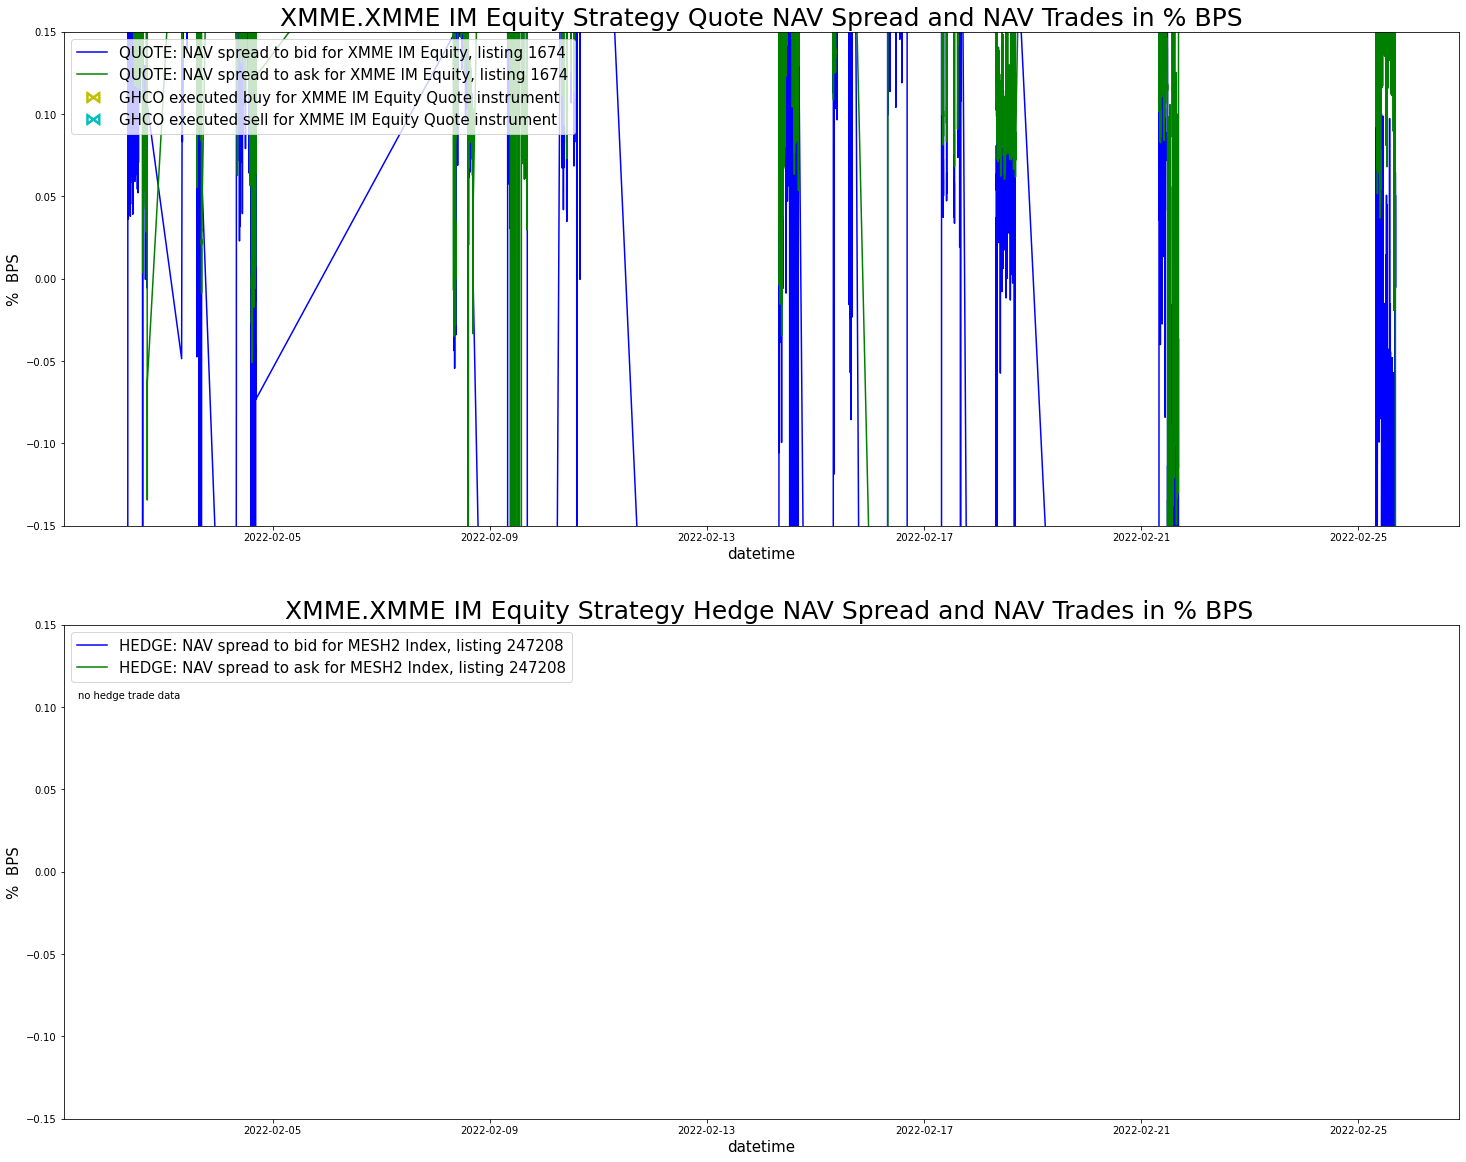

In [6]:
listing_ids=get_strategy_listings(Strategy)
#listing_ids=listing_ids.listing_id.unique()

slice_start ='2022-02-02'
slice_end ='2022-02-28'
df=df.sort_values('datetime')
df_slice=df.loc[slice_start:slice_end]
df_trades_slice=df_trades.loc[slice_start:slice_end]

df_trades_q=df_trades_slice[df_trades_slice['role']=='quote']
df_trades_h=df_trades_slice[df_trades_slice['role']=='hedge']

plt.figure(figsize=(25, 10*listing_ids.shape[0]))
index=0

# Quote Data
df_quote=listing_ids[listing_ids['role']=='quote'].reset_index()

for i in range (0,df_quote.shape[0]):
    index+=1
    ax = plt.subplot(listing_ids.shape[0], 1, index)
    #plot the BPS NAV spreads
    ax.plot(100*(df_slice['quote_bid']-df_slice['quote_fair_bid'])/df_slice['quote_bid'],c='b',label='QUOTE: NAV spread to bid for {}, listing {}'.format(df_quote.loc[i,'bbg_name'],df_quote.loc[i,'listing_id']))
    ax.plot(100*(df_slice['quote_ask']-df_slice['quote_fair_ask'])/df_slice['quote_ask'],c='g',label='QUOTE: NAV spread to ask for {}, listing {}'.format(df_quote.loc[i,'bbg_name'],df_quote.loc[i,'listing_id']))

    if df_trades_q.shape[0]!=0:
        # calculate and plot the NAV trades in BPS % for quote
        df_buys_q=df_trades_q[df_trades_q['trade_side']=='B'].resample('min').mean()
        df_buys_bps_q=(100*(df_buys_q['trade_price']-df_slice['quote_fair_ask'])/df_buys_q['trade_price']).dropna()    
        ax.plot(df_buys_bps_q,c='y',marker=r'$\bowtie$',markersize= 15,linestyle='',label='GHCO executed buy for {} Quote instrument'.format(df_quote.loc[i,'bbg_name']))
        df_sells_q=df_trades_q[df_trades_q['trade_side']=='S'].resample('min').mean()
        df_sells_bps_q=(100*(df_sells_q['trade_price']-df_slice['quote_fair_bid'])/df_sells_q['trade_price']).dropna()
        ax.plot(df_sells_bps_q,c='c',marker=r'$\bowtie$',markersize= 15,linestyle='',label='GHCO executed sell for {} Quote instrument'.format(df_quote.loc[i,'bbg_name']))    
    else:
        plt.annotate('no quote trade data',xy=(.01,.85),xycoords='axes fraction')

    #format the graph
    ax.set_xlabel('datetime',fontsize=15)  # Add an x-label to the axes.
    ax.set_ylabel('%  BPS',fontsize=15)  # Add a y-label to the axes.
    ax.set_title('{} Strategy Quote NAV Spread and NAV Trades in % BPS'.format(Strategy),fontsize=25)  # Add a title to the 
    ax.set_ylim(-.15, .15)
    ax.legend(loc=2,fontsize=15) 
        
# Hedge Data  
df_hedge=listing_ids[listing_ids['role']=='hedge'].reset_index()

for i in range (0,df_hedge.shape[0]):
    index+=1
    ax = plt.subplot(listing_ids.shape[0], 1, index)
    ax.plot( 100*(df_slice['hedge_bid']-df_slice['hedge_fair_bid'])/df_slice['hedge_bid'],c='b',label='HEDGE: NAV spread to bid for {}, listing {}'.format(df_hedge.loc[i,'bbg_name'],df_hedge.loc[i,'listing_id']))
    ax.plot( 100*(df_slice['hedge_ask']-df_slice['hedge_fair_ask'])/df_slice['hedge_ask'],c='g',label='HEDGE: NAV spread to ask for {}, listing {}'.format(df_hedge.loc[i,'bbg_name'],df_hedge.loc[i,'listing_id']))
    
    if df_trades_h.shape[0]!=0:
        # calculate and plot the NAV trades in BPS % for hedge
        df_buys_h=df_trades_h[df_trades_h['trade_side']=='B'].resample('min').mean()
        df_buys_bps_h=(100*(df_buys_h['trade_price']-df_i['hedge_fair_ask'])/df_buys_h['trade_price']).dropna()    
        ax.plot(df_buys_bps_h,c='k',marker=r'$\clubsuit$',markersize= 15,linestyle='',label='GHCO executed buy for {} Hedge instrument'.format(df_hedge.loc[i,'bbg_name']))
        df_sells_h=df_trades_h[df_trades_h['trade_side']=='S'].resample('min').mean()
        df_sells_bps_h=(100*(df_sells_h['trade_price']-df_i['hedge_fair_bid'])/df_sells_h['trade_price']).dropna()
        ax.plot(df_sells_bps_h,c='r',marker=r'$\clubsuit$',markersize= 15,linestyle='',label='GHCO executed sell for {} Hedge instrument'.format(df_hedge.loc[i,'bbg_name']))    
    else:
        plt.annotate('no hedge trade data',xy=(.01,.85),xycoords='axes fraction')
    
    #format the graphs
    ax.set_xlabel('datetime',fontsize=15)  # Add an x-label to the axes.
    ax.set_ylabel('%  BPS',fontsize=15)  # Add a y-label to the axes.
    ax.set_title('  {} Strategy Hedge NAV Spread and NAV Trades in % BPS'.format(Strategy),fontsize=25)  # Add a title to the 
    ax.set_ylim(-.15, .15)
    ax.legend(loc=2,fontsize=15) 

plt.show()

In [8]:
listing_ids=get_strategy_listings(Strategy)
#listing_ids=listing_ids.listing_id.unique()

slice_start ='2022-02-01'
slice_end ='2022-02-01'
df=df.sort_values('datetime')
df_slice=df.loc[slice_start:slice_end]
df_trades_slice=df_trades.loc[slice_start:slice_end]

df_trades_q=df_trades_slice[df_trades_slice['role']=='quote']
df_trades_h=df_trades_slice[df_trades_slice['role']=='hedge']

plt.figure(figsize=(25, 10*listing_ids.shape[0]))
index=0

# Quote Data
df_quote=listing_ids[listing_ids['role']=='quote'].reset_index()

for i in range (0,df_quote.shape[0]):
    index+=1
    ax = plt.subplot(listing_ids.shape[0], 1, index)
    #plot the BPS NAV spreads
    ax.plot(1000*(df_slice['quote_bid']-df_slice['quote_fair_bid'])/df_slice['quote_bid'],c='b',label='QUOTE: NAV spread to bid for {}, listing {}'.format(df_quote.loc[i,'bbg_name'],df_quote.loc[i,'listing_id']))
    ax.plot(1000*(df_slice['quote_ask']-df_slice['quote_fair_ask'])/df_slice['quote_ask'],c='g',label='QUOTE: NAV spread to ask for {}, listing {}'.format(df_quote.loc[i,'bbg_name'],df_quote.loc[i,'listing_id']))

    if df_trades_q.shape[0]!=0:
        # calculate and plot the NAV trades in BPS % for quote
        df_buys_q=df_trades_q[df_trades_q['trade_side']=='B'].resample('min').mean()
        df_buys_bps_q=(100*(df_buys_q['trade_price']-df_slice['quote_fair_ask'])/df_buys_q['trade_price']).dropna()    
        ax.plot(df_buys_bps_q,c='y',marker=r'$\bowtie$',markersize= 15,linestyle='',label='GHCO executed buy for {} Quote instrument'.format(df_quote.loc[i,'bbg_name']))
        df_sells_q=df_trades_q[df_trades_q['trade_side']=='S'].resample('min').mean()
        df_sells_bps_q=(100*(df_sells_q['trade_price']-df_slice['quote_fair_bid'])/df_sells_q['trade_price']).dropna()
        ax.plot(df_sells_bps_q,c='c',marker=r'$\bowtie$',markersize= 15,linestyle='',label='GHCO executed sell for {} Quote instrument'.format(df_quote.loc[i,'bbg_name']))    
    else:
        plt.annotate('no quote trade data',xy=(.01,.85),xycoords='axes fraction')

    #format the graph
    ax.set_xlabel('datetime',fontsize=15)  # Add an x-label to the axes.
    ax.set_ylabel('%  BPS',fontsize=15)  # Add a y-label to the axes.
    ax.set_title('{} Strategy Quote NAV Spread and NAV Trades in  BPS'.format(Strategy),fontsize=25)  # Add a title to the 
    #ax.set_ylim(-.15, .15)
    ax.legend(loc=2,fontsize=15) 
        
# Hedge Data  
df_hedge=listing_ids[listing_ids['role']=='hedge'].reset_index()

for i in range (0,df_hedge.shape[0]):
    index+=1
    ax = plt.subplot(listing_ids.shape[0], 1, index)
    ax.plot( 100*(df_slice['hedge_bid']-df_slice['hedge_fair_bid'])/df_slice['hedge_bid'],c='b',label='HEDGE: NAV spread to bid for {}, listing {}'.format(df_hedge.loc[i,'bbg_name'],df_hedge.loc[i,'listing_id']))
    ax.plot( 100*(df_slice['hedge_ask']-df_slice['hedge_fair_ask'])/df_slice['hedge_ask'],c='g',label='HEDGE: NAV spread to ask for {}, listing {}'.format(df_hedge.loc[i,'bbg_name'],df_hedge.loc[i,'listing_id']))
    
    if df_trades_h.shape[0]!=0:
        # calculate and plot the NAV trades in BPS % for hedge
        df_buys_h=df_trades_h[df_trades_h['trade_side']=='B'].resample('min').mean()
        df_buys_bps_h=(100*(df_buys_h['trade_price']-df_i['hedge_fair_ask'])/df_buys_h['trade_price']).dropna()    
        ax.plot(df_buys_bps_h,c='k',marker=r'$\clubsuit$',markersize= 15,linestyle='',label='GHCO executed buy for {} Hedge instrument'.format(df_hedge.loc[i,'bbg_name']))
        df_sells_h=df_trades_h[df_trades_h['trade_side']=='S'].resample('min').mean()
        df_sells_bps_h=(100*(df_sells_h['trade_price']-df_i['hedge_fair_bid'])/df_sells_h['trade_price']).dropna()
        ax.plot(df_sells_bps_h,c='r',marker=r'$\clubsuit$',markersize= 15,linestyle='',label='GHCO executed sell for {} Hedge instrument'.format(df_hedge.loc[i,'bbg_name']))    
    else:
        plt.annotate('no hedge trade data',xy=(.01,.85),xycoords='axes fraction')
    
    #format the graphs
    ax.set_xlabel('datetime',fontsize=15)  # Add an x-label to the axes.
    ax.set_ylabel('%  BPS',fontsize=15)  # Add a y-label to the axes.
    ax.set_title('  {} Strategy Hedge NAV Spread and NAV Trades in BPS'.format(Strategy),fontsize=25)  # Add a title to the 
    ax.set_ylim(-.15, .15)
    ax.legend(loc=2,fontsize=15) 

plt.show()

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8596/2012515781.py:8: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_trades_slice=df_trades.loc[slice_start:slice_end]


D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/1545104132.py:8: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_trades_slice=df_trades.loc[slice_start:slice_end]


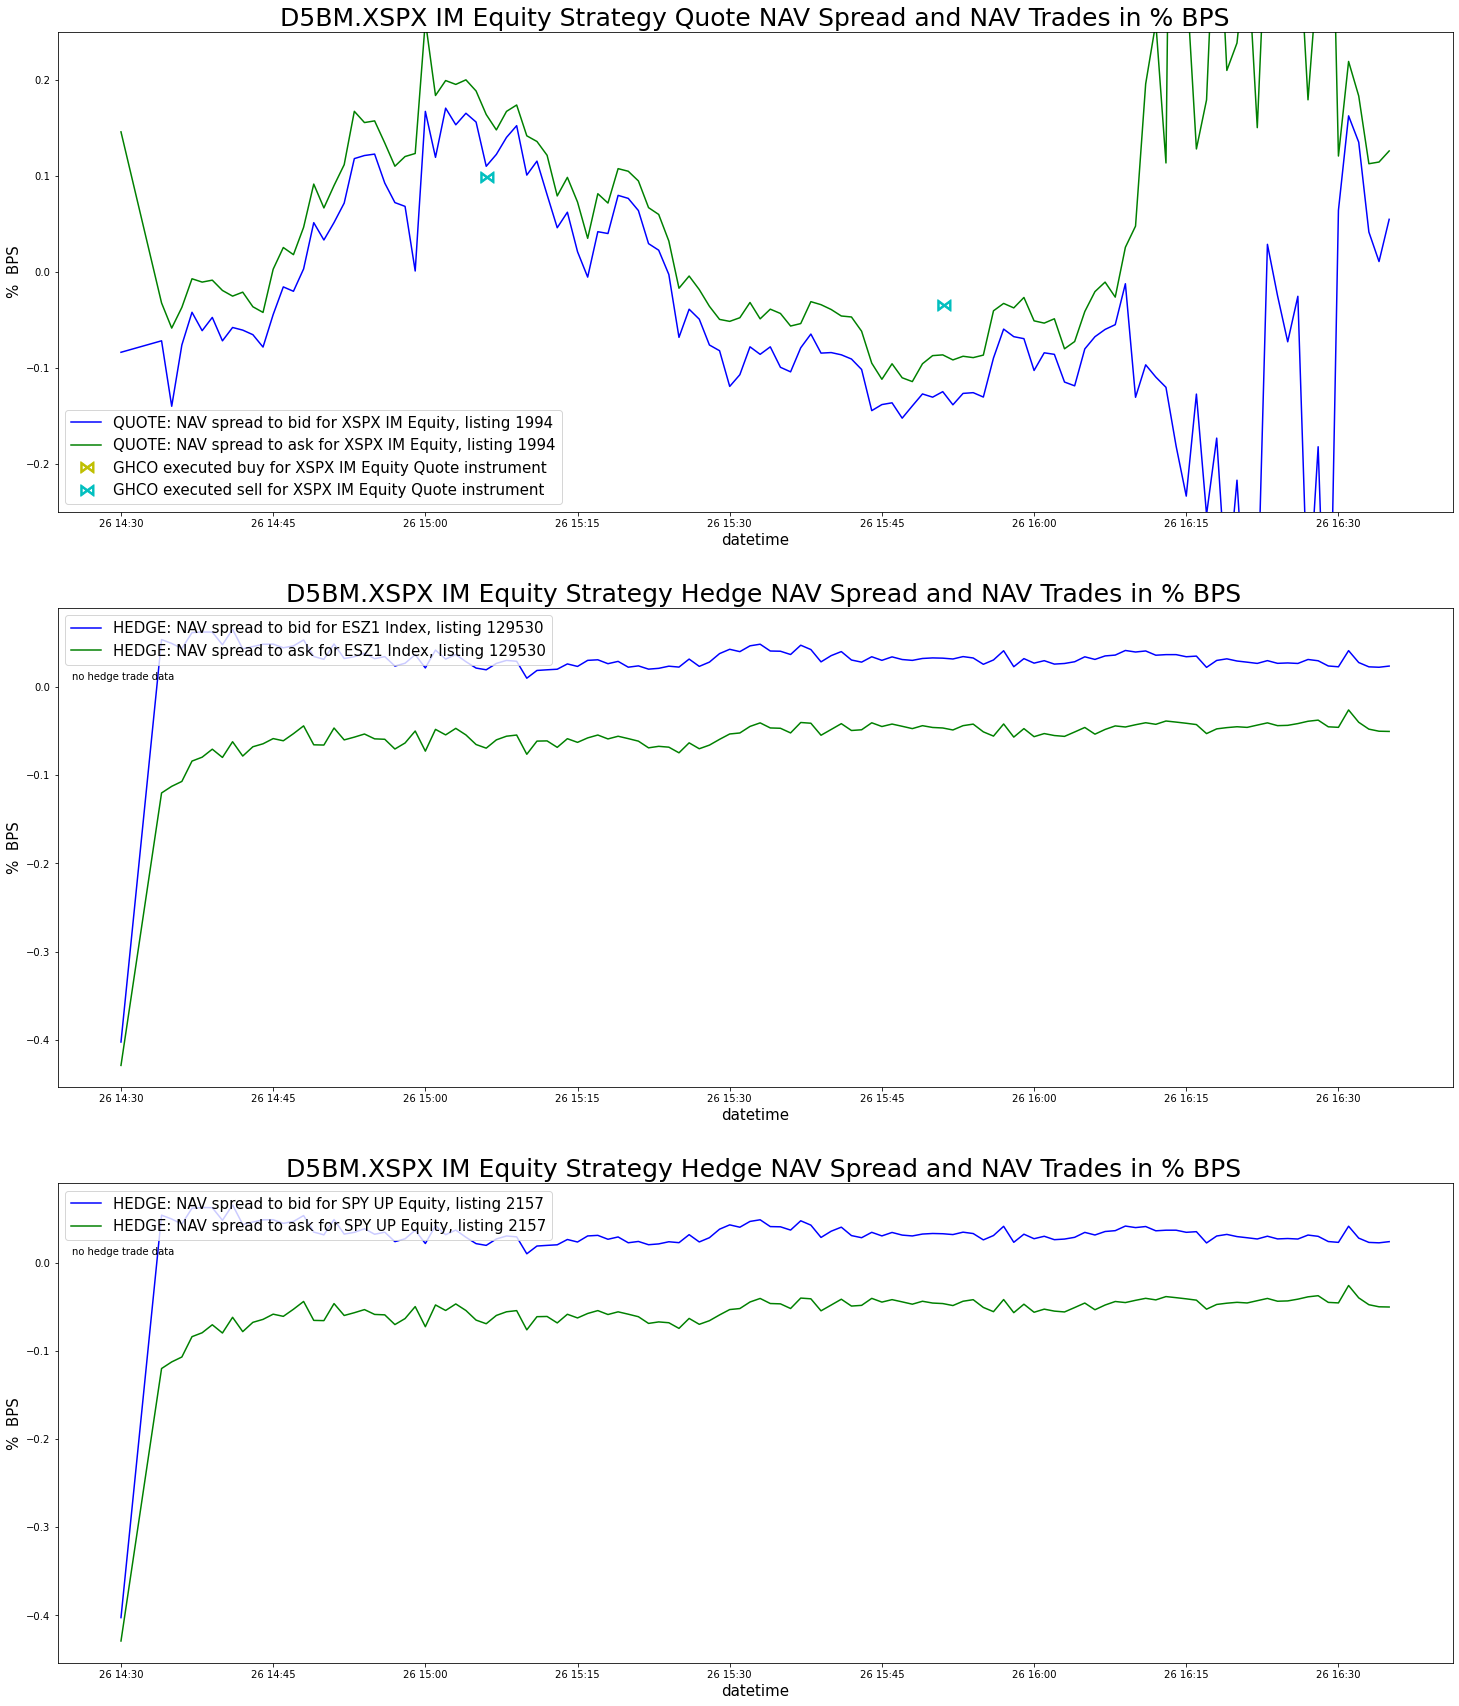

In [429]:
listing_ids=get_strategy_listings(Strategy)
#listing_ids=listing_ids.listing_id.unique()

slice_start ='2022-01-26'
slice_end ='2022-01-26'
df=df.sort_values('datetime')
df_slice=df.loc[slice_start:slice_end]
df_trades_slice=df_trades.loc[slice_start:slice_end]

df_trades_q=df_trades_slice[df_trades_slice['role']=='quote']
df_trades_h=df_trades_slice[df_trades_slice['role']=='hedge']

plt.figure(figsize=(25, 10*listing_ids.shape[0]))
index=0

# Quote Data
df_quote=listing_ids[listing_ids['role']=='quote'].reset_index()

for i in range (0,df_quote.shape[0]):
    index+=1
    ax = plt.subplot(listing_ids.shape[0], 1, index)
    #plot the BPS NAV spreads
    ax.plot(100*(df_slice['quote_bid']-df_slice['quote_fair_bid'])/df_slice['quote_bid'],c='b',label='QUOTE: NAV spread to bid for {}, listing {}'.format(df_quote.loc[i,'bbg_name'],df_quote.loc[i,'listing_id']))
    ax.plot(100*(df_slice['quote_ask']-df_slice['quote_fair_ask'])/df_slice['quote_ask'],c='g',label='QUOTE: NAV spread to ask for {}, listing {}'.format(df_quote.loc[i,'bbg_name'],df_quote.loc[i,'listing_id']))

    if df_trades_q.shape[0]!=0:
        # calculate and plot the NAV trades in BPS % for quote
        df_buys_q=df_trades_q[df_trades_q['trade_side']=='B'].resample('min').mean()
        df_buys_bps_q=(100*(df_buys_q['trade_price']-df_slice['quote_fair_ask'])/df_buys_q['trade_price']).dropna()    
        ax.plot(df_buys_bps_q,c='y',marker=r'$\bowtie$',markersize= 15,linestyle='',label='GHCO executed buy for {} Quote instrument'.format(df_quote.loc[i,'bbg_name']))
        df_sells_q=df_trades_q[df_trades_q['trade_side']=='S'].resample('min').mean()
        df_sells_bps_q=(100*(df_sells_q['trade_price']-df_slice['quote_fair_bid'])/df_sells_q['trade_price']).dropna()
        ax.plot(df_sells_bps_q,c='c',marker=r'$\bowtie$',markersize= 15,linestyle='',label='GHCO executed sell for {} Quote instrument'.format(df_quote.loc[i,'bbg_name']))    
    else:
        plt.annotate('no quote trade data',xy=(.01,.85),xycoords='axes fraction')

    #format the graph
    ax.set_xlabel('datetime',fontsize=15)  # Add an x-label to the axes.
    ax.set_ylabel('%  BPS',fontsize=15)  # Add a y-label to the axes.
    ax.set_title('{} Strategy Quote NAV Spread and NAV Trades in % BPS'.format(Strategy),fontsize=25)  # Add a title to the 
    ax.set_ylim(-.25, .25)
    ax.legend(loc=3,fontsize=15) 
        
# Hedge Data  
df_hedge=listing_ids[listing_ids['role']=='hedge'].reset_index()

for i in range (0,df_hedge.shape[0]):
    index+=1
    ax = plt.subplot(listing_ids.shape[0], 1, index)
    ax.plot( 100*(df_slice['hedge_bid']-df_slice['hedge_fair_bid'])/df_slice['hedge_bid'],c='b',label='HEDGE: NAV spread to bid for {}, listing {}'.format(df_hedge.loc[i,'bbg_name'],df_hedge.loc[i,'listing_id']))
    ax.plot( 100*(df_slice['hedge_ask']-df_slice['hedge_fair_ask'])/df_slice['hedge_ask'],c='g',label='HEDGE: NAV spread to ask for {}, listing {}'.format(df_hedge.loc[i,'bbg_name'],df_hedge.loc[i,'listing_id']))
    
    if df_trades_h.shape[0]!=0:
        # calculate and plot the NAV trades in BPS % for hedge
        df_buys_h=df_trades_h[df_trades_h['trade_side']=='B'].resample('min').mean()
        df_buys_bps_h=(100*(df_buys_h['trade_price']-df_i['hedge_fair_ask'])/df_buys_h['trade_price']).dropna()    
        ax.plot(df_buys_bps_h,c='k',marker=r'$\clubsuit$',markersize= 15,linestyle='',label='GHCO executed buy for {} Hedge instrument'.format(df_hedge.loc[i,'bbg_name']))
        df_sells_h=df_trades_h[df_trades_h['trade_side']=='S'].resample('min').mean()
        df_sells_bps_h=(100*(df_sells_h['trade_price']-df_i['hedge_fair_bid'])/df_sells_h['trade_price']).dropna()
        ax.plot(df_sells_bps_h,c='r',marker=r'$\clubsuit$',markersize= 15,linestyle='',label='GHCO executed sell for {} Hedge instrument'.format(df_hedge.loc[i,'bbg_name']))    
    else:
        plt.annotate('no hedge trade data',xy=(.01,.85),xycoords='axes fraction')
    
    #format the graphs
    ax.set_xlabel('datetime',fontsize=15)  # Add an x-label to the axes.
    ax.set_ylabel('%  BPS',fontsize=15)  # Add a y-label to the axes.
    ax.set_title('  {} Strategy Hedge NAV Spread and NAV Trades in % BPS'.format(Strategy),fontsize=25)  # Add a title to the 
    #ax.set_ylim(-.0005, .0015)
    ax.legend(loc=2,fontsize=15) 

plt.show()

D:\Users\jerroda\AppData\Local\Temp\1/ipykernel_8992/65233261.py:8: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_trades_slice=df_trades.loc[slice_start:slice_end]


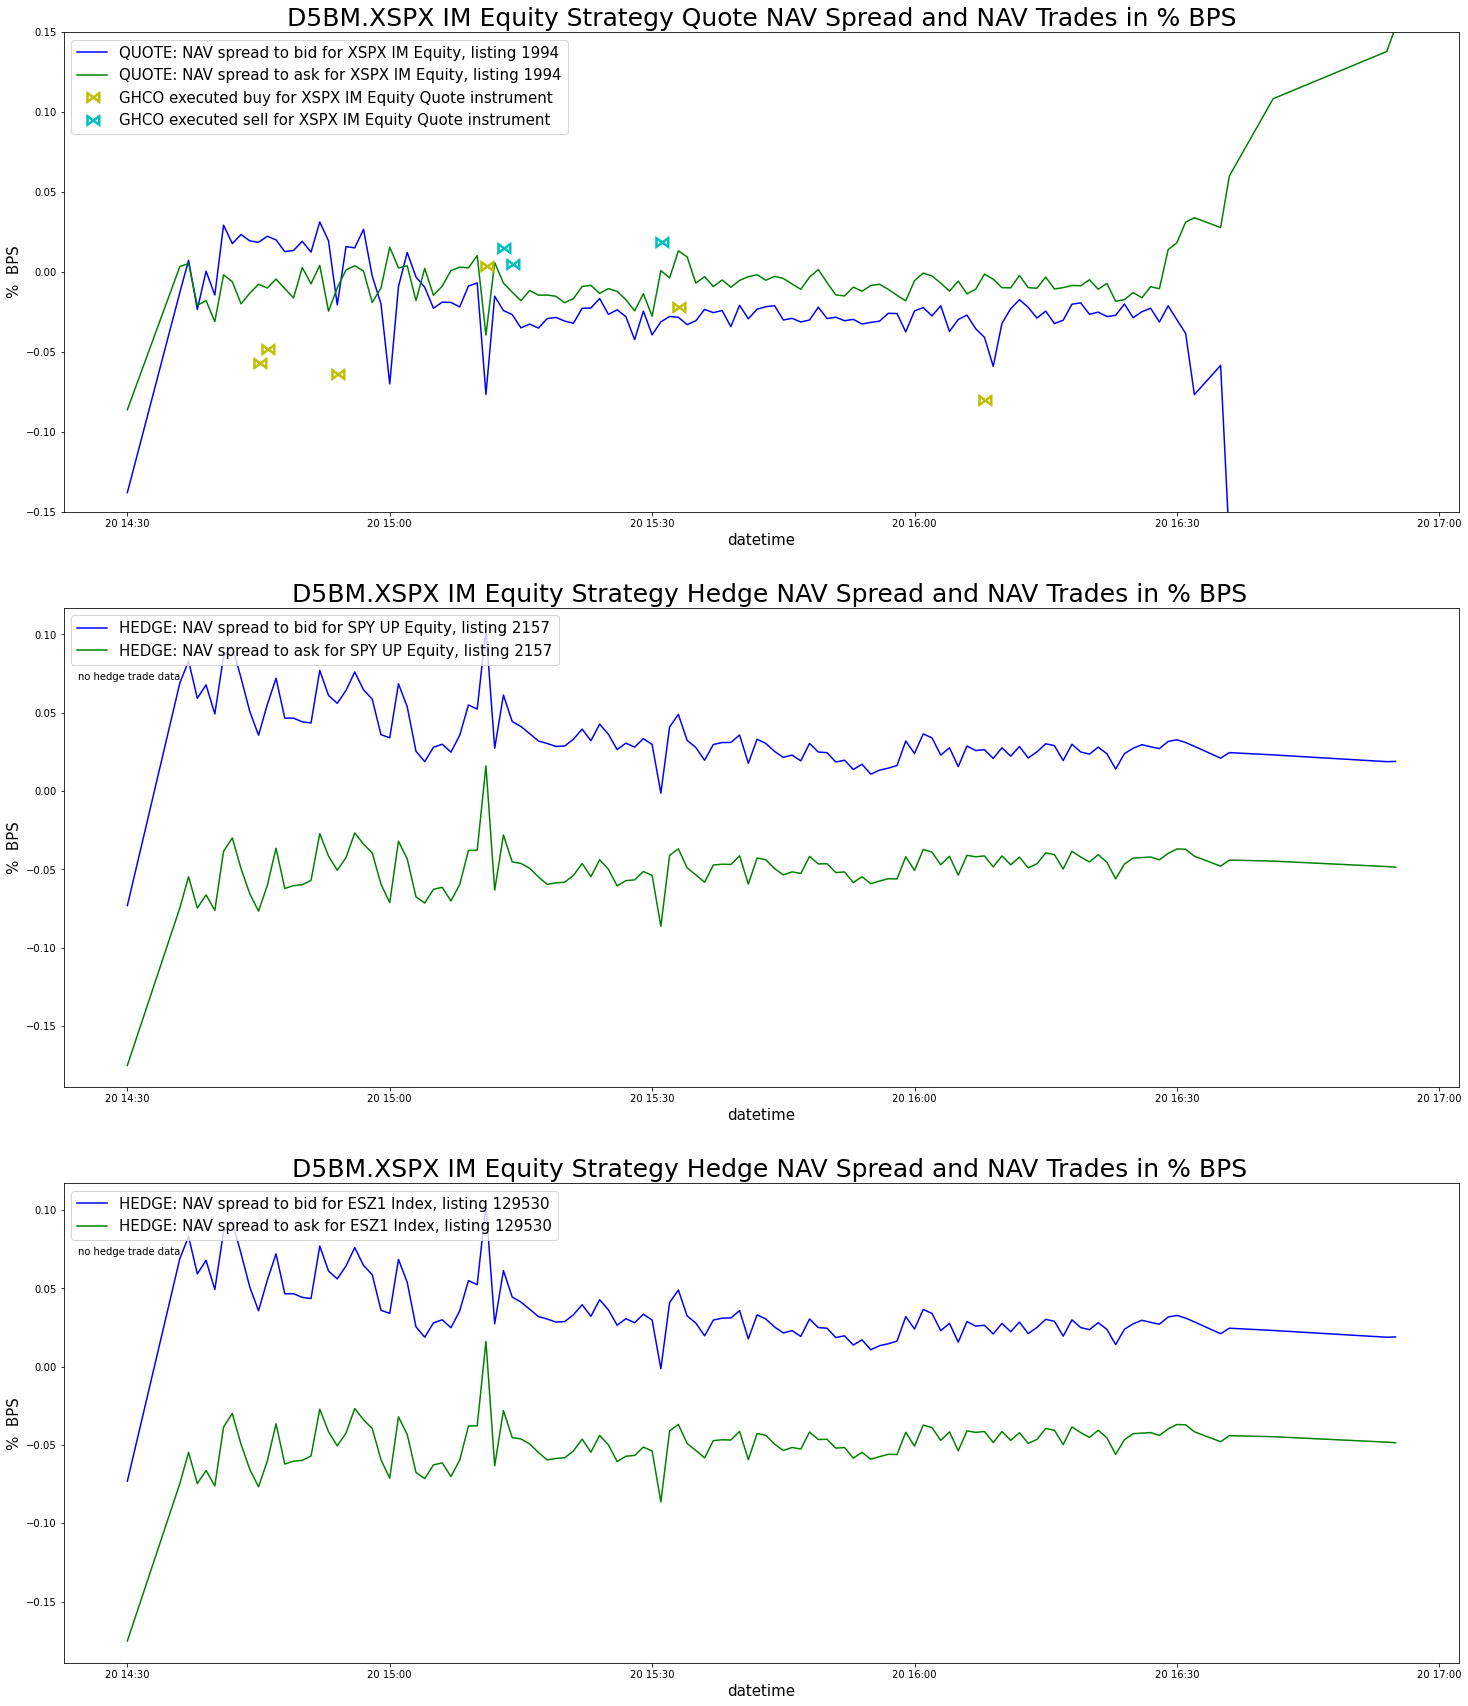

In [421]:
listing_ids=get_strategy_listings(Strategy)
#listing_ids=listing_ids.listing_id.unique()

slice_start ='2022-01-20'
slice_end ='2022-01-20'
df=df.sort_values('datetime')
df_slice=df.loc[slice_start:slice_end]
df_trades_slice=df_trades.loc[slice_start:slice_end]

df_trades_q=df_trades_slice[df_trades_slice['role']=='quote']
df_trades_h=df_trades_slice[df_trades_slice['role']=='hedge']

plt.figure(figsize=(25, 10*listing_ids.shape[0]))
index=0

# Quote Data
df_quote=listing_ids[listing_ids['role']=='quote'].reset_index()

for i in range (0,df_quote.shape[0]):
    index+=1
    ax = plt.subplot(listing_ids.shape[0], 1, index)
    #plot the BPS NAV spreads
    ax.plot(100*(df_slice['quote_bid']-df_slice['quote_fair_bid'])/df_slice['quote_bid'],c='b',label='QUOTE: NAV spread to bid for {}, listing {}'.format(df_quote.loc[i,'bbg_name'],df_quote.loc[i,'listing_id']))
    ax.plot(100*(df_slice['quote_ask']-df_slice['quote_fair_ask'])/df_slice['quote_ask'],c='g',label='QUOTE: NAV spread to ask for {}, listing {}'.format(df_quote.loc[i,'bbg_name'],df_quote.loc[i,'listing_id']))

    if df_trades_q.shape[0]!=0:
        # calculate and plot the NAV trades in BPS % for quote
        df_buys_q=df_trades_q[df_trades_q['trade_side']=='B'].resample('min').mean()
        df_buys_bps_q=(100*(df_buys_q['trade_price']-df_slice['quote_fair_ask'])/df_buys_q['trade_price']).dropna()    
        ax.plot(df_buys_bps_q,c='y',marker=r'$\bowtie$',markersize= 15,linestyle='',label='GHCO executed buy for {} Quote instrument'.format(df_quote.loc[i,'bbg_name']))
        df_sells_q=df_trades_q[df_trades_q['trade_side']=='S'].resample('min').mean()
        df_sells_bps_q=(100*(df_sells_q['trade_price']-df_slice['quote_fair_bid'])/df_sells_q['trade_price']).dropna()
        ax.plot(df_sells_bps_q,c='c',marker=r'$\bowtie$',markersize= 15,linestyle='',label='GHCO executed sell for {} Quote instrument'.format(df_quote.loc[i,'bbg_name']))    
    else:
        plt.annotate('no quote trade data',xy=(.01,.85),xycoords='axes fraction')

    #format the graph
    ax.set_xlabel('datetime',fontsize=15)  # Add an x-label to the axes.
    ax.set_ylabel('%  BPS',fontsize=15)  # Add a y-label to the axes.
    ax.set_title('{} Strategy Quote NAV Spread and NAV Trades in % BPS'.format(Strategy),fontsize=25)  # Add a title to the 
    ax.set_ylim(-.15, .15)
    ax.legend(loc=2,fontsize=15) 
        
# Hedge Data  
df_hedge=listing_ids[listing_ids['role']=='hedge'].reset_index()

for i in range (0,df_hedge.shape[0]):
    index+=1
    ax = plt.subplot(listing_ids.shape[0], 1, index)
    ax.plot( 100*(df_slice['hedge_bid']-df_slice['hedge_fair_bid'])/df_slice['hedge_bid'],c='b',label='HEDGE: NAV spread to bid for {}, listing {}'.format(df_hedge.loc[i,'bbg_name'],df_hedge.loc[i,'listing_id']))
    ax.plot( 100*(df_slice['hedge_ask']-df_slice['hedge_fair_ask'])/df_slice['hedge_ask'],c='g',label='HEDGE: NAV spread to ask for {}, listing {}'.format(df_hedge.loc[i,'bbg_name'],df_hedge.loc[i,'listing_id']))
    
    if df_trades_h.shape[0]!=0:
        # calculate and plot the NAV trades in BPS % for hedge
        df_buys_h=df_trades_h[df_trades_h['trade_side']=='B'].resample('min').mean()
        df_buys_bps_h=(100*(df_buys_h['trade_price']-df_i['hedge_fair_ask'])/df_buys_h['trade_price']).dropna()    
        ax.plot(df_buys_bps_h,c='k',marker=r'$\clubsuit$',markersize= 15,linestyle='',label='GHCO executed buy for {} Hedge instrument'.format(df_hedge.loc[i,'bbg_name']))
        df_sells_h=df_trades_h[df_trades_h['trade_side']=='S'].resample('min').mean()
        df_sells_bps_h=(100*(df_sells_h['trade_price']-df_i['hedge_fair_bid'])/df_sells_h['trade_price']).dropna()
        ax.plot(df_sells_bps_h,c='r',marker=r'$\clubsuit$',markersize= 15,linestyle='',label='GHCO executed sell for {} Hedge instrument'.format(df_hedge.loc[i,'bbg_name']))    
    else:
        plt.annotate('no hedge trade data',xy=(.01,.85),xycoords='axes fraction')
    
    #format the graphs
    ax.set_xlabel('datetime',fontsize=15)  # Add an x-label to the axes.
    ax.set_ylabel('%  BPS',fontsize=15)  # Add a y-label to the axes.
    ax.set_title('  {} Strategy Hedge NAV Spread and NAV Trades in % BPS'.format(Strategy),fontsize=25)  # Add a title to the 
    #ax.set_ylim(-.0005, .0015)
    ax.legend(loc=2,fontsize=15) 

plt.show()

In [281]:
query = f'''
        SELECT * FROM 
            (select listing_id as quote, q.mean_fair_bid as quote_fair_bid, q.mean_fair_ask as quote_fair_ask, q.mean_bid as quote_bid, q.mean_ask as quote_ask, datetime
                FROM tick_fair_minute q
                WHERE listing_id IN
                    (SELECT listing_id 
                    FROM   strategy_to_quote_listing 
                    WHERE  strategy = '{Strategy}')),

            (select listing_id as hedge, h.mean_fair_bid as hedge_fair_bid, h.mean_fair_ask as hedge_fair_ask, h.mean_bid as hedge_bid, h.mean_ask as hedge_ask, datetime as datetime1
                FROM tick_fair_minute h
                WHERE listing_id IN
                    (select hedge_listing_id
                    FROM strategy_to_hedges
                    WHERE strategy='{Strategy}'))
        where datetime=datetime1
        order by datetime'''
#df is the tick_fair_minute data of quote and hedge listings for the individual strategy, indexed by datetime
df_not_parsed=pd.read_sql(query,redshift_conn).set_index('datetime')
df_not_parsed

quote  quote_fair_bid  quote_fair_ask  quote_bid  \
datetime                                                                      
2021-11-01 12:01:00+00:00    926       50.133120       50.155696  50.043636   
2021-11-01 12:02:00+00:00    926       50.129492       50.151409  50.047273   
2021-11-01 12:03:00+00:00    926       50.122875       50.145590  50.040000   
2021-11-01 12:04:00+00:00    926       50.113009       50.137110  50.030000   
2021-11-01 12:05:00+00:00    926       50.117104       50.139508  50.030000   
...                          ...             ...             ...        ...   
2022-03-08 16:37:00+00:00    926       44.134098       44.162685  44.111930   
2022-03-08 16:38:00+00:00    926       44.163498       44.192004  44.137294   
2022-03-08 16:38:00+00:00    926       44.163498       44.192004  44.137294   
2022-03-08 16:39:00+00:00    926       44.157394       44.186159  44.125918   
2022-03-08 16:39:00+00:00    926       44.157394       44.186159  44.125918   

                           quote_ask   hedge  hedge_fair_bid  hedge_fair_ask  \
datetime                                                                       
2021-11-01 12:01:00+00:00  50.213636    2157      461.286841      461.339454   
2021-11-01 12:02:00+00:00  50.209091    2157      461.263672      461.317052   
2021-11-01 12:03:00+00:00  50.204815    2157      461.229345      461.283178   
2021-11-01 12:04:00+00:00  50.195152    2157      461.194203      461.252827   
2021-11-01 12:05:00+00:00  50.195000    2157      461.194263      461.251990   
...                              ...     ...             ...             ...   
2022-03-08 16:37:00+00:00  44.118158  129531     4184.898633     4247.466398   
2022-03-08 16:38:00+00:00  44.143765  129531     4186.371772     4249.023161   
2022-03-08 16:38:00+00:00  44.143765    2157      416.107920      416.401027   
2022-03-08 16:39:00+00:00  44.134082    2157      415.944309      416.225169   
2022-03-08 16:39:00+00:00  44.134082  129531     4184.822695     4247.379407   

                             hedge_bid    hedge_ask                 datetime1  
datetime                                                                       
2021-11-01 12:01:00+00:00   461.032571   461.050857 2021-11-01 12:01:00+00:00  
2021-11-01 12:02:00+00:00   461.010000   461.030000 2021-11-01 12:02:00+00:00  
2021-11-01 12:03:00+00:00   460.984808   461.011346 2021-11-01 12:03:00+00:00  
2021-11-01 12:04:00+00:00   460.969643   460.996786 2021-11-01 12:04:00+00:00  
2021-11-01 12:05:00+00:00   460.969688   460.989375 2021-11-01 12:05:00+00:00  
...                                ...          ...                       ...  
2022-03-08 16:37:00+00:00  4163.557816  4163.839917 2022-03-08 16:37:00+00:00  
2022-03-08 16:38:00+00:00  4165.354487  4165.632376 2022-03-08 16:38:00+00:00  
2022-03-08 16:38:00+00:00   416.245202   416.268266 2022-03-08 16:38:00+00:00  
2022-03-08 16:39:00+00:00   415.915800   415.936896 2022-03-08 16:39:00+00:00  
2022-03-08 16:39:00+00:00  4161.891850  4162.174272 2022-03-08 16:39:00+00:00  

[52305 rows x 11 columns]